In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import math

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# reading the data
data = pd.read_csv("data2.csv")

# Extracting the relevant columns
inputs = data[['Servo2', 'Servo3']]
outputs = data[['X', 'Y']]

# Splitting the data into training and testing sets
# we set random state in order to be reproducible
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Normalizing the data
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transform the test data with the same scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Display first 5 rows of scaled inputs and corresponding outputs
print(X_train_scaled[:5], y_train.head())


     Servo2    Servo3
0  0.754214 -1.034478
1  0.754214  0.126648
2  0.497860 -1.615041
3  1.395098 -1.615041
4 -0.271200 -0.163634            X        Y
73   17.5552 -18.2310
181  19.7872 -27.3248
17   16.8856 -13.1296
24   15.9928 -14.4604
146  28.0456 -10.9116


In [ ]:
# Defining the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #nn.Linear  ->  fully connected layer
        self.fc1 = nn.Linear(2, 16)  # 2 input features (Servo2, Servo3), 64 neurons in the first hidden layer
        self.fc2 = nn.Linear(16, 16) # 64 neurons in the second hidden layer
        self.fc3 = nn.Linear(16, 2)  # 2 output features (X, Y)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function on the output layer for regression
        return x


In [ ]:
# Training parameters
epochs = 250
batch_size = 16

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with a learning rate of 0.001

# Convert data to PyTorch tensors and move them to the same device as the model
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device)


# Training loop
for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size].to(device)
        y_batch = y_train_tensor[i:i+batch_size].to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted = model(X_test_tensor)
    test_loss = criterion(predicted, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Using device: cuda
Epoch [10/250], Loss: 8.4495
Epoch [20/250], Loss: 5.1864
Epoch [30/250], Loss: 4.0484
Epoch [40/250], Loss: 2.6608
Epoch [50/250], Loss: 1.8520
Epoch [60/250], Loss: 1.4503
Epoch [70/250], Loss: 1.0894
Epoch [80/250], Loss: 0.7811
Epoch [90/250], Loss: 0.6465
Epoch [100/250], Loss: 0.5991
Epoch [110/250], Loss: 0.5922
Epoch [120/250], Loss: 0.5694
Epoch [130/250], Loss: 0.5929
Epoch [140/250], Loss: 0.5865
Epoch [150/250], Loss: 0.5982
Epoch [160/250], Loss: 0.5630
Epoch [170/250], Loss: 0.6011
Epoch [180/250], Loss: 0.6320
Epoch [190/250], Loss: 0.6630
Epoch [200/250], Loss: 0.6124
Epoch [210/250], Loss: 0.5941
Epoch [220/250], Loss: 0.6382
Epoch [230/250], Loss: 0.5719
Epoch [240/250], Loss: 0.5788
Epoch [250/250], Loss: 0.5565
Test Loss: 0.7257


In [ ]:
#check X and Y for specific X and Y values
specific_servo2 = 5  # example value
specific_servo3 = 0  # example value

# Normalize the input using the scaler
input_features = np.array([[specific_servo2, specific_servo3]])
normalized_input = scaler.transform(input_features)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to a tensor (make sure to use .float() to get a float tensor)
input_tensor = torch.tensor(normalized_input, dtype=torch.float32).to(device)

# Predict the output from the model
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    predicted_output = model(input_tensor)

predicted_X, predicted_Y = predicted_output.cpu().numpy()[0]  # get the predicted X and Y
# PyTorch tensors that are on the GPU cannot be directly converted to NumPy arrays, since NumPy does not support GPU operations.
print(f"Predicted X: {predicted_X}, Predicted Y: {predicted_Y}")


Using device: cuda
Predicted X: 17.286001205444336, Predicted Y: 12.622907638549805


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Defining the Environment
class ServoEnvironmentNN:
    def __init__(self, model, goal_x, goal_y):
        self.model = model
        self.goal_x = goal_x
        self.goal_y = goal_y

    def reset(self):
        # Initialize servo2 and servo3 to random values within their range
        self.servo2 = np.random.uniform(0,360)  # Example range for servo2
        self.servo3 = np.random.uniform(0,90)   # Example range for servo3
        # Predict initial X and Y using the neural network
        self.state = self.predict_state()
        return self.state

    def predict_state(self):
        # Check for GPU availability
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Ensure self.servo2 and self.servo3 are not tensors or convert them to Python scalars if they are
        servo2 = self.servo2.item() if isinstance(self.servo2, torch.Tensor) else self.servo2
        servo3 = self.servo3.item() if isinstance(self.servo3, torch.Tensor) else self.servo3
        # Normalize servo2 and servo3 values as done during training
        normalized_servos = scaler.transform([[servo2, servo3]])
        servo_tensor = torch.tensor(normalized_servos, dtype=torch.float32).to(device)

        # Use the model to predict X and Y
        model.eval()  # set the model to evaluation mode
        with torch.no_grad():
            predicted_state = self.model(servo_tensor).cpu().numpy()[0]
        return predicted_state


    def step(self, action):
        # Decode action into changes for servo2 and servo3
        delta_servo2 = (action // 3 - 1) * 3
        delta_servo3 = (action % 3 - 1) * 3

        # Check if servo2 and servo3 are tensors and move them to CPU if they are
        # If they are not tensors, they will be regular floats which is also fine
        if isinstance(self.servo2, torch.Tensor):
            self.servo2 = self.servo2.cpu().item()
        if isinstance(self.servo3, torch.Tensor):
            self.servo3 = self.servo3.cpu().item()

        # Update servo2 and servo3 values based on the action
        self.servo2 += delta_servo2
        self.servo3 += delta_servo3

        # Predict the new state (X, Y) using the neural network
        self.state = self.predict_state()

        # Calculate reward based on closeness to goal
        distance_to_goal = np.linalg.norm([self.goal_x - self.state[0], self.goal_y - self.state[1]])
        reward = -distance_to_goal

        # Threshold for considering the goal to be reached
        goal_threshold = 5  # You can adjust this value as needed

        # Calculate Euclidean distance to the goal
        distance_to_goal = np.linalg.norm([self.goal_x - self.state[0], self.goal_y - self.state[1]])

        # Check if the distance is within the threshold
        done = distance_to_goal <= goal_threshold


        return self.state, reward,done


# Initialize the environment with a goal state
goal_x, goal_y = 17.33, 13.04  # For example, let's set the goal servo2 should be 5 servo3 should be 0
env = ServoEnvironmentNN(model,goal_x, goal_y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[26.503046 23.669802]
[26.892525 23.236017]
[27.282005 22.80223 ]
[27.796001 22.119207]
[28.346418 21.363277]
[28.89684  20.607342]
[29.657497 20.831577]
[30.20792  20.075645]
[30.733013 19.128397]
[31.185305 17.631067]
[31.600151 16.181477]
[31.843351 14.950672]
[32.086555 13.719873]
[32.27024  12.133303]
[32.434593 10.431184]
[32.598953  8.729063]
[32.76331   7.026944]
[32.927666  5.324826]
[33.092022   3.6227043]
[33.244473   1.9591396]
[33.249886   0.7716386]
[33.255302   -0.41586238]
[33.26072   -1.6033633]
[33.26613   -2.7908661]
[33.173607 -4.207045]
[32.77907   -6.3284254]
[32.384537 -8.449808]
[31.936459 -9.869179]
[ 31.484716 -11.240496]
[ 31.062054 -12.658705]
[ 30.664953  -14.1181345]
[ 30.267845 -15.577564]
[ 29.870745 -17.03699 ]
[ 29.473644 -18.496418]
[ 29.076542 -19.955845]
[ 28.75434  -20.950464]
[ 29.660774 -20.89137 ]
[ 30.537918 -20.51214 ]
[ 31.215034 -20.410654]
[ 31.892147 -20.309168]
[ 32.56926  -20.207682]
[ 33.246372 -20.106194]
[ 33.8963   -19.648226]
[ 33.9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 33.0671   -21.762583]
[ 33.0671   -21.762583]
[ 33.0671   -21.762583]
[ 33.582207 -19.07964 ]
[ 34.09731  -16.396702]
[ 34.66147  -13.384466]
[35.329006 -9.678234]
[35.699657 -9.532166]
[36.357742 -5.804304]
[36.915764 -1.847399]
[36.89042    1.2995031]
[36.32916    3.3814619]
[35.506653  4.509951]
[34.779728  5.564729]
[34.052803   6.6195083]
[33.65459    4.2700486]
[33.244473   1.9591424]
[32.52503    0.6497609]
[31.805582   -0.65961677]
[31.800167    0.52788514]
[31.794752   1.7153852]
[31.789337  2.902887]
[31.783922  4.090387]
[31.638172  5.732265]
[31.473814  7.434386]
[31.30946   9.136504]
[31.1451   10.838625]
[30.918327 12.167616]
[30.675121  13.3984165]
[30.431923 14.62922 ]
[30.188719 15.860018]
[29.945517 17.090822]
[29.682894 18.174868]
[29.237011 18.871248]
[28.776695 18.033545]
[28.453508 18.660028]
[27.925932 19.402945]
[27.547312 18.518702]
[26.9643   17.750896]
[26.381287 16.983086]
[25.798273 16.215275]
[25.215263 15.44747 ]
[24.63225  14.679662]
[24.04924  13.9118

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 10.491339 -34.477215]
[ 10.329144 -35.765587]
[ 10.491338 -34.47722 ]
[ 10.329144 -35.765587]
[ 10.211521 -37.103336]
[ 10.151363 -38.31491 ]
[ 10.033741 -39.652657]
[  9.916116 -40.99041 ]
[  9.798494 -42.32816 ]
[  9.680871 -43.66591 ]
[  9.798494 -42.32816 ]
[  9.680871 -43.66591 ]
[  9.563248 -45.00365 ]
[  9.445622 -46.341408]
[  9.328419 -47.67905 ]
[  9.211307 -49.016674]
[  9.0941925 -50.3543   ]
[  8.977082 -51.691925]
[  8.859972 -53.02955 ]
[  8.742862 -54.367172]
[  8.659786 -55.716686]
[  8.58466  -57.068974]
[  8.509531 -58.42126 ]
[  8.440459 -58.543316]
[  8.365333 -59.8956  ]
[  8.290615 -61.247784]
[  8.21631  -62.599865]
[  8.221132 -61.369938]
[  8.227184 -60.13971 ]
[  8.233236 -58.909477]
[  8.239293 -57.679234]
[  8.281631 -56.461685]
[  8.341394 -55.250202]
[  8.401153 -54.038727]
[  8.460912 -52.827255]
[  8.401153 -54.038727]
[  8.460912 -52.827255]
[  8.463316 -51.741924]
[  8.523079 -50.53045 ]
[  8.582837 -49.31897 ]
[  8.642595 -48.1075  ]
[  8.702357 -4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[  8.762115 -45.684544]
[  8.821875 -44.473064]
[  8.881772 -43.261555]
[  8.941933 -42.049984]
[  9.002091 -40.838406]
[  9.062253 -39.62683 ]
[  9.004788 -39.75301 ]
[  9.064947 -38.541435]
[  9.125109 -37.329857]
[  9.185267 -36.118286]
[  9.187962 -35.032887]
[  9.130499 -35.15906 ]
[  9.073035 -35.285236]
[  9.020011 -35.42542 ]
[  8.980942 -35.60965 ]
[  8.941874 -35.793877]
[  8.902805 -35.978107]
[  8.863735 -36.162334]
[  8.824668 -36.34656 ]
[  8.785601 -36.53079 ]
[  8.7465315 -36.715015 ]
[  8.707462 -36.899246]
[  8.668393 -37.083477]
[  8.629326 -37.267704]
[  8.590256 -37.451935]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.551188 -37.636158]
[  8.425467 -38.64082 ]
[  8.464534 -38.456593]
[  8.503603 -38.27236 ]
[  8.54267  -38.088135]
[  8.581741 -37.903904]
[  8.620809 -37.719673]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[  8.659879 -37.535446]
[  8.698946 -37.351223]
[  8.738014 -37.166996]
[  8.783022 -37.00151 ]
[  8.8404875 -36.87533  ]
[  8.897948 -36.74916 ]
[  8.955412 -36.622986]
[  9.012875 -36.49681 ]
[  9.07034  -36.370636]
[  9.127803 -36.24446 ]
[  9.185267 -36.118286]
[  9.242728 -35.99211 ]
[  9.300193 -35.86594 ]
[  9.302889 -34.780537]
[  9.360353 -34.65436 ]
[  9.417819 -34.528187]
[  9.47528 -34.40201]
[  9.532744 -34.275837]
[  9.590207 -34.149662]
[  9.64767  -34.023487]
[  9.705134 -33.897312]
[  9.762597 -33.771137]
[  9.820064 -33.644962]
[  9.822758 -32.559566]
[  9.94038  -31.221815]
[ 10.174291 -30.012903]
[ 10.443729 -28.843355]
[ 10.732711 -27.73548 ]
[ 11.049318 -26.714792]
[ 11.049318 -26.714792]
[ 11.365925 -25.694101]
[ 11.1288185 -26.57536  ]
[ 11.445427 -25.55467 ]
[ 11.7620325 -24.533983 ]
[ 12.078643 -23.513294]
[ 12.395247 -22.492605]
[ 12.711854 -21.471918]
[ 13.041486 -20.554   ]
[ 13.390479 -19.788908]
[ 13.739476 -19.023813]
[ 14.122707 -18.429329]
[ 14.517646 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 14.912584 -17.357037]
[ 15.307521 -16.820896]
[ 15.70246 -16.28475]
[ 15.774718 -16.09565 ]
[ 15.774718 -16.09565 ]
[ 16.169655 -15.559505]
[ 16.564594 -15.023361]
[ 16.959534 -14.487219]
[ 17.35447  -13.951073]
[ 17.749409  -13.4149275]
[ 18.044872 -12.968674]
[ 17.866167 -12.950892]
[ 17.68746  -12.933109]
[ 17.508753 -12.915327]
[ 17.274895 -13.026328]
[ 17.024149 -13.176757]
[ 16.87297  -13.338869]
[ 16.875652 -13.519033]
[ 16.878334 -13.699198]
[ 16.881018 -13.879361]
[ 16.8837   -14.059525]
[ 16.886383 -14.23969 ]
[ 16.889065 -14.419853]
[ 16.884598 -14.552405]
[ 16.813808 -14.243357]
[ 16.743023 -13.934311]
[ 16.743023 -13.934311]
[ 16.739109 -14.053585]
[ 16.735193 -14.172859]
[ 16.731276 -14.292133]
[ 16.722183 -14.376939]
[ 16.637402 -14.2654  ]
[ 16.59367  -14.119547]
[ 16.54994  -13.973696]
[ 16.552622 -14.153858]
[ 16.49934 -13.96136]
[ 16.428553 -13.652313]
[ 16.357767 -13.343265]
[ 16.28698  -13.034219]
[ 16.216194 -12.725172]
[ 16.145409 -12.416124]
[ 16.078897 -12.11

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.020275 -11.843125]
[ 15.961653 -11.567449]
[ 15.903031 -11.291772]
[ 15.870055 -10.945973]
[ 15.84119  -10.588924]
[ 15.812328 -10.231876]
[15.783465 -9.874827]
[15.783465 -9.874827]
[15.754603 -9.517779]
[15.72574  -9.160732]
[15.6968775 -8.803684 ]
[15.668015 -8.446636]
[15.639945 -8.089393]
[15.614349 -7.731545]
[15.588754 -7.373697]
[15.599031  -7.1995792]
[15.60931   -7.0254617]
[15.619589  -6.8513455]
[15.629866  -6.6772265]
[15.640145  -6.5031114]
[15.640145  -6.5031114]
[15.61455  -6.145264]
[15.588953 -5.787412]
[15.542443 -5.554578]
[15.492865  -5.3400836]
[15.443288  -5.1255913]
[15.48984   -5.1328206]
[15.536392  -5.1400476]
[15.582944 -5.147275]
[15.629497  -5.1545033]
[15.676048  -5.1617303]
[15.7226   -5.168957]
[15.771038  -5.1789804]
[15.852315  -5.2377114]
[15.86066   -5.1486964]
[15.869004  -5.0596857]
[15.877349 -4.970671]
[15.804416 -4.822926]
[15.81276  -4.733915]
[15.894037  -4.7926445]
[15.902382 -4.703632]
[15.837793 -4.466877]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.773207  -4.2301207]
[15.846137  -4.3778625]
[15.764861  -4.3191333]
[15.700272 -4.082378]
[15.635684 -3.845624]
[15.5710945 -3.6088665]
[15.510674  -3.3782942]
[15.461097 -3.163801]
[15.411519  -2.9493067]
[15.36194   -2.7348168]
[15.312892  -2.5208015]
[15.263935  -2.3068743]
[15.214977  -2.0929425]
[15.16602   -1.8790138]
[15.167226  -1.9823678]
[15.118268  -1.7684371]
[15.069312  -1.5545099]
[15.020351  -1.3405766]
[14.9713955 -1.126648 ]
[14.922437  -0.9127174]
[14.873479  -0.6987868]
[14.824521  -0.4848557]
[14.775564   -0.27092797]
[14.726608   -0.05699925]
[14.645044    0.24342962]
[14.4958315   0.65229625]
[14.318247   0.8468115]
[14.140661  1.041326]
[13.963079   1.2358391]
[13.785493   1.4303532]
[13.634438   1.6226988]
[13.785493   1.4303532]
[13.634438   1.6226988]
[13.5348425  1.7689774]
[13.435245   1.9152572]
[13.335648  2.061537]
[13.236052   2.2078164]
[13.216944   2.1675193]
[13.117351   2.3137958]
[13.017753  2.460076]
[12.918157   2.6063566]
[12.818561  2.752634

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.718965   2.8989136]
[12.619368  3.045193]
[12.519771   3.1914737]
[12.420175   3.3377516]
[12.320579   3.4840307]
[12.220982   3.6303115]
[12.121385   3.7765903]
[12.0217905  3.9228694]
[11.964075  3.985315]
[11.909972   4.0405297]
[11.884781   4.1164193]
[11.85959  4.19231]
[11.830678  4.171635]
[11.805488   4.2475247]
[11.780293   4.3234153]
[11.755103   4.3993044]
[11.72991    4.4751954]
[11.704719  4.551084]
[11.679525   4.6269755]
[11.654336  4.702865]
[11.629142   4.7787547]
[11.575042   4.8339696]
[11.520938   4.8891845]
[11.466834  4.944402]
[11.430095  5.001826]
[11.437924   4.9237275]
[11.430095  5.001826]
[11.420983   5.0627646]
[11.411872  5.123703]
[11.402762  5.184642]
[11.393652  5.24558 ]
[11.38454   5.306519]
[11.37543   5.367457]
[11.366318   5.4283967]
[11.357209   5.4893346]
[11.348097   5.5502734]
[11.32083    5.4677105]
[11.311719  5.528648]
[11.302609  5.589588]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.307275  5.650369]
[11.336093   5.7108703]
[11.364908  5.771373]
[11.393725  5.831875]
[11.422542  5.892375]
[11.451359  5.952878]
[11.410505   5.9313054]
[11.439322  5.991807]
[11.433217   6.0731215]
[11.422463   6.1572084]
[11.411708  6.241294]
[11.400956  6.325379]
[11.411708  6.241294]
[11.400956  6.325379]
[11.390202  6.409467]
[11.379447   6.4935517]
[11.368693  6.577638]
[11.35794    6.6617236]
[11.347184   6.7458096]
[11.390914  6.843345]
[11.434644   6.9408793]
[11.445399  6.856795]
[11.489129  6.954329]
[11.478375   7.0384135]
[11.46762  7.1225 ]
[11.456866  7.206586]
[11.446113   7.2906723]
[11.435358   7.3747573]
[11.435358   7.3747573]
[11.424604  7.458843]
[11.413849   7.5429296]
[11.403096   7.6270175]
[11.392343  7.711102]
[11.381588   7.7951884]
[11.370834  7.879274]
[11.36008    7.9633574]
[11.349326  8.047446]
[11.3385725  8.131531 ]
[11.327817  8.215617]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.317063  8.299704]
[11.30631   8.383789]
[11.295554  8.467875]
[11.2848015  8.551963 ]
[11.274047  8.636046]
[11.263291  8.720133]
[11.252539  8.804219]
[11.241784  8.888305]
[11.23103   8.972391]
[11.220277  9.056477]
[11.176547  8.958941]
[11.1657915  9.043028 ]
[11.155039  9.127113]
[11.144284  9.211199]
[11.133531  9.295283]
[11.122777  9.379372]
[11.112021  9.463457]
[11.101268   9.5475445]
[11.090516  9.631629]
[11.079761   9.7157135]
[11.069007  9.799801]
[11.058251  9.883887]
[11.047498  9.967972]
[11.036744 10.052057]
[11.025989 10.136145]
[11.015235 10.22023 ]
[11.004481 10.304314]
[10.960752 10.206778]
[10.949998 10.290867]
[10.939243 10.374952]
[10.982972 10.472488]
[11.026703 10.570022]
[11.072392 10.667136]
[11.124408 10.762894]
[11.176423 10.85865 ]
[11.228436 10.954406]
[11.222079 11.037549]
[11.274095 11.133305]
[11.326108 11.229061]
[11.378122 11.324818]
[11.430137 11.420572]
[11.482154 11.516332]
[11.534167 11.612087]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.586181 11.707845]
[11.638196 11.803601]
[11.690209 11.899355]
[11.742226 11.995113]
[11.79424 12.09087]
[11.846253 12.186626]
[11.898269 12.282381]
[11.950283  12.3781395]
[12.002297 12.473896]
[12.054313  12.5696535]
[12.112684 12.582268]
[12.0479555 12.652794 ]
[12.09997 12.74855]
[12.151985 12.844307]
[12.2039995 12.940065 ]
[12.256013 13.035822]
[12.308029 13.131577]
[12.360043 13.227333]
[ 19.95196  -26.869009]
[ 19.877995 -25.801752]
[ 20.278862 -25.368988]
[ 20.269644 -24.124699]
[ 20.260426 -22.880411]
[ 20.17492  -21.742044]
[ 19.623425 -21.250713]
[ 19.071928 -20.759382]
[ 18.520432 -20.26805 ]
[ 17.968937 -19.776718]
[ 17.590218 -19.138708]
[ 17.51619 -17.78345]
[ 17.44216 -16.42819]
[ 17.36813  -15.072932]
[ 17.210915 -13.911911]
[ 16.712933 -13.567354]
[ 16.384893 -13.099157]
[ 16.056852 -12.630963]
[ 15.809837 -12.235298]
[ 15.59093  -11.864795]
[ 15.43524  -11.570518]
[ 15.59093  -11.864795]
[ 15.43524  -11.570518]
[ 15.321931 -11.327343]
[ 15.43524  -11.570518]
[ 15

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.961417  -9.5182495]
[14.96916  -9.344752]
[14.976905 -9.171258]
[14.984649 -8.997764]
[14.992393 -8.824268]
[15.000137 -8.650774]
[15.007879 -8.477277]
[15.015624  -8.3037815]
[15.023366 -8.130287]
[14.994506  -7.7732387]
[14.965641  -7.4161897]
[14.936779 -7.059143]
[14.944523  -6.8856473]
[14.952268 -6.712153]
[14.952268 -6.712153]
[14.960011 -6.538658]
[14.967754  -6.3651605]
[14.975498  -6.1916666]
[14.946634  -5.8346167]
[14.906007  -5.5621667]
[14.856429 -5.347674]
[14.806851 -5.133181]
[14.757274 -4.918688]
[14.707696  -4.7041945]
[14.658118  -4.4897027]
[14.608541 -4.275211]
[14.4913645 -3.8819997]
[14.348008  -3.4195688]
[14.204651  -2.9571354]
[14.061294  -2.4947054]
[13.91839   -2.0326843]
[13.7761345 -1.5712523]
[13.633878  -1.1098192]
[13.49162    -0.64838296]
[13.349365   -0.18695407]
[13.35699   -0.3073371]
[13.214734   0.1540925]
[13.207108   0.2744817]
[13.064853   0.7359151]
[13.057223   0.8563015]
[12.922595   1.1973476]
[12.765817   1.3710403]
[12.588231   1.565

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.877894   2.3436105]
[11.700309   2.5381248]
[11.522724   2.7326388]
[11.3451395  2.9271533]
[11.184274   3.1203003]
[11.20338    3.1605997]
[11.222486   3.2008977]
[11.241594   3.2411964]
[11.2607     3.2814953]
[11.279806   3.3217938]
[11.298913   3.3620927]
[11.318021   3.4023907]
[11.337127   3.4426892]
[11.356233   3.4829886]
[11.37534    3.5232875]
[11.394447   3.5635858]
[11.474935  3.37701 ]
[11.37534    3.5232875]
[11.275744   3.6695676]
[11.29485    3.7098668]
[11.313956   3.7501643]
[11.333945   3.7887003]
[11.362855   3.8093746]
[11.391766   3.8300493]
[11.420676  3.850724]
[11.449588   3.8713992]
[11.4784975  3.8920734]
[11.507407   3.9127471]
[11.536319   3.9334223]
[11.56523    3.9540956]
[11.59414    3.9747713]
[11.623052  3.995446]
[11.59414    3.9747713]
[11.623052  3.995446]
[11.59786    4.0713344]
[11.543757  4.12655 ]
[11.4896555  4.181767 ]
[11.435552  4.236982]
[11.38145   4.292197]
[11.327348   4.3474116]
[11.273245  4.402627]
[11.219143   4.4578433]
[11.2480

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.66696   4.720305]
[10.605714   4.7576146]
[10.5602255  4.796929 ]
[10.551114   4.8578687]
[10.587493  4.879491]
[10.62387    4.9011164]
[10.660247  4.92274 ]
[10.696626  4.944366]
[10.733003   4.9659877]
[10.76938   4.987613]
[10.8057575  5.009238 ]
[10.842135  5.030862]
[10.878512   5.0524864]
[10.914889   5.0741105]
[10.951268  5.095736]
[10.978534   5.1782985]
[11.024022  5.138984]
[11.024022  5.138984]
[11.05129    5.2215466]
[11.087666   5.2431717]
[11.114934   5.3257346]
[11.1421995  5.408297 ]
[11.169467   5.4908605]
[11.123979   5.5301743]
[11.134192  5.590892]
[11.087602   5.5085506]
[11.093338   5.5693173]
[11.134192  5.590892]
[11.175046   5.6124635]
[11.215898  5.634037]
[11.160357  5.551799]
[11.196733  5.573424]
[11.23311    5.5950484]
[11.269488  5.616672]
[11.309641   5.6382527]
[11.350494  5.659825]
[11.391348  5.681399]
[11.4322    5.702971]
[11.473054   5.7245436]
[11.513907   5.7461166]
[11.55476    5.7676897]
[11.595614   5.7892623]
[11.665284   5.8713374]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.915147   6.1391354]
[11.9848175  6.2212095]
[12.013635  6.281711]
[12.042451  6.342214]
[12.071267  6.402716]
[12.100084  6.463219]
[12.1289015  6.523721 ]
[12.088048   6.5021453]
[12.11616    6.5630684]
[12.105407   6.6471543]
[12.061677  6.54962 ]
[12.007194   6.5361705]
[11.952709  6.522721]
[11.898226   6.5092726]
[11.843742   6.4958224]
[11.789258   6.4823737]
[11.734775  6.468924]
[11.680291   6.4554753]
[11.625808   6.4420257]
[11.571322   6.4285784]
[11.615054  6.526111]
[11.658782   6.6236463]
[11.702511   6.7211823]
[11.637274  6.791819]
[11.681003  6.889353]
[11.724734   6.9868894]
[11.768464   7.0844245]
[11.812192   7.1819606]
[11.855922   7.2794952]
[11.899653  7.377029]
[11.943381  7.474564]
[11.987111   7.5720987]
[12.041596   7.5855494]
[12.09608    7.5989966]
[12.150563   7.6124473]
[12.205047  7.625896]
[12.259531  7.639345]
[12.314015  7.652794]
[12.368499  7.666245]
[12.422982   7.6796937]
[12.477466   7.6931424]
[12.531949  7.706591]
[12.586433  7.72004 ]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.234513  9.757196]
[13.234513  9.757196]
[13.234513  9.757196]
[13.234513  9.757196]
[13.234513  9.757196]
[13.234513  9.757196]
[13.292885  9.76981 ]
[13.344899  9.865567]
[13.396914  9.961325]
[ 26.034534 -24.277239]
[ 26.210983 -22.833855]
[ 25.876644 -21.35244 ]
[ 25.542305 -19.871023]
[ 25.22517  -18.405615]
[ 25.15114  -17.050356]
[ 25.07711  -15.695099]
[ 25.052238 -14.034779]
[ 25.12542 -11.76598]
[ 25.900951 -11.367765]
[25.782824 -9.545666]
[25.294067 -8.588976]
[24.805313 -7.632287]
[24.316557  -6.6755967]
[23.8278    -5.7189064]
[23.339046  -4.7622175]
[22.850292  -3.8055274]
[22.361536  -2.8488367]
[21.87278   -1.8921473]
[21.384026  -0.9354566]
[20.823755  -0.4062584]
[20.255098    0.07278891]
[19.68644    0.5518376]
[19.117779  1.030885]
[18.537579   1.6410625]
[17.94521    2.2834818]
[17.352844   2.9259012]
[17.94521    2.2834818]
[18.051195   1.5072196]
[17.94521    2.2834818]
[17.839226   3.0597441]
[17.733242  3.836005]
[17.627258  4.612266]
[17.521275  5.388529]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[17.557896   6.8552737]
[18.131367  7.106906]
[17.979069   7.4835057]
[18.606777   7.7502646]
[19.23449   8.017024]
[19.862198  8.283785]
[20.489908  8.550545]
[20.489908  8.550545]
[21.117619  8.817306]
[20.337608  8.927146]
[19.557598  9.036984]
[ 17.101957 -16.690298]
[ 16.807293 -16.0786  ]
[ 16.51263 -15.4669 ]
[ 16.217968 -14.855201]
[ 15.984601 -14.101323]
[ 15.802131 -13.54792 ]
[ 15.749356 -13.500241]
[ 15.683246 -13.502006]
[ 15.674432 -13.572497]
[ 15.710177 -13.696435]
[ 15.727017 -13.694505]
[ 15.722945 -13.553316]
[ 15.718873 -13.412128]
[ 15.714801 -13.270942]
[ 15.65618  -12.995264]
[ 15.597558 -12.719586]
[ 15.538936 -12.44391 ]
[ 15.480313 -12.168233]
[ 15.433122 -11.861298]
[ 15.40426 -11.50425]
[ 15.375397 -11.147203]
[ 15.346534 -10.790154]
[ 15.31767  -10.433107]
[ 15.288809 -10.076057]
[15.259946 -9.71901 ]
[15.231083 -9.361962]
[15.194476 -9.17841 ]
[15.165613 -8.821362]
[15.13675   -8.4643135]
[15.107888 -8.107266]
[15.079025  -7.7502203]
[15.050162 -7.39317 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.899298  -5.5362344]
[14.84972   -5.3217416]
[14.800143  -5.1072483]
[14.750566  -4.8927565]
[14.7025   -4.781895]
[14.654434 -4.671036]
[14.60637   -4.5601754]
[14.503949  -4.3056045]
[14.368556 -3.963867]
[14.233167 -3.622131]
[14.097775  -3.2803948]
[13.962384  -2.9386578]
[13.828744  -2.5964916]
[13.696356 -2.254019]
[13.828744  -2.5964916]
[13.6861315 -2.1338797]
[13.544353  -1.6720216]
[13.402838  -1.2104063]
[13.261325  -0.7487913]
[13.119811   -0.28717524]
[12.978299    0.17443915]
[12.836784    0.63605684]
[12.6952715  1.0976727]
[12.538066   1.4407296]
[12.361224   1.6354265]
[12.184382   1.8301227]
[12.007541  2.024819]
[11.8307     2.2195146]
[11.653857   2.4142118]
[11.477017   2.6089075]
[11.300176   2.8036025]
[11.280091   2.8463666]
[11.103248  3.041064]
[10.926408   3.2357588]
[11.083163   3.0838273]
[10.907665   3.2784078]
[10.826697   3.4648669]
[10.745728   3.6513286]
[10.717584   3.7320483]
[10.691913  3.80782 ]
[10.666242   3.8835924]
[10.64057    3.9593647]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.356635   4.5055237]
[10.304776   4.5612893]
[10.252918   4.6170554]
[10.245053   4.6784177]
[10.238185  4.739907]
[10.128531   4.8232985]
[10.01112   4.908343]
[10.01112   4.908343]
[9.977633  5.0060897]
[9.977633  5.0060897]
[9.912938 5.076859]
[9.848242 5.147629]
[9.7835455 5.2183986]
[9.71885  5.289167]
[9.707047 5.372997]
[9.642352 5.443766]
[9.577656  5.5145345]
[9.5129595 5.5853057]
[9.5129595 5.5853057]
[9.5129595 5.5853057]
[9.5129595 5.5853057]
[9.5129595 5.5853057]
[9.460065 5.572246]
[9.448263 5.656075]
[9.436461 5.739904]
[9.424659 5.823733]
[9.412857  5.9075613]
[9.401055 5.99139 ]
[9.389253  6.0752187]
[9.377451  6.1590466]
[9.365648  6.2428765]
[9.353847  6.3267045]
[9.342045  6.4105353]
[9.330243  6.4943643]
[9.330243  6.4943643]
[9.330243  6.4943643]
[9.31844  6.578192]
[9.265548  6.5651326]
[9.265548  6.5651326]
[9.330243  6.4943643]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.371333 6.591252]
[9.424229 6.604311]
[9.477122 6.617371]
[9.530016 6.630429]
[9.5829115 6.6434865]
[9.637065 6.656857]
[9.691549  6.6703057]
[9.73528  6.767841]
[9.7245245 6.8519273]
[9.713771  6.9360137]
[9.703017  7.0200973]
[9.692264  7.1041846]
[9.681509 7.188271]
[9.670756  7.2723565]
[9.660001 7.356442]
[9.649247 7.440529]
[9.649247 7.440529]
[9.649247 7.440529]
[9.649247 7.440529]
[9.660001 7.356442]
[9.660001 7.356442]
[9.660001 7.356442]
[9.660001 7.356442]
[9.660001 7.356442]
[9.714485  7.3698916]
[9.758215 7.467426]
[9.801944 7.564962]
[9.845674  7.6624966]
[9.889403  7.7600327]
[9.933134  7.8575673]
[9.976863  7.9551015]
[10.020593  8.052637]
[10.064322  8.150173]
[10.009839   8.1367235]
[10.053569  8.234258]
[10.097299  8.331794]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.141028  8.429329]
[10.130275  8.513413]
[10.065035  8.58405 ]
[9.999798 8.654687]
[9.93456  8.725325]
[9.869322 8.795961]
[9.804084 8.866599]
[9.738847 8.937236]
[9.673608 9.007872]
[9.60837  9.078506]
[9.543132 9.149144]
[9.477895 9.219782]
[9.48865  9.135696]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.423411 9.206332]
[9.477895 9.219782]
[9.532378  9.2332325]
[9.477895 9.219782]
[9.532378  9.2332325]
[9.586863 9.246679]
[9.641348 9.260129]
[9.695829 9.27358 ]
[9.695829 9.27358 ]
[9.685076 9.357665]
[9.685076 9.357665]
[9.685076 9.357665]
[9.750314 9.287025]
[9.750314 9.287025]
[9.750314 9.287025]
[9.750314 9.287025]
[9.804798 9.300475]
[9.859282 9.313925]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.913766 9.327374]
[9.968249 9.340824]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.022733  9.354273]
[10.0664625  9.451809 ]
[10.077217  9.367722]
[10.087972  9.283636]
[10.098725  9.199551]
[10.109478  9.115465]
[10.044242  9.186102]
[9.979004 9.256738]
[10.033488  9.270187]
[10.087972  9.283636]
[10.142456  9.297084]
[10.1969385  9.310534 ]
[10.251423  9.323984]
[10.305906  9.337432]
[10.360391  9.350882]
[10.414873  9.36433 ]
[10.4693575  9.377781 ]
[10.523841  9.391229]
[10.523841  9.391229]
[10.513087  9.475315]
[10.502334  9.559401]
[10.491579  9.643488]
[10.480826  9.727573]
[10.470071  9.811659]
[10.524555   9.8251095]
[10.579039  9.838558]
[10.633523  9.852006]
[10.688006  9.865457]
[10.731735  9.96299 ]
[10.775465 10.060526]
[10.819196 10.158061]
[10.862925 10.255598]
[10.917409 10.269047]
[10.971892 10.282494]
[10.982647 10.198409]
[11.0371

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.156852 10.154671]
[11.211335 10.16812 ]
[11.2658205 10.181569 ]
[11.331057 10.110931]
[11.396296 10.040295]
[11.461534  9.969658]
[11.516017  9.983108]
[11.581256  9.912471]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.646493  9.841834]
[11.59201   9.828386]
[11.537524  9.814936]
[11.483041  9.801487]
[11.417804  9.872123]
[11.483041  9.801487]
[11.54828  9.73085]
[11.613518  9.660213]
[11.678755  9.589576]
[11.743993  9.51894 ]
[11.809232  9.448303]
[11.874469  9.377666]
[11.885222  9.293582]
[11.9504595  9.222943 ]
[12.015699  9.152307]
[12.070183  9.165755]
[12.124665  9.179207]
[12.179151  9.192654]
[12.233634  9.206103]
[12.288117  9.219553]
[12.342601  9.233003]
[12.386331  9.330538]
[12.435256  9.426956]
[12.487271  9.522715]
[12.422543  9.593241]
[12.357814  9.663768]
[12.293086  9.734295]
[12.286728  9.817438]
[12.221999  9.887966]
[12.2740

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.079829 10.195303]
[12.079829 10.195303]
[12.144557 10.124777]
[12.209287 10.054249]
[12.274014  9.983723]
[12.274014  9.983723]
[12.267657 10.066863]
[12.2613   10.150005]
[12.254943 10.233147]
[12.248586 10.316289]
[12.24223  10.399433]
[12.235873 10.482574]
[12.229516 10.565717]
[12.229516 10.565717]
[12.229516 10.565717]
[12.229516 10.565717]
[12.229516 10.565717]
[12.229516 10.565717]
[12.164788 10.636242]
[12.1000595 10.706769 ]
[12.035331 10.777296]
[11.970603 10.847823]
[11.905873 10.91835 ]
[11.8411455 10.988881 ]
[11.776417 11.059407]
[11.711689 11.129933]
[11.711689 11.129933]
[11.711689 11.129933]
[11.711689 11.129933]
[11.711689 11.129933]
[11.711689 11.129933]
[11.659674 11.034179]
[11.659674 11.034179]
[11.718045 11.046793]
[11.776417 11.059407]
[11.834787 11.072022]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.893159 11.084635]
[11.899516 11.001493]
[11.90

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.028974 10.860438]
[12.035331 10.777296]
[12.041688 10.694154]
[11.97696  10.764682]
[11.9122305 10.835209 ]
[11.847502 10.905739]
[11.8411455 10.988881 ]
[11.776417 11.059407]
[11.711689 11.129933]
[11.64696  11.200462]
[11.582231  11.2709875]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.517503 11.341516]
[11.452773 11.412043]
[11.388046 11.482571]
[11.323319 11.553097]
[11.25859  11.623625]
[11.316961 11.636239]
[11.252233 11.706769]
[11.187504 11.777294]
[11.122775 11.847823]
[11.122775 11.847823]
[11.122775 11.847823]
[11.122775 11.847823]
[11.129133 11.764682]
[11.135489 11.681538]
[11.141847 11.598397]
[11.148204 11.515253]
[11.15456  11.432112]
[11.160918 11.348969]
[11.1672735 11.265828 ]
[11.173631 11.182688]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.232001 11.195303]
[11.173631 11.182688]
[11.11526  11.170073]
[11.050532 11.240599]
[11.108903 11.253214]
[11.1672735 11.265828 ]
[11.225646 11.278441]
[11.232001 11.195303]
[11.2383585 11.11216  ]
[11.244718  11.0290165]
[11.251073 10.945876]
[11.25743  10.862732]
[11.263788 10.779591]
[11.328516  10.7090645]
[11.393245  10.6385355]
[11.457973 10.56801 ]
[11.522702 10.49748 ]
[11.58743  10.426952]
[11.652159 10.356426]
[11.716886 10.285899]
[11.781615 10.215373]
[11.846343 10.144846]
[11.846343 10.144846]
[11.846343 10.144846]
[11.846343 10.144846]
[11.846343 10.144846]
[11.79433   10.0490885]
[11.79433   10.0490885]
[11.7296    10.1196165]
[11.664872 10.190143]
[11.600143 10.260672]
[11.535415 10.331196]
[11.541772 10.248055]
[11.483755 10.235366]
[11.429272 10.221917]
[11.374786  10.2084675]
[11.331057 10.110931]
[11.2658205 10.181569 ]
[11.200582 10.252206]
[11.156852 10.154671]
[11.113122 10.057137]
[11.123877  9.97305 ]
[11.058639 10.043686]
[10.993401 10.114321]
[10.928163 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.6672125 10.467506 ]
[10.601974 10.538144]
[10.5367365 10.60878  ]
[10.471498 10.679417]
[10.4062605 10.750054 ]
[10.3410225 10.82069  ]
[10.275785 10.891328]
[10.2105465 10.961965 ]
[10.2213   10.877877]
[10.2213   10.877877]
[10.2213   10.877877]
[10.232056 10.793791]
[10.242808 10.709706]
[10.308045 10.639069]
[10.318801 10.554983]
[10.384037 10.484345]
[10.449276 10.413709]
[10.514514 10.343073]
[10.579752 10.272436]
[10.514514 10.343073]
[10.460031 10.329624]
[10.405545 10.316175]
[10.351062 10.302725]
[10.296579 10.289276]
[10.242095 10.275826]
[10.187612 10.262377]
[10.122374 10.333015]
[10.057136 10.40365 ]
[ 9.991898 10.474288]
[ 9.92666  10.544926]
[ 9.861423 10.615561]
[ 9.796184 10.686197]
[ 9.730947 10.756836]
[ 9.730947 10.756836]
[ 9.665708 10.827473]
[ 9.665708 10.827473]
[ 9.665708 10.827473]
[ 9.665708 10.827473]
[ 9.730947 10.756836]
[24.536242 18.870548]
[24.15047  17.728357]
[23.391949 17.291431]
[23.006178 16.149244]
[22.620407 15.007053]
[22.234634 13.864862]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 29.056648 -23.75733 ]
[ 29.55473 -22.81803]
[ 30.152117 -21.26244 ]
[ 30.109709 -18.666533]
[ 29.922579 -16.27158 ]
[ 29.746853 -13.895018]
[ 29.72194  -11.761651]
[29.697025  -9.6282835]
[29.672112 -7.494915]
[29.102972  -6.6323075]
[28.492386  -5.8664737]
[27.881802 -5.100641]
[27.325378  -4.2499566]
[26.781008  -3.1539652]
[26.172562  -1.8974869]
[25.564117  -0.6410077]
[26.172562  -1.8974869]
[25.564117  -0.6410077]
[24.955673    0.61547107]
[24.331177  1.775995]
[23.627903   2.4656084]
[22.924631   3.1552227]
[22.824879   3.9288337]
[22.725126  4.702443]
[22.625372  5.476055]
[22.52562   6.249663]
[22.425865   7.0232735]
[22.326113  7.796883]
[22.22636   8.570496]
[22.11758   9.275895]
[21.965282  9.652494]
[21.81298  10.029096]
[21.660683 10.405694]
[20.880674 10.515535]
[ 21.102009 -13.038585]
[ 20.873035 -12.045123]
[ 20.443502 -11.519957]
[ 19.61737  -11.544943]
[ 18.791237 -11.569927]
[ 17.965107 -11.594913]
[ 17.138973 -11.619898]
[ 16.312843 -11.644882]
[ 15.827358 -11.53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 14.961459 -10.127062]
[14.932597 -9.770013]
[14.903733 -9.412966]
[14.874871 -9.055917]
[14.846009 -8.698869]
[14.817145 -8.341824]
[14.788283 -7.984773]
[14.759421  -7.6277275]
[14.730557 -7.270679]
[14.701695  -6.9136286]
[14.672832  -6.5565815]
[14.643971  -6.1995344]
[14.615108 -5.842487]
[14.568954 -5.539168]
[14.42634   -5.0765553]
[14.283726 -4.61394 ]
[14.14111   -4.1513257]
[13.998496  -3.6887105]
[14.008721  -3.8088522]
[13.866107  -3.3462374]
[13.723492 -2.883623]
[13.591104 -2.54115 ]
[13.458714 -2.198677]
[13.458714 -2.198677]
[13.326324  -1.8562036]
[13.194536  -1.5142767]
[13.062907  -1.1724937]
[12.931279   -0.83071095]
[12.789766   -0.36909777]
[12.648253    0.09251757]
[12.50674     0.55413336]
[12.365226   1.0157492]
[12.223712   1.4773638]
[12.051068   1.7037618]
[11.874225  1.898459]
[11.697383   2.0931551]
[11.520543  2.28785 ]
[11.3437     2.4825478]
[11.16686    2.6772437]
[11.16686    2.6772437]
[11.16686    2.6772437]
[11.16686    2.6772437]
[11.16686    2.6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.230119   3.5812452]
[10.126063   3.6276894]
[10.022008   3.6741333]
[9.897723  3.7232015]
[9.657634 3.792641]
[9.417542  3.8620803]
[9.177453  3.9315202]
[8.939983  4.0012918]
[8.939983  4.0012918]
[8.939983  4.0012918]
[9.268477  3.9468162]
[9.599592  3.8926733]
[9.930708  3.8385303]
[9.974921  3.7614112]
[10.052966   3.7256517]
[10.108491   3.6705406]
[10.079153   3.7456589]
[10.053482  3.821431]
[10.027809   3.8972032]
[10.002139   3.9729764]
[9.905652 4.053891]
[9.574536 4.108034]
[9.252963  4.1633906]
[9.06382  4.235594]
[8.874675 4.307795]
[8.753907  4.3792095]
[8.68921 4.44998]
[8.68921 4.44998]
[8.677408  4.5338087]
[8.6656065 4.617638 ]
[8.653804  4.7014666]
[8.642001 4.785295]
[8.630199 4.869124]
[8.618398 4.952953]
[8.606595 5.036782]
[8.647688  5.1336694]
[8.68878   5.2305584]
[8.729873  5.3274446]
[8.770964 5.424333]
[8.782765 5.340504]
[8.823857  5.4373927]
[8.86495  5.534281]
[8.906042 5.631169]
[8.917844 5.54734 ]
[8.9296465 5.463511 ]
[8.941449  5.3796816]
[8.95325

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.405692 5.581044]
[9.352798 5.567984]
[9.299904  5.5549245]
[9.352798 5.567984]
[9.299904  5.5549245]
[9.24701  5.541866]
[9.194116  5.5288076]
[9.141221 5.515748]
[9.088327  5.5026894]
[9.035434  5.4896293]
[9.047235  5.4058003]
[8.982541  5.4765697]
[8.917844 5.54734 ]
[8.853147  5.6181097]
[8.788451 5.688879]
[8.723755 5.759649]
[8.659059 5.830418]
[8.659059 5.830418]
[8.659059 5.830418]
[8.617968  5.7335305]
[8.682664 5.662761]
[8.747359 5.591991]
[8.812056 5.521222]
[8.800253  5.6050506]
[8.788451 5.688879]
[8.77665   5.7727084]
[8.764848  5.8565364]
[8.753045  5.9403663]
[8.741242  6.0241942]
[8.676546  6.0949645]
[8.664745  6.1787934]
[8.652943  6.2626214]
[8.60005  6.249562]
[8.558974  6.3442674]
[8.725369 6.6492  ]
[8.891764  6.9541316]
[9.058158 7.259066]
[8.982711 7.086827]
[8.907263  6.9145885]
[8.831815 6.74235 ]
[8.756367 6.570111]
[8.680919  6.3978715]
[8.605472  6.2256346]
[8.530024  6.0533957]
[8.454576  5.8811564]
[8.476773 5.958898]
[8.5145235 6.092941 ]
[8.5899725

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.816316 6.781895]
[8.891764  6.9541316]
[8.967212 7.126372]
[9.133607  7.4313045]
[9.3      7.736236]
[9.466394 8.041168]
[9.632791 8.346104]
[9.557343 8.173864]
[9.481895 8.001627]
[9.406447 7.829387]
[9.330999 7.657147]
[9.255551 7.484908]
[9.180104  7.3126707]
[9.104657  7.1404324]
[9.029208  6.9681935]
[8.953761 6.795954]
[9.044706  6.9286475]
[9.1356535 7.061342 ]
[9.226601  7.1940365]
[9.317547  7.3267293]
[9.483942 7.631663]
[9.650336  7.9365954]
[9.816731  8.2415285]
[9.832231 8.201984]
[9.665835  7.8970504]
[9.49944   7.5921173]
[9.333047  7.2871866]
[9.49944   7.5921173]
[9.665835  7.8970504]
[9.832231 8.201984]
[10.06278   8.581635]
[10.326166  8.998029]
[10.579441  9.439135]
[10.510193  9.414187]
[10.693992 10.017732]
[10.8777895 10.621271 ]
[10.820516 10.331976]
[10.947039 10.646218]
[10.889764 10.35692 ]
[10.832489 10.067621]
[11.016288 10.671165]
[11.016288 10.671165]
[11.016288 10.671165]
[11.016288 10.671165]
[11.016288 10.671165]
[11.200086 11.274706]
[11.383885 11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.441159 12.167547]
[11.567683  12.4817915]
[11.694208 12.796036]
[11.820731 13.110281]
[11.947256 13.424524]
[11.947256 13.424524]
[11.763457 12.82098 ]
[11.889981 13.135225]
[11.7061825 12.531685 ]
[11.522384 11.92814 ]
[11.338585 11.324596]
[11.154786 10.721055]
[10.970987 10.117515]
[10.78719   9.513971]
[10.5364275  9.066992 ]
[10.606513  9.089979]
[10.34238   8.674263]
[10.07845   8.258362]
[9.815787 7.84131 ]
[9.561436  7.4339385]
[9.395043 7.129007]
[9.395043 7.129007]
[9.395043 7.129007]
[9.395043 7.129007]
[9.395043 7.129007]
[9.561436  7.4339385]
[9.649666 7.621062]
[9.912328 8.038114]
[9.981911 8.06156 ]
[10.051493  8.085002]
[10.121398  8.108156]
[10.1914835  8.131144 ]
[10.261572  8.154131]
[10.42868   8.373484]
[10.498767  8.39647 ]
[10.665877  8.615824]
[10.832987  8.835175]
[11.000098  9.054527]
[11.167209  9.27388 ]
[11.167209  9.27388 ]
[11.167209  9.27388 ]
[11.264232  9.470244]
[11.000098  9.054527]
[10.735964  8.638809]
[10.471831  8.223094]
[10.207697   7.80737

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.681005  6.9745164]
[9.418342  6.5574636]
[9.681005  6.9745164]
[9.943667  7.3915677]
[10.207697   7.8073764]
[10.471831  8.223094]
[10.735964  8.638809]
[11.000098  9.054527]
[10.903075  8.858162]
[10.806051  8.661798]
[10.709027  8.465433]
[10.612004  8.26907 ]
[10.347872  7.853353]
[10.083736  7.437636]
[10.013652   7.4146495]
[10.110674  7.611013]
[10.207697   7.8073764]
[10.304721  8.003742]
[10.401745  8.200106]
[10.498767  8.39647 ]
[10.234633   7.9807544]
[10.067523   7.7614007]
[10.234633   7.9807544]
[10.067523   7.7614007]
[10.331657  8.177118]
[10.595791  8.592836]
[10.859924  9.008552]
[11.124058  9.42427 ]
[11.329207  9.97789 ]
[11.513007 10.581432]
[11.696805 11.184975]
[11.880605 11.788517]
[12.064402 12.392059]
[12.282034 13.027731]
[12.218019 12.732032]
[12.154004 12.436335]
[12.089991 12.140636]
[12.025977 11.844936]
[11.961963 11.549238]
[11.904552 11.259813]
[11.84728  10.970514]
[11.790004 10.681215]
[12.013999 11.322929]
[12.258076 11.983716]
[12.078013  11.618

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.84728  10.970514]
[11.720756 10.656269]
[11.594232 10.342026]
[11.467707  10.0277815]
[11.594232 10.342026]
[11.467707  10.0277815]
[11.5249815 10.3170805]
[11.582255 10.606378]
[11.5249815 10.3170805]
[11.467707  10.0277815]
[11.410432   9.7384815]
[11.594232 10.342026]
[11.778029 10.945568]
[11.708779 10.920621]
[11.639531 10.895676]
[11.570281 10.870731]
[11.501033 10.845785]
[11.431783 10.820839]
[11.362534 10.795893]
[11.293284 10.770947]
[11.419808 11.085193]
[11.603608 11.688737]
[11.546332 11.399437]
[11.730131 12.002979]
[11.91393  12.606519]
[12.097728 13.210063]
[12.2815275 13.813605 ]
[12.224252 13.524307]
[12.166977 13.235008]
[12.040454 12.920764]
[11.91393  12.606519]
[11.787405 12.292275]
[11.660881 11.978031]
[11.534358 11.663788]
[11.534358 11.663788]
[11.534358 11.663788]
[11.534358 11.663788]
[11.477083 11.374491]
[11.546332 11.399437]
[11.362534 10.795893]
[11.431783 10.820839]
[11.374509 10.531542]
[11.247985  10.2172985]
[11.190709  9.927998]
[10.983884  9.37

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.927998  7.7148404]
[9.665334  7.2977886]
[9.402672 6.880738]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.199697  6.5332007]
[9.184197 6.572745]
[9.168698 6.61229 ]
[9.1532   6.651835]
[9.137701 6.69138 ]
[9.122202  6.7309256]
[9.106703 6.770469]
[9.091204  6.8100142]
[9.182151  6.9427085]
[9.273099 7.075402]
[9.364045  7.2080965]
[9.454991 7.34079 ]
[9.5459385 7.4734836]
[9.649666 7.621062]
[9.815787 7.84131 ]
[9.981911 8.06156 ]
[10.07845   8.258362]
[10.245357  8.477898]
[10.412467  8.69725 ]
[10.579577  8.916601]
[10.746688  9.135954]
[10.913798  9.355306]
[11.121461  9.903052]
[11.305259 10.506595]
[11.4890585 11.110137 ]
[11.672856 11.71368 ]
[11.4890585 11.110137 ]
[11.431783 10.820839]
[11.374509 10.531542]
[11.305259 10.506595]
[11.247985  10.2172985]
[11.190709  9.927998]
[11.317235 10.242244]
[11.259959  9.952944]
[11.202683  9.663645]
[11.124058  9.42427 ]
[11.027035  9.227904]
[10.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.401745  8.200106]
[10.13761  7.78439]
[9.874084  7.3681226]
[9.611422 6.951072]
[9.34876   6.5340195]
[9.086097  6.1169677]
[8.913405  5.8047023]
[8.74701   5.4997697]
[8.580616 5.194837]
[8.41422   4.8899035]
[8.247827 4.584971]
[8.338773 4.717665]
[8.172379  4.4127326]
[8.119178  4.2224994]
[8.183875 4.15173 ]
[8.2485695 4.08096  ]
[8.392177  4.0092826]
[8.581323  3.9370806]
[8.813352  3.8703334]
[9.072631  3.8043206]
[9.423901  3.7537773]
[9.423901  3.7537773]
[9.423901  3.7537773]
[9.7751665 3.7032332]
[10.027865  3.65985 ]
[10.126063   3.6276894]
[10.224261   3.5955288]
[10.34291    3.5224347]
[10.218405  3.609812]
[10.114347   3.6562572]
[10.114347   3.6562572]
[10.052966   3.7256517]
[10.027293   3.8014247]
[10.001624  3.877196]
[9.963693 3.953859]
[9.814628 4.038594]
[9.665563  4.1233315]
[9.665563  4.1233315]
[9.516496  4.2080665]
[9.607522  4.2233624]
[9.494213 4.312647]
[9.448533  4.4105334]
[ 12.402737 -41.953568]
[ 12.52414  -40.882656]
[ 12.645545 -39.81175 ]
[ 12.798

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 13.421274 -33.42651 ]
[ 13.58655  -32.312405]
[ 13.638119 -31.214256]
[ 13.472844 -32.32836 ]
[ 13.52441  -31.230215]
[ 13.57598 -30.13207]
[ 13.627547 -29.033924]
[ 13.679115 -27.935781]
[ 13.730684 -26.837633]
[ 13.782251 -25.739492]
[ 13.841335 -24.672445]
[ 13.914982 -23.665651]
[ 13.9886265 -22.658861 ]
[ 14.062274 -21.652067]
[ 14.135919 -20.645273]
[ 14.209565 -19.638483]
[ 14.283212 -18.63169 ]
[ 14.417792 -17.81721 ]
[ 14.575395 -17.075386]
[ 14.769562 -16.622091]
[ 14.997342 -16.35129 ]
[ 15.247768 -16.19335 ]
[ 15.498193 -16.035406]
[ 15.748619 -15.877464]
[ 16.143557 -15.34132 ]
[ 16.393982 -15.183379]
[ 16.64441  -15.025437]
[ 16.894835 -14.867494]
[ 17.289772 -14.331352]
[ 17.684711 -13.795207]
[ 18.079653 -13.259062]
[ 18.120535  -13.0428505]
[ 17.941828 -13.025068]
[ 17.763123 -13.007287]
[ 17.57476  -13.012047]
[ 17.324017  -13.1624775]
[ 17.073269 -13.312908]
[ 17.008696 -13.48518 ]
[ 17.093477 -13.596719]
[ 17.05243  -13.631032]
[ 17.011377 -13.665344]
[ 17.096159 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.774408 -14.669198]
[ 17.771727 -14.489035]
[ 17.856506  -14.6005745]
[ 17.815458 -14.634886]
[ 17.900238 -14.746425]
[ 17.98502  -14.857965]
[ 17.987701 -15.03813 ]
[ 18.072481 -15.149668]
[ 18.157265 -15.261208]
[ 18.242046 -15.372747]
[ 18.326826 -15.484287]
[ 18.411608 -15.595826]
[ 18.496387 -15.707366]
[ 18.499073 -15.887528]
[ 18.501755 -16.067694]
[ 18.504436 -16.247858]
[ 18.505825 -16.419413]
[ 18.43504  -16.110365]
[ 18.364254 -15.801318]
[ 18.293468 -15.492272]
[ 18.222681 -15.183223]
[ 18.151894 -14.874176]
[ 18.081108 -14.565126]
[ 18.010323 -14.256081]
[ 17.935621 -14.066307]
[ 17.86092   -13.8765335]
[ 17.864834 -13.757259]
[ 17.790133 -13.567486]
[ 17.868752 -13.637984]
[ 17.947369 -13.708485]
[ 17.872667 -13.518711]
[ 17.951284  -13.5892105]
[ 17.947369 -13.708485]
[ 18.025986 -13.778984]
[ 17.9552   -13.469934]
[ 17.88441  -13.160887]
[ 17.820992 -12.940275]
[ 17.758944 -12.715899]
[ 17.714725 -12.334212]
[ 17.670506 -11.952521]
[ 17.750381 -12.019583]
[ 17.67050

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.644114 -11.413521]
[ 17.661942 -11.256206]
[ 17.723988 -11.480578]
[ 17.741817 -11.323263]
[ 17.6976   -10.941581]
[ 17.65338  -10.559886]
[ 17.612965 -10.177267]
[17.572786 -9.794586]
[17.532608 -9.411904]
[17.492432 -9.029226]
[17.452255  -8.6465435]
[17.412077 -8.263864]
[17.371899 -7.881185]
[17.331722 -7.498504]
[17.291546  -7.1158233]
[17.251368  -6.7331414]
[17.188828  -6.5232787]
[17.115894 -6.375537]
[17.042961  -6.2277937]
[16.970028 -6.08005 ]
[16.897095  -5.9323077]
[16.824162  -5.7845674]
[16.759571 -5.54781 ]
[16.694984 -5.311057]
[16.630396  -5.0742993]
[16.565805 -4.837545]
[16.501219  -4.6007905]
[16.582495 -4.659518]
[16.663774 -4.718248]
[16.745049  -4.7769766]
[16.67212  -4.629235]
[16.599184 -4.481492]
[16.52625  -4.333749]
[16.453318  -4.1860085]
[16.380384  -4.0382648]
[16.307451  -3.8905227]
[16.234518  -3.7427785]
[16.161585  -3.5950341]
[16.088652  -3.4472945]
[16.024065  -3.2105405]
[15.959475  -2.9737818]
[15.894887  -2.7370293]
[15.830922  -2.5008364]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.319743  -0.6118143]
[15.255845   -0.37568432]
[15.191949   -0.13955717]
[15.128052    0.09656973]
[15.061999   0.3164124]
[14.978389    0.37985224]
[14.921526   0.4430017]
[14.867493    0.50612205]
[14.813459   0.5692424]
[14.759425   0.6323623]
[14.695381   0.7322883]
[14.578021    0.87662977]
[14.400436   1.0711436]
[14.2723875  1.2616093]
[14.391091  1.155628]
[14.310601   1.3422065]
[14.391091  1.155628]
[14.310601   1.3422065]
[14.230112   1.5287843]
[14.130515   1.6750636]
[14.050026   1.8616424]
[14.050026   1.8616424]
[13.969536   2.0482194]
[13.889047   2.2347977]
[13.808556   2.4213758]
[13.70896    2.5676558]
[13.609363   2.7139354]
[13.509767   2.8602145]
[13.410171   3.0064943]
[13.310574  3.152774]
[13.2109785  3.299051 ]
[13.1113825  3.445331 ]
[13.011785  3.59161 ]
[12.91219    3.7378888]
[12.8125925  3.8841684]
[12.7129965  4.0304475]
[12.672826  4.136323]
[12.647632  4.212214]
[12.647632  4.212214]
[12.56462    4.2467537]
[12.481605   4.2812963]
[12.398591  4.3158

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.232566  4.384918]
[12.232566  4.384918]
[12.232566  4.384918]
[12.28667    4.3297024]
[12.232566  4.384918]
[12.207375   4.4608073]
[12.182183  4.536698]
[12.156991   4.6125875]
[12.131801  4.688477]
[12.106608   4.7643676]
[12.081417  4.840257]
[12.056224  4.916148]
[12.031032   4.9920387]
[12.00584   5.067927]
[11.980649   5.1438165]
[11.971108  5.204702]
[11.961996   5.2656407]
[11.952887   5.3265796]
[11.943776  5.387519]
[11.934665   5.4484572]
[11.971044  5.470081]
[12.007419   5.4917064]
[12.0437975  5.51333  ]
[12.0437975  5.51333  ]
[12.0437975  5.51333  ]
[12.0437975  5.51333  ]
[12.0437975  5.51333  ]
[12.0437975  5.51333  ]
[12.080176   5.5349526]
[12.125664   5.4956403]
[12.171151  5.456325]
[12.21664   5.417011]
[12.225751   5.3560734]
[12.271239   5.3167586]
[12.225751   5.3560734]
[12.180263  5.395386]
[12.207528   5.4779496]
[12.234796   5.5605135]
[12.262063   5.6430755]
[12.29844  5.6647 ]
[12.325706   5.7472625]
[12.352974  5.829827]
[12.38024    5.9123893]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.306407   6.0516534]
[12.265554   6.0300813]
[12.224702  6.008508]
[12.183848  5.986936]
[12.180131   5.9261446]
[12.143754  5.90452 ]
[12.183848  5.986936]
[12.183848  5.986936]
[12.183848  5.986936]
[12.183848  5.986936]
[12.183848  5.986936]
[12.183848  5.986936]
[12.180131   5.9261446]
[12.189242  5.865207]
[12.180131   5.9261446]
[12.183848  5.986936]
[12.212665  6.047439]
[12.241482   6.1079392]
[12.270299   6.1684422]
[12.299115   6.2289443]
[12.311151   6.1900153]
[12.270299   6.1684422]
[12.339969   6.2505164]
[12.409637   6.3325915]
[12.479309   6.4146667]
[12.450492  6.354165]
[12.520163   6.4362392]
[12.58983   6.518315]
[12.561015   6.4578123]
[12.630685  6.539887]
[12.700355  6.621962]
[12.770024   6.7040367]
[12.798842   6.7645383]
[12.827659   6.8250403]
[12.856475   6.8855433]
[12.885293  6.946045]
[12.914108  7.006547]
[12.942925  7.06705 ]
[12.971744   7.1275525]
[13.000559   7.1880546]
[13.029376  7.248557]
[13.058193   7.3090587]
[13.087009   7.3695607]
[13.0792

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.687817   7.8756843]
[12.622579  7.946321]
[12.677062   7.9597707]
[12.611823  8.030409]
[12.611823  8.030409]
[12.611823  8.030409]
[12.611823  8.030409]
[12.611823  8.030409]
[12.6663065  8.043859 ]
[12.720792  8.057306]
[12.78603   7.986669]
[12.851268   7.9160304]
[12.916505   7.8453956]
[12.905751  7.929482]
[12.894998  8.013569]
[12.884242  8.097654]
[12.927974  8.195189]
[12.927974  8.195189]
[12.971704  8.292725]
[13.015431  8.390258]
[13.059162  8.487795]
[13.1244    8.417157]
[13.113645  8.501245]
[13.1244    8.417157]
[13.069915   8.4037075]
[13.015431  8.390258]
[12.960949  8.376811]
[12.906465  8.363361]
[12.851979  8.349911]
[12.797498  8.336462]
[12.743012  8.323013]
[12.688529  8.309565]
[12.688529  8.309565]
[12.688529  8.309565]
[12.688529  8.309565]
[12.688529  8.309565]
[12.688529  8.309565]
[12.623292  8.380201]
[12.558055  8.450838]
[12.492816  8.521476]
[12.427579  8.592111]
[12.362341  8.662748]
[12.307858  8.649299]
[12.253371  8.635849]
[12.19889   8.622399

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.144406  8.608952]
[12.089922  8.595502]
[12.144406  8.608952]
[12.19889   8.622399]
[12.253371  8.635849]
[12.307858  8.649299]
[12.307858  8.649299]
[12.307858  8.649299]
[12.307858  8.649299]
[12.307858  8.649299]
[12.31861   8.565212]
[12.329366  8.481126]
[12.285634  8.383593]
[12.241904   8.2860565]
[12.198174  8.188522]
[12.154447  8.090987]
[12.110716   7.9934516]
[12.066985   7.8959165]
[12.023257   7.7983813]
[11.979526   7.7008452]
[12.023257   7.7983813]
[11.979526   7.7008452]
[11.9142885  7.7714815]
[11.849051   7.8421187]
[11.783813   7.9127555]
[11.7185755  7.9833913]
[11.653338  8.05403 ]
[11.5880995  8.124666 ]
[11.5228615  8.195304 ]
[11.4576235  8.26594  ]
[11.392386  8.336576]
[11.3271475  8.407213 ]
[11.26191   8.477852]
[11.1966715  8.548488 ]
[11.131434  8.619123]
[11.066197  8.68976 ]
[11.066197  8.68976 ]
[11.000958  8.760397]
[10.935721  8.831033]
[10.870484   8.9016695]
[10.805245  8.972307]
[10.740008  9.042944]
[10.805245  8.972307]
[10.870484   8.90166

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.076951  8.605675]
[11.131434  8.619123]
[11.1966715  8.548488 ]
[11.251156  8.561936]
[11.30564   8.575387]
[11.360124  8.588836]
[11.34937  8.67292]
[11.403853  8.686369]
[11.458337  8.699818]
[11.51282   8.713268]
[11.567305  8.726717]
[11.502067  8.797354]
[11.43683    8.8679905]
[11.3715925  8.938626 ]
[11.306354  9.009264]
[11.241117  9.079901]
[11.175878   9.1505375]
[11.110639  9.221173]
[11.045402  9.291811]
[11.001672  9.194275]
[10.957942  9.096741]
[10.914212  8.999207]
[10.870484   8.9016695]
[10.826753  8.804134]
[10.772269  8.790687]
[10.717786  8.777237]
[10.728539  8.693151]
[10.739295  8.609065]
[10.750047  8.524979]
[10.815286  8.454341]
[10.880523  8.383705]
[10.935006  8.397156]
[10.978736  8.494688]
[11.043975  8.424055]
[11.109213  8.353417]
[11.174451  8.28278 ]
[11.239688  8.212143]
[11.304926  8.141507]
[11.239688  8.212143]
[11.174451  8.28278 ]
[11.109213  8.353417]
[11.043975  8.424055]
[10.978736  8.494688]
[10.913499  8.565325]
[10.848262  8.635963]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.043975  8.424055]
[11.109213  8.353417]
[11.174451  8.28278 ]
[11.239688  8.212143]
[11.304926  8.141507]
[11.370165  8.070869]
[11.435402  8.000234]
[11.50064    7.9295955]
[11.565877   7.8589587]
[11.631115  7.788322]
[11.685598   7.8017726]
[11.62036    7.8724074]
[11.555124  7.943046]
[11.489886  8.013681]
[11.424647  8.08432 ]
[11.35941   8.154955]
[11.294173  8.225592]
[11.228936  8.29623 ]
[11.174451  8.28278 ]
[11.174451  8.28278 ]
[11.185205  8.198694]
[11.185205  8.198694]
[11.185205  8.198694]
[11.185205  8.198694]
[11.130721  8.185245]
[11.076238  8.171795]
[11.021754  8.158346]
[10.967269  8.144898]
[10.912786  8.131449]
[10.858302  8.117999]
[10.793065  8.188636]
[10.727827  8.259273]
[10.662589  8.32991 ]
[10.59735   8.400545]
[10.608104  8.316461]
[10.542867  8.387097]
[10.477629  8.457733]
[10.477629  8.457733]
[10.412392  8.52837 ]
[10.347154  8.599007]
[10.281915  8.669643]
[10.216678  8.74028 ]
[10.15144   8.810917]
[10.216678  8.74028 ]
[10.281915  8.669643]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.401638  8.612455]
[10.336399  8.683093]
[10.271161  8.753729]
[10.205924  8.824367]
[10.140686  8.895001]
[10.075448  8.965641]
[10.01021   9.036276]
[9.944971 9.106913]
[9.934217 9.191   ]
[9.868979 9.261635]
[26.696617 31.933332]
[26.546095 33.289806]
[26.307137 32.367115]
[26.156612 33.72359 ]
[26.006088 35.080063]
[25.855564 36.436543]
[26.245045 36.002754]
[26.634523 35.56897 ]
[27.024006 35.135185]
[26.78505  34.212498]
[27.41349  34.701397]
[28.041924 35.190308]
[28.670357 35.679207]
[29.2988   36.168118]
[29.927229 36.65702 ]
[30.588476 37.14414 ]
[31.420795 37.62195 ]
[31.701523 37.440113]
[31.619022 37.809334]
[31.278843 38.855816]
[31.18105 39.75217]
[31.165997 40.59729 ]
[31.150944 41.44241 ]
[31.135895 42.28753 ]
[31.12084  43.132645]
[31.105787 43.977764]
[31.090733 44.82288 ]
[31.07568 45.668  ]
[31.060629 46.513115]
[30.881166 46.82381 ]
[30.978424 46.245903]
[31.07568 45.668  ]
[31.172941 45.090096]
[31.07568 45.668  ]
[31.172941 45.090096]
[31.270195 44.512184]
[3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.307245 47.31475 ]
[31.396954 48.173195]
[31.84758  49.054585]
[32.132717 49.655254]
[32.417854 50.25593 ]
[32.970284 51.13615 ]
[33.5227  52.01636]
[34.07513 52.89658]
[33.80784 52.61704]
[33.540546 52.33749 ]
[33.273262 52.057945]
[33.005966 51.778397]
[32.738678 51.49885 ]
[32.47139  51.219307]
[32.204098 50.939762]
[31.651672 50.059544]
[31.38438  49.779995]
[31.099247 49.179325]
[30.81411 48.57865]
[30.686651 47.97962 ]
[30.783909 47.401714]
[30.701702 47.134506]
[30.798962 46.556595]
[30.896215 45.97869 ]
[30.993477 45.400787]
[31.090733 44.82288 ]
[31.187988 44.24498 ]
[31.28525  43.667076]
[31.270195 44.512184]
[31.255146 45.357304]
[31.24009  46.202423]
[31.225039 47.04754 ]
[31.210476 47.892723]
[31.580288 48.77504 ]
[32.132717 49.655254]
[32.685146 50.53548 ]
[33.237568 51.4157  ]
[33.789993 52.29591 ]
[34.342422 53.17613 ]
[34.894844 54.056347]
[34.894844 54.056347]
[34.342422 53.17613 ]
[33.789993 52.29591 ]
[33.789993 52.29591 ]
[33.237568 51.4157  ]
[32.685146 50.5354

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.88327  49.696835]
[31.615982 49.417294]
[31.598137 49.096165]
[31.580288 48.77504 ]
[31.583433 48.453674]
[32.114872 49.334133]
[32.097027 49.013004]
[31.857805 48.411804]
[31.759218 47.80899 ]
[31.671322 48.13133 ]
[31.65112  47.538486]
[31.748377 46.960575]
[31.845633 46.38267 ]
[31.94289  45.804768]
[32.04015 45.22686]
[32.137405 44.64896 ]
[32.137405 44.64896 ]
[32.137405 44.64896 ]
[32.203354 44.937843]
[32.261135 45.237617]
[32.31891 45.53739]
[32.376686 45.83717 ]
[32.434464 46.136948]
[32.492245 46.436726]
[32.550026 46.736504]
[32.69929  47.608776]
[32.60032  47.863155]
[32.79041  48.179752]
[32.99756  48.501377]
[33.235455 48.823494]
[32.99756  48.501377]
[32.79041  48.179752]
[32.60032  47.863155]
[32.505756 48.118824]
[32.31566  47.802216]
[32.146854 47.48832 ]
[32.08907  47.188534]
[32.010044 46.917095]
[32.033585 47.76712 ]
[32.08907  47.188534]
[32.165684 46.638157]
[32.165684 46.638157]
[32.165684 46.638157]
[32.18452  45.788002]
[32.203354 44.937843]
[32.222187 44.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.298798 43.537292]
[32.31763  42.687138]
[32.336468 41.836983]
[32.3553   40.986816]
[32.374134 40.13666 ]
[32.392967 39.286507]
[32.546883 38.165955]
[32.324978 39.000343]
[32.50442  37.826176]
[32.704506 36.61067 ]
[33.106686 35.16832 ]
[32.704506 36.61067 ]
[32.50442  37.826176]
[32.324978 39.000343]
[32.309925 39.845455]
[32.294876 40.690575]
[32.294876 40.690575]
[32.27869  41.537205]
[32.259853 42.38736 ]
[32.241016 43.237522]
[32.07025  43.536617]
[31.972994 44.11453 ]
[31.875738 44.692436]
[31.778479 45.270344]
[31.696274 45.003128]
[31.614069 44.735916]
[31.614069 44.735916]
[31.614069 44.735916]
[31.43461  45.046616]
[31.449661 44.201492]
[31.46471  43.356373]
[31.479763 42.511253]
[31.49482 41.66614]
[31.509872 40.821022]
[31.52492  39.975903]
[31.427666 40.55381 ]
[31.44272 39.70869]
[31.457773 38.863575]
[31.711708 37.870502]
[32.05189  36.824024]
[32.560932 35.43954 ]
[33.08615 34.02268]
[33.1876   33.615524]
[32.662384 35.032394]
[32.137165 36.44926 ]
[32.137165 36.44

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.137165 36.44926 ]
[32.137165 36.44926 ]
[32.137165 36.44926 ]
[32.137165 36.44926 ]
[31.876709 37.13207 ]
[31.701523 37.440113]
[31.420795 37.62195 ]
[31.186157 38.794643]
[31.420795 37.62195 ]
[31.784018 37.070892]
[32.041702 36.393635]
[32.34006  35.634953]
[32.76383  34.625237]
[33.1876   33.615524]
[33.611366 32.60581 ]
[34.035137 31.596102]
[34.56036  30.179232]
[34.661804 29.77208 ]
[35.173386 28.273684]
[35.521515 25.64178 ]
[35.429733 26.146877]
[35.429733 26.146877]
[35.429733 26.146877]
[35.429733 26.146877]
[35.429733 26.146877]
[35.429733 26.146877]
[35.15975  27.796602]
[34.7769  26.66088]
[33.845848 26.667469]
[33.08519 26.44324]
[32.324528 26.219004]
[31.774107 26.974937]
[31.013447 26.750702]
[31.353622 25.014606]
[31.563866 25.994772]
[31.774107 26.974937]
[31.984352 27.955101]
[32.194595 28.935268]
[32.40484  29.915432]
[32.657944 30.886192]
[33.015915 31.833937]
[33.015915 31.833937]
[33.015915 31.833937]
[33.015915 31.833937]
[33.015915 31.833937]
[32.748436 33.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.246197 33.999184]
[31.007238 33.076492]
[30.768284 32.15381 ]
[30.54334  31.203058]
[30.3331   30.222897]
[30.122856 29.242731]
[29.912615 28.262568]
[29.70237 27.2824 ]
[29.492126 26.302235]
[29.281883 25.32207 ]
[29.071642 24.341908]
[28.52122  25.097837]
[29.071642 24.341908]
[28.52122  25.097837]
[29.281883 25.32207 ]
[28.731462 26.078003]
[28.31663  26.562544]
[28.31663  26.562544]
[28.31663  26.562544]
[27.927149 26.99633 ]
[27.927149 26.99633 ]
[28.166105 27.919022]
[28.405062 28.841713]
[28.644018 29.764404]
[28.882973 30.687096]
[28.644018 29.764404]
[28.405062 28.841713]
[28.166105 27.919022]
[27.927149 26.99633 ]
[27.68819  26.073639]
[27.449236 25.15095 ]
[27.210278 24.22826 ]
[26.971323 23.30557 ]
[26.732367 22.382877]
[26.342888 22.816662]
[26.103931 21.893974]
[25.864975 20.971283]
[25.626017 20.048592]
[25.387062 19.1259  ]
[25.588463 18.767265]
[25.851208 18.261768]
[26.174393 17.635286]
[26.497581 17.0088  ]
[26.174393 17.635286]
[26.497581 17.0088  ]
[26.820766 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[27.12983  21.933111]
[26.971323 23.30557 ]
[26.8208   24.662045]
[26.670275 26.01852 ]
[26.519753 27.374998]
[26.130272 27.808784]
[25.740793 28.242569]
[25.351313 28.676355]
[24.722878 28.187449]
[24.48392 27.26476]
[24.244963 26.34207 ]
[24.006008 25.419378]
[23.767052 24.496687]
[23.528095 23.573997]
[23.289139 22.651304]
[23.43966  21.294827]
[23.200706 20.37214 ]
[22.96175 19.44945]
[22.722794 18.52676 ]
[22.181637 17.724821]
[21.795862 16.582628]
[21.410091 15.440441]
[33.137978 24.830675]
[32.58756 25.58661]
[32.920174 23.793373]
[33.131355 21.082685]
[33.583412 19.583939]
[33.946995 17.556353]
[34.54632  16.710032]
[34.909904 14.682444]
[35.27349  12.654856]
[36.00021  11.710291]
[36.805687 10.704978]
[37.228325  9.228996]
[36.999092  11.5606785]
[36.745117 13.861941]
[36.31209  15.943077]
[35.879066 18.02421 ]
[35.44604  20.105349]
[35.013016 22.186483]
[34.579987 24.267626]
[34.095787 25.93612 ]
[33.85468  24.722765]
[33.61357  23.509405]
[33.372463 22.296045]
[33.131355 21.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.063255  9.867344]
[32.500687  9.220003]
[32.500687  9.220003]
[32.500687  9.220003]
[32.500687  9.220003]
[32.500687  9.220003]
[32.500687  9.220003]
[32.500687  9.220003]
[32.33633  10.922125]
[32.171978 12.624245]
[31.961353 14.049809]
[31.718151 15.280611]
[31.961353 14.049809]
[32.166927 16.229258]
[31.71464 17.72658]
[31.262342 19.223907]
[30.77568  20.461552]
[30.225266 21.217482]
[29.674845 21.973413]
[29.124428 22.72935 ]
[28.363768 22.505114]
[27.603104 22.28088 ]
[26.89922  21.943007]
[26.270782 21.4541  ]
[25.642344 20.965193]
[25.403389 20.042505]
[24.77495 19.5536 ]
[24.146517 19.064697]
[23.494316 18.585287]
[23.494316 18.585287]
[22.922169 17.795729]
[22.350025 17.006172]
[21.777878 16.216614]
[21.205732 15.427054]
[ 10.336622 -43.726307]
[ 10.396783 -42.514732]
[ 10.456943 -41.303158]
[ 10.5171   -40.091583]
[ 10.57726  -38.880013]
[ 10.574566 -39.965412]
[ 10.634725 -38.753834]
[ 10.694884 -37.542263]
[ 10.851499 -36.437553]
[ 11.023041 -35.349384]
[ 11.194583 -34.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 12.223836 -27.732183]
[ 12.39538  -26.644012]
[ 12.56692  -25.555841]
[ 12.7384615 -24.46767  ]
[ 12.664817 -25.47446 ]
[ 12.836358 -24.386292]
[ 13.007903 -23.298117]
[ 13.179444 -22.209948]
[ 13.350985 -21.121778]
[ 13.562844 -20.160845]
[ 13.79995  -19.279589]
[ 14.037056 -18.398333]
[ 14.296166 -17.690714]
[ 14.570323 -17.101858]
[ 14.8880205 -16.729977 ]
[ 15.210703 -16.382933]
[ 15.533385 -16.03589 ]
[ 15.856067  -15.6888485]
[ 16.17875   -15.3418045]
[ 16.501432 -14.994761]
[ 16.824114 -14.647718]
[ 17.146795 -14.300675]
[ 17.469479 -13.953632]
[ 17.864416 -13.417488]
[ 18.114971 -13.011813]
[ 17.936266 -12.994031]
[ 18.114971 -13.011813]
[ 17.936266 -12.994031]
[ 17.757559 -12.976248]
[ 17.578852  -12.9584675]
[ 17.342299 -13.075756]
[ 17.091553 -13.226186]
[ 16.946182 -13.388979]
[ 16.948862 -13.569143]
[ 16.951546 -13.749305]
[ 16.954227 -13.92947 ]
[ 16.95691  -14.109634]
[ 16.95959  -14.289798]
[ 16.962273 -14.469961]
[ 16.964956  -14.6501255]
[ 16.900866 -14.385664]
[ 16

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.259876 -11.723512]
[ 16.189089 -11.414462]
[ 16.14189 -11.04093]
[ 16.09767  -10.659239]
[ 16.05345  -10.277552]
[16.00923  -9.895861]
[ 15.991404 -10.053176]
[15.947184 -9.671488]
[15.905007 -9.293076]
[15.876528 -8.935934]
[15.850932 -8.578084]
[15.8253355 -8.220234 ]
[15.79974  -7.862385]
[15.774144 -7.504536]
[15.748548 -7.146686]
[15.722953 -6.788837]
[15.697355 -6.430987]
[15.707632  -6.2568707]
[15.717913 -6.082754]
[15.728189  -5.9086347]
[15.737165  -5.7423034]
[15.735654  -5.6386733]
[15.734141 -5.53504 ]
[15.686075  -5.4241796]
[15.638009 -5.313317]
[15.589946  -5.2024603]
[15.541881 -5.091599]
[15.493814 -4.980738]
[15.445751  -4.8698792]
[15.397687  -4.7590194]
[15.348108 -4.544525]
[15.29853  -4.330032]
[15.248952 -4.115539]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.247439 -4.011907]
[15.197862  -3.7974124]
[15.148284  -3.5829217]
[15.098704 -3.368429]
[15.049129  -3.1539357]
[15.002576  -3.1467087]
[14.956024  -3.1394804]
[14.909471  -3.1322522]
[14.859895 -2.91776 ]
[14.909471  -3.1322522]
[14.861406  -3.0213923]
[14.813341  -2.9105322]
[14.765277  -2.7996724]
[14.717211  -2.6888127]
[14.66929  -2.578084]
[14.602631  -2.4173474]
[14.468     -2.0763025]
[14.33337   -1.7352538]
[14.198739  -1.3942087]
[14.064109 -1.053163]
[13.929481  -0.7121182]
[13.79485    -0.37106997]
[13.66022    -0.03002505]
[13.52559    0.3110215]
[13.390959   0.6520671]
[13.25633    0.9931142]
[13.106155   1.2167141]
[12.946398   1.3679106]
[12.804467  1.47579 ]
[12.6268835  1.6703045]
[12.484953   1.7781837]
[12.343022   1.8860614]
[12.201092   1.9939413]
[12.059161   2.1018202]
[11.918398   2.2099855]
[11.8994055  2.253017 ]
[11.761642   2.3619184]
[11.604888  2.513851]
[11.448132  2.665784]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.448132  2.665784]
[11.291375  2.817718]
[11.134619  2.96965 ]
[10.977863  3.121583]
[10.821107  3.273516]
[10.821107  3.273516]
[10.821107  3.273516]
[10.821107  3.273516]
[10.821107  3.273516]
[10.684437   3.3826857]
[10.547768  3.491854]
[10.414147  3.594916]
[10.330769   3.6297233]
[10.252723   3.6654818]
[10.174678   3.7012415]
[10.096631   3.7370012]
[10.018586   3.7727606]
[10.070445  3.716995]
[10.044258   3.6969883]
[10.038928  3.680706]
[10.0447855  3.666423 ]
[10.050643  3.652139]
[9.855032  3.6913753]
[9.503763  3.7419195]
[9.219032  3.8033864]
[8.97894   3.8728263]
[8.76698   3.9458435]
[8.649567  4.0308876]
[8.532155 4.115933]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.462201  4.2004313]
[8.397506  4.2711997]
[8.332809 4.34197 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.397506  4.2711997]
[8.332809 4.34197 ]
[8.268114  4.4127393]
[8.25631  4.496569]
[8.24451  4.580397]
[8.297403 4.593456]
[8.350297  4.6065154]
[8.403192 4.619575]
[8.456086  4.6326346]
[8.391389 4.703404]
[8.326693 4.774173]
[8.261997 4.844943]
[8.300171  5.0199504]
[8.466566 5.324883]
[8.63296  5.629815]
[8.7993555 5.934748 ]
[8.783856 5.974293]
[8.768357  6.0138364]
[8.752858 6.053384]
[8.737359 6.092926]
[8.72186  6.132472]
[8.706361  6.1720157]
[8.690863  6.2115607]
[8.675364  6.2511067]
[8.659863 6.29065 ]
[8.644364 6.330195]
[8.628867  6.3697405]
[8.628867  6.3697405]
[8.628867  6.3697405]
[8.628867  6.3697405]
[8.537919  6.2370467]
[8.561011 6.219908]
[8.613907  6.2329674]
[8.6668005 6.2460275]
[8.719695 6.259087]
[8.77259   6.2721467]
[8.825482 6.285204]
[8.878376 6.298262]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.931271  6.3113227]
[8.984165  6.3243823]
[9.037059 6.337441]
[9.089952  6.3505006]
[9.142847 6.36356 ]
[9.195741 6.376618]
[9.195741 6.376618]
[9.142847 6.36356 ]
[9.089952  6.3505006]
[9.037059 6.337441]
[9.101755  6.2666717]
[9.089952  6.3505006]
[9.078151 6.43433 ]
[9.066348  6.5181584]
[9.054546 6.601987]
[9.042744  6.6858163]
[9.030942  6.7696443]
[9.01914   6.8534727]
[9.007338 6.937302]
[8.995535 7.021131]
[8.983734 7.104958]
[8.971932 7.188788]
[8.96013  7.272619]
[8.948327 7.356446]
[8.948327 7.356446]
[8.948327 7.356446]
[8.948327 7.356446]
[8.948327 7.356446]
[8.948327 7.356446]
[9.001222  7.3695064]
[9.054116 7.382564]
[9.10701   7.3956227]
[9.065917 7.298736]
[9.10701   7.3956227]
[9.160924 7.408933]
[9.215408 7.422382]
[9.269891 7.435831]
[9.226162  7.3382974]
[9.280646  7.3517456]
[9.33513  7.365195]
[9.389614  7.3786445]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[9.444097 7.392093]
[9.498581 7.405543]
[9.553065  7.4189916]
[9.60755   7.4324408]
[9.596795 7.516527]
[9.586041 7.600613]
[9.575288  7.6846986]
[9.564533 7.768784]
[9.553779  7.8528705]
[9.543025 7.936956]
[9.597508  7.9504046]
[9.651994  7.9638534]
[9.706475 7.977304]
[9.76096   7.9907527]
[9.815443 8.004203]
[9.869927  8.0176525]
[9.924412 8.031102]
[9.978895 8.04455 ]
[10.033378  8.058001]
[10.087862  8.071448]
[10.142346  8.084896]
[10.1531    8.000812]
[10.207584  8.014259]
[10.262068  8.027711]
[10.316552  8.041159]
[10.371036  8.054609]
[10.425519  8.068057]
[10.480002  8.081508]
[10.534486   8.0949545]
[10.588971  8.108406]
[10.6434555  8.121855 ]
[10.697938   8.1353035]
[10.687184  8.21939 ]
[10.676431  8.303475]
[10.687184  8.21939 ]
[10.697938   8.1353035]
[10.7086935  8.051217 ]
[10.719447  7.967132]
[10.730201   7.8830447]
[10.740956  7.798959]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.751708  7.714874]
[10.762464   7.6307883]
[10.70798    7.6173377]
[10.653495  7.603888]
[10.64274    7.6879754]
[10.588257   7.6745267]
[10.533774   7.6610785]
[10.47929   7.647628]
[10.424806   7.6341796]
[10.47929   7.647628]
[10.424806   7.6341796]
[10.414054  7.718264]
[10.403298   7.8023496]
[10.392544  7.886437]
[10.381791   7.9705215]
[10.371036  8.054609]
[10.36028   8.138693]
[10.414765   8.1521435]
[10.469249  8.165593]
[10.523732  8.179043]
[10.5782175  8.192492 ]
[10.632701  8.20594 ]
[10.687184  8.21939 ]
[10.741668  8.232839]
[10.730914  8.316925]
[10.785398  8.330375]
[10.839882   8.3438225]
[10.8506365  8.259737 ]
[10.86139   8.175652]
[10.872146  8.091564]
[10.882898  8.00748 ]
[10.926628  8.105013]
[10.970357  8.20255 ]
[10.970357  8.20255 ]
[11.014089  8.300084]
[11.0578165  8.397619 ]
[11.101546  8.495155]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[11.1123    8.411069]
[11.156031  8.508606]
[11.19976   8.606138]
[11.243489  8.703674]
[11.19976   8.606138]
[11.243489  8.703674]
[11.287219   8.8012085]
[11.330951  8.898743]
[11.374679  8.996279]
[11.418408  9.093814]
[11.462138  9.191349]
[11.516622  9.204799]
[11.571105  9.218248]
[11.625588  9.231697]
[11.680074  9.245146]
[11.734557  9.258595]
[11.789041  9.272045]
[11.843524  9.285494]
[11.887256  9.383029]
[11.941739  9.396479]
[11.9962225  9.409929 ]
[11.952492  9.312392]
[11.908763  9.214857]
[11.865034  9.117323]
[11.821303  9.019787]
[11.832057  8.935702]
[11.788328  8.838164]
[11.744597  8.740631]
[11.700869  8.643095]
[11.657138  8.54556 ]
[11.591902  8.616198]
[11.537417  8.602749]
[11.482934  8.5893  ]
[11.482934  8.5893  ]
[11.537417  8.602749]
[11.482934  8.5893  ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.537417  8.602749]
[11.591902  8.616198]
[11.646384  8.629646]
[11.700869  8.643095]
[11.711621  8.55901 ]
[11.766107  8.572458]
[11.82059   8.585907]
[11.875073  8.599358]
[11.929558  8.612805]
[11.98404   8.626256]
[12.038524  8.639705]
[12.093009  8.653154]
[12.103763  8.569068]
[12.114517  8.484982]
[12.125272  8.400896]
[12.136025  8.316812]
[12.146779  8.232724]
[12.146779  8.232724]
[12.146779  8.232724]
[12.146779  8.232724]
[12.146779  8.232724]
[12.146779  8.232724]
[12.08154   8.303361]
[12.016304  8.373998]
[11.951066  8.444634]
[11.896583  8.431186]
[11.951066  8.444634]
[12.005549  8.458084]
[12.060033  8.471533]
[12.114517  8.484982]
[12.169001  8.49843 ]
[12.223485  8.511879]
[12.277968  8.525329]
[12.288722  8.441242]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.299477  8.357158]
[12.310229  8.273072]
[12.320985  8.188985]
[12.331737  8.1049  ]
[12.342492  8.020815]
[12.342492  8.020815]
[12.353248  7.936728]
[12.364001   7.8526416]
[12.374755  7.768557]
[12.385509   7.6844707]
[12.385509   7.6844707]
[12.385509   7.6844707]
[12.385509   7.6844707]
[12.3202715  7.7551064]
[12.255034  7.825743]
[12.189795  7.896381]
[12.1245575  7.9670177]
[12.0593195  8.037656 ]
[11.994083  8.108292]
[11.928845  8.178927]
[11.994083  8.108292]
[12.0593195  8.037656 ]
[12.1245575  7.9670177]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.189795  7.896381]
[12.244279   7.9098296]
[12.244279   7.9098296]
[12.309518  7.839193]
[12.244279   7.9098296]
[12.179042   7.9804664]
[12.179042   7.9804664]
[12.222771  8.078001]
[12.157535  8.14864 ]
[12.092296  8.219276]
[12.103049  8.13519 ]
[12.092296  8.219276]
[12.08154   8.303361]
[12.070787  8.387447]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.038524  8.639705]
[11.994796  8.54217 ]
[11.951066  8.444634]
[11.961822  8.360549]
[11.91809   8.263014]
[11.87436   8.165479]
[11.83063   8.067944]
[11.7869005  7.970408 ]
[11.7869005  7.970408 ]
[11.721663  8.041044]
[11.7869005  7.970408 ]
[11.7869005  7.970408 ]
[11.7869005  7.970408 ]
[11.7869005  7.970408 ]
[11.7869005  7.970408 ]
[11.83063   8.067944]
[11.87436   8.165479]
[11.91809   8.263014]
[11.961822  8.360549]
[12.005549  8.458084]
[12.049279  8.555619]
[12.093009  8.653154]
[12.158247  8.582517]
[12.223485  8.511879]
[12.288722  8.441242]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.353961  8.370606]
[12.288722  8.441242]
[12.223485  8.511879]
[12.267215  8.609417]
[12.310944  8.706951]
[12.256459  8.693503]
[12.300191  8.791037]
[12.34392   8.888573]
[12.387649  8.986107]
[12.431378  9.083642]
[12.475109  9.181178]
[12.520172  9.278425]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.572185  9.374183]
[12.6242   9.46994]
[12.630558  9.386798]
[12.636914  9.303656]
[12.643271  9.220513]
[12.649628  9.137373]
[12.660068  9.053352]
[27.809635 31.7669  ]
[28.048588 32.689587]
[28.438068 32.255802]
[28.827549 31.822016]
[29.217031 31.388235]
[29.606508 30.954449]
[29.757036 29.597973]
[30.059404 27.937542]
[29.298744 27.713314]
[29.0885   26.733149]
[28.878256 25.752981]
[28.668013 24.772816]
[28.668013 24.772816]
[28.411728 26.340994]
[28.172771 25.418304]
[28.02225  26.774782]
[27.39381  26.285875]
[26.765373 25.796972]
[26.13694  25.308064]
[25.508501 24.819162]
[24.880066 24.330257]
[24.251633 23.841352]
[23.623194 23.35245 ]
[23.233713 23.786236]
[22.844234 24.22002 ]
[22.454754 24.653807]
[22.065273 25.087591]
[22.215797 23.731113]
[22.215797 23.731113]
[22.215797 23.731113]
[22.215797 23.731113]
[22.215797 23.731113]
[22.215797 23.731113]
[22.844234 24.22002 ]
[22.605278 23.29733 ]
[22.366322 22.37464 ]
[22.127365 21.451948]
[22.755798 21.940853]
[23.145283 2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[20.631538 19.551449]
[20.782059 18.194973]
[20.479198 17.019657]
[19.720678 16.582727]
[ 12.553751 -34.65372 ]
[ 12.605316 -33.555576]
[ 12.656886 -32.45743 ]
[ 12.822161 -31.343327]
[ 12.987437 -30.229221]
[ 13.152712 -29.115122]
[ 13.3179865 -28.001017 ]
[ 13.48326  -26.886915]
[ 13.652177 -25.787876]
[ 13.82372  -24.699705]
[ 13.995262 -23.611532]
[ 14.166804 -22.523363]
[ 14.338346 -21.435192]
[ 14.607783 -20.265642]
[ 14.877223 -19.096094]
[ 15.146661 -17.926542]
[ 15.425565 -16.796156]
[ 15.704549 -15.666096]
[ 15.983529  -14.5360365]
[ 16.264614 -13.412609]
[ 16.652657 -12.831782]
[ 16.823572 -12.546185]
[ 16.654408 -12.56789 ]
[ 16.485245 -12.589598]
[ 16.654408 -12.56789 ]
[ 16.485245 -12.589598]
[ 16.29636 -12.65736]
[ 16.057777 -12.84116 ]
[ 15.951884 -12.948481]
[ 15.987629 -13.072417]
[ 16.008526 -12.982823]
[ 16.04427 -13.10676]
[ 16.080013 -13.230698]
[ 16.115757 -13.354637]
[ 16.1515   -13.478575]
[ 16.187244 -13.602511]
[ 16.187244 -13.602511]
[ 16.222988 -13.72645 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.433945 -13.354496]
[ 16.359245  -13.1647215]
[ 16.288458 -12.855674]
[ 16.217672 -12.546625]
[ 16.146887 -12.237579]
[ 16.0761   -11.928533]
[ 16.011576  -11.6366625]
[ 15.952954 -11.360984]
[ 15.90786  -11.048321]
[ 15.878996 -10.691273]
[ 15.850135 -10.334225]
[ 15.857877 -10.16073 ]
[15.865621 -9.987234]
[15.873364 -9.81374 ]
[15.881108 -9.640244]
[15.888852 -9.466749]
[15.896596 -9.293253]
[15.905599  -9.1217785]
[15.924672 -8.964159]
[15.905599  -9.1217785]
[15.896596 -9.293253]
[15.888852 -9.466749]
[15.859989 -9.1097  ]
[15.831875 -8.752469]
[15.806278 -8.394619]
[15.780682 -8.03677 ]
[15.790961  -7.8626537]
[15.765365 -7.504805]
[15.739769  -7.1469555]
[15.714172 -6.789107]
[15.688576  -6.4312553]
[15.66298   -6.0734076]
[15.635347 -5.727726]
[15.585771  -5.5132346]
[15.536193 -5.298742]
[15.486614 -5.084249]
[15.437037  -4.8697577]
[15.38746  -4.655265]
[15.337882  -4.4407725]
[15.288303  -4.2262774]
[15.238726  -4.0117855]
[15.288303  -4.2262774]
[15.238726  -4.0117855]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.990836  -2.9393206]
[14.941258  -2.7248282]
[14.8921    -2.5107148]
[14.8431425 -2.2967856]
[14.794185 -2.082855]
[14.745227  -1.8689256]
[14.697475  -1.7583508]
[14.644893 -1.634959]
[14.510263  -1.2939117]
[14.375632  -0.9528652]
[14.241002   -0.61181957]
[14.106373   -0.27077395]
[13.971743    0.07027121]
[13.829486   0.5317082]
[13.682438  0.956942]
[13.821859   0.6520938]
[13.664611   1.0002594]
[13.487027   1.1947722]
[13.345096   1.3026528]
[13.203166   1.4105318]
[13.061235   1.5184102]
[12.919305   1.6262894]
[12.777374  1.734169]
[12.617616   1.8853657]
[12.457858  2.036563]
[12.298101   2.1877584]
[12.138344   2.3389556]
[11.978586   2.4901524]
[11.801002  2.684665]
[11.665275   2.8338983]
[11.565679   2.9801779]
[11.4660845  3.1264555]
[11.385592  3.313036]
[11.305104   3.4996123]
[11.224614   3.6861904]
[11.178396   3.8041685]
[11.153205  3.880059]
[11.128013   3.9559486]
[11.102821  4.031838]
[11.07763    4.1077285]
[11.052437   4.1836185]
[11.027245   4.2595086]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.735259   4.7080407]
[10.764171   4.7287145]
[10.735259   4.7080407]
[10.706349  4.687366]
[10.677438  4.666692]
[10.702629  4.590801]
[10.72782    4.5149117]
[10.753013   4.4390216]
[10.778205  4.363131]
[10.695192  4.397672]
[10.612178   4.4322133]
[10.529166   4.4667544]
[10.558077  4.487428]
[10.477063   4.5224605]
[10.399016   4.5582194]
[10.399016   4.5582194]
[10.373345  4.633991]
[10.319118  4.672781]
[10.278598   4.7133136]
[10.223822  4.756884]
[10.0346775  4.829086 ]
[10.15209   4.744041]
[10.211289   4.6714015]
[10.218157   4.6099114]
[10.268599  4.553965]
[10.3204565  4.498201 ]
[10.372315  4.442434]
[10.424174   4.3866677]
[10.476033   4.3309016]
[10.449843   4.3108964]
[10.423658   4.2908893]
[10.397471   4.2708836]
[10.371285  4.250876]
[10.345097   4.2308702]
[10.31891    4.2108636]
[10.345097   4.2308702]
[10.267051  4.26663 ]
[10.189006   4.3023896]
[10.110961  4.338148]
[9.924956  4.3817506]
[9.669593  4.4455285]
[9.480448 4.517731]
[9.291303 4.589934]
[9.207442 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.013353  4.8732324]
[8.948657  4.9440026]
[8.883962  5.0147715]
[8.819264  5.0855412]
[8.754569  5.1563115]
[8.807464  5.1693697]
[8.860357 5.18243 ]
[8.913252 5.195488]
[8.9661455 5.208548 ]
[8.9661455 5.208548 ]
[9.019038  5.2216067]
[9.071934  5.2346663]
[9.124827 5.247726]
[9.124827 5.247726]
[9.124827 5.247726]
[9.124827 5.247726]
[9.124827 5.247726]
[9.083735  5.1508374]
[9.019038  5.2216067]
[8.954343  5.2923765]
[8.889647  5.3631463]
[8.824951  5.4339156]
[8.78386  5.337027]
[8.742766  5.2401395]
[8.701675 5.143251]
[8.689874 5.22708 ]
[8.648782 5.130192]
[8.60769   5.0333037]
[8.566597 4.936416]
[8.501901  5.0071864]
[8.46081   4.9102983]
[8.419717  4.8134103]
[8.378625  4.7165217]
[8.337533 4.619634]
[8.325731  4.7034626]
[8.284639  4.6065745]
[8.219943  4.6773434]
[8.272514 4.866939]
[8.438909  5.1718726]
[8.605304 5.476804]
[8.438909  5.1718726]
[8.605304 5.476804]
[8.771698 5.781738]
[8.938093  6.0866694]
[9.104487 6.391602]
[9.270882 6.696535]
[9.493209  7.0666084]
[9.2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.755872  7.4836617]
[10.018533   7.9007125]
[10.115362  8.097255]
[10.212384  8.293618]
[10.309409  8.489983]
[10.142299  8.270632]
[9.879367 7.853822]
[10.045491  8.074072]
[9.948952  7.8772683]
[9.852411 7.680465]
[9.755872  7.4836617]
[9.659333 7.286858]
[9.589749 7.263413]
[9.520165  7.2399697]
[9.481727  7.2527966]
[9.4662285 7.29234  ]
[9.450729 7.331886]
[9.435229 7.37143 ]
[9.419731  7.4109755]
[9.404231 7.450519]
[9.388732 7.490064]
[9.464181  7.6623015]
[9.539628 7.834541]
[9.615075 8.006781]
[9.690524 8.17902 ]
[9.856917 8.483953]
[9.690524 8.17902 ]
[9.706021 8.139475]
[9.721523 8.099932]
[9.7370205 8.060385 ]
[9.570626  7.7554526]
[9.7370205 8.060385 ]
[9.570626  7.7554526]
[9.404231 7.450519]
[9.237837  7.1455874]
[9.328784 7.278281]
[9.253335  7.1060424]
[9.177888 6.933804]
[9.193387 6.894259]
[9.11794   6.7220197]
[9.042492  6.5497813]
[8.967044 6.377544]
[8.891595  6.2053037]
[8.816148  6.0330653]
[8.891595  6.2053037]
[8.967044 6.377544]
[9.042492  6.5497813]
[9.117

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.359781 7.199192]
[9.37528   7.1596465]
[9.39078   7.1201024]
[9.406279 7.080558]
[9.423626 7.043165]
[9.493209  7.0666084]
[9.423626 7.043165]
[9.493209  7.0666084]
[9.562793  7.0900545]
[9.632375 7.113498]
[9.701959  7.1369433]
[9.701959  7.1369433]
[9.771542  7.1603885]
[9.841125  7.1838317]
[9.9107065 7.2072773]
[9.9107065 7.2072773]
[9.9107065 7.2072773]
[9.744585  6.9870296]
[9.744585  6.9870296]
[9.744585  6.9870296]
[9.9107065 7.2072773]
[10.077703  7.426734]
[10.244813   7.6460853]
[10.341836   7.8424497]
[10.438859  8.038815]
[10.174726  7.623099]
[10.341836   7.8424497]
[10.244813   7.6460853]
[10.147789  7.449721]
[10.4312525  7.4982257]
[10.147789  7.449721]
[9.883751 7.033919]
[9.625946  6.6186786]
[9.371559  6.2047153]
[9.117171 5.790749]
[9.320917  5.8274417]
[9.757534 5.884462]
[10.194153   5.9414825]
[10.63077    5.9985003]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.067388   6.0555224]
[11.504005  6.112543]
[11.941345   6.1689067]
[12.37869   6.225267]
[12.37869   6.225267]
[12.816035  6.281626]
[13.253382  6.337987]
[13.708666  6.358437]
[13.611301   6.5746026]
[13.708666  6.358437]
[13.883889  5.986425]
[13.337262  6.148814]
[12.895461   6.1013722]
[13.173957  6.518241]
[13.452449  6.93511 ]
[13.015106   6.8787513]
[12.57776   6.822392]
[12.140415  6.766031]
[11.703069   6.7096715]
[11.265725   6.6533103]
[10.82838   6.596951]
[10.391458  6.540205]
[10.3116865  6.720773 ]
[10.232183   6.9011006]
[10.3116865  6.720773 ]
[10.232183   6.9011006]
[10.152757   7.0813546]
[9.875072 6.663755]
[9.597993  6.2455974]
[9.677763  6.0650287]
[9.757534 5.884462]
[9.837304 5.703892]
[9.917074  5.5233254]
[9.996845  5.3427577]
[10.076615   5.1621895]
[10.156386  4.981621]
[10.433464  5.399779]
[10.513234  5.21921 ]
[10.949851   5.2762303]
[11.386471   5.3332505]
[11.823089   5.3902707]
[12.259705   5.4472895]
[12.769675   5.3575587]
[13.316304  5.195168]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.337262  6.148814]
[13.253382  6.337987]
[13.173957  6.518241]
[13.094531   6.6984973]
[13.015106   6.8787513]
[12.93568   7.059007]
[13.373025   7.1153665]
[13.651518   7.5322347]
[13.9822235  7.974466 ]
[14.386174  8.452276]
[14.790126  8.930086]
[ 22.002932 -32.486744]
[ 21.82237  -31.541086]
[ 21.70097  -32.611996]
[ 21.52041  -31.666346]
[ 21.339851 -30.72069 ]
[ 21.15929  -29.775038]
[ 20.988958 -28.832773]
[ 20.907743 -27.785337]
[ 20.898521 -26.541048]
[ 20.889301 -25.29676 ]
[ 20.880085 -24.05247 ]
[ 20.880085 -24.05247 ]
[ 20.870865 -22.808184]
[ 20.679111 -21.817345]
[ 20.127617 -21.326014]
[ 19.57612 -20.83468]
[ 19.024626 -20.343348]
[ 18.47313  -19.852018]
[ 17.926006 -19.331333]
[ 17.545042 -18.427212]
[ 17.471012 -17.07195 ]
[ 17.396984 -15.716695]
[ 17.322952 -14.361437]
[ 16.978344 -13.637975]
[ 16.563242 -13.102314]
[ 16.218748 -12.776897]
[ 15.928352 -12.184891]
[ 15.698796 -11.962362]
[ 15.489541 -11.764313]
[ 15.373588 -11.357134]
[ 15.262921 -11.277962]
[ 15.1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.975657 -9.688985]
[14.946794 -9.331936]
[14.917932 -8.974888]
[14.889068 -8.617843]
[14.860206 -8.260793]
[14.831343 -7.903745]
[14.794737  -7.7201915]
[14.758129 -7.536639]
[14.721524 -7.353088]
[14.6849165 -7.169534 ]
[14.648311  -6.9859815]
[14.611703 -6.802427]
[14.575098  -6.6188765]
[14.546234  -6.2618284]
[14.457562 -5.588438]
[14.31495   -5.1258245]
[14.172335 -4.66321 ]
[14.02972   -4.2005954]
[14.172335 -4.66321 ]
[14.02972   -4.2005954]
[14.039945 -4.320737]
[13.89733   -3.8581216]
[13.754716 -3.395507]
[13.612102 -2.932892]
[13.744491 -3.275366]
[13.754716 -3.395507]
[13.612102 -2.932892]
[13.469486  -2.4702778]
[13.326873 -2.007665]
[13.184744  -1.5454905]
[13.043232  -1.0838783]
[12.901719   -0.62226135]
[12.760203  -0.1606441]
[12.61869     0.30097145]
[12.477178   0.7625844]
[12.335664   1.2241995]
[12.181076   1.5870361]
[12.004235   1.7817326]
[11.827394  1.976429]
[11.650552   2.1711257]
[11.473711  2.365821]
[11.29687    2.5605175]
[11.140114   2.7124507]
[10.98

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.983357   2.8643837]
[10.826603   3.0163162]
[10.669847   3.1682491]
[10.513091   3.3201814]
[10.37642    3.4293513]
[10.239749  3.538521]
[10.12886    3.5960832]
[9.938053 3.634971]
[9.586785  3.6855145]
[9.2355175 3.7360585]
[8.88425  3.786603]
[8.556563  3.8401458]
[8.351946  3.9093444]
[8.147326 3.978543]
[8.063109  4.0463543]
[8.120309 4.136428]
[8.063109  4.0463543]
[8.120309 4.136428]
[8.224414  4.2740293]
[8.341987  4.4114776]
[8.376829  4.2462115]
[8.531899 4.383226]
[8.566742  4.2179585]
[8.665276  4.0607934]
[8.7792225 3.9055889]
[8.89317   3.7503848]
[9.007119  3.5951796]
[9.356097  3.5871625]
[9.705078  3.5791445]
[10.136977   3.4051516]
[10.136977   3.4051516]
[10.136977   3.4051516]
[10.136977   3.4051516]
[10.136977   3.4051516]
[10.136977   3.4051516]
[9.940111  3.7263315]
[9.826162  3.8815358]
[9.712214 4.03674 ]
[9.598267  4.1919446]
[9.477183  3.8895528]
[9.356097  3.5871625]
[9.581555 3.46954 ]
[9.965671 3.225615]
[9.522576  3.4599664]
[9.59113   3.7343495]
[9.7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.361976   5.1565356]
[10.639053   5.5746922]
[10.916131  5.992848]
[11.193532  6.410708]
[11.472028  6.827578]
[11.75052    7.2444463]
[12.029015  7.661318]
[11.671096   7.4247026]
[11.591668  7.604956]
[11.512244  7.785211]
[11.432819  7.965467]
[11.353394  8.145721]
[11.273968  8.325977]
[11.194543  8.506231]
[10.849575  8.270491]
[10.627094  8.228118]
[10.557008  8.205131]
[10.486921  8.182142]
[10.416833  8.159155]
[10.346747   8.1361685]
[10.276661  8.113179]
[10.206574  8.090191]
[10.136487  8.067205]
[10.066415  8.044203]
[9.996832 8.020758]
[9.83071 7.80051]
[9.664585  7.5802627]
[9.73417  7.603707]
[9.803752 7.627153]
[9.873336 7.650596]
[9.94292  7.674041]
[9.873336 7.650596]
[9.803752 7.627153]
[9.73417  7.603707]
[9.664585  7.5802627]
[9.609661  7.5738883]
[9.594162  7.6134343]
[9.578663  7.6529775]
[9.503215  7.4807396]
[9.518714 7.441195]
[9.352319  7.1362615]
[9.336822  7.1758075]
[9.261372 7.003568]
[9.261372 7.003568]
[9.261372 7.003568]
[9.261372 7.003568]
[9.26137

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.336822  7.1758075]
[9.412269 7.348046]
[9.487716 7.520284]
[9.563164  7.6925225]
[9.638612 7.864763]
[9.472217 7.559829]
[9.38127   7.4271355]
[9.290322 7.294442]
[9.199376  7.1617475]
[9.10843   7.0290527]
[9.017482  6.8963594]
[8.926536  6.7636647]
[8.835589  6.6309714]
[8.744641 6.498277]
[8.9110365 6.8032103]
[8.820089  6.6705146]
[8.729143  6.5378222]
[8.638196 6.405128]
[8.638196 6.405128]
[8.638196 6.405128]
[8.653695 6.365584]
[8.653695 6.365584]
[8.653695 6.365584]
[8.653695 6.365584]
[8.4873   6.060651]
[8.549335 5.987184]
[8.614031 5.916415]
[8.678727  5.8456454]
[8.7434225 5.774876 ]
[8.80812  5.704106]
[8.872815  5.6333356]
[8.937511 5.562567]
[9.002208 5.491797]
[8.949314  5.4787374]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.8964205 5.4656787]
[8.949314  5.4787374]
[8.8964205 5.4656787]
[8.843526 5.45262 ]
[8.790631  5.4395604]
[8.737739  5.4265018]
[8.684844 5.413442]
[8.63194

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.620148  5.4842114]
[8.567254 5.471152]
[8.514359  5.4580927]
[8.555452  5.5549808]
[8.596543 5.65187 ]
[8.637635  5.7487574]
[8.678727  5.8456454]
[8.719819 5.942533]
[8.760911 6.039421]
[8.802003  6.1363096]
[8.790201 6.220138]
[8.7784   6.303967]
[8.766598 6.387795]
[8.754795 6.471625]
[8.742993 6.555453]
[8.795887  6.5685124]
[8.836979 6.665401]
[8.836979 6.665401]
[8.772283 6.736171]
[8.784085 6.652341]
[8.795887  6.5685124]
[8.807689  6.4846845]
[8.819491  6.4008555]
[8.831293  6.3170266]
[8.843095  6.2331977]
[8.831293  6.3170266]
[8.895989  6.2462573]
[8.960686 6.175486]
[8.948883 6.259317]
[9.013579  6.1885457]
[9.078275 6.117777]
[9.013579  6.1885457]
[8.948883 6.259317]
[8.884188  6.3300853]
[8.819491  6.4008555]
[8.754795 6.471625]
[8.690099 6.542393]
[8.649008 6.445505]
[8.607915  6.3486185]
[8.566822  6.2517295]
[8.619718 6.264789]
[8.672611  6.2778487]
[8.725505 6.290909]
[8.7784   6.303967]
[8.831293  6.3170266]
[8.884188  6.3300853]
[8.937082 6.343146]
[8.989976  6.3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.001778 6.272375]
[9.013579  6.1885457]
[9.025381  6.1047177]
[9.037184 6.020889]
[9.0489855 5.93706  ]
[9.060788 5.853231]
[9.072591 5.769401]
[9.084392 5.685573]
[9.096192 5.601745]
[9.031497  5.6725144]
[9.084392 5.685573]
[9.019696 5.756343]
[8.955001 5.827113]
[8.890303  5.8978825]
[8.825608  5.9686513]
[8.760911 6.039421]
[8.696215 6.11019 ]
[8.63152 6.18096]
[8.566822  6.2517295]
[8.622697 6.444673]
[8.638197 6.405129]
[8.653695 6.365584]
[8.669195 6.326038]
[8.684693  6.2864957]
[8.700193  6.2469487]
[8.715692  6.2074046]
[8.73119 6.16786]
[8.74669   6.1283154]
[8.76219   6.0887704]
[8.595794 5.783838]
[8.429399 5.478905]
[8.338453 5.346212]
[8.3539505 5.3066664]
[8.285296  5.1413097]
[8.297097  5.0574813]
[8.3089    4.9736533]
[8.320702 4.889824]
[8.332504  4.8059955]
[8.344306  4.7221665]
[8.356108  4.6383376]
[8.36791   4.5545087]
[8.36791   4.5545087]
[8.379712  4.4706798]
[8.391514 4.386852]
[8.4033165 4.303023 ]
[8.350423 4.289963]
[8.285727  4.3607326]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.285727  4.3607326]
[8.22103  4.431502]
[8.156334 4.502272]
[8.280551 4.764466]
[8.446946  5.0693994]
[8.613339 5.374331]
[8.779736  5.6792636]
[8.94613  5.984197]
[9.112525 6.289129]
[9.187972 6.461367]
[9.26342   6.6336064]
[9.187972 6.461367]
[9.417595  6.8399377]
[9.514134  7.0367427]
[9.610674 7.233546]
[9.348012  6.8164935]
[9.514134  7.0367427]
[9.26342   6.6336064]
[9.321054  6.6431346]
[9.390637 6.66658 ]
[9.321054  6.6431346]
[9.390637 6.66658 ]
[9.460221 6.690025]
[9.294098  6.4697766]
[9.128023  6.2495856]
[9.037076  6.1168914]
[8.961629 5.944652]
[8.886182  5.7724133]
[8.810733  5.6001744]
[8.735286 5.427936]
[8.659837 5.255697]
[8.58439   5.0834594]
[8.58439   5.0834594]
[8.675337 5.216153]
[8.766283  5.3488464]
[8.880982  5.5092034]
[9.059927  5.7342334]
[9.314313 6.148198]
[9.572431  6.5635552]
[9.835092 6.980607]
[10.098827  7.396685]
[10.362962   7.8124003]
[10.627095  8.228119]
[10.923339  8.647919]
[11.224247  9.068314]
[11.525155   9.4887085]
[11.688433 10.019169

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.689155 10.301273]
[11.619906 10.276329]
[11.550656 10.251381]
[11.481407 10.226436]
[11.412158 10.201489]
[11.342909 10.176544]
[11.216385  9.8623  ]
[11.089861  9.548056]
[10.928887  9.314356]
[10.761779  9.095002]
[10.5946665  8.87565  ]
[10.427557  8.6563  ]
[10.2604475  8.436946 ]
[10.093372  8.217564]
[9.996832 8.02076 ]
[9.900292 7.823956]
[9.803753 7.627154]
[9.707213 7.430349]
[9.610674 7.233546]
[9.514134  7.0367427]
[9.514134  7.0367427]
[9.514134  7.0367427]
[9.348012  6.8164935]
[9.348012  6.8164935]
[9.348012  6.8164935]
[9.348012  6.8164935]
[9.172473 6.500913]
[9.348012  6.8164935]
[9.172473 6.500913]
[9.006079 6.19598 ]
[9.081527 6.368219]
[9.156975  6.5404572]
[9.081527 6.368219]
[9.006079 6.19598 ]
[8.930631  6.0237412]
[8.855184 5.851503]
[8.779736  5.6792636]
[8.688787  5.5465693]
[8.613339 5.374331]
[8.537892  5.2020926]
[8.704288  5.5070252]
[8.870682 5.811959]
[8.704288  5.5070252]
[8.795235 5.63972 ]
[8.779736  5.6792636]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.7642355 5.7188087]
[8.748737  5.7583528]
[8.733237 5.797897]
[8.717739 5.837442]
[8.793187 6.009681]
[8.868634  6.1819196]
[8.944082 6.354159]
[9.01953  6.526398]
[9.094977 6.698636]
[8.928582 6.393705]
[9.01953  6.526398]
[8.944082 6.354159]
[9.035028  6.4868526]
[8.944082 6.354159]
[8.853135 6.221465]
[8.853135 6.221465]
[8.76219   6.0887704]
[8.928582 6.393705]
[9.094977 6.698636]
[8.928582 6.393705]
[8.76219   6.0887704]
[8.928582 6.393705]
[8.76219   6.0887704]
[8.595794 5.783838]
[8.429399 5.478905]
[8.520347 5.611599]
[8.3539505 5.3066664]
[8.338189 5.15437 ]
[8.402886  5.0836005]
[8.467582 5.012831]
[8.532278 4.942061]
[8.596973  4.8712916]
[8.585172  4.9551196]
[8.649868  4.8843503]
[8.702764 4.89741 ]
[8.755656 4.910469]
[8.808551 4.923528]
[8.743854  4.9942975]
[8.679157 5.065068]
[8.614462  5.1358366]
[8.667356  5.1488957]
[8.602661 5.219665]
[8.537964  5.2904353]
[8.473268 5.361205]
[8.408572 5.431975]
[8.367479  5.3350863]
[8.326387  5.2381988]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.326387  5.2381988]
[8.285296  5.1413097]
[8.294003  5.0948825]
[8.460397 5.399816]
[8.626792  5.7047486]
[8.793187 6.009681]
[8.959581 6.314614]
[9.125977  6.6195464]
[9.125977  6.6195464]
[9.125977  6.6195464]
[9.125977  6.6195464]
[9.292371 6.924479]
[9.125977  6.6195464]
[9.292371 6.924479]
[9.458765  7.2294126]
[9.383319  7.0571737]
[9.307871  6.8849354]
[9.232423 6.712695]
[9.156975  6.5404572]
[9.323369 6.84539 ]
[9.541091  7.2101016]
[9.803753 7.627154]
[9.63763  7.406905]
[9.474265  7.1898685]
[9.474265  7.1898685]
[9.73417  7.603707]
[9.63763  7.406905]
[9.63763  7.406905]
[9.73417  7.603707]
[9.83071 7.80051]
[9.900292 7.823956]
[9.996832 8.02076 ]
[9.73417  7.603707]
[9.474265  7.1898685]
[9.307871  6.8849354]
[9.307871  6.8849354]
[9.307871  6.8849354]
[9.141476 6.580001]
[ 24.30235  -13.288078]
[ 24.365356 -11.082419]
[ 24.609646 -10.169367]
[24.120888 -9.212677]
[23.632132 -8.255987]
[23.143377  -7.2992973]
[22.654621  -6.3426075]
[22.165867 -5.385918]
[21.390808 -5.78

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[19.924541  -2.9129622]
[19.433575  -1.9695022]
[18.864914  -1.4904535]
[18.372326  -1.0437753]
[17.914574   -0.61192256]
[17.45682   -0.1800702]
[16.999067    0.25178355]
[16.54815    0.6805002]
[16.193415   1.0650928]
[15.83868    1.4496846]
[15.483946   1.8342745]
[15.045054   2.3505092]
[14.555967   2.9454284]
[14.0546465  3.443992 ]
[13.508745   3.6057203]
[12.962845   3.7674499]
[13.333178   3.9780452]
[12.787276   4.1397734]
[12.241375   4.3015046]
[12.065806   4.6738276]
[11.890238   5.0461535]
[11.804917   5.2378335]
[12.081991  5.655989]
[12.360112   6.0731974]
[12.638608  6.490068]
[12.917102   6.9069376]
[13.195597   7.3238072]
[13.47409    7.7406764]
[13.80379  8.18242]
[14.207743  8.66023 ]
[14.677093  8.950972]
[ 16.803139 -37.139725]
[ 16.320618 -36.31933 ]
[ 15.840011 -35.499565]
[ 15.424996 -34.701508]
[ 15.009982 -33.903454]
[ 14.594968 -33.105396]
[ 14.180048 -32.30728 ]
[ 14.231619 -31.209135]
[ 14.396892 -30.095032]
[ 14.675874 -28.964972]
[ 14.954855 -27.834913]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.794024 -19.940443]
[ 16.959297 -18.82634 ]
[ 17.124575 -17.712236]
[ 17.063684 -16.8025  ]
[ 16.830317 -16.048626]
[ 16.596947 -15.294746]
[ 16.363579 -14.540869]
[ 16.13021  -13.786993]
[ 15.948899 -13.31666 ]
[ 15.749938 -13.216471]
[ 15.686248 -13.239643]
[ 15.721991 -13.363581]
[ 15.736838 -13.577114]
[ 15.743824 -13.738312]
[ 15.685203 -13.462634]
[ 15.626579 -13.186955]
[ 15.567958 -12.911279]
[ 15.509335 -12.635602]
[ 15.450713 -12.359924]
[ 15.392116 -12.084175]
[ 15.363254 -11.727128]
[ 15.33439 -11.37008]
[ 15.305528 -11.013032]
[ 15.305528 -11.013032]
[ 15.276664 -10.655984]
[ 15.247803 -10.298937]
[15.218939 -9.941887]
[15.182333 -9.758335]
[15.145726 -9.574783]
[15.109119 -9.39123 ]
[15.072513 -9.207676]
[15.109119 -9.39123 ]
[15.072513 -9.207676]
[15.035907 -9.024125]
[14.999299 -8.840571]
[14.962694 -8.657019]
[14.933831 -8.299972]
[14.904968 -7.942924]
[14.876106 -7.585877]
[14.847243  -7.2288284]
[14.818379  -6.8717804]
[14.789517  -6.5147305]
[14.760655 -6.157683

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.628704 -5.114217]
[14.577487  -4.8953915]
[14.43413  -4.432959]
[14.290772 -3.970528]
[14.155381  -3.6287916]
[14.022378 -3.286468]
[13.889988  -2.9439964]
[13.7576    -2.6015239]
[13.62521   -2.2590504]
[13.492821  -1.9165776]
[13.361189  -1.5747917]
[13.229562  -1.2330108]
[13.097932   -0.89122754]
[12.966303 -0.549444]
[12.82479    -0.08782963]
[12.683276    0.37378758]
[12.541762   0.8354017]
[12.400249   1.2970195]
[12.390365   1.4168506]
[12.21667    1.6353345]
[12.039831   1.8300304]
[11.862989   2.0247269]
[11.686148   2.2194228]
[11.509306   2.4141195]
[11.332463   2.6088161]
[11.155623  2.803512]
[11.135537   2.8462758]
[10.978782   2.9982083]
[10.822026   3.1501412]
[10.665271  3.302074]
[10.508513   3.4540079]
[10.357882   3.5936837]
[10.289384   3.6618078]
[10.21134    3.6975677]
[10.133293   3.7333276]
[10.055247  3.769087]
[9.977203 3.804846]
[9.730442  3.8528607]
[9.399325 3.907004]
[9.068211 3.961146]
[8.81354   4.0250134]
[8.624397  4.0972157]
[8.452487  4.1692195

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.270201  4.2976995]
[8.205504  4.3684683]
[8.140807 4.439239]
[8.269603 4.706072]
[8.435998 5.011005]
[8.602393  5.3159375]
[8.768787 5.620869]
[8.935182  5.9258018]
[9.101578  6.2307353]
[9.329226  6.6070075]
[9.232686 6.410204]
[9.49535   6.8272557]
[9.398809  6.6304536]
[9.661472 7.047503]
[9.924134 7.464555]
[10.187919  7.880587]
[10.452052  8.296306]
[10.355029  8.099941]
[10.187919  7.880587]
[10.117832   7.8576007]
[10.381965  8.273317]
[10.549076  8.49267 ]
[10.716187  8.712022]
[10.883296  8.931374]
[11.050407  9.150726]
[11.050407  9.150726]
[11.050407  9.150726]
[11.050407  9.150726]
[11.147429  9.347092]
[11.147429  9.347092]
[11.147429  9.347092]
[11.147429  9.347092]
[11.077342  9.324102]
[11.007256  9.301115]
[10.937169  9.278129]
[10.867083  9.255139]
[10.796995  9.232151]
[10.796995  9.232151]
[10.726909  9.209164]
[10.656822  9.186177]
[10.586736  9.163191]
[10.683758  9.359553]
[10.748956  9.630329]
[10.80623   9.919627]
[10.863505 10.208927]
[10.920779 10.498223]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.803966  6.3378215]
[8.803966  6.3378215]
[8.8450575 6.4347095]
[8.897952  6.4477677]
[8.950845  6.4608283]
[9.015541 6.390058]
[9.080237  6.3192887]
[9.144934  6.2485194]
[9.156735  6.1646905]
[9.168538  6.0808616]
[9.180341 5.997033]
[9.192142  5.9132047]
[9.203944 5.829376]
[9.215747 5.745547]
[9.227549  5.6617174]
[9.23935  5.577888]
[9.251153 5.49406 ]
[9.186456  5.5648293]
[9.227549  5.6617174]
[9.162852 5.732487]
[9.098155  5.8032584]
[9.033461 5.874027]
[9.021657 5.957856]
[9.074553  5.9709144]
[9.009856 6.041684]
[9.06275  6.054743]
[9.1156435 6.067804 ]
[9.168538  6.0808616]
[9.221433  6.0939217]
[9.274327 6.106981]
[9.32722   6.1200395]
[9.380115 6.133099]
[9.380115 6.133099]
[9.315419  6.2038684]
[9.250722 6.274638]
[9.186027  6.3454075]
[9.12133   6.4161773]
[9.056633  6.4869456]
[8.991937 6.557716]
[8.980136 6.641544]
[8.915441 6.712316]
[8.874347  6.6154275]
[8.809651 6.686197]
[8.874347  6.6154275]
[8.939044 6.544657]
[9.003739 6.473888]
[9.015541 6.390058]
[9.027345 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.050948 6.138572]
[9.06275  6.054743]
[9.074553  5.9709144]
[9.086354  5.8870864]
[9.098155  5.8032584]
[9.10996   5.7194285]
[9.098155  5.8032584]
[9.086354  5.8870864]
[9.074553  5.9709144]
[9.06275  6.054743]
[9.050948 6.138572]
[9.09204 6.23546]
[9.133131  6.3323483]
[9.197827 6.261579]
[9.238919  6.3584666]
[9.174225 6.429236]
[9.109528  6.5000057]
[9.044832 6.570775]
[8.980136 6.641544]
[9.033029  6.6546044]
[9.085923  6.6676626]
[9.138818 6.680722]
[9.191712 6.693782]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.179909  6.7776103]
[9.127015  6.7645507]
[9.127015  6.7645507]
[9.06232   6.8353224]
[8.997624  6.9060917]
[8.932927  6.9768605]
[8.868231  7.0476303]
[8.803535 7.1184  ]
[8.738839  7.1891685]
[8.791732  7.2022276]
[8.856428 7.131458]
[8.921125 7.060689]
[8.985821  6.9899206]
[9.050517 6.91915 ]
[9.115213  6.8483796]
[9.179909  6.7776103]
[9.244605 6.706841]
[9.309302  6.6360726]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.438694 6.494533]
[9.503389 6.423762]
[9.568087 6.352992]
[9.568087 6.352992]
[9.568087 6.352992]
[9.568087 6.352992]
[9.568087 6.352992]
[9.62098   6.3660517]
[9.62098   6.3660517]
[9.62098   6.3660517]
[9.609179 6.449881]
[9.597376 6.533711]
[9.585573 6.617538]
[9.5741415 6.7014585]
[9.563388 6.785544]
[9.552633 6.869631]
[9.541879  6.9537168]
[9.596363 6.967165]
[9.6508465 6.980615 ]
[9.70533  6.994064]
[9.759814  7.0075135]
[9.814298  7.0209613]
[9.868783  7.0344105]
[9.9232645 7.04786  ]
[9.879537  6.9503245]
[9.934018 6.963774]
[9.988503  6.9772234]
[10.042988   6.9906726]
[10.053741   6.9065876]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[10.064496  6.822501]
[9.999257 6.893138]
[9.934018 6.963774]
[9.97775   7.0613093]
[10.02148    7.1588435]
[10.065209   7.2563796]
[10.108939   7.3539143]
[10.15267   7.451449]
[10.207152   7.4648986]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.163423  7.367363]
[10.207152   7.4648986]
[10.250882   7.5624337]
[10.294612   7.6599693]
[10.338342  7.757505]
[10.3820715  7.855038 ]
[10.436556  7.868488]
[10.491039   7.8819366]
[10.545523   7.8953853]
[10.610761   7.8247504]
[10.665244  7.838198]
[10.65449    7.9222856]
[10.643737   8.0063715]
[10.632981  8.090457]
[10.622228  8.174543]
[10.611474  8.258628]
[10.611474  8.258628]
[10.611474  8.258628]
[10.611474  8.258628]
[10.611474  8.258628]
[10.611474  8.258628]
[10.556991  8.245179]
[10.502507   8.2317295]
[10.448022  8.218282]
[10.448022  8.218282]
[10.393538  8.204831]
[10.339055  8.191383]
[10.284572  8.177934]
[10.230086  8.164485]
[10.295325  8.093847]
[10.360563  8.023212]
[10.4258     7.9525733]
[10.491039   7.8819366]
[10.556275  7.8113  ]
[10.621514  7.740664]
[10.686751  7.670028]
[10.75199    7.5993905]
[10.817227   7.5287538]
[10.882466  7.458117]
[10.926196   7.5556517]
[10.969924  7.653187]
[10.926196   7.5556517]
[10.969924  7.653187]
[11.013655   7.7507224

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.123336  8.211501]
[11.112582  8.295587]
[11.101829  8.379671]
[11.058099  8.282137]
[11.047345  8.366222]
[10.982108  8.436859]
[10.916868  8.507496]
[10.85163   8.578131]
[10.786393  8.648768]
[10.731908  8.63532 ]
[10.68818   8.537786]
[10.633697  8.524336]
[10.579211  8.510888]
[10.633697  8.524336]
[10.68818   8.537786]
[10.742662  8.551233]
[10.731908  8.63532 ]
[10.721155  8.719405]
[10.710401  8.803491]
[10.699647  8.887579]
[10.688892  8.971664]
[10.678139  9.055749]
[10.743377  8.985112]
[10.743377  8.985112]
[10.808615  8.914475]
[10.873851  8.843839]
[10.93909   8.773202]
[11.004328  8.702565]
[11.069566  8.631929]
[11.134803  8.561293]
[11.200042  8.490655]
[11.26528   8.420017]
[11.276033  8.335933]
[11.286787  8.251847]
[11.297542  8.167763]
[11.308297  8.083675]
[11.36278   8.097125]
[11.417264  8.110574]
[11.471747  8.124023]
[11.526231  8.137472]
[11.580714  8.150922]
[11.635199  8.164371]
[11.689682  8.17782 ]
[11.744166  8.191269]
[11.798651  8.204719]
[11.853133

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.896863  8.315702]
[11.962102  8.245065]
[12.00583  8.3426 ]
[11.962102  8.245065]
[12.00583  8.3426 ]
[12.0495615  8.440134 ]
[12.093289  8.537671]
[12.137021  8.635205]
[12.126266  8.719292]
[12.137021  8.635205]
[12.147775  8.551119]
[12.093289  8.537671]
[12.147775  8.551119]
[12.158528  8.467033]
[12.169283  8.382948]
[12.1800375  8.2988615]
[12.19079   8.214777]
[12.125552  8.285413]
[12.060314  8.35605 ]
[11.995077  8.426688]
[11.929839  8.497325]
[11.8646    8.567961]
[11.908332  8.665495]
[11.952061  8.763031]
[11.9957905  8.860565 ]
[12.039519  8.958099]
[12.08325    9.0556345]
[12.072495  9.139722]
[12.061742  9.223807]
[12.050987  9.307893]
[12.040234  9.391978]
[12.029479  9.476065]
[12.073209  9.5736  ]
[12.062455  9.657686]
[12.054136  9.741248]
[12.047779  9.824389]
[12.041423  9.907533]
[12.035066  9.990673]
[12.028708 10.073816]
[12.022351 10.15696 ]
[11.970337 10.061202]
[11.963981 10.144344]
[12.015996 10.240101]
[12.068009 10.335858]
[12.120024 10.431614]
[12.06

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.2697115 10.802025 ]
[12.321725 10.897781]
[12.373739 10.993539]
[12.4257555 11.089295 ]
[12.47777 11.18505]
[12.529784  11.2808075]
[12.523427 11.36395 ]
[ 15.553885 -35.828114]
[ 15.4287405 -34.9008   ]
[ 15.303595 -33.973484]
[ 15.178449 -33.04617 ]
[ 14.763436 -32.24811 ]
[ 14.41668  -31.406155]
[ 14.468249 -30.308008]
[ 14.519818 -29.209867]
[ 14.571385 -28.111721]
[ 14.622952 -27.013575]
[ 14.674521 -25.915432]
[ 14.953504 -24.78537 ]
[ 15.232484 -23.655308]
[ 15.511468 -22.525248]
[ 15.79045  -21.395187]
[ 15.842018 -20.29704 ]
[ 15.955725 -20.281084]
[ 16.069431 -20.265125]
[ 16.234705 -19.151022]
[ 16.399982 -18.03692 ]
[ 16.565256 -16.922817]
[ 16.730532 -15.808714]
[ 16.730532 -15.808714]
[ 16.895805 -14.694612]
[ 16.84496  -13.689012]
[ 16.680378 -12.834185]
[ 16.636103 -12.632397]
[ 16.680378 -12.834185]
[ 16.84496  -13.689012]
[ 16.895805 -14.694612]
[ 16.783665 -13.83119 ]
[ 16.489002 -13.219491]
[ 16.258429 -12.984556]
[ 16.036709 -12.869986]
[ 15.782855 -13.03547 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.510204 -12.533405]
[ 15.451583 -12.257729]
[ 15.401035 -11.959973]
[ 15.372172 -11.602925]
[ 15.343308 -11.245877]
[ 15.314446 -10.888828]
[ 15.285584 -10.531782]
[ 15.248977 -10.348228]
[ 15.212371 -10.164677]
[15.175763 -9.981123]
[15.139159 -9.797571]
[15.102551  -9.6140175]
[15.0736885 -9.256969 ]
[15.081433 -9.083475]
[15.052569 -8.726427]
[15.023706 -8.369378]
[14.9948435 -8.01233  ]
[15.039195  -8.0223875]
[15.010331 -7.665341]
[14.981468 -7.308293]
[14.952606 -6.951244]
[14.923743  -6.5941954]
[14.89488   -6.2371483]
[14.866019  -5.8801017]
[14.82649  -5.586802]
[14.775317  -5.3726993]
[14.7257395 -5.1582074]
[14.67616   -4.9437146]
[14.626584 -4.729223]
[14.55745  -4.463025]
[14.414093  -4.0005937]
[14.270734  -3.5381596]
[14.127376  -3.0757287]
[14.254803 -3.29677 ]
[14.1114435 -2.834338 ]
[13.968087 -2.371906]
[13.8253765 -1.9100602]
[13.683121  -1.4486275]
[13.540865   -0.98719436]
[13.398607  -0.5257631]
[13.256352   -0.06432991]
[13.114095    0.39710492]
[13.106467  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.789359  1.372083]
[12.611775   1.5665963]
[12.43419    1.7611113]
[12.256606   1.9556243]
[12.0790205  2.1501386]
[11.901437   2.3446517]
[11.759506   2.4525316]
[11.617793  2.560464]
[11.481123   2.6696322]
[11.344453   2.7788029]
[11.207782  2.887972]
[11.071111   2.9971411]
[10.894268  3.191839]
[10.757598   3.3010082]
[10.620928   3.4101775]
[10.484259  3.519347]
[10.365984   3.6177578]
[10.314126   3.6735234]
[10.262268   3.7292895]
[10.210409   3.7850556]
[10.158551  3.840821]
[10.106692  3.896588]
[10.106692  3.896588]
[10.106692  3.896588]
[10.106692  3.896588]
[10.106692  3.896588]
[10.106692  3.896588]
[10.132363   3.8208148]
[10.158034   3.7450428]
[10.183705  3.66927 ]
[10.131847   3.7250364]
[10.079989   3.7808015]
[10.0281315  3.8365676]
[9.976272  3.8923342]
[9.762907  3.9598315]
[9.522815  4.0292706]
[9.671883  3.9445355]
[9.820948 3.8598  ]
[9.820948 3.8598  ]
[9.820948 3.8598  ]
[9.580857 3.929239]
[9.911972 3.875096]
[10.0281315  3.8365676]
[10.106177   3.8008077

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.054317   3.8565738]
[10.054317   3.8565738]
[10.00246    3.9123404]
[9.853933 3.975128]
[9.613841 4.044567]
[9.704865  4.0598636]
[9.795891  4.0751595]
[9.886917 4.090457]
[9.886917 4.090457]
[9.886917 4.090457]
[9.886917 4.090457]
[9.737851 4.175193]
[10.029676   4.1239047]
[10.055349  4.048131]
[10.055349  4.048131]
[10.055349  4.048131]
[10.055349  4.048131]
[10.055349  4.048131]
[9.9779415 4.1057534]
[9.737851 4.175193]
[9.497762  4.2446322]
[9.361953 4.327337]
[9.24454  4.412381]
[9.316274 4.425223]
[9.198861  4.5102677]
[9.200568  4.6076097]
[9.1887665 4.6914372]
[9.176965 4.775267]
[9.229859  4.7883267]
[9.218055  4.8721557]
[9.165162 4.859097]
[9.1122675 4.8460364]
[9.059374 4.832978]
[9.006479  4.8199177]
[8.953586  4.8068585]
[8.900693 4.793799]
[8.847798  4.7807403]
[8.794904  4.7676816]
[8.742009 4.754622]
[8.689116  4.7415624]
[8.742009 4.754622]
[8.753812  4.6707935]
[8.7656145 4.586964 ]
[8.777417 4.503135]
[8.789219 4.419307]
[8.814148  4.3353267]
[8.93156   4.25028

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.191701  4.0834146]
[9.431792  4.0139747]
[9.191701  4.0834146]
[9.048972 4.165238]
[8.93156   4.2502823]
[9.048972 4.165238]
[9.191701  4.0834146]
[9.431792  4.0139747]
[9.671883  3.9445355]
[9.431792  4.0139747]
[9.671883  3.9445355]
[9.340765 3.998678]
[9.022922 4.054508]
[9.100675  4.0681176]
[9.191701  4.0834146]
[9.282725  4.0987096]
[9.373752  4.1140065]
[9.464776  4.1293025]
[9.555801  4.1445994]
[9.646827  4.1598964]
[9.3359    4.2166076]
[9.218488  4.3016515]
[9.101077  4.3866954]
[9.000794 4.471543]
[8.988992  4.5553727]
[8.977189  4.6392016]
[8.965388  4.7230306]
[8.900693 4.793799]
[8.965388  4.7230306]
[8.900693 4.793799]
[8.835996 4.864569]
[8.7713    4.9353385]
[8.706605  5.0061088]
[8.641908 5.076877]
[8.577211  5.1476474]
[8.512515  5.2184167]
[8.447819 5.289187]
[8.459621 5.205358]
[8.394925 5.276128]
[8.330229  5.3468976]
[8.491305 5.646441]
[8.657702  5.9513755]
[8.824097 6.256308]
[8.990491  6.5612397]
[9.156886  6.8661737]
[9.32328  7.171106]
[9.232334  7.03841

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.156886  6.8661737]
[9.065939 6.733478]
[8.974991 6.600785]
[8.884045 6.468091]
[8.7930975 6.3353953]
[8.626704  6.0304656]
[8.460309 5.725532]
[8.412414  5.5406737]
[8.400611  5.6245027]
[8.412414  5.5406737]
[8.424215  5.4568443]
[8.436016  5.3730164]
[8.436016  5.3730164]
[8.447819 5.289187]
[8.459621 5.205358]
[8.471423 5.121529]
[8.483225 5.0377  ]
[8.471423 5.121529]
[8.4185295 5.1084704]
[8.353833  5.1792397]
[8.340411 5.301965]
[8.506807 5.606898]
[8.6732    5.9118314]
[8.839596 6.216763]
[9.00599   6.5216975]
[9.172386 6.826628]
[9.096938  6.6543903]
[9.263332  6.9593225]
[9.429726 7.264255]
[9.596121 7.569188]
[9.726399 7.747688]
[9.892522 7.967936]
[10.058644  8.188186]
[10.2254925  8.407778 ]
[10.392602  8.627129]
[10.559712  8.846481]
[10.629799  8.869469]
[10.532775  8.673104]
[10.435752  8.47674 ]
[10.338729  8.280375]
[10.241705  8.084009]
[10.144681  7.887646]
[9.881236  7.4713054]
[9.618573 7.054253]
[9.35591   6.6372037]
[9.114484 6.244883]
[9.098985 6.284427]
[9.0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.0679865 6.3635163]
[9.052487  6.4030623]
[9.036988  6.4426064]
[9.021489  6.4821506]
[9.096938  6.6543903]
[9.263332  6.9593225]
[9.278831 6.919778]
[9.3542795 7.0920177]
[9.429726 7.264255]
[9.3542795 7.0920177]
[9.429726 7.264255]
[9.596121 7.569188]
[9.82294  7.944494]
[10.085601  8.361544]
[9.989062 8.164741]
[10.252428  8.581152]
[10.322515  8.604142]
[10.586648  9.019857]
[10.850781  9.435574]
[11.035526 10.036905]
[11.219324 10.640448]
[11.150075 10.615501]
[11.080826 10.590556]
[11.011578 10.565609]
[10.9423275 10.540665 ]
[10.873079  10.5157175]
[10.80383  10.490772]
[10.734581 10.465826]
[10.665331 10.440882]
[10.596082  10.4159355]
[10.526833 10.390988]
[10.457583 10.366044]
[10.388334 10.341097]
[10.514857 10.655342]
[10.641381 10.969587]
[10.767905 11.283831]
[10.82518 11.57313]
[10.882454 11.862427]
[10.939731 12.151726]
[10.9970045 12.441024 ]
[11.054278 12.730322]
[10.985029 12.705375]
[10.91578  12.680429]
[10.846531 12.655485]
[10.777282 12.630538]
[10.708033 12.60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.638784 12.580648]
[10.595068 12.585551]
[10.57979  12.623699]
[10.564511 12.661846]
[10.549231 12.699992]
[10.534352 12.737776]
[10.498586 12.472664]
[10.46282  12.207553]
[10.46282  12.207553]
[10.46282  12.207553]
[10.46282  12.207553]
[10.46282  12.207553]
[10.477483 12.169964]
[10.427054 11.94244 ]
[10.376625 11.714916]
[10.326196 11.487392]
[10.275767 11.259869]
[10.225339 11.032344]
[10.174909 10.80482 ]
[10.174909 10.80482 ]
[10.12448  10.577298]
[10.074051 10.349772]
[10.023622 10.122249]
[9.949672 9.949774]
[10.008958 10.159838]
[9.934173 9.98932 ]
[9.934173 9.98932 ]
[9.934173 9.98932 ]
[9.934173 9.98932 ]
[9.767778 9.684387]
[9.858726  9.8170805]
[9.949672 9.949774]
[10.059388 10.387362]
[10.1098175 10.614884 ]
[10.160247 10.84241 ]
[10.210674 11.069933]
[10.261104 11.297456]
[10.210674 11.069933]
[10.12448  10.577298]
[10.1098175 10.614884 ]
[10.095154 10.652472]
[10.080491 10.690061]
[10.065827 10.727648]
[10.051166 10.765235]
[ 9.96497  10.272599]
[ 9.887674 10.107952

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.709014 9.843359]
[9.621802 9.71158 ]
[9.534591  9.5798025]
[9.447379 9.448026]
[9.360168 9.316246]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.284973 9.144072]
[9.272957 9.184469]
[9.260941 9.224868]
[9.248923 9.265268]
[9.236905 9.305666]
[9.274167 9.396571]
[9.317897 9.494109]
[9.383136 9.42347 ]
[9.437619 9.436919]
[9.426866 9.521007]
[9.481349 9.534455]
[9.535832 9.547904]
[9.590317 9.561352]
[9.590317 9.561352]
[9.579562 9.645439]
[9.568809 9.729523]
[9.634046 9.658888]
[9.568809 9.729523]
[9.634046 9.658888]
[9.699283 9.588253]
[9.764522 9.517614]
[9.775277 9.433529]
[9.786031 9.349444]
[9.796784 9.265358]
[9.807539  9.1812725]
[9.818293 9.097185]
[9.829045 9.013099]
[9.839801 8.929013]
[9.850555 8.844927]
[9.861308 8.760841]
[9.915792 8.774291]
[9.970275 8.787741]
[9.970275 8.787741]
[10.024759  8.801189]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.014008  8.885275]
[10.003252  8.96936 ]
[9.992497 9.053447]
[9.981744 9.137532]
[9.981744 9.137532]
[9.981744 9.137532]
[9.981744 9.137532]
[9.981744 9.137532]
[10.025474  9.235066]
[10.025474  9.235066]
[10.090712  9.164431]
[10.155951  9.093794]
[10.221188  9.023159]
[10.286426  8.952519]
[10.340909  8.965969]
[10.395392  8.979418]
[10.449878  8.992867]
[10.504359  9.006318]
[10.558843  9.019767]
[10.613326  9.033216]
[10.667812  9.046665]
[10.722297  9.060114]
[10.787534  8.989477]
[10.852771  8.91884 ]
[10.91801   8.848204]
[10.983247  8.777567]
[11.048484  8.706931]
[11.113723  8.636293]
[11.178961  8.565658]
[11.178961  8.565658]
[11.178961  8.565658]
[11.113723  8.636293]
[11.048484  8.706931]
[10.983247  8.777567]
[10.91801   8.848204]
[10.852771  8.91884 ]
[10.787534  8.989477]
[10.722297  9.060114]
[10.657058  9.130751]
[10.591819  9.201387]
[10.526582  9.272024]
[10.461344  9.342661]
[10.450589  9.426748]
[10.505073  9.440194]
[10.559558  9.453645]
[10.614041  9.467094]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.777493  9.507442]
[10.831977  9.520892]
[10.88646  9.53434]
[10.940944  9.547789]
[10.995427  9.561239]
[11.060664   9.4906025]
[11.125903  9.419968]
[11.191141  9.349329]
[11.256379  9.27869 ]
[11.321616   9.2080555]
[11.386855  9.13742 ]
[11.452092  9.066783]
[11.51733   8.996145]
[11.582568   8.9255085]
[11.647805  8.854872]
[11.582568   8.9255085]
[11.51733   8.996145]
[11.452092  9.066783]
[11.386855  9.13742 ]
[11.321616   9.2080555]
[11.256379  9.27869 ]
[11.245625  9.362777]
[11.234872  9.446864]
[11.224117  9.53095 ]
[11.213363  9.615035]
[11.257092  9.712572]
[11.300822  9.810104]
[11.344552  9.907641]
[11.388282 10.005177]
[11.432011 10.102713]
[11.475742 10.200246]
[11.540978 10.129609]
[11.589583 10.226099]
[ 11.367472 -29.365816]
[ 11.441119 -28.359024]
[ 11.514763 -27.352232]
[ 11.588408 -26.34544 ]
[ 11.663235 -25.342371]
[ 11.82084  -24.600546]
[ 12.057944 -23.71929 ]
[ 12.057944 -23.71929 ]
[ 12.29505  -22.838036]
[ 12.532157 -21.956778]
[ 12.778909 -21.151653]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 13.953959 -19.187021]
[ 14.204386 -19.029081]
[ 14.599324 -18.492937]
[ 14.994264 -17.956793]
[ 15.389202 -17.420649]
[ 15.78414  -16.884504]
[ 16.17908 -16.34836]
[ 16.574017 -15.812217]
[ 16.968956  -15.2760725]
[ 17.363895 -14.739926]
[ 17.43615  -14.550827]
[ 17.508406 -14.361726]
[ 17.580664 -14.172624]
[ 17.65292  -13.983522]
[ 17.725176 -13.794421]
[ 17.797432 -13.605322]
[ 17.869688 -13.41622 ]
[ 18.19237  -13.069176]
[ 18.041155 -13.026552]
[ 17.86245  -13.008769]
[ 17.683743 -12.990987]
[ 17.470573 -13.053675]
[ 17.219826 -13.204105]
[ 17.21775 -13.10227]
[ 16.967003 -13.252699]
[ 16.907856 -13.425609]
[ 16.992636 -13.537149]
[ 17.036366 -13.683   ]
[ 17.080097 -13.82885 ]
[ 17.12383  -13.974702]
[ 17.16756  -14.120554]
[ 17.211294 -14.266406]
[ 17.170242 -14.300719]
[ 17.129194 -14.335031]
[ 17.088146 -14.369343]
[ 17.047096 -14.403656]
[ 17.006046 -14.437968]
[ 16.921265 -14.326427]
[ 16.923946 -14.506593]
[ 16.900002 -14.509431]
[ 16.829212 -14.200384]
[ 16.758427 -13.89

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.404497 -12.346097]
[ 16.333712 -12.03705 ]
[ 16.337627 -11.917778]
[ 16.341543 -11.798503]
[ 16.345459 -11.679228]
[ 16.349375 -11.559954]
[ 16.366585 -11.404326]
[ 16.384415 -11.247013]
[ 16.340195 -10.865324]
[ 16.358023 -10.70801 ]
[ 16.37585  -10.550694]
[ 16.393679 -10.393381]
[ 16.411507 -10.236069]
[16.367289 -9.85438 ]
[16.323069 -9.47269 ]
[16.282156 -9.090192]
[16.241976 -8.707512]
[16.321861 -8.774569]
[16.281685 -8.391888]
[16.241507 -8.009209]
[16.20133   -7.6265273]
[16.161152  -7.2438493]
[16.120975 -6.861168]
[16.080797  -6.4784865]
[16.04062   -6.0958037]
[15.991058 -5.769219]
[15.92647   -5.5324636]
[15.918126 -5.621477]
[15.845193 -5.473735]
[15.779527  -5.3367696]
[15.729948 -5.122277]
[15.680371 -4.907785]
[15.630795 -4.693292]
[15.581216  -4.4787993]
[15.531639  -4.2643065]
[15.4820595 -4.0498137]
[15.432483  -3.8353229]
[15.382905  -3.6208284]
[15.432483  -3.8353229]
[15.479034  -3.8425496]
[15.429459  -3.6280572]
[15.379879  -3.4135635]
[15.3303    -3.19907

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.184593  -2.7628596]
[15.135404  -2.5487163]
[15.086446  -2.3347867]
[15.037488 -2.120855]
[14.988529  -1.9069259]
[14.939573  -1.6929958]
[14.890615  -1.4790657]
[14.841659  -1.2651374]
[14.792701  -1.0512054]
[14.743743   -0.83727723]
[14.694785   -0.62334687]
[14.58223    -0.24070601]
[14.439975    0.22072454]
[14.297718   0.6821572]
[14.121988   0.8906824]
[13.944403   1.0851965]
[13.766819   1.2797103]
[13.589233   1.4742243]
[13.41165    1.6687379]
[13.269473   1.8603575]
[13.188985   2.0469368]
[13.108496   2.2335136]
[13.028005   2.4200926]
[12.947516   2.6066694]
[12.847919   2.7529492]
[12.748323  2.899228]
[12.76743    2.9395266]
[12.667833   3.0858073]
[12.56824   3.232085]
[12.468642   3.3783634]
[12.369046  3.524645]
[12.269448   3.6709242]
[12.169852   3.8172033]
[12.074813   3.9543626]
[12.020709   4.0095787]
[11.966606  4.064794]
[11.912505  4.12001 ]
[11.858402   4.1752243]
[11.804298   4.2304397]
[11.750197   4.2856555]
[11.696095   4.3408704]
[11.641992  4.396086

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.198014  4.548117]
[11.115002   4.5826573]
[11.031987  4.617199]
[10.948975   4.6517406]
[10.894874  4.706955]
[10.81186    4.7414966]
[10.772656   4.7986073]
[10.763545  4.859545]
[10.754436  4.920484]
[10.745324  4.981422]
[10.736213  5.042361]
[10.727101  5.103301]
[10.717992  5.164239]
[10.690723  5.081677]
[10.681613   5.1426153]
[10.681613   5.1426153]
[10.672503   5.2035537]
[10.663391  5.264492]
[10.617112  5.333874]
[10.597241   5.4180646]
[10.586487  5.50215 ]
[10.575732  5.586236]
[10.630218   5.5996847]
[10.6847    5.613135]
[10.673947   5.6972203]
[10.728431  5.71067 ]
[10.782914   5.7241187]
[10.8373995  5.737568 ]
[10.8373995  5.737568 ]
[10.8373995  5.737568 ]
[10.8373995  5.737568 ]
[10.772159  5.808205]
[10.717675   5.7947555]
[10.663192  5.781306]
[10.608708  5.767856]
[10.554224  5.754407]
[10.499742   5.7409587]
[10.445257  5.727509]
[10.380019   5.7981467]
[10.314781   5.8687835]
[10.249543   5.9394193]
[10.184304   6.0100565]
[10.119067   6.0806932]
[10.053829

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.108971  5.731236]
[10.067879   5.6343484]
[10.026786   5.5374603]
[9.985694  5.4405727]
[9.944602  5.3436837]
[10.009299   5.2729144]
[9.968205 5.176027]
[9.968205 5.176027]
[9.968205 5.176027]
[9.968205 5.176027]
[9.968205 5.176027]
[9.968205 5.176027]
[9.968205 5.176027]
[9.915313 5.162968]
[9.915313 5.162968]
[9.915313 5.162968]
[9.862418  5.1499085]
[9.862418  5.1499085]
[9.862418  5.1499085]
[9.862418  5.1499085]
[9.874221 5.06608 ]
[9.809524 5.136849]
[9.744828 5.207618]
[9.680132  5.2783895]
[9.615436 5.349158]
[9.55074  5.419927]
[9.486043  5.4906974]
[9.421348  5.5614667]
[9.356651  5.6322355]
[9.291955  5.7030053]
[9.22726   5.7737746]
[9.215457 5.857604]
[9.203653 5.941432]
[9.191853  6.0252614]
[9.138959 6.012203]
[9.086064  5.9991436]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.033172  5.9860835]
[9.086064  5.9991436]
[9.138959 6.012203]
[9.191853  6.0252614]
[9.127156  6.0960317]
[9.062461 6.166802]
[8.997765 6.23757 ]
[8.933068 6.308339]
[8.868372 6.379109]
[8.803676 6.449879]
[8.803676 6.449879]
[8.73898   6.5206494]
[8.674285  6.5914187]
[8.637048  6.6900134]
[8.727994  6.8227077]
[8.81894  6.955401]
[8.909888  7.0880947]
[9.0762825 7.393027 ]
[9.0762825 7.393027 ]
[9.0762825 7.393027 ]
[9.0762825 7.393027 ]
[9.242678  7.6979594]
[9.409071 8.002892]
[9.424571 7.963348]
[9.590966 8.26828 ]
[9.606464 8.228736]
[9.77286   8.5336685]
[9.939255 8.838603]
[10.105649  9.143534]
[9.939255 8.838603]
[9.77286   8.5336685]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.606464 8.228736]
[9.44007  7.923804]
[9.273677  7.6188707]
[9.10728   7.3139377]
[8.9408865 7.0090046]
[8.77449  6.704072]
[8.608097 6.399139]
[8.56281  6.216926]
[8.615704  6.2299848]
[8.668598  6.2430444]
[8.721493 6.256104]
[8.721493 6.256104]
[8.774385  6.2691627]
[8.827281  6.2822223]
[8.827281  6.2822223]
[8.827281  6.2822223]
[8.827281  6.2822223]
[8.774385  6.2691627]
[8.721493 6.256104]
[8.668598  6.2430444]
[8.656797  6.3268733]
[8.603902  6.3138137]
[8.551008 6.300755]
[8.608097 6.399139]
[8.699044  6.5318336]
[8.8654375 6.8367667]
[8.956384 6.969459]
[9.047332  7.1021533]
[8.971885 6.929915]
[8.896436  6.7576776]
[8.82099  6.585439]
[8.745541 6.413199]
[8.670094  6.2409616]
[8.594645 6.068723]
[8.519197  5.8964834]
[8.594645 6.068723]
[8.670094  6.2409616]
[8.745541 6.413199]
[8.82099  6.585439]
[8.6545925 6.2805037]
[8.488198 5.975574]
[8.5042305 5.855492 ]
[8.568927  5.7847214]
[8.633622 5.713953]
[8.6983185 5.643183 ]
[8.763015 5.572414]
[8.827711  5.5016437]
[8.89240

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.035927 6.401775]
[8.869533  6.0968423]
[8.96048   6.2295356]
[8.7940855 5.9246025]
[8.7940855 5.9246025]
[8.62769 5.61967]
[8.461296 5.314738]
[8.552242 5.447432]
[8.643189  5.5801263]
[8.734135  5.7128205]
[8.825084 5.845513]
[8.916031 5.978208]
[8.900531  6.0177526]
[8.885032  6.0572963]
[8.885032  6.0572963]
[8.885032  6.0572963]
[8.885032  6.0572963]
[8.96048   6.2295356]
[9.035927 6.401775]
[8.96048   6.2295356]
[8.885032  6.0572963]
[8.809583  5.8850584]
[8.734135  5.7128205]
[8.658689  5.5405817]
[8.5832405 5.368341 ]
[8.59874  5.328799]
[8.61424   5.2892537]
[8.629738  5.2497087]
[8.645236  5.2101636]
[8.811631  5.5150967]
[8.993897 5.838515]
[9.25656  6.255567]
[9.519223 6.672617]
[9.781884  7.0896697]
[9.781884  7.0896697]
[10.045069   7.5062475]
[9.878426 7.286471]
[9.974982  7.4832597]
[10.072005  7.679624]
[10.169028   7.8759885]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.266052  8.072353]
[10.363075  8.268719]
[10.460099  8.465084]
[10.390012  8.442094]
[10.319925  8.419108]
[10.249839  8.39612 ]
[10.179751  8.373134]
[10.109748  8.35007 ]
[10.040164  8.326625]
[9.970582 8.303182]
[9.900999 8.279737]
[10.163662  8.696788]
[10.094077  8.673344]
[10.024494  8.649899]
[9.925803  8.5081835]
[9.834855 8.37549 ]
[9.743909 8.242796]
[9.652962 8.110102]
[9.562015 7.977408]
[9.471067  7.8447137]
[9.471067  7.8447137]
[9.471067  7.8447137]
[9.471067  7.8447137]
[9.395619  7.6724744]
[9.320172 7.500235]
[9.244724  7.3279977]
[9.169276  7.1557584]
[9.093829  6.9835196]
[9.01838   6.8112807]
[8.942933  6.6390433]
[8.776538 6.33411 ]
[8.610144 6.029178]
[8.443749  5.7242446]
[8.433849 5.577887]
[8.498546  5.5071177]
[8.563242  5.4363475]
[8.616136 5.449408]
[8.680831 5.378638]
[8.745527  5.3078675]
[8.810224  5.2370977]
[8.874919  5.1663294]
[8.916013  5.2632155]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[8.904209  5.3470454]
[8.892407  5.4308743]
[8.880605  5.5147033]
[8.945302 5.443934]
[8.880605  5.5147033]
[8.815909  5.5854726]
[8.751213 5.656243]
[8.686517  5.7270117]
[8.62182  5.797781]
[8.557124 5.868551]
[8.492429  5.9393215]
[8.5042305 5.855492 ]
[8.557124 5.868551]
[8.568927  5.7847214]
[8.5807295 5.700894 ]
[8.59253   5.6170645]
[8.604332 5.533236]
[8.616136 5.449408]
[8.627936  5.3655777]
[8.639739  5.2817492]
[8.651541  5.1979213]
[8.598647 5.184861]
[8.545753  5.1718016]
[8.492859 5.158743]
[8.439965 5.145684]
[8.387071 5.132625]
[8.334177  5.1195655]
[8.281282 5.106506]
[8.35485   5.2215886]
[8.445796 5.354283]
[8.430297 5.393827]
[8.521244 5.526521]
[8.536742  5.4869766]
[8.552242 5.447432]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.567741  5.4078875]
[8.734135  5.7128205]
[8.900531  6.0177526]
[9.066926 6.322684]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.23332   6.6276183]
[9.43397  6.972448]
[9.53051 7.16925]
[9.627049 7.366053]
[9.72359   7.5628557]
[9.82013   7.7596602]
[9.916669  7.9564643]
[10.013209  8.153268]
[10.013209  8.153268]
[9.847085  7.9330173]
[9.680963 7.712772]
[9.847085  7.9330173]
[9.777503 7.909574]
[9.9436245 8.129822 ]
[10.109748  8.35007 ]
[24.8401   30.157404]
[24.21166  29.668499]
[24.362186 28.312025]
[23.733747 27.823118]
[23.105312 27.334215]
[23.255833 25.977737]
[22.6274   25.488832]
[21.998964 24.99993 ]
[21.370527 24.511026]
[21.521051 23.154549]
[20.892614 22.665644]
[20.264175 22.176739]
[20.414701 20.820263]
[20.025223 21.25405 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[19.396786 20.765144]
[18.768349 20.276241]
[18.139914 19.787334]
[17.900957 18.864645]
[17.27252 18.37574]
[16.644083 17.886837]
[25.964489 25.151407]
[25.336052 24.662506]
[24.707615 24.173597]
[24.079178 23.684694]
[23.450743 23.195791]
[22.822304 22.706884]
[22.19387 22.21798]
[21.565434 21.729074]
[20.936998 21.24017 ]
[20.30856  20.751268]
[20.069603 19.828577]
[19.44117  19.339672]
[19.202211 18.41698 ]
[18.573776 17.928078]
[18.186222 17.06476 ]
[ 31.63412 -29.05723]
[ 31.509554 -27.923311]
[ 31.384983 -26.789396]
[ 31.260412 -25.655478]
[ 31.171146 -24.284575]
[ 31.764347 -20.806118]
[ 32.357548 -17.327665]
[ 32.192867 -14.901537]
[ 32.005737 -12.506582]
[ 32.005737 -12.506582]
[ 31.879395 -10.209655]
[31.854483 -8.076283]
[32.27536  -6.300324]
[31.877823 -4.457765]
[31.147549  -3.3921435]
[30.428104  -4.7015214]
[29.69783   -3.6358984]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.967556  -2.5702765]
[28.237282  -1.5046527]
[27.507006   -0.43903285]
[26.796593   0.6577031]
[26.188148   1.9141829]
[25.557922  3.040465]
[24.85465    3.7300794]
[24.151377   4.4196925]
[23.448103   5.1093082]
[22.744831  5.79892 ]
[22.645077  6.572532]
[22.545324   7.3461432]
[22.445572  8.119753]
[22.345818  8.89336 ]
[22.222946  9.492297]
[22.070648   9.8688965]
[21.918346 10.245496]
[21.766048 10.622096]
[21.613749 10.998696]
[26.350176 -8.70966 ]
[25.86142   -7.7529697]
[25.372665  -6.7962794]
[24.883911  -5.8395886]
[24.395155  -4.8828998]
[23.9064    -3.9262097]
[23.417645  -2.9695203]
[22.92889   -2.0128295]
[22.440134  -1.0561397]
[21.928543   -0.23595361]
[21.359886    0.24309511]
[20.742668   0.7980997]
[20.039394   1.4877126]
[19.33612    2.1773279]
[18.656797   2.8567512]
[18.06443    3.4991703]
[17.472065  4.141589]
[16.879698   4.7840075]
[16.245924  5.113584]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.586023  5.719205]
[15.927658  5.862971]
[15.269293  6.006735]
[14.687606  6.163281]
[14.140978   6.3256707]
[13.617432  6.441856]
[13.617432  6.441856]
[13.617432  6.441856]
[13.259513   6.2052407]
[12.901591   5.9686246]
[12.5436735  5.7320104]
[12.822167   6.1488795]
[12.742742   6.3291345]
[12.663316   6.5093894]
[12.58389    6.6896434]
[12.504465  6.869899]
[12.42504    7.0501533]
[12.345614  7.23041 ]
[11.987696  6.993794]
[11.908272  7.17405 ]
[11.828845   7.3543043]
[12.186764  7.590919]
[12.107337  7.771173]
[12.027912  7.951429]
[11.948487  8.131683]
[11.869061  8.311938]
[11.431716  8.255577]
[10.994372  8.199219]
[10.667148  8.149425]
[10.366239  7.729029]
[10.357958  7.545734]
[10.071835  7.309463]
[9.904732  7.0901036]
[9.738608 6.869855]
[9.572485  6.6496086]
[9.4063635 6.4293594]
[9.572486 6.649607]
[9.738608 6.869855]
[9.904732  7.0901036]
[10.071835  7.309463]
[10.357957  7.545733]
[10.715877   7.7823477]
[11.073797  8.018962]
[11.431716  8.255577]
[10.994372  8.19

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.530015   8.1179085]
[10.4599285  8.094921 ]
[10.389841  8.071934]
[10.319755  8.048944]
[10.249667  8.025957]
[10.179582  8.002972]
[10.109494  7.979982]
[9.942975  7.7600937]
[9.873392  7.7366505]
[9.873392  7.7366505]
[9.707269 7.516401]
[9.541146  7.2961535]
[9.42708   7.1365347]
[9.336133 7.003839]
[9.245188  6.8711467]
[9.15424   6.7384524]
[8.987845 6.433518]
[8.821451  6.1285872]
[8.655056 5.823655]
[8.488661 5.518722]
[8.322267 5.213789]
[8.332543  5.0878773]
[8.397239 5.017108]
[8.332543  5.0878773]
[8.322267 5.213789]
[8.488661 5.518722]
[8.655056 5.823655]
[8.821451  6.1285872]
[8.987845 6.433518]
[8.972346 6.473065]
[8.956848 6.512609]
[8.941348 6.552154]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.925848 6.591697]
[8.850402 6.41946 ]
[8.941348 6.552154]
[9.032295 6.684849]
[9.123241  6.8175426]
[9.21419  6.950236]
[9.305136 7.082929]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.396083 7.215624]
[9.562476 7.520556]
[9.761182  7.8631186]
[10.023845  8.280171]
[10.287326  8.69648 ]
[10.551461  9.112195]
[10.384349  8.892842]
[10.648483  9.308559]
[10.481373  9.089207]
[10.314263  8.869856]
[10.147341  8.650333]
[9.981218 8.430085]
[9.84877  8.249056]
[9.757823 8.116362]
[9.666876 7.983668]
[9.500482  7.6787343]
[9.334086  7.3738036]
[9.167691 7.068869]
[9.001297 6.763937]
[8.834903  6.4590044]
[8.668508 6.154071]
[8.502113  5.8491397]
[8.420413  5.6300282]
[8.48511   5.5592575]
[8.549806 5.488489]
[8.549806 5.488489]
[8.496911  5.4754286]
[8.444017  5.4623694]
[8.45582   5.3785415]
[8.4029255 5.365482 ]
[8.350031 5.352423]
[8.3822155 5.4255724]
[8.473163 5.558265]
[8.564109 5.690961]
[8.730504  5.9958935]
[8.896899  6.3008256]
[9.063293  6.6057587]
[9.229688  6.9106917]
[9.396083 7.215624]
[9.562476 7.520556]
[9.47153   7.3878617]
[9.396083 7.215624]
[9.562476 7.520556]
[9.637926  7.6927953]
[9.713373  7.8650336]
[9.788821 8.037273]
[9.884678 8.233281]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.981218 8.430085]
[10.077758  8.626888]
[10.174296  8.823691]
[10.008176  8.603445]
[9.908719 8.460841]
[9.817773 8.328145]
[9.726825 8.195452]
[9.635879 8.062759]
[9.544931  7.9300637]
[9.453984  7.7973695]
[9.438485  7.8369145]
[9.422985  7.8764577]
[9.407487  7.9160037]
[9.391988 7.955547]
[9.376489 7.995092]
[9.36099  8.034637]
[9.34549   8.0741825]
[9.32999  8.113728]
[9.314492 8.153272]
[9.148096  7.8483367]
[9.1326    7.8878827]
[9.117099 7.927428]
[9.101601 7.966972]
[9.086102 8.006517]
[9.070602  8.0460615]
[9.1460495 8.2183   ]
[9.1460495 8.2183   ]
[9.1460495 8.2183   ]
[8.979655  7.9133677]
[8.979655  7.9133677]
[8.979655  7.9133677]
[8.979655  7.9133677]
[8.979655  7.9133677]
[8.979655  7.9133677]
[8.964156 7.952913]
[8.948863  7.9925075]
[8.9218025 7.922379 ]
[8.965532 8.019917]
[9.009262 8.117452]
[9.052993 8.214985]
[9.009262 8.117452]
[8.9985075 8.201537 ]
[8.988008 8.285881]
[9.063201 8.458057]
[9.138396 8.630233]
[9.225608  8.7620125]
[9.3128195 8.89379  ]
[9.40134

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.492291 9.158585]
[9.5677395 9.330825 ]
[9.643187 9.503061]
[9.718635 9.6753  ]
[9.7031355 9.714845 ]
[9.68879  9.754671]
[9.676774 9.795071]
[9.664755 9.83547 ]
[9.652738 9.875869]
[9.640722 9.916267]
[9.628705 9.956666]
[9.616687 9.997066]
[ 9.604671 10.037463]
[ 9.592653 10.077862]
[ 9.580635 10.11826 ]
[ 9.667848 10.250038]
[9.505442 9.946083]
[9.493423 9.986482]
[9.406214 9.854707]
[9.406214 9.854707]
[9.406214 9.854707]
[9.406214 9.854707]
[9.406214 9.854707]
[9.406214 9.854707]
[9.3941965 9.895105 ]
[9.393503 9.947109]
[ 9.437232 10.044644]
[ 9.480962  10.1421795]
[ 9.470208 10.226265]
[ 9.5085335 10.360655 ]
[ 9.583728 10.53283 ]
[ 9.503184  10.4078865]
[ 9.557667 10.421336]
[ 9.612149 10.434785]
[ 9.666635 10.448234]
[ 9.721118 10.461683]
[ 9.775602 10.475133]
[ 9.819332 10.572667]
[ 9.863062 10.670201]
[ 9.906792 10.767737]
[ 9.950521  10.8652725]
[ 9.99425  10.962807]
[10.03798  11.060344]
[10.081711 11.157878]
[10.125441 11.255412]
[10.169168 11.352947]
[10.212899 11.4504

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.316918 11.641998]
[10.368933 11.737756]
[10.362576 11.820896]
[10.41459  11.916653]
[10.466604 12.01241 ]
[10.51862  12.108167]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.570634 12.203922]
[10.576991 12.120781]
[10.583348 12.037639]
[10.5897045 11.954496 ]
[10.596062 11.871355]
[10.602419 11.788213]
[10.608777  11.7050705]
[10.615132 11.621929]
[10.667148 11.717685]
[10.719162 11.81344 ]
[10.771176 11.909198]
[10.829547 11.921812]
[10.887918 11.934428]
[10.94629  11.947043]
[10.94629  11.947043]
[10.939933 12.030186]
[10.939933 12.030186]
[10.939933 12.030186]
[10.939933 12.030186]
[10.939933 12.030186]
[10.939933 12.030186]
[10.991949 12.12594 ]
[10.933576 12.113327]
[10.868848 12.183853]
[10.920863 12.27961 ]
[10.9728775 12.375366 ]
[11.02489  12.471123]
[11.076905 12.566879]
[11.128921 12.662636]
[11.180935 12.758392]
[11.232951 12.854149]
[11.284965 12.949906]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.493023 13.332933]
[11.545037 13.428689]
[11.53868 13.51183]
[11.532324 13.594973]
[11.525966 13.678114]
[11.51961  13.761257]
[11.584338 13.690729]
[11.577981 13.773871]
[11.571623 13.857014]
[11.565267 13.940153]
[11.558909 14.023297]
[11.552553 14.106439]
[11.610926 14.119053]
[11.669295 14.131669]
[11.727668 14.144282]
[11.786038  14.1568985]
[11.844411 14.169513]
[11.902782 14.182127]
[11.961153 14.19474 ]
[12.019525  14.2073555]
[12.025882 14.124212]
[12.084252 14.136827]
[12.142625 14.149443]
[12.136268 14.232585]
[12.142625 14.149443]
[12.136268 14.232585]
[12.129911 14.315726]
[12.123553 14.398869]
[12.117196 14.482008]
[12.110842 14.565153]
[12.175569 14.494625]
[12.240298 14.424097]
[12.305027 14.353568]
[12.369755 14.283043]
[12.434484 14.212516]
[12.499212 14.141989]
[ 13.73495 -21.64224]
[ 13.808598 -20.635447]
[ 14.078035 -19.465899]
[ 14.347475 -18.296347]
[ 14.658142 -17.256918]
[ 14.97475  -16.236227]
[ 15.310356 -15.365479]
[ 15.681281 -14.709668]
[ 16.076221 -14.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.866098 -13.101236]
[ 17.261036 -12.565092]
[ 17.101458 -12.530025]
[ 16.922752 -12.512241]
[ 16.744045 -12.494459]
[ 16.49699 -12.63627]
[ 16.246244 -12.786699]
[ 16.176468 -12.958361]
[ 16.183512 -13.150487]
[ 16.198357 -13.364021]
[ 16.213203 -13.577556]
[ 16.248947 -13.701494]
[ 16.284693 -13.825433]
[ 16.31607  -13.920305]
[ 16.315262 -13.78807 ]
[ 16.319178 -13.668795]
[ 16.323095  -13.5495205]
[ 16.32701  -13.430246]
[ 16.256224 -13.121199]
[ 16.185436 -12.812151]
[ 16.123915 -12.528522]
[ 16.065294 -12.252845]
[ 16.006672 -11.977167]
[ 15.9480505 -11.701489 ]
[ 15.889428 -11.425812]
[ 15.847539 -11.10438 ]
[ 15.818679 -10.747333]
[ 15.789814 -10.390284]
[ 15.760951 -10.033237]
[15.732088 -9.676188]
[15.703226 -9.31914 ]
[15.703226 -9.31914 ]
[15.674363 -8.962092]
[15.645501 -8.605042]
[15.616637 -8.247996]
[15.588848  -7.8906856]
[15.552974  -7.7069535]
[15.517099  -7.5232196]
[15.481225 -7.33949 ]
[15.445352  -7.1557555]
[15.409476 -6.972023]
[15.38388   -6.6141734]
[15.34

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.147823  -5.0727944]
[15.098246  -4.8583016]
[15.048669 -4.64381 ]
[15.098246  -4.8583016]
[15.048669 -4.64381 ]
[14.999091 -4.429315]
[14.949513  -4.2148237]
[14.899936 -4.00033 ]
[14.850357  -3.7858365]
[14.80078   -3.5713437]
[14.751202  -3.3568516]
[14.701623  -3.1423607]
[14.652045  -2.9278662]
[14.5603485 -2.6020126]
[14.418027  -2.1405237]
[14.27577   -1.6790888]
[14.1335125 -1.217655 ]
[13.998884  -0.8766108]
[13.864254  -0.5355626]
[13.729624  -0.1945167]
[13.594995   0.1465282]
[13.460364    0.48757476]
[13.325734    0.82862204]
[13.18753    1.1426625]
[13.325734    0.82862204]
[13.18753    1.1426625]
[13.027772   1.2938597]
[12.868015   1.4450569]
[12.868015   1.4450569]
[12.708257   1.5962527]
[12.548499   1.7474504]
[12.370914   1.9419637]
[12.19333   2.136479]
[12.015746   2.3309917]
[11.838164   2.5255046]
[11.660578   2.7200196]
[11.48537    2.9143395]
[11.500819   2.8712165]
[11.385774   3.0606194]
[11.305283   3.2471979]
[11.224795   3.4337745]
[11.125197  3.580053

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.814436   4.0407066]
[10.814436   4.0407066]
[10.789243  4.116596]
[10.764052  4.192487]
[10.70995   4.247702]
[10.655847  4.302917]
[10.601745  4.358133]
[10.547681  4.413358]
[10.495822   4.4691234]
[10.417777   4.5048823]
[10.33973   4.540643]
[10.261685  4.576403]
[10.287356  4.50063 ]
[10.2093115  4.53639  ]
[10.131268   4.5721483]
[9.970799  4.6363397]
[9.781654  4.7085423]
[9.592509 4.780744]
[9.52605   4.8515353]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.461354  4.9223037]
[9.473157  4.8384748]
[9.48496  4.754647]
[9.566459 4.670016]
[9.683869  4.5849714]
[9.801283 4.499926]
[9.97457  4.421989]
[9.873015  4.5127683]
[9.827336  4.6106553]
[9.944749 4.52561 ]
[9.827336  4.6106553]
[9.638191  4.6828575]
[9.48496  4.754647]
[9.420263 4.825416]
[9.355567 4.896185]
[9.290871 4.966955]
[9.226174  5.0377245]
[9.161478 5.108494]
[9.120387  5.0116057]
[9.05569  5.082376]
[8.990994  5.1531453]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.861602 5.294684]
[8.7969055 5.365454 ]
[8.732209 5.436224]
[8.667513 5.506994]
[8.614619 5.493934]
[8.561725  5.4808755]
[8.508831 5.467816]
[8.455937  5.4547563]
[8.444135  5.5385857]
[8.432334 5.622414]
[8.420531 5.706243]
[8.459407  5.8414226]
[8.534854 6.013663]
[8.610303  6.1858993]
[8.534854 6.013663]
[8.610303  6.1858993]
[8.68575   6.3581386]
[8.519356  6.0532074]
[8.502716  5.9000187]
[8.567411 5.829249]
[8.620305  5.8423095]
[8.6732    5.8553686]
[8.726092  5.8684278]
[8.778987 5.881487]
[8.831881 5.894546]
[8.884774  5.9076047]
[8.93767  5.920664]
[8.990562 5.933723]
[9.043456  5.9467826]
[8.978761 6.017554]
[8.914064 6.088321]
[8.849368  6.1590915]
[8.849368  6.1590915]
[8.849368  6.1590915]
[8.902263 6.17215 ]
[8.902263 6.17215 ]
[8.902263 6.17215 ]
[8.902263 6.17215 ]
[8.89046   6.2559795]
[8.878658 6.339807]
[8.825765  6.3267493]
[8.784673 6.229861]
[8.731778  6.2168016]
[8.731778  6.2168016]
[8.6788845 6.203742 ]
[8.62599   6.1906834]
[8.573096  6.1776233]
[8.520203 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.561295 6.261453]
[8.602386  6.3583407]
[8.643477  6.4552283]
[8.643477  6.4552283]
[8.684571 6.552117]
[8.725662  6.6490054]
[8.766754 6.745893]
[8.807847  6.8427806]
[8.796044  6.9266105]
[8.784243 7.010439]
[8.77244   7.0942674]
[8.760638  7.1780963]
[8.757104  7.2703037]
[8.832551  7.4425426]
[8.907998 7.614779]
[8.983447  7.7870183]
[9.058895  7.9592576]
[9.043395  7.9988017]
[9.027896 8.038346]
[9.012397 8.07789 ]
[8.997622 8.117613]
[8.985605 8.158012]
[8.973587 8.19841 ]
[9.02137  8.109882]
[9.086608 8.039247]
[9.02137  8.109882]
[8.973587 8.19841 ]
[8.985605 8.158012]
[9.14801  8.461966]
[9.314189 8.766846]
[9.480583 9.071779]
[9.646977 9.376711]
[9.813373  9.6816435]
[9.979768 9.986577]
[10.0263405 10.226396 ]
[10.062106 10.491507]
[10.097873  10.7566185]
[10.133639 11.02173 ]
[10.169406 11.286844]
[10.205171 11.551953]
[10.240938 11.817066]
[10.276704 12.082178]
[10.240938 11.817066]
[10.226275 11.854654]
[10.211612 11.89224 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.211612 11.89224 ]
[10.226275 11.854654]
[10.211612 11.89224 ]
[10.125418 11.399605]
[10.110753 11.437193]
[10.161182 11.664716]
[10.14652  11.702304]
[10.131856 11.739891]
[10.117194 11.77748 ]
[10.15296  12.042591]
[10.188726 12.307703]
[10.224494 12.572815]
[10.26026  12.837926]
[10.296025 13.103037]
[10.245597 12.875513]
[10.195168 12.647988]
[10.195168 12.647988]
[10.144738  12.4204645]
[10.097819 12.193803]
[10.052664 11.967572]
[10.007506 11.741341]
[ 9.962347 11.515111]
[ 9.9171915 11.288879 ]
[ 9.872034 11.062647]
[ 9.826878 10.836417]
[ 9.75575  10.668515]
[ 9.7437315 10.708915 ]
[ 9.65652  10.577139]
[ 9.569307 10.445358]
[ 9.482315 10.218697]
[ 9.547553 10.148061]
[ 9.612791 10.077423]
[ 9.558306 10.063975]
[9.623545 9.99334 ]
[9.688783 9.922702]
[9.75402  9.852064]
[9.743267  9.9361515]
[ 9.732512 10.020237]
[ 9.721759 10.104323]
[ 9.765489 10.201858]
[ 9.809217 10.299394]
[ 9.852948 10.396929]
[ 9.896678 10.494463]
[ 9.940407 10.591999]
[ 9.984137 10.689535]
[10.027866

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.006358 10.955239]
[ 9.9956045 11.039327 ]
[ 9.98485  11.123412]
[ 9.974095 11.207498]
[ 9.963342 11.291583]
[ 9.952587  11.3756695]
[ 9.941834 11.459755]
[ 9.931079 11.543842]
[ 9.985564 11.557292]
[10.040047 11.570741]
[10.095774 11.583921]
[10.154147 11.596539]
[10.212519 11.609152]
[10.270889 11.621766]
[10.32926 11.63438]
[10.387632 11.646995]
[10.446004 11.65961 ]
[10.498017 11.755367]
[10.550033 11.851123]
[10.602048 11.946878]
[10.654062 12.042636]
[10.706077  12.1383915]
[10.758091 12.234149]
[10.810105  12.3299055]
[10.803748 12.413046]
[10.797392 12.496189]
[10.791035  12.5793295]
[10.784678 12.662472]
[10.778322 12.745615]
[10.771965 12.828756]
[10.771965 12.828756]
[10.778322 12.745615]
[10.836692 12.758229]
[10.895064 12.770845]
[10.953436 12.783458]
[10.953436 12.783458]
[11.011806 12.796073]
[11.070178 12.808687]
[11.128551 12.821302]
[11.186921 12.833918]
[11.245293 12.846532]
[11.303664 12.859147]
[11.362037 12.871761]
[11.420408 12.884376]
[11.41405  12.967518]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.394979 13.216944]
[11.388623 13.300084]
[11.382265 13.383226]
[11.375908 13.466369]
[11.382265 13.383226]
[11.375908 13.466369]
[11.369552 13.549512]
[11.363194 13.632652]
[11.356837 13.715794]
[11.35048  13.798937]
[11.408853 13.811552]
[11.467225 13.824166]
[11.525597  13.8367815]
[11.583968 13.849397]
[11.642339 13.862012]
[11.700709 13.874624]
[11.759082  13.8872385]
[11.817452 13.899854]
[11.875825 13.912468]
[11.934196 13.925083]
[11.992568 13.937698]
[12.0509405 13.950313 ]
[12.102953 14.046067]
[12.154967 14.141824]
[12.206984 14.237582]
[12.258997 14.333337]
[12.311013 14.429095]
[12.363026 14.524851]
[12.369384 14.44171 ]
[12.363026 14.524851]
[12.35667  14.607994]
[12.350313 14.691136]
[12.343955 14.774276]
[12.337598 14.85742 ]
[12.343955 14.774276]
[12.350313 14.691136]
[12.35667  14.607994]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.363026 14.524851]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.415042 14.620607]
[12.467055 14.716364]
[12.519071 14.812118]
[12.571085 14.907879]
[12.623099  15.0036335]
[12.687828 14.933106]
[12.752556 14.862577]
[ 11.782567 -31.169847]
[ 11.856212 -30.163057]
[ 11.929857 -29.156265]
[ 12.003503 -28.149473]
[ 12.077148 -27.14268 ]
[ 12.150795 -26.135885]
[ 12.322337 -25.047716]
[ 12.49388  -23.959543]
[ 12.224442 -25.129093]
[ 12.395984 -24.040922]
[ 12.567525 -22.95275 ]
[ 12.804585 -22.071352]
[ 13.041692 -21.190098]
[ 13.278797 -20.308842]
[ 13.518807 -19.450516]
[ 13.792967 -18.86166 ]
[ 14.067122 -18.272806]
[ 14.387821 -17.915869]
[ 14.710504 -17.568827]
[ 15.033187 -17.221785]
[ 15.355868 -16.874739]
[ 15.67855  -16.527697]
[ 16.001232 -16.180656]
[ 16.323915 -15.833612]
[ 16.574339 -15.675671]
[ 16.897022 -15.328629]
[ 16.897022 -15.328629]
[ 17.291962 -14.792482]
[ 17.686901 -14.256338]
[ 18.081839 -13.720194]
[ 18.47676  -13.184067]
[ 18.298054 -13.166286]
[ 18.119347 -13.148502]
[ 17.94064  -13.130721]
[ 17.733316 -13.179756]
[ 17

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.933197 -13.71948 ]
[ 16.935879 -13.899644]
[ 16.93856  -14.079807]
[ 16.941242 -14.259971]
[ 16.943924 -14.440135]
[ 16.946608 -14.620299]
[ 16.886211 -14.380431]
[ 16.964828 -14.450929]
[ 16.894043 -14.141881]
[ 16.823257 -13.832834]
[ 16.752468 -13.523787]
[ 16.756386 -13.404512]
[ 16.7603   -13.285239]
[ 16.764217 -13.165964]
[ 16.768135 -13.046691]
[ 16.693432 -12.856917]
[ 16.697348 -12.737644]
[ 16.775965 -12.808142]
[ 16.77988   -12.6888685]
[ 16.783798 -12.569595]
[ 16.787712 -12.450321]
[ 16.71301  -12.260547]
[ 16.709095 -12.379821]
[ 16.63831  -12.070773]
[ 16.569702 -11.755767]
[ 16.525482 -11.374078]
[ 16.481264 -10.992391]
[ 16.401386 -10.925328]
[ 16.35717  -10.543641]
[ 16.374998 -10.386326]
[ 16.330778 -10.004637]
[16.26873  -9.780262]
[16.224512 -9.398572]
[16.183485 -9.016101]
[16.143307 -8.63342 ]
[16.10313  -8.250739]
[16.062954  -7.8680606]
[16.022776  -7.4853806]
[15.982597 -7.102698]
[15.942422 -6.720021]
[15.902244 -6.337339]
[15.862066 -5.954659]
[15.8203

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.622015  -4.8005056]
[15.572436 -4.586012]
[15.52286   -4.3715205]
[15.473282  -4.1570277]
[15.474793 -4.260659]
[15.425218 -4.046169]
[15.378665 -4.03894 ]
[15.329085 -3.824447]
[15.279509 -3.609954]
[15.229931  -3.3954618]
[15.180354  -3.1809704]
[15.1307745 -2.9664738]
[15.081197  -2.7519825]
[15.032004  -2.5378387]
[14.9830475 -2.3239105]
[14.934088  -2.1099794]
[14.885131 -1.896049]
[14.836175  -1.6821198]
[14.883927  -1.7926986]
[14.8349695 -1.578768 ]
[14.786012  -1.3648367]
[14.737053  -1.1509075]
[14.688096  -0.9369765]
[14.5772085 -0.5587564]
[14.434951   -0.09732322]
[14.292696    0.36410993]
[14.144752   0.7825858]
[13.967169    0.97709936]
[13.789584   1.1716142]
[13.6119995  1.3661277]
[13.452241   1.5173252]
[13.292484   1.6685212]
[13.132726   1.8197181]
[12.97297    1.9709144]
[12.847759   2.1192863]
[12.729055   2.2252672]
[12.648564   2.4118454]
[12.568075   2.5984235]
[12.487586   2.7850018]
[12.407097   2.9715805]
[12.326608   3.1581573]
[12.246118   3.3447373]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.104243   3.7581909]
[12.025964   3.9403465]
[12.000773  4.016236]
[11.975579   4.0921264]
[11.921478  4.147342]
[11.838467   4.1818814]
[11.755452   4.2164226]
[11.672439  4.250963]
[11.589427  4.285504]
[11.506413  4.320046]
[11.481221   4.3959365]
[11.456028  4.471827]
[11.430837   4.5477166]
[11.405646   4.6236053]
[11.380452   4.6994967]
[11.355262   4.7753844]
[11.33007   4.851276]
[11.304877   4.9271655]
[11.324588   5.0087676]
[11.351854  5.091331]
[11.379121   5.1738935]
[11.351854  5.091331]
[11.379121   5.1738935]
[11.406388  5.256457]
[11.433654   5.3390203]
[11.424544  5.399958]
[11.415432   5.4608974]
[11.406323  5.521835]
[11.397211   5.5827737]
[11.388101   5.6437125]
[11.40523   5.704349]
[11.393193  5.743279]
[11.381157  5.782209]
[11.369121  5.821138]
[11.357084  5.860067]
[11.345048  5.898995]
[11.299741   5.9577527]
[11.234502   6.0283904]
[11.223748  6.112476]
[11.212995   6.1965613]
[11.202239   6.2806478]
[11.191485   6.3647337]
[11.180733  6.44882 ]
[11.2244

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.39938   6.936496]
[11.4431095  7.0340314]
[11.453863  6.949946]
[11.497594  7.04748 ]
[11.541324   7.1450152]
[11.541324   7.1450152]
[11.5850525  7.2425504]
[11.628782   7.3400846]
[11.672512  7.43762 ]
[11.716243  7.535156]
[11.759972  7.632691]
[11.705488   7.6192417]
[11.749218   7.7167764]
[11.792947   7.8143125]
[11.836678   7.9118457]
[11.782195  7.898396]
[11.782195  7.898396]
[11.716955  7.969033]
[11.651718  8.039671]
[11.58648   8.110309]
[11.521243  8.180944]
[11.477513  8.08341 ]
[11.412274  8.154046]
[11.401521  8.238132]
[11.456004  8.251581]
[11.466758  8.167496]
[11.456004  8.251581]
[11.4452505  8.335668 ]
[11.456004  8.251581]
[11.466758  8.167496]
[11.456004  8.251581]
[11.466758  8.167496]
[11.477513  8.08341 ]
[11.521243  8.180944]
[11.564971  8.27848 ]
[11.608701  8.376015]
[11.652432  8.47355 ]
[11.69616   8.571085]
[11.739892  8.668621]
[11.739892  8.668621]
[11.78362   8.766155]
[11.772866  8.850241]
[11.762112  8.934327]
[11.751359  9.018413]
[11.740604  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.643105  9.425393]
[11.577867  9.496029]
[11.5126295  9.566665 ]
[11.447391  9.637302]
[11.382153  9.707939]
[11.371398  9.792025]
[11.360643  9.876112]
[11.349891   9.9601965]
[11.415128  9.88956 ]
[11.404374  9.973647]
[11.3936205 10.057731 ]
[11.382866 10.141819]
[11.372112 10.225903]
[11.416883 10.323215]
[11.468898 10.418972]
[11.520913 10.514729]
[11.5729265 10.610486 ]
[11.624941 10.706241]
[11.631299 10.623098]
[11.683313 10.718856]
[11.735328  10.8146105]
[11.787343 10.91037 ]
[11.780986 10.993512]
[11.774629 11.076654]
[11.768271 11.159796]
[11.761915 11.242936]
[11.755557 11.326078]
[11.749202 11.409221]
[11.742844 11.492363]
[11.736487 11.575505]
[11.730128 11.658646]
[11.723773 11.741788]
[11.717416 11.824931]
[11.717416 11.824931]
[11.717416 11.824931]
[11.717416 11.824931]
[11.717416 11.824931]
[11.717416 11.824931]
[11.659046 11.812315]
[11.723773 11.741788]
[11.7821455 11.754402 ]
[11.840516 11.767017]
[11.840516 11.767017]
[11.83416 11.85016]
[11.827802 11.933302]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.867102 12.195341]
[11.860746 12.278482]
[11.854388 12.361627]
[11.848031 12.444768]
[11.841674 12.52791 ]
[11.835319 12.611051]
[11.835319 12.611051]
[11.828961 12.694194]
[11.822602 12.777336]
[11.822602 12.777336]
[11.816247  12.8604765]
[11.816247  12.8604765]
[11.816247  12.8604765]
[11.816247  12.8604765]
[11.816247  12.8604765]
[11.816247  12.8604765]
[11.880975 12.789951]
[11.945704 12.719422]
[12.010432 12.648895]
[12.075161 12.578368]
[12.13989 12.50784]
[12.19826  12.520456]
[12.191904 12.603598]
[12.19826  12.520456]
[12.191904 12.603598]
[12.185547 12.68674 ]
[12.17919  12.769881]
[12.172833  12.8530245]
[12.166476 12.936165]
[12.160119 13.019307]
[12.153762 13.102448]
[12.147404 13.18559 ]
[12.1410475 13.268732 ]
[12.193062 13.36449 ]
[12.245078 13.460245]
[12.2970915 13.556002 ]
[12.349106 13.651759]
[12.40112  13.747516]
[ 15.1235075 -16.340593 ]
[ 15.518446 -15.804449]
[ 15.913385 -15.268304]
[ 16.308323 -14.73216 ]
[ 16.703262 -14.196014]
[ 16.380579  -14.5430565]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.9012   -12.891691]
[ 17.825237 -12.904875]
[ 17.749275  -12.9180565]
[ 17.673315 -12.93124 ]
[ 17.597355 -12.944424]
[ 17.508266 -12.988255]
[ 17.25752  -13.138683]
[ 17.38393   -13.1143875]
[ 17.133186 -13.264818]
[ 16.998064 -13.428813]
[ 17.000748 -13.608978]
[ 17.00343  -13.789141]
[ 17.006111 -13.969305]
[ 17.008793 -14.149468]
[ 17.011477 -14.329634]
[ 17.014158 -14.509797]
[ 17.016842  -14.6899605]
[ 16.96077  -14.478901]
[ 17.039387 -14.5494  ]
[ 17.043304 -14.430126]
[ 17.04722  -14.310852]
[ 17.051136 -14.191579]
[ 17.055054 -14.072305]
[ 17.058968 -13.953032]
[ 16.984264 -13.763258]
[ 16.909563 -13.573483]
[ 16.838778 -13.264435]
[ 16.767992 -12.955388]
[ 16.697205 -12.646339]
[ 16.62642  -12.337293]
[ 16.555634 -12.028246]
[ 16.484848 -11.719196]
[ 16.43792  -11.344917]
[ 16.3937   -10.963227]
[ 16.34948  -10.581537]
[ 16.305262 -10.199848]
[16.261042 -9.818159]
[16.216824 -9.436471]
[16.175274 -9.054127]
[16.135098 -8.671447]
[16.09492  -8.288765]
[16.03489  -8.063898

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.791424  -7.0360875]
[15.75555   -6.8523564]
[15.729953  -6.4945083]
[15.704357 -6.136658]
[15.678761  -5.7788086]
[15.631188  -5.5523334]
[15.58161 -5.33784]
[15.532033  -5.1233497]
[15.482454 -4.908856]
[15.432877  -4.6943617]
[15.434391  -4.7979956]
[15.384812  -4.5835013]
[15.336745 -4.472642]
[15.288682  -4.3617826]
[15.240617  -4.2509212]
[15.290195 -4.465414]
[15.24213  -4.354556]
[15.194065 -4.243695]
[15.145999  -4.1328335]
[15.097936  -4.0219736]
[15.049869 -3.911113]
[15.001805  -3.8002532]
[14.953739 -3.689392]
[14.905675  -3.5785353]
[14.857609 -3.467672]
[14.809545  -3.3568125]
[14.76148   -3.2459538]
[14.713415  -3.1350925]
[14.665349  -3.0242324]
[14.608218 -2.889403]
[14.472828  -2.5476644]
[14.472828  -2.5476644]
[14.330508  -2.0861757]
[14.188252  -1.6247439]
[14.045997  -1.1633091]
[13.903739  -0.7018774]
[13.761483   -0.24044399]
[13.761483   -0.24044399]
[13.619227    0.22098966]
[13.47697    0.6824228]
[13.32859   1.097599]
[13.151007   1.2921126]
[12.973421  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.280911  2.221366]
[12.103328   2.4158795]
[11.925742   2.6103933]
[11.812182   2.7996733]
[11.731692   2.9862528]
[11.651202   3.1728299]
[11.570712   3.3594086]
[11.490223   3.5459878]
[11.409733   3.7325654]
[11.3652315  3.8471076]
[11.340038   3.9229982]
[11.314848   3.9988868]
[11.289657  4.074777]
[11.264462  4.150668]
[11.239272   4.2265573]
[11.214083  4.302447]
[11.18517    4.2817726]
[11.156259   4.2610974]
[11.127349   4.2404227]
[11.098437  4.219749]
[11.069528   4.1990743]
[11.040617   4.1783996]
[11.011705  4.157726]
[10.982795   4.1370516]
[10.953886   4.1163754]
[10.924975   4.0957026]
[10.841962   4.1302433]
[10.758946  4.164784]
[10.675936   4.1993246]
[10.621833  4.25454 ]
[10.543273  4.290174]
[10.465227  4.325933]
[10.465227  4.325933]
[10.387182  4.361693]
[10.309137  4.397452]
[10.231091  4.433211]
[10.153047  4.468971]
[10.00935   4.509499]
[9.882092  4.5932918]
[9.692948  4.6654944]
[9.621216  4.6526523]
[9.506184  4.7376695]
[9.441487 4.808438]
[9.376791 4.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.14161  4.994629]
[9.088717 4.98157 ]
[9.035822 4.96851 ]
[8.982929 4.955452]
[9.035822 4.96851 ]
[9.088717 4.98157 ]
[9.14161  4.994629]
[9.194505  5.0076885]
[9.247399 5.020747]
[9.235597  5.1045756]
[9.28849   5.1176343]
[9.341386 5.130694]
[9.394279  5.1437535]
[9.394279  5.1437535]
[9.329583 5.214524]
[9.264888 5.285293]
[9.200191  5.3560624]
[9.135495  5.4268317]
[9.147296 5.343003]
[9.082601  5.4137726]
[9.017904  5.4845424]
[8.953208  5.5553126]
[8.953208  5.5553126]
[8.9943 5.6522]
[9.035393 5.749088]
[9.076485 5.845977]
[9.117576  5.9428654]
[9.1586685 6.0397515]
[9.1997595 6.13664  ]
[9.240851  6.2335296]
[9.281943 6.330416]
[9.281943 6.330416]
[9.270141 6.414244]
[9.25834  6.498074]
[9.246538 6.581903]
[9.3112335 6.5111337]
[9.299432  6.5949626]
[9.234736 6.665731]
[9.170039 6.736501]
[9.105344  6.8072705]
[9.0406475 6.8780403]
[8.975952 6.94881 ]
[8.911256  7.0195794]
[8.84656  7.090349]
[8.781863 7.161118]
[8.781863 7.161118]
[8.781863 7.161118]
[8.781863 7.161118]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.781863 7.161118]
[8.797429  7.3132176]
[8.963823 7.61815 ]
[9.130218 7.923084]
[9.296613 8.228016]
[9.463008 8.532948]
[9.629401 8.837881]
[9.795796 9.142813]
[9.962191 9.447746]
[9.977691 9.408201]
[10.131791  9.741907]
[10.217987 10.234541]
[10.304181 10.727175]
[10.390377 11.219813]
[10.426144 11.484925]
[10.375714  11.2574005]
[10.325286 11.029877]
[10.274857 10.802353]
[10.325286 11.029877]
[10.274857 10.802353]
[10.310622 11.067463]
[10.260193 10.83994 ]
[10.209764 10.612414]
[10.29596  11.105052]
[10.382155 11.597688]
[10.46835  12.090323]
[10.555295 12.582279]
[10.643029 13.073519]
[10.787745 13.631373]
[10.971544 14.234916]
[11.155343 14.838457]
[11.098068 14.54916 ]
[11.281866 15.152699]
[11.224591 14.863404]
[11.40839  15.466945]
[11.351115 15.177649]
[11.351115 15.177649]
[11.351115 15.177649]
[11.351115 15.177649]
[11.351115 15.177649]
[11.477639 15.491894]
[11.604164 15.806137]
[11.546888 15.516838]
[11.673412 15.831083]
[11.616138 15.541784]
[11.558864 15.252487]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.375066 14.648945]
[11.31779  14.359646]
[11.260516 14.070346]
[11.133992 13.756103]
[11.007468 13.441858]
[10.880944 13.127613]
[10.754421 12.813369]
[10.627896 12.499125]
[10.549626 12.24129 ]
[10.49812  12.014747]
[10.447247 11.787623]
[10.396818 11.560099]
[10.346389 11.332576]
[10.29596  11.105052]
[10.24553  10.877527]
[10.195102 10.650002]
[10.144673 10.42248 ]
[10.094243 10.194955]
[10.043815  9.967432]
[9.960145 9.817709]
[9.869197 9.685015]
[9.77825   9.5523205]
[9.687304 9.419626]
[9.853697 9.724559]
[10.01449  10.042608]
[10.100684 10.535242]
[10.186879 11.027879]
[10.273074  11.5205145]
[10.35927  12.013151]
[10.445466 12.505785]
[10.531659 12.998421]
[10.445466 12.505785]
[10.430802 12.543375]
[10.516997 13.036009]
[10.430802 12.543375]
[10.516997 13.036009]
[10.481232 12.770897]
[10.445466 12.505785]
[10.4096985 12.240676 ]
[10.35927  12.013151]
[10.3235035 11.74804  ]
[10.287739 11.482927]
[10.273074  11.5205145]
[10.237308 11.255403]
[10.201542 10.99029 ]
[10.165776

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.094243 10.194955]
[10.058477  9.929842]
[10.07314   9.892259]
[10.159335 10.384891]
[10.24553  10.877527]
[10.331726 11.370163]
[10.417922 11.862801]
[10.504117 12.355434]
[10.591521 12.846972]
[10.6792555 13.338213 ]
[10.845019 13.920671]
[11.028818 14.524214]
[11.028818 14.524214]
[10.971544 14.234916]
[11.028818 14.524214]
[11.086094 14.813511]
[11.143369 15.102813]
[11.200643 15.392111]
[11.074119 15.077867]
[10.947596 14.763622]
[10.821072 14.449375]
[10.7573805 14.208587 ]
[10.7573805 14.208587 ]
[10.705873 13.982039]
[10.654367 13.755493]
[10.603193  13.5286455]
[10.552764 13.301122]
[10.502336 13.073599]
[10.451905 12.846071]
[10.451905 12.846071]
[10.401477 12.61855 ]
[10.351047 12.391026]
[10.300618 12.163501]
[10.25019  11.935977]
[10.1997595 11.708452 ]
[10.149332 11.480928]
[10.098903 11.253405]
[10.048472 11.025881]
[10.098903 11.253405]
[10.134669 11.518517]
[10.220864 12.011154]
[10.235527 11.973562]
[10.25019  11.935977]
[10.285955 12.201087]
[10.300618 12.163501]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.300618 12.163501]
[10.386814  12.6561365]
[10.300618 12.163501]
[10.386814  12.6561365]
[10.473008 13.148771]
[10.5234375 13.376294 ]
[10.573867 13.603819]
[10.624295 13.831343]
[10.675314 14.058332]
[10.72682  14.284878]
[10.814554 14.776117]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.72682  14.284878]
[10.690595  14.0201845]
[10.654367 13.755493]
[10.61814 13.4908 ]
[10.582089 13.225946]
[10.669646 13.717346]
[10.633418 13.452652]
[10.721152  13.9438925]
[10.821072 14.449375]
[10.772659 14.170438]
[10.721152  13.9438925]
[10.669646 13.717346]
[10.61814 13.4908 ]
[10.567427 13.263532]
[10.603193  13.5286455]
[10.61814 13.4908 ]
[10.531659 12.998421]
[10.531659 12.998421]
[10.567427 13.263532]
[10.552764 13.301122]
[10.588531 13.566232]
[10.573867 13.603819]
[10.5234375 13.376294 ]
[10.473008 13.148771]
[10.5234375 13.376294 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.42258   12.9212475]
[10.372149 12.693724]
[10.357488 12.731311]
[10.307059 12.503787]
[10.256629 12.276265]
[10.206201 12.048739]
[10.15577  11.821215]
[10.105342 11.593692]
[10.0549135 11.366166 ]
[10.004993 11.138768]
[ 9.959836 10.912537]
[ 9.91468  10.686307]
[ 9.865792 10.468453]
[ 9.778581 10.336677]
[ 9.691368 10.204899]
[ 9.604158 10.073121]
[9.516947 9.941344]
[ 9.592142 10.113522]
[9.504929 9.981743]
[9.342523 9.677789]
[9.504929 9.981743]
[ 9.6673355 10.285696 ]
[ 9.82974 10.58965]
[ 9.91524  11.066336]
[ 9.994405 11.557247]
[ 9.949247  11.3310175]
[10.028412 11.821927]
[10.107578  12.3128395]
[10.189755 12.804489]
[10.204418 12.766901]
[10.290613 13.259537]
[10.376809 13.752173]
[10.463004 14.244808]
[10.5492   14.737445]
[10.513433 14.472334]
[10.477668 14.207221]
[10.441901 13.942108]
[10.406135 13.676996]
[10.370369 13.411884]
[10.334603 13.146772]
[10.298836 12.881663]
[10.26307 12.61655]
[10.248407 12.65414 ]
[10.233745 12.691729]
[10.219081 12.729314]
[10.204418 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.261288 13.334716]
[10.347484 13.827349]
[10.433678 14.319982]
[10.519874 14.812619]
[10.433678 14.319982]
[10.519874 14.812619]
[10.433678 14.319982]
[10.519874 14.812619]
[10.484107 14.547505]
[10.397912 14.054872]
[10.347484 13.827349]
[10.297055 13.599826]
[10.246626 13.372302]
[10.198453 13.145331]
[10.153294 12.919099]
[10.108138 12.69287 ]
[10.062982 12.46664 ]
[10.017824 12.240407]
[ 9.972667 12.014178]
[ 9.927509 11.787948]
[ 9.882352 11.561715]
[ 9.837195 11.335484]
[ 9.792038 11.109255]
[ 9.733604 10.912843]
[ 9.646392 10.781065]
[ 9.55918  10.649286]
[ 9.6135   10.662566]
[ 9.667983 10.676015]
[ 9.711714 10.77355 ]
[ 9.766197 10.786999]
[ 9.820681 10.800449]
[ 9.875165 10.813898]
[ 9.929648 10.827347]
[ 9.984133  10.8407955]
[10.038616 10.854246]
[10.093101 10.867693]
[10.147584 10.881142]
[10.202067 10.894591]
[10.136829 10.965229]
[10.071591 11.035866]
[10.006354  11.1065035]
[ 9.941115 11.177139]
[ 9.875878 11.247776]
[ 9.810639 11.318415]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 9.723567 11.438089]
[ 9.782008 11.907758]
[ 9.748001 11.64308 ]
[ 9.827167 12.133986]
[ 9.793159 11.869308]
[ 9.75915  11.604631]
[ 9.7251425 11.339949 ]
[ 9.75915  11.604631]
[ 9.793159 11.869308]
[ 9.827167 12.133986]
[ 9.793159 11.869308]
[ 9.748001 11.64308 ]
[ 9.723567 11.438089]
[ 9.799887 11.4025  ]
[ 9.85437  11.415947]
[ 9.908854 11.429397]
[ 9.963338 11.442847]
[10.01782  11.456295]
[10.072306 11.469744]
[10.126788 11.483194]
[10.182219 11.496441]
[10.137543 11.399108]
[10.072306 11.469744]
[10.007066  11.5403805]
[22.056923 10.905248]
[21.820793 11.354958]
[29.268688 28.873365]
[28.879208 29.30715 ]
[28.48973  29.740936]
[28.100248 30.17472 ]
[27.71077  30.608507]
[27.32129  31.042295]
[26.931808 31.476082]
[26.542328 31.909864]
[26.692852 30.553389]
[26.303371 30.987179]
[26.303371 30.987179]
[26.064419 30.064486]
[26.453897 29.6307  ]
[26.60442  28.274225]
[26.21494  28.708008]
[25.975986 27.785318]
[25.586504 28.219103]
[25.197021 28.65289 ]
[24.958067 27.7302  ]
[24.71

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[23.223282 24.90701 ]
[22.594845 24.418104]
[21.966408 23.9292  ]
[21.337975 23.440296]
[20.709538 22.951391]
[20.081099 22.462484]
[19.930574 23.818964]
[20.320055 23.385178]
[20.709538 22.951391]
[21.099014 22.517607]
[20.470581 22.0287  ]
[19.842142 21.539797]
[20.231625 21.10601 ]
[19.842142 21.539797]
[19.452663 21.973581]
[19.842142 21.539797]
[19.842142 21.539797]
[19.452663 21.973581]
[19.842142 21.539797]
[19.452663 21.973581]
[19.842142 21.539797]
[19.603188 20.617104]
[19.364231 19.694414]
[19.125275 18.771725]
[18.735794 19.205511]
[18.496838 18.282818]
[18.107359 18.716604]
[17.868404 17.793913]
[22.879242  10.5658455]
[22.099232 10.675684]
[21.319221 10.785526]
[ 14.842397 -31.392714]
[ 14.740201 -30.45064 ]
[ 14.905476 -29.336538]
[ 15.070751 -28.222435]
[ 15.122319 -27.12429 ]
[ 15.401301 -25.99423 ]
[ 15.236027 -27.108332]
[ 15.287595 -26.010187]
[ 15.401301 -25.99423 ]
[ 15.680285 -24.864168]
[ 15.959265 -23.734108]
[ 16.238247 -22.604046]
[ 16.517227 -21.473986]
[ 16

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.3427   -16.363909]
[ 16.054253 -15.735212]
[ 15.943218 -15.260435]
[ 15.888967 -14.603685]
[ 15.789268 -13.946866]
[ 15.662568 -13.647387]
[ 15.556642 -13.384024]
[ 15.450715 -13.120661]
[ 15.387631 -12.908689]
[ 15.329008 -12.633011]
[ 15.270387 -12.357334]
[ 15.235799 -12.015936]
[ 15.243545  -11.8424425]
[ 15.214681 -11.485394]
[ 15.185818  -11.1283455]
[ 15.156955 -10.771297]
[ 15.128093  -10.4142475]
[ 15.09923  -10.057201]
[ 15.128093  -10.4142475]
[ 15.09923  -10.057201]
[15.070368 -9.700154]
[15.041505 -9.343105]
[15.012642 -8.986056]
[14.983779 -8.629008]
[14.954917 -8.271961]
[14.926053  -7.9149127]
[14.954917 -8.271961]
[14.926053  -7.9149127]
[14.897191  -7.5578656]
[14.868329 -7.200817]
[14.839465  -6.8437686]
[14.810603  -6.4867225]
[14.781739  -6.1296735]
[14.752877  -5.7726264]
[14.706793 -5.518519]
[14.653949 -5.304827]
[14.602481 -5.090798]
[14.504989  -4.7496314]
[14.361632 -4.287201]
[14.218274  -3.8247688]
[14.074918  -3.3623369]
[13.93194  -2.899812]
[13.7893

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.939276    0.33337373]
[12.797761   0.7949893]
[12.656249   1.2566051]
[12.486508   1.5049529]
[12.309667   1.6996491]
[12.132825   1.8943455]
[11.996155  2.003514]
[11.859485   2.1126845]
[11.8394     2.1554472]
[11.702729   2.2646174]
[11.8394     2.1554472]
[11.662559   2.3501441]
[11.485716   2.5448408]
[11.308875   2.7395368]
[11.132033   2.9342332]
[10.955192  3.12893 ]
[10.77835    3.3236253]
[10.649446   3.5142033]
[10.589679   3.6582253]
[10.564007   3.7339973]
[10.538335   3.8097708]
[10.512664   3.8855417]
[10.486991  3.961315]
[10.46132    4.0370865]
[10.435649   4.1128597]
[10.409976   4.1886315]
[10.331931   4.2243915]
[10.253886   4.2601504]
[10.17584    4.2959094]
[10.0977955  4.3316693]
[9.876946  4.3778024]
[9.634452  4.4432178]
[9.445309 4.515421]
[9.256163 4.587623]
[9.184337  4.6584725]
[9.11964   4.7292438]
[9.054944  4.8000135]
[8.990249 4.870783]
[8.925552  4.9415526]
[8.860856  5.0123224]
[8.79616  5.083091]
[8.731463  5.1538615]
[8.666768 5.22463 ]
[8.60207

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.396181 5.591538]
[8.449075  5.6045976]
[8.501969 5.617657]
[8.437272  5.6884265]
[8.50761  5.896025]
[8.492111  5.9355693]
[8.658506 6.240501]
[8.749452 6.373195]
[8.915848  6.6781282]
[8.8404    6.5058894]
[9.006795 6.810823]
[9.173188  7.1157556]
[9.339583 7.420687]
[9.505978 7.725619]
[9.672374 8.030554]
[9.838767 8.335487]
[10.005162  8.640417]
[10.158533  8.845814]
[10.422309  9.261855]
[10.619956  9.833019]
[10.677231 10.122318]
[10.734506 10.411614]
[10.79178  10.700912]
[10.849055  10.9902115]
[10.849055  10.9902115]
[10.90633 11.27951]
[10.963604 11.568809]
[10.837079 11.254563]
[10.710555 10.940321]
[10.584032 10.626074]
[10.457508 10.311832]
[10.330984  9.997587]
[10.310313 10.028959]
[10.259885  9.801435]
[10.346314  10.2938595]
[10.295651 10.066549]
[10.245221  9.839024]
[10.194794  9.611501]
[10.123013  9.433948]
[10.032065  9.301252]
[10.107513  9.473492]
[10.165466  9.686672]
[10.201233  9.951786]
[10.236999 10.216899]
[10.272767 10.482011]
[10.258103 10.519598]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.24344  10.557184]
[10.157245  10.0645485]
[10.142581 10.102137]
[10.178348  10.3672495]
[10.214115 10.63236 ]
[10.24988 10.89747]
[10.285647 11.162584]
[10.321413 11.427696]
[10.270984 11.200171]
[10.306748 11.465284]
[10.342516 11.730394]
[10.378282 11.995504]
[10.327852  11.7679825]
[10.277424 11.540458]
[10.226995 11.312934]
[10.176566 11.08541 ]
[10.126137 10.857886]
[10.075707  10.6303625]
[10.025279 10.402838]
[ 9.974849 10.175315]
[10.061045 10.66795 ]
[10.147241 11.160586]
[10.161903 11.122998]
[10.111474 10.895474]
[10.061045 10.66795 ]
[10.025279 10.402838]
[ 9.974849 10.175315]
[10.025279 10.402838]
[ 9.989512 10.137728]
[10.039941 10.365252]
[10.075707  10.6303625]
[10.111474 10.895474]
[10.147241 11.160586]
[10.147241 11.160586]
[10.183006 11.425697]
[10.147241 11.160586]
[10.183006 11.425697]
[10.218772 11.690809]
[10.254539 11.95592 ]
[10.290304 12.221032]
[10.254539 11.95592 ]
[10.218772 11.690809]
[10.183006 11.425697]
[10.183006 11.425697]
[10.132577 11.198172]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.355397 12.41097 ]
[10.319631 12.145856]
[10.405827 12.638494]
[10.319631 12.145856]
[10.233436 11.653221]
[10.319631 12.145856]
[10.233436 11.653221]
[10.147241 11.160586]
[10.096811 10.933062]
[10.046384 10.705538]
[ 9.995954 10.478015]
[ 9.945523 10.250493]
[ 9.859529 10.106207]
[ 9.981289 10.515603]
[ 9.9308605 10.288077 ]
[ 9.846229 10.146292]
[ 9.759019 10.014513]
[9.671806 9.882734]
[9.584594 9.750959]
[9.497383 9.61918 ]
[9.410172 9.487402]
[9.32296  9.355623]
[9.235749 9.223847]
[9.236114 9.181828]
[9.290599 9.195277]
[9.345081 9.208727]
[9.399566 9.222176]
[9.454049 9.235624]
[9.464803 9.15154 ]
[9.519286  9.1649885]
[9.57377  9.178438]
[9.628254 9.191887]
[9.682737 9.205338]
[9.737222 9.218784]
[9.791706 9.232236]
[9.7809515 9.31632  ]
[9.770197 9.400408]
[9.759444 9.484493]
[9.813927 9.497941]
[9.868411 9.511391]
[9.922895 9.524839]
[9.977379 9.538289]
[10.031862  9.551738]
[9.966624  9.6223755]
[10.021107  9.635824]
[9.95587  9.706459]
[9.901388 9.693012]
[9.91214  9.60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.857656 9.595476]
[9.803173 9.582029]
[9.74869  9.568578]
[9.694205 9.555129]
[9.639722 9.541681]
[9.574485 9.612315]
[9.5199995 9.598868 ]
[9.465516 9.585419]
[9.411033 9.571968]
[9.4547615 9.669503 ]
[9.400279 9.656055]
[9.345794 9.642606]
[9.350086 9.689396]
[9.437297 9.821173]
[9.512492 9.993351]
[ 9.587687 10.165527]
[ 9.500475 10.033749]
[9.413262 9.901972]
[9.378769 9.824225]
[9.378769 9.824225]
[9.378769 9.824225]
[9.378769 9.824225]
[9.378769 9.824225]
[9.378769 9.824225]
[9.378769 9.824225]
[ 9.488458 10.074148]
[ 9.650865 10.378104]
[ 9.81327  10.682058]
[ 9.72606  10.550282]
[ 9.638846 10.418502]
[ 9.801252 10.722457]
[ 9.885692 11.20152 ]
[ 9.840536 10.975289]
[ 9.874543 11.239966]
[ 9.829386 11.013735]
[ 9.777219 10.803253]
[ 9.690005 10.671474]
[ 9.602796 10.539698]
[ 9.515583 10.407919]
[ 9.532181 10.382537]
[ 9.586664 10.395987]
[ 9.641149 10.409437]
[ 9.695632 10.422885]
[ 9.750116 10.436334]
[ 9.804601 10.449784]
[ 9.859084 10.463233]
[ 9.913568 10.476683]
[ 9.9680

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.022536 10.50358 ]
[10.07702  10.517031]
[10.087773 10.432944]
[10.098527 10.348859]
[10.109282 10.264774]
[10.120035 10.180687]
[10.13079 10.0966 ]
[10.141543 10.012514]
[10.152297  9.928429]
[10.163052  9.844342]
[10.173807  9.760258]
[10.108569   9.8308935]
[10.04333  9.90153]
[9.978091 9.972168]
[ 9.912855 10.042804]
[ 9.847617  10.1134405]
[ 9.782378 10.184078]
[ 9.717141 10.254714]
[ 9.651903 10.325351]
[ 9.586664 10.395987]
[ 9.521427 10.466625]
[ 9.665973 10.752273]
[ 9.665973 10.752273]
[ 9.665973 10.752273]
[ 9.665973 10.752273]
[ 9.795939 11.129087]
[ 9.829947 11.393768]
[ 9.78479  11.167535]
[ 9.818796 11.432217]
[ 9.77364  11.205986]
[ 9.7171335 11.005247 ]
[ 9.62992 10.87347]
[ 9.641862 10.843316]
[ 9.696345 10.856766]
[ 9.75083   10.8702135]
[ 9.805314 10.883663]
[ 9.859797 10.897113]
[ 9.91428  10.910562]
[ 9.968764 10.924009]
[10.023248 10.937459]
[10.077731 10.950909]
[10.132216 10.964358]
[10.1867   10.977807]
[10.241182 10.991256]
[10.295668 11.004706]
[10.35015 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.35015  11.018153]
[10.339396 11.10224 ]
[10.328643 11.186328]
[10.317889  11.2704115]
[10.307135 11.354498]
[10.300391 11.437723]
[10.294033 11.520866]
[10.287678 11.604006]
[10.339692 11.699764]
[10.346048 11.616621]
[10.352406 11.533481]
[10.358762 11.450337]
[10.410778 11.546095]
[10.462792 11.641851]
[10.462792 11.641851]
[10.521163 11.654466]
[10.521163 11.654466]
[10.579535 11.66708 ]
[10.63155   11.7628355]
[10.689921 11.775451]
[10.748293 11.788067]
[10.806664 11.80068 ]
[10.800306 11.883823]
[10.7355795 11.95435  ]
[10.67085  12.024878]
[10.67085  12.024878]
[10.67085  12.024878]
[10.67085  12.024878]
[10.67085  12.024878]
[10.67085  12.024878]
[10.67085  12.024878]
[10.729222 12.037492]
[10.787594 12.050106]
[10.845965 12.062721]
[10.904337 12.075335]
[10.9627075 12.087949 ]
[11.021079 12.100563]
[11.079452 12.113177]
[11.085809 12.030039]
[11.092164 11.946896]
[11.09852  11.863752]
[11.104878 11.780611]
[11.111236 11.697468]
[11.117592 11.614327]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.169607 11.710084]
[11.175964 11.626942]
[11.227979 11.722698]
[11.279993 11.818455]
[11.332006 11.914212]
[11.384022 12.009968]
[11.436036 12.105723]
[11.442392 12.022583]
[11.44875  11.939442]
[11.455108 11.8563  ]
[11.461464 11.773155]
[11.467821 11.690014]
[11.474178 11.606871]
[11.4805355 11.523729 ]
[11.486892 11.440589]
[11.545262 11.453204]
[11.538905 11.536345]
[11.538905 11.536345]
[11.538905 11.536345]
[11.538905 11.536345]
[11.538905 11.536345]
[11.538905 11.536345]
[11.59092  11.632101]
[11.642936 11.727858]
[11.69495  11.823614]
[11.746964  11.9193735]
[11.79898  12.015128]
[11.850993 12.110885]
[11.903008 12.206642]
[11.896651 12.289783]
[11.890294 12.372924]
[11.883938 12.456067]
[11.877581 12.539209]
[11.935952 12.551824]
[11.935952 12.551824]
[11.871223 12.622352]
[11.871223 12.622352]
[11.871223 12.622352]
[11.871223 12.622352]
[11.871223 12.622352]
[11.929597 12.634966]
[11.987967 12.64758 ]
[12.046338 12.660193]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.098353 12.755951]
[12.156724 12.768564]
[12.215095 12.781179]
[12.273467 12.793795]
[12.33184  12.806409]
[12.39021  12.819024]
[ 12.49157  -30.653006]
[ 12.565216 -29.646212]
[ 12.638861 -28.639421]
[ 12.712508 -27.632627]
[ 12.786153 -26.625834]
[ 12.614611 -27.714006]
[ 12.688258 -26.707212]
[ 12.761904 -25.70042 ]
[ 12.835547 -24.693628]
[ 12.909194 -23.686834]
[ 12.982839 -22.680044]
[ 13.056486 -21.673248]
[ 13.212464 -20.926294]
[ 13.370068 -20.18447 ]
[ 13.527671 -19.442646]
[ 13.800134 -18.840422]
[ 14.074293 -18.251566]
[ 14.390296 -17.871237]
[ 14.074293 -18.251566]
[ 14.462552 -17.682135]
[ 14.8574915 -17.145994 ]
[ 15.252429 -16.609848]
[ 15.647368 -16.073704]
[ 16.042307 -15.537558]
[ 16.437244 -15.001416]
[ 16.832184 -14.465271]
[ 17.227121 -13.929126]
[ 17.62206  -13.392983]
[ 17.952541 -12.915085]
[ 17.773832 -12.897303]
[ 17.595127 -12.879519]
[ 17.41642  -12.861737]
[ 17.183342 -12.970917]
[ 16.932594  -13.1213455]
[ 16.78318  -13.283665]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.74213  -13.317978]
[ 16.70108 -13.35229]
[ 16.66003  -13.386601]
[ 16.662712 -13.566766]
[ 16.665394 -13.74693 ]
[ 16.668077  -13.9270935]
[ 16.67076  -14.107256]
[ 16.673443 -14.287422]
[ 16.621908 -14.106575]
[ 16.55112  -13.797528]
[ 16.480337 -13.48848 ]
[ 16.40955  -13.179434]
[ 16.338764 -12.870384]
[ 16.267979  -12.5613365]
[ 16.197191 -12.252289]
[ 16.126408 -11.943243]
[ 16.05562  -11.634193]
[ 15.984835 -11.325148]
[ 15.937608 -11.011677]
[ 15.908746 -10.654628]
[ 15.879884 -10.297579]
[15.85102  -9.940531]
[15.822158 -9.583485]
[15.793294 -9.226437]
[15.764432 -8.869389]
[15.72008 -8.85933]
[15.691218 -8.502282]
[15.663453 -8.144964]
[15.637858  -7.7871156]
[15.612261 -7.429268]
[15.576386  -7.2455354]
[15.540513  -7.0618033]
[15.504638  -6.8780713]
[15.468764  -6.6943393]
[15.443167  -6.3364897]
[15.417572  -5.9786406]
[15.384874  -5.6632385]
[15.335297  -5.4487453]
[15.28572   -5.2342525]
[15.236141  -5.0197597]
[15.186563  -4.8052673]
[15.136985 -4.590774]
[15.087408

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.037829 -4.16179 ]
[14.988252 -3.947296]
[14.938674  -3.7328036]
[14.986739 -3.843664]
[14.9371605 -3.6291692]
[14.887584  -3.4146774]
[14.838006  -3.2001872]
[14.789942  -3.0893261]
[14.788427  -2.9856932]
[14.740362  -2.8748314]
[14.692298  -2.7639725]
[14.64294  -2.549679]
[14.522082 -2.145017]
[14.3798275 -1.6835828]
[14.237571  -1.2221496]
[14.095314   -0.76071674]
[13.953058  -0.2992862]
[13.8108015   0.16214962]
[13.668545    0.62358373]
[13.518886   1.0290906]
[13.341302   1.2236037]
[13.163717   1.4181178]
[12.986132  1.612632]
[12.826375   1.7638283]
[12.666617  1.915025]
[12.50686    2.0662222]
[12.347104   2.2174177]
[12.1873455  2.3686144]
[12.027589   2.5198107]
[11.867829  2.671008]
[11.763608  2.817665]
[11.66401   2.963945]
[11.564414   3.1102235]
[11.464816   3.2565038]
[11.365222   3.4027817]
[11.265624  3.549061]
[11.185135   3.7356398]
[11.154635  3.822152]
[11.129443   3.8980424]
[11.104253  3.973932]
[11.050149   4.0291476]
[10.996048   4.0843625]
[10.941946  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.725535  4.360439]
[10.6714325  4.4156556]
[10.61733    4.4708714]
[10.563228  4.526086]
[10.509124   4.5813026]
[10.455022  4.636518]
[10.420188  4.694445]
[10.4133215  4.7559342]
[10.406453   4.8174243]
[10.399587  4.878912]
[10.39272    4.9404016]
[10.365932   4.8579564]
[10.26892    4.9105268]
[10.079776   4.9827285]
[10.019143  5.067121]
[10.008043   4.9698863]
[10.053723   4.8719997]
[9.981992 4.859158]
[9.910258  4.8463154]
[9.838527 4.833473]
[9.766795  4.8206306]
[9.766475 4.917995]
[9.807567 5.014883]
[9.795765  5.0987115]
[9.783961  5.1825414]
[9.772161  5.2663693]
[9.760358  5.3501987]
[9.6956625 5.4209685]
[9.630966 5.491737]
[9.56627   5.5625076]
[9.5015745 5.633277 ]
[9.436877 5.704046]
[9.372182 5.774817]
[9.36038   5.8586435]
[9.295684  5.9294133]
[9.230987  6.0001836]
[9.166291 6.070954]
[9.101596 6.141723]
[9.036899  6.2124925]
[8.972203 6.283262]
[8.907506 6.354032]
[8.842811  6.4248013]
[8.778115  6.4955707]
[8.713419  6.5663404]
[8.648723 6.63711 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.714065 6.839647]
[8.880458 7.14458 ]
[8.805011  6.9723406]
[8.82051  6.932797]
[8.986905  7.2377286]
[8.911458  7.0654902]
[9.077851 7.370423]
[9.244246  7.6753545]
[9.410641 7.980287]
[9.577037 8.285222]
[9.74343  8.590153]
[9.909825 8.895086]
[9.985273 9.067325]
[10.060721  9.239565]
[9.969774 9.106872]
[9.878828 8.974177]
[9.78788  8.841482]
[9.878828 8.974177]
[9.969774 9.106872]
[10.060721  9.239565]
[10.151668  9.372259]
[10.220787  9.55604 ]
[10.271216  9.783565]
[10.220787  9.55604 ]
[10.271216  9.783565]
[10.321862 10.010889]
[10.438279 10.313319]
[10.495553 10.602615]
[10.552828 10.891914]
[10.369029 10.288372]
[10.552828 10.891914]
[10.736625 11.495457]
[10.610102 11.181215]
[10.483579 10.866968]
[10.426304 10.57767 ]
[10.610102 11.181215]
[10.483579 10.866968]
[10.540853 11.156269]
[10.598127 11.445565]
[10.655402 11.734863]
[10.781925 12.049108]
[10.908449 12.363351]
[10.977698 12.388296]
[11.104223 12.702542]
[11.230746 13.016786]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.35727  13.331031]
[11.483795 13.645273]
[11.299996 13.041734]
[11.242722 12.752435]
[11.116197  12.4381895]
[10.989675 12.123945]
[10.86315  11.809701]
[10.736625 11.495457]
[10.679351 11.206159]
[10.622077 10.916859]
[10.564801 10.627562]
[10.507526 10.338262]
[10.450253 10.048964]
[10.392978  9.759666]
[10.335704  9.470368]
[10.266547  9.445337]
[10.3237295  9.734721 ]
[10.450253 10.048964]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.5767765 10.363209 ]
[10.634052 10.652508]
[10.691326 10.941807]
[10.748601 11.231104]
[10.805876 11.520403]
[10.86315  11.809701]
[10.920424 12.099001]
[10.86315  11.809701]
[10.7939005 11.784757 ]
[10.736625 11.495457]
[10.667377 11.470512]
[10.598127 11.445565]
[10.540853 11.156269]
[10.471604 11.131321]
[10.436213 11.145956]
[10.47244  11.410649]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.516905 11.684971]
[10.574178 11.97427 ]
[10.6314535 12.263567 ]
[10.493387 11.713489]
[10.529616 11.978183]
[10.565843 12.242876]
[10.514336 12.01633 ]
[10.499057 12.054478]
[10.448266 11.827284]
[10.397836 11.599757]
[10.4125   11.562172]
[10.362069 11.334646]
[10.311641 11.107121]
[10.261212 10.8796  ]
[10.210783 10.652075]
[10.160354 10.424551]
[10.109924 10.197027]
[10.059497  9.969504]
[9.981179 9.807249]
[9.890231 9.674557]
[9.799285  9.5418625]
[9.708339 9.409168]
[9.874733 9.714103]
[9.874733 9.714103]
[9.859233 9.753646]
[9.843734 9.793189]
[9.828235 9.832733]
[9.812736 9.872278]
[9.797237 9.911824]
[9.781758 9.951373]
[9.769742 9.991773]
[ 9.757725 10.03217 ]
[ 9.832919 10.204348]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 9.9045515 10.384525 ]
[ 9.938559 10.649204]
[ 9.984399 10.875604]
[10.020165 11.140714]
[10.070596 11.368238]
[10.034829 11.103127]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[ 9.999063 10.838015]
[10.013725 10.800427]
[10.028387 10.762838]
[10.043051 10.725252]
[ 9.99262  10.497728]
[10.043051 10.725252]
[10.093478 10.952778]
[10.108143 10.915188]
[10.122806 10.877601]
[10.173233  11.1051235]
[10.187897 11.067537]
[10.20256 11.02995]
[10.217222 10.992361]
[10.231886 10.954773]
[10.19612  10.689663]
[10.160354 10.424551]
[10.124587 10.159439]
[10.088821  9.894327]
[10.027675  9.688615]
[9.952229 9.516377]
[9.861281 9.383684]
[9.770335 9.250988]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.679387 9.118295]
[9.663887 9.157839]
[9.648389 9.197384]
[9.632891 9.236929]
[9.617391 9.276474]
[9.601892 9.316018]
[9.67734  9.488257]
[9.661841  9.5278015]
[9.737288 9.70004 ]
[9.812736 9.872278]
[ 9.888183 10.044517]
[ 9.956855 10.232616]
[ 9.99262  10.497728]
[10.043051 10.725252]
[10.028387 10.762838]
[10.078816 10.990362]
[10.129246 11.217887]
[10.179674 11.445411]
[10.2301035 11.672935 ]
[10.280532 11.900458]
[10.244767 11.635346]
[10.208999 11.370235]
[10.173233  11.1051235]
[10.223663 11.332649]
[10.187897 11.067537]
[10.223663 11.332649]
[10.187897 11.067537]
[10.15213  10.802426]
[10.20256 11.02995]
[10.238326 11.295063]
[10.238326 11.295063]
[10.274093 11.560172]
[10.288755 11.522586]
[10.303417 11.484997]
[10.318082 11.447411]
[10.332745  11.4098215]
[10.318082 11.447411]
[10.404276 11.940044]
[10.389613  11.9776325]
[10.37495 12.01522]
[10.360287 12.052808]
[10.345626 12.090397]
[10.309859 11.825285]
[10.274093 11.560172]
[10.238326 11.295063]
[10.20256 11.02995]
[10.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.275874  10.8420105]
[10.225445 10.614487]
[10.189679 10.349375]
[10.240108 10.576898]
[10.153913 10.084266]
[10.204342 10.311788]
[10.254771 10.539311]
[10.305201 10.766836]
[10.355629 10.994359]
[10.305201 10.766836]
[10.254771 10.539311]
[10.204342 10.311788]
[10.240108 10.576898]
[10.275874  10.8420105]
[10.311641 11.107121]
[10.347407 11.372235]
[10.383172 11.637344]
[10.418939 11.902457]
[10.383172 11.637344]
[10.347407 11.372235]
[10.4336   11.864868]
[10.397836 11.599757]
[10.362069 11.334646]
[10.448266 11.827284]
[10.4125   11.562172]
[10.376733 11.297059]
[10.4125   11.562172]
[10.3263035 11.069535 ]
[10.362069 11.334646]
[10.4125   11.562172]
[10.362069 11.334646]
[10.311641 11.107121]
[10.261212 10.8796  ]
[10.311641 11.107121]
[10.362069 11.334646]
[10.275874  10.8420105]
[10.189679 10.349375]
[10.204342 10.311788]
[10.219005 10.2742  ]
[10.233668 10.236613]
[10.197902  9.9715  ]
[10.162137  9.70639 ]
[10.105171  9.490892]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.029723  9.318654]
[9.954274 9.146414]
[9.878828 8.974177]
[9.78788  8.841482]
[9.696933 8.708787]
[9.621485 8.536549]
[9.530539 8.403855]
[9.696933 8.708787]
[9.863328  9.0137205]
[10.029723  9.318654]
[10.176799  9.668803]
[10.262994 10.161439]
[10.349189 10.654072]
[10.436213 11.145956]
[10.586153 11.709918]
[10.528878 11.420619]
[10.712678 12.024162]
[10.712678 12.024162]
[10.655402 11.734863]
[10.598127 11.445565]
[10.655402 11.734863]
[10.712678 12.024162]
[10.586153 11.709918]
[10.712678 12.024162]
[10.586153 11.709918]
[10.47244  11.410649]
[10.420934 11.184103]
[10.370293 10.956773]
[10.355629 10.994359]
[10.340966 11.031946]
[10.3263035 11.069535 ]
[10.311641 11.107121]
[10.296979  11.1447115]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.282315 11.182298]
[10.267652 11.219886]
[10.252989 11.257474]
[10.252989 11.257474]
[10.252989 11.257474]
[10.252989 11.257474]
[10.252989 11.257474]
[10.166794 10.764839]
[10.252989 11.257474]
[10.166794 10.764839]
[10.0806    10.2722025]
[10.044833  10.0070915]
[9.981179 9.807249]
[9.890231 9.674557]
[9.799285  9.5418625]
[9.708339 9.409168]
[9.617391 9.276474]
[9.692838 9.448713]
[9.768287 9.620952]
[9.843734 9.793189]
[9.919182 9.965428]
[10.000844 10.119854]
[ 16.966461 -15.723291]
[ 17.027756 -15.581112]
[ 16.733093 -14.969413]
[ 16.438429 -14.357716]
[ 16.143768 -13.746016]
[ 15.896349  -13.3845005]
[ 15.745797 -13.43136 ]
[ 15.687365 -13.556995]
[ 15.64387  -13.700551]
[ 15.597808 -13.508504]
[ 15.539186 -13.232826]
[ 15.480563  -12.9571495]
[ 15.476491 -12.815962]
[ 15.47242  -12.674772]
[ 15.4683485 -12.5335865]
[ 15.464274 -12.392398]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.460204 -12.25121 ]
[ 15.456132 -12.110023]
[ 15.416783 -11.781648]
[ 15.387919 -11.424601]
[ 15.359056 -11.067552]
[ 15.3301935 -10.710504 ]
[ 15.3013315 -10.353456 ]
[15.272469 -9.996408]
[15.243606 -9.63936 ]
[15.214743  -9.2823105]
[15.18588  -8.925263]
[15.157018 -8.568216]
[15.128156 -8.211168]
[15.099293 -7.854119]
[15.07043   -7.4970737]
[15.041567  -7.1400237]
[15.012705 -6.782975]
[14.983842  -6.4259276]
[14.947234  -6.2423735]
[14.918372 -5.885326]
[14.879483  -5.5917487]
[14.829905 -5.377255]
[14.780328  -5.1627626]
[14.730749  -4.9482684]
[14.68117   -4.7337766]
[14.631595  -4.5192842]
[14.563366 -4.255485]
[14.420011  -3.7930524]
[14.276652  -3.3306196]
[14.133296  -2.8681884]
[13.989936  -2.4057553]
[13.847167  -1.9438605]
[13.704912  -1.4824259]
[13.562655  -1.0209925]
[13.420398  -0.5595589]
[13.278141  -0.0981255]
[13.412772   -0.43917114]
[13.270515    0.02226062]
[13.128259    0.48369712]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.986002   0.9451291]
[12.831183   1.3116541]
[12.6536     1.5061679]
[12.511669  1.614047]
[12.369739   1.7219255]
[12.192154   1.9164402]
[12.014569   2.1109536]
[11.837716   2.3056471]
[11.660876  2.500343]
[11.4840355  2.6950393]
[11.307193   2.8897357]
[11.130352   3.0844316]
[10.994376   3.2756176]
[10.913407   3.4620779]
[10.832437  3.648539]
[10.798507   3.7408442]
[10.77232    3.7208383]
[10.746648   3.7966108]
[10.720976   3.8723834]
[10.695304   3.9481552]
[10.669633   4.0239277]
[10.695304   3.9481552]
[10.720976   3.8723834]
[10.642931   3.9081423]
[10.668603   3.8323705]
[10.616743   3.8881366]
[10.642415   3.8123634]
[10.668088   3.7365913]
[10.616229   3.7923574]
[10.56437    3.8481233]
[10.486324   3.8838823]
[10.408278   3.9196422]
[10.330234   3.9554021]
[10.252189  3.991161]
[10.174142   4.0269203]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.096097   4.0626802]
[10.018052  4.098439]
[9.707843 4.151064]
[9.376727 4.205205]
[9.18236  4.276744]
[8.993215 4.348946]
[8.921481 4.336105]
[8.908259 4.433617]
[8.949351  4.5305057]
[8.990443  4.6273937]
[9.031534 4.724282]
[8.978641 4.711221]
[8.925748  4.6981626]
[8.913944  4.7819915]
[8.902143  4.8658214]
[8.890342  4.9496493]
[8.878539  5.0334783]
[8.866736 5.117307]
[8.854935 5.201136]
[8.843133 5.284964]
[8.83133  5.368793]
[8.819528  5.4526224]
[8.872422 5.465682]
[8.807726 5.536451]
[8.74303 5.60722]
[8.678334 5.67799 ]
[8.613636  5.7487597]
[8.548943 5.819529]
[8.484245  5.8902993]
[8.472383 5.918818]
[8.563329 6.05151 ]
[8.654276  6.1842046]
[8.745223 6.316899]
[8.836171  6.4495916]
[8.927117  6.5822864]
[9.018063  6.7149806]
[9.109011 6.847674]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.199958 6.980368]
[9.290904  7.1130614]
[9.381851 7.245755]
[9.215458 6.940823]
[9.306404 7.073518]
[9.472798  7.3784494]
[9.639193  7.6833825]
[9.714641 7.855622]
[9.797933 8.036996]
[9.894472 8.2338  ]
[9.991013 8.430604]
[10.087552  8.627408]
[10.184091  8.82421 ]
[10.280982  9.020695]
[10.378006  9.217062]
[10.456756  9.456145]
[10.514031  9.745444]
[10.571305 10.034742]
[10.755105 10.638285]
[10.824353 10.66323 ]
[10.893603 10.688174]
[10.962852 10.713121]
[11.032102 10.738068]
[11.101351 10.763014]
[11.1706  10.78796]
[11.23985  10.812905]
[11.309098  10.8378525]
[11.182575 10.523609]
[11.251823  10.5485525]
[11.182575 10.523609]
[10.998776  9.920065]
[10.8722515  9.60582  ]
[10.998776  9.920065]
[10.8722515  9.60582  ]
[10.998776  9.920065]
[11.125299 10.234308]
[10.941501  9.630766]
[11.068025  9.94501 ]
[11.194549 10.259253]
[11.321074 10.573498]
[11.447597 10.887742]
[11.5741205 11.201986 ]
[11.7006445 11.516231 ]
[11.8271675 11.830475 ]
[11.953692 12.144719]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.080216 12.458962]
[12.237237 12.80217 ]
[12.237237 12.80217 ]
[12.237237 12.80217 ]
[12.237237 12.80217 ]
[12.237237 12.80217 ]
[12.080216 12.458962]
[11.953692 12.144719]
[11.8271675 11.830475 ]
[12.010966 12.434017]
[11.953692 12.144719]
[12.13749  12.748261]
[12.080216 12.458962]
[12.022941 12.169666]
[11.965666 11.880367]
[11.908391 11.591069]
[11.839143 11.566123]
[11.896418 11.855422]
[11.8271675 11.830475 ]
[11.757918 11.805529]
[11.815194 12.094828]
[11.872468 12.384126]
[11.68867  11.780585]
[11.562146 11.466339]
[11.61942  11.755638]
[11.676695 12.044935]
[11.73397  12.334234]
[11.791244 12.623532]
[11.848518 12.91283 ]
[11.905793 13.202129]
[11.779271 12.887885]
[11.779271 12.887885]
[11.905793 13.202129]
[12.032317 13.516375]
[12.158842 13.830617]
[12.285365 14.144861]
[12.411889  14.4591055]
[12.569284 14.802667]
[12.685334 14.872056]
[ 25.778172 -36.323475]
[ 25.643475 -35.25243 ]
[ 25.508776 -34.181385]
[ 25.374073 -33.110336]
[ 25.239372 -32.03929 ]
[ 25.104675 -30.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 24.969978 -29.897196]
[ 24.67642  -31.438816]
[ 25.239372 -32.03929 ]
[ 24.81112 -32.50987]
[ 24.67642  -31.438816]
[ 24.541721 -30.36777 ]
[ 24.40702  -29.296724]
[ 24.272322 -28.225676]
[ 24.565878 -26.684053]
[ 24.85943  -25.142431]
[ 25.152987 -23.600807]
[ 24.98402  -22.650934]
[ 24.671497 -21.139399]
[ 24.43525  -19.522552]
[ 24.26818  -18.017256]
[ 24.19415  -16.661999]
[ 24.120123 -15.30674 ]
[ 24.046091 -13.951481]
[ 23.972065 -12.596223]
[ 23.921103 -10.671278]
[23.432346 -9.714587]
[22.943592 -8.757897]
[22.454838  -7.8012066]
[21.966084 -6.844518]
[21.477325  -5.8878284]
[20.988571  -4.9311385]
[20.499817  -3.9744494]
[19.724756 -4.371564]
[19.236     -3.4148734]
[18.460941  -3.8119876]
[18.049637  -2.9246306]
[17.595802 -2.469351]
[16.939322  -2.9476013]
[16.481567  -2.5157502]
[16.102457 -2.119973]
[15.747722  -1.7353821]
[15.392988 -1.350791]
[15.038253   -0.96619874]
[14.68352    -0.58160764]
[14.328785   -0.19701461]
[13.97405     0.18757601]
[13.620142    0.57141584

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.863861   2.2387066]
[11.508227   2.3985596]
[11.063088   2.5990562]
[10.617951   2.7995503]
[10.172812   3.0000474]
[9.825618  3.2553284]
[9.51742  3.474927]
[9.284113  3.5446184]
[9.074897 3.670901]
[9.19598   3.9732912]
[9.317066 4.275683]
[9.438149  4.5780735]
[9.552097 4.42287 ]
[9.764881 4.793312]
[10.041957   5.2114677]
[10.319035  5.629624]
[10.596112   6.0477805]
[10.873223   6.4659047]
[11.151717  6.882774]
[11.072292  7.063028]
[10.992867   7.2432837]
[10.91344    7.4235377]
[10.834014   7.6037927]
[10.75459    7.7840476]
[10.675164   7.9643035]
[10.6859045  8.149835 ]
[10.4373    7.920116]
[10.4373    7.920116]
[10.534324  8.116482]
[10.631348  8.312845]
[10.72837  8.50921]
[10.825395  8.705574]
[10.922418  8.901939]
[11.019441  9.098303]
[11.116465  9.294669]
[11.213488  9.491033]
[11.282267  9.753432]
[11.466064 10.356975]
[11.649864 10.960518]
[11.833663 11.564061]
[11.960186 11.878305]
[12.100035 12.205204]
[12.280098 12.57029 ]
[12.396148 12.639679]
[ 12.906214 -33.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[ 13.071489 -32.581013]
[ 13.236765 -31.466906]
[ 13.402039 -30.352806]
[ 13.567314 -29.238703]
[ 13.732589 -28.124598]
[ 13.897863 -27.010494]
[ 14.06314 -25.89639]
[ 14.228415 -24.78229 ]
[ 14.39369  -23.668188]
[ 14.558965 -22.554083]
[ 14.72424  -21.439981]
[ 14.889514 -20.325878]
[ 15.05479  -19.211775]
[ 15.220065 -18.097672]
[ 15.499047 -16.967611]
[ 15.778029 -15.837549]
[ 16.05701 -14.70749]
[ 16.005444 -15.805635]
[ 16.284426 -14.675573]
[ 16.563406 -13.545514]
[ 16.770115 -12.672783]
[ 16.586168 -12.647831]
[ 16.417006 -12.669538]
[ 16.247845 -12.691242]
[ 16.011482 -12.869858]
[ 15.849824 -13.062683]
[ 15.864669 -13.276217]
[ 15.849824 -13.062683]
[ 15.864669 -13.276217]
[ 15.879515 -13.489751]
[ 15.894362 -13.703288]
[ 15.873435 -13.678616]
[ 15.814813 -13.402937]
[ 15.75619 -13.12726]
[ 15.697568  -12.8515835]
[ 15.638946 -12.575905]
[ 15.580324 -12.300227]
[ 15.521702 -12.02455 ]
[ 15.480523 -11.701173]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.451662 -11.344125]
[ 15.422799 -10.987078]
[ 15.393937 -10.63003 ]
[ 15.365073 -10.272982]
[15.33621  -9.915933]
[15.307347 -9.558885]
[15.278485 -9.201838]
[15.249621 -8.844789]
[15.22076   -8.4877405]
[15.191897  -8.1306925]
[15.163035 -7.773646]
[15.1341715 -7.416598 ]
[15.105309 -7.059549]
[15.076447  -6.7025023]
[15.047584 -6.345453]
[15.019132  -5.9883027]
[14.989233 -5.656178]
[14.939654  -5.4416842]
[14.890077  -5.2271914]
[14.840498  -5.0126996]
[14.790921 -4.798206]
[14.7413435 -4.583713 ]
[14.691766  -4.3692207]
[14.642187  -4.1547275]
[14.578813  -3.9037611]
[14.443422  -3.5620258]
[14.300065  -3.0995917]
[14.156709  -2.6371608]
[14.01356   -2.1749163]
[13.871303 -1.713485]
[13.87893   -1.8338728]
[13.736672  -1.3724389]
[13.594418   -0.91100603]
[13.45216    -0.44957238]
[13.5791645  -0.67023164]
[13.436907   -0.20879821]
[13.294651  0.252634]
[13.152394    0.71406907]
[13.010137   1.1755009]
[12.834508   1.3847871]
[12.656924   1.5792997]
[12.479339   1.7738147]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.530385  4.457148]
[10.504157   4.4371324]
[10.477969  4.417126]
[10.451782  4.397119]
[10.425595   4.3771133]
[10.373736  4.432879]
[10.321879  4.488644]
[10.373736  4.432879]
[10.321879  4.488644]
[10.321879  4.488644]
[10.243834   4.5244036]
[10.2956915  4.468638 ]
[10.217645  4.504398]
[10.139602   4.5401573]
[9.983722  4.5959992]
[9.794576 4.668201]
[9.605432 4.740404]
[9.505507  4.8115783]
[9.440811  4.8823485]
[9.376115 4.953118]
[9.3114195 5.0238876]
[9.246722  5.0946574]
[9.182027 5.165427]
[9.1173315 5.2361956]
[9.1173315 5.2361956]
[9.158423  5.3330846]
[9.093728 5.403854]
[9.029031  5.4746237]
[8.964335  5.5453935]
[8.899638 5.616162]
[8.834943 5.686933]
[8.782048  5.6738734]
[8.729154 5.660814]
[8.676261  5.6477547]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[8.623366 5.634695]
[8.570472 5.621637]
[8.517578 5.608577]
[8.464684  5.5955176]
[8.41179   5.5824585]
[8.412599 5.623817]
[8.503545  5.7565093]
[8.594492  5.8892045]
[8.760887 6.194137]
[8.927282 6.499069]
[9.093677  6.8040023]
[9.260072 7.108935]
[9.426467  7.4138684]
[9.592862 7.718801]
[9.759255 8.023733]
[9.834703  8.1959715]
[10.073686  8.585444]
[10.337152  9.001767]
[10.590262  9.443252]
[10.647538  9.732551]
[10.704812 10.021849]
[10.762086 10.311146]
[10.635564  9.996901]
[10.692838 10.2862  ]
[10.635564  9.996901]
[10.50904   9.682657]
[10.382515  9.368415]
[10.50904   9.682657]
[10.635564  9.996901]
[10.762086 10.311146]
[10.88861  10.625388]
[11.015135 10.939633]
[10.831336 10.336093]
[10.762086 10.311146]
[10.692838 10.2862  ]
[10.623589 10.261254]
[10.43979   9.657712]
[10.370541  9.632767]
[10.301291  9.607821]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.358566  9.897119]
[10.41584  10.186417]
[10.473115 10.475717]
[10.656914 11.079259]
[10.840713 11.6828  ]
[11.02451  12.286343]
[11.208309 12.889887]
[11.277558 12.914831]
[11.277558 12.914831]
[11.277558 12.914831]
[11.277558 12.914831]
[11.220283 12.625532]
[11.163009 12.336236]
[11.105735 12.046938]
[11.048459 11.757637]
[10.991185 11.468339]
[10.93391  11.179043]
[10.876637 10.889743]
[10.819361 10.600445]
[10.762086 10.311146]
[10.704812 10.021849]
[10.704812 10.021849]
[10.578288  9.707604]
[10.451764  9.393362]
[10.294002  9.152156]
[10.1276    8.932161]
[10.030049  8.791778]
[9.939101 8.659083]
[10.105496  8.964015]
[10.313265  9.343469]
[10.497065  9.94701 ]
[10.370541  9.632767]
[10.554339 10.23631 ]
[10.738138 10.839851]
[10.807387 10.864799]
[10.807387 10.864799]
[10.876637 10.889743]
[10.945884 10.914687]
[11.015135 10.939633]
[10.957861 10.650337]
[11.015135 10.939633]
[11.07241  11.228932]
[11.129684 11.518231]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[11.186959 11.80753 ]
[11.244234 12.096826]
[11.301508 12.386126]
[11.358782 12.675425]
[11.301508 12.386126]
[11.244234 12.096826]
[11.186959 11.80753 ]
[11.186959 11.80753 ]
[11.313483 12.121775]
[11.256208 11.832477]
[11.382731 12.146719]
[11.509255 12.460964]
[11.635779 12.775208]
[11.762304 13.089453]
[11.888828 13.403697]
[11.819578 13.378752]
[11.693054 13.064508]
[11.56653  12.750262]
[11.440007 12.436019]
[11.56653  12.750262]
[11.635779 12.775208]
[11.693054 13.064508]
[11.56653  12.750262]
[11.623805 13.03956 ]
[11.554556 13.014615]
[11.485307 12.98967 ]
[11.485307 12.98967 ]
[11.416059  12.9647255]
[11.3468075 12.939775 ]
[11.277558 12.914831]
[11.208309 12.889887]
[11.13906  12.864941]
[11.081786 12.575643]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.012537 12.550696]
[10.943287 12.525749]
[10.759489 11.922208]
[10.816764 12.211505]
[10.632965 11.607963]
[10.690239 11.897261]
[10.506441 11.29372 ]
[10.42083  11.027303]
[10.36975  10.800369]
[10.319321 10.572845]
[10.268892 10.345322]
[10.218464 10.117798]
[10.168033  9.890272]
[10.116901  9.664397]
[10.025955  9.531704]
[10.116901  9.664397]
[10.168033  9.890272]
[10.218464 10.117798]
[10.268892 10.345322]
[10.319321 10.572845]
[10.36975  10.800369]
[10.42083  11.027303]
[10.384602  10.7626095]
[10.36975  10.800369]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.333983 10.535257]
[10.348647 10.497668]
[10.363654 10.459769]
[10.403866 10.450769]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.473115 10.475717]
[10.542365 10.500661]
[10.611613 10.525606]
[10.738138 10.839851]
[10.864661 11.154095]
[10.991185 11.468339]
[11.117709 11.782581]
[11.244234 12.096826]
[11.370757 12.411073]
[11.497281 12.725313]
[11.440007 12.436019]
[11.382731 12.146719]
[11.325457 11.857422]
[11.268183 11.568123]
[11.210908 11.278824]
[11.210908 11.278824]
[11.210908 11.278824]
[11.210908 11.278824]
[11.210908 11.278824]
[11.210908 11.278824]
[11.027109  10.6752825]
[10.843311 10.07174 ]
[10.900584 10.361038]
[10.77406  10.046793]
[10.647538  9.732551]
[10.647538  9.732551]
[10.521013  9.418304]
[10.364087  9.175144]
[10.197182  8.955605]
[10.045548  8.752232]
[10.030049  8.791778]
[10.01455   8.831322]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[9.999051 8.870867]
[9.983552 8.910411]
[9.968053 8.949957]
[9.952554 8.9895  ]
[10.043501  9.122194]
[10.118948  9.294434]
[10.190918  9.474812]
[10.226686   9.7399235]
[10.262451  10.0050335]
[10.3128805 10.232557 ]
[10.363654 10.459769]
[10.348647 10.497668]
[10.399881 10.724462]
[10.5184145 11.029366 ]
[10.644939 11.343612]
[10.771462 11.657854]
[10.897986 11.972098]
[10.9672365 11.9970455]
[11.036486 12.021992]
[11.105735 12.046938]
[11.174983 12.07188 ]
[11.358782 12.675425]
[11.428032 12.700371]
[11.497281 12.725313]
[11.56653  12.750262]
[11.635779 12.775208]
[11.451982 12.171664]
[11.268183 11.568123]
[11.084384  10.9645815]
[11.015135 10.939633]
[10.88861  10.625388]
[11.015135 10.939633]
[11.015135 10.939633]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.015135 10.939633]
[10.945884 10.914687]
[10.876637 10.889743]
[10.807387 10.864799]
[10.623589 10.261254]
[10.807387 10.864799]
[10.991185 11.468339]
[10.807387 10.864799]
[10.680863 10.550554]
[10.864661 11.154095]
[10.738138 10.839851]
[10.921935 11.443392]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.795412  11.1291485]
[10.864661 11.154095]
[10.864661 11.154095]
[10.680863 10.550554]
[10.554339 10.23631 ]
[10.427815  9.922067]
[10.358566  9.897119]
[10.3064785  9.892235 ]
[10.291778  9.929859]
[10.256011  9.664746]
[10.3064785  9.892235 ]
[10.41584  10.186417]
[10.542365 10.500661]
[10.668889 10.814905]
[10.795412  11.1291485]
[10.738138 10.839851]
[10.554339 10.23631 ]
[10.370541  9.632767]
[10.497065  9.94701 ]
[10.313265  9.343469]
[10.313265  9.343469]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.313265  9.343469]
[10.370541  9.632767]
[10.313265  9.343469]
[10.497065  9.94701 ]
[10.370541  9.632767]
[10.554339 10.23631 ]
[10.427815  9.922067]
[10.301291  9.607821]
[10.358566  9.897119]
[10.41584  10.186417]
[10.473115 10.475717]
[10.346591 10.161471]
[10.327544 10.19497 ]
[10.3128805 10.232557 ]
[10.298217 10.270145]
[10.283554 10.307733]
[10.298217 10.270145]
[10.283554 10.307733]
[10.268892 10.345322]
[10.304659 10.610432]
[10.340425 10.875544]
[10.376191 11.140655]
[10.340425 10.875544]
[10.376191 11.140655]
[10.462726 11.632983]
[10.462726 11.632983]
[10.550459 12.124222]
[10.723565 12.715266]
[10.550459 12.124222]
[10.462726 11.632983]
[10.550459 12.124222]
[10.462726 11.632983]
[10.376191 11.140655]
[10.289995 10.64802 ]
[10.289995 10.64802 ]
[10.2038   10.155384]
[10.289995 10.64802 ]
[10.289995 10.64802 ]
[10.3761

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.376191 11.140655]
[10.390853 11.103067]
[10.40555  11.065449]
[10.390853 11.103067]
[10.40555  11.065449]
[10.42083  11.027303]
[10.449167 11.004422]
[10.57569  11.318665]
[10.702214 11.63291 ]
[10.5184145 11.029366 ]
[10.644939 11.343612]
[10.461141 10.740067]
[10.587666 11.054313]
[10.714189 11.368558]
[10.530391 10.765017]
[10.403866 10.450769]
[10.530391 10.765017]
[10.656914 11.079259]
[10.473115 10.475717]
[10.599639 10.78996 ]
[10.726163 11.104203]
[10.852686 11.418448]
[10.726163 11.104203]
[10.852686 11.418448]
[10.783438 11.393503]
[10.909963 11.707747]
[11.036486 12.021992]
[11.163009 12.336236]
[11.105735 12.046938]
[11.232258 12.36118 ]
[11.358782 12.675425]
[11.301508 12.386126]
[11.428032 12.700371]
[11.244234 12.096826]
[11.060435 11.493286]
[11.186959 11.80753 ]
[11.00316  11.203987]
[10.93391  11.179043]
[10.864661 11.154095]
[10.795412  11.1291485]
[10.726163 11.104203]
[10.726163 11.104203]
[10.656914 11.079259]
[10.587666 11.054313]
[10.530391 10.765017]
[10.65

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.449167 11.004422]
[ 16.863575 -41.08649 ]
[ 16.683014 -40.14084 ]
[ 16.502455 -39.195187]
[ 16.321894 -38.249535]
[ 16.141335 -37.303883]
[ 15.960774 -36.358227]
[ 15.789659 -35.4157  ]
[ 15.664515 -34.488384]
[ 15.539369 -33.561073]
[ 15.41422 -32.63376]
[ 15.289077 -31.706442]
[ 15.289077 -31.706442]
[ 15.163932 -30.779127]
[ 15.038786 -29.851814]
[ 15.134133 -28.782684]
[ 15.299408 -27.668583]
[ 15.464683 -26.55448 ]
[ 15.629958 -25.440376]
[ 15.795234 -24.326273]
[ 16.074215 -23.196213]
[ 16.353197 -22.066153]
[ 16.63218 -20.93609]
[ 16.91116  -19.806028]
[ 17.190144 -18.67597 ]
[ 17.095718 -17.88333 ]
[ 16.801056 -17.271627]
[ 16.506393 -16.65993 ]
[ 16.21173 -16.04823]
[ 15.98615 -15.48017]
[ 15.900973 -15.000808]
[ 15.888555 -14.143428]
[ 15.683659 -13.652937]
[ 15.551758 -13.289361]
[ 15.435132  -12.8840275]
[ 15.319179 -12.476848]
[ 15.203226 -12.06967 ]
[ 15.203226 -12.06967 ]
[ 15.102638 -11.671335]
[ 15.073775 -11.314287]
[ 15.081519 -11.140791]
[ 15.052657 -10.783745]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.142713   3.7284074]
[10.064668   3.7641678]
[9.986621  3.7999265]
[9.77078   3.8456953]
[9.439664  3.8998382]
[9.108548  3.9539812]
[8.836211  4.0155997]
[8.647066  4.0878024]
[8.459705 4.159984]
[8.39501  4.230754]
[8.342115  4.2176948]
[8.289221 4.204635]
[8.236327  4.1915765]
[8.183434 4.178517]
[8.171631 4.262346]
[8.118737 4.249286]
[8.159829  4.3461747]
[8.1069355 4.333115 ]
[8.190237 4.458062]
[8.265684 4.630301]
[8.432079 4.935234]
[8.598474 5.240166]
[8.689421  5.3728604]
[8.855816 5.677793]
[9.02221  5.982725]
[9.272044 6.384835]
[9.534706  6.8018866]
[9.797368 7.218937]
[10.060501  7.635561]
[10.324635  8.051279]
[10.588769  8.466995]
[10.852902  8.882712]
[10.949925  9.079077]
[11.046948  9.275442]
[11.143971  9.471807]
[11.212744  9.734223]
[11.339268 10.048467]
[11.465791 10.362712]
[11.592315 10.676956]
[11.71884   10.9911995]
[11.845363 11.305445]
[11.971887 11.619689]
[12.150916 11.983795]
[12.034866 11.914405]
[12.214931 12.279491]
[12.394994 12.644579]
[ 15.71454

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.27251  -14.092094]
[ 16.555073 -12.990291]
[ 16.788113 -12.588812]
[ 16.61895  -12.610519]
[ 16.449787 -12.632224]
[ 16.273067 -12.671575]
[ 16.034487 -12.855375]
[ 15.887479 -13.04992 ]
[ 15.902326  -13.2634535]
[ 15.9171715 -13.47699  ]
[ 15.932017 -13.690522]
[ 15.9194975 -13.721829 ]
[ 15.860875 -13.446154]
[ 15.802253 -13.170477]
[ 15.74363  -12.894799]
[ 15.685008 -12.619121]
[ 15.626386 -12.343445]
[ 15.567763 -12.067766]
[ 15.517055 -11.770454]
[ 15.524798 -11.596958]
[ 15.495935 -11.239911]
[ 15.4670725 -10.882863 ]
[ 15.43821  -10.525814]
[ 15.409348 -10.168766]
[15.380486 -9.811717]
[15.351622 -9.45467 ]
[15.322759 -9.09762 ]
[15.293897 -8.740575]
[15.265034 -8.383526]
[15.236171 -8.026479]
[15.207307  -7.6694293]
[15.178445  -7.3123817]
[15.149583 -6.955334]
[15.120719 -6.598285]
[15.092248  -6.2411413]
[15.066651  -5.8832936]
[15.029419  -5.5950065]
[14.979841  -5.3805137]
[14.9302635 -5.166021 ]
[14.880685 -4.951528]
[14.831106 -4.737035]
[14.781529 -4.522542]
[14.73

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.2562475 -2.6332753]
[14.113288  -2.1712062]
[13.97103   -1.7097697]
[13.828774  -1.2483394]
[13.836402  -1.3687258]
[13.694145   -0.90729314]
[13.551888   -0.44585925]
[13.409631    0.01557417]
[13.282628    0.23623462]
[13.14037    0.6976668]
[12.998116   1.1590984]
[12.842137   1.3388581]
[12.682382   1.4900548]
[12.504796   1.6845694]
[12.327212   1.8790836]
[12.149628   2.0735981]
[11.972044   2.2681112]
[11.794458   2.4626255]
[11.616874   2.6571395]
[11.439291   2.8516524]
[11.261704   3.0461679]
[11.1398115  3.1524088]
[11.059322   3.3389862]
[10.978831   3.5255644]
[10.903483   3.7018533]
[10.878292  3.777742]
[10.853099   3.8536327]
[10.827907   3.9295228]
[10.802714   4.0054126]
[10.777524   4.0813017]
[10.831624   4.0260873]
[10.748612   4.0606284]
[10.666755  4.095453]
[10.58871    4.1312127]
[10.510663   4.1669717]
[10.432618   4.2027316]
[10.354573  4.23849 ]
[10.276527   4.2742496]
[10.198482  4.310009]
[10.146624  4.365775]
[10.094767   4.4215417]
[9.910845 4.489144

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.385634  4.7052646]
[9.320939 4.776035]
[9.309136 4.859863]
[9.244441 4.930633]
[9.179745  5.0014024]
[9.115048  5.0721707]
[9.062155 5.059113]
[9.009261 5.046053]
[8.956367  5.0329943]
[8.903473  5.0199347]
[8.850578  5.0068755]
[8.797685 4.993817]
[8.74479  4.980757]
[8.691897 4.967698]
[8.639003  4.9546385]
[8.586109  4.9415803]
[8.533215  4.9285197]
[8.480321 4.91546 ]
[8.415625  4.9862304]
[8.468518 4.99929 ]
[8.403822  5.0700593]
[8.339126 5.140828]
[8.343584 5.281672]
[8.509978  5.5866046]
[8.676374 5.891538]
[8.842769  6.1964693]
[8.7518215 6.0637765]
[8.82727   6.2360153]
[8.902718 6.408254]
[8.978166  6.5804925]
[9.053613 6.752731]
[8.8872175 6.4477983]
[8.9626665 6.620036 ]
[8.978166  6.5804925]
[9.053613 6.752731]
[9.129062 6.92497 ]
[9.14456  6.885424]
[9.160059 6.845881]
[9.175558 6.806337]
[9.191056 6.766791]
[9.206555 6.727246]
[9.2220545 6.687702 ]
[9.237554  6.6481566]
[9.335627  6.7891507]
[9.50175  7.009399]
[9.667872 7.229647]
[9.59829  7.206203]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.335627  6.7891507]
[9.50175  7.009399]
[9.667872 7.229647]
[9.930535  7.6466985]
[10.194131  8.062904]
[10.361241  8.282255]
[10.458265  8.478621]
[10.555288  8.674985]
[10.652312  8.87135 ]
[10.749334  9.067713]
[10.846359  9.264079]
[10.943382  9.460444]
[11.001786  9.7471  ]
[11.001786  9.7471  ]
[11.05906  10.036398]
[11.116336 10.325697]
[11.17361  10.614995]
[11.230885 10.904293]
[11.288159 11.193592]
[11.345433 11.482889]
[11.161635 10.879348]
[10.977836  10.2758045]
[11.10436  10.590049]
[11.230885 10.904293]
[11.357409 11.218537]
[11.17361  10.614995]
[11.300135 10.929239]
[11.426657 11.243484]
[11.300135 10.929239]
[11.17361  10.614995]
[11.047087 10.300751]
[10.920562  9.986506]
[11.10436  10.590049]
[10.977836  10.2758045]
[11.035111 10.565103]
[11.092385 10.854402]
[11.149661 11.1437  ]
[11.206935 11.432996]
[11.26421  11.722297]
[11.321484 12.011593]
[11.37876  12.300892]
[11.505282 12.615136]
[11.631807 12.929382]
[11.75833  13.243626]
[11.942128 13.847166]
[12.068652

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.3217 14.7899]
[12.448224 15.104142]
[12.574747 15.418386]
[12.799058 16.060404]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.735044 15.764701]
[12.851095 15.834095]
[12.967144 15.903484]
[13.083193 15.972872]
[13.199243 16.042261]
[13.315293 16.11165 ]
[13.431341 16.181042]
[13.547391 16.250433]
[ 16.33158  -14.675695]
[ 16.098211 -13.921817]
[ 15.907821 -13.391712]
[ 15.748988 -13.424994]
[ 15.690557 -13.550631]
[ 15.642993 -13.689306]
[ 15.600789 -13.522955]
[ 15.542168 -13.247278]
[ 15.483545 -12.9716  ]
[ 15.424923 -12.695924]
[ 15.3663   -12.420247]
[ 15.314027 -12.127209]
[ 15.311751 -12.285757]
[ 15.277421 -11.943655]
[ 15.248558 -11.586607]
[ 15.285165 -11.770161]
[ 15.256303 -11.413112]
[ 15.227439 -11.056064]
[ 15.198577 -10.699017]
[ 15.169713 -10.341969]
[15.14085  -9.984919]
[15.148595 -9.811425]
[15.156339 -9.637929]
[15.164083 -9.464434]
[15.171827 -9.2909

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.17394  -8.239909]
[15.181683 -8.066413]
[15.15282   -7.7093663]
[15.145077  -7.8828616]
[15.116213  -7.5258136]
[15.087351 -7.168766]
[15.058488  -6.8117166]
[15.029625  -6.4546695]
[15.000762 -6.097623]
[14.973411  -5.7402034]
[14.927037 -5.506566]
[14.87746   -5.2920723]
[14.827881 -5.07758 ]
[14.778304  -4.8630867]
[14.728725 -4.648596]
[14.730238  -4.7522264]
[14.68066   -4.5377336]
[14.6310835 -4.3232417]
[14.554716  -4.0379243]
[14.41136  -3.575493]
[14.2680025 -3.1130588]
[14.124644  -2.6506286]
[13.981398  -2.1882982]
[13.839142  -1.7268643]
[13.696886  -1.2654309]
[13.554629   -0.80399686]
[13.412372  -0.3425663]
[13.404746   -0.22217636]
[13.262488    0.23925467]
[13.120232    0.70068926]
[12.977977  1.162122]
[12.80458    1.3882902]
[12.626998   1.5828042]
[12.44941    1.7773192]
[12.271829   1.9718316]
[12.094245   2.1663456]
[11.916659   2.3608608]
[11.739076  2.555374]
[11.739076  2.555374]
[11.56149   2.749889]
[11.401732   2.9010842]
[11.241975   3.0522814]
[11.1322

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.669807   3.8284647]
[10.61795    3.8842304]
[10.5660925  3.9399965]
[10.514232   3.9957616]
[10.462374   4.0515285]
[10.436187   4.0315223]
[10.38433   4.087287]
[10.332469  4.143053]
[10.306283   4.1230474]
[10.280095  4.10304 ]
[10.253909  4.083034]
[10.227723   4.0630274]
[10.201536   4.0430207]
[10.175349   4.0230145]
[10.149161   4.0030084]
[10.122974   3.9830024]
[10.097303   4.0587745]
[10.071631   4.1345468]
[10.045959   4.2103186]
[9.748048 4.26205 ]
[9.471347 4.323114]
[9.282201 4.395316]
[9.093057  4.4675174]
[8.999978 4.538615]
[9.021325 4.454676]
[8.947083  4.5255556]
[8.882388 4.596324]
[8.817693  4.6670947]
[8.752996  4.7378635]
[8.6883    4.8086343]
[8.623604  4.8794026]
[8.611802 4.963232]
[8.599999  5.0470614]
[8.652894 5.06012 ]
[8.599999  5.0470614]
[8.547106 5.034002]
[8.494212 5.020942]
[8.441318  5.0078835]
[8.388423 4.994824]
[8.335529 4.981765]
[8.282636  4.9687057]
[8.264691  4.9910617]
[8.355638 5.123756]
[8.446587 5.256449]
[8.537532  5.3891425]
[8.62848

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.052215 6.264397]
[9.21861  6.569329]
[9.052215 6.264397]
[9.21861  6.569329]
[9.431552 6.928475]
[9.528092 7.125278]
[9.528092 7.125278]
[9.790755 7.542329]
[10.053417   7.9593806]
[10.317548  8.375101]
[10.581681  8.790817]
[10.845815  9.206533]
[10.678705  8.987183]
[10.942838  9.402901]
[11.014702  9.658086]
[11.071978  9.947384]
[11.129252 10.236683]
[11.186526 10.52598 ]
[11.117278 10.501034]
[11.048028  10.4760895]
[11.048028  10.4760895]
[11.174551 10.790331]
[11.105302 10.765389]
[11.036053 10.740441]
[11.036053 10.740441]
[10.966804 10.715494]
[10.897553 10.69055 ]
[11.024079 11.004793]
[11.093327 11.029739]
[11.162578  11.0546875]
[11.231826 11.079631]
[11.301076 11.104578]
[11.370325 11.129521]
[11.439574 11.154469]
[11.508823 11.179415]
[11.578072 11.20436 ]
[11.647323 11.229305]
[11.716571 11.254253]
[11.773847  11.5435505]
[11.957644 12.147093]
[11.773847  11.5435505]
[11.957644 12.147093]
[12.141442 12.750635]
[11.957644 12.147093]
[12.141442 12.750635]
[12.371774 13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 19.279778 -12.033042]
[ 18.850245 -11.507879]
[ 18.420712 -10.982716]
[ 17.99118  -10.457549]
[17.561647  -9.9323845]
[17.15245  -9.425422]
[16.826248 -8.992752]
[16.45427  -8.226551]
[16.068842  -7.3623567]
[15.748971 -6.577208]
[16.20619   -6.6802573]
[15.873026  -5.8790812]
[15.579903 -5.126186]
[15.263308 -4.513609]
[14.908573  -4.1290154]
[14.908573  -4.1290154]
[14.908573  -4.1290154]
[14.553839 -3.744425]
[14.199103  -3.3598335]
[13.84437   -2.9752412]
[13.489635  -2.5906498]
[13.574165  -2.1287916]
[13.219431  -1.7442005]
[12.8646965 -1.3596091]
[12.564395   -0.94049484]
[12.360127   -0.47932893]
[12.218614   -0.01771335]
[12.0771      0.44390124]
[12.20873     0.10211892]
[12.067214   0.5637359]
[11.925702   1.0253496]
[11.794074   1.3671324]
[11.647634   1.7915249]
[11.470792   1.9862216]
[11.29395    2.1809175]
[11.117108   2.3756135]
[10.980439   2.4847834]
[10.553916  2.725568]
[10.421449  3.156769]
[10.436858  3.670688]
[10.881996   3.4701917]
[11.054135   4.0444083]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.923327  7.117136]
[13.201823   7.5340056]
[13.122396   7.7142615]
[13.04297    7.8945155]
[12.963546  8.074772]
[12.884121  8.255026]
[12.804694  8.435281]
[12.725268  8.615536]
[12.645844  8.795791]
[12.566418  8.976045]
[12.486993  9.1563  ]
[12.407569  9.336555]
[12.328141   9.5168085]
[12.253573  9.699425]
[12.076341   9.9653225]
[11.994128 10.245706]
[11.935618 10.525819]
[11.904618 10.80943 ]
[11.968633 11.105129]
[11.806078 10.756669]
[11.748804 10.46737 ]
[11.806078 10.756669]
[11.679554 10.442425]
[11.736829 10.731724]
[11.920628 11.335266]
[12.09666  11.696526]
[12.276725 12.061613]
[12.456786 12.426701]
[ 20.08168  -27.723518]
[ 19.956533 -26.796202]
[ 20.296984 -25.25915 ]
[ 20.688633 -23.582094]
[ 21.019976 -21.988775]
[ 20.631294 -21.39522 ]
[ 20.24261  -20.801662]
[ 19.901878 -19.88624 ]
[ 19.736671 -18.383953]
[ 19.662642 -17.028696]
[ 19.588614 -15.673436]
[ 19.514584 -14.318177]
[ 19.42218  -13.005826]
[ 18.992647 -12.480661]
[ 18.563114 -11.955496]
[ 18.133583 -1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.024834 -9.291923]
[15.701625 -8.862864]
[15.168626 -9.090947]
[15.052672 -8.683767]
[14.9072075 -8.061545 ]
[14.9393635 -8.44059  ]
[14.789821 -7.788672]
[14.614646 -6.94997 ]
[14.43947   -6.1112647]
[14.244164 -5.392894]
[14.005942 -4.931068]
[13.79087 -4.46905]
[13.648255 -4.006436]
[13.505641  -3.5438204]
[13.363027  -3.0812075]
[13.220412  -2.6185925]
[13.077798  -2.1559796]
[12.935184  -1.6933641]
[12.793205  -1.2313278]
[12.651692   -0.76971346]
[12.510179   -0.30809718]
[12.368666    0.15351792]
[12.227153   0.6151325]
[12.085639   1.0767491]
[11.944125   1.5383632]
[11.776814  1.805068]
[11.599973   1.9997654]
[11.423132  2.194461]
[11.246291   2.3891568]
[11.069448   2.5838544]
[10.892608   2.7785492]
[11.029279   2.6693807]
[10.872521  2.821314]
[10.715766   2.9732468]
[10.5590105  3.1251788]
[10.402253   3.2771118]
[10.245498   3.4290454]
[9.928918  3.5834515]
[9.636631  3.6435692]
[9.344342 3.703687]
[9.052054  3.7638052]
[8.700786 3.814349]
[8.641807 3.804775]
[8.40352

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.355225 4.589437]
[8.515698 4.892161]
[8.617449 5.028886]
[8.721555 5.166487]
[8.853104  5.3360524]
[9.078298 5.560679]
[9.37098   5.7901044]
[9.727828 6.027693]
[10.084676  6.26528 ]
[10.004905  6.445848]
[9.925136  6.6264167]
[9.845364  6.8069835]
[9.870652  6.9919114]
[9.963485  7.1869283]
[9.963485  7.1869283]
[10.130595  7.406281]
[10.402981   7.6411543]
[10.759786   7.8777823]
[11.117703  8.114395]
[11.475623  8.351011]
[11.396198  8.531267]
[11.316773  8.711521]
[11.291709  8.89843 ]
[11.32859   9.087143]
[11.365472  9.275858]
[11.402353  9.46457 ]
[11.467688  9.682817]
[11.636195  9.72039 ]
[11.594212  9.997062]
[11.6514845 10.28636  ]
[11.708761 10.57566 ]
[11.766036 10.864958]
[11.823311 11.154255]
[11.880585 11.443554]
[11.9378605 11.732853 ]
[11.995135 12.022151]
[12.052408 12.311448]
[12.206998 12.652342]
[12.387062 13.017432]
[ 18.711826 -25.372015]
[ 18.296814 -24.573961]
[ 18.495407 -23.424772]
[ 18.887058 -21.747717]
[ 18.637768 -20.960611]
[ 18.249086 -20.367056]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.376808 -17.891645]
[ 17.30278 -16.53639]
[ 17.22875  -15.181129]
[ 17.082464 -13.994591]
[ 16.695217 -13.438662]
[ 16.383633 -12.827687]
[ 16.072048 -12.216714]
[ 15.829759 -11.66777 ]
[ 15.6215   -11.149291]
[ 15.413244  -10.6308155]
[ 15.413244  -10.6308155]
[ 15.294774 -10.220603]
[15.1788225 -9.813424 ]
[ 15.294774 -10.220603]
[15.1788225 -9.813424 ]
[15.062869 -9.406245]
[14.949561 -9.163071]
[14.833607 -8.755892]
[14.7229395 -8.67672  ]
[14.606988 -8.269541]
[14.557755 -7.900768]
[14.565499 -7.727273]
[14.536636 -7.370224]
[14.507774  -7.0131755]
[14.440169  -6.3738403]
[14.345865 -5.622439]
[14.20325   -5.1598234]
[14.060637  -4.6972103]
[13.918022 -4.234596]
[13.775408  -3.7719812]
[13.775408  -3.7719812]
[13.632792 -3.309366]
[13.490178  -2.8467507]
[13.347564  -2.3841374]
[13.20495   -1.9215238]
[13.062834  -1.4593611]
[12.921321  -0.9977463]
[12.779807   -0.53613025]
[12.658064   -0.31418186]
[12.516549    0.14743681]
[12.516549    0.14743681]
[12.375035    0.60905117]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.802979   1.8266077]
[11.646224   1.9785411]
[11.4894705  2.1304722]
[11.332711   2.2824066]
[11.175956   2.4343398]
[11.019202   2.5862713]
[10.862445   2.7382042]
[10.705689   2.8901381]
[10.528848   3.0848336]
[10.32063    3.2937768]
[9.9949045 3.5484607]
[9.761598  3.6181529]
[9.528291  3.6878457]
[9.236001  3.7479627]
[9.002694 3.817654]
[8.844866  3.9008253]
[8.766099  3.9945028]
[8.720419  4.0923896]
[8.674738  4.1902766]
[8.65465   4.2878685]
[8.695742 4.384757]
[8.736834 4.481645]
[8.777925  4.5785327]
[8.819018  4.6754208]
[8.860108 4.772309]
[8.901201  4.8691974]
[8.942294  4.9660854]
[8.983384 5.062973]
[9.024478 5.159861]
[9.012675 5.24369 ]
[9.000873 5.327519]
[8.98907  5.411347]
[9.041965  5.4244075]
[9.030163  5.5082355]
[9.018361 5.592065]
[9.00656   5.6758933]
[8.994757  5.7597227]
[8.982955 5.843551]
[8.971153 5.927379]
[8.959351 6.011209]
[8.947548 6.095037]
[8.935747 6.178866]
[8.923945 6.262696]
[8.87105  6.249636]
[8.923945 6.262696]
[8.976838  6.2757545]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.029733 6.288814]
[8.965035 6.359582]
[8.923945 6.262696]
[8.882852  6.1658072]
[8.818156  6.2365756]
[8.87105  6.249636]
[8.806354  6.3204045]
[8.818156  6.2365756]
[8.75346   6.3073463]
[8.688764 6.378116]
[8.647674 6.281227]
[8.60658 6.18434]
[8.565488 6.087452]
[8.524397 5.990564]
[8.483304  5.8936753]
[8.442212  5.7967877]
[8.4163475 5.7153287]
[8.442212  5.7967877]
[8.483304  5.8936753]
[8.524397 5.990564]
[8.565488 6.087452]
[8.520745 6.17844 ]
[8.596194 6.350678]
[8.671641 6.522918]
[8.74709   6.6951566]
[8.822537 6.867396]
[8.897985 7.039633]
[8.9734335 7.2118726]
[9.048881 7.384111]
[9.124329 7.55635 ]
[9.199777  7.7285876]
[9.275224 7.900827]
[9.350672 8.073067]
[9.426121 8.245305]
[9.501568 8.417543]
[9.577015 8.589782]
[9.652463 8.762021]
[9.727912 8.934258]
[9.636964 8.801565]
[9.803359 9.106499]
[9.894305 9.239192]
[9.985252 9.371885]
[10.0762   9.50458]
[10.155271  9.66507 ]
[10.2057    9.892592]
[10.155271  9.66507 ]
[10.2057    9.892592]
[10.256129 10.120116]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.306559 10.34764 ]
[10.356987 10.575165]
[10.408283 10.801901]
[10.526868 11.106862]
[10.65339  11.421107]
[10.779915 11.735352]
[10.90644  12.049596]
[11.032963 12.363838]
[11.159486 12.678084]
[11.286011 12.992327]
[11.412535 13.306572]
[11.53906  13.620817]
[11.412535 13.306572]
[11.53906  13.620817]
[11.665582  13.9350605]
[11.792106 14.249306]
[11.918632 14.563549]
[12.045154 14.877794]
[12.171678 15.192037]
[12.2982025 15.506281 ]
[12.355476 15.795581]
[12.482001 16.109825]
[12.608525 16.424068]
[12.735049 16.738312]
[12.861571 17.052559]
[13.033558 17.409973]
[13.21362 17.77506]
[13.369559 18.187613]
[13.474287 18.700928]
[13.32967 17.84445]
[13.456195 18.314873]
[13.2656555 17.548754 ]
[13.438106 17.928816]
[13.201641 17.253054]
[13.381704 17.618141]
[13.137628 16.957355]
[13.317692 17.322445]
[13.497754 17.687532]
[13.253676 17.026745]
[13.0096  16.36596]
[13.189664 16.731047]
[13.369726 17.096134]
[13.125649 16.43535 ]
[13.305713 16.800434]
[13.485776 17.165524]
[13.241698

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.421762 16.86983 ]
[13.661836 17.53849 ]
[13.421762 16.86983 ]
[13.601828 17.234915]
[13.748471 17.66575 ]
[13.537812 16.939217]
[13.537812 16.939217]
[13.717875 17.304302]
[13.537812 16.939217]
[13.357749 16.57413 ]
[13.537812 16.939217]
[13.357749 16.57413 ]
[13.537812 16.939217]
[13.357749 16.57413 ]
[13.537812 16.939217]
[13.717875 17.304302]
[13.473798 16.64352 ]
[13.22972  15.982729]
[13.293735 16.27843 ]
[13.049657 15.617642]
[ 15.771069 -15.634601]
[ 15.822638 -14.536455]
[ 16.13834  -13.554098]
[ 16.531872 -13.002864]
[ 16.936354 -12.506207]
[ 16.778315 -12.517862]
[ 16.609154 -12.539568]
[ 16.43999  -12.561274]
[ 16.208582 -12.728322]
[ 15.969999 -12.912123]
[ 15.976747 -13.124706]
[ 15.991591 -13.338241]
[ 16.006437 -13.551775]
[ 16.021284 -13.76531 ]
[ 15.991792 -13.6836  ]
[ 15.933169 -13.407923]
[ 15.874547 -13.132246]
[ 15.815925 -12.856569]
[ 15.757303 -12.580891]
[ 15.69868  -12.305214]
[ 15.640058 -12.029535]
[ 15.58286  -11.749968]
[ 15.553998 -11.392919]
[ 15.525

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.409684 -9.607677]
[15.409684 -9.607677]
[15.38082  -9.250629]
[15.417428 -9.434183]
[15.388565 -9.077133]
[15.425172 -9.260685]
[15.461778 -9.444239]
[15.432916 -9.087193]
[15.404053 -8.730144]
[15.375189 -8.373096]
[15.346326  -8.0160475]
[15.317464 -7.658999]
[15.288602  -7.3019524]
[15.259739  -6.9449034]
[15.232924  -6.5873513]
[15.207328 -6.229502]
[15.181733 -5.871655]
[15.171454  -6.0457716]
[15.1446085 -5.695396 ]
[15.095031 -5.480903]
[15.045452 -5.266409]
[14.995874 -5.051918]
[14.946297  -4.8374248]
[14.89672   -4.6229315]
[14.946297  -4.8374248]
[14.89672   -4.6229315]
[14.847141  -4.4084377]
[14.797563  -4.1939464]
[14.747985  -3.9794543]
[14.698408  -3.7649605]
[14.64883   -3.5504708]
[14.574599  -3.2707968]
[14.645804 -3.343202]
[14.558667 -3.029407]
[14.415309  -2.5669749]
[14.272831  -2.1053393]
[14.130574  -1.6439066]
[13.9883175 -1.1824732]
[13.861314  -0.9618128]
[13.719056   -0.50038224]
[13.576801   -0.03894977]
[13.434545   0.4224841]
[13.292287   0.8839156]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.813054   1.5158162]
[12.653298   1.6670115]
[12.493539   1.8182108]
[12.333783   1.9694049]
[12.174027  2.120602]
[12.014268   2.2717996]
[11.85451    2.4229953]
[11.85451    2.4229953]
[11.694754   2.5741916]
[11.534996  2.725388]
[11.375237   2.8765855]
[11.215481  3.027782]
[11.078066   3.1367693]
[10.941396  3.245938]
[10.817459   3.3540134]
[10.703725   3.4612126]
[10.589988   3.5684128]
[10.496008   3.6360698]
[10.417962   3.6718297]
[10.339917   3.7075891]
[10.314245   3.7833612]
[10.288573   3.8591335]
[10.262902   3.9349062]
[10.23723   4.010678]
[10.211557  4.086449]
[10.185886   4.1622224]
[10.160214  4.237995]
[10.134543  4.313767]
[10.0826845  4.369533 ]
[9.8844595 4.4359307]
[10.033526  4.351196]
[9.794972  4.4208302]
[9.677559 4.505874]
[9.560146  4.5909195]
[9.442733 4.675964]
[9.413535 4.759993]
[9.401734 4.843822]
[9.389932 4.927651]
[9.378131 5.01148 ]
[9.366328  5.0953074]
[9.301632 5.166077]
[9.236937  5.2368464]
[9.17224   5.3076167]
[9.107544 5.378387]
[9.042

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.925258 5.506866]
[8.86056   5.5776362]
[8.795864  5.6484056]
[8.836957  5.7452946]
[8.772261 5.816064]
[8.707564  5.8868327]
[8.642869 5.957602]
[8.578173 6.028372]
[8.513476  6.0991416]
[8.625773 6.349257]
[8.716722 6.481951]
[8.807669 6.614646]
[8.898615  6.7473397]
[8.989562 6.880035]
[9.065009  7.0522714]
[8.974062  6.9195766]
[9.049511  7.0918164]
[9.124958  7.2640557]
[9.200406 7.436294]
[9.275853  7.6085324]
[9.351302 7.780772]
[9.426749 7.953011]
[9.502196 8.12525 ]
[9.577645 8.297487]
[9.653093 8.469727]
[9.562146 8.337032]
[9.728541 8.641967]
[9.803988 8.814205]
[9.970383 9.119136]
[10.045831  9.291376]
[10.121279   9.4636135]
[10.176026  9.684305]
[10.226454  9.911828]
[10.276885 10.139353]
[10.327312 10.366877]
[10.378192 10.593991]
[10.475697 10.874311]
[10.6022215 11.188556 ]
[10.7287445 11.5028   ]
[10.855268 11.817042]
[10.981792 12.131289]
[11.108316 12.445532]
[11.234839 12.759775]
[11.361364 13.07402 ]
[11.487886 13.388263]
[11.614411 13.702508]
[11.740935 14.0167

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.79821  14.306049]
[11.924732 14.620292]
[12.051257 14.934538]
[12.177781 15.248783]
[12.304305  15.5630245]
[12.430829 15.877272]
[12.557353 16.191515]
[12.683876 16.505756]
[12.810398 16.820002]
[12.97328  17.168772]
[13.153343 17.533861]
[13.333406 17.898945]
[13.089331 17.238163]
[12.845253 16.577375]
[12.6385765 15.952108 ]
[12.454778 15.348565]
[12.581302 15.662808]
[12.397503 15.059266]
[12.524028 15.37351 ]
[12.340228 14.76997 ]
[12.466753 15.084212]
[12.340228 14.76997 ]
[12.524028 15.37351 ]
[12.653211 15.690281]
[12.593277 15.398457]
[12.76926 15.75967]
[12.949324 16.124758]
[13.129387 16.489845]
[13.30945  16.854933]
[13.489514 17.220022]
[13.658596 17.606714]
[13.763322 18.12003 ]
[13.658596 17.606714]
[13.763322 18.12003 ]
[13.868049 18.633345]
[14.00757  19.179585]
[14.169426 19.74696 ]
[14.169426 19.74696 ]
[14.331281 20.314331]
[14.493137 20.881706]
[14.725229 21.618315]
[15.0350485 22.542204 ]
[14.671807 21.151571]
[14.981626 22.075464]
[15.291443 22.999353]
[15.60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[16.220898 25.77103 ]
[15.8576565 24.380394 ]
[16.167475 25.304285]
[16.477295 26.228176]
[16.787111 27.152067]
[17.133621 28.053236]
[17.043507 27.60922 ]
[16.73369 26.68533]
[16.423872 25.761436]
[16.114052 24.837547]
[15.804236 23.913656]
[15.494416 22.989761]
[15.184598 22.065874]
[14.874781 21.141981]
[14.591606 20.282288]
[14.429751 19.714914]
[14.267896 19.14754 ]
[14.106039 18.58017 ]
[13.944184 18.012794]
[13.813779 17.475182]
[13.657599 17.063103]
[13.831869 17.861235]
[13.721614 17.358799]
[13.831869 17.861235]
[13.965312 18.401724]
[14.127168 18.969097]
[13.944184 18.012794]
[14.106039 18.58017 ]
[13.923056 17.623865]
[14.084909 18.191238]
[14.246766 18.758612]
[14.063782 17.802307]
[14.2256365 18.36968  ]
[14.387492 18.937054]
[14.204508 17.98075 ]
[14.366364 18.548122]
[14.528219 19.115496]
[14.714513 19.74175 ]
[15.024332 20.665644]
[14.668946 19.293941]
[14.97091  20.198904]
[14.647817 18.90501 ]
[14.917487 19.732164]
[14.626689 18.516077]
[14.864064 19.265419]
[14.605

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.422574 17.170847]
[14.58443 17.73822]
[14.3887   16.806995]
[ 15.961785 -25.323332]
[ 16.12706 -24.20923]
[ 16.292334 -23.095125]
[ 16.571316 -21.965065]
[ 16.850298 -20.835005]
[ 17.129282 -19.704943]
[ 17.263483 -18.70571 ]
[ 16.968819 -18.094011]
[ 16.674156 -17.482313]
[ 16.39636  -16.824497]
[ 16.131233 -16.132032]
[ 16.026234 -15.697788]
[ 15.995693 -14.781111]
[ 15.871146 -13.911589]
[ 15.662889 -13.393111]
[ 15.538943  -12.9762945]
[ 15.422989 -12.569115]
[ 15.307036 -12.161937]
[ 15.191085 -11.754758]
[ 15.075131 -11.34758 ]
[ 15.007492 -10.968211]
[ 14.978629 -10.611163]
[ 14.949767 -10.254115]
[14.920902 -9.897067]
[ 14.913159 -10.070562]
[14.884298 -9.713515]
[14.855435 -9.356468]
[14.826571 -8.999418]
[14.797709 -8.64237 ]
[14.768846 -8.285322]
[14.739984  -7.9282746]
[14.711122  -7.5712276]
[14.682258  -7.2141795]
[14.653395  -6.8571315]
[14.624534  -6.5000825]
[14.59567   -6.1430345]
[14.563292  -5.7603774]
[14.611157 -5.796044]
[14.616354 -5.63777 ]
[14.539648  -5.3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.96919   -3.5074558]
[13.826576  -3.0448413]
[13.683962  -2.5822268]
[13.5413475 -2.119613 ]
[13.399317  -1.6575284]
[13.257804 -1.195914]
[13.11629    -0.73429805]
[12.974778  -0.2726832]
[12.964892   -0.15285067]
[12.823379   0.3087651]
[12.681866   0.7703797]
[12.540351   1.2319968]
[12.377227  1.530335]
[12.200387   1.7250307]
[12.023543   1.9197278]
[11.846704  2.114423]
[11.689948   2.2663567]
[11.533191   2.4182885]
[11.376435   2.5702226]
[11.239766   2.6793902]
[11.083011   2.8313234]
[10.926253   2.9832568]
[10.769498  3.13519 ]
[10.612742  3.287122]
[10.455986   3.4390552]
[10.632827   3.2443597]
[10.496157   3.3535292]
[10.359487  3.462699]
[10.2228155  3.5718687]
[10.123055   3.6071572]
[9.976581  3.6428244]
[9.743274  3.7125156]
[9.392005  3.7630608]
[9.684294 3.702942]
[9.625314 3.693368]
[9.274044 3.743912]
[8.922776  3.7944567]
[8.588479  3.8471591]
[8.383861  3.9163578]
[8.336733  3.9082916]
[8.289605  3.9002244]
[8.242476  3.8921583]
[8.195349  3.8840926]
[8.10851

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.111162  4.2074566]
[8.18661   4.3796954]
[8.262057  4.5519342]
[8.337505 4.724173]
[8.412953  4.8964114]
[8.322006 4.763718]
[8.397455  4.9359565]
[8.472902  5.1081944]
[8.54835  5.280434]
[8.7147455 5.5853667]
[8.881139 5.890299]
[9.047534 6.195231]
[9.213928  6.5001645]
[9.464392 6.903008]
[9.727056  7.3200603]
[9.989718  7.7371116]
[9.893177 7.540307]
[10.156626   7.9566464]
[10.253649  8.153011]
[10.350672  8.349376]
[10.447697  8.54574 ]
[10.544719   8.7421055]
[10.641743  8.938469]
[10.738765  9.134832]
[10.83579   9.331199]
[10.571656  8.915482]
[10.501569  8.892495]
[10.598593  9.08886 ]
[10.695616  9.285224]
[10.779016  9.51344 ]
[10.83629   9.802738]
[10.9055395  9.8276825]
[10.962814  10.1169815]
[11.020089 10.40628 ]
[11.077364 10.695578]
[11.203887 11.009822]
[11.330411 11.324066]
[11.456935 11.638309]
[11.583458 11.952554]
[11.709983 12.266798]
[11.836506 12.581039]
[11.96303  12.895286]
[12.089554 13.209529]
[12.216079 13.523774]
[12.032279 12.920234]
[11.975005 12.63

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[12.228053 13.259423]
[12.044253 12.65588 ]
[12.170778 12.970122]
[11.9869795 12.36658  ]
[12.113503 12.680824]
[11.929706 12.077285]
[12.05623  12.391529]
[11.87243  11.787985]
[11.929706 12.077285]
[11.9869795 12.36658  ]
[12.044253 12.65588 ]
[11.860455 12.052338]
[11.91773  12.341636]
[11.975005 12.630936]
[12.032279 12.920234]
[12.089554 13.209529]
[11.905755 12.605989]
[11.96303  12.895286]
[12.020306 13.184586]
[12.089554 13.209529]
[11.96303  12.895286]
[12.020306 13.184586]
[11.836506 12.581039]
[11.652709 11.9775  ]
[11.709983 12.266798]
[11.526184 11.663257]
[11.583458 11.952554]
[11.526184 11.663257]
[11.652709 11.9775  ]
[11.468909 11.373958]
[11.595434 11.688202]
[11.721958 12.002447]
[11.84848   12.3166895]
[11.975005 12.630936]
[12.101528 12.945178]
[11.91773  12.341636]
[12.044253 12.65588 ]
[12.170778 12.970122]
[11.9869795 12.36658  ]
[12.113503 12.680824]
[12.268048 13.021678]
[12.05623  12.391529]
[12.204034 12.725982]
[12.384098 13.091071]
[ 25.608482 -30.634665]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 25.902039 -29.093039]
[ 26.195595 -27.551416]
[ 26.48915  -26.009794]
[ 26.782703 -24.468172]
[ 27.091206 -22.654633]
[ 26.756866 -21.173218]
[ 26.422525 -19.691805]
[ 26.682549 -19.083048]
[ 26.407911 -17.697905]
[ 26.322838 -15.937874]
[ 26.325684 -13.766178]
[ 26.398865 -11.497379]
[26.37746  -9.449434]
[25.888706 -8.492744]
[25.399948 -7.536055]
[24.911194  -6.5793657]
[24.422438  -5.6226764]
[23.933683 -4.665986]
[23.444927 -3.709296]
[22.956173  -2.7526047]
[22.467417  -1.7959139]
[21.97866  -0.839227]
[21.435345   -0.20869665]
[20.866684    0.27035064]
[20.297905   0.7495906]
[19.594631   1.4392059]
[18.891357   2.1288192]
[18.297924  2.771693]
[17.705559   3.4141119]
[17.11319    4.0565314]
[16.520823   4.6989503]
[15.876714  4.950422]
[15.309039  5.109304]
[14.762412  5.271692]
[14.215783  5.434083]
[13.669154   5.5964713]
[13.122526  5.758862]
[12.63748    5.7979827]
[12.200137   5.7416224]
[11.763518   5.6846023]
[11.683748  5.865169]
[11.603978  6.045737]
[11.524514  6.22

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.206811   6.9470477]
[11.127386   7.1273017]
[11.047961   7.3075566]
[10.968535   7.4878106]
[10.889111  7.668067]
[10.809684   7.8483214]
[10.730258  8.028576]
[11.088178  8.26519 ]
[11.446098  8.501805]
[11.366673  8.682061]
[11.724593  8.918676]
[11.645169  9.09893 ]
[12.003087  9.335545]
[11.934005  9.517616]
[12.279784   9.7744665]
[12.08539  10.052064]
[12.361283 10.424395]
[12.667726 10.802093]
[12.361283 10.424395]
[12.253269 10.704782]
[12.08539  10.052064]
[12.015172 10.332313]
[12.253269 10.704782]
[12.491366 11.077252]
[12.749224 11.452024]
[ 13.86132  -37.486946]
[ 13.446304 -36.68889 ]
[ 13.059778 -35.872513]
[ 12.866569 -36.947407]
[ 12.832365 -35.904427]
[ 12.946071 -35.88847 ]
[ 12.997638 -34.790325]
[ 13.049207 -33.69218 ]
[ 13.100775 -32.594036]
[ 13.152345 -31.495888]
[ 13.203913 -30.397745]
[ 13.25548 -29.2996 ]
[ 13.307048 -28.201452]
[ 13.307048 -28.201452]
[ 13.367988 -27.142092]
[ 13.6376  -25.97325]
[ 13.91658  -24.843187]
[ 13.6376  -25.97325]
[ 13.91658  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 14.195562 -23.713127]
[ 14.474545 -22.583067]
[ 14.753528 -21.453007]
[ 15.032509 -20.322943]
[ 15.31149  -19.192884]
[ 15.590474 -18.062822]
[ 15.869456 -16.93276 ]
[ 16.148436 -15.802701]
[ 16.427418 -14.672639]
[ 16.706402 -13.542579]
[ 16.684679 -12.794683]
[ 16.47615  -12.692146]
[ 16.306988 -12.713853]
[ 16.116089 -12.786316]
[ 15.877506 -12.970117]
[ 15.822505 -13.175455]
[ 15.837351 -13.388989]
[ 15.852197 -13.602522]
[ 15.862275 -13.784309]
[ 15.803653 -13.508633]
[ 15.74503  -13.232956]
[ 15.686408 -12.957278]
[ 15.627786 -12.681601]
[ 15.569164 -12.405923]
[ 15.510541 -12.130245]
[ 15.569164 -12.405923]
[ 15.510541 -12.130245]
[ 15.462395 -11.825927]
[ 15.433532 -11.468879]
[ 15.40467  -11.111831]
[ 15.375806 -10.754782]
[ 15.346944 -10.397734]
[ 15.318081 -10.040687]
[15.289217 -9.683638]
[15.260355 -9.326591]
[15.231493 -8.96954 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.20263   -8.6124935]
[15.173768 -8.255447]
[15.144906 -7.898399]
[15.116041 -7.54135 ]
[15.087179  -7.1843023]
[15.079435  -7.3577976]
[15.050572 -7.00075 ]
[15.02171 -6.6437 ]
[14.992848 -6.286654]
[14.963984 -5.929606]
[14.929226  -5.6194925]
[14.879649  -5.4049993]
[14.830071 -5.190506]
[14.780493  -4.9760137]
[14.730915 -4.761521]
[14.681336 -4.547028]
[14.631759 -4.332536]
[14.5569105 -4.051229 ]
[14.413552  -3.5887947]
[14.270195  -3.1263635]
[14.126837  -2.6639316]
[13.9914465 -2.3221946]
[13.856552  -1.9809103]
[13.721923  -1.6398623]
[13.579665  -1.1784286]
[13.437409  -0.7169958]
[13.295154   -0.25556356]
[13.152897    0.20586963]
[13.01064     0.66730183]
[12.868382   1.1287374]
[12.701543  1.404427]
[12.523959   1.5989411]
[12.346373   1.7934561]
[12.168791   1.9879696]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.991204   2.1824844]
[11.8136215  2.3769977]
[11.636037   2.5715113]
[11.636037   2.5715113]
[11.476349  2.722725]
[11.319592   2.8746576]
[11.162835   3.0265908]
[11.006081   3.1785233]
[10.868168  3.328838]
[10.770814   3.4756687]
[10.693547  3.654719]
[10.667876   3.7304904]
[10.642204   3.8062627]
[10.616532  3.882035]
[10.59086    3.9578073]
[10.565188  4.03358 ]
[10.539517  4.109352]
[10.513846   4.1851244]
[10.4881735  4.260896 ]
[10.462503   4.3366685]
[10.4368305  4.4124417]
[10.41116   4.488213]
[10.385488   4.5639863]
[10.359817   4.6397586]
[10.359817   4.6397586]
[10.37913    4.7212534]
[10.372264  4.782742]
[10.33861   4.761786]
[10.3049555  4.740831 ]
[10.298089  4.802319]
[10.216973   4.8796296]
[10.027829   4.9518313]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.145242   4.8667865]
[9.956096 4.93899 ]
[9.859824 5.010122]
[9.795129 5.080892]
[9.730432 5.151662]
[9.665735 5.22243 ]
[9.601039 5.293201]
[9.536342 5.36397 ]
[9.471647 5.43474 ]
[9.406951 5.50551 ]
[9.342255 5.576278]
[9.277558  5.6470485]
[9.212862 5.717818]
[9.148166 5.788587]
[9.08347   5.8593574]
[9.018773 5.930127]
[8.954078 6.000897]
[8.889382  6.0716662]
[8.889382  6.0716662]
[8.824686 6.142436]
[8.75999  6.213206]
[8.695294 6.283975]
[8.630598  6.3547444]
[8.577704 6.341685]
[8.584029 6.388634]
[8.674978  6.5213294]
[8.765925  6.6540227]
[8.856871 6.786717]
[8.947818 6.919411]
[9.038766  7.0521045]
[9.129712  7.1847987]
[9.220658  7.3174925]
[9.220658  7.3174925]
[9.054264  7.0125613]
[9.145212  7.1452546]
[9.236159  7.2779484]
[9.327105 7.410642]
[9.418052  7.5433354]
[9.508999  7.6760306]
[9.599946 7.808726]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.690892 7.941418]
[9.78184  8.074113]
[9.910285 8.25048 ]
[10.0068245  8.447282 ]
[10.103363  8.644086]
[10.1999035  8.84089  ]
[10.296893  9.037285]
[10.393917  9.233648]
[10.469811  9.479414]
[10.527085  9.768713]
[10.65361  10.082956]
[10.780133 10.397202]
[10.906657 10.711444]
[11.033182 11.02569 ]
[10.906657 10.711444]
[11.033182 11.02569 ]
[11.159706 11.339933]
[11.28623  11.654177]
[11.412753 11.968421]
[11.59655  12.571962]
[11.539277 12.282665]
[11.723075 12.886208]
[11.539277 12.282665]
[11.608526  12.3076105]
[11.677775 12.332556]
[11.493976 11.729013]
[11.55125  12.018313]
[11.608526  12.3076105]
[11.424727 11.704068]
[11.482003 11.993366]
[11.539277 12.282665]
[11.59655  12.571962]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.412753 11.968421]
[11.470028 12.257717]
[11.527303 12.547017]
[11.653827 12.861261]
[11.780351 13.175506]
[11.906874 13.489749]
[12.033398 13.803993]
[12.159922 14.118239]
[12.286447 14.432482]
[12.412971 14.746726]
[12.286447 14.432482]
[12.412971 14.746726]
[12.286447 14.432482]
[12.159922 14.118239]
[12.033398 13.803993]
[12.159922 14.118239]
[12.286447 14.432482]
[12.159922 14.118239]
[12.286447 14.432482]
[12.412971 14.746726]
[12.5394945 15.06097  ]
[12.716981 15.423611]
[12.897046 15.788701]
[13.077109 16.153788]
[13.257171 16.518873]
[13.437236 16.883963]
[13.193157 16.223177]
[13.37322  16.588263]
[13.553285 16.953352]
[13.733347 17.31844 ]
[13.669333 17.022741]
[13.828006 17.42992 ]
[13.968811 17.977375]
[14.130668 18.544748]
[14.292522 19.112122]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.454378 19.679495]
[14.271395 18.723192]
[14.433249 19.290564]
[14.250265 18.33426 ]
[14.088408 17.766884]
[13.926554 17.199514]
[13.721369 16.796434]
[13.541305 16.431347]
[13.361242 16.066257]
[ 20.576668 -28.588713]
[ 20.451523 -27.6614  ]
[ 20.39967  -26.533678]
[ 20.390451 -25.289392]
[ 20.7821   -23.612337]
[ 21.115211 -22.016562]
[ 20.72653  -21.423006]
[ 20.337849 -20.829454]
[ 20.00459  -19.863855]
[ 19.840744 -18.363756]
[ 19.766714 -17.008501]
[ 19.692686 -15.653242]
[ 19.618656 -14.297984]
[ 19.533588 -12.9685  ]
[ 20.19321  -13.332312]
[ 19.930187 -12.41835 ]
[ 19.500656 -11.893185]
[ 19.071123 -11.36802 ]
[ 18.64159   -10.8428545]
[ 18.212059 -10.31769 ]
[ 18.64159   -10.8428545]
[ 18.212059 -10.31769 ]
[17.782526 -9.792524]
[17.353382 -9.267705]
[17.782526 -9.792524]
[17.353382 -9.267705]
[17.005745 -8.678862]
[16.620317  -7.8146663]
[16.234892  -6.9504714]
[15.890779  -6.1360927]
[15.597655 -5.383199]
[15.298432 -4.666777]
[14.943697 -4.282186]
[14.5889635 -3.8975937

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.445386  2.286934]
[11.268546  2.48163 ]
[11.091706   2.6763253]
[10.914863  2.871024]
[10.738023   3.0657175]
[10.581265   3.2176518]
[10.404424   3.4123483]
[10.237187  3.58782 ]
[10.133131   3.6342642]
[10.029077  3.680708]
[9.950337  3.7316742]
[9.761104  3.7974193]
[9.612039  3.8821547]
[9.371949 3.951594]
[9.131858  4.0210333]
[8.967599  4.1001177]
[8.850186 4.185163]
[8.732774 4.270207]
[8.693576 4.354352]
[8.804505  4.2830496]
[8.74647 4.36741]
[8.734668  4.4512396]
[8.722866 4.535068]
[8.711064 4.618897]
[8.699262 4.702726]
[8.687459 4.786555]
[8.675657  4.8703837]
[8.610961 4.941153]
[8.546266  5.0119224]
[8.481568  5.0826926]
[8.469768  5.1665206]
[8.457965  5.2503505]
[8.446163  5.3341784]
[8.487254 5.431067]
[8.528346  5.5279546]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.569439 5.624842]
[8.610531  5.7217307]
[8.663425 5.73479 ]
[8.704516  5.8316784]
[8.745608  5.9285665]
[8.7867   6.025454]
[8.827792 6.122342]
[8.868885 6.219231]
[8.857083 6.303059]
[8.845281 6.386888]
[8.833478  6.4707174]
[8.780584 6.457658]
[8.727691  6.4445977]
[8.674795  6.4315395]
[8.6219015 6.41848  ]
[8.569008 6.40542 ]
[8.640874  6.5187783]
[8.73182   6.6514735]
[8.822766 6.784167]
[8.913714 6.916862]
[9.00466  7.049555]
[8.929212  6.8773155]
[9.02016  7.010009]
[9.111107  7.1427045]
[9.202054 7.275398]
[9.292999  7.4080906]
[9.3085   7.368549]
[9.399447 7.501242]
[9.474893  7.6734786]
[9.550342 7.845719]
[9.625791 8.01796 ]
[9.701238 8.190197]
[9.776685 8.362434]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.852134 8.534674]
[9.927581 8.706912]
[10.003028  8.879152]
[10.169424  9.184084]
[10.304923  9.622707]
[10.488721 10.226251]
[10.67252  10.829793]
[10.856318 11.433336]
[10.925569  11.4582815]
[10.994817 11.483228]
[11.064067 11.508172]
[11.133315 11.533117]
[11.202565 11.558066]
[11.271814 11.583011]
[11.341063 11.607956]
[11.410312 11.632901]
[11.479562 11.657849]
[11.548811 11.682795]
[11.606086 11.972094]
[11.675335 11.997038]
[11.744584 12.021983]
[11.560785 11.418441]
[11.61806  11.707739]
[11.675335 11.997038]
[11.732609 12.286336]
[11.548811 11.682795]
[11.606086 11.972094]
[11.675335 11.997038]
[11.744584 12.021983]
[11.871106 12.336227]
[11.997632 12.650472]
[12.124156 12.964715]
[12.252575 13.280762]
[12.432637 13.645847]
[28.900492 -9.294411]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.652706  -7.6814446]
[28.042122  -6.9156094]
[27.451445 -6.118588]
[26.962688 -5.161898]
[26.473934  -4.2052064]
[25.98518   -3.2485173]
[25.48141   -2.2542155]
[24.872967   -0.99773914]
[24.26452     0.25873822]
[23.624115   1.3241608]
[24.26452     0.25873822]
[23.624115   1.3241608]
[22.920841   2.0137746]
[22.217567  2.703389]
[22.117815  3.476998]
[22.621582   4.3346024]
[22.521828  5.108214]
[22.422077   5.8818235]
[22.322323  6.655435]
[22.826092   7.5130396]
[22.12282   8.202658]
[21.403967  8.774563]
[20.623957  8.884405]
[19.843948  8.994242]
[22.124304 13.961265]
[21.365784 13.524336]
[ 17.964714 -40.218567]
[ 18.086117 -39.14766 ]
[ 18.20752 -38.07675]
[ 18.328922 -37.00584 ]
[ 18.450327 -35.934933]
[ 18.571728 -34.864025]
[ 18.69313  -33.793114]
[ 18.814533 -32.722202]
[ 18.69313  -33.793114]
[ 18.814533 -32.722202]
[ 18.935936 -31.651295]
[ 19.099483 -30.594332]
[ 19.264206 -29.53776 ]
[ 18.849192 -28.739704]
[ 19.013914 -27.68313 ]
[ 19.178635 -26.626558]
[ 19.34336  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 18.76703  -17.756552]
[ 18.693    -16.401293]
[ 18.618973 -15.046035]
[ 19.267555 -15.435622]
[ 19.193527 -14.080363]
[ 19.001736 -13.000081]
[ 18.572205 -12.474916]
[ 18.142672 -11.949751]
[ 17.713139 -11.424585]
[ 17.283607 -10.89942 ]
[ 16.854074 -10.374254]
[16.509281 -9.924946]
[16.183079 -9.492277]
[15.856875  -9.0596075]
[15.581926 -8.688738]
[15.294568 -7.977842]
[15.001444  -7.2249475]
[14.708322 -6.472052]
[14.523383  -5.6404505]
[14.308441 -5.039457]
[14.07022   -4.5776324]
[13.831998 -4.115806]
[13.593775  -3.6539795]
[13.355552  -3.1921537]
[13.1738    -2.7298615]
[13.031185  -2.2672477]
[12.888573  -1.8046331]
[12.746165  -1.3422079]
[12.604653   -0.88059264]
[12.46314   -0.4189754]
[12.321626    0.04263754]
[12.180112    0.50425285]
[12.038598   0.9658689]
[11.897086   1.4274843]
[11.741368   1.7817764]
[11.564527   1.9764738]
[11.387684  2.17117 ]
[11.210844   2.3658655]
[11.190757   2.4086297]
[11.013915   2.6033258]
[10.837075   2.7980218]
[10.6602335  2.992719 ]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.4030485  3.3584692]
[10.382964   3.4012315]
[10.362879  3.443995]
[10.342793  3.486758]
[10.479463  3.377591]
[10.459377   3.4203534]
[10.439293  3.463116]
[10.419208   3.5058796]
[10.399121   3.5486434]
[10.379807   3.5898597]
[10.3151865  3.658676 ]
[10.2895155  3.7344491]
[10.263844  3.810221]
[10.238173   3.8859937]
[10.2125    3.961766]
[10.186829  4.037538]
[10.2648735  4.001778 ]
[10.239203   4.0775504]
[10.213016   4.0575433]
[10.186829  4.037538]
[10.160642  4.017531]
[10.134456  3.997525]
[10.108268   3.9775188]
[10.082081   3.9575121]
[10.055895  3.937506]
[10.029707   3.9175003]
[10.00352    3.8974936]
[9.977333 3.877486]
[9.685391  3.9287841]
[9.354276 3.982927]
[9.02316  4.037069]
[8.832637 4.109096]
[8.643493 4.181298]
[8.523436 4.252704]
[8.458739 4.323475]
[8.394044  4.3942437]
[8.329347  4.4650135]
[8.264651  4.5357842]
[8.199955  4.6065526]
[8.265007  4.8087955]
[8.431401 5.113728]
[8.355953  4.9414897]
[8.522349 5.246423]
[8.688744  5.5513544]
[8.855138  5.85628

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.156929 6.545242]
[9.141431 6.584787]
[9.125933 6.624333]
[9.110433 6.663876]
[9.201379  6.7965713]
[9.276828  6.9688087]
[9.352276 7.141047]
[9.518669  7.4459796]
[9.594117  7.6182184]
[9.669565  7.7904563]
[9.745013  7.9626966]
[9.82046  8.134935]
[9.908277 8.321579]
[10.004817  8.518382]
[10.1013565  8.715185 ]
[10.197896  8.911989]
[10.294778  9.108482]
[10.391801  9.304847]
[10.45086   9.589973]
[10.508135  9.879272]
[10.565409 10.16857 ]
[10.565409 10.16857 ]
[10.6226845 10.457869 ]
[10.679959 10.747167]
[10.4961605 10.143624 ]
[10.553435 10.432924]
[10.679959 10.747167]
[10.806484 11.061413]
[10.933007 11.375656]
[10.7492075 10.772114 ]
[10.875731 11.086356]
[11.002255 11.400602]
[11.128779 11.714846]
[11.255302 12.029089]
[11.381826 12.343333]
[11.451076  12.3682785]
[11.577601 12.682525]
[11.704124 12.996767]
[11.830647 13.311011]
[11.957171 13.625256]
[11.773374 13.021715]
[11.899898  13.3359585]
[12.026423 13.650204]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.842624 13.046659]
[11.969147 13.360905]
[11.785348 12.75736 ]
[11.716099 12.732416]
[11.589575 12.418172]
[11.716099 12.732416]
[11.5323   12.128873]
[11.658824 12.443116]
[11.785348 12.75736 ]
[11.601549 12.153817]
[11.728073 12.468062]
[11.544275 11.864521]
[11.3604765 11.260979 ]
[11.487    11.575223]
[11.613524 11.889465]
[11.740048 12.203711]
[11.866572 12.517955]
[11.682775 11.914412]
[11.740048 12.203711]
[11.797324 12.49301 ]
[11.613524 11.889465]
[11.670798 12.178763]
[11.728073 12.468062]
[11.544275 11.864521]
[11.601549 12.153817]
[11.658824 12.443116]
[11.475026 11.839575]
[11.5323   12.128873]
[11.589575 12.418172]
[11.405778 11.81463 ]
[11.475026 11.839575]
[11.291229  11.2360325]
[11.107429 10.63249 ]
[11.2339525 10.946734 ]
[11.050154 10.343191]
[11.176679 10.657435]
[11.303202 10.971679]
[11.119404 10.368136]
[11.245928 10.682381]
[11.372451 10.996623]
[11.188652 10.393084]
[11.315177 10.707328]
[11.4417  11.02157]
[11.257901 10.418029]
[11.384425 10.732272]
[11.51

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.453675 10.757219]
[11.580198 11.071464]
[11.706722 11.385706]
[11.833245 11.69995 ]
[11.95977   12.0141945]
[12.086294 12.32844 ]
[12.263214 12.690542]
[12.443276 13.055629]
[ 25.793884 -32.41074 ]
[ 25.659185 -31.33969 ]
[ 25.95274  -29.798065]
[ 26.246296 -28.256441]
[ 26.539854 -26.71482 ]
[ 26.833408 -25.173197]
[ 27.126965 -23.631573]
[ 27.107521 -21.765205]
[ 26.77318  -20.283789]
[ 26.438839 -18.802376]
[ 26.200388 -17.47559 ]
[ 26.10845 -15.75818]
[ 26.160604 -13.518406]
[ 26.233784 -11.249609]
[26.128736 -9.396967]
[25.63998  -8.440277]
[25.151228 -7.483588]
[24.662472 -6.526897]
[24.173717 -5.570209]
[23.68496   -4.6135173]
[23.196205  -3.6568272]
[22.70745  -2.700137]
[22.218697  -1.7434466]
[21.72994   -0.7867573]
[21.847881  -0.2605613]
[21.27922     0.21848746]
[20.682293    0.74175376]
[19.97902    1.4313686]
[20.682293    0.74175376]
[19.97902    1.4313686]
[19.275747  2.120983]
[18.6097     2.7947562]
[18.017334   3.4371736]
[17.424967  4.079593]
[16.8326     4.722

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.285976   5.9079328]
[14.110753  6.279944]
[13.940781   6.6414456]
[13.861356  6.8217  ]
[13.781929   7.0019546]
[13.702504   7.1822095]
[13.623079  7.362464]
[13.543654   7.5427184]
[13.464227   7.7229733]
[13.384803   7.9032283]
[13.305377  8.083484]
[13.225953  8.263739]
[13.146527  8.443993]
[13.0671     8.6242485]
[12.99265   8.806919]
[12.927251  8.993988]
[12.861851  9.181055]
[12.7964525  9.368122 ]
[12.731053  9.555191]
[12.665654  9.742259]
[12.488536  9.988962]
[12.270015 10.262321]
[12.16831 10.54293]
[12.1098   10.823042]
[12.05129  11.103155]
[12.289388 11.475626]
[12.287629 11.762957]
[12.351644 12.058656]
[12.415658 12.354354]
[23.918705 19.559174]
[23.290268 19.070272]
[22.661835 18.581366]
[21.960972 18.1214  ]
[21.202454 17.684475]
[20.443932 17.247547]
[19.685411 16.810617]
[32.59059  -9.411428]
[32.528175 -6.786361]
[32.33007  -4.478132]
[31.599794  -3.4125063]
[30.869522  -2.3468835]
[30.139248  -1.2812626]
[29.408974   -0.21564035]
[28.689528  -1.5250189]
[27.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.937572   3.0024455]
[25.238918   3.7196777]
[24.535645  4.40929 ]
[23.83237   5.098907]
[23.129097  5.788521]
[22.425825  6.478134]
[21.722553  7.16775 ]
[21.622799  7.941358]
[21.523046  8.714972]
[22.22632   8.025356]
[22.126564  8.798967]
[21.998844  9.361259]
[21.846544  9.73786 ]
[21.066536  9.847699]
[ 3.2293186e+01 -9.9299401e-03]
[31.562912   1.0556924]
[30.832638   2.1213157]
[30.832638   2.1213157]
[30.102364  3.186939]
[29.372087  4.25256 ]
[29.372087  4.25256 ]
[29.366676  5.440063]
[29.36126   6.627562]
[28.574152   7.3534503]
[27.743057  7.816421]
[26.911968  8.279395]
[26.080881  8.742369]
[25.24979    9.2053385]
[24.450598  9.724869]
[23.747326 10.414485]
[22.971165 10.553415]
[22.191156 10.663256]
[21.411146 10.773096]
[23.821848 10.508238]
[23.318077  9.650634]
[22.568123  9.987539]
[21.788115 10.09738 ]
[21.008106 10.207219]
[ 25.2445   -18.794523]
[ 24.840248 -17.893396]
[ 24.998314 -19.384169]
[ 24.552973 -18.376232]
[ 24.191666 -17.503809]
[ 24.117638 -16.1485

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[23.19815  -9.404076]
[22.709396 -8.447383]
[22.220642 -7.490693]
[21.731884 -6.534004]
[21.24313  -5.577316]
[20.754375 -4.620625]
[20.265617  -3.6639335]
[19.776863  -2.7072437]
[19.267063  -1.8763702]
[18.698402  -1.3973224]
[18.237038  -0.9639333]
[17.779285   -0.53207904]
[17.321533   -0.10022764]
[16.863781    0.33162516]
[16.442654   0.7466776]
[16.08792    1.1312683]
[15.733186   1.5158598]
[15.37845    1.9004519]
[14.920199  2.446967]
[14.431342   3.0416749]
[13.918915   3.4563115]
[13.743347   3.8286355]
[14.289247   3.6669068]
[14.1138735  4.0390534]
[13.938649   4.4110646]
[13.763427  4.783076]
[13.588203  5.155088]
[13.588203  5.155088]
[13.412978  5.527101]
[13.237756   5.8991117]
[13.12073   6.154629]
[13.478652  6.391245]
[13.83657  6.62786]
[14.19449   6.864475]
[14.589774  7.116552]
[15.089005   7.3474803]
[14.992643  7.596524]
[14.927244   7.7835917]
[14.861846  7.970659]
[14.796447  8.157728]
[14.731049  8.344795]
[14.665648  8.531864]
[15.200399  8.635539]
[ 22.205

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[21.236607 -8.96323 ]
[20.74785  -8.006541]
[20.259094 -7.049854]
[19.770338 -6.093162]
[19.281582  -5.1364727]
[19.281582  -5.1364727]
[18.79283  -4.179783]
[18.31856   -3.2360604]
[17.896416  -2.5913515]
[17.438663 -2.159499]
[16.980911  -1.7276456]
[16.523159  -1.2957947]
[16.15196    -0.90364677]
[15.797227  -0.5190566]
[15.4424925  -0.13446407]
[15.087757    0.25012606]
[14.733022   0.6347181]
[14.378288   1.0193098]
[14.024629  1.402925]
[13.671127   1.7863977]
[13.317624  2.16987 ]
[12.919236   2.6150546]
[12.743667   2.9873793]
[12.197766  3.149108]
[11.651866   3.3108392]
[11.105964  3.472568]
[10.619101   3.6570108]
[10.181209  3.843003]
[9.832229  3.8510206]
[9.483249 3.859038]
[9.134268  3.8670566]
[8.785287  3.8750722]
[9.020322 4.02226 ]
[9.255352  4.1694465]
[9.134268  3.8670566]
[9.3693   4.014242]
[9.604333 4.161429]
[9.839364  4.3086157]
[9.725419 4.46382 ]
[10.0799885  4.699718 ]
[10.436835  4.937306]
[10.357064   5.1178746]
[10.277294   5.2984414]
[10.197524   5.479

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.037982   5.8401456]
[9.958213 6.020714]
[9.878442 6.201281]
[9.798671 6.38185 ]
[9.718901  6.5624166]
[9.728069  6.7480016]
[9.812561 6.940311]
[9.909099 7.137115]
[10.006087  7.33351 ]
[10.103111   7.5298743]
[10.200135   7.7262397]
[10.297158  7.922604]
[10.394182  8.118969]
[10.491205  8.315334]
[10.588228  8.511698]
[10.685252  8.708062]
[10.782276  8.904428]
[10.879298  9.100792]
[10.976322  9.297155]
[11.073346  9.49352 ]
[11.132436  9.778574]
[11.18971  10.067871]
[11.246985 10.35717 ]
[11.304259 10.646467]
[11.361535 10.935768]
[11.418809 11.225065]
[11.476084 11.514364]
[11.533359 11.803661]
[11.590633 12.09296 ]
[11.647906 12.382257]
[11.705182 12.671558]
[11.762456  12.9608555]
[11.578659 12.357313]
[11.635934 12.646611]
[11.693208 12.93591 ]
[11.750482 13.225207]
[11.807756 13.514504]
[11.865031  13.8038025]
[11.922306 14.093103]
[11.979581 14.3824  ]
[12.036856 14.6717  ]
[11.853057 14.068157]
[11.910331 14.357455]
[11.726532 13.753912]
[11.783808 14.043211]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.841082 14.33251 ]
[11.657284 13.728967]
[11.714558 14.018265]
[11.53076  13.414724]
[11.588034 13.704022]
[11.64531   13.9933195]
[11.461512 13.389777]
[11.53076  13.414724]
[11.600009 13.439669]
[11.53076  13.414724]
[11.600009 13.439669]
[11.669259 13.464616]
[11.738507 13.489559]
[11.807756 13.514504]
[11.877006 13.539452]
[11.946257 13.564398]
[11.762456  12.9608555]
[11.578659 12.357313]
[11.39486  11.753769]
[11.2110615 11.1502285]
[11.027263 10.546685]
[10.843464  9.943143]
[10.652824  9.355597]
[10.722912  9.378584]
[10.855438  9.678791]
[10.981962  9.993034]
[11.108487 10.307279]
[10.981962  9.993034]
[11.108487 10.307279]
[10.924687  9.703737]
[11.051211 10.017981]
[11.177735 10.332223]
[11.304259 10.646467]
[11.430783 10.960712]
[11.557307 11.274957]
[11.683831 11.589201]
[11.741106 11.8785  ]
[11.557307 11.274957]
[11.614583 11.564257]
[11.683831 11.589201]
[11.741106 11.8785  ]
[11.79838  12.167797]
[11.855656 12.457096]
[11.671857 11.853555]
[11.729131 12.142852]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.545333 11.539309]
[11.602608 11.828608]
[11.729131 12.142852]
[11.545333 11.539309]
[11.671857 11.853555]
[11.79838  12.167797]
[11.614583 11.564257]
[11.741106 11.8785  ]
[11.671857 11.853555]
[11.488058 11.250011]
[11.614583 11.564257]
[11.741106 11.8785  ]
[11.557307 11.274957]
[11.683831 11.589201]
[11.810354 11.903446]
[11.936879 12.217689]
[11.994155 12.506989]
[11.810354 11.903446]
[11.867631 12.192744]
[11.924905 12.48204 ]
[11.741106 11.8785  ]
[11.79838  12.167797]
[11.614583 11.564257]
[11.671857 11.853555]
[11.488058 11.250011]
[11.545333 11.539309]
[11.488058 11.250011]
[11.671857 11.853555]
[11.488058 11.250011]
[11.614583 11.564257]
[11.741106 11.8785  ]
[11.867631 12.192744]
[11.994155 12.506989]
[12.120677 12.821233]
[12.263671 13.151118]
[12.120677 12.821233]
[12.263671 13.151118]
[12.120677 12.821233]
[12.263671 13.151118]
[12.443734 13.516205]
[34.027203  -4.7345576]
[33.793243 -2.510051]
[33.793243 -2.510051]
[33.062965  -1.4444287]
[32.332695   -0.37880737]
[3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[30.141867   2.8180616]
[29.411592   3.8836868]
[28.681318   4.9493074]
[27.931435   5.8977046]
[27.100344   6.3606753]
[26.269253   6.8236475]
[25.438164  7.286618]
[25.438164  7.286618]
[24.713093   7.9375796]
[24.009815  8.627195]
[23.306545  9.316809]
[22.576607  9.804965]
[21.7966    9.914805]
[21.01659  10.024647]
[ 10.396758 -42.168377]
[ 10.399452 -41.082973]
[ 10.402147 -39.997578]
[ 10.404844 -38.91218 ]
[ 10.407541 -37.82678 ]
[ 10.410237 -36.74138 ]
[ 10.412931 -35.655983]
[ 10.433527 -34.590412]
[ 10.702965 -33.420864]
[ 10.776613 -32.414074]
[ 10.850258 -31.407278]
[ 10.923903 -30.400484]
[ 10.997549 -29.39369 ]
[ 11.169092 -28.305521]
[ 11.340633 -27.217348]
[ 11.5121765 -26.129175 ]
[ 11.709747 -25.123158]
[ 11.946855 -24.241901]
[ 12.183961 -23.360643]
[ 12.026355 -24.102468]
[ 12.342962 -23.081781]
[ 12.65957 -22.06109]
[ 12.976177 -21.040403]
[ 13.292784 -20.019718]
[ 13.486109 -19.559793]
[ 13.835105 -18.794703]
[ 14.211045 -18.163872]
[ 14.605983 -17.627728]
[ 15.0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.790799 -16.019297]
[ 15.395861 -16.55544 ]
[ 15.718543 -16.208397]
[ 16.11348  -15.672253]
[ 16.508419 -15.136108]
[ 16.758844 -14.978167]
[ 17.153784 -14.442022]
[ 17.548721 -13.905879]
[ 17.94366  -13.369735]
[ 18.12516  -13.026463]
[ 17.946453 -13.008678]
[ 17.767746 -12.990896]
[ 17.58904  -12.973113]
[ 17.46926  -12.981928]
[ 17.218513 -13.132355]
[ 16.967766 -13.282786]
[ 16.932974 -13.458553]
[ 16.935658 -13.638717]
[ 16.93834  -13.818882]
[ 16.941021 -13.999045]
[ 16.93834  -13.818882]
[ 16.98207  -13.964732]
[ 17.025803 -14.110586]
[ 17.069534 -14.256436]
[ 17.113266 -14.402287]
[ 17.156998 -14.54814 ]
[ 17.20073  -14.693992]
[ 17.244461 -14.839842]
[ 17.288193 -14.985695]
[ 17.312511 -15.002274]
[ 17.316425 -14.882999]
[ 17.320341 -14.763725]
[ 17.324259 -14.644451]
[ 17.253471 -14.335404]
[ 17.178772 -14.14563 ]
[ 17.107983 -13.836584]
[ 17.178772 -14.14563 ]
[ 17.107983 -13.836584]
[ 17.037199 -13.527537]
[ 16.966412 -13.218489]
[ 16.895626 -12.909441]
[ 16.82484  -12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.49725  -10.480538]
[ 16.45303  -10.098851]
[ 16.435202  -10.2561655]
[16.390984 -9.874476]
[16.346764 -9.492785]
[16.30585  -9.110287]
[16.26567  -8.727606]
[16.225494 -8.344927]
[16.185318 -7.962246]
[16.14514   -7.5795665]
[16.104961  -7.1968846]
[16.064785 -6.814205]
[16.024607 -6.431522]
[15.984431 -6.048844]
[15.933904  -5.7280326]
[15.984431 -6.048844]
[15.933904  -5.7280326]
[15.869315  -5.4912767]
[15.804727  -5.2545223]
[15.74226   -5.0209146]
[15.692684 -4.806422]
[15.643105  -4.5919304]
[15.593527 -4.377436]
[15.543949 -4.162944]
[15.494372  -3.9484494]
[15.444794 -3.733958]
[15.395214 -3.519463]
[15.44328   -3.6303227]
[15.3937025 -3.4158313]
[15.344126  -3.2013402]
[15.294547  -2.9868457]
[15.244968  -2.7723536]
[15.293035  -2.8832142]
[15.243522  -2.6687787]
[15.194565  -2.4548514]
[15.145608  -2.2409215]
[15.09665   -2.0269904]
[15.047692  -1.8130612]
[14.9987335 -1.5991304]
[14.949778  -1.3852022]
[14.900819  -1.1712732]
[14.851861  -0.9573408]
[14.802905  -0.74341

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.288252    0.79403967]
[14.110667   0.9885537]
[13.9330845  1.1830673]
[13.755499   1.3775818]
[13.577913   1.5720963]
[13.442506   1.7631621]
[13.362016   1.9497409]
[13.281526   2.1363182]
[13.201036  2.322897]
[13.120548   2.5094726]
[13.040059   2.6960511]
[12.959567   2.8826306]
[12.87908    3.0692077]
[12.798589   3.2557862]
[12.718101   3.4423633]
[12.618503   3.5886424]
[12.538013   3.7752225]
[12.457524   3.9618003]
[12.413724   4.0749373]
[12.38853   4.150829]
[12.3633375  4.2267194]
[12.338147  4.302609]
[12.312956  4.378498]
[12.287763  4.454389]
[12.262572  4.530279]
[12.23738   4.606168]
[12.212188   4.6820583]
[12.186995   4.7579494]
[12.161804  4.833839]
[12.136611   4.9097295]
[12.111419   4.9856186]
[12.086227  5.06151 ]
[12.061035   5.1373982]
[12.068509  5.217443]
[12.095775   5.3000054]
[12.123042   5.3825703]
[12.150308  5.465133]
[12.177575  5.547695]
[12.204841  5.630258]
[12.232109   5.7128215]
[12.259376  5.795385]
[12.286642   5.8779473]
[12.27753   5.9388

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.254621  6.038774]
[12.283437  6.099277]
[12.312255  6.15978 ]
[12.341071  6.220281]
[12.369889  6.280783]
[12.398704  6.341286]
[12.427522   6.4017873]
[12.456338   6.4622893]
[12.485154   6.5227904]
[12.415484   6.4407144]
[12.456338   6.4622893]
[12.444301   6.5012183]
[12.432264   6.5401483]
[12.42023   6.579075]
[12.408191  6.618006]
[12.396155   6.6569343]
[12.384118  6.695864]
[12.372083  6.734793]
[12.4009    6.795296]
[12.394431   6.8768277]
[12.383676   6.9609137]
[12.394431   6.8768277]
[12.383676   6.9609137]
[12.372922  7.044999]
[12.362168  7.129085]
[12.351415   7.2131724]
[12.340661  7.297258]
[12.329906   7.3813434]
[12.319152  7.46543 ]
[12.308398   7.5495152]
[12.297644  7.6336  ]
[12.28689   7.717687]
[12.276135   7.8017726]
[12.265382  7.885859]
[12.254627   7.9699435]
[12.243875  8.054029]
[12.233119  8.138117]
[12.222365  8.222203]
[12.211612  8.306289]
[12.200856  8.390375]
[12.190104  8.474462]
[12.179349  8.558546]
[12.168595  8.642633]
[12.157841  8.726718

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.092601  8.797355]
[12.081848  8.88144 ]
[12.125579  8.978976]
[12.114823  9.063062]
[12.104072  9.147148]
[12.093317  9.231234]
[12.082562  9.31532 ]
[12.071809   9.3994055]
[12.061054  9.483492]
[12.050301  9.567577]
[12.039546  9.651663]
[12.104784  9.581025]
[12.094299  9.665055]
[12.087943  9.748198]
[12.081585  9.831339]
[12.075231  9.914479]
[12.0688715  9.9976225]
[12.062514 10.080765]
[12.056159 10.163906]
[11.99143  10.234433]
[11.926702 10.30496 ]
[11.861972 10.375486]
[11.797244 10.446014]
[11.732514 10.516542]
[11.667786  10.5870695]
[11.609416 10.574455]
[11.551045 10.561842]
[11.492671 10.549225]
[11.4343   10.536612]
[11.375931 10.523996]
[11.317557 10.511382]
[11.259187 10.498767]
[11.202207 10.485854]
[11.147723  10.4724045]
[11.09324  10.458956]
[11.038756 10.445506]
[10.984273 10.432056]
[10.929788 10.418608]
[10.875304 10.405158]
[10.820821 10.391709]
[10.810067 10.475796]
[10.766336 10.378261]
[10.755583 10.462347]
[10.7011   10.448896]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.646615 10.435448]
[10.592132 10.422   ]
[10.581377 10.506086]
[10.516139 10.576724]
[10.472409 10.479187]
[10.407171 10.549823]
[10.341933  10.6204605]
[10.298203 10.522924]
[10.254475 10.425389]
[10.189237 10.496028]
[10.134752 10.482577]
[10.080269 10.46913 ]
[10.025785 10.455679]
[ 9.9713   10.442231]
[ 9.916818 10.428782]
[ 9.862334 10.415331]
[ 9.80785  10.401883]
[ 9.76412  10.304348]
[ 9.709637 10.290898]
[ 9.655152 10.277449]
[ 9.60067  10.264001]
[ 9.5461855 10.250549 ]
[ 9.491702  10.2371025]
[ 9.489842 10.277589]
[ 9.501862 10.237189]
[ 9.589072 10.368967]
[ 9.676282 10.500746]
[ 9.7634945 10.6325245]
[ 9.834901 10.799799]
[ 9.914066 11.290709]
[ 9.959224 11.516942]
[ 9.970373 11.478493]
[10.01553  11.704722]
[10.026679 11.666273]
[10.0378275 11.627824 ]
[10.048979 11.589374]
[10.062864 11.551596]
[10.077527 11.514008]
[10.09219 11.47642]
[10.106853 11.438835]
[10.121516 11.401245]
[10.136179 11.363659]
[10.150842 11.32607 ]
[10.115075 11.060959]
[10.129739 11.023371]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.173726 10.910609]
[10.087531  10.4179735]
[10.102195  10.3803835]
[10.116858 10.342795]
[10.131521 10.305208]
[10.081092 10.077685]
[10.095756 10.040097]
[10.110416 10.00251 ]
[10.196612 10.495145]
[10.211275 10.457557]
[10.225938 10.41997 ]
[10.2406   10.382383]
[10.326797 10.875017]
[10.341458 10.837431]
[10.29103  10.609908]
[10.341458 10.837431]
[10.391888 11.064957]
[10.44296  11.291897]
[10.510449 11.537129]
[10.510449 11.537129]
[10.636973 11.851373]
[10.763498 12.165618]
[10.890021 12.479862]
[11.016544 12.794105]
[10.832746 12.190562]
[10.95927  12.504807]
[11.085794 12.819051]
[11.212318 13.133295]
[11.338841 13.447538]
[11.155044 12.843994]
[11.212318 13.133295]
[11.02852  12.529752]
[11.155044 12.843994]
[11.155044 12.843994]
[11.155044 12.843994]
[11.155044 12.843994]
[11.155044 12.843994]
[11.155044 12.843994]
[11.097768 12.554695]
[11.097768 12.554695]
[11.224293 12.86894 ]
[11.040495 12.265398]
[11.167019 12.579643]
[11.293543 12.893888]
[11.109744 12.290345]
[11.23

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.178993 12.31529 ]
[10.995194 11.711747]
[11.121718 12.025991]
[10.93792  11.422452]
[11.064444 11.736695]
[11.190967 12.050939]
[11.007169 11.447396]
[11.133693 11.76164 ]
[11.260217 12.075886]
[11.38674  12.390128]
[11.202941 11.786586]
[11.329465 12.100829]
[11.45599  12.415074]
[11.582513 12.729318]
[11.639787 13.018617]
[11.45599  12.415074]
[11.582513 12.729318]
[11.398716 12.125777]
[11.398716 12.125777]
[11.525239  12.4400215]
[11.525239  12.4400215]
[11.467964 12.150722]
[11.410689  11.8614235]
[11.537215 12.175668]
[11.4799385 11.886368 ]
[11.606462 12.200615]
[11.54919  11.911315]
[11.491914 11.622017]
[11.618438 11.936261]
[11.561164 11.646964]
[11.503888 11.357662]
[11.630412 11.671908]
[11.573136 11.382611]
[11.446614 11.068367]
[11.630412 11.671908]
[11.630412 11.671908]
[11.699661 11.696856]
[11.76891 11.7218 ]
[11.838159 11.746746]
[11.907409 11.771691]
[11.976657 11.796639]
[12.074048 11.848308]
[11.919383 11.507339]
[12.010034 11.552609]
[12.074048 11.848308]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.318125 12.509095]
[12.382138  12.8047905]
[ 12.712236 -43.87082 ]
[ 12.158767 -42.97182 ]
[ 11.605292 -42.072815]
[ 11.329895 -41.11439 ]
[ 11.381462 -40.016247]
[ 11.433029 -38.918102]
[ 11.484599 -37.819958]
[ 11.763581 -36.689896]
[ 12.042564 -35.559834]
[ 12.321546 -34.429775]
[ 12.600527 -33.299717]
[ 12.879509 -32.16965 ]
[ 13.158491 -31.03959 ]
[ 13.437474 -29.909529]
[ 13.716455 -28.779467]
[ 13.551181 -29.893572]
[ 13.830162 -28.76351 ]
[ 14.109144 -27.633451]
[ 14.388126 -26.503387]
[ 14.667109 -25.373327]
[ 14.94609  -24.243267]
[ 15.225072 -23.113205]
[ 15.504054 -21.983147]
[ 15.617762 -21.967188]
[ 15.896744 -20.837126]
[ 16.175726 -19.707067]
[ 16.454708 -18.577005]
[ 16.175726 -19.707067]
[ 16.454708 -18.577005]
[ 16.733688 -17.446943]
[ 17.01267  -16.316883]
[ 16.876095 -15.562333]
[ 16.642727 -14.808456]
[ 16.409357 -14.054579]
[ 16.190273 -13.371888]
[ 16.101835 -12.987229]
[ 15.933123  -12.9203615]
[ 15.800801 -13.024579]
[ 15.90706 -12.945  ]
[ 15.813235 -13.05

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.042162 -13.77961 ]
[ 15.991684 -13.786309]
[ 15.933063 -13.510632]
[ 15.87444  -13.234954]
[ 15.815819 -12.959277]
[ 15.757196 -12.683601]
[ 15.698573 -12.407923]
[ 15.639951 -12.132246]
[ 15.581328 -11.856566]
[ 15.545699 -11.518021]
[ 15.516837 -11.160974]
[ 15.487975 -10.803926]
[ 15.459112 -10.446877]
[ 15.430249  -10.0898285]
[15.401385 -9.732781]
[15.372523 -9.375731]
[15.343661 -9.018684]
[15.314797 -8.661636]
[15.285934 -8.304588]
[15.241586 -8.294533]
[15.212722  -7.9374843]
[15.18386  -7.580436]
[15.191604 -7.40694 ]
[15.162741 -7.049893]
[15.133878 -6.692844]
[15.105016 -6.335798]
[15.079185 -5.978005]
[15.048267  -5.6519604]
[14.998691 -5.437468]
[14.949111  -5.2229743]
[14.899534  -5.0084825]
[14.849956  -4.7939906]
[14.800379  -4.5794973]
[14.750801 -4.365005]
[14.701222 -4.150512]
[14.651645  -3.9360185]
[14.650133  -3.8323886]
[14.64862   -3.7287552]
[14.647105  -3.6251202]
[14.645593  -3.5214875]
[14.644081 -3.417856]
[14.556722 -3.103475]
[14.413364  -2.6410425]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.270663  -2.1792066]
[14.128409  -1.7177746]
[13.986152  -1.2563403]
[13.843894  -0.7949076]
[13.701638   -0.33347398]
[13.559381    0.12795968]
[13.417125   0.5893912]
[13.274869   1.0508246]
[13.101237   1.2752047]
[12.923654   1.4697177]
[12.746068   1.6642327]
[12.568482   1.8587468]
[12.390901   2.0532598]
[12.213316   2.2477734]
[12.03573    2.4422886]
[11.858146  2.636803]
[11.727115   2.8275113]
[11.646625  3.01409 ]
[11.566135   3.2006671]
[11.485644   3.3872457]
[11.405156   3.5738237]
[11.324666   3.7604015]
[11.292698   3.8498552]
[11.267506   3.9257448]
[11.242314  4.001634]
[11.217123   4.0775247]
[11.19193    4.1534147]
[11.166739  4.229304]
[11.141546  4.305195]
[11.116355   4.3810844]
[11.062253   4.4362993]
[11.00815   4.491516]
[10.954047   4.5467315]
[10.982957  4.567405]
[11.0118685  4.58808  ]
[11.04078    4.6087537]
[11.06969    4.6294284]
[11.098599  4.650103]
[11.127511  4.670778]
[11.156422  4.691453]
[11.185332   4.7121277]
[11.214242   4.7328024]
[11.2431

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.192842   4.9052644]
[11.183731  4.966204]
[11.174621   5.0271425]
[11.165509  5.088081]
[11.1564     5.1490197]
[11.147288   5.2099586]
[11.138179  5.270896]
[11.1290655  5.3318353]
[11.119954  5.392774]
[11.110845  5.453713]
[11.101733  5.514651]
[11.107858  5.575415]
[11.136674  5.635917]
[11.165489   5.6964192]
[11.194306   5.7569203]
[11.221044  5.818663]
[11.21029    5.9027486]
[11.199536   5.9868345]
[11.188783  6.070919]
[11.178027   6.1550064]
[11.1672735  6.239091 ]
[11.11279    6.2256436]
[11.1020355  6.3097305]
[11.145765  6.407263]
[11.189496   6.5047994]
[11.233225   6.6023355]
[11.276954  6.69987 ]
[11.320684  6.797404]
[11.364414  6.89494 ]
[11.408143   6.9924755]
[11.418899  6.908388]
[11.484136  6.837751]
[11.473381   6.9218373]
[11.462626   7.0059247]
[11.451873  7.09001 ]
[11.441119  7.174095]
[11.430366  7.258181]
[11.419612   7.3422675]
[11.408856  7.426354]
[11.398103   7.5104394]
[11.441833   7.6079736]
[11.431079   7.6920595]
[11.420324  7.776147]
[11.409571

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.377309  8.112491]
[11.3880625  8.028404 ]
[11.322825  8.099041]
[11.2575865  8.169678 ]
[11.1923485  8.2403145]
[11.1271105  8.310951 ]
[11.0618725  8.381589 ]
[10.9966345  8.452225 ]
[10.931397  8.522861]
[10.985881  8.53631 ]
[10.920644  8.606947]
[10.855406  8.677585]
[10.790168  8.74822 ]
[10.724929  8.818856]
[10.659692  8.889494]
[10.594455  8.960131]
[10.529216  9.030767]
[10.463979  9.101402]
[10.398741  9.17204 ]
[10.333503  9.242676]
[10.268266  9.313314]
[10.257511  9.3974  ]
[10.2467575  9.481485 ]
[10.236002  9.565573]
[10.225248  9.649658]
[10.214494  9.733744]
[10.20374   9.817828]
[10.1929865  9.901915 ]
[10.182232  9.986   ]
[10.171477  10.0700865]
[10.160724 10.154172]
[10.14997  10.238257]
[10.1392145 10.322346 ]
[10.073977 10.392981]
[10.019493 10.379533]
[ 9.954256 10.45017 ]
[ 9.910525  10.3526325]
[ 9.845288 10.423269]
[ 9.790805 10.409821]
[ 9.747075 10.312285]
[ 9.703344 10.214752]
[ 9.6596155 10.117218 ]
[ 9.615888 10.019681]
[9.572156 9.922146]
[9.528426 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.451721 9.545457]
[9.4079895 9.447921 ]
[9.364262 9.350386]
[9.320532 9.25285 ]
[9.276803 9.155315]
[9.221378 9.236011]
[9.233394 9.195611]
[9.395801 9.499565]
[9.407819 9.459167]
[9.419835 9.418767]
[9.582241 9.722722]
[ 9.744647 10.026675]
[9.657435 9.894899]
[9.645417 9.935296]
[ 9.807823 10.23925 ]
[ 9.895035 10.371029]
[ 9.941736 10.593792]
[ 9.989621 10.82069 ]
[10.04005  11.048215]
[10.090478 11.275741]
[10.140908 11.503263]
[10.191337 11.730787]
[10.241765 11.958311]
[10.292194 12.185833]
[10.342624 12.413359]
[10.393053  12.6408825]
[10.407716 12.603295]
[10.422379 12.565709]
[10.437042 12.528121]
[10.451705 12.490534]
[10.451705 12.490534]
[10.466367 12.452944]
[10.48103  12.415357]
[10.495693 12.377771]
[10.495693 12.377771]
[10.510355 12.340181]
[10.525567 12.302099]
[10.540846 12.263951]
[10.556126 12.225804]
[10.599857 12.220919]
[10.6691065 12.245865 ]
[10.738357 12.270811]
[10.738357 12.270811]
[10.807605 12.295755]
[10.876854 12.320702]
[10.946103 12.345647]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.015352 12.370593]
[11.084601 12.395539]
[11.1538515 12.420485 ]
[11.223102 12.445431]
[11.292349 12.470378]
[11.361599 12.495321]
[11.430848 12.520268]
[11.557372 12.834512]
[11.614646 13.123811]
[11.74117  13.438053]
[11.557372 12.834512]
[11.683895 13.148757]
[11.500096 12.545214]
[11.62662  12.859458]
[11.4428215 12.255914 ]
[11.569346 12.57016 ]
[11.385547 11.966616]
[11.512071 12.280861]
[11.328273 11.677318]
[11.454797 11.991563]
[11.58132  12.305806]
[11.397522 11.702265]
[11.524047 12.016509]
[11.650571 12.330753]
[11.777093 12.644997]
[11.903617 12.959241]
[12.030141 13.273485]
[12.156666 13.58773 ]
[12.283189 13.901974]
[12.414382 14.220654]
[12.594445 14.58574 ]
[ 11.172715 -31.528156]
[ 11.246362 -30.521358]
[ 11.320007 -29.51457 ]
[ 11.393653 -28.507776]
[ 11.4672985 -27.500984 ]
[ 11.540944 -26.494192]
[ 11.614589 -25.487398]
[ 11.7709875 -24.74177  ]
[ 12.087596 -23.721083]
[ 12.404202 -22.700396]
[ 12.720811 -21.679705]
[ 13.037418 -20.659018]
[ 13.374437 -19.799425

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 14.079375 -18.303858]
[ 14.474314 -17.767712]
[ 14.869254 -17.231565]
[ 14.474314 -17.767712]
[ 14.869254 -17.231565]
[ 15.26419  -16.695421]
[ 15.659129 -16.15928 ]
[ 16.054068 -15.623135]
[ 16.449005 -15.08699 ]
[ 16.843945 -14.550848]
[ 17.238882 -14.014704]
[ 17.633821 -13.478558]
[ 18.025373 -12.945475]
[ 17.846668  -12.9276905]
[ 17.667961 -12.909908]
[ 17.489258 -12.892126]
[ 17.26573  -12.978994]
[ 17.014986 -13.129425]
[ 16.829607 -13.287523]
[ 16.832289 -13.467687]
[ 16.83497  -13.647852]
[ 16.837654 -13.828016]
[ 16.840336 -14.008179]
[ 16.843018 -14.188343]
[ 16.8457   -14.368507]
[ 16.842018 -14.506293]
[ 16.771233 -14.197245]
[ 16.700447 -13.888198]
[ 16.62966  -13.579151]
[ 16.558872  -13.2701025]
[ 16.488087 -12.961056]
[ 16.417301 -12.652007]
[ 16.346516 -12.342961]
[ 16.27573  -12.033913]
[ 16.350431 -12.223686]
[ 16.279646  -11.9146385]
[ 16.283562 -11.795364]
[ 16.208858 -11.605592]
[ 16.142416 -11.284671]
[ 16.098196 -10.902982]
[ 16.053976 -10.521292]
[ 16.03615

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.87948  -9.184276]
[15.851269 -8.827067]
[15.825672 -8.469217]
[15.8000765 -8.11137  ]
[15.77448 -7.75352]
[15.748884 -7.395671]
[15.7232895 -7.0378222]
[15.697692  -6.6799726]
[15.672096 -6.322123]
[15.6465   -5.964274]
[15.610625 -5.780542]
[15.6116    -5.6620326]
[15.562022  -5.4475417]
[15.5124445 -5.2330475]
[15.462868 -5.018556]
[15.413291  -4.8040624]
[15.363711  -4.5895705]
[15.314135  -4.3750787]
[15.264556  -4.1605835]
[15.214978  -3.9460924]
[15.1654    -3.7315981]
[15.115823  -3.5171063]
[15.066245  -3.3026147]
[15.016666  -3.0881193]
[14.967091  -2.8736303]
[14.917512  -2.6591341]
[14.86854   -2.4451919]
[14.81958   -2.2312608]
[14.770625  -2.0173328]
[14.721667  -1.8034027]
[14.672709  -1.5894732]
[14.562754  -1.2137282]
[14.420497   -0.75229293]
[14.278242   -0.29086238]
[14.405246   -0.51151973]
[14.262986  -0.0500863]
[14.262986  -0.0500863]
[14.120732    0.41134638]
[13.974423   0.8421616]
[13.79684    1.0366759]
[13.619252   1.2311902]
[13.44167    1.4257035]
[13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.720973  2.384607]
[12.640484   2.5711842]
[12.559995   2.7577624]
[12.479506   2.9443402]
[12.399014   3.1309197]
[12.318527   3.3174956]
[12.238038   3.5040734]
[12.138442  3.650352]
[12.038844   3.7966318]
[11.945909   3.9295776]
[11.891807   3.9847925]
[11.837704  4.040008]
[11.783601  4.095225]
[11.729498   4.1504397]
[11.675397   4.2056546]
[11.621295   4.2608705]
[11.567191   4.3160853]
[11.484178   4.3506274]
[11.430076   4.4058423]
[11.401165   4.3851686]
[11.347061   4.4403834]
[11.292958   4.4955993]
[11.238858  4.550815]
[11.184754   4.6060305]
[11.1306505  4.661246 ]
[11.076549   4.7164598]
[11.022447  4.771676]
[10.968344   4.8268914]
[10.95291   4.887026]
[10.943799   4.9479647]
[10.971066   5.0305276]
[11.016555   4.9912133]
[11.043822   5.0737753]
[11.071088   5.1563387]
[11.098355   5.2389016]
[11.125622   5.3214655]
[11.152888   5.4040284]
[11.180156  5.486591]
[11.207421   5.5691533]
[11.262504  5.651397]
[11.332173   5.7334714]
[11.401843  5.815547]
[11.430661  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.49941   6.223459]
[11.488654   6.3075438]
[11.4779005  6.391631 ]
[11.467147   6.4757156]
[11.401909   6.5463524]
[11.391155   6.6304383]
[11.3804     6.7145247]
[11.369646   6.7986093]
[11.3588915  6.8826966]
[11.348139  6.96678 ]
[11.337384   7.0508685]
[11.32663   7.134953]
[11.315876   7.2190404]
[11.305123  7.303126]
[11.294368   7.3872123]
[11.283614  7.471297]
[11.272861   7.5553827]
[11.262105  7.639469]
[11.251351   7.7235546]
[11.240598   7.8076406]
[11.229844  7.891725]
[11.2190895  7.9758124]
[11.208335  8.059899]
[11.197581  8.143985]
[11.186828  8.22807 ]
[11.176073  8.312157]
[11.1653185  8.396243 ]
[11.154565  8.480328]
[11.143812  8.564414]
[11.154565  8.480328]
[11.143812  8.564414]
[11.133057   8.6484995]
[11.06782   8.719137]
[11.002582  8.789774]
[10.948098  8.776324]
[10.882859  8.846961]
[10.817622  8.917598]
[10.752383  8.988234]
[10.687144  9.058871]
[10.621906  9.129509]
[10.55667   9.200145]
[10.491432  9.270782]
[10.426195  9.341419]
[10.491432  9.270782

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.476462 12.070507]
[10.49129  12.032769]
[10.50657  11.994622]
[10.521851 11.956475]
[10.5513525 11.9349575]
[10.620604 11.959904]
[10.747127 12.274147]
[10.816375 12.299092]
[10.942899  12.6133375]
[11.069423 12.927582]
[11.138671 12.952527]
[11.20792  12.977472]
[11.334445 13.291718]
[11.46097 13.60596]
[11.587493 13.920206]
[11.714017 14.234451]
[11.656742 13.94515 ]
[11.599467 13.655853]
[11.542193 13.366553]
[11.484919 13.077257]
[11.427644 12.787958]
[11.370368 12.498661]
[11.370368 12.498661]
[11.370368 12.498661]
[11.243845 12.184415]
[11.243845 12.184415]
[11.243845 12.184415]
[11.243845 12.184415]
[11.243845 12.184415]
[11.243845 12.184415]
[11.370368 12.498661]
[11.313094 12.209361]
[11.255819 11.920063]
[11.382343 12.234306]
[11.255819 11.920063]
[11.129295 11.605819]
[11.255819 11.920063]
[11.129295 11.605819]
[11.002772  11.2915745]
[11.129295 11.605819]
[11.255819 11.920063]
[11.198545 11.630765]
[11.325068 11.945009]
[11.267794 11.65571 ]
[11.337043  11.6806555]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.279769 11.391359]
[11.406293 11.705604]
[11.406293 11.705604]
[11.406293 11.705604]
[11.406293 11.705604]
[11.406293 11.705604]
[11.406293 11.705604]
[11.406293 11.705604]
[11.532816 12.019848]
[11.406293 11.705604]
[11.532816 12.019848]
[11.659339 12.334091]
[11.532816 12.019848]
[11.659339 12.334091]
[11.785863  12.6483345]
[11.602065 12.044793]
[11.72859  12.359036]
[11.855113 12.673281]
[11.671315  12.0697365]
[11.797838 12.383982]
[11.924362 12.698226]
[11.867087 12.408926]
[11.993611 12.72317 ]
[11.9363365 12.433873 ]
[12.005586 12.45882 ]
[12.13211  12.773065]
[12.074835 12.483764]
[12.074835 12.483764]
[12.01756  12.194465]
[12.161023 12.524797]
[12.097009 12.229099]
[12.277073 12.594187]
[12.393123 12.663576]
[ 10.634066 -42.311676]
[ 10.634065 -42.31168 ]
[ 10.636759 -41.22628 ]
[ 10.639456 -40.140877]
[ 10.642153 -39.05548 ]
[ 10.7023115 -37.843906 ]
[ 10.843814 -36.722454]
[ 11.113253 -35.552906]
[ 11.382693 -34.383354]
[ 11.652131 -33.213806]
[ 11.921568 -32.044254]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 12.705635 -27.610191]
[ 12.877177 -26.522018]
[ 13.048718 -25.433847]
[ 13.220262 -24.345675]
[ 13.391803 -23.257504]
[ 13.563346 -22.169333]
[ 13.832784 -20.999783]
[ 14.102223 -19.830235]
[ 14.371661 -18.660685]
[ 14.6411   -17.491135]
[ 14.875129 -16.600166]
[ 15.195861 -15.612032]
[ 15.547162 -14.858427]
[ 15.942101 -14.322283]
[ 16.337038 -13.786139]
[ 16.264782 -13.975241]
[ 16.264782 -13.975241]
[ 16.659721  -13.4390955]
[ 16.731976 -13.249994]
[ 17.126915 -12.71385 ]
[ 17.136505 -12.525919]
[ 16.957796 -12.508137]
[ 16.77909   -12.4903555]
[ 16.552662 -12.584003]
[ 16.301916 -12.734431]
[ 16.160353 -12.897674]
[ 16.169827 -13.096469]
[ 16.184671 -13.310003]
[ 16.206766 -13.223689]
[ 16.220417 -13.433942]
[ 16.235262 -13.647474]
[ 16.250109 -13.86101 ]
[ 16.210836 -13.714176]
[ 16.152214  -13.4384985]
[ 16.093592 -13.162821]
[ 16.03497  -12.887144]
[ 15.976348 -12.611467]
[ 15.917725 -12.33579 ]
[ 15.976348 -12.611467]
[ 16.026825 -12.604769]
[ 15.968204 -12.329091]
[ 15.90958

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.259846   2.2214494]
[12.100089   2.3726451]
[11.922503   2.5671613]
[11.762746   2.7183573]
[11.638553   2.8666472]
[11.538957   3.0129254]
[11.439361   3.1592062]
[11.339765   3.3054843]
[11.240167   3.4517632]
[11.140572   3.5980437]
[11.046475   3.7333136]
[11.121465   3.5577447]
[11.021869   3.7040238]
[10.963462   3.7678542]
[10.93827    3.8437436]
[10.913077   3.9196336]
[10.887886   3.9955232]
[10.862694   4.0714135]
[10.837502  4.147304]
[10.81231    4.2231936]
[10.78712    4.2990828]
[10.761926  4.374973]
[10.678914  4.409514]
[10.653722  4.485404]
[10.62853   4.561295]
[10.603338  4.637184]
[10.578147   4.7130737]
[10.602057   4.7952104]
[10.592946  4.856149]
[10.583835  4.917088]
[10.574725  4.978027]
[10.565614   5.0389643]
[10.556502   5.0999036]
[10.549096  5.161261]
[10.435312   5.2455325]
[10.421992   5.3294516]
[10.411239   5.4135375]
[10.476478   5.3429008]
[10.465722   5.4269857]
[10.45497    5.5110717]
[10.444215  5.595157]
[10.433461   5.6792445]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.422707  5.76333 ]
[10.411953   5.8474145]
[10.401198  5.931502]
[10.390445   6.0155888]
[10.346713  5.918052]
[10.335959   6.0021386]
[10.325206  6.086224]
[10.325206  6.086224]
[10.259969  6.156861]
[10.19473    6.2274985]
[10.129493   6.2981343]
[10.064254  6.368771]
[10.00977   6.355322]
[9.944531 6.425958]
[9.879295 6.496594]
[9.814056  6.5672326]
[9.748819 6.637868]
[9.683581 6.708506]
[9.618342 6.779143]
[9.553105  6.8497787]
[9.487867  6.9204144]
[9.422629 6.991052]
[9.357392 7.061689]
[9.292155 7.132325]
[9.22746  7.203095]
[9.162763  7.2738657]
[9.150961 7.357694]
[9.140171  7.4417696]
[9.129416 7.525857]
[9.118662 7.609943]
[9.107908 7.694029]
[9.097153 7.778115]
[9.04267  7.764665]
[9.031916  7.8487506]
[9.021163 7.932837]
[8.955924 8.003474]
[8.945169 8.087559]
[9.093209 8.376789]
[9.257163 8.681125]
[9.423556 8.986057]
[9.5145035 9.118751 ]
[9.605451 9.251445]
[9.589951 9.290989]
[9.680897 9.423683]
[9.771845 9.556377]
[9.862791 9.689072]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.953738 9.821764]
[10.038954  9.967871]
[10.089383 10.195395]
[10.175578 10.688031]
[10.226007 10.915556]
[10.276437 11.14308 ]
[10.326866 11.370605]
[10.377295 11.598127]
[10.427724 11.825651]
[10.478154 12.053176]
[10.529317 12.280032]
[10.580825 12.506578]
[10.608703 12.483161]
[10.677952 12.508108]
[10.804475  12.8223505]
[10.873725 12.847298]
[10.81645 12.558  ]
[10.759175 12.268701]
[10.885698 12.582945]
[11.012221 12.897189]
[10.954949 12.607892]
[11.081473 12.922135]
[11.024199 12.632838]
[11.150722 12.947082]
[11.093446 12.657782]
[11.024199 12.632838]
[10.840398 12.029293]
[10.966923 12.343537]
[11.036172 12.368483]
[11.105421 12.393429]
[11.174672 12.418377]
[11.243918 12.443321]
[11.313169 12.468266]
[11.382418 12.493214]
[11.451667 12.518158]
[11.520917 12.543105]
[11.590166 12.568049]
[11.659415 12.592997]
[11.728664 12.617942]
[11.7979145 12.642887 ]
[11.867164 12.667834]
[11.993687 12.982077]
[12.062936 13.007024]
[12.18946  13.321268]
[12.25871  13.346215]
[12.374423

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 11.354039 -37.371655]
[ 11.525582 -36.28348 ]
[ 11.697124 -35.195312]
[ 11.868666 -34.107143]
[ 11.94231 -33.10035]
[ 12.113853 -32.012177]
[ 12.285398 -30.924007]
[ 12.456937 -29.835835]
[ 12.628482 -28.747663]
[ 12.89792  -27.578114]
[ 13.167357 -26.408564]
[ 13.436795 -25.239016]
[ 13.706235 -24.069464]
[ 13.804131 -23.988089]
[ 14.073571 -22.818535]
[ 14.343009 -21.648987]
[ 14.612447 -20.479437]
[ 14.440904 -21.567608]
[ 14.271304 -22.663813]
[ 14.550286 -21.533752]
[ 14.82927 -20.40369]
[ 15.108251 -19.27363 ]
[ 15.387233 -18.143568]
[ 15.666215 -17.013508]
[ 15.945196 -15.883448]
[ 16.224176 -14.753386]
[ 16.17261  -15.851531]
[ 16.451591 -14.721471]
[ 16.730574 -13.59141 ]
[ 16.672415 -12.831303]
[ 16.456083 -12.704145]
[ 16.54249  -12.668024]
[ 16.373327 -12.689731]
[ 16.198698 -12.724201]
[ 15.960116 -12.908001]
[ 15.8357935 -13.105208 ]
[ 15.85064  -13.318743]
[ 15.8357935 -13.105208 ]
[ 15.85064  -13.318743]
[ 15.865486 -13.532278]
[ 15.880332 -13.745811]
[ 15.843005 -13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.491272 -11.957868]
[ 15.459439 -11.608942]
[ 15.430576 -11.251894]
[ 15.401713 -10.894846]
[ 15.372849 -10.537797]
[ 15.343987 -10.18075 ]
[15.3151245 -9.823702 ]
[15.286262 -9.466653]
[15.257399 -9.109606]
[15.228537 -8.752559]
[15.199674 -8.39551 ]
[15.170811 -8.038462]
[15.134205  -7.8549104]
[15.105342  -7.4978614]
[15.076478  -7.1408124]
[15.047616  -6.7837663]
[15.018753  -6.4267163]
[14.989891 -6.06967 ]
[14.962421 -5.71228 ]
[14.914223 -5.489538]
[14.864646  -5.2750463]
[14.815068  -5.0605536]
[14.76549   -4.8460603]
[14.715911  -4.6315675]
[14.666335 -4.417076]
[14.616756 -4.202581]
[14.616756 -4.202581]
[14.511121  -3.8398798]
[14.367763  -3.3774464]
[14.224406  -2.9150155]
[14.224406  -2.9150155]
[14.081048  -2.4525824]
[13.938305  -1.9907093]
[13.796049  -1.5292768]
[13.653792  -1.0678422]
[13.511536  -0.6064082]
[13.369279   -0.14497642]
[13.227023    0.31645674]
[13.084765   0.7778918]
[12.941177   1.2292593]
[12.763594   1.4237738]
[12.586009   1.6182878]
[12.408425

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.698087  2.590857]
[11.520503   2.7853718]
[11.342917   2.9798849]
[11.240745  3.168236]
[11.1602545  3.354815 ]
[11.079764   3.5413918]
[11.002788   3.7209382]
[10.977595  3.796829]
[10.952403   3.8727186]
[10.927213   3.9486086]
[10.9020195  4.0244985]
[10.876828   4.1003885]
[10.851636   4.1762776]
[10.826444   4.2521687]
[10.801253  4.328058]
[10.77606    4.4039483]
[10.750869  4.479838]
[10.725677  4.555729]
[10.671575  4.610944]
[10.725677  4.555729]
[10.671575  4.610944]
[10.617472  4.666159]
[10.568044   4.7219706]
[10.558934  4.782908]
[10.549823  4.843847]
[10.540711   4.9047866]
[10.5316    4.965725]
[10.489595  5.005894]
[10.482729  5.067382]
[10.3759775  5.1501555]
[10.265312  5.221453]
[10.2535095  5.305283 ]
[10.241708   5.3891115]
[10.229906   5.4729404]
[10.229906   5.4729404]
[10.218102   5.5567703]
[10.206302  5.640599]
[10.195249   5.7246113]
[10.184495  5.808697]
[10.173739   5.8927827]
[10.162987  5.976868]
[10.152232   6.0609546]
[10.141479  6.145041]
[10.1307

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.119969  6.313212]
[10.109216  6.397298]
[10.098462   6.4813833]
[10.0877075  6.5654707]
[10.076953   6.6495566]
[10.011716   6.7201924]
[9.946478  6.7908297]
[9.881239 6.861466]
[9.816003  6.9321017]
[9.750764  7.0027404]
[9.685525 7.073376]
[9.620289 7.144012]
[9.555051  7.2146497]
[9.489812 7.285287]
[9.424575  7.3559227]
[9.468305  7.4534583]
[9.403068 7.524096]
[9.337829  7.5947328]
[9.272592  7.6653686]
[9.207353 7.736006]
[9.142116 7.806642]
[9.076878 7.877278]
[9.01164   7.9479146]
[8.946403 8.018553]
[9.0449095 8.257015 ]
[9.209162 8.561421]
[9.375556 8.866356]
[9.451005 9.038595]
[9.6174   9.343527]
[9.783793  9.6484585]
[9.950189 9.953392]
[10.059395 10.392171]
[10.145591  10.8848095]
[10.231784 11.37744 ]
[10.246448 11.339856]
[10.261111 11.302267]
[10.275774 11.264681]
[10.290437 11.227093]
[10.3051   11.189505]
[10.319762 11.151917]
[10.334425 11.114328]
[10.349088 11.07674 ]
[10.363751 11.039153]
[10.41418  11.266678]
[10.429206 11.228764]
[10.480711 11.455308]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.546706 11.476448]
[10.4082575 10.925922 ]
[10.489432 11.187151]
[10.615956 11.501395]
[10.742479  11.8156395]
[10.869003 12.129885]
[10.938252 12.154829]
[11.007502 12.179774]
[11.134024 12.494019]
[11.203276 12.518965]
[11.272524 12.543913]
[11.399048 12.858156]
[11.468297 12.883102]
[11.537546 12.908045]
[11.721346 13.51159 ]
[11.790594 13.536536]
[11.859842 13.561481]
[12.043643 14.165023]
[12.170165 14.479268]
[12.043643 14.165023]
[11.917118 13.85078 ]
[11.790594 13.536536]
[11.859842 13.561481]
[11.733319 13.247236]
[11.802568 13.272182]
[11.871819 13.297128]
[11.745294 12.982883]
[11.814544 13.007831]
[11.883793 13.032776]
[11.953042 13.057723]
[12.02229  13.082667]
[12.091539 13.107613]
[12.1607895 13.132559 ]
[12.231551 13.158943]
[12.347602 13.228332]
[21.34357   -5.4930053]
[20.854813 -4.536314]
[20.366058  -3.5796254]
[19.877304  -2.6229346]
[19.36603   -1.8008564]
[18.79737   -1.3218081]
[18.320919  -0.8819974]
[17.863167  -0.4501441]
[17.405415   -0.01829176]
[16.9476

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.155132   1.2208493]
[15.800399   1.6054418]
[15.432582   2.0104938]
[14.9432335  2.6056519]
[14.822415   3.3887188]
[14.6744175  3.966437 ]
[14.499194  4.338449]
[14.323972  4.71046 ]
[14.1487465  5.0824733]
[13.973523   5.4544845]
[13.798299  5.826496]
[13.623075  6.198508]
[13.507619  6.450887]
[13.428193  6.631141]
[13.348768  6.811396]
[13.269343  6.99165 ]
[13.189918  7.171906]
[13.110493  7.35216 ]
[13.031066  7.532415]
[12.951641  7.71267 ]
[12.872216  7.892925]
[12.79279   8.073181]
[12.713366  8.253434]
[12.633939  8.433689]
[12.554514  8.613945]
[12.475089  8.794199]
[12.395662  8.974455]
[12.713735  9.410547]
[13.115854  9.889337]
[12.713735  9.410547]
[13.115854  9.889337]
[13.197353 10.539267]
[ 16.753633 -17.077589]
[ 16.753633 -17.077589]
[ 16.918911 -15.96349 ]
[ 16.939453 -14.980168]
[ 16.706085 -14.226292]
[ 16.472717 -13.472414]
[ 16.28996  -13.011624]
[ 16.142168 -12.791958]
[ 16.22142  -13.104132]
[ 16.07363  -12.884466]
[ 15.921919 -12.93047 ]
[ 15.789597 -13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.882375 -13.404809]
[ 15.9181185 -13.528748 ]
[ 15.953863 -13.652684]
[ 15.956912 -13.787661]
[ 15.898289 -13.511982]
[ 15.84781   -13.5186825]
[ 15.789188 -13.243004]
[ 15.730567 -12.967328]
[ 15.671945 -12.691649]
[ 15.613322 -12.415972]
[ 15.5547   -12.140294]
[ 15.499921 -11.854107]
[ 15.471058 -11.49706 ]
[ 15.471058 -11.49706 ]
[ 15.442196 -11.140011]
[ 15.413333 -10.782963]
[ 15.38447  -10.425916]
[ 15.355607 -10.068868]
[15.326745 -9.71182 ]
[15.297882 -9.354772]
[15.269019 -8.997725]
[15.240157 -8.640676]
[15.232413 -8.814171]
[15.203549 -8.457123]
[15.174687 -8.100074]
[15.174687 -8.100074]
[15.145825 -7.743027]
[15.116962 -7.385979]
[15.088099  -7.0289307]
[15.059237 -6.671883]
[15.030375 -6.314834]
[15.00156  -5.957776]
[14.969699  -5.6373825]
[14.92012  -5.422889]
[14.870542  -5.2083964]
[14.820966 -4.993903]
[14.771387  -4.7794104]
[14.721808 -4.564918]
[14.672231  -4.3504243]
[14.622654  -4.1359324]
[14.524763  -3.7937047]
[14.381406  -3.3312743]
[14.238047  -2.86884

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.675221  -1.1422026]
[13.532966 -0.680769]
[13.390707   -0.21933465]
[13.24845    0.2420971]
[13.1061945  0.70353  ]
[12.963937   1.1649659]
[12.790766   1.3928049]
[12.613179   1.5873189]
[12.453423   1.7385163]
[12.613179   1.5873189]
[12.453423   1.7385163]
[12.293666   1.8897114]
[12.133906   2.0409093]
[11.974151   2.1921055]
[11.814394   2.3433013]
[11.814394   2.3433013]
[11.637094   2.5378866]
[11.500424   2.6470544]
[11.323584   2.8417506]
[11.1869135  2.95092  ]
[11.010071   3.1456177]
[10.851058   3.3387835]
[10.86744   3.378413]
[10.786471   3.5648723]
[10.732503  3.697287]
[10.706831   3.7730594]
[10.681159  3.848831]
[10.655488   3.9246042]
[10.629817  4.000376]
[10.604144   4.0761485]
[10.578473  4.151921]
[10.526614   4.2076864]
[10.474755  4.263452]
[10.422896   4.3192186]
[10.371039   4.3749833]
[10.2929945  4.410743 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.241134   4.4665103]
[10.189276   4.5222754]
[10.137418   4.5780416]
[10.05969   4.653581]
[9.942279 4.738626]
[9.824864 4.82367 ]
[9.751214  4.9082108]
[9.739412 4.99204 ]
[9.727611  5.0758686]
[9.715807  5.1596985]
[9.704005 5.243526]
[9.6922035 5.327355 ]
[9.680402 5.411183]
[9.668601 5.495012]
[9.656798  5.5788417]
[9.6157055 5.481954 ]
[9.656798  5.5788417]
[9.697889 5.675729]
[9.73898  5.772617]
[9.780074  5.8695054]
[9.821166 5.966395]
[9.809363 6.050223]
[9.797562  6.1340523]
[9.78576   6.2178802]
[9.773957 6.301709]
[9.762327  6.3855805]
[9.751573 6.469665]
[9.816812  6.3990293]
[9.871295 6.412478]
[9.860541  6.4965644]
[9.849788 6.580649]
[9.839032  6.6647363]
[9.828278  6.7488213]
[9.817524 6.832907]
[9.80677   6.9169927]
[9.796017  7.0010796]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.785262 7.085166]
[9.774508 7.169252]
[9.763755  7.2533374]
[9.753001 7.337424]
[9.742246  7.4215083]
[9.677007 7.492145]
[9.61177  7.562783]
[9.546532  7.6334186]
[9.481294 7.704056]
[9.416057 7.774693]
[9.350819  7.8453298]
[9.285581  7.9159656]
[9.220343  7.9866023]
[9.155105 8.05724 ]
[9.089867 8.127876]
[9.02463  8.198514]
[9.027077 8.338523]
[9.189483 8.642476]
[9.351888 8.946429]
[9.51786  9.251259]
[9.684253  9.5561905]
[9.850649 9.861123]
[ 9.99903  10.208219]
[10.085225 10.700851]
[10.171422 11.193488]
[10.221849 11.42101 ]
[10.272279 11.648534]
[10.221849 11.42101 ]
[10.171422 11.193488]
[10.120993 10.965964]
[10.070563 10.73844 ]
[10.156758 11.231076]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[10.106329 11.003553]
[10.192523 11.496188]
[10.207187 11.4586  ]
[10.221849 11.42101 ]
[10.236512 11.383423]
[10.150317 10.890789]
[10.164981 10.853201]
[10.179643 10.815613]
[10.194306 10.778026]
[10.208969  10.7404375]
[10.223632 10.70285 ]
[10.274061 10.930375]
[10.324489 11.157899]
[10.339153 11.120311]
[10.389583 11.347834]
[10.440011 11.575358]
[10.491253 11.802144]
[10.54276  12.028689]
[10.665941 12.339027]
[10.792465 12.653272]
[10.918989 12.967516]
[11.045514 13.28176 ]
[11.172037 13.596005]
[11.298562 13.91025 ]
[11.367809 13.935194]
[11.43706 13.96014]
[11.620858 14.563683]
[11.690106 14.58863 ]
[11.7593565 14.613574 ]
[11.828605 14.638521]
[11.955131 14.952765]
[12.081653 15.267008]
[12.208178 15.581252]
[12.334702 15.895496]
[12.461226 16.209742]
[12.587749 16.523987]
[12.714273 16.83823 ]
[12.656999 16.54893 ]
[12.783521 16.863173]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.656999 16.54893 ]
[12.530474 16.234686]
[12.473199 15.945389]
[12.346677  15.6311455]
[12.220151 15.316901]
[12.093628 15.002657]
[11.967103 14.688413]
[11.840581 14.37417 ]
[11.714058 14.059924]
[11.587534 13.745681]
[11.461009 13.431437]
[11.334485 13.11719 ]
[11.207961 12.802947]
[11.081437 12.488703]
[10.954914 12.174461]
[10.771113 11.570915]
[10.644592 11.256672]
[10.518066 10.942428]
[10.644592 11.256672]
[10.771113 11.570915]
[10.82839  11.860216]
[10.954914 12.174461]
[11.081437 12.488703]
[11.150686 12.513649]
[11.219935 12.538594]
[11.34646   12.8528385]
[11.472983 13.167084]
[11.542232 13.192028]
[11.611482 13.216974]
[11.68073   13.2419195]
[11.74998  13.266867]
[11.819229 13.291812]
[11.888478 13.316759]
[11.9577265 13.341703 ]
[12.026977 13.366649]
[11.969704 13.077353]
[12.096227 13.391597]
[12.038951 13.102297]
[12.165476 13.41654 ]
[12.291999 13.730785]
[12.234725 13.441486]
[12.3858795 13.779121 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 10.642588 -38.89373 ]
[ 10.781196 -37.579227]
[ 11.050634 -36.409676]
[ 11.32007 -35.24013]
[ 11.589511 -34.070576]
[ 11.858951 -32.901028]
[ 12.030492 -31.812857]
[ 12.202034 -30.724686]
[ 12.29993  -30.643309]
[ 12.471473 -29.555136]
[ 12.643015 -28.466965]
[ 12.912456 -27.297415]
[ 13.083996 -26.209242]
[ 13.255538 -25.121075]
[ 13.42708  -24.032904]
[ 13.598621 -22.94473 ]
[ 13.770163 -21.85656 ]
[ 13.941707 -20.768389]
[ 14.113249 -19.680216]
[ 14.28479  -18.592047]
[ 14.582044 -17.510275]
[ 14.89865  -16.489586]
[ 15.225594 -15.550468]
[ 15.584507 -14.834793]
[ 15.979444 -14.298649]
[ 16.374384 -13.762503]
[ 16.769321 -13.226358]
[ 17.164259 -12.690215]
[ 17.140434 -12.532476]
[ 16.96173  -12.514696]
[ 17.03769  -12.501512]
[ 16.858982 -12.483729]
[ 16.783022 -12.496912]
[ 16.552898 -12.599186]
[ 16.302153 -12.749616]
[ 16.172958 -12.914307]
[ 16.178251 -13.101635]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.193098 -13.315169]
[ 16.207945 -13.528705]
[ 16.22279  -13.742237]
[ 16.222395 -13.854289]
[ 16.163773 -13.578613]
[ 16.105152 -13.302935]
[ 16.04653  -13.027258]
[ 15.987906 -12.75158 ]
[ 15.929285 -12.475903]
[ 15.870662 -12.200226]
[ 15.81204  -11.924549]
[ 15.753419 -11.648871]
[ 15.711665 -11.327069]
[ 15.682802 -10.970022]
[ 15.653939 -10.612974]
[ 15.625077 -10.255926]
[15.596213 -9.898877]
[15.567351 -9.54183 ]
[15.538488 -9.184782]
[15.509625 -8.827733]
[15.480762 -8.470685]
[15.4519   -8.113638]
[15.423038  -7.7565885]
[15.394176  -7.3995433]
[15.367452 -7.04197 ]
[15.341855  -6.6841187]
[15.31626   -6.3262696]
[15.290664  -5.9684196]
[15.257962 -5.653049]
[15.208383 -5.438556]
[15.158807  -5.2240634]
[15.109228  -5.0095716]
[15.059649 -4.795078]
[15.010074  -4.5805864]
[14.960495 -4.366094]
[14.910916  -4.1516004]
[14.861339  -3.9371078]
[14.811761 -3.722616]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.762185  -3.5081217]
[14.712605  -3.2936273]
[14.663029  -3.0791385]
[14.5959425 -2.8183546]
[14.6039095 -2.9390519]
[14.460675 -2.47673 ]
[14.3184185 -2.0152962]
[14.176164  -1.5538669]
[14.033905  -1.0924301]
[13.89165    -0.63099843]
[13.75702    -0.28995258]
[13.62239     0.05109425]
[13.48776     0.39213985]
[13.35313     0.73318595]
[13.218499   1.0742338]
[13.062541   1.2541413]
[12.902785   1.4053364]
[12.743028   1.5565338]
[12.583269   1.7077305]
[12.423512   1.8589275]
[12.263755   2.0101235]
[12.103997   2.1613202]
[11.944238  2.312517]
[11.766654   2.5070307]
[11.589071   2.7015438]
[11.411487  2.896059]
[11.261855   3.0882885]
[11.181365  3.274866]
[11.100877  3.461444]
[11.020387   3.6480217]
[10.975798  3.76274 ]
[10.950604   3.8386304]
[10.979516   3.8593047]
[10.954322   3.9351947]
[10.9291315  4.0110836]
[10.90394    4.0869746]
[10.878747  4.162864]
[10.853555  4.238754]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.828364   4.3146434]
[10.803172  4.390534]
[10.77798    4.4664245]
[10.752788  4.542315]
[10.727597  4.618204]
[10.673493   4.6734195]
[10.654316   4.7500744]
[10.681582   4.8326383]
[10.672471   4.8935766]
[10.663361  4.954515]
[10.65425    5.0154543]
[10.64514    5.0763917]
[10.636028   5.1373315]
[10.626918   5.1982694]
[10.609378  5.261123]
[10.540671   5.3458753]
[10.529918   5.4299626]
[10.519163  5.514048]
[10.508409   5.5981336]
[10.497655  5.682219]
[10.486901  5.766305]
[10.476148  5.850392]
[10.465394   5.9344764]
[10.454639  6.018562]
[10.443885   6.1026483]
[10.433129   6.1867347]
[10.422378  6.27082 ]
[10.411623   6.3549056]
[10.346385   6.4255443]
[10.281146  6.496179]
[10.215909  6.566816]
[10.15067    6.6374536]
[10.085433  6.70809 ]
[10.020196   6.7787256]
[9.954958  6.8493614]
[9.88972  6.920001]
[9.824482 6.990638]
[9.759244 7.061273]
[9.694007 7.13191 ]
[9.683252  7.2159953]
[9.672498  7.3000827]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.661744  7.3841686]
[9.6509905 7.4682546]
[9.640237  7.5523396]
[9.629481 7.636426]
[9.564245 7.707063]
[9.499006  7.7776985]
[9.433768 7.848335]
[9.368531  7.9189725]
[9.303292 7.98961 ]
[9.238055 8.060246]
[9.248809  7.9761605]
[9.2595625 7.892074 ]
[9.194325 7.962711]
[9.194325 7.962711]
[9.129088 8.033348]
[9.06385  8.103985]
[8.998612 8.174621]
[9.053096 8.18807 ]
[8.987857 8.258707]
[9.132239 8.544189]
[9.294645 8.848145]
[9.383315 8.980278]
[9.474261 9.112972]
[9.565208 9.245666]
[9.656156 9.378361]
[9.822551 9.683293]
[9.83805  9.643748]
[10.004443  9.948681]
[10.097669 10.424864]
[10.183862 10.9175  ]
[10.270059 11.410138]
[10.284719 11.372549]
[10.370916 11.865185]
[10.385579 11.827598]
[10.400243 11.79001 ]
[10.486436 12.282642]
[10.501101 12.245058]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.516269 12.20701 ]
[10.604003 12.69825 ]
[10.638631 12.682722]
[10.707881 12.707669]
[10.77713  12.732614]
[10.903653 13.046858]
[10.972903 13.071805]
[11.099426 13.38605 ]
[11.168676 13.410995]
[11.237926 13.43594 ]
[11.307174 13.460885]
[11.376424 13.485834]
[11.445674 13.510778]
[11.514922 13.535723]
[11.641447 13.849968]
[11.710695 13.874913]
[11.779945 13.899861]
[11.849194 13.924806]
[11.918443 13.949753]
[11.987692 13.974696]
[12.056941 13.999644]
[12.126191 14.024589]
[12.30999  14.628133]
[12.252715 14.338833]
[12.195439 14.049534]
[12.138165 13.760237]
[12.0116415 13.4459915]
[11.885118 13.131748]
[11.758594 12.817502]
[11.63207 12.50326]
[11.505546 12.189015]
[11.63207 12.50326]
[11.505546 12.189015]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.379023 11.874771]
[11.252498 11.560527]
[11.379023 11.874771]
[11.505546 12.189015]
[11.379023 11.874771]
[11.505546 12.189015]
[11.379023 11.874771]
[11.56282   12.4783125]
[11.436296 12.164071]
[11.56282   12.4783125]
[11.436296 12.164071]
[11.56282   12.4783125]
[11.63207 12.50326]
[11.70132  12.528206]
[11.770568 12.553152]
[11.839817 12.578098]
[11.909067 12.603044]
[11.978316 12.627989]
[12.047565 12.652934]
[12.116815 12.67788 ]
[12.210074 12.725626]
[12.146061 12.429932]
[12.0820465 12.134232 ]
[12.262111 12.49932 ]
[12.198096 12.203622]
[12.37816  12.568709]
[ 21.34267  -25.778856]
[ 20.932585 -24.967333]
[ 20.522495 -24.15581 ]
[ 20.112408 -23.344286]
[ 19.70232  -22.532763]
[ 19.533289 -21.51037 ]
[ 18.981796 -21.019041]
[ 18.4303   -20.527708]
[ 17.878805 -20.036375]
[ 17.327309 -19.545042]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.793863 -19.039263]
[ 16.618423 -18.396524]
[ 16.557812 -17.36236 ]
[ 16.510553 -16.238539]
[ 16.654594 -17.032011]
[ 16.70412  -15.577846]
[ 16.73693  -14.162716]
[ 16.425346 -13.551741]
[ 16.11376  -12.940768]
[ 15.858918 -12.380587]
[ 15.6506605 -11.86211  ]
[ 15.458416 -11.362939]
[ 15.342462 -10.955761]
[ 15.22651  -10.548581]
[ 15.110558 -10.141405]
[14.994604 -9.734226]
[14.878653 -9.327045]
[14.7627   -8.919868]
[14.646747 -8.512691]
[14.644103 -8.348686]
[14.5551   -7.957021]
[14.526238 -7.599976]
[14.497375 -7.242925]
[14.435005 -6.641727]
[14.346919  -5.8531556]
[14.348791 -5.660703]
[14.348791 -5.660703]
[14.206177 -5.198088]
[14.0635605 -4.7354727]
[13.920946  -4.2728586]
[13.778333 -3.810245]
[13.635718  -3.3476298]
[13.493104  -2.8850152]
[13.35049   -2.4224002]
[13.207874  -1.9597862]
[13.06565   -1.4975269]
[12.924136  -1.0359111]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.782622  -0.5742958]
[12.6411085  -0.11268048]
[12.499596   0.3489353]
[12.358081   0.8105528]
[12.216569   1.2721658]
[12.358081   0.8105528]
[12.216569   1.2721658]
[12.062313   1.6375082]
[11.885472   1.8322058]
[11.708631  2.026901]
[11.531789   2.2215977]
[11.511703   2.2643607]
[11.334861   2.4590573]
[11.158021   2.6537535]
[10.981179  2.848451]
[10.8043375  3.0431461]
[10.627496   3.2378426]
[10.450655   3.4325376]
[10.288732   3.5973716]
[10.18714    3.6595864]
[10.161469   3.7353582]
[10.1357975  3.8111303]
[10.110126   3.8869035]
[10.084454   3.9626753]
[10.058784  4.038448]
[10.033111   4.1142197]
[9.93956   4.1949224]
[10.0592985  4.1342263]
[10.030583   4.2102184]
[9.881518 4.294955]
[9.732454  4.3796906]
[9.681162  4.4768634]
[9.732454  4.3796906]
[9.681162  4.4768634]
[9.563748 4.561909]
[9.446336 4.646954]
[9.518069  4.6597958]
[9.44818   4.7442927]
[9.436378  4.8281226]
[9.424577  4.9119506]
[9.412774  4.9957786]
[9.400971  5.0796084]
[9.389169  5.1634383]
[9.37736

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.365565 5.331095]
[9.353763  5.4149227]
[9.289067  5.4856935]
[9.224372 5.556462]
[9.159675 5.627233]
[9.171477 5.543403]
[9.106782  5.6141734]
[9.042085  5.6849427]
[8.977389 5.755712]
[8.912693  5.8264813]
[8.847997  5.8972516]
[8.7833    5.9680214]
[8.771498 6.05185 ]
[8.759697 6.135678]
[8.771498 6.05185 ]
[8.759697 6.135678]
[8.747893  6.2195077]
[8.736093  6.3033366]
[8.72429   6.3871646]
[8.712487  6.4709945]
[8.777184 6.400224]
[8.765382 6.484052]
[8.806475  6.5809407]
[8.794673 6.664771]
[8.78287   6.7485995]
[8.771068  6.8324285]
[8.759266  6.9162564]
[8.747464  7.0000854]
[8.759583  7.1486926]
[8.925977  7.4536233]
[9.092371 7.758557]
[9.258766 8.06349 ]
[9.425162  8.3684225]
[9.591556 8.673355]
[9.75795  8.978288]
[9.924345 9.28322 ]
[10.09074   9.588152]
[10.19301  10.043162]
[10.157246  9.778053]
[10.243441 10.270688]
[10.329637 10.763324]
[10.415832 11.25596 ]
[10.503398 11.74735 ]
[10.659105 12.318051]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.842904 12.921595]
[10.912151 12.946539]
[10.981402 12.971487]
[11.050652 12.996431]
[11.119901 13.021377]
[11.189151 13.046325]
[11.2584   13.071269]
[11.384924 13.385515]
[11.511447 13.699759]
[11.637971 14.014002]
[11.580697 13.724704]
[11.523422 13.435406]
[11.466147 13.146108]
[11.408874 12.856811]
[11.351598 12.567512]
[11.294324 12.278212]
[11.237049 11.988913]
[11.363572 12.303157]
[11.294324 12.278212]
[11.225074 12.253265]
[11.155825 12.228322]
[11.086576 12.203376]
[10.9600525 11.889132 ]
[11.029302 11.914076]
[10.9600525 11.889132 ]
[10.890802 11.864184]
[10.821553 11.839239]
[10.752305 11.814294]
[10.683055 11.789347]
[10.613806 11.764402]
[10.544557 11.739455]
[10.503398 11.74735 ]
[10.488119 11.785494]
[10.436934 11.558658]
[10.488119 11.785494]
[10.488119 11.785494]
[10.539624 12.012042]
[10.601831 12.028754]
[10.671081 12.0537  ]
[10.740329 12.078646]
[10.809579 12.103591]
[10.878828 12.128538]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.948078 12.153483]
[11.017325 12.17843 ]
[11.086576 12.203376]
[10.9600525 11.889132 ]
[10.833528 11.574887]
[10.9600525 11.889132 ]
[10.833528 11.574887]
[11.017325 12.17843 ]
[10.890802 11.864184]
[11.017325 12.17843 ]
[10.9600525 11.889132 ]
[11.086576 12.203376]
[11.086576 12.203376]
[11.2130995 12.517619 ]
[11.086576 12.203376]
[11.2130995 12.517619 ]
[11.339623  12.8318615]
[11.2130995 12.517619 ]
[11.339623  12.8318615]
[11.2130995 12.517619 ]
[11.339623  12.8318615]
[11.408874 12.856811]
[11.478122 12.881754]
[11.547369 12.906701]
[11.61662  12.931645]
[11.685869 12.956593]
[11.755119 12.981538]
[11.8243685 13.006484 ]
[11.893616 13.031427]
[11.962866  13.0563755]
[12.032115 13.081322]
[12.158639 13.395566]
[12.285163 13.70981 ]
[12.158639 13.395566]
[12.285163 13.70981 ]
[12.101365 13.106267]
[11.917565 12.502724]
[12.044089 12.816969]
[11.860292 12.213427]
[12.044089 12.816969]
[11.860292 12.213427]
[11.986815 12.527672]
[11.803016 11.924129]
[11.619217 11.320585]
[11.5619

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.504669 10.741989]
[11.447394 10.45269 ]
[11.378144 10.427745]
[11.447394 10.45269 ]
[11.378144 10.427745]
[11.308896 10.402798]
[11.239647 10.377853]
[11.170396 10.352907]
[11.296922 10.667151]
[11.113123 10.063606]
[11.239647 10.377853]
[11.366172 10.692098]
[11.492694 11.006341]
[11.619217 11.320585]
[11.745741  11.6348295]
[11.872266 11.949075]
[11.998789 12.263318]
[12.125314 12.577561]
[12.300633 12.938145]
[12.480697 13.303233]
[ 14.687104 -17.218061]
[ 14.687104 -17.218061]
[ 15.082043 -16.681915]
[ 15.1543   -16.492817]
[ 15.549237 -15.956673]
[ 15.944177 -15.420527]
[ 16.339115 -14.884382]
[ 16.734055 -14.348241]
[ 17.128992 -13.812096]
[ 17.52393  -13.275951]
[ 17.804333 -12.843306]
[ 17.625626 -12.825522]
[ 17.446918 -12.807741]
[ 17.268213 -12.789957]
[ 17.024197 -12.924671]
[ 16.773453 -13.075102]
[ 16.668293 -13.242613]
[ 16.670975 -13.422776]
[ 16.673656 -13.60294 ]
[ 16.676338 -13.783105]
[ 16.679022 -13.963268]
[ 16.681704 -14.143432]
[ 16.684385 -14.323595]
[ 16.6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.33988  -12.841107]
[ 16.269094 -12.532061]
[ 16.198307 -12.223013]
[ 16.127522 -11.913966]
[ 16.056734 -11.604918]
[ 15.9859495 -11.295869 ]
[ 15.939601 -10.968916]
[ 15.91074  -10.611867]
[ 15.881876 -10.25482 ]
[15.853014 -9.89777 ]
[15.860757 -9.724276]
[15.868501 -9.55078 ]
[15.876244 -9.377284]
[15.883988 -9.20379 ]
[15.891732 -9.030294]
[15.904882 -8.861322]
[15.924736 -8.703514]
[15.94459  -8.545702]
[15.94459  -8.545702]
[15.904411 -8.163023]
[15.871243 -7.792277]
[15.860965 -7.966395]
[15.835368  -7.6085453]
[15.8097725 -7.250696 ]
[15.784177  -6.8928475]
[15.75858  -6.534997]
[15.732985  -6.1771493]
[15.707389  -5.8192987]
[15.662391 -5.577432]
[15.612812 -5.362939]
[15.6112995 -5.2593074]
[15.564747  -5.2520785]
[15.51517   -5.0375857]
[15.465591 -4.823093]
[15.416013 -4.6086  ]
[15.366436  -4.3941083]
[15.319882 -4.386879]
[15.270306 -4.172387]
[15.220729  -3.9578931]
[15.171151  -3.7434027]
[15.121573  -3.5289097]
[15.071994  -3.3144157]
[15.022417  -3.0999246]
[14.97

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.874255 -2.456964]
[14.825299  -2.2430358]
[14.871845  -2.2502582]
[14.822886  -2.0363266]
[14.773929  -1.8223958]
[14.724971  -1.6084657]
[14.676015  -1.3945386]
[14.563557  -1.0121512]
[14.421299  -0.5507174]
[14.279043   -0.08928804]
[14.1367855   0.37214726]
[13.993345    0.82463807]
[13.815762   1.0191514]
[13.638177   1.2136664]
[13.460593   1.4081798]
[13.318664  1.516058]
[13.141078   1.7105727]
[12.963495  1.905087]
[12.785911   2.0996006]
[12.694997   2.2870321]
[12.614507   2.4736092]
[12.534019   2.6601856]
[12.415315   2.7661679]
[12.334825   2.9527464]
[12.254336   3.1393228]
[12.173847   3.3259015]
[12.093356  3.51248 ]
[12.012868  3.699057]
[11.93238    3.8856342]
[11.898723  3.978464]
[11.873532  4.054354]
[11.81943   4.109569]
[11.794238  4.185459]
[11.769046   4.2613497]
[11.743854  4.337239]
[11.689751   4.3924556]
[11.635648  4.447672]
[11.581546  4.502886]
[11.527444   4.5581017]
[11.47334    4.6133175]
[11.419237  4.668533]
[11.336225   4.7030745]
[11.253211  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.036401   4.8623343]
[11.027289   4.9232726]
[11.027289   4.9232726]
[11.018178  4.984211]
[11.009067   5.0451508]
[10.999957  5.106088]
[10.954468   5.1454034]
[10.945358   5.2063413]
[10.936248  5.26728 ]
[10.927136   5.3282185]
[10.918025   5.3891563]
[10.9089155  5.4500957]
[10.920775   5.5107927]
[10.949592   5.5712943]
[10.955943  5.645187]
[10.945188   5.7292733]
[10.934435   5.8133593]
[10.92368    5.8974447]
[10.912926   5.9815307]
[10.902172  6.065616]
[10.8914175  6.1497025]
[10.880664   6.2337885]
[10.86991    6.3178735]
[10.859156  6.40196 ]
[10.848401   6.4860444]
[10.892131   6.5835814]
[10.826893   6.6542163]
[10.761656  6.724855]
[10.696418   6.7954917]
[10.631179   6.8661275]
[10.565942   6.9367633]
[10.500704  7.007401]
[10.435466   7.0780373]
[10.370229  7.148675]
[10.30499   7.219311]
[10.239753   7.2899485]
[10.174514   7.3605847]
[10.109277   7.4312215]
[10.04404    7.5018573]
[9.978801 7.572496]
[9.913564  7.6431317]
[9.848325  7.7137675]
[9.837571 7.797854]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.816063 7.966026]
[9.805309 8.050112]
[9.750825 8.036662]
[9.74007  8.120749]
[9.729316 8.204835]
[9.718564 8.28892 ]
[9.7078085 8.373007 ]
[9.642571 8.443644]
[9.577334 8.51428 ]
[9.512095 8.584916]
[9.446857 8.655554]
[9.381619 8.726191]
[9.316381 8.796827]
[9.251143 8.867464]
[9.185906 8.938101]
[9.236677 9.127638]
[9.399083 9.431594]
[9.56149  9.735546]
[ 9.723896 10.039501]
[ 9.8863   10.343455]
[ 9.972431 10.818723]
[10.02223  11.046093]
[10.0726595 11.273615 ]
[10.123088 11.501138]
[10.173518 11.728663]
[10.223947 11.956186]
[10.274375 12.18371 ]
[10.324805 12.411236]
[10.339467 12.37365 ]
[10.354131 12.33606 ]
[10.368793  12.2984705]
[10.383456 12.260884]
[10.398119 12.223298]
[10.311923 11.73066 ]
[10.326586 11.693072]
[10.377015 11.920598]
[10.427444 12.148121]
[10.477874 12.375647]
[10.427444 12.148121]
[10.477874 12.375647]
[10.528302 12.603171]
[10.579593 12.82991 ]
[10.6311    13.0564575]
[10.6463785 13.018313 ]
[10.702481 13.027889]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[10.771731 13.052835]
[10.840981 13.077779]
[10.714457 12.763535]
[10.589202 12.450776]
[10.537696 12.224231]
[10.48619   11.9976845]
[10.435667 11.770246]
[10.385239 11.542724]
[10.334808 11.315199]
[10.385239 11.542724]
[10.435667 11.770246]
[10.48619   11.9976845]
[10.537696 12.224231]
[10.589202 12.450776]
[10.714457 12.763535]
[10.840981 13.077779]
[10.967504 13.392023]
[11.036753 13.41697 ]
[11.106002 13.441917]
[11.232526 13.756162]
[11.301776 13.781106]
[11.371024 13.806051]
[11.440273 13.830997]
[11.509522 13.855945]
[11.452249 13.566647]
[11.394973 13.277346]
[11.337699  12.9880495]
[11.280423  12.6987505]
[11.406948 13.012995]
[11.349674 12.723696]
[11.476197 13.03794 ]
[11.292399 12.434398]
[11.418921 12.748641]
[11.235124 12.1451  ]
[11.361648 12.459343]
[11.235124 12.1451  ]
[11.418921 12.748641]
[11.292399 12.434398]
[11.165875 12.120153]
[11.349674 12.723696]
[11.223149  12.4094515]
[11.096626 12.095206]
[11.280423  12.6987505]
[11.337699  12.9880495]
[11.211175 12.673

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.464225 13.302296]
[11.590746 13.616538]
[11.717271 13.93078 ]
[11.843794 14.245026]
[11.970319 14.559271]
[12.096842 14.873514]
[12.154116 15.162811]
[12.280641 15.477056]
[12.407165 15.791298]
[12.533688 16.105545]
[12.602939 16.130491]
[12.672187 16.155436]
[12.729462 16.444735]
[12.814811 16.484968]
[12.814811 16.484968]
[12.750796 16.18927 ]
[12.686782 15.893574]
[12.626887 15.601784]
[12.5696125 15.312485 ]
[12.512338 15.023188]
[12.455063 14.73389 ]
[12.397787 14.444591]
[12.271264 14.130348]
[12.144741 13.816105]
[12.018217 13.501861]
[11.891692 13.187614]
[11.765167 12.87337 ]
[11.638644 12.559126]
[11.512121 12.244884]
[11.385596 11.930639]
[11.259074 11.616396]
[11.132549 11.30215 ]
[11.259074 11.616396]
[11.385596 11.930639]
[11.385596 11.930639]
[11.201798 11.327097]
[11.328322 11.641339]
[11.454846  11.9555855]
[11.58137  12.269829]
[11.707894 12.584072]
[11.834417 12.898316]
[11.960942 13.212561]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.087464 13.526806]
[12.213989 13.84105 ]
[12.340513 14.155293]
[12.482762 14.48447 ]
[12.482762 14.48447 ]
[12.662826 14.84956 ]
[12.842891 15.214648]
[ 17.824566 -18.385082]
[ 17.750538 -17.029825]
[ 17.389233 -16.157402]
[ 16.873255 -15.661664]
[ 16.825998 -14.537846]
[ 16.729214 -14.868192]
[ 16.569359 -14.007286]
[ 16.24132  -13.539091]
[ 15.944868 -12.941666]
[ 15.725963 -12.571161]
[ 15.528609 -12.226647]
[ 15.412656 -11.819469]
[ 15.296702 -11.41229 ]
[ 15.294061 -11.248287]
[ 15.178108 -10.841109]
[ 15.062154 -10.43393 ]
[ 14.946201  -10.0267515]
[14.83025  -9.619574]
[14.943559 -9.862748]
[14.827607 -9.45557 ]
[14.711654 -9.048391]
[14.679374 -8.689378]
[14.711654 -9.048391]
[14.679374 -8.689378]
[14.650511 -8.332331]
[14.621648 -7.975281]
[14.592786  -7.6182323]
[14.563922 -7.261186]
[14.53506  -6.904136]
[14.490334  -6.4315047]
[14.400278  -5.6547084]
[14.257663  -5.1920943]
[14.400278  -5.6547084]
[14.257663  -5.1920943]
[14.115048 -4.72948 ]
[13.972434  -4.2668657]
[13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.831602 4.121488]
[9.682538 4.206223]
[9.533879  4.2910113]
[9.624499 4.306256]
[9.55993   4.4017406]
[9.514251 4.499627]
[9.46857  4.597514]
[9.426913 4.695355]
[9.468006  4.7922425]
[9.509097 4.889131]
[9.55019  4.986018]
[9.538387 5.069848]
[9.526586  5.1536765]
[9.461888  5.2244463]
[9.450086  5.3082757]
[9.385391 5.379044]
[9.320694  5.4498143]
[9.255998  5.5205836]
[9.191302 5.591354]
[9.126606 5.662123]
[9.06191   5.7328935]
[8.997214 5.803662]
[8.932518 5.874432]
[8.867822  5.9452024]
[8.803126 6.015971]
[8.73843   6.0867395]
[8.673734  6.1575103]
[8.609037  6.2282796]
[8.544341 6.299049]
[8.694969 6.588005]
[8.861364  6.8929377]
[9.027759  7.1978703]
[9.194154  7.5028033]
[9.360549 7.807735]
[9.526942 8.112669]
[9.693338 8.417603]
[9.859732 8.722534]
[10.026127  9.027467]
[10.192522  9.3324  ]
[10.253152  9.53605 ]
[10.318374  9.780212]
[10.444898 10.094457]
[10.571423 10.408701]
[10.697946 10.722944]
[10.82447  11.037189]
[10.950994 11.351433]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.0775175 11.665676 ]
[11.2040415 11.97992  ]
[11.330565 12.294165]
[11.457089 12.60841 ]
[11.526338 12.633356]
[11.595588 12.658301]
[11.722112 12.972546]
[11.779386 13.261843]
[11.848636 13.286792]
[11.917884 13.311736]
[11.86061  13.022438]
[12.044409 13.62598 ]
[11.917884 13.311736]
[11.791362 12.997493]
[11.664836  12.6832485]
[11.538312 12.369003]
[11.411788 12.054761]
[11.285265 11.740516]
[11.15874 11.42627]
[11.285265 11.740516]
[11.411788 12.054761]
[11.285265 11.740516]
[11.411788 12.054761]
[11.285265 11.740516]
[11.411788 12.054761]
[11.34254  12.029814]
[11.285265 11.740516]
[11.285265 11.740516]
[11.411788 12.054761]
[11.34254  12.029814]
[11.469064 12.344058]
[11.595588 12.658301]
[11.722112 12.972546]
[11.664836  12.6832485]
[11.848636 13.286792]
[11.97516  13.601035]
[12.101684 13.915279]
[12.228208 14.229523]
[12.354731 14.543767]
[12.481255 14.858009]
[12.641036 15.203839]
[12.8211   15.568928]
[12.641036 15.203839]
[12.8211   15.568928]
[13.0011635 15.934015 ]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.873136 15.342616]
[12.93715  15.638315]
[12.693072 14.97753 ]
[12.809122 15.046918]
[ 13.313395 -24.092564]
[ 13.387038 -23.085772]
[ 13.460685 -22.078978]
[ 13.53433  -21.072184]
[ 13.621601 -20.1084  ]
[ 13.779206 -19.366575]
[ 13.936811 -18.62475 ]
[ 14.121422 -18.096048]
[ 14.320744 -17.683432]
[ 14.713    -17.133928]
[ 15.107939 -16.597784]
[ 15.502877 -16.061642]
[ 15.180195 -16.408686]
[ 15.575133  -15.8725395]
[ 15.970073 -15.336396]
[ 16.36501  -14.800252]
[ 16.042328 -15.147295]
[ 16.437265 -14.61115 ]
[ 16.832205 -14.075006]
[ 17.227144 -13.538861]
[ 17.622082 -13.002718]
[ 17.652172 -12.796261]
[ 17.473465 -12.778479]
[ 17.294758 -12.760697]
[ 17.08875  -12.806665]
[ 16.838005 -12.957097]
[ 16.602383 -13.109302]
[ 16.605064 -13.289464]
[ 16.607746 -13.469628]
[ 16.610428 -13.649793]
[ 16.61311  -13.829957]
[ 16.65416  -13.795645]
[ 16.697891 -13.941495]
[ 16.69521  -13.761332]
[ 16.738941 -13.907184]
[ 16.782673 -14.053035]
[ 16.826405 -14.198887]
[ 16.870136 -14.344738

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.05294  -14.527604]
[ 16.97824  -14.337831]
[ 16.907454 -14.028784]
[ 16.836666 -13.719738]
[ 16.76588  -13.410687]
[ 16.695095 -13.10164 ]
[ 16.699009 -12.982366]
[ 16.628223 -12.673319]
[ 16.55744  -12.364271]
[ 16.486652 -12.055223]
[ 16.415867 -11.746177]
[ 16.357815 -11.402308]
[ 16.313595 -11.020621]
[ 16.269375 -10.638931]
[ 16.225157 -10.257242]
[16.180939 -9.875553]
[16.136719 -9.493864]
[16.093697 -9.111883]
[16.05352  -8.729202]
[16.093697 -9.111883]
[16.05352  -8.729202]
[16.013342 -8.34652 ]
[15.993489  -8.5043335]
[15.953313 -8.121653]
[15.993489  -8.5043335]
[15.953313 -8.121653]
[15.913135  -7.7389717]
[15.873336 -7.356935]
[15.84774  -6.999088]
[15.8221445 -6.6412377]
[15.872487 -6.657988]
[15.912664  -7.0406704]
[15.872487 -6.657988]
[15.8427    -6.2930045]
[15.817103  -5.9351535]
[15.779323  -5.6501403]
[15.729746  -5.4356503]
[15.680167  -5.2211547]
[15.6305895 -5.006664 ]
[15.581011 -4.792171]
[15.531434  -4.5776777]
[15.481856  -4.3631845]
[15.432279  -4.14869

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.134812 -2.861737]
[15.085311 -2.64731 ]
[15.036352  -2.4333816]
[14.987396  -2.2194533]
[14.938439  -2.0055208]
[14.88948   -1.7915926]
[14.840526  -1.5776632]
[14.791566  -1.3637342]
[14.742609  -1.1498032]
[14.693652 -0.935875]
[14.59228    -0.58290154]
[14.450025   -0.12146883]
[14.307767    0.33996385]
[14.161419    0.77048415]
[13.983836   0.9649975]
[13.80625    1.1595128]
[13.628669   1.3540251]
[13.451081   1.5485411]
[13.273497   1.7430546]
[13.118858   1.9356937]
[13.038369   2.1222706]
[12.957879   2.3088503]
[12.87739    2.4954264]
[12.796899   2.6820056]
[12.697305  2.828284]
[12.597709   2.9745638]
[12.498113   3.1208432]
[12.398517   3.2671213]
[12.318025   3.4537008]
[12.237537   3.6402774]
[12.157045   3.8268564]
[12.094284   3.9779499]
[12.094284   3.9779499]
[12.157045   3.8268564]
[12.094284   3.9779499]
[12.176154   3.8671548]
[12.123195   3.9986255]
[12.098003  4.074514]
[12.123195   3.9986255]
[12.040181   4.0331655]
[12.014991   4.1090555]
[11.989797  4.1849

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.914222  4.412616]
[11.860119  4.467831]
[11.806016  4.523046]
[11.751916   4.5782614]
[11.697812   4.6334767]
[11.643708  4.688693]
[11.589607  4.743908]
[11.564415  4.819798]
[11.539224   4.8956876]
[11.51403    4.9715767]
[11.521729   5.0516515]
[11.548997   5.1342144]
[11.503509  5.173528]
[11.512619   5.1125894]
[11.46713   5.151905]
[11.494397  5.234468]
[11.448907  5.273783]
[11.40342    5.3130965]
[11.357931  5.352411]
[11.312443  5.391725]
[11.266956   5.4310384]
[11.239689   5.3484764]
[11.1942   5.38779]
[11.148711   5.4271054]
[11.139602  5.488044]
[11.13049   5.548982]
[11.150294   5.6095886]
[11.1791115  5.6700907]
[11.207927   5.7305927]
[11.236745   5.7910943]
[11.264865   5.8520103]
[11.25411    5.9360976]
[11.243357   6.0201836]
[11.232604  6.10427 ]
[11.243357   6.0201836]
[11.2870865  6.117718 ]
[11.330815   6.2152534]
[11.374546   6.3127875]
[11.418275   6.4103227]
[11.462005  6.507858]
[11.505734  6.605394]
[11.440497   6.6760306]
[11.484227   6.7735653]
[11.52

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.484941   7.2074437]
[11.419703   7.2780805]
[11.354465   7.3487163]
[11.310735  7.251182]
[11.267007  7.153647]
[11.21252   7.140198]
[11.256251  7.237732]
[11.201768   7.2242837]
[11.147284  7.210833]
[11.0928     7.1973863]
[11.038316   7.1839366]
[10.983831  7.170488]
[10.929349  7.157038]
[10.874865   7.1435895]
[10.82038   7.130141]
[10.765897   7.1166906]
[10.711413  7.103241]
[10.65693   7.089792]
[10.602446  7.076343]
[10.547962   7.0628924]
[10.493479   7.0494437]
[10.438994   7.0359955]
[10.482724  7.13353 ]
[10.428241  7.12008 ]
[10.471971   7.2176166]
[10.417487   7.2041683]
[10.461217  7.301702]
[10.504946  7.399237]
[10.548675  7.496773]
[10.592406   7.5943084]
[10.636136   7.6918426]
[10.679864   7.7893777]
[10.723594  7.886913]
[10.7673235  7.984448 ]
[10.756571  8.068533]
[10.702085  8.055086]
[10.6368475  8.125722 ]
[10.57161   8.196359]
[10.506372  8.266994]
[10.441134  8.337633]
[10.484865  8.435168]
[10.419627  8.505804]
[10.35439   8.576441]
[10.289151  8.6470

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.114945  8.690814]
[10.049707  8.761451]
[9.98447 8.83209]
[9.919231 8.902726]
[9.853993 8.973362]
[9.788755 9.043999]
[9.723517 9.114636]
[9.658279 9.185273]
[9.593042 9.255909]
[9.538558 9.242461]
[9.473321 9.313096]
[9.527804 9.326546]
[9.462565 9.397183]
[9.397329 9.46782 ]
[9.33209  9.538456]
[9.379861 9.724918]
[9.467072 9.856694]
[9.479089 9.816296]
[9.5662985 9.9480715]
[ 9.653512 10.079851]
[ 9.740724 10.211628]
[ 9.827934 10.343407]
[ 9.900787 10.507436]
[ 9.945942 10.733668]
[ 9.991531 10.960005]
[10.04196  11.187528]
[10.09239  11.415053]
[10.142818 11.642576]
[10.193248 11.870099]
[10.243677 12.097624]
[10.2941065 12.325149 ]
[10.2941065 12.325149 ]
[10.344535 12.552672]
[10.394965 12.780197]
[10.445394 13.00772 ]
[10.495822 13.235244]
[10.510486 13.197659]
[10.560915 13.425183]
[10.575577 13.387593]
[10.590241 13.350008]
[10.60526  13.312092]
[10.62054  13.273947]
[10.656766 13.538639]
[10.672047 13.500494]
[10.6873255 13.462346 ]
[10.723608 13.448753]
[10.792857 13.47

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.862106 13.498647]
[10.931355 13.52359 ]
[11.000606 13.548536]
[11.069855  13.5734825]
[11.139104 13.59843 ]
[11.208353 13.623375]
[11.277602 13.648319]
[11.34685  13.673264]
[11.473375 13.98751 ]
[11.542624 14.012455]
[11.611875 14.037401]
[11.681123 14.062346]
[11.750373 14.087292]
[11.819621 14.11224 ]
[11.888871 14.137185]
[12.072668 14.740726]
[11.946145 14.426483]
[11.819621 14.11224 ]
[11.693098 13.797995]
[11.566572 13.48375 ]
[11.635823  13.5086975]
[11.509298 13.194452]
[11.693098 13.797995]
[11.762347 13.822941]
[11.831597 13.847887]
[11.647798 13.244346]
[11.717048 13.269291]
[11.786296 13.294233]
[11.970094 13.897779]
[11.786296 13.294233]
[11.786296 13.294233]
[11.91282   13.6084795]
[12.039344 13.922724]
[12.039344 13.922724]
[11.91282   13.6084795]
[11.91282   13.6084795]
[11.91282   13.6084795]
[11.91282   13.6084795]
[11.855545  13.3191805]
[11.924794 13.344127]
[11.994044 13.369073]
[12.0632925 13.394019 ]
[12.132543 13.418964]
[12.201791 13.443909]
[12.27104  13.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.374111 -27.29512 ]
[ 17.248966 -26.367805]
[ 17.123821 -25.440493]
[ 16.998676 -24.513176]
[ 16.87645  -23.583986]
[ 17.041725 -22.469885]
[ 17.207   -21.35578]
[ 17.207   -21.35578]
[ 17.093294 -21.371737]
[ 17.258568 -20.257635]
[ 17.33058  -19.227808]
[ 17.09721  -18.473932]
[ 16.863842 -17.720053]
[ 16.630474 -16.966177]
[ 16.397104 -16.212297]
[ 16.163736 -15.458422]
[ 15.930367 -14.704545]
[ 16.22503  -15.316242]
[ 15.991662 -14.562367]
[ 15.82767  -13.928331]
[ 15.775939  -13.5352955]
[ 15.702148 -13.413185]
[ 15.69703  -13.373443]
[ 15.711876 -13.586977]
[ 15.711876 -13.586977]
[ 15.712796 -13.707786]
[ 15.654175 -13.432108]
[ 15.5955515 -13.15643  ]
[ 15.536929 -12.880754]
[ 15.478307 -12.605078]
[ 15.419684 -12.329399]
[ 15.367621 -12.035786]
[ 15.338759 -11.678738]
[ 15.309897 -11.32169 ]
[ 15.281034 -10.964642]
[ 15.2521715 -10.6075945]
[ 15.2233095 -10.2505455]
[15.194447 -9.893497]
[15.165583 -9.536449]
[15.136721 -9.179401]
[15.107858 -8.822352]
[15.078995 -8.465305

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.992407  -7.3941607]
[14.963544 -7.037114]
[14.934681  -6.6800656]
[14.905819 -6.323017]
[14.876956  -5.9659705]
[14.843171  -5.6383452]
[14.791385  -5.4243937]
[14.741807  -5.2099004]
[14.69223   -4.9954085]
[14.642652 -4.780916]
[14.593074  -4.5664234]
[14.459895 -4.130903]
[14.316539 -3.668471]
[14.173181  -3.2060378]
[14.165215  -3.0853431]
[14.157248  -2.9646468]
[14.14928  -2.843952]
[14.1413145 -2.7232563]
[14.133349 -2.602561]
[13.990257  -2.1403692]
[13.848002  -1.6789377]
[13.705745  -1.2175035]
[13.563487  -0.7560728]
[13.421233   -0.29463798]
[13.278976    0.16679497]
[13.13672    0.6282272]
[12.994462   1.0896616]
[12.826811   1.3592196]
[12.649225   1.5537341]
[12.4716425  1.7482479]
[12.294059   1.9427614]
[12.294059   1.9427614]
[12.116473  2.137275]
[11.938888  2.331789]
[11.761304   2.5263042]
[11.58372    2.7208166]
[11.423963   2.8720145]
[11.264203   3.0232112]
[11.441791   2.8286967]
[11.601546   2.6775002]
[11.441791   2.8286967]
[11.282032   2.9798932]
[11.12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.841747   3.6114712]
[10.771031   3.7049868]
[10.7191725  3.7607534]
[10.667313  3.816519]
[10.615453   3.8722847]
[10.563596   3.9280498]
[10.511737  3.983816]
[10.459878  4.039582]
[10.381832  4.075341]
[10.303786   4.1111007]
[10.225741   4.1468606]
[10.20007   4.222633]
[10.174397   4.2984047]
[10.148726  4.374178]
[10.123057  4.449949]
[10.084717   4.5266414]
[10.016146   4.6216173]
[9.970466  4.7195044]
[9.924785 4.817392]
[9.879104  4.9152784]
[9.901841 5.012378]
[9.942933  5.1092653]
[9.984025  5.2061534]
[10.025116  5.303042]
[10.066209   5.3999305]
[10.107302  5.496818]
[10.148393   5.5937066]
[10.189557   5.6906114]
[10.233287   5.7881455]
[10.277017   5.8856816]
[10.320745  5.983216]
[10.364475  6.080752]
[10.408205  6.178286]
[10.451934  6.275822]
[10.495664   6.3733573]
[10.48491    6.4574428]
[10.474157  6.541529]
[10.408918  6.612165]
[10.34368    6.6828017]
[10.278443  6.75344 ]
[10.213204   6.8240747]
[10.147967  6.894713]
[10.147967  6.894713]
[10.082729  6.965348

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.887015 7.177258]
[9.821778  7.2478967]
[9.75654   7.3185315]
[9.691302  7.3891683]
[9.691302  7.3891683]
[9.626064 7.459805]
[9.560826 7.530443]
[9.604556 7.627978]
[9.539319  7.6986146]
[9.474079  7.7692513]
[9.408841 7.839889]
[9.343605 7.910525]
[9.354359  7.8264384]
[9.289121 7.897075]
[9.223883 7.967712]
[9.158645 8.038349]
[9.093407 8.108985]
[9.02817  8.179622]
[9.008199 8.296654]
[9.083393 8.468831]
[9.071376 8.50923 ]
[9.05936  8.549629]
[9.083365 8.62695 ]
[9.127095 8.724485]
[9.170826  8.8220215]
[9.160072 8.906107]
[9.203801 9.003643]
[9.247531 9.101176]
[9.291261 9.198711]
[9.3349905 9.296246 ]
[9.37872  9.393782]
[9.42245  9.491318]
[9.357212 9.561953]
[9.35121  9.693301]
[9.513617 9.997258]
[9.525632 9.956858]
[ 9.688039 10.260813]
[ 9.6128435 10.088634 ]
[ 9.775252  10.3925905]
[ 9.896679 10.788582]
[ 9.975842 11.27949 ]
[10.055009 11.770403]
[10.043858 11.808851]
[10.089017 12.035083]
[10.137595 12.262154]
[10.188023 12.489676]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.238452 12.717201]
[10.288882 12.944724]
[10.303544 12.907137]
[10.318208 12.869552]
[10.332871 12.831961]
[10.347535  12.7943735]
[10.362196 12.756785]
[10.376859 12.7192  ]
[10.391521 12.68161 ]
[10.341093 12.454087]
[10.355755 12.4165  ]
[10.3704195 12.378912 ]
[10.385081 12.341326]
[10.399745 12.303738]
[10.450173 12.531262]
[10.500604 12.758785]
[10.515265 12.721197]
[10.565761 12.948661]
[10.617267 13.175209]
[10.529928 12.683608]
[10.544813 12.645822]
[10.596319 12.872369]
[10.647826 13.098915]
[10.740962 13.374126]
[10.867486 13.688372]
[10.99401  14.002616]
[10.936734 13.713318]
[11.063259 14.027562]
[11.18978  14.341803]
[11.316306 14.656049]
[11.44283  14.970293]
[11.569353 15.284536]
[11.500106 15.259593]
[11.569353 15.284536]
[11.638603 15.309483]
[11.707852 15.334427]
[11.777101 15.359374]
[11.846351 15.38432 ]
[11.915599 15.409264]
[11.984848 15.43421 ]
[12.054097 15.459157]
[12.180622 15.773401]
[12.123347 15.484103]
[12.192596 15.509048]
[12.261846 15.533993]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.331095 15.558942]
[12.400344 15.583888]
[12.469593 15.60883 ]
[12.538842 15.633778]
[12.608091 15.658724]
[12.699739 15.70494 ]
[12.635726 15.409243]
[12.751775 15.478632]
[12.8678255 15.548023 ]
[12.983874 15.617411]
[13.099924 15.6868  ]
[ 12.956398 -30.489939]
[ 13.23538  -29.359877]
[ 13.514361 -28.229816]
[ 13.7933445 -27.099756 ]
[ 14.072325 -25.969696]
[ 14.237601 -24.85559 ]
[ 14.5165825 -23.72553  ]
[ 14.795566 -22.595469]
[ 15.074548 -21.465408]
[ 15.353529 -20.335344]
[ 15.632512 -19.205286]
[ 15.911492 -18.075224]
[ 16.190475 -16.945166]
[ 16.469456  -15.8151045]
[ 16.74844  -14.685041]
[ 16.79781   -13.7624655]
[ 16.503773 -13.153895]
[ 16.277384  -12.9473505]
[ 16.056343 -12.831194]
[ 15.814926 -13.011594]
[ 15.745177 -13.215203]
[ 15.801819 -13.249544]
[ 15.816665 -13.463079]
[ 15.8315115 -13.676613 ]
[ 15.867254 -13.80055 ]
[ 15.863885 -13.664038]
[ 15.805263 -13.388359]
[ 15.855741 -13.381662]
[ 15.906219 -13.374962]
[ 15.956697 -13.368264]
[ 16.007175 -13.361567]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.045437 -12.931305]
[ 15.986815 -12.655626]
[ 16.037294 -12.648929]
[ 16.091845 -12.783419]
[ 16.033222 -12.507742]
[ 15.974601 -12.232064]
[ 15.915978  -11.9563875]
[ 15.857356 -11.680709]
[ 15.799339 -11.403375]
[ 15.770477 -11.046328]
[ 15.741614 -10.68928 ]
[ 15.712752  -10.3322315]
[15.683889  -9.9751835]
[15.655026  -9.6181345]
[15.626163 -9.261087]
[15.5973   -8.904039]
[15.568439 -8.546992]
[15.539575 -8.189944]
[15.510712  -7.8328943]
[15.483571  -7.4754252]
[15.457974 -7.117575]
[15.43238  -6.759727]
[15.406783 -6.401878]
[15.3811865 -6.044026 ]
[15.353093  -5.7011094]
[15.3065405 -5.6938815]
[15.259989 -5.686655]
[15.21041  -5.472161]
[15.160833 -5.257668]
[15.111256 -5.043176]
[15.061676 -4.828682]
[15.012099  -4.6141896]
[14.9625225 -4.399698 ]
[14.912944 -4.185205]
[14.863366 -3.970712]
[14.813788  -3.7562203]
[14.764211  -3.5417266]
[14.714633  -3.3272314]
[14.665055  -3.1127408]
[14.602723 -2.864526]
[14.459706 -2.402405]
[14.317449  -1.9409683]
[14.459706 -2.402405

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.040564 -1.13849 ]
[13.898307   -0.67705613]
[13.75605    -0.21562438]
[13.613793    0.24580856]
[13.471537    0.70724386]
[13.321183   1.1075032]
[13.1435995  1.3020165]
[12.966014  1.496531]
[13.107945   1.3886511]
[12.930361   1.5831652]
[12.752776   1.7776799]
[12.5751915  1.9721935]
[12.415433   2.1233904]
[12.237849   2.3179035]
[12.060265   2.5124185]
[11.929574  2.703099]
[11.849085   2.8896766]
[11.768594   3.0762558]
[11.688106   3.2628326]
[11.607617   3.4494107]
[11.527125   3.6359885]
[11.607617   3.4494107]
[11.527125   3.6359885]
[11.449559   3.8167136]
[11.424367   3.8926046]
[11.399177   3.9684942]
[11.373982   4.0443845]
[11.348793   4.1202736]
[11.3236     4.1961646]
[11.298409   4.2720537]
[11.273215  4.347944]
[11.248024   4.4238343]
[11.222834  4.499724]
[11.197641   4.5756135]
[11.172449  4.651504]
[11.147258   4.7273936]
[11.201361   4.6721783]
[11.1761675  4.7480683]
[11.150975  4.823959]
[11.135239  4.901051]
[11.162505  4.983614]
[11.189771   5.0661774]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.326104  5.478992]
[11.353372   5.5615554]
[11.34426    5.6224937]
[11.358846   5.6831594]
[11.387662   5.7436624]
[11.457334  5.825736]
[11.527003   5.9078116]
[11.596672   5.9898868]
[11.666343  6.071961]
[11.736012  6.154035]
[11.805684  6.236111]
[11.875352  6.318185]
[11.945024  6.400262]
[12.008533  6.486007]
[12.052262   6.5835423]
[12.09599   6.681079]
[12.139722   6.7786117]
[12.128967  6.862697]
[12.118213   6.9467835]
[12.107458  7.030871]
[12.107458  7.030871]
[12.151189  7.128405]
[12.194919   7.2259407]
[12.238647  7.323477]
[12.282377   7.4210114]
[12.326107   7.5185466]
[12.369838   7.6160808]
[12.304599   7.6867175]
[12.34833    7.7842526]
[12.34833    7.7842526]
[12.283092   7.8548884]
[12.217853  7.925526]
[12.152616  7.996163]
[12.087378  8.066801]
[12.02214   8.137436]
[11.956901  8.208074]
[11.891664  8.27871 ]
[11.8264265  8.349346 ]
[11.7611885  8.419983 ]
[11.706705  8.406536]
[11.652221   8.3930855]
[11.597737  8.379637]
[11.543254  8.366187]
[11.488769  8.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.369047  8.409925]
[11.314564  8.396477]
[11.260078  8.383027]
[11.205596  8.369577]
[11.151113  8.356127]
[11.107383   8.2585945]
[11.052898  8.245144]
[10.998416  8.231696]
[10.943931  8.218246]
[10.889447  8.204798]
[10.933177  8.302333]
[10.878693  8.288883]
[10.824208  8.275434]
[10.769726  8.261986]
[10.715241  8.248535]
[10.660758  8.235087]
[10.606275  8.221636]
[10.551791  8.208188]
[10.497306  8.194738]
[10.442823  8.181289]
[10.432069  8.265375]
[10.421316  8.349462]
[10.410561  8.433547]
[10.399806  8.517633]
[10.389053  8.601718]
[10.378299  8.685806]
[10.367545  8.769892]
[10.35679   8.853977]
[10.346036  8.938061]
[10.335283  9.022148]
[10.324529   9.1062355]
[10.313772  9.190319]
[10.3030205  9.274405 ]
[10.248535  9.260956]
[10.194053  9.247506]
[10.139569  9.234058]
[10.194053  9.247506]
[10.139569  9.234058]
[10.085086  9.22061 ]
[10.0306015  9.20716  ]
[9.976117 9.19371 ]
[9.910879 9.264347]
[9.845641 9.334985]
[9.780402 9.405622]
[9.715165 9.476257]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.649927 9.546894]
[9.584689 9.617532]
[9.519452 9.688168]
[9.454214 9.758804]
[9.388976 9.829442]
[ 9.473923 10.054006]
[ 9.636329 10.35796 ]
[ 9.798736 10.661915]
[ 9.889163 11.12753 ]
[ 9.855155 10.862849]
[ 9.900312 11.089079]
[ 9.945468  11.3153105]
[ 9.990626 11.541539]
[10.035785 11.767773]
[10.080941 11.994002]
[10.092826 11.955733]
[10.107489 11.918145]
[10.12215 11.88056]
[10.136813 11.842972]
[10.151477 11.805382]
[10.166141 11.767796]
[10.180802 11.730207]
[10.231232 11.957732]
[10.28166  12.185257]
[10.266998 12.222842]
[10.353194 12.715478]
[10.367856 12.677891]
[10.454051 13.170528]
[10.540246 13.663162]
[10.626441 14.155796]
[10.641106 14.118211]
[10.728093 14.610126]
[10.815825 15.101366]
[10.831107 15.063219]
[10.846385 15.025072]
[10.911761 15.267834]
[11.038286 15.582077]
[11.107535 15.607024]
[11.1767845 15.631969 ]
[11.303307 15.946213]
[11.372558 15.971159]
[11.188759 15.367617]
[11.258007 15.392561]
[11.327257 15.417507]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.384533 15.706805]
[11.453781 15.731752]
[11.523031 15.756699]
[11.59228  15.781645]
[11.661529 15.806587]
[11.730778 15.831537]
[11.800027 15.856482]
[11.869275 15.881426]
[11.938524 15.906374]
[12.007774 15.93132 ]
[12.0770235 15.956266 ]
[12.146273 15.981211]
[12.215522 16.006157]
[12.284772 16.031101]
[12.158248 15.716858]
[11.974448 15.113316]
[12.100973 15.42756 ]
[12.227497 15.741804]
[12.354021 16.056047]
[12.170222 15.452505]
[12.239471 15.477451]
[12.365996 15.791696]
[12.49252 16.10594]
[12.619043 16.420183]
[12.745566 16.734426]
[12.561768 16.130886]
[12.688293 16.44513 ]
[12.504493 15.841587]
[12.631018 16.155832]
[12.757543 16.470076]
[12.700267 16.180777]
[12.642993 15.891478]
[12.585719 15.602182]
[12.528442 15.312881]
[12.471169 15.023583]
[12.528442 15.312881]
[12.471169 15.023583]
[12.413894 14.734285]
[12.540418 15.048528]
[12.720049 15.413207]
[12.900114  15.7782955]
[13.080177 16.143383]
[13.26024 16.50847]
[13.080177 16.143383]
[12.900114  15.7782955]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.720049 15.413207]
[12.540418 15.048528]
[12.413894 14.734285]
[12.28737  14.420039]
[12.160844 14.105796]
[12.034322  13.7915535]
[11.907798 13.477308]
[11.781273 13.163064]
[11.850525 13.188012]
[11.977048 13.502256]
[12.103572 13.8165  ]
[12.28737  14.420039]
[12.160844 14.105796]
[12.344645 14.709341]
[12.28737  14.420039]
[12.471169 15.023583]
[12.604    15.343817]
[12.784063 15.708906]
[12.964127 16.073994]
[13.144191 16.439081]
[12.900114  15.7782955]
[13.080177 16.143383]
[13.26024 16.50847]
[13.016164 15.847685]
[13.196226 16.212772]
[13.37629  16.577864]
[13.49234  16.647251]
[13.49234  16.647251]
[13.672401 17.012339]
[13.831708 17.418268]
[13.975221 17.96828 ]
[14.1370735 18.535652 ]
[14.158203 18.924583]
[14.1370735 18.535652 ]
[14.115947 18.146723]
[14.094817 17.757792]
[14.073688 17.368866]
[14.040295 17.004063]
[13.973243 16.70549 ]
[27.8177   -7.996441]
[28.60545  -8.032086]
[27.994865  -7.2662535]
[27.41304   -6.4553604]
[26.924286 -5.498669]
[26.435534  -4.5419793

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[26.665304 -3.046582]
[26.625877  -1.9123623]
[26.586449  -0.7781475]
[26.54702     0.35606927]
[26.507591   1.4902866]
[26.468163  2.624502]
[26.418789   3.6992548]
[26.354391  4.535556]
[26.290321   5.3724394]
[26.226254  6.209327]
[26.162186  7.046212]
[26.098118  7.883098]
[26.03405   8.719985]
[26.03405   8.719985]
[26.03405   8.719985]
[26.03405   8.719985]
[25.969982  9.556872]
[25.969982  9.556872]
[25.969982  9.556872]
[25.969982  9.556872]
[25.969982  9.556872]
[25.969982  9.556872]
[26.342995 11.493205]
[26.342995 11.493205]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[25.758883 10.717076]
[24.931568 11.17175 ]
[24.056915 11.26877 ]
[23.25113  11.317681]
[22.475489 11.423712]
[21.699848 11.529741]
[ 10.134251 -47.138203]
[ 10.235507 -45.795033]
[ 10.353128 -4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 10.705997 -40.444042]
[ 10.766155 -39.232468]
[ 10.854793 -38.05244 ]
[ 11.026335 -36.964268]
[ 11.197877 -35.876095]
[ 11.36942  -34.787926]
[ 11.540961 -33.699757]
[ 11.712504 -32.611584]
[ 11.884045 -31.523413]
[ 11.957692 -30.516619]
[ 12.031335 -29.509829]
[ 11.761898 -30.679377]
[ 11.761898 -30.679377]
[ 11.835546 -29.672583]
[ 11.90919  -28.665789]
[ 11.982835 -27.658998]
[ 12.05648  -26.652206]
[ 11.982835 -27.658998]
[ 12.05648  -26.652206]
[ 12.325918 -25.482656]
[ 12.595359 -24.313105]
[ 12.864799 -23.143555]
[ 13.134235 -21.974005]
[ 13.06059  -22.980799]
[ 13.23213  -21.892626]
[ 13.403673 -20.804457]
[ 13.633921 -19.90156 ]
[ 13.950529 -18.880873]
[ 14.267138 -17.860182]
[ 14.602326 -16.986141]
[ 14.951322 -16.221048]
[ 15.344906 -15.678157]
[ 15.739845  -15.1420145]
[ 16.134783 -14.605869]
[ 16.529722 -14.069725]
[ 16.92466  -13.533581]
[ 17.3196   -12.997437]
[ 17.46892  -12.683239]
[ 17.290215 -12.665459]
[ 17.111507 -12.647675]
[ 16.91275  -12.676714]
[ 16.662003 -1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.418537 -13.517976]
[ 16.421219 -13.698139]
[ 16.4239   -13.878303]
[ 16.424036 -14.041495]
[ 16.353249 -13.732448]
[ 16.282465 -13.4234  ]
[ 16.214334 -13.121641]
[ 16.155712 -12.845965]
[ 16.09709  -12.570288]
[ 16.038467 -12.294609]
[ 15.979846 -12.018933]
[ 15.921224 -11.743256]
[ 15.917151 -11.602068]
[ 15.858529 -11.32639 ]
[ 15.828663 -10.97209 ]
[ 15.799798 -10.615043]
[ 15.770937 -10.257996]
[ 15.807542 -10.441547]
[ 15.77868  -10.084498]
[ 15.73433  -10.074442]
[15.742074 -9.900947]
[15.713212 -9.5439  ]
[15.684348 -9.18685 ]
[15.655484  -8.8298025]
[15.663229 -8.656307]
[15.634367 -8.299259]
[15.606699 -7.941919]
[15.581103 -7.584069]
[15.555507 -7.22622 ]
[15.52991  -6.868369]
[15.504314  -6.5105205]
[15.478719 -6.152672]
[15.453122 -5.794821]
[15.407844 -5.554628]
[15.358267 -5.340136]
[15.308689  -5.1256423]
[15.259112 -4.911151]
[15.209533 -4.696656]
[15.159956 -4.482166]
[15.110376  -4.2676716]
[15.060801 -4.053179]
[15.059286  -3.9495451]
[15.009708  -3.7350533]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.960132  -3.5205615]
[14.910553  -3.3060677]
[14.860974 -3.091574]
[14.8113985 -2.8770838]
[14.76182   -2.6625884]
[14.712786  -2.4485881]
[14.663829  -2.2346606]
[14.5657    -1.8902898]
[14.423446 -1.42886 ]
[14.281188  -0.9674242]
[14.281188  -0.9674242]
[14.138931   -0.50599176]
[13.996674   -0.04455833]
[13.854419    0.41687554]
[13.712162   0.8783073]
[13.538926   1.1056871]
[13.3613405  1.3002007]
[13.3791685  1.2568836]
[13.201586   1.4513984]
[13.024001   1.6459115]
[12.846416   1.8404255]
[12.668831   2.0349407]
[12.491246   2.2294543]
[12.34101    2.4217327]
[12.26052   2.608311]
[12.18003   2.794889]
[12.099542   2.9814668]
[11.999945   3.1277466]
[11.900349   3.2740254]
[11.800754   3.4203033]
[11.701156   3.5665836]
[11.582454   3.6725636]
[11.482856   3.8188436]
[11.428544   3.8744786]
[11.403354   3.9503686]
[11.3781595  4.0262585]
[11.352968   4.1021476]
[11.327778  4.178038]
[11.302585   4.2539277]
[11.277392   4.3298187]
[11.252201  4.405708]
[11.22701   4.481598]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.151435  4.709267]
[11.122523   4.6885924]
[11.097331  4.764483]
[11.07214    4.8403745]
[11.081748  4.920691]
[11.1090145  5.0032525]
[11.136281  5.085817]
[11.163548   5.1683793]
[11.190816   5.2509427]
[11.218081  5.333506]
[11.245349  5.41607 ]
[11.236238   5.4770074]
[11.227126   5.5379457]
[11.21852    5.5988784]
[11.247338   5.6593804]
[11.276153   5.7198834]
[11.304971   5.7803855]
[11.333787   5.8408875]
[11.362605  5.901388]
[11.385109  5.965653]
[11.374354   6.0497403]
[11.363601  6.133826]
[11.352847  6.217913]
[11.396575  6.315447]
[11.331338   6.3860826]
[11.266101   6.4567194]
[11.200862   6.5273557]
[11.135625   6.5979924]
[11.070387  6.668629]
[11.005149  6.739267]
[11.005149  6.739267]
[10.93991    6.8099036]
[10.874673  6.88054 ]
[10.820189   6.8670907]
[10.863919  6.964626]
[10.907649  7.062161]
[10.951378   7.1596956]
[10.995108  7.257231]
[11.038837   7.3547645]
[11.028083  7.438852]
[11.01733    7.5229373]
[11.006576  7.607023]
[10.995822   7.6911097]
[10.9850

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.963559   7.9433665]
[10.9528055  8.027452 ]
[10.996535  8.124989]
[11.040264  8.222526]
[11.083994  8.320059]
[11.127725  8.417595]
[11.171454  8.515127]
[11.1607     8.5992155]
[11.149946  8.683299]
[11.139192   8.7673855]
[11.128438  8.851471]
[11.117684  8.935558]
[11.128438  8.851471]
[11.117684  8.935558]
[11.106929  9.019644]
[11.052446  9.006193]
[10.997962  8.992744]
[10.943479  8.979297]
[10.888994  8.965847]
[10.834511  8.952399]
[10.780026  8.93895 ]
[10.725543  8.9255  ]
[10.725543  8.9255  ]
[10.67106   8.912051]
[10.616576  8.898601]
[10.562091  8.885153]
[10.507607  8.871702]
[10.453124   8.8582535]
[10.398641  8.844805]
[10.344156  8.831354]
[10.289673  8.817905]
[10.235189  8.804456]
[10.180703  8.791007]
[10.126222  8.777557]
[10.191459  8.706922]
[10.136975  8.693473]
[10.082492  8.680024]
[10.028008  8.666575]
[9.973524 8.653126]
[9.96277  8.737213]
[9.952015 8.821297]
[9.941262 8.905383]
[9.930507  8.9894705]
[9.919754 9.073554]
[9.930507  8.9894705]
[9.919754 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.908999 9.15764 ]
[9.963483 9.17109 ]
[9.908999 9.15764 ]
[9.854516 9.144191]
[9.800031 9.130742]
[9.745547 9.117293]
[9.800031 9.130742]
[9.745547 9.117293]
[9.691064 9.103846]
[9.636581 9.090395]
[9.582097 9.076946]
[9.571342 9.161033]
[9.516858 9.147583]
[9.462375 9.134133]
[9.407891 9.120684]
[9.353408 9.107235]
[9.2989235 9.093784 ]
[9.244439 9.080336]
[9.228404 9.2014  ]
[9.390808 9.505353]
[9.553214 9.809309]
[ 9.715619 10.113263]
[ 9.878025 10.417216]
[ 9.960887 10.899822]
[10.041846 11.391173]
[10.128041 11.883809]
[10.214237 12.376447]
[10.300432 12.869081]
[10.386628 13.361715]
[10.472821 13.854351]
[10.559017 14.346988]
[10.645214 14.839626]
[10.695642 15.06715 ]
[10.746071 15.294673]
[10.833249 15.786414]
[10.884755 16.012962]
[10.936261 16.239508]
[10.987767 16.466053]
[11.039275 16.692598]
[11.138988 16.975502]
[11.265512 17.289743]
[11.138988 16.975502]
[11.265512 17.289743]
[11.3920355 17.603989 ]
[11.518559 17.918232]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.461285 17.628937]
[11.40401  17.339638]
[11.346736 17.05034 ]
[11.289461 16.761042]
[11.232186 16.471743]
[11.174912 16.182446]
[11.117638  15.8931465]
[11.060362  15.6038475]
[11.129611 15.628792]
[11.072337 15.339496]
[11.015062 15.050196]
[10.9577875 14.760898 ]
[10.900514 14.471601]
[10.84324  14.182302]
[10.785964 13.893004]
[10.728688 13.603705]
[10.912488 14.207248]
[11.096286 14.810792]
[11.280086 15.414331]
[11.463883 16.017876]
[11.647681 16.621416]
[11.831481 17.224962]
[11.774207 16.935663]
[11.716932 16.646364]
[11.900728 17.249905]
[11.716932 16.646364]
[11.533133 16.04282 ]
[11.716932 16.646364]
[11.533133 16.04282 ]
[11.349335  15.4392805]
[11.533133 16.04282 ]
[11.349335  15.4392805]
[11.418583 15.464226]
[11.602383 16.06777 ]
[11.418583 15.464226]
[11.487833 15.489172]
[11.55708  15.514114]
[11.626331 15.539063]
[11.626331 15.539063]
[11.6955805 15.564008 ]
[11.8221035 15.87825  ]
[11.891354 15.903198]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.017877 16.217442]
[11.834078 15.613897]
[11.776805 15.324604]
[11.846053 15.349548]
[11.915302 15.374493]
[11.98455 15.39944]
[12.053802 15.424386]
[12.180325 15.738628]
[12.249574 15.763576]
[12.318822 15.788521]
[12.445348 16.102764]
[12.571871 16.41701 ]
[12.698395 16.731253]
[12.824918 17.045496]
[12.971401 17.378696]
[13.151466 17.743784]
[13.08745  17.448084]
[13.267513 17.813171]
[13.409115 18.253935]
[13.383563 17.882563]
[13.495751 18.381197]
[13.477662 17.99514 ]
[13.435599 17.656252]
[13.371585 17.360556]
[13.30757  17.064857]
[13.243558 16.769157]
[13.179542 16.473457]
[13.115529 16.177761]
[13.051515 15.882065]
[12.987502 15.586365]
[12.923488 15.290666]
[ 15.624072 -27.285032]
[ 15.903053 -26.154972]
[ 15.954623 -25.05683 ]
[ 15.954623 -25.05683 ]
[ 16.233604 -23.926767]
[ 16.512585 -22.796705]
[ 16.791569 -21.666643]
[ 17.070549 -20.536585]
[ 17.349533 -19.406523]
[ 17.109377 -18.74557 ]
[ 16.824636 -18.106739]
[ 16.55951  -17.414278]
[ 16.294384 -16.721815]
[ 16.139

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.040295 -14.313742]
[ 15.823648 -13.734824]
[ 15.625576 -13.228626]
[ 15.509622 -12.821449]
[ 15.39367   -12.4142685]
[ 15.28036  -12.171093]
[ 15.167049 -11.927917]
[ 15.12682  -11.726809]
[ 15.134564 -11.553312]
[ 15.142308 -11.379817]
[ 15.150051 -11.206321]
[ 15.157796 -11.032825]
[ 15.165539 -10.859331]
[ 15.173283 -10.685836]
[ 15.181026 -10.512341]
[ 15.173283 -10.685836]
[ 15.181026 -10.512341]
[ 15.188771 -10.338844]
[ 15.196515 -10.165349]
[15.204259 -9.991855]
[15.175396 -9.634808]
[15.146533 -9.27776 ]
[15.11767 -8.92071]
[15.073319 -8.910653]
[15.044457 -8.553605]
[15.0155945 -8.196558 ]
[14.986732  -7.8395095]
[14.957869  -7.4824624]
[14.929007  -7.1254134]
[14.900144  -6.7683654]
[14.871282 -6.411318]
[14.9078865 -6.59487  ]
[14.879024 -6.237822]
[14.850162 -5.880773]
[14.810781  -5.5866017]
[14.758909 -5.372672]
[14.709331  -5.1581783]
[14.659753 -4.943687]
[14.610175 -4.729193]
[14.5126295 -4.3878794]
[14.369271  -3.9254463]
[14.225914  -3.4630163]
[14.082556  -3.0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.811774  -2.3171113]
[13.668946  -1.8551583]
[13.526689  -1.3937235]
[13.384433   -0.93229204]
[13.242177   -0.47085696]
[ 1.3099920e+01 -9.4266385e-03]
[12.958366    0.45218056]
[12.816854   0.9137959]
[12.67122   1.344284]
[12.494378   1.5389807]
[12.317536   1.7336769]
[12.140695   1.9283731]
[11.963855   2.1230686]
[11.787011  2.317766]
[11.610169   2.5124614]
[11.43333    2.7071579]
[11.256489   2.9018536]
[11.079646   3.0965502]
[10.917022  3.290025]
[10.836053   3.4764857]
[10.755221   3.6626697]
[10.729548  3.738441]
[10.703877   3.8142135]
[10.6782055  3.8899858]
[10.652534  3.965758]
[10.678721   3.9857643]
[10.6530485  4.0615373]
[10.6273775  4.1373096]
[10.601706  4.213081]
[10.576035  4.288854]
[10.550364   4.3646264]
[10.524692  4.440398]
[10.499021   4.5161705]
[10.473351   4.5919437]
[10.448159  4.667834]
[10.468459   4.7495112]
[10.495727  4.832074]
[10.532104   4.8536987]
[10.532104   4.8536987]
[10.559371   4.9362607]
[10.586637  5.018825]
[10.632126  4.979511]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.713924  5.2272  ]
[10.741192  5.309762]
[10.786681   5.2704463]
[10.813946   5.3530126]
[10.841214   5.4355745]
[10.900735   5.5177655]
[10.970405   5.5998416]
[11.019116  5.694406]
[11.062846   5.7919416]
[11.052093  5.876028]
[11.041339   5.9601135]
[11.030584   6.0441995]
[10.976102   6.0307503]
[10.921617  6.017302]
[10.867133   6.0038514]
[10.81265    5.9904017]
[10.758164  5.976953]
[10.703683  5.963504]
[10.703683  5.963504]
[10.649196   5.9500546]
[10.594714  5.936607]
[10.540231  5.923157]
[10.485747   5.9097075]
[10.431263   5.8962584]
[10.474992  5.993794]
[10.420508   5.9803443]
[10.464238   6.0778794]
[10.507969  6.175414]
[10.497214  6.2595  ]
[10.486461  6.343586]
[10.475706  6.427672]
[10.4649515  6.511758 ]
[10.454198  6.595843]
[10.443444   6.6799283]
[10.432689   6.7640147]
[10.388961   6.6664796]
[10.432689   6.7640147]
[10.421936  6.848102]
[10.411181   6.9321885]
[10.400427  7.016274]
[10.389674   7.1003594]
[10.378919  7.184445]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.368165   7.2685304]
[10.357411   7.3526163]
[10.346656   7.4367027]
[10.335904   7.5207887]
[10.325149  7.604874]
[10.314394   7.6889596]
[10.30364   7.773047]
[10.292888   7.8571324]
[10.282134  7.941218]
[10.227649  7.92777 ]
[10.173164   7.9143186]
[10.118681  7.900871]
[10.064197  7.887422]
[10.009713   7.8739715]
[9.95523   7.8605227]
[9.900746 7.847073]
[9.846262  7.8336234]
[9.791778  7.8201737]
[9.802532  7.7360888]
[9.748048 7.722639]
[9.693564 7.709191]
[9.639081 7.69574 ]
[9.682811 7.793276]
[9.672057 7.877362]
[9.715786 7.974898]
[9.759516 8.072434]
[9.803246 8.169969]
[9.792492 8.254055]
[9.836221 8.35159 ]
[9.781737  8.3381405]
[9.727254 8.324692]
[9.7165   8.408776]
[9.705745 8.492864]
[9.662017 8.395328]
[9.651261 8.479413]
[9.640508 8.563499]
[9.651261 8.479413]
[9.640508 8.563499]
[9.640508 8.563499]
[9.629754 8.647585]
[9.619   8.73167]
[9.608245 8.815756]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.651975 8.913293]
[9.695705 9.010827]
[9.739436 9.108363]
[9.783164 9.205897]
[9.728681 9.192449]
[9.783164 9.205897]
[9.728681 9.192449]
[9.674197 9.178997]
[9.619713 9.16555 ]
[9.565229  9.1521015]
[9.510746 9.138651]
[9.565229  9.1521015]
[9.510746 9.138651]
[9.456262 9.125201]
[9.401777 9.111752]
[9.347294 9.098305]
[9.2928095 9.084855 ]
[9.238327  9.0714035]
[9.183843 9.057956]
[9.245243 9.16328 ]
[9.332454 9.295056]
[9.419664 9.426834]
[9.506877 9.558611]
[9.594088 9.69039 ]
[9.681299 9.822167]
[9.768512 9.953946]
[ 9.843707 10.126124]
[ 9.931557 10.262239]
[ 9.981985 10.489762]
[10.0324135 10.717285 ]
[10.082843 10.944809]
[10.133274 11.172335]
[10.1837015 11.3998575]
[10.234132 11.627381]
[10.28456  11.854907]
[10.334989 12.082429]
[10.385417 12.309954]
[10.334989 12.082429]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.370755 12.347542]
[10.421184 12.575067]
[10.471614 12.80259 ]
[10.486277 12.765003]
[10.500939 12.727413]
[10.551368 12.954937]
[10.5662   12.917199]
[10.58148  12.879049]
[10.669213 13.37029 ]
[10.797396 13.908816]
[10.8546715 14.1981125]
[11.038469 14.801655]
[10.8546715 14.1981125]
[11.038469 14.801655]
[10.8546715 14.1981125]
[11.038469 14.801655]
[11.164993 15.115902]
[10.981195 14.512358]
[10.923919 14.22306 ]
[11.107719 14.826604]
[10.923919 14.22306 ]
[11.107719 14.826604]
[11.050443 14.537304]
[10.981195 14.512358]
[10.923919 14.22306 ]
[11.050443 14.537304]
[10.993169 14.248006]
[10.866646 13.933762]
[10.993169 14.248006]
[11.119694 14.562248]
[11.188941 14.587195]
[11.131668 14.297898]
[11.074392 14.008598]
[11.017118 13.719302]
[11.086369 13.744247]
[11.155616 13.769191]
[11.029093 13.454949]
[11.098343 13.479894]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[11.167592 13.50484 ]
[11.23684  13.529785]
[11.306088 13.55473 ]
[11.375339 13.579677]
[11.444589 13.604624]
[11.513837 13.629569]
[11.583087 13.654512]
[11.652335 13.67946 ]
[11.721585 13.704408]
[11.790834 13.729352]
[11.917359 14.043596]
[12.043883  14.3578415]
[12.170405 14.672084]
[12.29693  14.986328]
[12.113131 14.382784]
[12.2396555 14.69703  ]
[12.423453 15.300572]
[12.607252 15.904116]
[12.423453 15.300572]
[12.607252 15.904116]
[12.549978 15.614819]
[12.492703 15.325518]
[12.435429  15.0362215]
[12.492703 15.325518]
[12.435429  15.0362215]
[12.378155 14.746922]
[12.32088  14.457624]
[12.504677 15.061166]
[12.447403 14.771867]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.390128 14.482569]
[12.332855 14.193273]
[12.2755785 13.903974 ]
[12.218305 13.614674]
[12.16103  13.325375]
[12.103754 13.036078]
[12.04648 12.74678]
[11.989205 12.457481]
[12.058454 12.482428]
[12.133029 12.512431]
[12.313094 12.877521]
[12.493156 13.242607]
[ 15.286162 -25.778765]
[ 15.565145 -24.648706]
[ 15.844127 -23.518644]
[ 16.123108 -22.388582]
[ 16.402088 -21.258522]
[ 16.681072 -20.128462]
[ 16.960052 -18.998404]
[ 17.125328 -17.884298]
[ 17.086046 -16.955038]
[ 16.852678 -16.201162]
[ 16.619308 -15.447283]
[ 16.38594  -14.693407]
[ 16.091278 -14.081709]
[ 15.826943 -13.621137]
[ 15.768123 -13.615049]
[ 15.709691 -13.740686]
[ 15.620413 -13.660929]
[ 15.517461 -13.332077]
[ 15.458839 -13.0564  ]
[ 15.400217 -12.780723]
[ 15.349738 -12.78742 ]
[ 15.436566 -13.096933]
[ 15.349738 -12.78742 ]
[ 15.291117 -12.511743]
[ 15.241458 -12.211554]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.212595  -11.8545065]
[ 15.183733 -11.497459]
[ 15.147126 -11.313905]
[ 15.118264 -10.956857]
[ 15.0894   -10.599808]
[ 15.060537 -10.242761]
[ 15.023931 -10.059209]
[14.995069 -9.702161]
[14.966207 -9.345114]
[14.937345 -8.988065]
[14.908481 -8.631016]
[14.9450865 -8.8145685]
[14.9162245 -8.4575205]
[14.887362 -8.100473]
[14.858499 -7.743426]
[14.829635 -7.386378]
[14.800774 -7.029328]
[14.771912  -6.6722817]
[14.743049  -6.3152328]
[14.714186  -5.9581857]
[14.680905  -5.6275396]
[14.62806   -5.4138484]
[14.573426 -5.19519 ]
[14.430811 -4.732576]
[14.288196  -4.2699614]
[14.145582  -3.8073456]
[14.002967 -3.344732]
[13.860353  -2.8821185]
[13.71774   -2.4195046]
[13.575165  -1.9569256]
[13.433652  -1.4953129]
[13.292138  -1.0336947]
[13.150626   -0.57208043]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.009112   -0.11046605]
[12.867599    0.35114855]
[12.726085  0.812766]
[12.584571   1.2743816]
[12.416009   1.5316372]
[12.239169   1.7263324]
[12.062327   1.9210286]
[11.885485   2.1157258]
[11.708644   2.3104212]
[11.531802   2.5051186]
[11.35496    2.6998148]
[11.17812   2.894511]
[11.001276   3.0892074]
[10.824437   3.2839031]
[10.684194   3.4754558]
[10.611896   3.6445613]
[10.586223   3.7203333]
[10.560553   3.7961054]
[10.534881   3.8718774]
[10.483022   3.9276426]
[10.45735    4.0034165]
[10.431679  4.079189]
[10.431679  4.079189]
[10.406009  4.154961]
[10.380336  4.230733]
[10.354664   4.3065047]
[10.328992  4.382277]
[10.303321  4.45805 ]
[10.277648  4.533822]
[10.251979   4.6095943]
[10.2732725  4.691342 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.300059   4.7737865]
[10.326846   4.8562317]
[10.29373    4.9514403]
[10.24805    5.0493283]
[10.168939   5.1339335]
[10.210029  5.230821]
[10.251122   5.3277087]
[10.292214   5.4245963]
[10.334392  5.521751]
[10.323638   5.6058364]
[10.312883   5.6899223]
[10.302129   5.7740083]
[10.302129   5.7740083]
[10.291374  5.858094]
[10.236892  5.844645]
[10.236892  5.844645]
[10.280622   5.9421797]
[10.32435    6.0397143]
[10.36808    6.1372504]
[10.41181    6.2347846]
[10.45554    6.3323207]
[10.4992695  6.429855 ]
[10.542998   6.5273905]
[10.586728  6.624926]
[10.630458   6.7224593]
[10.67419    6.8199944]
[10.717918   6.9175305]
[10.728673   6.8334446]
[10.772401   6.9309797]
[10.816132   7.0285153]
[10.85986    7.1260505]
[10.90359   7.223585]
[10.947322  7.321119]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[10.99105   7.418655]
[11.034779  7.516191]
[11.078509   7.6137247]
[11.067755  7.697811]
[11.057002  7.781896]
[10.991763  7.852533]
[10.926526   7.9231696]
[10.861289   7.9938073]
[10.79605   8.064445]
[10.730813  8.13508 ]
[10.665575  8.205717]
[10.600337  8.276353]
[10.535098  8.346991]
[10.480615  8.333542]
[10.426131  8.320093]
[10.371646  8.306644]
[10.426131  8.320093]
[10.371646  8.306644]
[10.317163  8.293195]
[10.26268   8.279746]
[10.251926  8.363831]
[10.251926  8.363831]
[10.197442  8.350381]
[10.142958  8.336933]
[10.088474   8.3234825]
[10.03399   8.310033]
[9.9795065 8.296585 ]
[9.925023 8.283136]
[9.870539 8.269688]
[9.816055 8.256236]
[9.761572 8.242788]
[9.7070875 8.22934  ]
[9.652603 8.215891]
[9.598121 8.202442]
[9.587365 8.286528]
[9.631096 8.384063]
[9.674825 8.481596]
[9.7185545 8.579132 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.762284 8.676668]
[9.806014 8.774202]
[9.849743 8.871737]
[9.893474 8.969272]
[9.937203 9.066808]
[9.980933 9.164343]
[10.024664  9.261877]
[10.068392  9.359413]
[10.057638  9.443498]
[10.0468855  9.527584 ]
[10.03613    9.6116705]
[10.025376  9.695757]
[10.014624  9.779842]
[10.003868  9.863928]
[9.9931135 9.948015 ]
[10.003868  9.863928]
[9.9931135 9.948015 ]
[ 9.98236  10.032101]
[ 9.971607 10.116186]
[ 9.917121 10.102737]
[ 9.862638 10.089287]
[ 9.862638 10.089287]
[ 9.808154 10.075838]
[ 9.75367  10.062389]
[ 9.699187 10.04894 ]
[ 9.644703 10.035491]
[ 9.590219 10.022041]
[ 9.524981 10.092678]
[ 9.470498 10.079229]
[ 9.470498 10.079229]
[ 9.421754 10.071664]
[ 9.5089655 10.203441 ]
[ 9.596175 10.335218]
[ 9.683389 10.466996]
[ 9.770599 10.598775]
[ 9.842322 10.76534 ]
[ 9.887479 10.991569]
[ 9.932637 11.217799]
[ 9.932637 11.217799]
[ 9.977794 11.444031]
[10.022951 11.670261]
[10.068109 11.896491]
[10.115041 12.123159]
[10.165468 12.350682]
[10.2158985 12.578208 ]
[10.266328 12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.027696 15.209884]
[11.154222 15.524128]
[10.970422 14.920584]
[11.096946 15.23483 ]
[11.22347 15.54907]
[11.039671 14.94553 ]
[11.096946 15.23483 ]
[10.970422 14.920584]
[10.843899 14.606342]
[10.7754755 14.360018 ]
[10.723969 14.133471]
[10.672463 13.906927]
[10.621113 13.680239]
[10.570684 13.452713]
[10.657185 13.945074]
[10.60645  13.717828]
[10.693412 14.209765]
[10.657185 13.945074]
[10.744919 14.436311]
[10.760197 14.398165]
[10.7754755 14.360018 ]
[10.790754 14.321872]
[10.855873 14.341988]
[10.925122 14.366934]
[10.99437  14.391879]
[11.063621 14.416824]
[11.132869 14.44177 ]
[11.202119 14.466717]
[11.271368 14.491664]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.340618 14.516606]
[11.409867 14.541555]
[11.4791155 14.5665   ]
[11.548365 14.591445]
[11.617615 14.616393]
[11.686864 14.641338]
[11.756113 14.666283]
[11.825362 14.691229]
[11.951886 15.005474]
[12.021135 15.030418]
[12.090386  15.0553665]
[12.090386  15.0553665]
[12.033109 14.766066]
[12.102359 14.791012]
[12.171609 14.815958]
[12.240857 14.840906]
[12.310107 14.86585 ]
[12.379357 14.890797]
[12.448606 14.915742]
[12.578052 15.232762]
[12.758117 15.597851]
[12.93818  15.962936]
[13.118243 16.328026]
[13.05423  16.032328]
[12.990215 15.736629]
[12.926201 15.44093 ]
[12.862188 15.145233]
[ 10.486673 -41.130653]
[ 10.604298 -39.792904]
[ 10.721921 -38.455154]
[ 10.933261 -37.22124 ]
[ 11.2027   -36.051693]
[ 11.472139 -34.882137]
[ 11.741578 -33.712593]
[ 12.011016 -32.54304 ]
[ 12.280456 -31.373491]
[ 12.549892 -30.20394 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 12.819334 -29.034391]
[ 12.892979 -28.027597]
[ 13.162418 -26.858047]
[ 13.431856 -25.6885  ]
[ 13.701295 -24.51895 ]
[ 13.970733 -23.349398]
[ 14.240172 -22.179848]
[ 14.4117155 -21.091677 ]
[ 14.485359 -20.084887]
[ 14.559005 -19.078093]
[ 14.632651 -18.0713  ]
[ 14.461108 -19.159472]
[ 14.534755 -18.152678]
[ 14.534755 -18.152678]
[ 14.649986 -17.277132]
[ 14.966594 -16.256441]
[ 15.3020315 -15.384365 ]
[ 15.672507 -14.726314]
[ 16.067446 -14.190168]
[ 16.462383 -13.654024]
[ 16.857323 -13.11788 ]
[ 17.25226  -12.581736]
[ 17.10907 -12.53186]
[ 16.930363 -12.514077]
[ 16.751657 -12.496295]
[ 16.631084 -12.506962]
[ 16.380337 -12.657392]
[ 16.134838 -12.808437]
[ 16.148666 -13.019178]
[ 16.163511 -13.232712]
[ 16.142614  -13.3223095]
[ 16.157461 -13.535843]
[ 16.172306 -13.749376]
[ 16.164145 -13.809706]
[ 16.105522 -13.53403 ]
[ 16.0469   -13.258352]
[ 15.988279 -12.982676]
[ 15.929656 -12.706998]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.871035 -12.43132 ]
[ 15.812411 -12.155642]
[ 15.753791 -11.879966]
[ 15.695168 -11.604288]
[ 15.664664 -11.251725]
[ 15.635802 -10.894677]
[ 15.606939 -10.53763 ]
[ 15.578076 -10.180581]
[ 15.578076 -10.180581]
[15.549214 -9.823534]
[15.520351 -9.466486]
[15.4914875 -9.109438 ]
[15.4626255 -8.75239  ]
[15.4337635 -8.39534  ]
[15.4049   -8.038293]
[15.376037  -7.6812453]
[15.347175 -7.324197]
[15.319361  -6.9668927]
[15.293765  -6.6090426]
[15.293765  -6.6090426]
[15.268169  -6.2511945]
[15.242572  -5.8933444]
[15.205069  -5.6066737]
[15.155492 -5.39218 ]
[15.105913  -5.1776876]
[15.056335 -4.963196]
[15.006757  -4.7487016]
[15.056335 -4.963196]
[15.006757  -4.7487016]
[14.957181  -4.5342093]
[14.907602 -4.319716]
[14.858024  -4.1052246]
[14.808448  -3.8907323]
[14.758869  -3.6762383]
[14.709292 -3.461747]
[14.659713  -3.2472522]
[14.593109  -2.9877431]
[14.449752  -2.5253117]
[14.307457  -2.0638442]
[14.165201 -1.602411]
[14.022943  -1.1409767]
[13.880689   -0.67954427]
[13.738432

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.304369   1.1110876]
[13.126784   1.3056004]
[12.949201   1.5001152]
[12.771616   1.6946278]
[12.594031   1.8891432]
[12.416446  2.083658]
[12.238861  2.278172]
[12.061278   2.4726849]
[11.885895   2.6670194]
[11.805404   2.8535972]
[11.7249155  3.040174 ]
[11.644425   3.2267518]
[11.544829   3.3730316]
[11.464339   3.5596101]
[11.383851  3.746188]
[11.344559   3.8503006]
[11.319367   3.9261901]
[11.294173   4.0020795]
[11.268985  4.077971]
[11.243793   4.1538596]
[11.218598   4.2297506]
[11.193408   4.3056397]
[11.168216   4.3815303]
[11.143024  4.45742 ]
[11.117831   4.5333104]
[11.092641   4.6091995]
[11.06745  4.68509]
[11.042256   4.7609797]
[11.017064   4.8368707]
[11.03498    4.9182425]
[11.062246   5.0008082]
[11.089513  5.083371]
[11.116779  5.165934]
[11.144046   5.2484965]
[11.171313  5.33106 ]
[11.198581   5.4136224]
[11.225845  5.496186]
[11.253114   5.5787487]
[11.303479  5.661045]
[11.373149   5.7431197]
[11.4140005  5.764693 ]
[11.385185  5.70419 ]
[11.454855  5.7862

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.512488  5.90727 ]
[11.541305  5.967773]
[11.570123  6.028274]
[11.598939  6.088776]
[11.627755  6.149278]
[11.621562   6.2306457]
[11.610807  6.314732]
[11.600054   6.3988194]
[11.589299  6.482906]
[11.578545   6.5669913]
[11.567792   6.6510763]
[11.52406    6.5535398]
[11.513307  6.637628]
[11.502553  6.721712]
[11.491799   6.8057995]
[11.481045   6.8898854]
[11.47029    6.9739704]
[11.459537  7.058056]
[11.448783  7.142142]
[11.438027  7.226228]
[11.427274   7.3103137]
[11.41652   7.394399]
[11.4057665  7.4784856]
[11.395011  7.562571]
[11.384259   7.6466565]
[11.373504  7.730744]
[11.36275    7.8148284]
[11.351995  7.898915]
[11.341241  7.983001]
[11.330488  8.067087]
[11.319734  8.151173]
[11.254495  8.221809]
[11.189259  8.292446]
[11.124019  8.363085]
[11.058782  8.433722]
[10.993544  8.504356]
[10.928306  8.574992]
[10.884576  8.477459]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.819339  8.548094]
[10.754102  8.618732]
[10.688863  8.689367]
[10.623626  8.760005]
[10.558387  8.830641]
[10.493148  8.901279]
[10.427911  8.971916]
[10.362674  9.042553]
[10.297435  9.11319 ]
[10.30819   9.029103]
[10.242952  9.09974 ]
[10.177714  9.170376]
[10.232198   9.1838255]
[10.188469  9.08629 ]
[10.133985  9.072842]
[10.079501  9.059393]
[10.025017  9.045943]
[9.970533 9.032494]
[9.916049 9.019045]
[9.861566 9.005595]
[9.807082 8.992146]
[9.752598 8.978697]
[9.698113 8.965248]
[9.64363   8.9517975]
[9.589147 8.938351]
[9.534662 8.9249  ]
[9.469425 8.995538]
[9.414942 8.982088]
[9.360457 8.968638]
[9.305973 8.955189]
[9.251491 8.94174 ]
[9.197006 8.928291]
[9.142522 8.914843]
[9.222539 9.039246]
[9.309751 9.171023]
[9.396963 9.3028  ]
[9.484174 9.434579]
[9.571386 9.566358]
[9.658597 9.698136]
[9.747649 9.830364]
[9.838595 9.963059]
[ 9.9295435 10.095753 ]
[ 9.995342 10.287307]
[10.04577  10.514832]
[10.096199 10.742356]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.010004 10.24972 ]
[10.060432 10.477243]
[10.110862 10.704769]
[10.16129  10.932291]
[10.21172  11.159814]
[10.262148 11.38734 ]
[10.312577 11.614862]
[10.363007 11.842386]
[10.413436 12.06991 ]
[10.463865 12.297438]
[10.514295 12.52496 ]
[10.4281   12.032323]
[10.478529 12.259847]
[10.463865 12.297438]
[10.514295 12.52496 ]
[10.56533  12.751934]
[10.616835 12.978482]
[10.668342 13.205025]
[10.786582 13.509587]
[10.913104 13.82383 ]
[10.97038  14.113131]
[11.096904 14.427372]
[11.223426 14.741616]
[11.34995   15.0558605]
[11.476476 15.370105]
[11.602999 15.684347]
[11.729523 15.998592]
[11.856047 16.312838]
[11.982571 16.62708 ]
[12.109095 16.941324]
[12.23562 17.25557]
[12.3621435 17.569815 ]
[12.488667 17.884058]
[12.557915 17.909   ]
[12.627164 17.93395 ]
[12.696414 17.958895]
[12.639139 17.669598]
[12.708388 17.694544]
[12.7776375 17.719488 ]
[12.720363 17.43019 ]
[12.789612 17.455135]
[12.858861 17.480082]
[12.92811  17.505028]
[13.030064 17.56103 ]
[12.966049 17.265331]
[12.90

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.686037 15.038525]
[12.7500515 15.334222 ]
[12.686037 15.038525]
[12.622023 14.742825]
[12.558009 14.447129]
[ 15.2872505 -24.968851 ]
[ 15.566232 -23.838789]
[ 15.845215 -22.708729]
[ 16.124195 -21.578669]
[ 16.403177 -20.448606]
[ 16.682161 -19.318548]
[ 16.96114  -18.188486]
[ 17.15044  -17.139463]
[ 16.855778 -16.527765]
[ 16.561115 -15.916067]
[ 16.266453 -15.304368]
[ 15.971791 -14.692667]
[ 16.205158 -15.446546]
[ 15.925351 -14.84423 ]
[ 15.847852 -14.403114]
[ 15.818134 -14.077206]
[ 15.677522 -13.698481]
[ 15.651548 -13.59827 ]
[ 15.519648  -13.2346945]
[ 15.387748 -12.87112 ]
[ 15.267074 -12.476853]
[ 15.161044 -12.075386]
[ 15.132182 -11.718341]
[ 15.103319 -11.361291]
[ 15.074456 -11.004244]
[ 15.045593 -10.647196]
[ 15.016731 -10.290146]
[14.987868 -9.933098]
[14.959006 -9.576052]
[14.930142 -9.219004]
[14.90128  -8.861954]
[14.872417 -8.504907]
[14.843555 -8.14786 ]
[14.814692 -7.79081 ]
[14.78583  -7.433763]
[14.756967 -7.076715]
[14.728104 -6.719667]
[14.699242 -6.36

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.379247  4.604824]
[10.372903  4.683056]
[10.39969  4.7655 ]
[10.39969  4.7655 ]
[10.433344   4.7864575]
[10.433344   4.7864575]
[10.460131  4.868902]
[10.4869175  4.9513483]
[10.513705  5.033792]
[10.540492   5.1162386]
[10.550687   5.2022195]
[10.5168085  5.3005424]
[10.56054    5.3980784]
[10.604269   5.4956136]
[10.647998  5.593147]
[10.691729   5.6906834]
[10.735458  5.788218]
[10.779188  5.885753]
[10.822917   5.9832883]
[10.866647  6.080824]
[10.910377   6.1783595]
[10.954106   6.2758913]
[10.997837   6.3734283]
[10.943353   6.3599787]
[10.932597  6.444065]
[10.921844   6.5281506]
[10.91109    6.6122365]
[10.8566065  6.5987873]
[10.8566065  6.5987873]
[10.845853   6.6828723]
[10.835097   6.7669597]
[10.780616   6.7535105]
[10.7261305  6.7400594]
[10.671647   6.7266135]
[10.617164  6.713164]
[10.56268    6.6997137]
[10.508195   6.6862655]
[10.551925   6.7838006]
[10.497441   6.7703495]
[10.442958  6.756901]
[10.388474   6.7434506]
[10.333989  6.730003]
[10.37772   6.827537]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.552638   7.2176776]
[10.596368  7.315213]
[10.640098  7.412748]
[10.683827  7.510282]
[10.673074   7.5943675]
[10.662319  7.678454]
[10.618588  7.580919]
[10.607837   7.6650047]
[10.597081  7.749091]
[10.586328  7.833178]
[10.575574   7.9172616]
[10.619304  8.014798]
[10.60855   8.098885]
[10.652279  8.19642 ]
[10.597795  8.182972]
[10.641524  8.280505]
[10.685254  8.378041]
[10.728985  8.475575]
[10.772714  8.573112]
[10.816443  8.670647]
[10.860173  8.768181]
[10.84942   8.852268]
[10.838666  8.936352]
[10.827911  9.020438]
[10.817157  9.104525]
[10.806403  9.188609]
[10.79565   9.272696]
[10.850132  9.286144]
[10.839378  9.370231]
[10.828624  9.454317]
[10.81787    9.5384035]
[10.8071165  9.62249  ]
[10.796363  9.706575]
[10.785609  9.790661]
[10.774854  9.874747]
[10.7641    9.958832]
[10.753347 10.042918]
[10.742593 10.127004]
[10.731838 10.21109 ]
[10.721084 10.295176]
[10.71033  10.379262]
[10.699575  10.4633465]
[10.688822 10.547434]
[10.678068 10.631519]
[10.667314 10.7156

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.591321 10.870327]
[10.526083 10.940965]
[10.460846  11.0116005]
[10.395608 11.082239]
[10.330369 11.152877]
[10.265132 11.223513]
[10.199895 11.294148]
[10.134657 11.364785]
[10.069418 11.435422]
[10.025688 11.337886]
[ 9.981958 11.240352]
[ 9.938229 11.142817]
[ 9.894499 11.045282]
[ 9.85077  10.947745]
[ 9.80704  10.850212]
[ 9.763311 10.752676]
[ 9.708827 10.739225]
[ 9.654342 10.725777]
[ 9.599859 10.712329]
[ 9.6165285 10.771807 ]
[ 9.70374  10.903584]
[ 9.773558 11.074429]
[ 9.628547 10.731407]
[ 9.715757 10.863184]
[ 9.784705 11.03598 ]
[ 9.829864 11.262211]
[ 9.90903  11.753123]
[ 9.954186 11.979353]
[ 9.999343 12.205584]
[10.0445   12.431816]
[10.089659 12.658045]
[10.134813 12.884275]
[10.179971 13.110506]
[10.225129 13.336739]
[10.275062 13.564139]
[10.239295 13.299028]
[10.289725 13.526552]
[10.304387 13.488963]
[10.319051 13.451382]
[10.333713 13.413791]
[10.348374 13.376202]
[10.363039 13.338615]
[10.377702 13.301026]
[10.3923645 13.263441 ]
[10.407028 13.225853]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.42169  13.188265]
[10.457458 13.453379]
[10.493223 13.718487]
[10.528989 13.9836  ]
[10.5647545 14.248712 ]
[10.600521 14.513824]
[10.636288 14.778935]
[10.686717 15.00646 ]
[10.737146 15.233981]
[10.787965 15.461151]
[10.839473 15.687699]
[10.854751 15.64955 ]
[10.890977 15.914246]
[10.906257 15.876099]
[10.9215355 15.83795  ]
[10.936814 15.799805]
[10.963132 15.774559]
[10.915868  15.4969635]
[10.975107 15.510208]
[11.044357 15.535154]
[11.113606 15.5601  ]
[10.987082 15.245855]
[11.056331  15.2708025]
[11.125581 15.295749]
[11.19483  15.320694]
[11.378628 15.924236]
[11.321354 15.634938]
[11.264078 15.345638]
[11.206805 15.056342]
[11.206805 15.056342]
[11.14953  14.767045]
[11.206805 15.056342]
[11.14953  14.767045]
[11.206805 15.056342]
[11.14953  14.767045]
[11.276053 15.081287]
[11.402578 15.395532]
[11.529101 15.709776]
[11.655624 16.02402 ]
[11.782149 16.338264]
[11.908672 16.652508]
[12.035197 16.966753]
[11.851398 16.36321 ]
[11.977922 16.677452]
[12.104447 16.9917  ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.920648 16.388155]
[11.736849 15.784615]
[11.863373 16.098856]
[11.863373 16.098856]
[11.679575 15.495314]
[11.748824 15.520261]
[11.818072 15.545206]
[11.887321 15.57015 ]
[11.956572 15.595099]
[12.025821 15.620043]
[11.842023  15.0164995]
[11.91127  15.041447]
[11.980521 15.066393]
[12.049769 15.091338]
[12.1190195 15.116286 ]
[12.188269 15.141231]
[12.257518 15.166178]
[12.326766 15.191122]
[12.269492 14.901825]
[12.212216 14.612525]
[12.1549425 14.323227 ]
[12.2814665 14.637471 ]
[12.224191 14.348171]
[12.350717 14.662418]
[12.419966 14.687363]
[12.49199  14.714945]
[12.60804  14.784334]
[12.43194  14.423012]
[12.544025 14.488635]
[12.724088 14.853722]
[24.525997  -2.3475602]
[24.037241  -1.3908718]
[23.50105    -0.31537324]
[22.852337    0.70038146]
[22.149065   1.3899972]
[21.44579   2.079612]
[20.742517   2.7692244]
[20.039244  3.458841]
[20.642763  3.542836]
[20.54301   4.316447]
[20.443258  5.090054]
[20.343506  5.863667]
[20.243752  6.637276]
[20.144001  7.410887]
[20.0053

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[19.70078   8.644024]
[ 24.04266  -16.280487]
[ 23.968632 -14.92523 ]
[ 23.894602 -13.569969]
[ 23.820572 -12.214712]
[ 23.651352 -10.541954]
[23.1626   -9.585264]
[22.673843 -8.628576]
[22.185087 -7.671884]
[21.696331 -6.715195]
[22.185087 -7.671884]
[21.696331 -6.715195]
[21.207577  -5.7585044]
[20.718822  -4.8018136]
[20.230068  -3.8451247]
[19.741312  -2.8884346]
[19.241669  -1.9968259]
[18.673012  -1.5177777]
[18.212833 -1.084893]
[17.755081   -0.65304023]
[17.297329   -0.22118597]
[16.839577    0.21066447]
[16.421925   0.6241204]
[16.06719   1.008712]
[16.506454   1.0859792]
[16.15172    1.4705708]
[15.796987   1.8551621]
[15.322343  2.427314]
[15.570056   3.3982913]
[15.449238   4.1813583]
[15.276189  4.569796]
[15.100965   4.9418087]
[14.925742  5.31382 ]
[14.729561   4.7321854]
[14.554336  5.104198]
[14.379113  5.476209]
[14.203888   5.8482227]
[14.028665   6.2202325]
[13.859132  6.580855]
[13.779706  6.761109]
[13.70028   6.941364]
[13.620855   7.1216187]
[13.5414295  7.30187

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.144302  8.203148]
[13.0648775  8.383404 ]
[12.985453  8.563658]
[12.906028  8.743914]
[12.826602  8.924169]
[12.753682  9.107582]
[12.688283  9.29465 ]
[12.622884  9.481719]
[12.557486  9.668786]
[12.954475  9.998152]
[12.954475  9.998152]
[13.260921 10.375851]
[ 16.594072 -13.685954]
[ 16.758022  -12.7447195]
[ 16.556868 -12.665459]
[ 16.387705 -12.687166]
[ 16.218472 -12.70904 ]
[ 15.97989  -12.892839]
[ 15.835415 -13.087681]
[ 15.850261 -13.301216]
[ 15.865108 -13.514751]
[ 15.879952 -13.728283]
[ 15.8487425 -13.63514  ]
[ 15.89922  -13.628443]
[ 15.840599 -13.352764]
[ 15.781978 -13.077087]
[ 15.723354 -12.801411]
[ 15.664732 -12.525733]
[ 15.60611  -12.250054]
[ 15.547488 -11.974379]
[ 15.506915 -11.649349]
[ 15.478053 -11.292301]
[ 15.44919  -10.935253]
[ 15.420327 -10.578206]
[ 15.391464 -10.221157]
[15.362601 -9.864108]
[15.333737 -9.507062]
[15.297133 -9.323509]
[15.26827 -8.96646]
[15.239407 -8.609411]
[15.210544 -8.252365]
[15.181682  -7.8953166]
[15.152819 -7.53827 ]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[15.037368 -6.110077]
[15.011453  -5.7523055]
[15.011453  -5.7523055]
[14.965688 -5.515016]
[14.965688 -5.515016]
[14.91611   -5.3005238]
[14.866532  -5.0860314]
[14.816956  -4.8715386]
[14.815441  -4.7679067]
[14.765863  -4.5534134]
[14.716286 -4.33892 ]
[14.666709  -4.1244283]
[14.61713  -3.909934]
[14.501313  -3.5203176]
[14.357955  -3.0578845]
[14.214599  -2.5954525]
[14.071675  -2.1334136]
[13.929419  -1.6719811]
[13.787164  -1.2105496]
[13.644905  -0.7491136]
[13.502651   -0.28768426]
[13.360394    0.17375226]
[13.218136    0.63518447]
[13.075881   1.0966158]
[13.202885   0.8759579]
[13.046839  1.233216]
[12.869255   1.4277298]
[12.69167    1.6222444]
[12.514086   1.8167567]
[12.336501   2.0112722]
[12.158917   2.2057858]
[11.981332   2.4003005]
[11.963506   2.4436178]
[11.945678  2.486935]
[11.927852  2.530252]
[11.910026   2.5735698]
[11.892199   2.6168864]
[11.743304  2.767196]
[11.662816   2.9537737]
[11.582328   3.1403508]
[11.501836   3.3269289]
[11.421346   3.5135078]
[11

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.291589  3.824168]
[11.2663965  3.900058 ]
[11.241206   3.9759471]
[11.216014   4.0518374]
[11.190822  4.127727]
[11.165629   4.2036176]
[11.140438  4.279507]
[11.140438  4.279507]
[11.115246  4.355397]
[11.090054   4.4312873]
[11.035951   4.4865026]
[10.981849   4.5417185]
[10.927745  4.596935]
[10.873643   4.6521497]
[10.81954   4.707365]
[10.765439   4.7625804]
[10.748329  4.822501]
[10.739218  4.88344 ]
[10.730107   4.9443793]
[10.720998  5.005317]
[10.748262   5.0878806]
[10.739154  5.148819]
[10.76642    5.2313824]
[10.793685  5.313946]
[10.820952  5.396507]
[10.86208   5.478913]
[10.931748  5.560986]
[10.987594  5.651302]
[11.031323   5.7488356]
[11.075054  5.846371]
[11.009816   5.9170084]
[11.053544  6.014543]
[11.097275  6.112079]
[11.1410055  6.209613 ]
[11.184734  6.307149]
[11.228463   6.4046845]
[11.272193   6.5022197]
[11.315925   6.5997534]
[11.359653  6.697289]
[11.403384  6.794823]
[11.447113  6.89236 ]
[11.490843  6.989894]
[11.534572   7.0874295]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.523818  7.171516]
[11.513063   7.2556014]
[11.50231   7.339687]
[11.491555   7.4237733]
[11.480802   7.5078588]
[11.470048   7.5919447]
[11.459292   7.6760297]
[11.448541  7.760115]
[11.437785   7.8442016]
[11.42703   7.928287]
[11.416277  8.012376]
[11.405523  8.09646 ]
[11.416277  8.012376]
[11.405523  8.09646 ]
[11.39477   8.180546]
[11.384015  8.264632]
[11.340285  8.167097]
[11.329532  8.251182]
[11.318777  8.335268]
[11.264294  8.321819]
[11.209809   8.3083725]
[11.155326  8.294922]
[11.155326  8.294922]
[11.100841  8.281471]
[11.046359   8.2680235]
[10.991875  8.254574]
[10.937391  8.241124]
[10.882908  8.227676]
[10.828423  8.214226]
[10.817669  8.298312]
[10.806914  8.382398]
[10.796161  8.466484]
[10.785406  8.55057 ]
[10.774652  8.634655]
[10.763898  8.71874 ]
[10.753144  8.802828]
[10.742391  8.886913]
[10.731637  8.970998]
[10.720882  9.055085]
[10.710128   9.1391735]
[10.699374  9.223257]
[10.688621   9.3073435]
[10.677867  9.391428]
[10.667111  9.475515]
[10.65636   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.645604  9.643686]
[10.591121  9.630237]
[10.536636  9.616787]
[10.482153  9.60334 ]
[10.427669  9.589889]
[10.427669  9.589889]
[10.373185  9.576442]
[10.318702  9.562991]
[10.264216  9.549541]
[10.209733  9.536093]
[10.15525   9.522644]
[10.090012  9.59328 ]
[10.035527  9.579831]
[9.981045 9.566381]
[9.92656  9.552934]
[9.872075 9.539483]
[9.817594 9.526036]
[9.763109 9.512585]
[9.708625 9.499137]
[9.654141 9.485687]
[9.599658 9.472239]
[9.545175 9.458788]
[9.490689 9.44534 ]
[9.436206 9.431891]
[9.381722 9.418441]
[9.327238 9.404992]
[9.299215 9.51377 ]
[9.386427 9.645548]
[9.4736395 9.777326 ]
[9.56085  9.909103]
[ 9.648061 10.040881]
[ 9.660079 10.000484]
[ 9.648061 10.040881]
[ 9.6360445 10.081281 ]
[ 9.624027 10.12168 ]
[ 9.61201  10.162077]
[ 9.699222 10.293855]
[ 9.687204 10.334257]
[ 9.675188 10.374655]
[ 9.7503805 10.546831 ]
[ 9.822506 10.725905]
[ 9.856513 10.990586]
[ 9.89052  11.255262]
[ 9.924528 11.519944]
[ 9.958536 11.784624]
[ 9.992544 12.049305]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.026551 12.313986]
[10.060559 12.578668]
[10.094568 12.843348]
[10.128576 13.108028]
[10.139725 13.06958 ]
[10.150876 13.031131]
[10.105718 12.804898]
[10.116868 12.766447]
[10.128016 12.727998]
[10.139163 12.689547]
[10.150313 12.651097]
[10.184321 12.915779]
[10.198804 12.878147]
[10.213466 12.840557]
[10.228128 12.802974]
[10.242792 12.765386]
[10.257455 12.727796]
[10.272119  12.6902075]
[10.28678  12.652621]
[10.301443 12.615034]
[10.316106 12.577446]
[10.366535 12.80497 ]
[10.416965 13.032495]
[10.467394 13.260019]
[10.517823 13.487542]
[10.482056 13.22243 ]
[10.44629  12.957317]
[10.410524 12.692207]
[10.460954 12.919733]
[10.496718 13.184842]
[10.532485 13.449955]
[10.568252 13.715067]
[10.604018 13.980177]
[10.639784 14.245291]
[10.6755495 14.510402 ]
[10.690213 14.472814]
[10.705408 14.434743]
[10.720688 14.396595]
[10.735966 14.358448]
[10.751246 14.320301]
[10.766525 14.282158]
[10.781803 14.244009]
[10.902745 14.551727]
[10.971994  14.5766735]
[11.0412445 14.60162  ]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.874833 13.289907]
[11.817557 13.000609]
[11.944082 13.314854]
[11.886808 13.025558]
[12.013331 13.3398  ]
[11.956057 13.050501]
[11.898783 12.761202]
[12.025307 13.075447]
[12.15183  13.389692]
[12.094554 13.100392]
[12.221079 13.414636]
[12.301606 13.450296]
[12.417657 13.519685]
[ 13.238186 -28.174297]
[ 13.517168 -27.044237]
[ 13.796149 -25.914175]
[ 14.075132 -24.784113]
[ 14.354114 -23.654055]
[ 14.633097 -22.523993]
[ 14.912078 -21.393932]
[ 15.19106  -20.263868]
[ 15.025786 -21.377974]
[ 15.304769 -20.247911]
[ 15.583749 -19.117851]
[ 15.862731 -17.98779 ]
[ 16.141712 -16.857729]
[ 16.420696 -15.727669]
[ 16.699677 -14.597606]
[ 16.811626 -13.618483]
[ 16.523216 -13.037943]
[ 16.302612 -12.877075]
[ 16.10032  -12.794233]
[ 15.862407 -12.976478]
[ 15.836345 -13.001116]
[ 15.85829  -13.031387]
[ 15.873136 -13.244921]
[ 15.887982 -13.458454]
[ 15.902828  -13.6719885]
[ 15.893779 -13.726403]
[ 15.835156  -13.4507265]
[ 15.776534 -13.175049]
[ 15.717912 -12.899371]
[ 15.659289 -1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.600667 -12.348015]
[ 15.542045 -12.07234 ]
[ 15.494365 -11.766742]
[ 15.465504 -11.409695]
[ 15.436641 -11.052647]
[ 15.407777 -10.695598]
[ 15.4521265 -10.705654 ]
[ 15.423265 -10.348606]
[15.3944025 -9.991559 ]
[15.357795 -9.808006]
[15.328934 -9.450959]
[15.300069 -9.093909]
[15.328934 -9.450959]
[15.300069 -9.093909]
[15.271207 -8.736862]
[15.242345 -8.379814]
[15.250089 -8.20632 ]
[15.221226  -7.8492713]
[15.192362 -7.492224]
[15.163501 -7.135175]
[15.134638  -6.7781262]
[15.105775  -6.4210796]
[15.078896  -6.0635457]
[15.0533    -5.7056947]
[15.00417   -5.4885354]
[14.954592  -5.2740426]
[14.905013  -5.0595484]
[14.855435 -4.845055]
[14.901987  -4.8522825]
[14.85241  -4.637791]
[14.802832 -4.423298]
[14.753253  -4.2088046]
[14.703677  -3.9943118]
[14.6540985 -3.7798212]
[14.597478  -3.5467048]
[14.45412  -3.084273]
[14.310763 -2.621841]
[14.167934  -2.1598883]
[14.025678  -1.6984572]
[13.883422  -1.2370241]
[13.741165 -0.77559 ]
[13.59891   -0.3141592]
[13.456652    0.147276

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.172139   1.0701425]
[13.000257   1.3077343]
[12.822671   1.5022483]
[12.645087   1.6967628]
[12.467502   1.8912771]
[12.28992    2.0857897]
[12.112334   2.2803035]
[11.93475    2.4748185]
[12.112334   2.2803035]
[11.93475    2.4748185]
[11.757166   2.6693318]
[11.592123   2.8628213]
[11.511633  3.049399]
[11.431143  3.235978]
[11.350656   3.4225552]
[11.270164  3.609133]
[11.200385  3.77427 ]
[11.175194   3.8501604]
[11.258208   3.8156192]
[11.233014   3.8915098]
[11.207824   3.9673998]
[11.182633   4.0432887]
[11.157439   4.1191792]
[11.132249   4.1950693]
[11.161159   4.2157435]
[11.135966   4.2916336]
[11.110774   4.3675246]
[11.056673   4.4227395]
[11.031482  4.49863 ]
[11.006289   4.5745196]
[10.981097  4.650409]
[10.955903   4.7263002]
[10.930713   4.8021894]
[10.943324  4.882888]
[10.970592  4.965451]
[10.997857  5.048014]
[11.025125   5.1305766]
[11.05239    5.2131395]
[11.079658   5.2957034]
[11.106925   5.3782654]
[11.134192   5.4608293]
[11.161457   5.5433927]
[11.211802

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.420812  5.871914]
[11.490483  5.953989]
[11.560153   6.0360637]
[11.588969   6.0965657]
[11.604842  6.164783]
[11.594088   6.2488685]
[11.583333  6.332954]
[11.518094   6.4035926]
[11.452857   6.4742293]
[11.38762    6.5448637]
[11.322381   6.6155024]
[11.257142   6.6861386]
[11.191905   6.7567773]
[11.137422   6.7433257]
[11.082937  6.729878]
[11.028454   6.7164288]
[10.97397    6.7029796]
[10.919486  6.68953 ]
[10.865003  6.676081]
[10.810519   6.6626315]
[10.756036  6.649183]
[10.690797   6.7198186]
[10.636314   6.7063694]
[10.581831   6.6929197]
[10.527347  6.67947 ]
[10.472863  6.666023]
[10.5381    6.595384]
[10.527347  6.67947 ]
[10.516591  6.763557]
[10.505838  6.847644]
[10.495084   6.9317293]
[10.48433    7.0158157]
[10.495084   6.9317293]
[10.48433    7.0158157]
[10.473577   7.0999007]
[10.462822  7.183986]
[10.452067   7.2680736]
[10.38683    7.3387094]
[10.32159   7.409345]
[10.256353  7.479982]
[10.191117   7.5506196]
[10.125878  7.621257]
[10.06064   7.691892]
[10.12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.06064   7.691892]
[9.995402 7.76253 ]
[9.930164  7.8331666]
[9.940919 7.749079]
[9.87568  7.819717]
[9.810442  7.8903527]
[9.745205  7.9609914]
[9.799689 7.97444 ]
[9.73445  8.045078]
[9.73445  8.045078]
[9.669213 8.115713]
[9.603975 8.18635 ]
[9.538738 8.256987]
[9.4735   8.327625]
[9.419017 8.314175]
[9.3645315 8.300726 ]
[9.310048 8.287277]
[9.255565 8.273828]
[9.20108  8.260378]
[9.146596 8.246929]
[9.102866 8.149393]
[9.048383 8.135944]
[8.993899 8.122496]
[8.993899 8.122496]
[8.993899 8.122496]
[8.993899 8.122496]
[8.993899 8.122496]
[8.983146 8.20658 ]
[9.018504 8.337929]
[9.093699 8.510106]
[9.168894 8.682282]
[9.244089 8.85446 ]
[9.319282 9.026634]
[9.406495 9.158414]
[9.493707 9.290193]
[9.583743 9.422662]
[9.599241 9.383119]
[9.61474  9.343573]
[9.7056875 9.476269 ]
[9.796635 9.608961]
[9.88758  9.741655]
[9.978528 9.87435 ]
[10.051097  10.0500555]
[10.101526 10.277579]
[10.151955 10.505101]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.238151 10.997739]
[10.324346 11.490374]
[10.41054  11.983009]
[10.496736 12.475645]
[10.547309 12.70304 ]
[10.583535 12.967735]
[10.635042 13.194279]
[10.686547 13.420825]
[10.790444 13.708618]
[10.916968 14.022862]
[11.043492 14.337107]
[11.170016 14.651351]
[11.29654  14.965593]
[11.423064 15.27984 ]
[11.549589 15.594082]
[11.676111 15.908327]
[11.859909 16.51187 ]
[11.859909 16.51187 ]
[11.986435 16.826113]
[11.92916  16.536816]
[11.871885 16.247519]
[11.814611 15.958218]
[11.757337 15.66892 ]
[11.883861 15.983162]
[11.826586 15.693867]
[11.895835 15.718813]
[11.965083 15.743754]
[12.034332 15.768702]
[12.103582 15.79365 ]
[11.977057 15.479405]
[12.103582 15.79365 ]
[12.172832 15.818594]
[12.242081 15.84354 ]
[12.311329 15.868486]
[12.380579 15.893433]
[12.449828 15.918379]
[12.519076 15.943323]
[12.5883255 15.968271 ]
[12.657577 15.993217]
[12.7449875 16.035408 ]
[12.861036 16.104797]
[12.977088 16.174189]
[13.093135 16.243578]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.209186 16.312967]
[13.325234 16.382357]
[13.441285 16.451748]
[13.557335 16.521137]
[13.4933195 16.22544  ]
[ 18.7092   -24.983343]
[ 18.584051 -24.05603 ]
[ 18.957615 -22.428434]
[ 18.966835 -23.672722]
[ 19.358482 -21.995668]
[ 19.159786 -21.138315]
[ 18.771105 -20.544762]
[ 18.382423 -19.951206]
[ 18.012947 -19.228737]
[ 17.9287   -17.857002]
[ 17.85467  -16.501743]
[ 18.141949 -16.01891 ]
[ 18.067919 -14.66365 ]
[ 17.890089 -13.55076 ]
[ 17.460558 -13.025595]
[ 17.031025 -12.50043 ]
[ 16.601492  -11.9752655]
[ 16.17196 -11.4501 ]
[ 15.836643 -11.009272]
[ 15.56837  -10.534455]
[ 15.360114 -10.01598 ]
[15.241487 -9.605576]
[15.244129 -9.769579]
[15.128177 -9.362401]
[15.012223 -8.955221]
[14.896271 -8.548044]
[14.780318 -8.140865]
[14.639522 -7.552658]
[14.464345  -6.7139544]
[14.289168 -5.875252]
[14.096469  -5.3148923]
[13.953854 -4.852278]
[13.811239  -4.3896637]
[13.801015 -4.269522]
[13.790789  -4.1493807]
[13.780563  -4.0292397]
[13.770338  -3.9090972]
[13.760113  -3.78895

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.739663  -3.5486705]
[13.729437  -3.4285295]
[13.719213 -3.308389]
[13.708987 -3.188247]
[13.698761 -3.068105]
[13.688537  -2.9479644]
[13.67831  -2.827822]
[13.668086 -2.70768 ]
[13.657861 -2.587538]
[13.6476345 -2.4673975]
[13.50502   -2.0047824]
[13.363261  -1.5429442]
[13.231633  -1.2011609]
[13.090121  -0.7395466]
[12.958491  -0.3977645]
[12.826863  -0.0559824]
[12.695235    0.28580016]
[12.563606    0.62758225]
[12.431977   0.9693658]
[12.300351  1.311146]
[12.159526   1.5834525]
[12.00277    1.7353859]
[11.846014   1.8873196]
[11.689259   2.0392513]
[11.532502  2.191185]
[11.3556595  2.3858817]
[11.17882    2.5805767]
[11.001978   2.7752743]
[10.825137   2.9699707]
[10.648295  3.164666]
[10.471452  3.359363]
[10.294613  3.554059]
[10.175613   3.6329732]
[10.093631  3.69869 ]
[10.067959   3.7744622]
[10.042287   3.8502343]
[9.990428  3.9060009]
[9.901351  3.9863784]
[9.752285  4.0711145]
[9.603221 4.15585 ]
[9.454155 4.240586]
[9.401467  4.3375816]
[9.355788  4.4354687]
[9.310

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.367019 4.824783]
[9.40811   4.9216714]
[9.449203 5.01856 ]
[9.490294 5.115447]
[9.531386 5.212335]
[9.572478  5.3092227]
[9.613572  5.4061103]
[9.654662 5.502999]
[9.695754  5.5998874]
[9.736846 5.696775]
[9.777938  5.7936625]
[9.81903  5.890551]
[9.860122  5.9874396]
[9.901214 6.084328]
[9.94387  6.181597]
[9.987598  6.2791343]
[10.031329   6.3766704]
[10.075059  6.474205]
[10.118789   6.5717397]
[10.118789   6.5717397]
[10.1625185  6.669273 ]
[10.1625185  6.669273 ]
[10.1625185  6.669273 ]
[10.1625185  6.669273 ]
[10.1625185  6.669273 ]
[10.1625185  6.669273 ]
[10.227756  6.598637]
[10.227756  6.598637]
[10.227756  6.598637]
[10.227756  6.598637]
[10.227756  6.598637]
[10.227756  6.598637]
[10.227756  6.598637]
[10.173272   6.5851874]
[10.118789   6.5717397]
[10.064304  6.558291]
[10.108034  6.655825]
[10.1625185  6.669273 ]
[10.206247  6.766811]
[10.249978   6.8643446]
[10.293706   6.9618793]
[10.337438   7.0594153]
[10.3811655  7.1569505]
[10.424897   7.2544856]
[10.468626  7.35

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.457871   7.4361053]
[10.447118   7.5201926]
[10.436364  7.604278]
[10.425609   7.6883645]
[10.360372   7.7589993]
[10.349618   7.8430867]
[10.338864  7.927171]
[10.32811   8.011257]
[10.317356  8.095343]
[10.306602  8.17943 ]
[10.295847  8.263515]
[10.285094  8.347602]
[10.274339  8.431687]
[10.263584  8.515775]
[10.198346  8.58641 ]
[10.1875925  8.670496 ]
[10.176839  8.754582]
[10.176839  8.754582]
[10.166083  8.838667]
[10.155331  8.922752]
[10.144577  9.006841]
[10.133823  9.090925]
[10.123069  9.175013]
[10.112314  9.259098]
[10.068585  9.161563]
[10.057831  9.245649]
[10.047076  9.329735]
[10.036323  9.41382 ]
[9.971085 9.484456]
[9.9166   9.471007]
[9.862118 9.457558]
[9.851363 9.541644]
[9.84061  9.625731]
[9.829855 9.709816]
[9.819101 9.793902]
[9.808347 9.877988]
[9.797593 9.962074]
[ 9.786839 10.046161]
[ 9.776084 10.130245]
[ 9.76533  10.214333]
[ 9.754577 10.298417]
[ 9.743822 10.382502]
[ 9.689338 10.369055]
[ 9.634854 10.355604]
[ 9.580371 10.342156]
[ 9.580371 10.34

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 9.624101 10.439692]
[ 9.66783  10.537226]
[ 9.613345 10.523777]
[ 9.558863 10.51033 ]
[ 9.55389  10.547625]
[ 9.548109 10.594414]
[ 9.629085 10.7198  ]
[ 9.716296 10.851579]
[ 9.786031 11.02261 ]
[ 9.831188 11.248839]
[ 9.876345 11.475072]
[ 9.921502 11.701302]
[ 9.966659 11.927533]
[10.011816 12.153765]
[10.056974 12.379995]
[10.10213  12.606224]
[10.056974 12.379995]
[10.10213  12.606224]
[10.147288 12.832455]
[10.068123 12.341546]
[10.11328  12.567778]
[10.158437 12.794008]
[10.205478 13.020702]
[10.255906 13.248227]
[10.306335 13.47575 ]
[10.356766 13.703274]
[10.392531 13.968384]
[10.442959 14.195907]
[10.457622 14.15832 ]
[10.508052 14.385846]
[10.522715 14.348257]
[10.573144 14.575781]
[10.522715 14.348257]
[10.573144 14.575781]
[10.587807 14.538194]
[10.60247  14.500606]
[10.652899 14.728129]
[10.66756  14.690541]
[10.581367 14.197908]
[10.631796 14.42543 ]
[10.66756  14.690541]
[10.581367 14.197908]
[10.631796 14.42543 ]
[10.71799  14.918064]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.631796 14.42543 ]
[10.682223 14.652954]
[10.732843 14.880304]
[10.748123 14.842157]
[10.799628 15.068703]
[10.814908 15.030558]
[10.830188 14.992412]
[10.881694 15.218957]
[10.98688  15.508259]
[11.113405 15.822502]
[11.113405 15.822502]
[11.182655 15.84745 ]
[11.309179 16.161695]
[11.378428 16.18664 ]
[11.447678 16.211584]
[11.516925 16.236528]
[11.586175 16.261478]
[11.655425 16.28642 ]
[11.7127   16.575722]
[11.781947 16.600666]
[11.851197 16.62561 ]
[11.920446 16.650558]
[11.989698 16.675505]
[12.058946 16.700449]
[12.128195 16.725393]
[12.197444 16.750341]
[12.266693 16.775288]
[12.082893 16.171743]
[11.899096 15.568203]
[11.968346 15.593149]
[11.911071 15.30385 ]
[11.727272 14.700307]
[11.784547 14.989606]
[11.600749 14.386063]
[11.727272 14.700307]
[11.853797 15.014552]
[11.98032  15.328796]
[11.796521 14.725254]
[11.923045 15.039496]
[12.049568 15.353742]
[11.86577  14.750196]
[11.992295 15.064444]
[12.061543 15.089388]
[12.130793 15.114334]
[12.200042 15.139279]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.269292 15.164226]
[12.33854  15.189173]
[12.40779  15.214119]
[12.477038 15.239062]
[12.603562 15.553307]
[12.5462885 15.2640085]
[12.36249  14.660466]
[12.4197645 14.949764 ]
[12.36249  14.660466]
[12.305215 14.371169]
[12.374465 14.396115]
[12.512459 14.721251]
[12.692522 15.086338]
[12.872584 15.451426]
[12.808571 15.155727]
[ 21.381218 -21.13636 ]
[ 22.095528 -21.525469]
[ 21.597778 -20.673351]
[ 21.128895 -19.627453]
[ 21.38122 -21.13636]
[ 20.896255 -20.198399]
[ 21.218407 -21.238585]
[ 20.66691  -20.747252]
[ 20.194735 -19.723448]
[ 19.755936 -18.72606 ]
[ 19.39463  -17.853642]
[ 19.320602 -16.49838 ]
[ 19.24657  -15.143125]
[ 19.172543 -13.787867]
[ 18.903421 -12.888144]
[ 18.473888 -12.362977]
[ 18.044357 -11.837811]
[ 17.614826 -11.312646]
[ 17.185293 -10.787481]
[ 18.011425 -10.762497]
[ 17.581894 -10.237331]
[17.15236  -9.712166]
[16.81894  -9.273035]
[16.492737 -8.840366]
[16.108986  -7.9883914]
[15.768888  -7.1788545]
[15.475766  -6.4259605]
[15.182644  -5.6730647]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.052723  -4.0314684]
[14.697989  -3.6468785]
[14.343256  -3.2622876]
[13.988522  -2.8776944]
[13.633786  -2.4931047]
[13.279051  -2.1085117]
[12.924315  -1.7239194]
[12.685928 -1.26262 ]
[12.473435   -0.80151325]
[12.331921   -0.33989698]
[12.190407    0.12171884]
[12.048894    0.58333343]
[11.90738    1.0449486]
[11.765867   1.5065634]
[11.608198   1.8461215]
[11.431357   2.0408177]
[11.254515  2.235515]
[11.077674   2.4302108]
[11.057588  2.472974]
[10.880747   2.6676714]
[10.703906   2.8623662]
[10.506413   3.0664399]
[10.175766   3.3309762]
[9.869465 3.546777]
[9.636158  3.6164677]
[9.40285 3.68616]
[9.169543  3.7558515]
[8.936235  3.8255436]
[8.778939  3.9088085]
[8.726609  4.0058503]
[8.680928  4.1037364]
[8.635248 4.201623]
[8.6385145 4.2989454]
[8.679606 4.395835]
[8.720698 4.492722]
[8.76179   4.5896106]
[8.802882  4.6864986]
[8.843974  4.7833877]
[8.885066  4.8802752]
[8.926158  4.9771633]
[8.96725  5.074051]
[9.008344 5.170938]
[9.049434  5.2678266]
[9.090526  5.3647156]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.155222 5.293945]
[9.196314  5.3908343]
[9.237406 5.487721]
[9.278498 5.584609]
[9.319591 5.681498]
[9.360682  5.7783856]
[9.401774  5.8752728]
[9.442865  5.9721622]
[9.483957  6.0690503]
[9.52505  6.165937]
[9.566141  6.2628255]
[9.607234 6.359713]
[9.648326  6.4566016]
[9.69041   6.5537324]
[9.734139 6.651268]
[9.777869  6.7488027]
[9.821599 6.846338]
[9.865327 6.943874]
[9.854573  7.0279593]
[9.84382   7.1120453]
[9.833067 7.196132]
[9.84382   7.1120453]
[9.833067 7.196132]
[9.767829 7.266768]
[9.702591  7.3374043]
[9.637353  7.4080415]
[9.572116  7.4786773]
[9.506877 7.549315]
[9.44164   7.6199527]
[9.376402  7.6905875]
[9.332671 7.593054]
[9.267433 7.663691]
[9.21295   7.6502414]
[9.158466  7.6367908]
[9.103982 7.623344]
[9.049499  7.6098924]
[8.995249 7.5965  ]
[8.942354  7.5834413]
[8.88946   7.5703816]
[8.836566 7.557322]
[8.901261  7.4865537]
[8.848369  7.4734936]
[8.795814  7.4607787]
[8.88676  7.593473]
[8.977708 7.726167]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.068654  7.8588624]
[9.1596    7.9915547]
[9.068654  7.8588624]
[9.1596    7.9915547]
[9.250547 8.124249]
[9.3414955 8.256945 ]
[9.432441 8.389638]
[9.523388 8.522331]
[9.614335  8.6550255]
[9.705281 8.78772 ]
[9.796229 8.920413]
[9.887176 9.053107]
[9.978124  9.1858015]
[9.8117285 8.880869 ]
[9.796229 8.920413]
[9.962624 9.225347]
[9.978124  9.1858015]
[10.053573  9.35804 ]
[10.12902  9.53028]
[10.174911  9.771694]
[10.210676 10.036803]
[10.246444 10.301915]
[10.28221  10.567028]
[10.317977 10.832141]
[10.231779 10.339505]
[10.267547 10.604615]
[10.252883 10.642204]
[10.28865  10.907314]
[10.324417 11.172426]
[10.360182 11.437536]
[10.360182 11.437536]
[10.395947 11.702648]
[10.431714 11.96776 ]
[10.467482 12.232873]
[10.553979 12.725234]
[10.605485 12.951781]
[10.656991 13.178325]
[10.751707 13.455385]
[10.878231 13.76963 ]
[11.004754 14.083875]
[11.13128  14.398119]
[11.257802 14.712361]
[11.384328  15.0266075]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.510851 15.34085 ]
[11.5801   15.365794]
[11.706622 15.680039]
[11.775872 15.704986]
[11.845121 15.729931]
[11.914371 15.754877]
[11.983621 15.779823]
[12.052869  15.8047695]
[12.122118 15.829714]
[12.191368 15.854662]
[12.134093 15.565362]
[12.2033415 15.590306 ]
[12.272592 15.615253]
[12.341841 15.640201]
[12.399116 15.929495]
[12.468364 15.954443]
[12.411089 15.665143]
[12.353816 15.375845]
[12.29654  15.086547]
[12.239265 14.79725 ]
[12.181991 14.50795 ]
[12.124716 14.218653]
[12.067441 13.929357]
[12.124716 14.218653]
[12.067441 13.929357]
[12.193966 14.243601]
[12.32049  14.557845]
[12.263215 14.268547]
[12.38974  14.582789]
[12.332463 14.293492]
[12.275189 14.004192]
[12.401713 14.318437]
[12.568534 14.670949]
[12.504521 14.37525 ]
[12.440507 14.079552]
[34.752953 26.372086]
[35.194252 24.340406]
[34.8218   23.264584]
[34.48938  22.157877]
[35.254826 21.183441]
[34.88237  20.107618]
[34.61723  18.949032]
[34.98082  16.921446]
[34.74508  15.740189]
[34.509342 14.558928]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[34.273605 13.37767 ]
[34.037865 12.196412]
[33.576633 11.383526]
[33.014065 10.736186]
[32.84971  12.438305]
[32.28714  11.790964]
[31.724571 11.143623]
[31.533867 12.688238]
[30.949753 11.912107]
[30.70655  13.142909]
[30.122438 12.36678 ]
[29.879234 13.597578]
[29.295122 12.82145 ]
[29.05192  14.052253]
[28.467808 13.276122]
[28.224604 14.506922]
[27.640491 13.730793]
[27.39729  14.961596]
[27.640491 13.730793]
[27.39729  14.961596]
[27.640491 13.730793]
[27.39729  14.961596]
[27.640491 13.730793]
[27.39729  14.961596]
[26.813175 14.185466]
[26.229061 13.409336]
[25.90839  14.054813]
[26.229061 13.409336]
[25.90839  14.054813]
[25.325378 13.287006]
[25.002192 13.913489]
[24.419182 13.145681]
[23.83617  12.377874]
[23.512981 13.004358]
[22.92997  12.236549]
[22.606785 12.863035]
[21.786667 12.884796]
[ 16.300385 -16.51105 ]
[ 16.072578 -15.878769]
[ 15.96967  -15.447895]
[ 15.966699 -14.346141]
[ 15.779166 -13.771965]
[ 15.608074 -13.2983  ]
[ 15.492121 -12.89112 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.376167 -12.483941]
[ 15.260215 -12.076764]
[ 15.144263 -11.669587]
[ 15.144263 -11.669587]
[ 15.043112 -11.270926]
[ 15.087462 -11.280985]
[ 15.131812 -11.291042]
[ 15.10295  -10.933994]
[ 15.139557 -11.117547]
[ 15.110695 -10.760499]
[ 15.081832 -10.403452]
[ 15.052969 -10.046404]
[15.024106 -9.689355]
[15.03185 -9.51586]
[15.002988 -9.158812]
[14.974124 -8.801764]
[14.945261 -8.444715]
[14.916398  -8.0876665]
[14.887536 -7.730621]
[14.858673 -7.373572]
[14.89528   -7.5571246]
[14.903025  -7.3836303]
[14.910767 -7.210134]
[14.918511  -7.0366397]
[14.926255  -6.8631425]
[14.933999 -6.689648]
[14.941742 -6.516153]
[14.949488  -6.3426585]
[14.95723   -6.1691623]
[14.964974 -5.995667]
[14.933887 -5.659059]
[14.884307 -5.444566]
[14.834731  -5.2300735]
[14.785153 -5.01558 ]
[14.735575 -4.801088]
[14.685998  -4.5865955]
[14.636419 -4.372102]
[14.571104  -4.1160007]
[14.427745  -3.6535666]
[14.284389  -3.1911352]
[14.14103   -2.7287025]
[13.997673  -2.2662697]
[13.855328  -1.8047571]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.713072  -1.3433244]
[13.570815   -0.88189036]
[13.428559   -0.42045766]
[13.286302    0.04097457]
[13.144046    0.50240844]
[13.001788    0.96384186]
[12.844819   1.3141098]
[12.986534   1.2046177]
[12.809165   1.4007454]
[12.631581   1.5952587]
[12.613754   1.6385767]
[12.436171   1.8330898]
[12.258586  2.027604]
[12.081002   2.2221184]
[11.903417   2.4166327]
[11.725831   2.6111462]
[11.548247  2.805661]
[11.391721  2.998453]
[11.311233   3.1850317]
[11.230742   3.3716097]
[11.150254   3.5581863]
[11.073695   3.7368946]
[11.048504  3.812784]
[11.023311   3.8886745]
[11.106324   3.8541334]
[11.081134   3.9300225]
[11.02703    3.9852378]
[10.972927   4.0404534]
[10.918824   4.0956697]
[10.947736   4.1163445]
[10.976645   4.1370187]
[11.005556  4.157693]
[11.034467  4.178367]
[11.063378  4.199042]
[11.092288   4.2197165]
[11.121199   4.2403917]
[11.146392   4.1645007]
[11.121199   4.2403917]
[11.096007  4.316281]
[11.070816   4.3921704]
[11.045625  4.468061]
[11.020432   4.5439515]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.935575   4.8495345]
[10.962843   4.9320974]
[10.9901085  5.0146604]
[11.017375  5.097223]
[11.044642  5.179787]
[11.071908  5.262349]
[11.099175  5.344914]
[11.090064  5.405853]
[11.080953   5.4667907]
[11.071843   5.5277286]
[11.092441  5.588325]
[11.121258  5.648828]
[11.150073  5.709329]
[11.178891  5.769831]
[11.177621  5.848266]
[11.166865   5.9323506]
[11.156112  6.016438]
[11.156112  6.016438]
[11.156112  6.016438]
[11.156112  6.016438]
[11.1998415  6.113972 ]
[11.24357    6.2115073]
[11.287301   6.3090415]
[11.33103    6.4065776]
[11.374761  6.504114]
[11.41849    6.6016474]
[11.46222   6.699184]
[11.505949  6.796718]
[11.549678   6.8942523]
[11.59341    6.9917884]
[11.637138   7.0893216]
[11.626386  7.173409]
[11.61563    7.2574964]
[11.6048765  7.341582 ]
[11.594123  7.425667]
[11.583369   7.5097523]
[11.627097  7.607289]
[11.616344   7.6913733]
[11.605591  7.77546 ]
[11.594835  7.859546]
[11.584082   7.9436307]
[11.573328  8.027718]
[11.562575  8.111803]
[11.55182  8.195

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.541066  8.279974]
[11.530313  8.364062]
[11.530313  8.364062]
[11.530313  8.364062]
[11.475827  8.350613]
[11.421343  8.337162]
[11.366859  8.323715]
[11.312376  8.310265]
[11.257893  8.296816]
[11.203408  8.283365]
[11.148925  8.269917]
[11.138171  8.354002]
[11.127416  8.438087]
[11.116662  8.522175]
[11.105908  8.606262]
[11.095155  8.690347]
[11.0844    8.774431]
[11.0844    8.774431]
[11.128131  8.871967]
[11.117375  8.956053]
[11.106622  9.040139]
[11.095868  9.124226]
[11.0851145  9.20831  ]
[11.074359  9.292396]
[11.063605  9.376482]
[11.0198765  9.278946 ]
[11.009122  9.363033]
[10.998368  9.447119]
[10.987613  9.531205]
[10.976859  9.615292]
[10.966106  9.699376]
[10.955352  9.783463]
[10.944597  9.867551]
[10.933844  9.951634]
[10.868606 10.022271]
[10.803369 10.092907]
[10.73813  10.163545]
[10.672891 10.234182]
[10.683646 10.150096]
[10.618408 10.220732]
[10.55317   10.2913685]
[10.487932 10.362005]
[10.422695 10.432642]
[10.357455 10.503279]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.292218 10.573915]
[10.281464 10.658003]
[10.292218 10.573915]
[10.281464 10.658003]
[10.270711 10.742087]
[10.259957 10.826174]
[10.259957 10.826174]
[10.249204 10.910259]
[10.238448 10.994345]
[10.227694 11.078431]
[10.21694  11.162517]
[10.206185 11.246603]
[10.195433  11.3306875]
[10.140948 11.317239]
[10.086465 11.303792]
[10.03198 11.29034]
[ 9.977497 11.276893]
[ 9.923013 11.263444]
[ 9.868529 11.249994]
[ 9.814046 11.236546]
[ 9.7595625 11.223095 ]
[ 9.705077 11.209646]
[ 9.732399 11.38069 ]
[ 9.687976 11.139402]
[ 9.743548 11.342239]
[ 9.788706 11.56847 ]
[ 9.833864 11.794703]
[ 9.879022 12.020932]
[ 9.924177 12.247163]
[ 9.969334 12.473395]
[ 9.980483 12.434944]
[ 9.9916315 12.396494 ]
[10.002781 12.358044]
[10.013931 12.319595]
[10.059089 12.545824]
[10.047938 12.584276]
[10.093097 12.810506]
[10.081947 12.848956]
[10.127105 13.075187]
[10.206268 13.566098]
[10.240276 13.83078 ]
[10.285435 14.057012]
[10.332602 14.283735]
[10.38303  14.511256]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.433458 14.738782]
[10.483888 14.966305]
[10.534317 15.193827]
[10.584745 15.421355]
[10.599407 15.383763]
[10.61407  15.346178]
[10.6645   15.573701]
[10.6645   15.573701]
[10.679162 15.536111]
[10.72959  15.763637]
[10.744254 15.726049]
[10.758918 15.688463]
[10.77358  15.650876]
[10.788243 15.613287]
[10.8034935 15.575167 ]
[10.818772 15.53702 ]
[10.834052 15.498873]
[10.849329 15.460727]
[10.900837 15.687272]
[10.952343 15.913818]
[11.044788 16.188225]
[11.171312 16.50247 ]
[11.2405615 16.527414 ]
[11.183286 16.238115]
[11.126012 15.948818]
[11.068737 15.659521]
[11.011463 15.370221]
[10.954187 15.080923]
[11.0234375 15.105868 ]
[11.092685  15.1308155]
[11.161935 15.155759]
[11.231184 15.180706]
[11.300433 15.20565 ]
[11.369683 15.230596]
[11.438932 15.255545]
[11.508181 15.280489]
[11.577431 15.305437]
[11.64668  15.330378]
[11.715929 15.355327]
[11.785178 15.380271]
[11.854426 15.405216]
[11.911702 15.694514]
[11.980951 15.719463]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.0502   15.744408]
[12.119451 15.769354]
[12.188699 15.794299]
[12.257948 15.819246]
[12.327197  15.8441925]
[12.269921 15.554893]
[12.212648  15.2655945]
[12.155374 14.976296]
[12.2818985 15.290541 ]
[12.339171 15.579839]
[12.2818985 15.290541 ]
[12.4084215 15.604785 ]
[12.351148 15.315486]
[12.293872 15.026188]
[12.167347 14.711945]
[12.110074 14.422646]
[12.052799 14.133348]
[11.995523 13.844051]
[11.938249 13.55475 ]
[11.811725 13.240507]
[11.880975 13.265453]
[11.811725 13.240507]
[11.742476 13.21556 ]
[11.673226 13.190616]
[11.742476 13.21556 ]
[11.79975  13.504859]
[11.869    13.529806]
[11.926275 13.819103]
[11.995523 13.844051]
[11.926275 13.819103]
[11.857025 13.794156]
[11.787776 13.769211]
[11.718527  13.7442665]
[11.64928  13.719319]
[11.580029 13.694373]
[11.510778 13.669428]
[11.580029 13.694373]
[11.64928  13.719319]
[11.718527  13.7442665]
[11.787776 13.769211]
[11.857025 13.794156]
[11.926275 13.819103]
[11.995523 13.844051]
[12.064774 13.868995]
[11.938249 13.5547

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.122048 14.158293]
[12.191297 14.183239]
[12.260546 14.208184]
[12.329796 14.233131]
[12.399045 14.258076]
[12.507115 14.319889]
[24.119762  9.671308]
[24.020008 10.444917]
[23.827068 10.985425]
[23.467432 11.542851]
[23.128853 12.140172]
[23.711864 12.90798 ]
[23.128853 12.140172]
[23.711864 12.90798 ]
[24.294876 13.675789]
[24.618061 13.049305]
[25.201077 13.817112]
[25.52426  13.190629]
[25.816761 12.332291]
[26.400871 13.108421]
[26.644077 11.877623]
[26.059963 11.101492]
[25.81676  12.332289]
[25.81676  12.332289]
[25.524261 13.190627]
[25.81676  12.332289]
[25.524261 13.190627]
[25.81676  12.332289]
[25.524261 13.190627]
[25.81676  12.332289]
[25.524261 13.190627]
[25.81676  12.332289]
[25.524261 13.190627]
[25.81676  12.332289]
[26.059963 11.101492]
[25.81676  12.332289]
[26.059963 11.101492]
[25.81676  12.332289]
[26.059963 11.101492]
[25.81676  12.332289]
[26.059963 11.101492]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.81676  12.332289]
[26.059963 11.101492]
[25.81676  12.332289]
[26.059963 11.101492]
[26.644077 11.877623]
[27.228188 12.653751]
[27.47139  11.422947]
[28.055504 12.199078]
[28.298706 10.968279]
[28.88282  11.744407]
[29.12602  10.513606]
[28.88282  11.744407]
[29.466934 12.520538]
[29.710135 11.289734]
[30.051046 13.296666]
[30.294249 12.065865]
[30.53745  10.835064]
[30.294249 12.065865]
[30.53745  10.835064]
[30.294249 12.065865]
[30.53745  10.835064]
[30.53745  10.835064]
[30.294249 12.065865]
[30.87836  12.841993]
[31.121563 11.611194]
[31.701889 12.364698]
[31.86625  10.662581]
[31.701893 12.364701]
[31.121563 11.611195]
[31.701893 12.364701]
[31.121563 11.611195]
[30.87836  12.841996]
[30.294249 12.065866]
[30.051046 13.296666]
[29.466934 12.520538]
[29.22373  13.751337]
[28.639618 12.975207]
[28.055504 12.199078]
[27.812302 13.429878]
[28.055504 12.199078]
[27.812302 13.429878]
[28.055504 12.199078]
[27.812302 13.429878]
[27.47139  11.422947]
[27.228188 12.653751]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[26.98499  13.884553]
[27.228188 12.653751]
[27.47139  11.422947]
[27.228188 12.653751]
[27.47139  11.422947]
[27.228188 12.653751]
[27.47139  11.422947]
[28.055504 12.199078]
[28.639618 12.975207]
[28.88282  11.744407]
[29.466934 12.520538]
[28.88282  11.744407]
[29.466934 12.520538]
[30.051046 13.296666]
[30.294249 12.065866]
[30.294249 12.065866]
[30.87836  12.841996]
[31.462475 13.618124]
[31.701893 12.364701]
[32.26446 13.01204]
[32.428818 11.30992 ]
[32.593178  9.607804]
[32.428818 11.30992 ]
[32.26446 13.01204]
[31.701893 12.364701]
[31.121563 11.611195]
[30.87836  12.841996]
[30.294249 12.065866]
[30.051046 13.296666]
[29.466934 12.520538]
[29.22373  13.751337]
[29.466934 12.520538]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[29.22373  13.751337]
[29.466934 12.520538]
[29.22373  13.751337]
[29.466934 12.520538]
[30.051046 13.296666]
[30.294249 12.065866]
[31.121563 11.611195]
[31.701893 12.364701]
[32.26446 13.01204]
[32.827026 13.659383]
[32.602043 15.206913]
[32.827026 13.659383]
[32.843155 16.420273]
[33.234688 14.559782]
[33.553955 12.604601]
[33.834015 13.713458]
[34.069756 14.894714]
[34.433342 12.867128]
[34.669075  14.0483885]
[34.904816 15.229649]
[35.147152 16.405817]
[35.580177 14.324679]
[35.952633 15.400503]
[36.32509  16.476332]
[36.71668  14.344252]
[36.6249   14.849353]
[36.533123 15.35445 ]
[36.762352 13.022767]
[36.6249   14.849353]
[36.32509  16.476332]
[35.952633 15.400503]
[36.38566  13.319366]
[36.945908 12.01257 ]
[36.38566  13.319366]
[35.580177 14.324679]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[36.013206 12.243546]
[35.2684    13.2020645]
[34.669075  14.0483885]
[35.032665 12.020804]
[34.433342 12.867128]
[33.834015 13.713458]
[33.234688 14.559782]
[33.553955 12.604601]
[32.827026 13.659383]
[32.04659  14.394255]
[32.602043 15.206913]
[32.04659  14.394255]
[31.462475 13.618124]
[32.04659  14.394255]
[32.04659  14.394255]
[31.462475 13.618124]
[32.04659  14.394255]
[31.462475 13.618124]
[32.04659  14.394255]
[32.602043 15.206913]
[32.04659  14.394255]
[32.602043 15.206913]
[32.827026 13.659383]
[33.234688 14.559782]
[33.553955 12.604601]
[33.834015 13.713458]
[34.069756 14.894714]
[34.433342 12.867128]
[34.30549  16.075977]
[34.669075  14.0483885]
[35.032665 12.020804]
[35.2684    13.2020645]
[35.580177 14.324679]
[36.013206 12.243546]
[36.38566  13.319366]
[36.71668  14.344252]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[36.6249   14.849353]
[36.533123 15.35445 ]
[36.762352 13.022767]
[36.762352 13.022767]
[36.461132 13.038818]
[36.090485 12.892747]
[35.71983 12.74668]
[35.34918  12.600611]
[34.978527 12.454546]
[34.607876 12.308476]
[34.255447 12.284746]
[33.967407 12.693245]
[34.53411  15.722574]
[34.255447 12.284746]
[34.904766 15.868639]
[34.607876 12.308476]
[35.275417 16.014708]
[35.64607  16.160776]
[36.016716 16.306843]
[36.028557 19.201422]
[36.12034  18.696325]
[36.212112 18.191225]
[36.30389  17.686132]
[36.395668 17.18103 ]
[36.32509  16.476332]
[35.952633 15.400503]
[35.580177 14.324679]
[34.904816 15.229649]
[34.669075  14.0483885]
[34.069756 14.894714]
[33.47043  15.741037]
[32.843155 16.420273]
[32.149757 16.70424 ]
[31.456356 16.988205]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.803387 15.625058]
[32.04659  14.394255]
[31.219276 14.848929]
[30.391956 15.303598]
[29.564642 15.758268]
[29.807844 14.527464]
[29.22373  13.751337]
[29.807844 14.527464]
[30.148758 16.5344  ]
[30.391956 15.303598]
[30.97607  16.079725]
[31.219276 14.848929]
[31.803387 15.625058]
[32.149757 16.70424 ]
[32.602043 15.206913]
[32.843155 16.420273]
[33.08426 17.63363]
[33.47043  15.741037]
[33.706165 16.9223  ]
[34.069756 14.894714]
[34.30549  16.075977]
[33.706165 16.9223  ]
[34.069756 14.894714]
[33.941902 18.103558]
[34.30549  16.075977]
[33.706165 16.9223  ]
[33.47043  15.741037]
[33.234688 14.559782]
[32.602043 15.206913]
[31.803387 15.625058]
[31.219276 14.848929]
[30.391956 15.303598]
[29.807844 14.527464]
[30.391956 15.303598]
[29.564642 15.758268]
[28.98053 14.98214]
[28.153214 15.43681 ]
[27.5691   14.660679]
[28.153214 15.43681 ]
[27.5691   14.660679]
[26.690285 14.726245]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[27.273296 15.494052]
[26.690285 14.726245]
[27.273296 15.494052]
[26.690285 14.726245]
[26.107273 13.958436]
[25.784088 14.584919]
[25.201077 13.817112]
[25.784088 14.584919]
[25.201077 13.817112]
[25.784088 14.584919]
[25.201077 13.817112]
[25.4609   15.211402]
[25.784088 14.584919]
[25.784088 14.584919]
[26.107273 13.958436]
[26.690285 14.726245]
[26.98499  13.884553]
[27.5691   14.660679]
[27.812302 13.429878]
[28.396414 14.206012]
[28.98053 14.98214]
[29.22373  13.751337]
[29.807844 14.527464]
[30.391956 15.303598]
[30.97607  16.079725]
[31.219276 14.848929]
[31.803387 15.625058]
[32.149757 16.70424 ]
[32.602043 15.206913]
[32.843155 16.420273]
[33.08426 17.63363]
[33.325363 18.846987]
[33.706165 16.9223  ]
[33.941902 18.103558]
[33.325363 18.846987]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.63197  19.130957]
[31.93857  19.414923]
[31.697462 18.201563]
[31.004065 18.485535]
[30.310665 18.7695  ]
[29.556349 18.593197]
[29.022331 17.797478]
[28.116135 17.65615 ]
[27.209936 17.514826]
[26.626923 16.747019]
[25.720726 16.605696]
[25.137714 15.837889]
[24.231516 15.696563]
[23.373096 15.459599]
[22.614578 15.022675]
[21.856056 14.585745]
[ 17.520565 -37.206585]
[ 17.822527 -37.08133 ]
[ 18.30505  -37.901722]
[ 18.426453 -36.830814]
[ 18.547855 -35.759907]
[ 18.669256 -34.689   ]
[ 18.790659 -33.61809 ]
[ 18.912064 -32.547184]
[ 19.034737 -31.476692]
[ 19.19946  -30.420118]
[ 19.364182 -29.363544]
[ 19.528904 -28.30697 ]
[ 19.693626 -27.250397]
[ 19.877241 -26.142168]
[ 20.268888 -24.465117]
[ 20.66054 -22.78806]
[ 20.648552 -21.671461]
[ 20.25987  -21.077906]
[ 19.87119 -20.48435]
[ 19.580914 -19.230196]
[ 19.48341  -17.837084]
[ 19.409382 -16.481827]
[ 19.335354 -15.126567]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[ 19.261322 -13.77131 ]
[ 18.998634 -12.856571]
[ 18.5691   -12.331404]
[ 18.139568 -11.80624 ]
[ 17.710035 -11.281075]
[ 17.280502 -10.755911]
[ 16.850971 -10.230745]
[16.518238 -9.792228]
[16.192034 -9.359559]
[15.865831 -8.92689 ]
[15.582532  -8.4429865]
[15.289407 -7.690091]
[14.996285  -6.9371963]
[14.703162  -6.1843023]
[14.484684 -5.377104]
[14.251355 -4.886021]
[14.013133  -4.4241967]
[13.774911  -3.9623682]
[13.875434  -3.7038276]
[13.5847025 -3.2768083]
[13.346478  -2.8149817]
[13.108258  -2.3531554]
[12.870035  -1.8913293]
[12.711862  -1.4288442]
[12.570228  -0.9671195]
[12.428714  -0.5055042]
[12.287201   -0.04388861]
[12.145687    0.41772717]
[12.004173   0.8793425]
[11.862659   1.3409574]
[11.7159     1.7629404]
[11.53906    1.9576359]
[11.362218   2.1523323]
[11.185376   2.3470297]
[11.008534   2.5417259]
[10.831693   2.7364218]
[10.654851   2.9311185]
[10.47801    3.1258152]
[10.154234  3.387231]
[9.865787 3.567292]
[9.632481 3.636984]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.399171 3.706676]
[9.399171 3.706676]
[9.165866  3.7763665]
[8.963742 3.851628]
[8.814677 3.936364]
[8.768864  4.0342336]
[8.723184  4.1321197]
[8.677503  4.2300076]
[8.749235 4.24285 ]
[8.820968 4.255692]
[8.8927   4.268535]
[8.964431  4.2813773]
[9.036163  4.2942195]
[9.107896  4.3070607]
[9.225308  4.2220163]
[9.036163  4.2942195]
[8.84702  4.366421]
[8.778336  4.4372363]
[8.713639  4.5080066]
[8.648944 4.578776]
[8.584247 4.649545]
[8.519551  4.7203155]
[8.560643 4.817202]
[8.601735 4.914091]
[8.642827 5.010979]
[8.683919 5.107867]
[8.725011  5.2047553]
[8.766103  5.3016443]
[8.807195  5.3985314]
[8.848288 5.495419]
[8.889379 5.592307]
[8.93047  5.689194]
[8.971563  5.7860827]
[9.012655  5.8829713]
[9.053748 5.979859]
[9.094839  6.0767484]
[9.135931 6.173636]
[9.177023  6.2705245]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.16522   6.3543515]
[9.153419  6.4381804]
[9.141617  6.5220103]
[9.129814  6.6058397]
[9.118012 6.689668]
[9.106211 6.773496]
[9.094407 6.857325]
[9.082606 6.941154]
[9.01791   7.0119224]
[8.953214  7.0826945]
[8.888517  7.1534634]
[8.823821 7.224233]
[8.759126  7.2950025]
[8.925221  7.5996323]
[9.091618  7.9045672]
[9.258012 8.209499]
[9.424406 8.514432]
[9.590801 8.819365]
[9.757195 9.124296]
[9.923591 9.429231]
[10.089984  9.734159]
[10.1278    9.994476]
[10.163567 10.25959 ]
[10.199333 10.524702]
[10.235099 10.789813]
[10.2708645 11.054924 ]
[10.1846695 10.56229  ]
[10.170007 10.599876]
[10.205773 10.864988]
[10.256202 11.092513]
[10.342398 11.585149]
[10.342398 11.585149]
[10.342398 11.585149]
[10.342398 11.585149]
[10.342398 11.585149]
[10.342398 11.585149]
[10.342398 11.585149]
[10.392826 11.812672]
[10.443255 12.040197]
[10.493685 12.267721]
[10.54476  12.494659]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[10.596266 12.721205]
[10.659743 12.961746]
[10.786266  13.2759905]
[10.843541 13.565288]
[10.786266  13.2759905]
[10.843541 13.565288]
[10.786266  13.2759905]
[10.728992 12.986691]
[10.671717  12.6973915]
[10.728992 12.986691]
[10.671717  12.6973915]
[10.614444 12.408095]
[10.740967 12.722338]
[10.810217 12.747285]
[10.879465 12.772231]
[10.948714 12.797175]
[11.017963 12.822121]
[11.144486 13.136363]
[11.271012 13.45061 ]
[11.397534 13.764852]
[11.524058 14.079096]
[11.650582 14.393341]
[11.4667845 13.789801 ]
[11.536034 13.814745]
[11.605283 13.839691]
[11.674531 13.864637]
[11.743781 13.889585]
[11.81303 13.91453]
[11.882279 13.939474]
[11.698482 13.335932]
[11.767731 13.36088 ]
[11.583932 12.757338]
[11.583932 12.757338]
[11.583932 12.757338]
[11.583932 12.757338]
[11.641207 13.046635]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.641207 13.046635]
[11.825004 13.650177]
[11.767731 13.36088 ]
[11.894254 13.675122]
[11.951529 13.964419]
[12.078052 14.278664]
[12.204576 14.592906]
[12.3310995 14.907153 ]
[12.4576235 15.221397 ]
[12.526874 15.246345]
[12.6092205 15.283728 ]
[12.725268 15.353115]
[12.841318 15.422504]
[12.957369 15.491896]
[13.201446 16.152681]
[13.445523 16.813467]
[13.381508 16.517769]
[13.317495 16.222073]
[13.253481 15.926373]
[25.454357   7.7922416]
[25.39029    8.6291275]
[25.326221  9.466018]
[25.218704 10.398445]
[24.975502 11.629249]
[24.663116 12.337347]
[24.339931 12.963831]
[24.922945 13.731638]
[25.505955 14.499447]
[26.088968 15.267254]
[26.671982 16.035063]
[27.25499 16.80287]
[27.838003 17.570679]
[28.7442 17.712 ]
[29.327213 18.47981 ]
[29.550488 19.452549]
[29.760733 20.432716]
[30.31115  19.676786]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[30.100906 18.69662 ]
[30.31115  19.676786]
[30.100906 18.69662 ]
[30.31115  19.676786]
[30.100906 18.69662 ]
[29.648409 17.838285]
[29.064295 17.062153]
[29.648409 17.838285]
[30.100906 18.69662 ]
[29.648409 17.838285]
[30.100906 18.69662 ]
[30.31115  19.676786]
[30.100906 18.69662 ]
[30.31115  19.676786]
[30.803997 18.485863]
[30.521393 20.656946]
[31.045101 19.69922 ]
[31.497393 18.201895]
[31.282055 20.881184]
[30.94188  22.617281]
[31.492298 21.86135 ]
[31.979609 20.628613]
[32.4319  19.13128]
[32.673008 20.34464 ]
[33.125298 18.847315]
[33.366405 20.060673]
[33.607513 21.274033]
[34.003017 19.43724 ]
[34.238754 20.6185  ]
[34.47449 21.79976]
[34.848427 19.764193]
[35.220886 20.840017]
[35.593338 21.915844]
[36.026363 19.834703]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[36.04368  20.473923]
[35.9519   20.979021]
[35.860123 21.484121]
[35.9519   20.979021]
[35.860123 21.484121]
[35.9519   20.979021]
[36.04368  20.473923]
[35.9519   20.979021]
[36.04368  20.473923]
[35.9519   20.979021]
[36.04368  20.473923]
[35.9519   20.979021]
[35.860123 21.484121]
[35.768345 21.989218]
[35.997574 19.657537]
[35.860123 21.484121]
[36.08936  19.152437]
[35.9519   20.979021]
[35.81445  22.805607]
[36.04368  20.473923]
[35.593338 21.915844]
[36.026363 19.834703]
[35.220886 20.840017]
[35.653908 18.758883]
[34.848427 19.764193]
[35.281452 17.683056]
[35.220886 20.840017]
[35.653908 18.758883]
[36.086937 16.677744]
[36.026363 19.834703]
[36.364693 17.637142]
[36.27291 18.14224]
[36.181133 18.647339]
[36.08936  19.152437]
[35.997574 19.657537]
[35.905804 20.162636]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.77353  20.573175]
[35.402874 20.427105]
[35.032227 20.281038]
[34.66157  20.134968]
[34.29092  19.988905]
[34.00086  20.383812]
[33.71282  20.792309]
[33.424774 21.200813]
[33.19771  18.109371]
[33.13674  21.609314]
[32.909676 18.517874]
[32.84278  21.973112]
[32.621635 18.926365]
[32.621635 18.926365]
[32.51435  22.076418]
[32.981667 24.398298]
[32.84278  21.973112]
[32.621635 18.926365]
[32.394566 15.834925]
[32.621635 18.926365]
[32.394566 15.834925]
[32.621635 18.926365]
[33.13674  21.609314]
[32.909676 18.517874]
[32.621635 18.926365]
[32.33359  19.334864]
[32.04556  19.743368]
[32.185917 22.179726]
[31.857483 22.283028]
[31.52905  22.386332]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.200613 22.48964 ]
[30.897518 22.577261]
[31.339493 24.914822]
[31.200613 22.48964 ]
[31.52905  22.386332]
[31.200613 22.48964 ]
[30.897518 22.577261]
[30.745697 22.571186]
[30.897518 22.577261]
[31.200613 22.48964 ]
[31.390167 19.961153]
[31.06173  20.064453]
[31.390167 19.961153]
[31.718601 19.857843]
[32.04556  19.743368]
[32.33359  19.334864]
[32.621635 18.926365]
[32.909676 18.517874]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.19771  18.109371]
[33.71282  20.792309]
[33.424774 21.200813]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.13674  21.609314]
[32.84278  21.973112]
[32.51435  22.076418]
[32.185917 22.179726]
[31.857483 22.283028]
[31.52905  22.386332]
[31.200613 22.48964 ]
[31.06173  20.064453]
[30.733301 20.167767]
[30.456451 20.239126]
[30.265982 17.845888]
[30.733301 20.167767]
[30.594418 17.742584]
[30.265982 17.845888]
[30.456451 20.239126]
[30.265982 17.845888]
[30.456451 20.239126]
[30.265982 17.845888]
[30.456451 20.239126]
[30.265982 17.845888]
[30.456451 20.239126]
[30.733301 20.167767]
[30.594418 17.742584]
[30.733301 20.167767]
[31.06173  20.064453]
[31.390167 19.961153]
[31.718601 19.857843]
[32.04556  19.743368]
[32.33359  19.334864]
[32.51435  22.076418]
[32.84278  21.973112]
[33.13674  21.609314]
[33.424774 21.200813]
[33.71282  20.792309]
[33.485756 17.700869]
[33.71282  20.792309]
[33.485756 17.700869]
[33.71282  20.792309]
[33.485756 17.700869]
[33.71282  20.792309]
[33.93988  23.883749]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.71282  20.792309]
[33.485756 17.700869]
[33.71282  20.792309]
[33.773792 17.292376]
[34.00086  20.383812]
[34.22792  23.475252]
[34.00086  20.383812]
[34.22792  23.475252]
[34.587807 23.54906 ]
[34.95846 23.69513]
[35.329113 23.841204]
[35.49301 23.50451]
[35.584793 22.999414]
[35.676567 22.494316]
[35.768345 21.989218]
[35.860123 21.484121]
[35.860123 21.484121]
[36.181133 18.647339]
[36.181133 18.647339]
[35.860123 21.484121]
[35.860123 21.484121]
[35.539116 24.320898]
[35.860123 21.484121]
[35.539116 24.320898]
[35.860123 21.484121]
[35.539116 24.320898]
[35.768345 21.989218]
[35.997574 19.657537]
[35.676567 22.494316]
[35.905804 20.162636]
[35.84729  17.159079]
[35.905804 20.162636]
[35.84729  17.159079]
[35.905804 20.162636]
[35.84729  17.159079]
[35.905804 20.162636]
[35.84729  17.159079]
[35.905804 20.162636]
[35.676567 22.494316]
[35.905804 20.162636]
[35.676567 22.494316]
[35.905804 20.162636]
[35.676567 22.494316]
[35.905804 20.162636]
[35.676567 22.494316]
[35.447334 24.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.768345 21.989218]
[35.539116 24.320898]
[35.630894 23.8158  ]
[35.72267  23.310705]
[35.40166  26.147478]
[35.630894 23.8158  ]
[35.860123 21.484121]
[35.539116 24.320898]
[35.768345 21.989218]
[35.447334 24.825993]
[35.676567 22.494316]
[35.35556  25.331095]
[35.584793 22.999414]
[35.77353  20.573175]
[35.402874 20.427105]
[35.329113 23.841204]
[35.032227 20.281038]
[34.95846 23.69513]
[34.66157  20.134968]
[34.587807 23.54906 ]
[34.29092  19.988905]
[34.22792  23.475252]
[34.29092  19.988905]
[34.22792  23.475252]
[34.29092  19.988905]
[34.22792  23.475252]
[34.29092  19.988905]
[34.22792  23.475252]
[34.29092  19.988905]
[34.22792  23.475252]
[34.29092  19.988905]
[34.22792  23.475252]
[34.00086  20.383812]
[33.773792 17.292376]
[33.485756 17.700869]
[33.19771  18.109371]
[32.909676 18.517874]
[32.621635 18.926365]
[32.33359  19.334864]
[32.04556  19.743368]
[31.818487 16.651926]
[31.303387 13.968984]
[31.530445 17.060423]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.718601 19.857843]
[31.530445 17.060423]
[31.718601 19.857843]
[31.52905  22.386332]
[31.390167 19.961153]
[31.200613 22.48964 ]
[31.06173  20.064453]
[30.897518 22.577261]
[30.733301 20.167767]
[30.745697 22.571186]
[30.456451 20.239126]
[30.593872 22.565107]
[30.304628 20.23305 ]
[30.015385 17.900988]
[30.152805 20.226974]
[30.299107 22.55067 ]
[30.487686 24.863503]
[30.227604 22.523947]
[29.967516 20.184391]
[29.635923 17.81811 ]
[29.89601  20.157671]
[29.635923 17.81811 ]
[29.89601  20.157671]
[29.635923 17.81811 ]
[29.635923 17.81811 ]
[29.635923 17.81811 ]
[29.447342 15.505285]
[29.707432 17.844837]
[29.707432 17.844837]
[29.707432 17.844837]
[29.707432 17.844837]
[29.635923 17.81811 ]
[29.967516 20.184391]
[29.77893  17.871557]
[30.152805 20.226974]
[30.015385 17.900988]
[30.456451 20.239126]
[30.594418 17.742584]
[30.733301 20.167767]
[30.922846 17.639275]
[30.733301 20.167767]
[30.922846 17.639275]
[30.733301 20.167767]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[30.745697 22.571186]
[30.733301 20.167767]
[30.745697 22.571186]
[30.733301 20.167767]
[30.745697 22.571186]
[31.186756 24.909313]
[31.200613 22.48964 ]
[31.186756 24.909313]
[31.200613 22.48964 ]
[31.186756 24.909313]
[31.200613 22.48964 ]
[31.186756 24.909313]
[31.200613 22.48964 ]
[31.186756 24.909313]
[31.200613 22.48964 ]
[31.390167 19.961153]
[31.857483 22.283028]
[31.718601 19.857843]
[32.185917 22.179726]
[32.04556  19.743368]
[32.51435  22.076418]
[32.33359  19.334864]
[32.84278  21.973112]
[32.621635 18.926365]
[33.13674  21.609314]
[33.638535 24.191689]
[33.424774 21.200813]
[33.93988  23.883749]
[33.71282  20.792309]
[34.22792  23.475252]
[34.587807 23.54906 ]
[34.95846 23.69513]
[35.329113 23.841204]
[35.49301 23.50451]
[35.584793 22.999414]
[35.676567 22.494316]
[35.768345 21.989218]
[35.860123 21.484121]
[35.9519   20.979021]
[36.04368  20.473923]
[36.026363 19.834703]
[35.81445  22.805607]
[35.593338 21.915844]
[35.220886 20.840017]
[35.16031  23.996979]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.220886 20.840017]
[35.16031  23.996979]
[35.220886 20.840017]
[35.16031  23.996979]
[35.220886 20.840017]
[35.16031  23.996979]
[35.593338 21.915844]
[36.026363 19.834703]
[35.81445  22.805607]
[36.04368  20.473923]
[36.04368  20.473923]
[35.593338 21.915844]
[36.026363 19.834703]
[36.27291 18.14224]
[36.181133 18.647339]
[36.04368  20.473923]
[36.04368  20.473923]
[36.04368  20.473923]
[36.04368  20.473923]
[36.04368  20.473923]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[36.026363 19.834703]
[35.81445  22.805607]
[35.593338 21.915844]
[35.220886 20.840017]
[34.848427 19.764193]
[34.787857 22.921152]
[34.47449 21.79976]
[34.238754 20.6185  ]
[34.08973  23.700748]
[33.848618 22.48739 ]
[33.63744  25.198078]
[33.848618 22.48739 ]
[33.63744  25.198078]
[33.093933 26.00624 ]
[33.39633  23.984716]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.155224 22.771357]
[32.883686 25.026075]
[32.673443 24.045908]
[32.461823 23.055328]
[32.22072 21.84197]
[32.22072 21.84197]
[32.22072 21.84197]
[32.22072 21.84197]
[32.22072 21.84197]
[31.492298 21.86135 ]
[30.731636 21.637114]
[29.970976 21.41288 ]
[29.210312 21.18865 ]
[28.449652 20.964417]
[27.688992 20.740183]
[27.478746 19.760017]
[26.718088 19.535782]
[26.928331 20.515947]
[26.718088 19.535782]
[26.285435 18.682322]
[26.285435 18.682322]
[26.230433 20.166079]
[25.991478 19.243387]
[26.718088 19.535782]
[26.469389 21.088768]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.230433 20.166079]
[26.928331 20.515947]
[27.688992 20.740183]
[27.688992 20.740183]
[28.029167 19.004086]
[28.239408 19.98425 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[27.899233 21.720348]
[28.239408 19.98425 ]
[27.899233 21.720348]
[28.659895 21.94458 ]
[29.00007  20.208485]
[28.239408 19.98425 ]
[27.478746 19.760017]
[26.718088 19.535782]
[25.991478 19.243387]
[25.237267 18.804739]
[24.478748 18.367813]
[24.97356  19.188272]
[24.292374 18.720444]
[24.292374 18.720444]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.97356  19.188272]
[24.292374 18.720444]
[23.533854 18.283518]
[22.775331 17.84659 ]
[22.203186 17.057032]
[21.631039 16.267473]
[20.87252  15.830549]
[29.239742 21.570965]
[28.479076 21.34673 ]
[27.718418 21.122496]
[28.058594 19.386402]
[27.297932 19.162167]
[26.455814 18.984339]
[25.600498 18.741165]
[24.841976 18.30424 ]
[24.655602 18.65687 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[24.63495  19.961454]
[24.655602 18.65687 ]
[24.63495  19.961454]
[24.655602 18.65687 ]
[24.63495  19.961454]
[24.655602 18.65687 ]
[24.269833 17.514679]
[24.841976 18.30424 ]
[24.456203 17.162046]
[24.841976 18.30424 ]
[24.456203 17.162046]
[23.697685 16.725122]
[23.12554  15.935566]
[22.36702  15.498638]
[21.608498 15.061711]
[ 16.294216 -14.247833]
[ 16.009733 -13.686869]
[ 15.78958  -13.435957]
[ 15.73115  -13.561594]
[ 15.672717 -13.687231]
[ 15.597948 -13.594999]
[ 15.539325 -13.319321]
[ 15.480703 -13.043645]
[ 15.42208  -12.767965]
[ 15.363459 -12.492289]
[ 15.305807 -12.213963]
[ 15.276944 -11.856913]
[ 15.24808  -11.499866]
[ 15.219218 -11.142817]
[ 15.190356  -10.7857685]
[ 15.161492 -10.42872 ]
[ 15.132628 -10.071672]
[15.103767 -9.714625]
[ 15.132628 -10.071672]
[15.103767 -9.714625]
[15.074904 -9.357575]
[15.074904 -9.357575]
[15.046041 -9.000528]
[15.0171795 -8.643482 ]
[14.988317 -8.286433]
[14.959455  -7.9293866]
[14.930591 -7.572336]
[14.901729  -7.2152905]
[14.909471

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.282889   3.6375084]
[10.257216   3.7132807]
[10.231545  3.789053]
[10.205874   3.8648255]
[10.180202   3.9405978]
[10.154531  4.01637 ]
[10.128859   4.0921426]
[10.103187  4.167915]
[10.077515  4.243687]
[10.033977   4.3207564]
[9.884913  4.4054923]
[10.033977   4.3207564]
[9.884913  4.4054923]
[9.801425 4.498571]
[9.755746 4.596457]
[9.710065 4.694344]
[9.664383 4.792231]
[9.683864  4.8893676]
[9.724956  4.9862556]
[9.7660475 5.0831447]
[9.807139  5.1800323]
[9.848233  5.2769203]
[9.836429  5.3607492]
[9.8775215 5.4576373]
[9.918613 5.554524]
[9.959704  5.6514125]
[10.000796   5.7483015]
[10.041888   5.8451896]
[10.084344  5.942411]
[10.128074  6.039946]
[10.1718025  6.1374817]
[10.215533   6.2350154]
[10.150294  6.305654]
[10.085057  6.376289]
[10.01982   6.446927]
[9.954581  6.5175633]
[10.01982   6.446927]
[9.954581  6.5175633]
[9.889343  6.5882006]
[9.824105  6.6588364]
[9.758868 6.729473]
[9.69363   6.8001094]
[9.628392 6.870748]
[9.628392 6.870748]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.563154 6.941384]
[9.5524    7.0254693]
[9.541646  7.1095557]
[9.530892 7.193641]
[9.520137  7.2777267]
[9.509383  7.3618135]
[9.49863  7.445899]
[9.542359  7.5434346]
[9.586088  7.6409698]
[9.629819  7.7385035]
[9.673548 7.836041]
[9.717277 7.933574]
[9.761007 8.031109]
[9.804737 8.128646]
[9.848468 8.226179]
[9.892198 8.323714]
[9.935926 8.421249]
[9.881443 8.407801]
[9.870688 8.491888]
[9.859936  8.5759735]
[9.849181 8.660059]
[9.838428 8.744144]
[9.827673 8.828231]
[9.871402 8.925767]
[9.915132 9.0233  ]
[9.958862 9.120834]
[10.002591   9.2183695]
[10.046321  9.315906]
[9.981084 9.38654 ]
[10.024812  9.484077]
[10.068543  9.581612]
[10.112271  9.679148]
[10.156001  9.776683]
[10.199732  9.874217]
[10.243461  9.971752]
[10.287191 10.069286]
[10.33092  10.166823]
[10.374651 10.264358]
[10.418382 10.361894]
[10.4621105 10.459427 ]
[10.50584  10.556964]
[10.549569 10.6545  ]
[10.5933   10.752031]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.63703  10.849568]
[10.680759 10.947104]
[10.7293005 11.043606 ]
[10.670929 11.030992]
[10.615521 11.017741]
[10.550284 11.088377]
[10.4958   11.074927]
[10.485045 11.159014]
[10.430562 11.145565]
[10.4958   11.074927]
[10.452069 10.977393]
[10.397586  10.9639435]
[10.332349 11.034579]
[10.277864 11.021131]
[10.223381 11.007681]
[10.168898 10.994232]
[10.114413  10.9807825]
[10.059929 10.967334]
[10.0054455 10.953884 ]
[ 9.950962 10.940436]
[ 9.896479 10.926987]
[ 9.841993 10.913538]
[ 9.787511 10.900088]
[ 9.831241 10.997623]
[ 9.87497  11.095159]
[ 9.918699 11.192694]
[ 9.87497  11.095159]
[ 9.918699 11.192694]
[ 9.962429 11.290229]
[ 9.962429 11.290229]
[ 9.951674 11.374315]
[ 9.995404  11.4718485]
[10.039135 11.569385]
[10.088373 11.665736]
[10.140387 11.761494]
[10.192401 11.857251]
[10.244417 11.953007]
[10.296431 12.048763]
[10.238059 12.036149]
[10.179688 12.023533]
[10.121317 12.010919]
[10.062945 11.998304]
[ 9.962649 12.079852]
[ 9.862224 12.161691]
[ 9.762377 12.244125]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 9.814681 12.337336]
[ 9.867562 12.431145]
[ 9.920444 12.52495 ]
[ 9.973327 12.618757]
[10.02621  12.712566]
[10.079093 12.806372]
[10.131974 12.900182]
[10.184857 12.993988]
[10.237738 13.087798]
[10.290622 13.181603]
[10.343504 13.275409]
[10.396388 13.369215]
[10.295963 13.451053]
[10.195535 13.532892]
[10.343504 13.275409]
[10.491473 13.017926]
[10.589447 12.872729]
[10.654174 12.8022  ]
[10.7189045 12.731673 ]
[10.66689  12.635917]
[10.614874 12.540162]
[10.562861 12.444405]
[10.510846 12.348648]
[10.458832 12.252892]
[10.406816 12.157135]
[10.458832 12.252892]
[10.510846 12.348648]
[10.562861 12.444405]
[10.614874 12.540162]
[10.66689  12.635917]
[10.7189045 12.731673 ]
[10.770918 12.827431]
[10.777276  12.7442875]
[10.82929  12.840044]
[10.881305 12.935802]
[10.93332  13.031559]
[10.926963 13.1147  ]
[10.978976 13.210457]
[10.920606 13.197842]
[10.862234 13.185226]
[10.803863 13.172611]
[10.745491 13.159998]
[10.797504 13.255754]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.849521 13.351511]
[10.901534 13.447268]
[10.953548 13.543025]
[11.005563  13.6387825]
[11.057578 13.734538]
[11.109593 13.830294]
[11.161607 13.926048]
[11.213622 14.021807]
[11.265637 14.117563]
[11.317651 14.213318]
[11.382379 14.142792]
[11.382379 14.142792]
[11.382379 14.142792]
[11.382379 14.142792]
[11.382379 14.142792]
[11.388735 14.059649]
[11.395094 13.976507]
[11.343078 13.880751]
[11.349436 13.797609]
[11.355792 13.714468]
[11.362149 13.631327]
[11.368507 13.548184]
[11.303779 13.618711]
[11.239049 13.68924 ]
[11.174321 13.759767]
[11.180676 13.676624]
[11.187034 13.593483]
[11.193392 13.510342]
[11.199748 13.427199]
[11.206104 13.344057]
[11.199748 13.427199]
[11.147734 13.331443]
[11.09572  13.235683]
[11.147734 13.331443]
[11.199748 13.427199]
[11.251763 13.522956]
[11.303779 13.618711]
[11.355792 13.714468]
[11.407805 13.810225]
[11.459823 13.90598 ]
[11.511837 14.001737]
[11.56385  14.097494]
[11.615867 14.19325 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.66788  14.289007]
[11.615867 14.19325 ]
[11.557493 14.180635]
[11.499123 14.16802 ]
[11.44075  14.155406]
[11.499123 14.16802 ]
[11.447107 14.072264]
[11.395094 13.976507]
[11.343078 13.880751]
[11.395094 13.976507]
[11.330365 14.047036]
[11.265637 14.117563]
[11.178945 14.23742 ]
[11.030974 14.494905]
[10.883006 14.752388]
[11.030974 14.494905]
[11.178945 14.23742 ]
[11.231828 14.331226]
[11.317651 14.213318]
[11.382379 14.142792]
[11.447107 14.072264]
[11.511837 14.001737]
[11.518193 13.918595]
[11.5245495 13.835453 ]
[11.530906 13.752312]
[11.537263 13.66917 ]
[11.543622 13.586027]
[11.549977 13.502886]
[11.5563345 13.4197445]
[11.562692 13.336601]
[11.569049 13.253461]
[11.575404 13.170319]
[11.581761 13.087177]
[11.58812  13.004035]
[11.594478 12.920893]
[11.542461 12.825135]
[11.490447 12.72938 ]
[11.542461 12.825135]
[11.594478 12.920893]
[11.64649  13.016649]
[11.698504 13.112407]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.750521 13.208162]
[11.802535 13.303919]
[11.854548 13.399673]
[11.906564 13.495432]
[11.958578  13.5911875]
[12.010592 13.686946]
[12.01695  13.603804]
[12.068963 13.699561]
[12.068963 13.699561]
[12.068963 13.699561]
[12.068963 13.699561]
[12.068963 13.699561]
[12.133694 13.629033]
[12.075321 13.616417]
[12.01695  13.603804]
[11.958578  13.5911875]
[12.010592 13.686946]
[12.062608 13.782702]
[12.114623 13.878458]
[12.049895 13.948986]
[12.101908 14.044741]
[12.153922 14.140497]
[12.205936 14.236254]
[12.257953 14.332012]
[12.199581 14.319398]
[12.14121  14.306784]
[12.205936 14.236254]
[12.270666 14.165729]
[12.335396  14.0952015]
[12.400123 14.024675]
[12.46485  13.954145]
[26.823572 32.919796]
[26.974094 31.563322]
[27.124619 30.206848]
[27.27514 28.85037]
[27.425665 27.493895]
[27.576189 26.137417]
[27.726713 24.78094 ]
[27.948988 23.28084 ]
[28.289162 21.544746]
[28.629337 19.808647]
[28.078918 20.56458 ]
[27.528502 21.32051 ]
[27.868675 19.584415]
[27.318256 20.34035 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[27.868675 19.584415]
[27.318256 20.34035 ]
[27.868675 19.584415]
[27.528502 21.32051 ]
[27.2488  22.93556]
[27.098276 24.292034]
[27.2488  22.93556]
[27.098276 24.292034]
[27.2488  22.93556]
[27.098276 24.292034]
[27.2488  22.93556]
[27.098276 24.292034]
[27.2488  22.93556]
[27.948988 23.28084 ]
[27.726713 24.78094 ]
[27.576189 26.137417]
[27.726713 24.78094 ]
[27.576189 26.137417]
[27.726713 24.78094 ]
[27.576189 26.137417]
[27.726713 24.78094 ]
[27.576189 26.137417]
[27.726713 24.78094 ]
[27.576189 26.137417]
[27.186708 26.571203]
[27.33723  25.214724]
[27.96567 25.70363]
[28.594105 26.192533]
[29.340378 26.445572]
[30.101038 26.669804]
[30.8617   26.894037]
[31.201878 25.157938]
[31.962538 25.382175]
[32.723198 25.606405]
[33.483856 25.830639]
[34.238445 25.847702]
[34.720325 24.058594]
[34.238445 25.847702]
[33.694107 26.810808]
[33.977234 24.64372 ]
[33.483856 25.830639]
[32.93344  26.586569]
[33.273617 24.850475]
[33.04273 23.71433]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.512955 24.626242]
[31.962538 25.382175]
[31.41212  26.138107]
[31.62236  27.118269]
[31.071943 27.8742  ]
[31.41212  26.138107]
[30.8617   26.894037]
[31.62236  27.118269]
[32.383026 27.342503]
[33.143684 27.566736]
[33.997787 27.770468]
[34.981213 27.945812]
[35.375732 26.718134]
[34.97765 28.9726 ]
[35.083694 28.592928]
[34.981213 27.945812]
[34.622734 26.994246]
[34.355755 28.718212]
[33.997787 27.770468]
[33.694107 26.810808]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[33.483856 25.830639]
[34.238445 25.847702]
[35.09278  25.134413]
[35.69674  23.881357]
[35.834198 22.054775]
[35.604965 24.386454]
[35.925972 21.549673]
[35.69674  23.881357]
[35.95883  20.972143]
[35.525806 23.053282]
[35.46524 26.21024]
[35.525806 23.053282]
[35.09278  25.134413]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.15335  21.977457]
[34.720325 24.058594]
[33.977234 24.64372 ]
[34.160217 21.764427]
[33.73613  23.430363]
[33.273617 24.850475]
[33.49502  22.217003]
[33.253914 21.003647]
[32.80162  22.500975]
[32.302715 23.646076]
[31.752293 24.402006]
[31.201878 25.157938]
[31.542051 23.421843]
[30.991634 24.177774]
[30.651457 25.913872]
[30.991634 24.177774]
[30.651457 25.913872]
[30.311283 27.649967]
[30.651457 25.913872]
[30.311283 27.649967]
[29.550621 27.425737]
[29.890795 25.689638]
[30.230972 23.95354 ]
[29.890795 25.689638]
[29.340378 26.445572]
[30.101038 26.669804]
[30.311283 27.649967]
[30.651457 25.913872]
[30.991634 24.177774]
[31.331806 22.441679]
[31.331806 22.441679]
[30.78139  23.197607]
[30.230972 23.95354 ]
[30.571148 22.217442]
[30.02073  22.973375]
[30.78139  23.197607]
[31.542051 23.421843]
[31.201878 25.157938]
[31.542051 23.421843]
[31.201878 25.157938]
[31.542051 23.421843]
[31.867113 21.571585]
[31.542051 23.421843]
[31.867113 21.571585]
[31.542051 23.421843]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.867113 21.571585]
[31.542051 23.421843]
[31.867113 21.571585]
[31.331806 22.441679]
[31.626007 20.358225]
[31.121563 21.461514]
[30.571148 22.217442]
[30.02073  22.973375]
[29.810484 21.993214]
[29.600243 21.013044]
[29.049828 21.768978]
[29.810484 21.993214]
[30.571148 22.217442]
[31.331806 22.441679]
[32.092472 22.66591 ]
[32.80162  22.500975]
[32.092472 22.66591 ]
[32.80162  22.500975]
[32.512955 24.626242]
[33.273617 24.850475]
[32.93344  26.586569]
[33.273617 24.850475]
[32.93344  26.586569]
[33.273617 24.850475]
[32.93344  26.586569]
[33.273617 24.850475]
[33.49502  22.217003]
[33.273617 24.850475]
[33.04273 23.71433]
[32.512955 24.626242]
[32.80162  22.500975]
[32.302715 23.646076]
[31.752293 24.402006]
[32.092472 22.66591 ]
[31.542051 23.421843]
[30.991634 24.177774]
[30.441216 24.933706]
[30.78139  23.197607]
[30.230972 23.95354 ]
[30.991634 24.177774]
[31.752293 24.402006]
[32.512955 24.626242]
[33.273617 24.850475]
[33.977234 24.64372 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.977234 24.64372 ]
[33.694107 26.810808]
[34.622734 26.994246]
[35.46524 26.21024]
[35.604965 24.386454]
[35.375732 26.718134]
[35.604965 24.386454]
[35.375732 26.718134]
[35.604965 24.386454]
[35.834198 22.054775]
[35.604965 24.386454]
[35.834198 22.054775]
[35.604965 24.386454]
[35.742416 22.55987 ]
[35.879875 20.73329 ]
[35.65064  23.064966]
[35.788097 21.23839 ]
[35.55886  23.570068]
[35.696316 21.743483]
[35.467083 24.075163]
[35.416477 21.809454]
[35.37531  24.580263]
[35.14608  26.911945]
[35.467083 24.075163]
[35.14608  26.911945]
[35.467083 24.075163]
[35.14608  26.911945]
[35.467083 24.075163]
[35.788097 21.23839 ]
[35.467083 24.075163]
[35.788097 21.23839 ]
[35.467083 24.075163]
[35.788097 21.23839 ]
[35.467083 24.075163]
[35.788097 21.23839 ]
[36.109104 18.401606]
[36.200882 17.896507]
[35.879875 20.73329 ]
[35.55886  23.570068]
[35.237854 26.406845]
[35.55886  23.570068]
[35.237854 26.406845]
[35.55886  23.570068]
[35.32963  25.901749]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.65064  23.064966]
[35.421406 25.39665 ]
[35.742416 22.55987 ]
[35.513187 24.891554]
[35.283955 27.22323 ]
[35.604965 24.386454]
[35.375732 26.718134]
[35.46524 26.21024]
[34.981213 27.945812]
[34.622734 26.994246]
[34.238445 25.847702]
[33.694107 26.810808]
[33.483856 25.830639]
[32.93344  26.586569]
[32.383026 27.342503]
[32.17278  26.362337]
[31.62236  27.118269]
[31.41212  26.138107]
[31.201878 25.157938]
[30.651457 25.913872]
[31.41212  26.138107]
[32.17278  26.362337]
[32.93344  26.586569]
[33.694107 26.810808]
[34.238445 25.847702]
[35.09278  25.134413]
[34.981213 27.945812]
[35.375732 26.718134]
[34.97765 28.9726 ]
[35.375732 26.718134]
[34.97765 28.9726 ]
[35.375732 26.718134]
[35.69674  23.881357]
[35.46524 26.21024]
[35.525806 23.053282]
[35.09278  25.134413]
[35.15335  21.977457]
[34.720325 24.058594]
[34.7809  20.90163]
[34.39595  22.945684]
[33.977234 24.64372 ]
[34.160217 21.764427]
[34.7809  20.90163]
[35.58638  19.896318]
[35.15335  21.977457]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.09278  25.134413]
[35.15335  21.977457]
[35.09278  25.134413]
[35.15335  21.977457]
[35.15335  21.977457]
[35.15335  21.977457]
[35.15335  21.977457]
[35.15335  21.977457]
[35.525806 23.053282]
[35.525806 23.053282]
[35.525806 23.053282]
[35.09278  25.134413]
[34.622734 26.994246]
[33.997787 27.770468]
[34.622734 26.994246]
[33.997787 27.770468]
[33.730305 29.490606]
[33.372334 28.542862]
[33.10485  30.263006]
[32.803513 29.302837]
[32.593266 28.32267 ]
[32.25309  30.058764]
[32.042847 29.078598]
[31.832607 28.098433]
[31.492432 29.834534]
[31.282185 28.854366]
[31.071943 27.8742  ]
[30.311283 27.649967]
[30.101038 26.669804]
[29.890795 25.689638]
[29.680553 24.709473]
[29.47031  23.729307]
[29.260067 22.749144]
[29.049828 21.768978]
[28.839582 20.788815]
[28.289162 21.544746]
[27.738743 22.300678]
[27.528502 21.32051 ]
[27.009846 22.01287 ]
[26.770887 21.090178]
[26.381407 21.523964]
[26.230883 22.880442]
[25.991924 21.957748]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.841404 23.314228]
[25.602448 22.391537]
[25.602448 22.391537]
[25.602448 22.391537]
[25.602448 22.391537]
[25.602448 22.391537]
[25.602448 22.391537]
[25.602448 22.391537]
[25.212967 22.825323]
[25.212967 22.825323]
[25.212967 22.825323]
[25.212967 22.825323]
[25.212967 22.825323]
[25.212967 22.825323]
[25.212967 22.825323]
[25.841404 23.314228]
[26.469837 23.803131]
[27.098276 24.292034]
[27.726713 24.78094 ]
[27.487757 23.85825 ]
[27.33723  25.214724]
[27.098276 24.292034]
[26.85932  23.369345]
[26.620365 22.446653]
[26.469837 23.803131]
[26.230883 22.880442]
[25.991924 21.957748]
[25.752972 21.03506 ]
[25.363491 21.468845]
[24.97401  21.902634]
[24.584532 22.336416]
[24.345573 21.413727]
[24.106619 20.491034]
[23.71714 20.92482]
[23.478184 20.00213 ]
[24.106619 20.491034]
[24.735054 20.979942]
[25.363491 21.468845]
[25.991924 21.957748]
[26.620365 22.446653]
[27.2488  22.93556]
[27.738743 22.300678]
[28.289162 21.544746]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.839582 20.788815]
[28.289162 21.544746]
[29.049828 21.768978]
[28.499405 22.52491 ]
[29.260067 22.749144]
[28.709648 23.505075]
[28.499405 22.52491 ]
[28.289162 21.544746]
[28.078918 20.56458 ]
[27.528502 21.32051 ]
[27.318256 20.34035 ]
[27.108017 19.360178]
[26.770887 21.090178]
[26.557594 20.116112]
[26.321552 19.150648]
[25.511395 18.817085]
[24.939245 18.027529]
[24.752872 18.38016 ]
[24.180725 17.590601]
[23.608578 16.801043]
[23.036434 16.011484]
[23.422205 17.153673]
[22.85006  16.364115]
[23.422205 17.153673]
[22.85006  16.364115]
[22.663685 16.716747]
[22.09154  15.927189]
[21.905163 16.279818]
[21.33302  15.490259]
[25.681684   6.9650097]
[25.617615   7.8018966]
[25.553547  8.638784]
[25.489483  9.475666]
[25.358692 10.45927 ]
[25.699604 12.466202]
[25.392334 13.212948]
[25.06915 13.83943]
[24.745962 14.465914]
[25.00579  15.860203]
[25.265617 17.254496]
[25.556587 18.586447]
[25.682629 19.832417]
[25.532104 21.18889 ]
[25.532104 21.18889 ]
[25.532104 21.18889 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.532104 21.18889 ]
[25.532104 21.18889 ]
[25.77106 22.11158]
[25.77106 22.11158]
[25.77106 22.11158]
[25.77106 22.11158]
[25.921583 20.755106]
[26.072107 19.398632]
[26.072107 19.398632]
[25.370214 18.939075]
[25.054192 19.34351 ]
[25.054192 19.34351 ]
[25.054192 19.34351 ]
[24.611692 18.50215 ]
[23.85317  18.065224]
[23.09465  17.628294]
[22.336132 17.191368]
[21.57761 16.75444]
[20.819092 16.317516]
[32.880337 14.89167 ]
[32.112755 15.332937]
[31.28544  15.787609]
[30.458122 16.242277]
[29.630806 16.69695 ]
[28.78451  17.008173]
[27.878307 16.866848]
[26.97211  16.725523]
[26.648926 17.352007]
[26.32574  17.978489]
[26.002554 18.604973]
[26.90875  18.746298]
[27.80542  18.893051]
[28.015663 19.873217]
[28.776327 20.097452]
[29.536983 20.321684]
[28.986568 21.077614]
[29.747227 21.301847]
[28.986568 21.077614]
[28.986568 21.077614]
[28.986568 21.077614]
[28.986568 21.077614]
[28.986568 21.077614]
[28.646393 22.813713]
[28.43615  21.833548]
[28.225906 20.853382]
[27.675488 21.609316

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[27.148727 22.31789 ]
[26.914827 21.385078]
[26.52029  21.828989]
[26.281334 20.906296]
[26.130812 22.262772]
[26.130812 22.262772]
[25.502375 21.773869]
[24.873936 21.284964]
[24.245502 20.79606 ]
[23.617067 20.307156]
[22.98863 19.81825]
[22.838104 21.174726]
[22.209667 20.68582 ]
[21.581234 20.196918]
[22.209667 20.68582 ]
[21.97071 19.76313]
[22.599148 20.252035]
[22.599148 20.252035]
[23.227585 20.740942]
[23.856024 21.229845]
[23.7055   22.586325]
[23.856024 21.229845]
[23.7055   22.586325]
[24.333937 23.075228]
[24.094978 22.152534]
[24.723415 22.641441]
[24.484455 21.718748]
[24.245502 20.79606 ]
[24.006546 19.87337 ]
[23.76759  18.950678]
[23.29294  18.122164]
[22.720795 17.332605]
[22.148647 16.543047]
[22.90717  16.979973]
[22.335024 16.190414]
[21.762878 15.400857]
[21.190731 14.611299]
[25.767902 19.064497]
[25.195755 18.274939]
[24.62361 17.48538]
[24.051464 16.695822]
[23.86509  17.048452]
[23.678715 17.401085]
[23.49234  17.753714]
[23.305967 18.106346]
[23.305967 18.10

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[23.305967 18.106346]
[23.305967 18.106346]
[23.305967 18.106346]
[22.547447 17.66942 ]
[21.788925 17.232494]
[21.030405 16.795567]
[20.271885 16.35864 ]
[ 15.800913 -38.902275]
[ 15.922314 -37.831364]
[ 16.043716 -36.760456]
[ 16.16512 -35.68955]
[ 16.303253 -34.62418 ]
[ 16.467976 -33.567608]
[ 16.632698 -32.511032]
[ 16.79742  -31.454456]
[ 16.962143 -30.39788 ]
[ 17.126865 -29.341307]
[ 17.29159  -28.284737]
[ 17.456312 -27.22816 ]
[ 17.621033 -26.17159 ]
[ 17.785755 -25.115015]
[ 17.785755 -25.115015]
[ 17.621033 -26.17159 ]
[ 17.785755 -25.115015]
[ 17.950478 -24.058443]
[ 18.128107 -22.966583]
[ 18.504002 -21.311407]
[ 18.504002 -21.311407]
[ 18.115318 -20.717852]
[ 17.726639 -20.124296]
[ 17.337955 -19.53074 ]
[ 16.964579 -18.961866]
[ 16.871876 -17.731964]
[ 16.760262 -16.659664]
[ 16.713003 -15.535846]
[ 16.665745 -14.412027]
[ 16.391037 -13.819304]
[ 16.046541 -13.493889]
[ 15.794056  -13.2508335]
[ 15.594228 -13.06415 ]
[ 15.48356  -12.984976]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.594228 -13.06415 ]
[ 15.48356  -12.984976]
[ 15.384734 -12.873425]
[ 15.314623 -12.722079]
[ 15.365102 -12.715382]
[ 15.415581 -12.708683]
[ 15.466059 -12.701984]
[ 15.516536 -12.695286]
[ 15.567016 -12.688589]
[ 15.617494  -12.6818905]
[ 15.667973 -12.675192]
[ 15.60935  -12.399515]
[ 15.550729  -12.1238365]
[ 15.497788 -11.832623]
[ 15.461182 -11.649069]
[ 15.432319 -11.292021]
[ 15.403457 -10.934972]
[ 15.374594 -10.577925]
[ 15.345731 -10.220877]
[15.316868 -9.86383 ]
[15.288006 -9.506781]
[15.259143 -9.149733]
[15.29575  -9.333285]
[15.266887 -8.976237]
[15.238023 -8.619188]
[15.209161 -8.262142]
[15.180298  -7.9050946]
[15.151435  -7.5480456]
[15.122573  -7.1909995]
[15.09371   -6.8339505]
[15.064847 -6.476901]
[15.035984 -6.119854]
[15.009886  -5.7621284]
[14.96479   -5.5208306]
[14.915214 -5.306338]
[14.865636 -5.091845]
[14.816058 -4.877354]
[14.7664795 -4.6628594]
[14.716901  -4.4483676]
[14.667325 -4.233874]
[14.617745  -4.0193806]
[14.507047  -3.6432896]
[14.363689 -3.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.220331  -2.7184262]
[14.077059  -2.2560697]
[13.934802 -1.794636]
[13.942428  -1.9150221]
[13.800172  -1.4535904]
[13.657914  -0.9921575]
[13.515657  -0.5307241]
[13.373401   -0.06928949]
[13.231146    0.39214057]
[13.088889   0.8535759]
[12.938589   1.2542453]
[12.761005   1.4487596]
[12.583421   1.6432736]
[12.405837   1.8377879]
[12.228253   2.0323014]
[12.050668  2.226815]
[11.873083  2.421331]
[11.855256   2.4646466]
[11.677671  2.659161]
[11.500089   2.8536747]
[11.482259   2.8969932]
[11.483184   2.9387782]
[11.50229    2.9790764]
[11.521398   3.0193748]
[11.5405035  3.0596728]
[11.559611   3.0999715]
[11.578717  3.140271]
[11.578717  3.140271]
[11.597823  3.18057 ]
[11.616932  3.220868]
[11.636038   3.2611668]
[11.555547   3.4477453]
[11.475059   3.6343226]
[11.400094  3.809841]
[11.374902  3.885731]
[11.403811   3.9064062]
[11.37862    3.9822958]
[11.353427   4.0581856]
[11.299327  4.113401]
[11.245223  4.168617]
[11.191121   4.2238317]
[11.137017   4.2790475]
[11.082916  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.974711  4.444694]
[10.920607  4.49991 ]
[10.866507  4.555124]
[10.812404   4.6103406]
[10.758301   4.6655555]
[10.704199   4.7207713]
[10.672519   4.7788386]
[10.663407   4.8397775]
[10.690675  4.92234 ]
[10.717942   5.0049033]
[10.745209  5.087465]
[10.772473  5.170029]
[10.799741  5.252593]
[10.827008  5.335154]
[10.827008  5.335154]
[10.854275  5.417718]
[10.900327   5.5000653]
[10.969997   5.5821395]
[11.037562   5.6654696]
[11.081292   5.7630043]
[11.125022  5.86054 ]
[11.168752  5.958073]
[11.212481   6.0556083]
[11.256211  6.153145]
[11.29994    6.2506785]
[11.343671   6.3482146]
[11.408908   6.2775774]
[11.45264   6.375113]
[11.496367  6.472648]
[11.550851  6.486097]
[11.594581  6.583632]
[11.63831   6.681167]
[11.68204    6.7787013]
[11.72577    6.8762364]
[11.7695    6.973772]
[11.81323   7.071307]
[11.856959  7.168843]
[11.846206   7.2529273]
[11.835452   7.3370147]
[11.824697  7.421101]
[11.813943   7.5051866]
[11.803189   7.5892706]
[11.792436  7.673358]
[11.78168    7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.814657   7.9390645]
[11.858386  8.0366  ]
[11.902116  8.134134]
[11.945846  8.23167 ]
[11.989576  8.329205]
[12.033305  8.426741]
[12.033305  8.426741]
[12.033305  8.426741]
[12.033305  8.426741]
[11.978822  8.413292]
[11.913583  8.483927]
[11.859099  8.470478]
[11.804616  8.457031]
[11.750132  8.443581]
[11.739379  8.527668]
[11.783108  8.625202]
[11.772353  8.709286]
[11.7616    8.793374]
[11.750846  8.87746 ]
[11.74009   8.961545]
[11.729338  9.045631]
[11.718583  9.129717]
[11.70783   9.213802]
[11.751558   9.3113365]
[11.795287  9.408873]
[11.839019  9.506408]
[11.882748  9.603943]
[11.926477  9.701479]
[11.971435  9.79875 ]
[12.023449   9.8945055]
[12.075462  9.990263]
[12.127478  10.0860195]
[12.179492 10.181776]
[12.173135 10.264918]
[12.166779 10.348059]
[12.160422 10.431202]
[12.154065 10.514345]
[12.147708  10.5974865]
[12.141351 10.680628]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.1349945 10.763769 ]
[12.128636 10.846912]
[12.12228  10.930054]
[12.115922 11.013195]
[12.12228  10.930054]
[12.128636 10.846912]
[12.1349945 10.763769 ]
[12.141351 10.680628]
[12.147708  10.5974865]
[12.147708  10.5974865]
[12.154065 10.514345]
[12.206079 10.6101  ]
[12.258094 10.705856]
[12.310109 10.801614]
[12.362123 10.897369]
[12.414138 10.993125]
[12.466153 11.088882]
[12.518167 11.18464 ]
[12.511809 11.267781]
[12.505454 11.350924]
[12.499095 11.434065]
[12.49274  11.517206]
[12.4863825 11.600349 ]
[12.544753 11.612965]
[ 20.721762 -18.158781]
[ 20.434483 -18.641617]
[ 20.360455 -17.286358]
[ 20.286425 -15.931102]
[ 20.212397 -14.575842]
[ 20.138367 -13.220583]
[ 20.499674 -14.093006]
[ 20.425644 -12.737747]
[ 20.038483 -12.113651]
[ 19.608948 -11.588486]
[ 19.179417 -11.063321]
[ 18.749886  -10.5381565]
[ 18.320353 -10.01299 ]
[17.89082  -9.487825]
[17.454063 -8.847862]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[17.068634  -7.9836683]
[16.683208 -7.119475]
[16.297783 -6.255279]
[15.955162  -5.4427013]
[15.66204   -4.6898065]
[15.320942 -4.223692]
[14.966208  -3.8391008]
[15.405475  -3.7618358]
[15.844738  -3.6845698]
[15.844738  -3.6845698]
[15.490003  -3.2999766]
[14.966208  -3.8391008]
[14.611473  -3.4545093]
[14.256739  -3.0699186]
[13.902005  -2.6853268]
[13.54727   -2.3007345]
[13.192536  -1.9161422]
[12.933845  -1.8737087]
[12.815134  -1.7544613]
[13.028948 -2.216489]
[12.947524  -2.0969346]
[12.937299  -1.9767933]
[12.9270735 -1.8566504]
[12.916848  -1.7365091]
[12.906623  -1.6163673]
[12.896447  -1.4962702]
[12.886563  -1.3764391]
[12.8766775 -1.2566051]
[12.735165   -0.79499036]
[12.59365    -0.33337408]
[12.452136    0.12824078]
[12.310623    0.58985776]
[12.169109   1.0514717]
[12.037482   1.3932536]
[11.8994875  1.6869435]
[11.742732  1.838877]
[11.56589    2.0335732]
[11.3890505  2.2282681]
[11.212208   2.4229658]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.035366   2.6176624]
[10.858525   2.8123586]
[10.858525   2.8123586]
[10.681684  3.007054]
[10.504842   3.2017512]
[10.328      3.3964477]
[10.157585   3.5782797]
[10.047671   3.6390085]
[9.871186  3.7045722]
[9.686848  3.7830086]
[9.537782  3.8677452]
[9.628808  3.8830411]
[9.719831  3.8983371]
[9.810858  3.9136336]
[9.901882 3.928931]
[9.982076  3.9450142]
[10.008264  3.96502 ]
[10.03445   3.985027]
[10.0606365  4.0050325]
[10.0868225  4.0250397]
[10.0087805  4.060798 ]
[9.694777 4.113699]
[9.36366   4.1678405]
[9.149065  4.2368054]
[8.95992  4.309008]
[8.806861 4.380795]
[8.742164  4.4515643]
[8.677468  4.5223336]
[8.612773  4.5931034]
[8.612773  4.5931034]
[8.548076  4.6638722]
[8.483379 4.734643]
[8.52447 4.83153]
[8.565564  4.9284186]
[8.618458  4.9414773]
[8.65955  5.038366]
[8.700643  5.1352544]
[8.741734  5.2321415]
[8.782826  5.3290305]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.823916  5.4259176]
[8.86501   5.5228066]
[8.906102  5.6196933]
[8.947192 5.716583]
[8.988286  5.8134694]
[9.029377 5.910358]
[9.07047   6.0072455]
[9.111562  6.1041346]
[9.152654  6.2010217]
[9.193746 6.29791 ]
[9.234837  6.3947988]
[9.275929  6.4916863]
[9.317021 6.588574]
[9.381717  6.5178037]
[9.422809 6.614693]
[9.463901  6.7115803]
[9.505301  6.8085446]
[9.549032 6.90608 ]
[9.592761 7.003615]
[9.636491  7.1011505]
[9.680221  7.1986856]
[9.669467  7.2827706]
[9.658711 7.366859]
[9.64796   7.4509416]
[9.6916895 7.548476 ]
[9.735417 7.646013]
[9.779147 7.743547]
[9.822877 7.841083]
[9.866608 7.938617]
[9.910336 8.036154]
[9.954066 8.133689]
[9.997796 8.231222]
[10.041526  8.328756]
[10.085256  8.426294]
[10.13974   8.439743]
[10.183469  8.537278]
[10.227199  8.634812]
[10.270929  8.732349]
[10.314658  8.829884]
[10.358386  8.927418]
[10.402119  9.024954]
[10.4458475  9.122488 ]
[10.489577  9.220023]
[10.533307  9.317557]
[10.577037  9.415092]
[10.620767  9.512629]
[10.664496  9.61

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.166242 11.308722]
[10.122511 11.211186]
[10.122511 11.211186]
[10.122511 11.211186]
[10.122511 11.211186]
[10.122511 11.211186]
[10.166242 11.308722]
[10.101004 11.379357]
[10.090248 11.463444]
[10.079495 11.547529]
[10.071347 11.631056]
[10.06499  11.714197]
[10.000261 11.784725]
[ 9.893903 11.948754]
[ 9.793478 12.030593]
[ 9.764838 12.186007]
[ 9.793478 12.030593]
[ 9.893903 11.948754]
[ 9.993905 11.867867]
[10.052278 11.880481]
[10.110648 11.893096]
[10.16902 11.90571]
[10.227391 11.918325]
[10.233748 11.835183]
[10.240106 11.752042]
[10.246462  11.6689005]
[10.252818 11.585758]
[10.200804 11.490004]
[10.20997  11.406257]
[10.220725 11.322169]
[10.176995 11.224636]
[10.1332655 11.1271   ]
[10.14402   11.0430155]
[10.18775 11.14055]
[10.198504 11.056464]
[10.14402   11.0430155]
[10.209258 10.972378]
[10.154775 10.95893 ]
[10.100288 10.94548 ]
[10.045806 10.932031]
[10.089536 11.029568]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.1332655 11.1271   ]
[10.176995 11.224636]
[10.220725 11.322169]
[10.166242 11.308722]
[10.20997  11.406257]
[10.259175 11.502617]
[10.311191 11.598373]
[10.363205 11.69413 ]
[10.415219 11.789885]
[10.467234 11.885643]
[10.519249 11.981399]
[10.571263 12.077155]
[10.564905 12.160297]
[10.616921 12.256054]
[10.668936 12.35181 ]
[10.720948 12.447568]
[10.772965 12.543323]
[10.824979 12.63908 ]
[10.876995 12.734838]
[10.870637 12.817979]
[10.92265  12.913734]
[10.974666 13.00949 ]
[11.026681 13.105248]
[11.078695 13.201004]
[11.13071  13.296761]
[11.182725 13.392515]
[11.234738 13.488274]
[11.286754 13.584032]
[11.338769 13.679787]
[11.390782 13.775542]
[11.33241  13.762928]
[11.274039 13.750313]
[11.215667 13.737699]
[11.157296 13.725083]
[11.098926 13.712469]
[11.157296 13.725083]
[11.105282 13.62933 ]
[11.098926 13.712469]
[11.157296 13.725083]
[11.215667 13.737699]
[11.274039 13.750313]
[11.33241  13.762928]
[11.274039 13.750313]
[11.33241  13.762928]
[11.390782 13.775542]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.449153 13.78816 ]
[11.507525 13.800775]
[11.565897 13.813387]
[11.624269 13.826002]
[11.682639 13.838616]
[11.741012 13.851231]
[11.688996 13.755475]
[11.636981 13.659717]
[11.584968 13.563961]
[11.643339 13.576575]
[11.701711 13.589191]
[11.760082 13.601806]
[11.824811 13.531277]
[11.889538 13.46075 ]
[11.947911 13.473366]
[11.9542675 13.390223 ]
[11.960625 13.307081]
[11.96698  13.223939]
[11.973338 13.140799]
[11.979695 13.057656]
[11.986051 12.974515]
[11.992408 12.891372]
[11.934037  12.8787565]
[11.875667 12.866141]
[11.817294 12.853527]
[11.758922 12.840912]
[11.700551 12.828298]
[11.758922 12.840912]
[11.700551 12.828298]
[11.706907 12.745155]
[11.700551 12.828298]
[11.694195 12.911441]
[11.687837 12.994583]
[11.681481  13.0777235]
[11.675123 13.160866]
[11.668767 13.244008]
[11.66241 13.32715]
[11.656053 13.410293]
[11.649697 13.493434]
[11.643339 13.576575]
[11.636981 13.659717]
[11.630625 13.742861]
[11.572253 13.730246]
[11.630625 13.742861]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.688996 13.755475]
[11.747368 13.76809 ]
[11.805739  13.7807045]
[11.812097 13.69756 ]
[11.805739  13.7807045]
[11.812097 13.69756 ]
[11.818453 13.614419]
[11.876824 13.627034]
[11.883182 13.543892]
[11.889538 13.46075 ]
[11.9542675 13.390223 ]
[11.960625 13.307081]
[11.96698  13.223939]
[11.973338 13.140799]
[11.979695 13.057656]
[11.986051 12.974515]
[11.992408 12.891372]
[11.998766 12.808229]
[12.005124 12.725087]
[11.946751 12.712473]
[11.888381 12.699858]
[11.940394 12.795614]
[11.992408 12.891372]
[12.044423 12.987128]
[11.986051 12.974515]
[12.038067 13.070271]
[12.090081 13.166029]
[12.142096  13.2617855]
[12.194112 13.357539]
[12.246125 13.453297]
[12.298139 13.549053]
[12.350155 13.644809]
[12.402169 13.740568]
[ 13.321763 -20.080534]
[ 13.650842 -19.158243]
[ 13.999837 -18.393152]
[ 14.211671 -18.042902]
[ 14.606611 -17.506758]
[ 15.001549 -16.970612]
[ 15.396488 -16.43447 ]
[ 15.791427 -15.898325]
[ 16.186363 -15.362183]
[ 16.581303 -14.826036]
[ 16.976242 -14.289893]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.766117 -13.217606]
[ 17.902893 -12.914745]
[ 17.724186 -12.896963]
[ 17.54548  -12.879179]
[ 17.360489 -12.876073]
[ 17.469519 -12.892363]
[ 17.236156 -13.002206]
[ 16.985407 -13.152635]
[ 16.83442 -13.31477]
[ 16.837103 -13.494934]
[ 16.839787 -13.675098]
[ 16.842468 -13.855261]
[ 16.84515  -14.035425]
[ 16.847832 -14.21559 ]
[ 16.850515 -14.395753]
[ 16.837809 -14.473446]
[ 16.767021 -14.164396]
[ 16.696236 -13.855349]
[ 16.625448 -13.546302]
[ 16.554663 -13.237255]
[ 16.483875 -12.928206]
[ 16.413092 -12.619159]
[ 16.342304 -12.310112]
[ 16.338388 -12.429386]
[ 16.267603 -12.120339]
[ 16.196817 -11.811291]
[ 16.126032 -11.502243]
[ 16.061543 -11.175979]
[ 16.017323 -10.794289]
[ 15.9731045 -10.412601 ]
[ 15.928885 -10.030911]
[15.899535 -9.67308 ]
[15.870672 -9.316033]
[15.841807 -8.958984]
[15.814813 -8.601479]
[15.789216 -8.243631]
[15.763619  -7.8857813]
[15.738023  -7.5279317]
[15.712428  -7.1700816]
[15.686831 -6.812232]
[15.661235  -6.4543843]
[15.686831 -6.812232]
[15.66

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.609714  -5.7406564]
[15.560137  -5.5261645]
[15.510558 -5.31167 ]
[15.46098  -5.097177]
[15.411402 -4.882684]
[15.361824 -4.668193]
[15.312247  -4.4537005]
[15.262669 -4.239206]
[15.213091  -4.0247145]
[15.214603 -4.128346]
[15.165027  -3.9138534]
[15.115449  -3.6993601]
[15.065869  -3.4848654]
[15.016292  -3.2703736]
[14.966715  -3.0558822]
[14.917137 -2.841388]
[14.867623  -2.6269565]
[14.869072  -2.7305279]
[14.819874  -2.5163817]
[14.770915  -2.3024478]
[14.721956 -2.088519]
[14.672999  -1.8745904]
[14.575528  -1.5319617]
[14.6705885 -1.6678817]
[14.560274  -1.2911882]
[14.418019  -0.8297549]
[14.275762  -0.3683222]
[14.133505    0.09311219]
[13.991249   0.5545437]
[13.8368225  0.92403  ]
[13.659238   1.1185453]
[13.49948   1.269741]
[13.339725   1.4209363]
[13.197795   1.5288165]
[13.038037  1.680013]
[13.038037  1.680013]
[12.87828    1.8312097]
[12.71852    1.9824064]
[12.558764   2.1336024]
[12.399007   2.2847986]
[12.246992  2.477223]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.266098   2.5175223]
[12.285205   2.5578213]
[12.304313   2.5981195]
[12.323419   2.6384184]
[12.342525   2.6787174]
[12.262036   2.8652945]
[12.181546   3.0518713]
[12.101055   3.2384515]
[12.020566   3.4250288]
[12.120164   3.2787497]
[12.039673  3.465327]
[11.959184   3.6519063]
[11.8786955  3.8384826]
[11.835406   3.9505966]
[11.810214  4.026486]
[11.785022   4.1023765]
[11.7598295  4.178267 ]
[11.734639  4.254156]
[11.709447   4.3300457]
[11.680537   4.3093705]
[11.655343  4.385263]
[11.630152   4.4611516]
[11.60496    4.5370436]
[11.579767   4.6129317]
[11.554576   4.6888204]
[11.529384   4.7647123]
[11.504193   4.8406014]
[11.479001  4.916492]
[11.458793  4.993015]
[11.486059  5.075579]
[11.513326  5.158142]
[11.540592   5.2407036]
[11.567859   5.3232684]
[11.558749   5.3842063]
[11.586015   5.4667706]
[11.622392   5.4883943]
[11.65877   5.510019]
[11.686036  5.592583]
[11.713302   5.6751447]
[11.740569  5.757707]
[11.785702   5.8400655]
[11.855372   5.9221396]
[11.925042  6.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.02353   6.146791]
[12.052346  6.207294]
[12.081164  6.267795]
[12.069126  6.306725]
[12.097943  6.367226]
[12.12676   6.427729]
[12.155577  6.48823 ]
[12.184393  6.548733]
[12.184393  6.548733]
[12.21321    6.6092353]
[12.238559  6.671805]
[12.254064   6.6308084]
[12.28288    6.6913104]
[12.282289  6.769339]
[12.326016  6.866876]
[12.369746  6.96441 ]
[12.413477   7.0619454]
[12.457207   7.1594796]
[12.500936   7.2570157]
[12.544665   7.3545504]
[12.588396  7.452084]
[12.632126  7.549619]
[12.675854   7.6471562]
[12.719584  7.744691]
[12.763314   7.8422265]
[12.807044   7.9397597]
[12.850772  8.037295]
[12.894503  8.13483 ]
[12.938233  8.232367]
[12.927479  8.316452]
[12.916724  8.400539]
[12.905971  8.484624]
[12.895216  8.568711]
[12.884462  8.652796]
[12.873709  8.736881]
[12.873709  8.736881]
[12.873709  8.736881]
[12.873709  8.736881]
[12.873709  8.736881]
[12.862952  8.820966]
[12.8522005  8.905052 ]
[12.843815  8.98863 ]
[12.837459  9.071773]
[12.831101  9.154913]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.837459  9.071773]
[12.831101  9.154913]
[12.772732  9.142301]
[12.714359  9.129684]
[12.766376  9.225441]
[12.818389   9.3211975]
[12.870402  9.416956]
[12.922418  9.512711]
[12.974432  9.608467]
[13.026446  9.704225]
[13.078462  9.799982]
[13.130475  9.895738]
[13.124118  9.978881]
[13.117763 10.062021]
[13.111405  10.1451645]
[13.105048 10.228306]
[13.098691 10.311448]
[13.092334 10.39459 ]
[23.76757   -6.2875457]
[23.278816 -5.330856]
[22.790062  -4.3741655]
[22.158152  -4.0943785]
[21.669395 -3.137688]
[21.180641  -2.1809986]
[20.691809  -1.2247751]
[20.797405  -0.7723759]
[20.903      -0.31997424]
[21.008598   0.1324236]
[21.084747   0.6308829]
[20.984995   1.4044926]
[20.885242   2.1781027]
[20.785492   2.9517114]
[20.685738   3.7253225]
[20.585983  4.498933]
[20.48623    5.2725434]
[20.386478  6.046154]
[20.286724   6.8197627]
[20.186974  7.593373]
[19.411484  7.737349]
[18.631474   7.8471904]
[17.851463  7.957029]
[17.092693  8.072794]
[ 14.394758 -17.472628]
[ 14.74718  -1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.931996 -15.116185]
[ 16.326933 -14.580041]
[ 16.721874 -14.043898]
[ 17.11681  -13.507754]
[ 17.51175 -12.97161]
[ 17.562868 -12.746149]
[ 17.384161 -12.728368]
[ 17.205456 -12.710585]
[ 16.998728 -12.75823 ]
[ 16.874393 -12.884363]
[ 16.623648 -13.034794]
[ 16.5628   -13.207503]
[ 16.47802  -13.095964]
[ 16.43697  -13.130276]
[ 16.439651 -13.31044 ]
[ 16.442333 -13.490604]
[ 16.445017 -13.670768]
[ 16.447697 -13.850932]
[ 16.45038   -14.0310955]
[ 16.399656 -13.85564 ]
[ 16.32887  -13.546593]
[ 16.258085 -13.237545]
[ 16.189884 -12.935593]
[ 16.131264 -12.659916]
[ 16.07264  -12.384238]
[ 16.014019 -12.10856 ]
[ 15.955398 -11.832884]
[ 15.900846 -11.698395]
[ 15.842224 -11.422717]
[ 15.896773 -11.557207]
[ 15.84342  -11.267125]
[ 15.814559 -10.910076]
[ 15.785695 -10.553029]
[ 15.756832 -10.19598 ]
[15.72797  -9.838932]
[15.699107 -9.481884]
[15.670243 -9.124836]
[15.641381 -8.767789]
[15.612518 -8.41074 ]
[15.583655 -8.053693]
[15.556891  -7.6961293]
[15.531297 -7.338281]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.5057  -6.98043]
[15.4801035 -6.622582 ]
[15.454509  -6.2647324]
[15.428912 -5.906883]
[15.391318 -5.62076 ]
[15.341739 -5.406266]
[15.292161 -5.191773]
[15.242584 -4.97728 ]
[15.193007  -4.7627883]
[15.143428  -4.5482936]
[15.09385  -4.333801]
[15.044271  -4.1193085]
[14.994695  -3.9048176]
[14.945116  -3.6903224]
[14.991669  -3.6975505]
[14.942092 -3.483059]
[14.892514  -3.2685654]
[14.8429365 -3.0540721]
[14.793359  -2.8395813]
[14.743809 -2.625114]
[14.694851  -2.4111812]
[14.645894  -2.1972544]
[14.530562 -2.007559]
[14.388306  -1.5461242]
[14.2536745 -1.2050788]
[14.119046   -0.86403185]
[14.24605  -1.084692]
[14.111419  -0.7436469]
[13.9767885 -0.4026001]
[13.842159   -0.06155376]
[13.834532    0.05883284]
[13.826905    0.17922087]
[13.95391    -0.04143958]
[13.946282    0.07894941]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.938657    0.19933267]
[13.931029    0.31972116]
[13.788774    0.78115433]
[13.621423   1.0529745]
[13.7633505  0.9450957]
[13.585768   1.1396091]
[13.408182   1.3341236]
[13.2305975  1.5286379]
[13.053017  1.723151]
[12.87543    1.9176655]
[12.6978445  2.1121798]
[12.55923    2.3035088]
[12.478742   2.4900863]
[12.39825   2.676665]
[12.317761  2.863242]
[12.237273  3.04982 ]
[12.156783   3.2363987]
[12.057185   3.3826776]
[11.957588   3.5289571]
[11.857993  3.675237]
[11.758397   3.8215153]
[11.688652   3.9080417]
[11.634549   3.9632576]
[11.580447  4.018472]
[11.526344  4.073688]
[11.47224   4.128903]
[11.418139   4.1841187]
[11.335127  4.218659]
[11.309934   4.2945495]
[11.309934   4.2945495]
[11.284741  4.370441]
[11.259551   4.4463296]
[11.234359  4.522219]
[11.209166   4.5981097]
[11.183974  4.673999]
[11.158784  4.749889]
[11.133592   4.8257804]
[11.1223135  4.9034386]
[11.113202  4.964378]
[11.14047    5.0469413]
[11.167736  5.129504]
[11.195003   5.2120667]
[11.22227    5.2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.674178  6.763602]
[11.663424   6.8476877]
[11.652669   6.9317727]
[11.641915   7.0158587]
[11.631162   7.0999455]
[11.620407   7.1840315]
[11.6096525  7.2681165]
[11.5989    7.352203]
[11.653383   7.3656526]
[11.718621  7.295016]
[11.6748905  7.197479 ]
[11.6096525  7.2681165]
[11.544415  7.338753]
[11.533662   7.4228387]
[11.522908  7.506924]
[11.512153   7.5910115]
[11.501399  7.675096]
[11.490645  7.759183]
[11.479892  7.843269]
[11.469137   7.9273553]
[11.458384  8.01144 ]
[11.447628  8.095528]
[11.382392   8.1661625]
[11.371636  8.250248]
[11.360883  8.334335]
[11.350129  8.418421]
[11.339374  8.502506]
[11.32862   8.586592]
[11.372351  8.684128]
[11.437587  8.61349 ]
[11.426833   8.6975765]
[11.492072  8.62694 ]
[11.535802  8.724476]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.579532  8.822011]
[11.6232605  8.919546 ]
[11.66699  9.01708]
[11.710721  9.114615]
[11.75445   9.212152]
[11.798179  9.309687]
[11.798179  9.309687]
[11.798179  9.309687]
[11.798179  9.309687]
[11.798179  9.309687]
[11.798179  9.309687]
[11.787426  9.393772]
[11.776671  9.477858]
[11.765917  9.561945]
[11.755162   9.6460285]
[11.711434  9.548496]
[11.700679  9.63258 ]
[11.635442  9.703218]
[11.646195  9.619131]
[11.580957  9.689768]
[11.515719  9.760406]
[11.450482  9.831041]
[11.385243  9.901678]
[11.428974  9.999212]
[11.472703 10.096748]
[11.516434  10.1942835]
[11.5675   10.290243]
[11.619514 10.386   ]
[11.671529 10.481756]
[11.723542 10.577514]
[11.7755575 10.673269 ]
[11.827573 10.769025]
[11.879586 10.864782]
[11.931602 10.960539]
[11.925243 11.04368 ]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[11.918887 11.126823]
[11.854158 11.19735 ]
[11.847802 11.280492]
[11.841445 11.363634]
[11.835088 11.446776]
[11.828731 11.529919]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.822373 11.61306 ]
[11.816015 11.696201]
[11.809659 11.779345]
[11.803304 11.862485]
[11.855316 11.958241]
[11.907332 12.053999]
[11.959347 12.149755]
[12.011361 12.245512]
[12.063375 12.341269]
[12.11539  12.437025]
[12.167405 12.53278 ]
[12.21942  12.628536]
[12.271434 12.724295]
[12.323449 12.820052]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.375463 12.915809]
[ 12.757493 -22.706648]
[ 12.888478 -21.880816]
[ 12.757493 -22.706648]
[ 12.888478 -21.880816]
[ 13.125584 -20.99956 ]
[ 13.283189 -20.257734]
[ 13.602533 -19.258646]
[ 13.951528 -18.493551]
[ 14.300523 -17.728456]
[ 14.690833 -17.169252]
[ 14.94126 -17.01131]
[ 15.336198 -16.475168]
[ 15.731137 -15.939022]
[ 16.126076 -15.402878]
[ 16.521013  -14.8667345]
[ 16.91595  -14.330591]
[ 17.31089  -13.794446]
[ 17.70583  -13.258303]
[ 17.898502 -12.904931]
[ 17.719797 -12.887148]
[ 17.82254  -12.918114]
[ 17.643835  -12.9003315]
[ 17.46513  -12.882547]
[ 17.238022 -12.977783]
[ 16.987274 -13.128214]
[ 16.815231 -13.287877]
[ 16.817913 -13.468042]
[ 16.820595 -13.648206]
[ 16.823278 -13.82837 ]
[ 16.82596  -14.008532]
[ 16.828642 -14.188698]
[ 16.831324 -14.36886 ]
[ 16.820694 -14.460386]
[ 16.749908 -14.151337]
[ 16.679123 -13.842293]
[ 16.608337 -13.533245]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[ 16.53755   -13.2241955]
[ 16.466766 -12.915148]
[ 16.395977 -12.6061  ]
[ 16.325191 -12.297052]
[ 16.254406 -11.988006]
[ 16.18362  -11.678958]
[ 16.112833 -11.369909]
[ 16.061726 -11.007059]
[ 16.017506 -10.62537 ]
[ 15.973288 -10.243682]
[15.929069 -9.861993]
[15.897522 -9.500637]
[15.868659 -9.14359 ]
[15.840492 -8.786372]
[15.814895 -8.42852 ]
[15.7893   -8.070671]
[15.763703 -7.712823]
[15.7893   -8.070671]
[15.763703 -7.712823]
[15.738108  -7.3549743]
[15.712512 -6.997125]
[15.686915 -6.639273]
[15.66132   -6.2814236]
[15.635723 -5.923578]
[15.598139 -5.637387]
[15.548562  -5.4228945]
[15.498983 -5.208403]
[15.449405  -4.9939065]
[15.399827  -4.7794166]
[15.350249  -4.5649223]
[15.300672  -4.3504314]
[15.251094 -4.135937]
[15.201517  -3.9214444]
[15.151938  -3.7069526]
[15.102361 -3.492458]
[15.052783  -3.2779646]
[15.003205  -3.0634725]
[14.953629  -2.8489816]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[14.953629  -2.8489816]
[15.000181  -2.8562098]
[14.950652  -2.6417606]
[14.901692 -2.42783 ]
[14.852735  -2.2138994]
[14.803778  -1.9999704]
[14.754821 -1.786041]
[14.705862  -1.5721102]
[14.652268  -1.3458784]
[14.510011   -0.88444334]
[14.502384   -0.76405627]
[14.360127   -0.30262214]
[14.217872    0.15881105]
[14.075613    0.62024325]
[13.912669   0.9253618]
[13.912669   0.9253618]
[13.7350855  1.1198754]
[13.877015   1.0119963]
[13.699431   1.2065108]
[13.521848   1.4010239]
[13.34426    1.5955398]
[13.1845045  1.7467351]
[13.00692    1.9412498]
[12.990446   1.9844565]
[12.909957   2.1710346]
[12.829468   2.3576117]
[12.748979   2.5441897]
[12.649379  2.690471]
[12.549784   2.8367488]
[12.450189   2.9830277]
[12.350592   3.1293075]
[12.2701025  3.3158846]
[12.189611   3.5024636]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.109123   3.6890397]
[12.028632   3.8756192]
[11.986621   3.9851806]
[11.961427  4.061071]
[11.936236   4.1369605]
[11.911044  4.212849]
[11.885851   4.2887416]
[11.8606615  4.3646307]
[11.835468  4.44052 ]
[11.810277   4.5164113]
[11.785084  4.592301]
[11.730983  4.647516]
[11.676879   4.7027316]
[11.651687  4.778622]
[11.622775   4.7579474]
[11.597585  4.833838]
[11.572393   4.9097276]
[11.655406   4.8751855]
[11.630215  4.951076]
[11.605023   5.0269666]
[11.630143  5.109257]
[11.65741    5.1918187]
[11.684676   5.2743816]
[11.711943   5.3569455]
[11.739208   5.4395094]
[11.766476   5.5220714]
[11.802854   5.5436954]
[11.830121   5.6262593]
[11.857387  5.708821]
[11.884653   5.7913833]
[11.916928   5.8738894]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.876075   5.8523154]
[11.945745   5.9343934]
[12.015416   6.0164676]
[12.085086   6.0985427]
[12.154756  6.180617]
[12.166793   6.1416883]
[12.236463  6.223761]
[12.306132  6.305837]
[12.306132  6.305837]
[12.3349495  6.366339 ]
[12.363766   6.4268413]
[12.363766   6.4268413]
[12.392582   6.4873424]
[12.421399  6.547845]
[12.380546   6.5262733]
[12.339692  6.504699]
[12.2988405  6.483126 ]
[12.257987  6.461554]
[12.2171335  6.4399815]
[12.24595   6.500483]
[12.274768  6.560984]
[12.286804  6.522055]
[12.31562   6.582557]
[12.344436  6.64306 ]
[12.414107   6.7251363]
[12.426143   6.6862054]
[12.45496   6.746709]
[12.524629   6.8287826]
[12.594301   6.9108586]
[12.66397   6.992932]
[12.73364   7.075008]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.779708   7.1711497]
[12.823439   7.2686844]
[12.867167  7.36622 ]
[12.921651   7.3796678]
[12.965382   7.4772043]
[12.954626   7.5612907]
[12.954626   7.5612907]
[12.943874   7.6453757]
[12.933119  7.729462]
[12.922364   7.8135486]
[12.911611  7.897634]
[12.900857   7.9817176]
[12.944586  8.079254]
[12.933831  8.16334 ]
[12.923078  8.247426]
[12.966807  8.344961]
[13.010537  8.442496]
[13.054267   8.5400305]
[13.097997  8.637567]
[13.145984  8.734188]
[13.197998  8.829944]
[13.250013  8.925701]
[13.302028  9.021458]
[13.354041  9.117213]
[13.406057  9.212971]
[13.458072  9.308727]
[13.510087  9.404484]
[13.50373   9.487626]
[13.497373  9.570767]
[13.4910145  9.653908 ]
[13.4910145  9.653908 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.484658  9.73705 ]
[13.478302  9.820192]
[13.471946  9.903336]
[ 14.026996 -18.426119]
[ 14.210747 -17.890633]
[ 14.410066 -17.478018]
[ 14.659772 -17.316483]
[ 14.910196 -17.158543]
[ 15.305137 -16.622398]
[ 15.700076 -16.086254]
[ 16.095013 -15.55011 ]
[ 16.489952 -15.013964]
[ 16.88489  -14.477823]
[ 17.279829 -13.941677]
[ 17.674767 -13.405533]
[ 17.993423 -12.93832 ]
[ 17.814716 -12.920536]
[ 17.636011 -12.902754]
[ 17.457304 -12.884974]
[ 17.2243   -12.993973]
[ 16.973555  -13.1444025]
[ 16.847143 -13.168698]
[ 16.780876 -13.340773]
[ 16.783558 -13.520937]
[ 16.78624  -13.701101]
[ 16.829971 -13.846954]
[ 16.832653 -14.027117]
[ 16.835335 -14.20728 ]
[ 16.838018  -14.3874445]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.822845 -14.44872 ]
[ 16.75206  -14.139675]
[ 16.681274 -13.830627]
[ 16.610487 -13.52158 ]
[ 16.539701 -13.212532]
[ 16.468916 -12.903484]
[ 16.398129 -12.594437]
[ 16.327345 -12.28539 ]
[ 16.256557 -11.97634 ]
[ 16.18577  -11.667293]
[ 16.114986 -11.358247]
[ 16.065445 -10.991108]
[ 16.021227 -10.609421]
[ 15.977007 -10.227732]
[15.932787 -9.846042]
[15.891603 -9.655145]
[15.8627405 -9.298098 ]
[15.8338785 -8.941051 ]
[15.826135 -9.114546]
[15.781784  -9.1044855]
[15.752922 -8.747439]
[15.724735  -8.3902235]
[15.69914  -8.032377]
[15.673545 -7.674527]
[15.647948 -7.316677]
[15.622354  -6.9588294]
[15.596755  -6.6009793]
[15.571159 -6.24313 ]
[15.545565  -5.8852816]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.581438 -6.069013]
[15.55395  -5.722478]
[15.504372  -5.5079846]
[15.454793 -5.293491]
[15.501346  -5.3007193]
[15.451768 -5.086226]
[15.402191 -4.871733]
[15.352613 -4.657241]
[15.303034 -4.442746]
[15.253457  -4.2282567]
[15.203879  -4.0137644]
[15.154302  -3.7992692]
[15.104723 -3.584777]
[15.055144  -3.3702824]
[15.0055685 -3.1557915]
[14.95599   -2.9412987]
[14.906411 -2.726806]
[14.857234  -2.5126755]
[14.808278  -2.2987475]
[14.75932   -2.0848181]
[14.710362 -1.870887]
[14.661406  -1.6569586]
[14.53482   -1.2370961]
[14.40019   -0.8960505]
[14.257934   -0.43462044]
[14.115677    0.02681656]
[13.97342    0.4882483]
[13.825348   0.9057264]
[13.647761   1.1002414]
[13.470178   1.2947547]
[13.292592   1.4892693]
[13.115008   1.6837833]
[12.937425   1.8782966]
[12.75984    2.0728111]
[12.60083   2.223947]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.60083   2.223947]
[12.501236   2.3702254]
[12.40164    2.5165038]
[12.302041  2.662785]
[12.202445  2.809064]
[12.102851   2.9553425]
[12.003253  3.101623]
[11.922765   3.2881994]
[11.842275   3.4747775]
[11.761786   3.6613553]
[11.681296  3.847934]
[11.706248   3.8765342]
[11.735157  3.897209]
[11.764067   3.9178836]
[11.738877   3.9937732]
[11.713684  4.069663]
[11.688491  4.145553]
[11.6633005  4.221443 ]
[11.638107   4.2973332]
[11.612916  4.373224]
[11.587724  4.449114]
[11.562533  4.525003]
[11.53734    4.6008925]
[11.512149  4.676783]
[11.4869585  4.752672 ]
[11.461764   4.8285637]
[11.436574  4.904453]
[11.416898  4.981045]
[11.444165   5.0636077]
[11.471431  5.146171]
[11.498698   5.2287345]
[11.525966  5.311297]
[11.553231  5.393861]
[11.580498  5.476423]
[11.607766   5.5589857]
[11.635033   5.6415486]
[11.662297  5.724112]
[11.705411   5.8064923]
[11.734229   5.8669953]
[11.803899   5.9490685]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.873569   6.0311446]
[11.943238   6.1132207]
[12.012908  6.195293]
[12.08258    6.2773676]
[12.152248   6.3594446]
[12.181066  6.419946]
[12.209882   6.4804482]
[12.250735  6.502021]
[12.320405   6.5840964]
[12.349223   6.6445975]
[12.418893   6.7266726]
[12.390075   6.6661706]
[12.459744  6.748245]
[12.529416   6.8303185]
[12.599086   6.9123955]
[12.6687565  6.994469 ]
[12.738427   7.0765452]
[12.732681   7.1576467]
[12.721929  7.241731]
[12.711174   7.3258185]
[12.700419  7.409903]
[12.689666  7.493989]
[12.67891   7.578075]
[12.668159   7.6621604]
[12.657403   7.7462463]
[12.646647   7.8303313]
[12.635896   7.9144177]
[12.625142  7.998505]
[12.614387  8.082592]
[12.559901  8.06914 ]
[12.570657   7.9850545]
[12.614387  8.082592]
[12.603634  8.166677]
[12.647363  8.264211]
[12.691091  8.361746]
[12.734822  8.459282]
[12.778552  8.556816]
[12.822281  8.654352]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[12.811528  8.738438]
[12.800773  8.822525]
[12.790019   8.9066105]
[12.779264  8.990695]
[12.771848  9.074064]
[12.765491  9.157206]
[12.700761  9.227733]
[12.636034  9.298261]
[12.571305  9.368791]
[12.506577  9.439316]
[12.44185   9.509844]
[12.37712  9.58037]
[12.312392  9.650899]
[12.364406   9.7466545]
[12.416421  9.842411]
[12.468435  9.938168]
[12.52045  10.033924]
[12.572464 10.129681]
[12.624478 10.225439]
[12.676493 10.321194]
[12.728508 10.416952]
[12.780524 10.512709]
[12.832538 10.608463]
[12.884551 10.70422 ]
[12.936566 10.799976]
Agent 0 completed training with 100 episodes


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

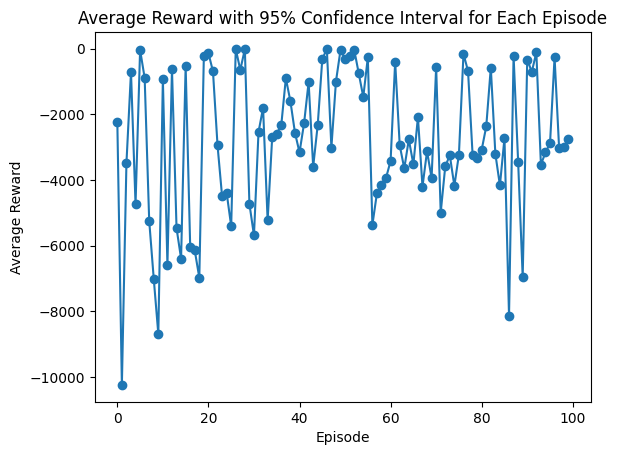

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
from collections import deque, namedtuple
import torch.nn.functional as F


# Defining the DQN Model
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(x.size(0), -1)  # Reshape to ensure 2D output

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

def optimize_model():
    if len(memory) < batch_size:
        return

    # Sample a batch of experiences from the replay memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Separate the batch into states, actions, rewards, and next_states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool, device=device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute Q-values for current states (state_action_values) using the model
    state_action_values = dqn_model(state_batch).gather(1, action_batch.unsqueeze(-1))

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = dqn_model(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q-values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss between current Q values and target Q values
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()




def select_action(state, epsilon):
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    if random.random() > epsilon:
        with torch.no_grad():
            return dqn_model(state_tensor).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.int64)

# Initialize parameters
num_agents = 1
num_episodes = 100
rewards_per_agent = []
batch_size = 32  # Set your batch size
gamma = 0.99  # Discount factor
state_size = 2  # Adjust according to your state representation
num_actions = 9  # Total number of possible actions

max_steps_per_episode = 500

for agent in range(num_agents):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create an instance of the DQN model and move it to the device
    dqn_model = DQN(state_size, 64, num_actions).to(device)
    memory = ReplayMemory(10000)
    optimizer = torch.optim.Adam(dqn_model.parameters())
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        print(state)
        total_reward = 0
        done = False
        steps = 0  # Initialize step counter
        while not done and steps < max_steps_per_episode:
            steps += 1  # Increment step counter
            action = select_action(state, epsilon=0.1)
            next_state, reward, done = env.step(action)
            print(next_state)
            total_reward += reward

            memory.push(torch.tensor([state], dtype=torch.float32),
                        torch.tensor([action.item()], dtype=torch.int64),
                        torch.tensor([next_state], dtype=torch.float32) if next_state is not None else None,
                        torch.tensor([reward], dtype=torch.float32))

            if len(memory) > batch_size:
                optimize_model()

            state = next_state

        rewards.append(total_reward)
    print(f"Agent {agent} completed training with 100 episodes")
    torch.save(dqn_model.state_dict(), f'agent_{agent}_weights.pth')
    rewards_per_agent.append(rewards)

average_rewards = np.mean(rewards_per_agent, axis=0)
std_dev = np.std(rewards_per_agent, axis=0)
confidence_intervals = scipy.stats.norm.interval(0.95, loc=average_rewards, scale=std_dev / np.sqrt(num_agents))

plt.errorbar(range(num_episodes), average_rewards, yerr=[average_rewards - confidence_intervals[0], confidence_intervals[1] - average_rewards], fmt='-o')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward with 95% Confidence Interval for Each Episode')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[24.053589  7.417397]
[24.906378  8.870108]
[25.797983 11.503792]
[26.303347 14.374014]
[26.73639  16.697838]
[27.166786 19.02316 ]
[26.69391  21.728334]
[26.443039 23.98913 ]
[26.192165 26.249924]
[26.192165 26.249924]
[25.941292 28.51072 ]
[24.893902 27.695879]
[24.643024 29.95667 ]
[24.392155 32.217464]
[24.141281 34.47826 ]
[24.189137 36.554043]
[24.488276 38.474194]
[25.159206 40.409092]
[26.300741 42.381107]
[27.442274 44.353123]
[28.583809 46.32514 ]
[29.725344 48.29716 ]
[30.866875 50.269176]
[32.00841 52.24119]
[33.149944 54.213215]
[34.291477 56.185226]
[35.43301  58.157246]
[36.574547 60.129265]
[37.71608  62.101284]
[38.857613 64.0733  ]
[39.487225 65.0312  ]
[40.407932 66.49822 ]
[39.99098  66.029274]
[40.883156 67.499344]
[40.31015 66.65037]
[39.47962 65.2834 ]
[38.649094 63.91643 ]
[37.81856  62.549465]
[36.988033 61.1825  ]
[36.1575   59.815525]
[35.326973 58.44856 ]
[35.846497 59.21048 ]
[35.535492 58.605427]
[35.224487 58.000378]
[34.913483 57.39533 ]
[34.602478 56.79

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.11268  45.256763]
[31.27478  44.293587]
[31.436872 43.330406]
[31.27478  44.293587]
[31.436872 43.330406]
[31.598969 42.367237]
[31.761066 41.404057]
[31.923164 40.44088 ]
[32.085255 39.4777  ]
[32.293827 38.421505]
[32.732735 36.904232]
[33.03553 35.02297]
[33.026764 31.501001]
[32.795296 27.459032]
[32.563824 23.417065]
[32.28343  19.005459]
[31.904993  13.8530655]
[32.385056 13.172226]
[32.006615  8.019825]
[31.148108  3.54826 ]
[30.2896    -0.9233034]
[29.431095  -5.3948755]
[28.59843  -9.893317]
[28.951027  -4.7140417]
[28.30734  -9.409023]
[28.617186 -4.185275]
[28.016254 -8.92473 ]
[28.30734  -9.409023]
[28.59843  -9.893317]
[ 29.052652 -10.54727 ]
[ 29.53272 -11.2281 ]
[ 29.634346 -17.061333]
[ 29.735971 -22.894571]
[ 29.837597 -28.727797]
[ 29.958199 -34.44326 ]
[ 30.317663 -29.408632]
[ 30.400387 -34.953594]
[ 30.797728 -30.089464]
[ 30.84552 -35.2168 ]
[ 31.01575 -38.14811]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 30.321476 -37.865208]
[ 29.38322 -36.86442]
[ 28.444963 -35.86364 ]
[ 27.506706 -34.862854]
[ 27.731205 -36.647934]
[ 27.9557  -38.43301]
[ 28.180202 -40.21809 ]
[ 28.404705 -42.003166]
[ 28.6292   -43.788246]
[ 28.853699 -45.573326]
[ 28.618176 -46.3055  ]
[ 28.313112 -46.666126]
[ 28.98877  -44.536617]
[ 29.664433 -42.407116]
[ 30.340088 -40.27762 ]
[ 31.01575 -38.14811]
[ 31.739971 -35.71725 ]
[ 32.493324 -31.681454]
[ 33.226315 -27.539715]
[ 33.90229  -22.650362]
[ 34.816162 -16.163996]
[ 34.66594  -17.477535]
[ 35.59597  -10.882698]
[ 35.408474 -12.110927]
[ 34.790726 -12.354368]
[ 34.23176  -12.203196]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.751694 -11.52236 ]
[ 33.373253 -16.67476 ]
[ 32.994812 -21.827162]
[ 32.616367 -26.97956 ]
[ 32.213753 -31.81495 ]
[ 31.739971 -35.71725 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 25.448605 -43.01775 ]
[ 24.945333 -43.226513]
[ 24.442062 -43.435276]
[ 23.938793 -43.644035]
[ 23.43552  -43.852795]
[ 22.932251 -44.061558]
[ 22.428982 -44.270317]
[ 21.925709 -44.47908 ]
[ 21.42244 -44.68784]
[ 21.723373 -46.263927]
[ 22.527578 -47.631252]
[ 22.024305 -47.840015]
[ 22.527578 -47.631252]
[ 22.024305 -47.840015]
[ 21.543858 -48.074062]
[ 21.107973 -48.357483]
[ 20.67209  -48.640903]
[ 20.236212 -48.92432 ]
[ 19.800327 -49.20775 ]
[ 20.286898 -50.989506]
[ 19.851015 -51.27293 ]
[ 19.415133 -51.556347]
[ 18.979248 -51.839764]
[ 19.02994  -53.904945]
[ 18.594059 -54.188366]
[ 18.158173 -54.47179 ]
[ 17.722294 -54.755215]
[ 17.28641 -55.03863]
[ 16.850527 -55.322056]
[ 16.414642 -55.605476]
[ 15.978763 -55.888897]
[ 15.978763 -55.888897]
[ 15.542882 -56.172314]
[ 15.106999 -56.455738]
[ 14.671115 -56.739162]
[ 14.235233 -57.02258 ]
[ 13.79935  -57.306004]
[ 13.363469 -57.589428]
[ 12.927587 -57.872845]
[ 12.491704 -58.15627 ]
[ 13.414157 -59.6546  ]
[ 14.336608 -61.1529

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 22.152119 -72.85622 ]
[ 23.074568 -74.35456 ]
[ 23.997025 -75.85289 ]
[ 24.62589 -76.80787]
[ 24.72392 -76.78037]
[ 24.821955 -76.75288 ]
[ 24.919987 -76.72538 ]
[ 24.894365 -77.55918 ]
[ 24.992388 -77.531685]
[ 24.729712 -75.829285]
[ 24.992388 -77.531685]
[ 24.969788 -75.991264]
[ 24.883429 -74.15475 ]
[ 24.79706  -72.318245]
[ 24.710693 -70.481735]
[ 24.624329 -68.645226]
[ 24.537962 -66.808716]
[ 24.624329 -68.645226]
[ 24.624329 -68.645226]
[ 24.864407 -68.80721 ]
[ 24.778044 -66.9707  ]
[ 25.018114 -67.1327  ]
[ 25.258188 -67.294685]
[ 25.498264 -67.45666 ]
[ 25.738337 -67.61865 ]
[ 25.888096 -67.361244]
[ 26.037376 -65.666176]
[ 26.186666 -63.971096]
[ 26.335947 -62.276028]
[ 26.48523 -60.58095]
[ 26.634514 -58.885876]
[ 26.7838 -57.1908]
[ 26.93308 -55.49573]
[ 27.082367 -53.80066 ]
[ 27.231655 -52.10558 ]
[ 27.275436 -50.87341 ]
[ 27.352032 -48.591324]
[ 27.637453 -48.79562 ]
[ 27.946386 -48.45708 ]
[ 28.189419 -47.742092]
[ 28.139942 -46.357616]
[ 27.915447 -44.572536]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 27.690945 -42.78746 ]
[ 27.466446 -41.00238 ]
[ 27.241947 -39.217304]
[ 27.017448 -37.432224]
[ 26.792948 -35.647144]
[ 26.568449 -33.862064]
[ 26.34395 -32.07699]
[ 26.119453 -30.29191 ]
[ 25.89495 -28.50683]
[ 25.670452 -26.72175 ]
[ 25.670452 -26.72175 ]
[ 25.670452 -26.72175 ]
[ 25.445953 -24.936674]
[ 25.221455 -23.151596]
[ 24.278313 -22.162695]
[ 23.496841 -20.41953 ]
[ 22.327639 -19.627941]
[ 21.1608  -18.84017]
[ 20.07983  -18.190859]
[ 18.998857 -17.541552]
[ 17.917885 -16.892239]
[ 17.315706 -15.438205]
[ 16.86039  -14.013585]
[ 16.313658 -13.233261]
[ 15.853488 -12.26791 ]
[ 15.493578 -11.656355]
[ 15.304728 -11.251061]
[ 15.115878 -10.845768]
[ 14.927027 -10.440475]
[ 14.922472 -10.141266]
[14.935378 -9.852107]
[14.948286 -9.562948]
[14.961191 -9.273789]
[14.913087 -8.678709]
[14.864983 -8.083628]
[14.816878  -7.4885497]
[14.768773  -6.8934693]
[14.707763 -6.587548]
[14.646751 -6.281626]
[14.58574   -5.9757047]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.435216  -5.4106555]
[14.214566 -4.839867]
[13.993918  -4.2690797]
[14.214566 -4.839867]
[13.993918  -4.2690797]
[13.773269  -3.6982906]
[13.535579  -2.9272678]
[13.297889 -2.156243]
[13.060912  -1.3858674]
[12.825057  -0.6165088]
[12.589202   0.1528501]
[12.353345   0.9222099]
[12.106847  1.61116 ]
[11.812112   1.9356539]
[11.550851   2.1888757]
[11.289594   2.4420965]
[11.028332   2.6953185]
[10.767072   2.9485397]
[10.539288   3.1304893]
[10.278029  3.38371 ]
[9.737567  3.6099463]
[9.2504225 3.7101414]
[9.835869  3.6259017]
[9.934169  3.6418588]
[10.011985   3.6593032]
[10.00222    3.6831105]
[10.00855    3.7097905]
[10.052194   3.7431335]
[10.0958395  3.7764778]
[10.139483   3.8098218]
[10.183129   3.8431656]
[10.226774  3.87651 ]
[10.270419   3.9098537]
[10.314063  3.943198]
[10.357709   3.9765413]
[10.401353   4.0098863]
[10.445     4.043229]
[10.575075   3.9836304]
[10.705151  3.924032]
[10.661504   3.8906877]
[10.791579   3.8310888]
[10.929883   3.7735078]
[11.077752   3.696

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.209377   7.0702586]
[12.191455  7.210401]
[12.173532   7.3505445]
[12.155608  7.490689]
[12.137685   7.6308303]
[12.11976   7.770973]
[12.101838  7.911117]
[12.083913  8.051263]
[12.0659895  8.191404 ]
[12.048066  8.331547]
[12.030143  8.47169 ]
[12.012219  8.611834]
[11.994297  8.751978]
[11.976373  8.892119]
[11.958449  9.032265]
[11.940526  9.172407]
[11.922603  9.31255 ]
[11.904679  9.452692]
[11.904679  9.452692]
[11.886756  9.592838]
[11.868832  9.732979]
[11.886756  9.592838]
[11.977563  9.615252]
[11.868832  9.732979]
[11.959639  9.755394]
[12.0549555  9.776842 ]
[12.152242  9.797866]
[12.249527  9.818891]
[12.357408  9.701345]
[12.465288  9.583799]
[12.57317   9.466252]
[12.681048  9.348707]
[12.788931  9.231163]
[12.8968115  9.113617 ]
[13.004691  8.996071]
[13.112573  8.878525]
[13.220454  8.76098 ]
[13.209859   8.8995495]
[13.317739  8.782004]
[13.42562  8.66446]
[13.5335    8.546915]
[13.641381  8.429369]
[13.749263  8.311822]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[13.857142  8.194278]
[13.957725  8.081081]
[13.976937  8.01638 ]
[13.99615    7.9516788]
[14.015361   7.8869805]
[14.089929   7.9215446]
[14.164497   7.9561076]
[14.239064   7.9906726]
[14.36899   8.124499]
[14.498914   8.2583275]
[14.6288395  8.392155 ]
[14.758764  8.525982]
[14.7395525  8.590681 ]
[14.869477  8.724509]
[23.933392  -2.8084128]
[22.641624  -3.4702718]
[21.827034  -1.8757894]
[20.964743  -0.5664237]
[20.01698     0.23198815]
[19.069216   1.0304024]
[18.10859    2.0557249]
[17.121315  3.126425]
[16.134035  4.197121]
[15.712372   2.5828695]
[15.511006  3.887983]
[15.242186   4.6834264]
[14.950146   5.3034472]
[14.658105  5.923466]
[14.366067   6.5434856]
[14.156559  6.998303]
[14.024184   7.2987304]
[13.8918085  7.599154 ]
[13.769064   7.9042583]
[13.660068  8.216039]
[13.551068  8.527818]
[13.44207   8.839598]
[13.333072  9.15138 ]
[13.224072  9.463159]
[13.115075  9.774939]
[12.828771 10.181361]
[12.007318 10.0137  ]
[11.624408  9.933777]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.476884  9.888115]
[11.36147   9.846539]
[11.246055  9.804962]
[11.130638  9.763386]
[11.0152235  9.721809 ]
[10.899809  9.680234]
[10.784392  9.638658]
[10.668978  9.59708 ]
[10.553562  9.555505]
[10.438148  9.513927]
[10.322732  9.472352]
[10.252839  9.482714]
[10.312601  9.924427]
[10.39823   10.3951025]
[10.49369  10.877267]
[10.589147 11.35943 ]
[10.684605 11.841594]
[10.407894 10.870316]
[10.263574 10.04986 ]
[10.179525  9.670651]
[10.048355  9.401734]
[9.896777 9.180577]
[9.745196 8.959421]
[9.593619 8.738262]
[9.442042 8.517105]
[9.290463 8.295951]
[9.567787 8.804171]
[9.541957 8.870078]
[9.516124 8.935986]
[9.490293 9.001894]
[9.6418705 9.223051 ]
[9.6418705 9.223051 ]
[9.516124 8.935986]
[9.516124 8.935986]
[9.516124 8.935986]
[9.516124 8.935986]
[9.516124 8.935986]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.516124 8.935986]
[9.516124 8.935986]
[9.2388   8.427765]
[9.2388   8.427765]
[9.2388   8.427765]
[9.2388   8.427765]
[9.212969 8.493673]
[9.187582 8.55969 ]
[9.167554 8.627022]
[9.147525 8.694353]
[9.167554 8.627022]
[9.147525 8.694353]
[9.127496  8.7616825]
[9.137439 8.859735]
[9.228246 8.88215 ]
[9.319052 8.904566]
[9.409859 8.926981]
[9.500665 8.949396]
[9.391935 9.067125]
[9.482741 9.089539]
[9.573548 9.111956]
[9.664354 9.13437 ]
[9.75516  9.156784]
[9.845966 9.179199]
[9.936772 9.201617]
[10.027579  9.224031]
[10.118386  9.246446]
[10.209192  9.268862]
[10.299999  9.291277]
[10.390805  9.313692]
[10.481612  9.336108]
[10.463688  9.476251]
[10.572417  9.358523]
[10.554494  9.498666]
[10.627376  9.661224]
[10.700261  9.823783]
[10.773143   9.9863405]
[10.8460245 10.1489   ]
[10.918908 10.311459]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.991792 10.474015]
[11.009713 10.333874]
[11.027638 10.19373 ]
[11.045561 10.053587]
[11.063485   9.9134445]
[11.0814085  9.773301 ]
[11.099332  9.633159]
[11.190138  9.655573]
[11.280946  9.677988]
[11.371751  9.700403]
[11.462556  9.722817]
[11.53544   9.885378]
[11.626246  9.907792]
[11.717052  9.930208]
[11.809035  9.952371]
[11.916915   9.8348255]
[12.014199  9.85585 ]
[12.122081  9.738304]
[12.134049  9.59944 ]
[12.151973  9.459296]
[12.169896  9.319153]
[12.187818  9.179009]
[12.205743  9.038868]
[12.223665  8.898723]
[12.24159   8.758581]
[12.259513  8.618437]
[12.277435  8.478294]
[12.350318  8.640854]
[12.423202   8.8034115]
[12.496085  8.965969]
[12.496085  8.965969]
[12.496085  8.965969]
[12.496085  8.965969]
[12.496085  8.965969]
[12.496085  8.965969]
[12.496085  8.965969]
[12.514008  8.825827]
[12.531932  8.685683]
[12.549856  8.54554 ]
[12.549856  8.54554 ]
[12.567779  8.405396]
[12.585702  8.265255]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.676509  8.28767 ]
[12.767314  8.310085]
[12.858121  8.332499]
[12.948926  8.354914]
[13.039733  8.377331]
[13.130539  8.399746]
[13.221345  8.422161]
[13.312152  8.444576]
[13.420883  8.326849]
[13.529611  8.209122]
[13.638343  8.091393]
[13.74707    7.9736648]
[13.788409   7.8961043]
[13.80847  7.83122]
[13.82853    7.7663374]
[13.84859    7.7014565]
[13.868651   7.6365733]
[13.888714   7.5716915]
[13.908773  7.50681 ]
[13.860745  7.405973]
[13.812717  7.305137]
[13.764689  7.2043  ]
[13.716662   7.1034636]
[13.716662   7.1034636]
[13.716662   7.1034636]
[13.716662   7.1034636]
[13.764689  7.2043  ]
[13.764689  7.2043  ]
[13.832779  7.240255]
[13.900868  7.276209]
[13.968955  7.312165]
[14.0370455  7.348119 ]
[14.105132  7.384073]
[14.17739   7.419133]
[14.251958   7.4536977]
[14.326526   7.4882607]
[14.271168  7.388996]
[14.215813   7.2897334]
[14.235024  7.225034]
[14.165315   7.1894255]
[14.185376   7.1245456]
[14.205438  7.059663]
[14.225499   6.9947805]
[14.225499   6.9947805

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.15741    6.9588275]
[14.273526  7.095616]
[14.225499   6.9947805]
[14.177472   6.8939443]
[14.129443  6.793108]
[14.088497   6.6921887]
[14.129443  6.793108]
[14.109382   6.8579907]
[14.177472   6.8939443]
[14.129443  6.793108]
[14.088497   6.6921887]
[14.103681   6.5906243]
[14.118867  6.48906 ]
[14.118867  6.48906 ]
[14.13405    6.3874965]
[14.149236  6.285932]
[14.13405    6.3874965]
[14.179495  6.525101]
[14.118867  6.48906 ]
[14.1643095  6.626666 ]
[14.217593  6.76418 ]
[14.333709   6.9009724]
[14.386439   7.0007977]
[14.441796  7.100063]
[14.497153  7.199326]
[14.552509  7.298589]
[14.607865   7.3978543]
[14.663221  7.497115]
[14.663221  7.497115]
[14.737792  7.531681]
[14.757003   7.4669795]
[14.757003   7.4669795]
[14.757003   7.4669795]
[14.757003   7.4669795]
[14.886928   7.6008067]
[15.016852   7.7346363]
[15.146777  7.868463]
[15.221345  7.903026]
[15.295913  7.937589]
[15.3704815  7.972152 ]
[15.445051  8.006718]
[15.574975  8.140545]
[15.649544  8.17511 ]
[15.724112  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.570595 -10.976066]
[ 15.302799 -10.207555]
[15.109545 -9.528924]
[15.10514  -9.255587]
[15.100735 -8.982248]
[15.116344 -8.694349]
[15.330548 -7.585054]
[15.537308 -6.42151 ]
[15.744065 -5.257966]
[15.206783  -4.2945256]
[14.474674  -4.4233017]
[13.8834505 -3.7823155]
[14.615558  -3.6535385]
[14.024335 -3.012553]
[13.43311   -2.3715668]
[13.573995  -1.6018038]
[12.982919   -0.96095425]
[12.39375    -0.32183343]
[12.061172    0.41249794]
[11.825316   1.1818569]
[11.808841   1.3815799]
[11.792365   1.5812993]
[11.509189   1.9931266]
[11.214454  2.31762 ]
[10.919719   2.6421134]
[10.624982   2.9666085]
[10.220994   3.3407106]
[9.759389  3.6025035]
[9.3705435 3.7186558]
[9.001866  3.8384101]
[8.801301 3.985727]
[9.153574  3.8639047]
[9.567143  3.7505693]
[10.023407   3.6526165]
[10.196833   3.5752091]
[10.457602   3.3229694]
[10.718863   3.0697477]
[10.980123  2.816527]
[11.241382   2.5633051]
[11.502642   2.3100843]
[11.730425  2.128136]
[11.958209   1.9461865]
[11.69695    2.1994076

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.335263   2.6664453]
[11.301785   2.7377183]
[11.26831   2.808991]
[11.26831   2.808991]
[11.529571   2.5557687]
[11.496095   2.6270413]
[11.462618  2.698314]
[11.462618  2.698314]
[11.429143  2.769586]
[11.398583   2.8415747]
[11.368873   2.9137697]
[11.33916    2.9859657]
[11.353619   3.0545523]
[11.385465   3.1217163]
[11.41731    3.1888793]
[11.449155  3.256044]
[11.480998   3.3232093]
[11.512845  3.390373]
[11.3468485  3.6341724]
[11.214383   3.8108594]
[11.124211   3.9028852]
[11.0340395  3.994911 ]
[10.943871   4.0869374]
[11.082225  4.029368]
[10.992055   4.1213937]
[10.901883   4.2134204]
[10.811713  4.305446]
[10.721541  4.397472]
[10.6313715  4.4894967]
[10.589385   4.6159806]
[10.568363  4.745131]
[10.613807   4.8827357]
[10.659251   5.0203414]
[10.674437  4.918775]
[10.68962    4.8172126]
[10.733939  4.719353]
[10.824108   4.6273274]
[10.914279   4.5353017]
[11.004451   4.4432764]
[10.962462   4.5697594]
[11.052636  4.477733]
[11.10082    4.5121922]
[11.149003   4.54664

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.43811    4.7533937]
[11.576465  4.695826]
[11.714821   4.6382575]
[11.853177  4.580688]
[11.99153    4.5231214]
[12.129887   4.4655523]
[12.268243  4.407985]
[12.406596   4.3504157]
[12.544952   4.2928476]
[12.635123   4.2008204]
[12.725293   4.1087976]
[12.877401   3.8927953]
[12.845555   3.8256323]
[12.679563   4.0694304]
[12.635123   4.2008204]
[12.593138   4.3273053]
[12.55115  4.45379]
[12.509165  4.580272]
[12.467177   4.7067566]
[12.425192  4.833238]
[12.383204  4.959721]
[12.341218   5.0862064]
[12.299231  5.212689]
[12.326718   5.3480096]
[12.326718   5.3480096]
[12.372163   5.4856143]
[12.372163   5.4856143]
[12.372163   5.4856143]
[12.372163   5.4856143]
[12.372163   5.4856143]
[12.372163   5.4856143]
[12.387347  5.384049]
[12.402532   5.2824855]
[12.485772  5.189577]
[12.575942  5.097552]
[12.533956  5.224036]
[12.6241255  5.1320095]
[12.714298  5.039984]
[12.804467   4.9479585]
[12.894641  4.855932]
[12.984809  4.763908]
[13.032995  4.798363]
[13.081178   4.8328204]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.6619835  3.7658806]
[13.796134   3.4549158]
[13.930284   3.1439526]
[14.064431  2.832991]
[14.198581   2.5220258]
[14.032588  2.765824]
[13.866593   3.0096235]
[13.700601   3.2534215]
[13.534604   3.4972217]
[13.368614   3.7410195]
[13.202619   3.9848192]
[13.056387  4.189057]
[12.966216  4.281084]
[12.876045   4.3731093]
[12.876045   4.3731093]
[12.876045   4.3731093]
[12.876045   4.3731093]
[12.876045   4.3731093]
[12.785874   4.4651365]
[12.695703   4.5571613]
[12.695703   4.5571613]
[12.605533   4.6491885]
[12.557349   4.6147294]
[12.605533   4.6491885]
[12.653718   4.6836452]
[12.701901  4.718102]
[12.750085   4.7525606]
[12.798271   4.7870173]
[12.846456   4.8214746]
[12.894641  4.855932]
[12.942822   4.8903904]
[12.900838  5.016874]
[12.85885    5.1433563]
[12.816865   5.2698393]
[12.781493  5.397164]
[12.826938   5.5347705]
[12.842122  5.433205]
[12.913234   5.3387556]
[13.003406  5.246728]
[13.0935755  5.1547036]
[13.183745  5.062679]
[13.273915   4.9706516]
[13.273915   4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.936627  4.729448]
[12.88844    4.6949925]
[12.936627  4.729448]
[12.984809  4.763908]
[13.032995  4.798363]
[13.081178   4.8328204]
[13.129363   4.8672795]
[13.177547   4.9017377]
[13.225732  4.936195]
[13.273915   4.9706516]
[13.135559   5.0282207]
[13.183745  5.062679]
[13.183745  5.062679]
[13.183745  5.062679]
[13.183745  5.062679]
[13.322101   5.0051103]
[13.412272  4.913083]
[13.502442   4.8210588]
[13.592615   4.7290316]
[13.682783  4.637007]
[13.772956  4.544981]
[13.821139   4.5794377]
[13.863128   4.4529543]
[13.916739   4.3031974]
[13.814942  4.418497]
[13.724771   4.5105233]
[13.6346    4.602548]
[13.682783  4.637007]
[13.724771   4.5105233]
[13.766758   4.3840384]
[13.853052   4.1688666]
[13.987199   3.8579056]
[14.12135    3.5469398]
[14.255499  3.235978]
[14.40003    2.9249003]
[14.563933   2.6136146]
[14.727835   2.3023312]
[14.891739  1.991044]
[14.727835   2.3023312]
[14.563933   2.6136146]
[14.563933   2.6136146]
[14.563933   2.6136146]
[14.563933   2.6136146]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.000744   2.6986618]
[13.834748   2.9424603]
[13.668756   3.1862595]
[13.534604   3.4972217]
[13.4004545  3.8081863]
[13.266308  4.119148]
[13.20094    4.2924304]
[13.158955   4.4189143]
[13.116969  4.545397]
[12.978613  4.602966]
[13.068782   4.5109406]
[13.158955   4.4189143]
[13.249123   4.3268895]
[13.339295  4.234863]
[13.49599    4.0096793]
[13.49599    4.0096793]
[13.464147   3.9425132]
[13.464147   3.9425132]
[13.464147   3.9425132]
[13.339295  4.234863]
[13.249123   4.3268895]
[13.158955   4.4189143]
[13.068782   4.5109406]
[12.978613  4.602966]
[12.930427   4.5685086]
[12.882245   4.5340495]
[13.020598   4.4764824]
[12.972414   4.4420257]
[12.924231   4.4075675]
[12.876045   4.3731093]
[12.827861  4.338653]
[12.7796755  4.304195 ]
[12.869847  4.212169]
[12.7796755  4.304195 ]
[12.869847  4.212169]
[12.827861  4.338653]
[12.785874   4.4651365]
[12.743889  4.59162 ]
[12.701901  4.718102]
[12.659915  4.844585]
[12.6179285  4.971069 ]
[12.575942  5.097552]
[12.533956  5.224036

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.690385   6.0065513]
[12.6751995  6.1081166]
[12.692941   6.2093015]
[12.74097    6.3101377]
[12.788997  6.410974]
[12.837026   6.5118113]
[12.885053  6.612648]
[12.933081  6.713486]
[12.953142  6.648603]
[12.973203  6.583721]
[12.993264   6.5188384]
[13.013324  6.453956]
[12.965295   6.3531203]
[12.917714   6.2522783]
[12.965295   6.3531203]
[13.013324  6.453956]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.061353   6.5547953]
[13.081412  6.489912]
[13.149501   6.5258665]
[13.217591   6.5618215]
[13.197528  6.626703]
[13.265618   6.6626587]
[13.333707  6.698613]
[13.285679  6.597776]
[13.237651   6.4969397]
[13.189622  6.396102]
[13.175417   6.2948766]
[13.190601  6.193311]
[13.236045   6.3309164]
[13.325801  6.468013]
[13.441916  6.604804]
[13.558034  6.741595]
[13.67415    6.8783865]
[13.790267   7.0151772]
[13.9063835  7.15197  ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.070529   7.3895984]
[14.140363   7.4251795]
[14.140363   7.4251795]
[14.140363   7.4251795]
[14.270286   7.5590043]
[14.214929   7.4597416]
[14.214929   7.4597416]
[14.270286   7.5590043]
[14.344855   7.5935698]
[14.419422   7.6281333]
[14.493991   7.6626964]
[14.549348  7.76196 ]
[14.604705   7.8612227]
[14.660062  7.960488]
[14.660062  7.960488]
[14.715417  8.05975 ]
[14.770776  8.159014]
[14.826131  8.258277]
[14.881487  8.357542]
[15.011413  8.491371]
[14.956056  8.392103]
[14.900699  8.292842]
[14.845342  8.193578]
[14.864554  8.12888 ]
[14.883765  8.064179]
[14.902976  7.999478]
[14.922189   7.9347777]
[14.9414     7.8700805]
[14.960612   7.8053775]
[14.979824  7.740679]
[14.999036   7.6759796]
[15.018248   7.6112795]
[15.037457   7.5465784]
[15.112027  7.581143]
[15.186595   7.6157084]
[15.131238   7.5164433]
[15.075881  7.417181]
[15.020526   7.3179154]
[14.965168   7.2186546]
[14.909812   7.1193886]
[14.85892    7.0200753]
[14.859532   6.9201665]
[14.932433  7.054651]
[15.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.081297   6.8240795]
[15.081297   6.8240795]
[15.081297   6.8240795]
[15.081297   6.8240795]
[15.081297   6.8240795]
[15.081297   6.8240795]
[15.081297   6.8240795]
[15.007784  6.789504]
[14.93427   6.754927]
[14.860756   6.7203503]
[14.787242   6.6857753]
[14.861367  6.620443]
[14.888078  6.532176]
[14.938331  6.448442]
[14.992496   6.3642645]
[15.046658  6.280085]
[15.10082    6.1959057]
[15.10082    6.1959057]
[15.122738  6.323016]
[15.068574  6.407196]
[15.016633  6.491122]
[14.977043  6.573643]
[14.937453   6.6561656]
[14.93427   6.754927]
[14.933659   6.8548346]
[14.933047  6.954743]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.932433  7.054651]
[14.933047  6.954743]
[14.933659   6.8548346]
[14.93427   6.754927]
[14.933659   6.8548346]
[14.933047  6.954743]
[14.932433  7.054651]
[14.909812   7.1193886]
[14.965168   7.2186546]
[15.020526   7.3179154]
[15.075881  7.41

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.297309  7.814235]
[15.427234   7.9480624]
[15.557158  8.081888]
[15.687082  8.215716]
[15.631725  8.116454]
[15.576369  8.01719 ]
[15.521012   7.9179254]
[15.5018015  7.9826255]
[15.4464445  7.8833613]
[15.371878   7.8487983]
[15.297309  7.814235]
[15.222741  7.779672]
[15.148171   7.7451057]
[15.073604   7.7105427]
[14.999036   7.6759796]
[14.924467  7.641417]
[14.849899   7.6068516]
[14.775331  7.572288]
[14.700762   7.5377245]
[14.626193   7.5031614]
[14.645406  7.438461]
[14.700762   7.5377245]
[14.756118   7.6369877]
[14.811476   7.7362514]
[14.756118   7.6369877]
[14.700762   7.5377245]
[14.645406  7.438461]
[14.590049   7.3391976]
[14.534693   7.2399344]
[14.479336   7.1406713]
[14.42398    7.0414066]
[14.368623   6.9421434]
[14.319164   6.8416142]
[14.297111   6.7404785]
[14.312296   6.6389136]
[14.327482   6.5373483]
[14.312296   6.6389136]
[14.297111   6.7404785]
[14.319164   6.8416142]
[14.368623   6.9421434]
[14.299104   6.9064956]
[14.231014   6.8705406]
[14.162926   6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.754394  6.618858]
[13.686304   6.5829024]
[13.618216   6.5469484]
[13.550127  6.510994]
[13.493747  6.373513]
[13.433118  6.337474]
[13.37249    6.3014336]
[13.37249    6.3014336]
[21.974491   2.2660987]
[20.802368   3.4154556]
[19.630247  4.564813]
[19.463991   5.8541627]
[19.286716   7.0602546]
[19.032887  7.68792 ]
[17.73287    7.8709874]
[18.525223  8.943254]
[31.24598   -2.6301997]
[30.028854  -0.8541644]
[28.81173     0.92187566]
[27.594604  2.697913]
[26.328999  4.184143]
[26.328999  4.184143]
[25.146206   5.3145785]
[25.312462  4.025227]
[25.312462  4.025227]
[25.312462  4.025227]
[25.312462  4.025227]
[25.146206   5.3145785]
[24.979952  6.603928]
[24.813696   7.8932796]
[24.979952  6.603928]
[24.813696   7.8932796]
[26.008661  8.368574]
[27.275402  9.017343]
[28.248922 10.310892]
[29.222446 11.604439]
[30.601303 10.846654]
[31.572575  12.1267395]
[32.510185 13.20564 ]
[33.272976  14.5701475]
[33.66587  16.538908]
[34.05877  18.507677]
[34.45166  20.476442]
[34.955677 22.35

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.526993 25.121655]
[35.526993 25.121655]
[35.526993 25.121655]
[35.526993 25.121655]
[36.062008 20.393688]
[36.399097 15.422392]
[36.50005  10.160793]
[36.53707    5.0036283]
[35.879295  8.367745]
[35.481133   4.0159802]
[34.269592   5.7739463]
[33.058044   7.5319085]
[31.8465    9.289873]
[31.182817   5.3741074]
[29.971273  7.132071]
[28.654259  8.259558]
[29.62778   9.553104]
[30.601305 10.846657]
[31.572575  12.1267395]
[32.510185 13.205639]
[33.272976  14.5701475]
[33.66587  16.538908]
[34.05877  18.507677]
[34.45166  20.476442]
[34.955677 22.359516]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[35.57644  24.152557]
[34.191956 25.545784]
[34.955677 22.359516]
[33.790108 23.52352 ]
[34.45166  20.476442]
[33.388264 21.501259]
[34.05877  18.507677]
[34.66474  15.128367]
[33.66587  16.538908]
[34.27185  13.159601]
[34.877823  9.780294]
[33.721733 11.447677]
[33.99566   8.6108

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.78412  10.368774]
[32.78412  10.368774]
[33.99566   8.610809]
[35.2072     6.8528447]
[34.543514   2.9370782]
[35.761257   1.1743305]
[36.323837  -3.1662152]
[35.84556  -9.133781]
[ 34.915527 -15.728619]
[35.84556  -9.133781]
[36.323837  -3.1662152]
[35.761257   1.1743305]
[34.543514   2.9370782]
[33.33197   4.695043]
[32.120434  6.453007]
[30.908888  8.210973]
[29.62778   9.553104]
[28.248924 10.310892]
[29.222446 11.604439]
[27.843588 12.362225]
[27.438251 14.413565]
[27.843588 12.362225]
[27.438251 14.413565]
[27.438251 14.413565]
[27.438251 14.413565]
[27.438251 14.413565]
[27.438251 14.413565]
[27.438251 14.413565]
[27.438251 14.413565]
[28.817108 13.655771]
[28.817108 13.655771]
[29.222446 11.604439]
[29.62778   9.553104]
[29.222446 11.604439]
[28.654259  8.259558]
[27.500593  6.202145]
[28.778961  6.825335]
[29.971273  7.132071]
[30.908888  8.210973]
[31.8465    9.289873]
[32.78412  10.368774]
[33.721733 11.447677]
[34.27185  13.159601]
[33.99566   8.610809]
[32.78412  10.36

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[30.195969 12.897992]
[30.195969 12.897992]
[28.817108 13.655771]
[28.248924 10.310892]
[26.870064 11.068673]
[25.491207 11.826466]
[24.015968 11.856062]
[22.626179 11.848898]
[21.333445 12.025612]
[33.291573 28.027922]
[33.823032 24.866251]
[33.291573 28.027922]
[32.941162 26.394312]
[31.673393 26.020592]
[30.405626 25.646868]
[29.137856 25.27315 ]
[27.928745 24.782015]
[26.881351 23.967175]
[25.833958 23.152332]
[24.78656 22.33749]
[25.833958 23.152332]
[25.184822 23.87531 ]
[24.53569  24.598286]
[23.886557 25.321262]
[23.237427 26.044237]
[23.886557 25.321262]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.53569  24.598286]
[24.933952 26.136103]
[25.332214 27.67392 ]
[25.730473 29.211739]
[26.128733 30.749556]
[26.526995 32.28737 ]
[26.925255 33.82519 ]
[27.323515 35.363007]
[27.574389 33.102215]
[28.621782 33.917053]
[28.872654 31.656261]
[29.123528 2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.583084 25.413128]
[25.583084 25.413128]
[26.23222 24.69015]
[26.23222 24.69015]
[26.23222 24.69015]
[26.23222 24.69015]
[26.23222 24.69015]
[26.881351 23.967175]
[27.530485 23.244198]
[28.43705  22.005934]
[29.354412 20.746044]
[30.271774 19.486158]
[29.004004 19.112434]
[27.68402  18.768463]
[26.173687 18.532923]
[24.808022 18.00781 ]
[23.54382  17.279598]
[22.279621 16.55139 ]
[21.015419 15.823175]
[28.18822  15.923536]
[26.681316 15.713888]
[25.170986 15.478349]
[23.660656 15.242809]
[24.199299 14.198667]
[22.68897  13.963127]
[21.415436 13.36245 ]
[28.742722 25.617378]
[27.63504  24.923212]
[26.587646 24.108372]
[25.540253 23.29353 ]
[24.49286  22.478691]
[23.445465 21.663849]
[22.398073 20.849005]
[21.35068  20.034164]
[20.303284 19.219324]
[19.255892 18.404484]
[18.208496 17.589643]
[ 13.187058 -20.917843]
[ 13.714737 -19.216696]
[ 14.272547 -17.753311]
[ 14.885207 -16.632662]
[ 15.543439 -15.739086]
[ 16.201672 -14.845511]
[ 16.859901 -13.95194 ]
[ 17.518131 -13.058365]
[ 17

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.719166 -14.269976]
[ 16.64931   -14.0753145]
[ 16.531332 -13.560237]
[ 16.413355 -13.045157]
[ 16.295378 -12.530079]
[ 16.177402 -12.015   ]
[ 16.059425 -11.499919]
[ 16.06595  -11.301129]
[ 16.06595  -11.301129]
[ 15.987628 -10.677622]
[ 15.987628 -10.677622]
[ 15.907477 -10.340986]
[15.859374 -9.745907]
[15.811268  -9.1508255]
[15.763448 -8.555676]
[15.720788  -7.9592614]
[15.678127 -7.362847]
[15.695258 -7.07265 ]
[15.652598 -6.476237]
[15.609938  -5.8798203]
[15.53649   -5.4674325]
[15.533971  -5.2947135]
[15.451341 -4.937226]
[15.3687105 -4.579738 ]
[15.286082  -4.2222514]
[15.203452  -3.8647618]
[15.123343  -3.6799953]
[15.043236  -3.4952285]
[14.960605  -3.1377382]
[14.877976  -2.7802508]
[14.795993 -2.423351]
[14.714396 -2.0668  ]
[14.601455  -1.6270947]
[14.36436    -0.85803944]
[14.127267   -0.08898644]
[14.127267   -0.08898644]
[14.127267   -0.08898644]
[13.890173    0.68006915]
[13.609826  1.12234 ]
[13.313853   1.4465301]
[13.313853   1.4465301]
[13.01788    1.7707202

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.921998   3.9646852]
[12.085792  3.856198]
[12.018367   4.0335994]
[11.976379   4.1600833]
[11.934395   4.2865663]
[11.892407  4.41305 ]
[11.850419  4.539534]
[11.8084345  4.6660166]
[11.8084345  4.6660166]
[11.8084345  4.6660166]
[11.8084345  4.6660166]
[11.670078   4.7235856]
[11.760249  4.631559]
[11.850419  4.539534]
[11.940591   4.4475083]
[12.030763   4.3554816]
[12.120932  4.263456]
[12.259288  4.205888]
[12.397643   4.1483207]
[12.536    4.09075]
[12.704381   3.9730804]
[12.90222    3.7964456]
[13.100057   3.6198113]
[13.297898   3.4431753]
[13.495736  3.266542]
[13.693573   3.0899084]
[13.8277235  2.7789447]
[13.693573   3.0899084]
[13.559424  3.400873]
[13.425277   3.7118335]
[13.291127   4.0227957]
[13.198185   4.2512746]
[13.156199   4.3777575]
[13.114213   4.5042415]
[13.072227   4.6307244]
[13.030237   4.7572083]
[13.12041    4.6651826]
[13.210584  4.573156]
[13.300751  4.481131]
[13.390924   4.3891044]
[13.481092   4.2970796]
[13.616344   4.1148195]
[13.481092   4.297

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.30695   4.642071]
[13.445306   4.5845017]
[13.403319   4.7109866]
[13.361332   4.8374696]
[13.3193445  4.963954 ]
[13.277358  5.090438]
[13.235372  5.216921]
[13.193385  5.343404]
[13.151399  5.469887]
[13.103213  5.435429]
[13.117194  5.569031]
[13.199582  5.504345]
[13.238453   5.6411133]
[13.283898  5.778718]
[13.329343  5.916324]
[13.374785  6.053929]
[13.420231  6.191533]
[13.465675  6.329139]
[13.511121   6.4667435]
[13.550334  6.567681]
[13.45049    6.4307027]
[13.482245   6.5317283]
[13.5302725  6.632564 ]
[13.646392  6.769355]
[13.666451  6.704472]
[13.686513  6.639591]
[13.666451  6.704472]
[13.686513  6.639591]
[13.706574   6.5747085]
[13.768821  6.509342]
[13.844636  6.443818]
[13.920449  6.378294]
[13.996264  6.31277 ]
[13.920449  6.378294]
[13.996264  6.31277 ]
[14.072076  6.247247]
[14.147891  6.181722]
[14.223704  6.116199]
[14.299518   6.0506744]
[14.299518   6.0506744]
[14.299518   6.0506744]
[14.299518   6.0506744]
[14.299518   6.0506744]
[14.299518   6.0506744]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.526982   6.7386727]
[14.600495   6.7732477]
[14.673398  6.907732]
[14.782183   7.0418015]
[14.9121065  7.175629 ]
[15.042031   7.3094563]
[14.986674  7.210193]
[14.931319  7.11093 ]
[14.89394    7.0114603]
[14.894551  6.911552]
[14.895164   6.8116446]
[14.895774   6.7117367]
[14.900596   6.6137047]
[14.857733   6.4889755]
[14.987975  6.447729]
[15.118218  6.406481]
[15.248462   6.3652334]
[15.378704   6.3239865]
[15.508945  6.28274 ]
[15.696648   6.2488008]
[15.891219  6.215737]
[16.08579   6.182672]
[16.280363  6.14961 ]
[16.344503   6.1910233]
[16.305405  6.305884]
[16.279177  6.420255]
[16.252947  6.534629]
[16.294668   6.6576447]
[16.344044   6.7816334]
[16.393417   6.9056244]
[16.442793  7.029613]
[16.492167   7.1536026]
[16.541542  7.277593]
[16.590914   7.4015822]
[16.64029   7.525573]
[16.689665  7.649562]
[16.739038   7.7735505]
[16.788475   7.8975406]
[16.89559   8.020864]
[17.002705  8.144192]
[ 26.182127 -14.974817]
[ 26.303074 -11.194891]
[25.867329 -8.715809]
[ 26.303

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.052738 -7.121324]
[24.238144  -5.5268426]
[23.423553 -3.93236 ]
[22.608961  -2.3378751]
[21.794369   -0.74339086]
[20.858688    0.12725468]
[19.88292     0.96947545]
[18.744282  2.104582]
[17.757006  3.17528 ]
[16.769726  4.24598 ]
[15.742363  4.892019]
[14.831315   5.1626687]
[13.920266  5.433317]
[14.539274   5.7826886]
[13.628229   6.0533366]
[14.028043   6.8769126]
[13.299134   6.7829785]
[12.570224   6.6890445]
[11.841317   6.5951114]
[11.112409  6.501178]
[10.384269  6.406548]
[10.5172205  6.105601 ]
[9.789523 6.010567]
[10.384269  6.406548]
[9.656573  6.3115134]
[9.354704  6.2486796]
[9.238731  6.2096047]
[9.238731  6.2096047]
[9.238731  6.2096047]
[9.238731  6.2096047]
[9.238731  6.2096047]
[9.238731  6.2096047]
[9.238731  6.2096047]
[8.850005  5.5716386]
[9.077832  5.8815994]
[8.724259 5.284575]
[8.446935 4.776353]
[8.179157  4.2716928]
[8.127608 3.970209]
[8.07171   4.1013665]
[8.206155  3.9836528]
[8.547186  3.8683226]
[9.079492 3.777322]
[9.664938  3.6930823]
[10.094699

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.083817  4.3175173]
[9.021764  4.4805007]
[9.090249  4.6419806]
[9.158736  4.8034606]
[9.2272215 4.96494  ]
[9.295709 5.126421]
[9.364197 5.287901]
[9.364197 5.287901]
[9.432683  5.4493804]
[9.501169  5.6108594]
[9.432683  5.4493804]
[9.413012  5.5890946]
[9.393344 5.72881 ]
[9.3736725 5.868524 ]
[9.442159 6.030005]
[9.510645 6.191485]
[9.579132  6.3529654]
[9.64762   6.5144444]
[9.719773 6.676824]
[9.792655  6.8393836]
[9.865539  7.0019403]
[9.938421  7.1644998]
[9.938421  7.1644998]
[10.011306  7.327059]
[10.084187   7.4896173]
[10.157071  7.652176]
[10.229953  7.814734]
[10.3028345  7.9772916]
[10.375718  8.13985 ]
[10.448601  8.30241 ]
[10.339871  8.420137]
[10.412754  8.582696]
[10.485638  8.745254]
[10.55852   8.907813]
[10.631404  9.070372]
[10.704287  9.23293 ]
[10.777169  9.395489]
[10.850053  9.558046]
[10.777169  9.395489]
[10.850053  9.558046]
[10.8321295  9.69819  ]
[10.814205  9.838332]
[10.796281   9.9784775]
[10.869163 10.141034]
[10.942048 10.303593]
[11.01493  10.46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.01493  10.466152]
[11.12366  10.348423]
[11.23239  10.230695]
[11.305272 10.393254]
[11.401492 10.414507]
[11.488184  10.5741005]
[11.574874 10.733696]
[11.661565  10.8932905]
[11.672159 10.754722]
[11.6827545 10.61615  ]
[11.672159 10.754722]
[11.6827545 10.61615  ]
[11.69335  10.477581]
[11.790635 10.498605]
[11.898516 10.38106 ]
[11.887921 10.519629]
[11.995802 10.402082]
[12.1036825 10.284538 ]
[12.211563 10.166992]
[12.124872 10.007397]
[12.027587  9.986373]
[11.930301  9.965348]
[11.833015   9.9443245]
[11.919706 10.103918]
[12.006397  10.2635145]
[12.093088 10.423105]
[12.179778 10.582703]
[12.266469 10.742296]
[12.353161 10.90189 ]
[12.439852 11.061483]
[12.526542 11.221077]
[12.613234 11.380672]
[12.623828 11.242102]
[12.634423 11.103533]
[12.645019 10.964962]
[12.655612 10.826393]
[12.666207 10.687823]
[12.774089 10.570278]
[12.8819685 10.452732 ]
[12.98985  10.335185]
[13.097732 10.21764 ]
[13.205611 10.100095]
[13.097732 10.21764 ]
[13.205611 10.100095]
[13.313493  9.98

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.852896  9.394822]
[13.960776  9.277279]
[14.068658  9.159731]
[14.058063  9.2983  ]
[22.666775   5.1046014]
[21.494652   6.2539554]
[20.322529   7.4033146]
[19.045345  7.758881]
[17.74533    7.9419484]
[16.83201    7.5344043]
[15.734734  7.774012]
[14.797887  7.692498]
[13.925346   7.5287952]
[13.196438   7.4348617]
[12.467528   7.3409286]
[11.73862    7.2469954]
[11.009711  7.153062]
[10.280803   7.0591288]
[9.835539  6.9842763]
[9.39829  6.289386]
[8.974311 5.599443]
[9.356488 5.665935]
[8.901622 4.974152]
[8.875733  5.2844563]
[8.901622 4.974152]
[9.091535 4.715478]
[9.091535 4.715478]
[9.281447 4.456804]
[9.471362 4.19813 ]
[9.661273  3.9394557]
[9.851186  3.6807826]
[10.1884775  3.127106 ]
[9.851186  3.6807826]
[9.851186  3.6807826]
[9.851186  3.6807826]
[9.269553  3.6941442]
[8.687919  3.7075076]
[8.330684  3.8061492]
[8.146748  3.9483669]
[8.14159   4.0977154]
[8.210076 4.259195]
[8.2785635 4.420674 ]
[8.347051  4.5821548]
[8.2785635 4.420674 ]
[8.347051  4.5821548]
[8.41553

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.620997  5.2280755]
[8.689484  5.3895545]
[8.75797   5.5510345]
[8.826457  5.7125144]
[8.826457  5.7125144]
[8.8461275 5.5728   ]
[8.865796 5.433086]
[8.885468  5.2933707]
[8.905137  5.1536565]
[8.924808  5.0139413]
[8.944477 4.874227]
[8.9641485 4.7345114]
[8.895661  4.5730314]
[8.915332  4.4333177]
[9.083471  4.2918925]
[9.29206  4.151794]
[9.083471  4.2918925]
[8.915332  4.4333177]
[8.895661  4.5730314]
[8.875991 4.712747]
[8.944477 4.874227]
[8.875991 4.712747]
[8.875991 4.712747]
[8.944477 4.874227]
[9.012963 5.035707]
[9.08145  5.197187]
[9.149937  5.3586664]
[9.218423 5.520148]
[9.149937  5.3586664]
[9.218423 5.520148]
[9.149937  5.3586664]
[9.130268  5.4983816]
[9.022441  5.6163316]
[9.00277   5.7560453]
[8.9831    5.8957605]
[9.00277   5.7560453]
[9.022441  5.6163316]
[9.042111  5.4766164]
[9.110597  5.6380973]
[9.179084  5.7995763]
[9.24757   5.9610567]
[9.316056 6.122536]
[9.384543  6.2840176]
[9.453031 6.445498]
[9.521517 6.606976]
[9.591881  6.7689166]
[9.70061 6.65119]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.882223  6.6960196]
[9.990953  6.5782924]
[10.063836   6.7408504]
[10.136718   6.9034085]
[10.2095995  7.065968 ]
[10.282484   7.2285256]
[10.355367  7.391084]
[10.282484   7.2285256]
[10.191678   7.2061105]
[10.100872   7.1836944]
[10.010066  7.161279]
[9.919259 7.138866]
[9.828452  7.1164513]
[9.737645  7.0940347]
[9.64684   7.0716186]
[9.556034 7.049204]
[9.465228 7.026788]
[9.483151  6.8866463]
[9.4136915 6.724925 ]
[9.345202  6.5634465]
[9.276716  6.4019656]
[9.20823   6.2404866]
[9.139744  6.0790057]
[9.071258 5.917526]
[9.00277   5.7560453]
[8.934283  5.5945654]
[8.865796 5.433086]
[8.797311 5.271606]
[8.77764 5.41132]
[8.75797   5.5510345]
[8.865796 5.433086]
[8.77764 5.41132]
[8.75797   5.5510345]
[8.7383   5.690749]
[8.75797   5.5510345]
[8.77764 5.41132]
[8.797311 5.271606]
[8.728824 5.110126]
[8.748493 4.970411]
[8.768164  4.8306966]
[8.787835  4.6909814]
[8.807504 4.551266]
[8.827174 4.411552]
[8.963918 4.27049 ]
[9.159606  4.1287484]
[9.540502 4.010567]
[9.940653  3.894

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.540502 4.010567]
[9.159606  4.1287484]
[8.963918 4.27049 ]
[8.827174 4.411552]
[8.807504 4.551266]
[8.787835  4.6909814]
[8.768164  4.8306966]
[8.748493 4.970411]
[8.748493 4.970411]
[8.748493 4.970411]
[8.748493 4.970411]
[8.748493 4.970411]
[8.728824 5.110126]
[8.748493 4.970411]
[8.768164  4.8306966]
[8.787835  4.6909814]
[8.807504 4.551266]
[8.827174 4.411552]
[8.963918 4.27049 ]
[8.915332  4.4333177]
[8.983818 4.594797]
[9.052304 4.756278]
[9.1207905 4.9177585]
[9.10112   5.0574727]
[9.08145  5.197187]
[9.061781 5.336901]
[9.042111  5.4766164]
[9.110597  5.6380973]
[9.130268  5.4983816]
[9.149937  5.3586664]
[9.042111  5.4766164]
[9.061781 5.336901]
[9.08145  5.197187]
[9.10112   5.0574727]
[9.1207905 4.9177585]
[9.228618 4.799808]
[9.336444 4.681859]
[9.605106 4.562058]
[9.528972 4.725203]
[9.581244  4.8868694]
[9.649732 5.04835 ]
[9.718218  5.2098303]
[9.786704  5.3713098]
[9.855191  5.5327907]
[9.923677  5.6942706]
[9.992165  5.8557496]
[9.992165  5.8557496]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.992165  5.8557496]
[9.992165  5.8557496]
[9.992165  5.8557496]
[9.992165  5.8557496]
[9.992165  5.8557496]
[9.992165  5.8557496]
[10.011835   5.7160354]
[10.031505   5.5763197]
[9.963017  5.4148407]
[9.982688 5.275126]
[9.914201  5.1136465]
[9.933871  4.9739304]
[10.12674    4.8322225]
[10.12674    4.8322225]
[10.246126  4.706741]
[10.246126  4.706741]
[10.246126  4.706741]
[10.313661   4.6391854]
[10.442487  4.579428]
[10.578001   4.5211616]
[10.529817   4.4867043]
[10.485272   4.4531407]
[10.441628   4.4197965]
[10.3979845  4.386452 ]
[10.354339  4.353109]
[10.310694  4.319765]
[10.26705    4.2864203]
[10.223405  4.253076]
[10.180617   4.3793635]
[10.137833  4.505651]
[10.137833  4.505651]
[10.137833  4.505651]
[9.963767 4.62627 ]
[9.768079  4.7680106]
[9.669402  4.9086356]
[9.649732 5.04835 ]
[9.630061  5.1880646]
[9.610391  5.3277793]
[9.678878 5.489259]
[9.747365 5.650739]
[9.835521 5.672504]
[9.904007 5.833985]
[9.972495 5.995465]
[10.080571  5.877577]
[10.189301  5.759848]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.452687   5.2441278]
[10.62076   5.157396]
[10.635945   5.0558295]
[10.651128  4.954267]
[10.666314   4.8527007]
[10.6815     4.7511363]
[10.770738   4.6589923]
[10.770738   4.6589923]
[10.770738   4.6589923]
[10.770738   4.6589923]
[10.770738   4.6589923]
[10.770738   4.6589923]
[10.812723   4.5325093]
[10.812723   4.5325093]
[10.812723   4.5325093]
[10.770738   4.6589923]
[10.812723   4.5325093]
[10.8547125  4.4060264]
[10.896699   4.2795424]
[10.938685   4.1530595]
[10.890499   4.1186013]
[10.800329  4.210627]
[10.710158  4.302653]
[10.6199875  4.394679 ]
[10.758342   4.3371105]
[10.668172   4.4291368]
[10.578001   4.5211616]
[10.48783   4.613188]
[10.425841  4.709039]
[10.414395  4.811522]
[10.402951  4.914004]
[10.289714   5.0381756]
[10.178671   5.1789417]
[10.090516   5.1571765]
[10.070846   5.2968917]
[10.051176  5.436605]
[10.070846   5.2968917]
[10.090516   5.1571765]
[10.170159  5.016772]
[10.346862   4.8790765]
[10.289714   5.0381756]
[10.266829  5.200708]
[10.335315  5.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.588372  5.569223]
[10.606296   5.4290824]
[10.666205   5.2949986]
[10.68139   5.193435]
[10.696574   5.0918694]
[10.711759   4.9903073]
[10.726945   4.8887415]
[10.711759   4.9903073]
[10.696574   5.0918694]
[10.757203  5.127912]
[10.757203  5.127912]
[10.757203  5.127912]
[10.696574   5.0918694]
[10.635945   5.0558295]
[10.575315  5.01979 ]
[10.51513    4.9838586]
[10.459041   4.9489303]
[10.402951  4.914004]
[10.346862   4.8790765]
[10.246294   4.8536277]
[10.12674    4.8322225]
[9.8457155 4.9521666]
[9.826045  5.0918813]
[9.718218  5.2098303]
[9.630061  5.1880646]
[9.610391  5.3277793]
[9.610391  5.3277793]
[9.698548  5.3495436]
[9.7670355 5.511024 ]
[9.698548  5.3495436]
[9.786704  5.3713098]
[9.87486   5.3930755]
[9.963017  5.4148407]
[10.051176  5.436605]
[10.139331   5.4583716]
[10.159001   5.3186574]
[10.178671   5.1789417]
[10.289714   5.0381756]
[10.402951  4.914004]
[10.414395  4.811522]
[10.402951  4.914004]
[10.289714   5.0381756]
[10.289714   5.0381756]
[10.289714   5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.289714   5.0381756]
[10.289714   5.0381756]
[10.170159  5.016772]
[10.050606   4.9953666]
[9.933871  4.9739304]
[9.8457155 4.9521666]
[9.8457155 4.9521666]
[9.757558  4.9304004]
[9.669402  4.9086356]
[9.581244  4.8868694]
[9.493089 4.865105]
[9.404931  4.8433385]
[9.316775 4.821573]
[9.228618 4.799808]
[9.297104 4.961288]
[9.277434 5.101003]
[9.257764  5.2407174]
[9.238093  5.3804317]
[9.218423 5.520148]
[9.218423 5.520148]
[9.198752 5.659862]
[9.218423 5.520148]
[9.238093  5.3804317]
[9.257764  5.2407174]
[9.277434 5.101003]
[9.297104 4.961288]
[9.316775 4.821573]
[9.316775 4.821573]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.424602  4.7036242]
[9.336444 4.681859]
[9.336444 4.681859]
[9.404931  4.8433385]
[9.473417  5.0048194]
[9.493089 4.865105]
[9.528972 4.725203]
[9.72466   4.5834618]
[9.95387   4.4459853]
[9.844213  4.6048665]
[9.768079  4.7680106]
[10.083321  4.647675]
[9.887634 4.7894

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.669402  4.9086356]
[9.649732 5.04835 ]
[9.669402  4.9086356]
[9.768079  4.7680106]
[9.887634 4.789415]
[10.007188  4.810818]
[10.083321  4.647675]
[10.137833  4.505651]
[10.180617   4.3793635]
[10.223405  4.253076]
[10.353478   4.1934776]
[10.483556  4.133878]
[10.613631  4.074279]
[10.745947   4.0152297]
[10.703958   4.1417127]
[10.842315  4.084144]
[10.980671   4.0265746]
[11.119027   3.9690077]
[11.2573805  3.9114401]
[11.167211  4.003465]
[11.077039  4.095491]
[10.986869   4.1875176]
[10.986869   4.1875176]
[10.896699   4.2795424]
[10.806527   4.3715687]
[10.716355  4.463594]
[10.626185   4.5556197]
[10.5360155  4.647646 ]
[10.67437   4.590078]
[10.632382   4.7165604]
[10.666314   4.8527007]
[10.711759   4.9903073]
[10.757203  5.127912]
[10.802648   5.2655168]
[10.848092   5.4031215]
[10.933402   5.5402684]
[11.042404   5.6812997]
[11.115286  5.843859]
[11.188169   6.0064178]
[11.278976  6.028832]
[11.3697815  6.051247 ]
[11.261051   6.1689734]
[11.188169   6.0064178]
[11.170246

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.098553  6.707133]
[11.02567   6.544574]
[11.043592  6.404431]
[10.934863  6.522158]
[10.952786   6.3820157]
[10.952786   6.3820157]
[10.97071   6.241872]
[10.988633  6.10173 ]
[11.0065565  5.9615855]
[10.91575    5.9391713]
[10.824943  5.916756]
[10.7341385  5.89434  ]
[10.7341385  5.89434  ]
[10.7341385  5.89434  ]
[10.7341385  5.89434  ]
[10.7341385  5.89434  ]
[10.807021   6.0568976]
[10.91575    5.9391713]
[10.988633  6.10173 ]
[10.97071   6.241872]
[10.952786   6.3820157]
[10.934863  6.522158]
[10.91694    6.6623034]
[10.899015   6.8024454]
[10.808209   6.7800303]
[10.790286  6.920173]
[10.881092   6.9425874]
[10.9719     6.9650035]
[11.062706   6.9874187]
[11.153512  7.009834]
[11.244317  7.03225 ]
[11.335124  7.054664]
[11.42593   7.077081]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.408007   7.2172227]
[11.516736  7.099496]
[11.625467  6.981768]
[11.734197   6.8640404]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.03073   6.346144]
[12.146848   6.4829354]
[12.262963   6.6197257]
[12.379081  6.756518]
[12.47857    6.9032197]
[12.551454  7.065777]
[12.624336  7.228335]
[12.624336  7.228335]
[12.624336  7.228335]
[12.624336  7.228335]
[12.624336  7.228335]
[12.624336  7.228335]
[12.624336  7.228335]
[12.606413  7.368479]
[12.588489   7.5086226]
[12.570565  7.648766]
[12.552642   7.7889085]
[12.5347185  7.929053 ]
[12.516795  8.069195]
[12.5347185  7.929053 ]
[12.625525  7.951467]
[12.643449   7.8113236]
[12.661372  7.671181]
[12.679296  7.531037]
[12.752179  7.693596]
[21.038776  9.227701]
[19.738762  9.410768]
[ 23.607155  -15.4841175]
[ 23.483772 -13.225353]
[ 23.293451 -11.037595]
[ 22.881596 -11.771316]
[ 23.293451 -11.037595]
[23.53204  -9.909426]
[23.770626 -8.781254]
[22.956034 -7.186771]
[22.141443  -5.5922885]
[21.32685   -3.9978054]
[20.512257  -2.4033225]
[19.632538  -1.1981671]
[18.70998    -0.41048175]
[17.94706     0.30927294]
[17.18414    1.0290291]
[16.468138   1.7272592]
[15.66

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.681743  4.8461757]
[9.548792 5.147123]
[9.681743  4.8461757]
[9.814694  4.5452294]
[9.681743  4.8461757]
[9.814694  4.5452294]
[9.969811  4.2607327]
[9.768003  3.7567482]
[10.159725   4.0020595]
[9.969811  4.2607327]
[9.768003  3.7567482]
[10.159725   4.0020595]
[10.675342  4.339316]
[11.510396  4.219458]
[12.127614   4.5704517]
[11.510396  4.219458]
[12.420228   3.9499104]
[13.037447  4.300904]
[13.655114   4.6514926]
[14.274122   5.0008636]
[13.363076   5.2715106]
[12.4595785  5.5272565]
[11.731882   5.4322224]
[11.004186   5.3371897]
[10.276488   5.2421556]
[9.548792 5.147123]
[8.863833 5.057525]
[8.666962  5.1013074]
[8.626189  5.1616426]
[8.500443  4.8745775]
[8.40343   4.5982294]
[8.3488655 4.653421 ]
[8.22992  4.368893]
[8.197288 4.432265]
[8.071542  4.1452003]
[8.197288 4.432265]
[8.171456  4.4981723]
[8.168292 4.58705 ]
[8.168292 4.58705 ]
[8.168292 4.58705 ]
[8.236778 4.748529]
[8.305265 4.910008]
[8.373752 5.071489]
[8.442238  5.2329698]
[8.510725 5.394449]
[8.618552  5.2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.276118 4.469099]
[8.207632 4.30762 ]
[8.227302  4.1679053]
[8.262096 4.028016]
[8.402525 3.877353]
[8.769288  3.7618423]
[8.769288  3.7618423]
[8.769288  3.7618423]
[8.481072  3.8907964]
[8.381649 4.04942 ]
[8.403615 4.211436]
[8.403615 4.211436]
[8.403615 4.211436]
[8.472102  4.3729157]
[8.579929 4.254966]
[8.668086 4.276732]
[8.579929 4.254966]
[8.491772  4.2332006]
[8.403615 4.211436]
[8.315458 4.18967 ]
[8.227302  4.1679053]
[8.139145  4.1461396]
[8.071542  4.1452003]
[8.091251  3.9923408]
[8.144424 4.095101]
[8.402877 4.32346 ]
[8.661328  4.5518193]
[8.40343   4.5982294]
[8.3488655 4.653421 ]
[8.323034  4.7193284]
[8.297202 4.785237]
[8.27137  4.851145]
[8.27137  4.851145]
[8.245538  4.9170527]
[8.285594 5.049725]
[8.354081 5.211204]
[8.354081 5.211204]
[8.354081 5.211204]
[8.373752 5.071489]
[8.481579  4.9535403]
[8.461908  5.0932555]
[8.481579  4.9535403]
[8.501248 4.813825]
[8.609076 4.695876]
[8.716901 4.577927]
[8.824729  4.4599776]
[9.02284  4.340988]
[9.3380785 4.220651 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.218526 4.199247]
[9.02284  4.340988]
[9.142392  4.3623924]
[9.261945 4.383797]
[9.381499  4.4052005]
[9.501052  4.4266047]
[9.501052  4.4266047]
[9.424918 4.58975 ]
[9.422156 4.752049]
[9.490642 4.91353 ]
[9.559129 5.075009]
[9.627615 5.23649 ]
[9.696103  5.3979697]
[9.627615 5.23649 ]
[9.696103  5.3979697]
[9.676432  5.5376835]
[9.656761 5.677399]
[9.637092  5.8171134]
[9.705578  5.9785943]
[9.813405  5.8606443]
[9.921233  5.7426944]
[10.029058  5.624746]
[10.136886   5.5067973]
[10.205497  5.668308]
[10.27838    5.8308644]
[10.351263   5.9934235]
[10.27838    5.8308644]
[10.351263   5.9934235]
[10.424146   6.1559825]
[10.497029  6.31854 ]
[10.569912   6.4810987]
[10.642795  6.643659]
[10.715676  6.806215]
[10.788561   6.9687734]
[10.879366  6.99119 ]
[10.970172   7.0136046]
[10.952249   7.1537476]
[10.970172   7.0136046]
[10.988095  6.873463]
[11.006019   6.7333198]
[11.023943   6.5931754]
[11.041865   6.4530325]
[11.059791   6.3128896]
[11.077712  6.172746]
[11.095636  6.032603]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.186443   6.0550175]
[11.168519   6.1951623]
[11.150596  6.335304]
[11.132672  6.475448]
[11.11475    6.6155906]
[11.096827  6.755734]
[11.205555  6.638005]
[11.187632  6.77815 ]
[11.169707   6.9182925]
[11.151786   7.0584364]
[11.2246685  7.220994 ]
[11.2246685  7.220994 ]
[11.2246685  7.220994 ]
[11.133862   7.1985784]
[11.043056  7.176163]
[10.952249   7.1537476]
[10.861443  7.131334]
[10.7706375  7.1089187]
[10.697755  6.946358]
[10.606946   6.9239445]
[10.516141  6.901529]
[10.425334   6.8791137]
[10.334529   6.8566966]
[10.425334   6.8791137]
[10.516141  6.901529]
[10.498218  7.041672]
[10.480294   7.1818156]
[10.462371  7.321958]
[10.4444475  7.4621005]
[10.553176  7.344373]
[10.571101  7.204231]
[10.589024  7.064087]
[10.606946   6.9239445]
[10.62487    6.7838006]
[10.642795  6.643659]
[10.660718  6.503515]
[10.678641   6.3633714]
[10.696565  6.223227]
[10.714488   6.0830865]
[10.732411  5.942941]
[10.732411  5.942941]
[10.732411  5.942941]
[10.732411  5.942941]
[10.732411  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.095636  6.032603]
[11.186443   6.0550175]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.277249  6.077433]
[11.295173   5.9372916]
[11.273337  5.820843]
[11.293397  5.755962]
[11.313458  5.691079]
[11.346066   5.6260524]
[11.42188    5.5605283]
[11.469697   5.6981077]
[11.585814   5.8348985]
[11.70193  5.97169]
[11.818048  6.108481]
[11.934165  6.245272]
[11.934165  6.245272]
[11.934165  6.245272]
[11.934165  6.245272]
[11.934165  6.245272]
[11.886136  6.144437]
[11.838108   6.0435987]
[11.79008   5.942763]
[11.742053  5.841925]
[11.725028   5.7407317]
[11.742053  5.841925]
[11.725028   5.7407317]
[11.810142   5.8778796]
[11.926258  6.014672]
[12.042374  6.151465]
[12.15849   6.288256]
[12.274608   6.4250464]
[12.390725   6.5618377]
[12.390725   6.5618377]
[12.342698   6.4610004]
[12.458815   6.5977926]
[12.574931  6.734584]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.155514  7.418542]
[13.240331   7.5739875]
[13.313212   7.7365446]
[13.295289   7.8766894]
[13.277366  8.016832]
[13.259442  8.156976]
[13.150714  8.274702]
[13.168637  8.134561]
[13.259442  8.156976]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.350249  8.17939 ]
[13.45898   8.061665]
[13.476903  7.921518]
[13.494826   7.7813773]
[13.475898   7.6631966]
[13.585633   7.8037925]
[13.658516  7.966351]
[13.732972  8.128571]
[13.819665  8.288165]
[13.916948  8.30919 ]
[14.02483   8.191644]
[14.06874   8.112226]
[14.087951  8.047524]
[14.1071615  7.982824 ]
[14.181731  8.017387]
[14.2563    8.051954]
[14.2563    8.051954]
[14.330867  8.086517]
[14.330867  8.086517]
[14.330867  8.086517]
[14.330867  8.086517]
[14.330867  8.086517]
[14.330867  8.086517]
[14.386224  8.18578 ]
[14.330867  8.086517]
[14.27551    7.9872527]
[14.220154   7.8

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.109441  7.689462]
[14.128654  7.624764]
[14.128654  7.624764]
[14.128654  7.624764]
[14.128654  7.624764]
[14.147864  7.560064]
[14.167075   7.4953628]
[14.186288  7.430664]
[14.205501   7.3659625]
[14.224711  7.301265]
[14.243922  7.236564]
[14.263133   7.1718645]
[14.282346  7.107164]
[14.301558   7.0424647]
[14.321519  6.977603]
[14.25343    6.9416485]
[14.18534    6.9056926]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.117252  6.86974 ]
[14.16528    6.9705777]
[14.097192  6.93462 ]
[14.14522   7.035459]
[14.193246   7.1362953]
[14.263133   7.1718645]
[14.337703   7.2064285]
[14.412271   7.2409916]
[14.431483   7.1762924]
[14.376125  7.077028]
[14.395339   7.0123286]
[14.34158    6.9127216]
[14.293553   6.8118844]
[14.286748  6.710573]
[14.301932  6.609008]
[14.317117  6.507445]
[14.332301   6.4058795]
[14.271672  6.369841]
[14.286857  6.268274]
[14.286857  6.268274]
[14.286857  6.268274]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.256488  6.471403]
[14.241302  6.572969]
[14.226119   6.6745324]
[14.225463  6.775931]
[14.34158    6.9127216]
[14.469906  7.046892]
[14.59983  7.18072]
[14.729756   7.3145475]
[14.748966   7.2498465]
[14.878892  7.383673]
[14.898103  7.318975]
[14.917314   7.2542744]
[14.936527   7.1895742]
[14.955737  7.124876]
[14.989558   7.0600076]
[15.063685  6.994675]
[15.137811   6.9293427]
[15.242227  6.877521]
[15.370782  6.836467]
[15.331191  6.918989]
[15.2916   7.00151]
[15.284226   7.0984025]
[15.283616   7.1983094]
[15.210712   7.0638275]
[15.210102   7.1637335]
[15.254012  7.263131]
[15.383936  7.396958]
[15.513863   7.5307865]
[15.643785   7.6646123]
[15.773711   7.7984385]
[15.643785   7.6646123]
[15.773711   7.7984385]
[15.903636   7.9322677]
[16.03356   8.066093]
[16.03356   8.066093]
[16.10813   8.100658]
[16.163486  8.199921]
[ 28.794104 -25.20735 ]
[ 29.32969  -21.382376]
[ 28.992077 -17.550453]
[ 28.802252 -13.75569 ]
[ 28.760727 -10.200075]
[28.32177 -7.57247]
[27.349028  -6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[23.801342   0.8768565]
[22.637314   2.0745904]
[21.46519    3.2239468]
[20.29307    4.3733025]
[19.120945   5.5226593]
[17.934093   6.3216033]
[16.836819  6.561213]
[15.739542  6.800822]
[15.4743185  7.4253116]
[15.292436   7.8829837]
[15.183438  8.194763]
[15.07444   8.506544]
[15.07444   8.506544]
[15.07444   8.506544]
[15.07444   8.506544]
[15.07444   8.506544]
[15.183438  8.194763]
[15.183438  8.194763]
[14.29219   8.021975]
[13.456245   7.8760486]
[12.727336   7.7821136]
[11.998426  7.688181]
[11.998426  7.688181]
[11.998426  7.688181]
[11.269521  7.594249]
[11.269521  7.594249]
[11.269521  7.594249]
[11.269521  7.594249]
[11.269521  7.594249]
[11.269521  7.594249]
[10.672986   7.1998897]
[10.076636  6.805367]
[9.536239  6.4145293]
[9.237438 6.03927 ]
[8.958131 5.671283]
[8.767524 5.404668]
[8.641776 5.117604]
[8.546049  4.8417354]
[8.547023  4.5669484]
[8.605093  4.2915034]
[8.40471   3.7876992]
[8.92233  3.671125]
[9.507776  3.5868855]
[10.143146   3.4027169]
[10.51666   3.1545

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.51666   3.154597]
[10.51666   3.154597]
[10.51666   3.154597]
[10.51666   3.154597]
[10.51666   3.154597]
[10.244369  3.412827]
[9.704377  3.6187983]
[9.315533  3.7349515]
[8.966449  3.8582046]
[8.670673  3.9872139]
[8.594539  4.1503587]
[8.604888  4.3125086]
[8.673375 4.473988]
[8.74186  4.635468]
[8.810348 4.796948]
[8.878834 4.958428]
[8.947321  5.1199083]
[9.015807  5.2813888]
[9.084294 5.442869]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.1527815 5.6043487]
[9.064624 5.582583]
[9.1527815 5.6043487]
[9.240937  5.6261134]
[9.329095 5.647879]
[9.221268  5.7658277]
[9.240937  5.6261134]
[9.260608 5.4864  ]
[9.280278 5.346684]
[9.299948 5.20697 ]
[9.319619  5.0672555]
[9.339288  4.9275403]
[9.358958 4.787826]
[9.398702 4.64788 ]
[9.398702 4.64788 ]
[9.398702 4.64788 ]
[9.398702 4.64788 ]
[9.398702 4.64788 ]
[9.270801  4.7660604]
[9.398702 4.64788 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.713942  4.5275435]
[9.637809 4.690688]
[9.95305  4.570351]
[9.876916 4.733495]
[9.800782 4.896641]
[9.868228 5.058132]
[9.936715  5.2196126]
[10.005201   5.3810925]
[10.073688   5.5425725]
[10.093358  5.402859]
[10.161845   5.5643377]
[10.232036  5.726236]
[10.250002  5.586103]
[10.269671  5.446388]
[10.289342   5.3066745]
[10.322417  5.166805]
[10.474108   5.0344396]
[10.220855   5.1451936]
[10.398549   5.0036607]
[10.429463  4.89703 ]
[10.398549   5.0036607]
[10.220855   5.1451936]
[10.201185   5.2849092]
[10.132698  5.123429]
[10.159443  4.960852]
[10.235579  4.797707]
[10.21655  4.65484]
[10.22579   4.524285]
[10.268576   4.3979983]
[10.22579   4.524285]
[10.21655  4.65484]
[10.235579  4.797707]
[10.159443  4.960852]
[10.159443  4.960852]
[10.159443  4.960852]
[9.956387  5.0798984]
[9.848558 5.197847]
[9.740731  5.3157964]
[9.632904 5.433745]
[9.525077  5.5516953]
[9.417251 5.669645]
[9.309424  5.7875943]
[9.329095 5.647879]
[9.221268  5.7658277]
[9.1134405 5.883778 ]
[9.005613 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.583289  6.4826264]
[8.662462  6.4952903]
[8.75062  6.517055]
[8.75062  6.517055]
[8.838777 6.53882 ]
[8.926932  6.5605855]
[9.01509   6.5823517]
[9.103248 6.604117]
[9.191403  6.6258826]
[9.279561  6.6476464]
[9.367717  6.6694126]
[9.455873 6.691178]
[9.475543  6.5514636]
[9.495213  6.4117494]
[9.514884 6.272033]
[9.534553 6.13232 ]
[9.554224  5.9926047]
[9.5738945 5.8528905]
[9.681722 5.73494 ]
[9.789548  5.6169906]
[9.897374 5.499042]
[10.005201   5.3810925]
[10.113029  5.263142]
[10.220855   5.1451936]
[10.474108   5.0344396]
[10.429463  4.89703 ]
[10.384818   4.7596207]
[10.356723   4.6243176]
[10.39951    4.4980297]
[10.442294   4.3717437]
[10.485083  4.245456]
[10.527867   4.1191697]
[10.570652   3.9928825]
[10.570652   3.9928825]
[10.570652   3.9928825]
[10.570652   3.9928825]
[10.657084   3.8999388]
[10.570652   3.9928825]
[10.527867   4.1191697]
[10.485083  4.245456]
[10.442294   4.3717437]
[10.39951    4.4980297]
[10.356723   4.6243176]
[10.384818   4.7596207]
[10.429463  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.544204   4.9675136]
[10.530196  5.069366]
[10.44197  5.18821]
[10.44197  5.18821]
[10.377499   5.3284397]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.35869   5.468366]
[10.377499   5.3284397]
[10.44197  5.18821]
[10.530196  5.069366]
[10.544204   4.9675136]
[10.55939    4.8659477]
[10.574573   4.7643847]
[10.498759  4.829909]
[10.513946   4.7283435]
[10.583331   4.6336737]
[10.673503   4.5416474]
[10.763673   4.4496226]
[10.673503   4.5416474]
[10.583331   4.6336737]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.513946   4.7283435]
[10.535148   4.5992165]
[10.583331   4.6336737]
[10.721686   4.5761046]
[10.769872  4.610563]
[10.818055

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.914424   4.7139363]
[11.004595   4.6219087]
[11.052779  4.656366]
[10.962609   4.7483926]
[10.892904  4.843022]
[10.877721   4.9445868]
[10.8625345  5.0461507]
[10.84735    5.1477165]
[10.892794   5.2853203]
[10.938238  5.422926]
[11.014761   5.5601735]
[11.1308775  5.6969647]
[11.246995  5.833756]
[11.3217125  5.9952197]
[11.394597   6.1577787]
[11.467479   6.3203373]
[11.540362   6.4828954]
[11.613244   6.6454544]
[11.686127   6.8080125]
[11.759009  6.970571]
[11.831893   7.1331286]
[11.904777  7.295688]
[11.977658   7.4582458]
[12.068465   7.4806604]
[12.159272  7.503076]
[12.159272  7.503076]
[12.250077  7.525493]
[12.340884   7.5479083]
[12.431689  7.570323]
[12.522496   7.5927377]
[12.613305   7.6151533]
[12.613305   7.6151533]
[12.70411   7.637568]
[12.794915  7.659984]
[12.885723   7.6823983]
[12.976527  7.704813]
[12.976527  7.704813]
[12.976527  7.704813]
[13.085258  7.587086]
[13.19399   7.469359]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.21732    7.4025254]
[13.237383   7.3376446]
[13.3534975  7.4744368]
[13.469615   7.6112275]
[13.585732   7.7480206]
[13.701848  7.88481 ]
[13.775863  8.046698]
[13.8617525  8.206463 ]
[13.948443  8.366058]
[14.035133  8.52565 ]
[14.121825   8.6852455]
[14.208516  8.84484 ]
[14.3058    8.865865]
[14.403087   8.8868885]
[14.316396  8.727294]
[14.413683  8.748318]
[14.510968  8.769342]
[14.608253  8.790367]
[14.705541  8.811391]
[ 30.136417 -33.10541 ]
[ 29.911919 -31.320332]
[ 29.687422 -29.535254]
[ 29.462921 -27.750175]
[ 30.20498 -26.79026]
[ 30.048979 -24.553926]
[ 30.84727  -19.020845]
[ 30.535385 -15.029253]
[ 30.365795 -11.267123]
[30.324272  -7.7115126]
[29.549044  -5.8690877]
[28.531403  -4.5926957]
[27.331196  -2.8280008]
[26.317122   -0.73386794]
[25.30305    1.3602607]
[24.188599   2.8543642]
[23.016476   4.0037208]
[21.844355  5.153076]
[20.672234   6.3024354]
[19.479933   7.2993445]
[18.179916   7.4824104]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[18.43375    6.8547463]
[17.233128  7.065532]
[16.13585   7.305141]
[15.052068  7.51774 ]
[14.294698   7.0452557]
[13.565788  6.951322]
[12.836881  6.85739 ]
[12.107972   6.7634563]
[11.379063  6.669523]
[10.783094   6.2746515]
[10.916045   5.9737053]
[10.188349  5.878672]
[9.460652  5.7836394]
[8.998858  5.0867124]
[8.959563 5.399573]
[9.050476  5.7146487]
[8.920176  5.6702294]
[9.081075 5.998236]
[8.762923  5.4424634]
[8.762923  5.4424634]
[8.762923  5.4424634]
[8.762923  5.4424634]
[8.485599  4.9342427]
[8.208274 4.426021]
[8.121263 4.110643]
[8.2741785 3.9921749]
[8.121263 4.110643]
[8.2741785 3.9921749]
[8.596348 3.873182]
[9.144263  3.7841685]
[8.708974  3.8932416]
[8.513286 4.034982]
[8.708974  3.8932416]
[8.513286 4.034982]
[8.513286 4.034982]
[8.513286 4.034982]
[8.473889 4.197705]
[8.542375 4.359185]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.610862  4.5206647]
[8.679349  4.6821456]
[8.747836  4.8436246]
[8.816321 5.005105]
[8.884809 5.166585]
[8.953295  5.3280654]
[9.021781  5.4895444]
[9.090268  5.6510253]
[9.158755  5.8125052]
[9.266582 5.694556]
[9.374408  5.5766063]
[9.462565  5.5983715]
[9.550721  5.6201377]
[9.638879  5.6419024]
[9.7270355 5.663668 ]
[9.815191 5.685433]
[9.903348  5.7071996]
[9.991506  5.7289643]
[10.079661  5.750729]
[10.168649  5.772698]
[10.168649  5.772698]
[10.187489   5.6327806]
[10.207158   5.4930654]
[10.226829  5.353351]
[10.246499  5.213636]
[10.360717   5.0728335]
[10.44624    4.9545655]
[10.480271   5.0942364]
[10.422813   5.2571664]
[10.404033  5.397099]
[10.38611    5.5372434]
[10.368186   5.6773863]
[10.350263   5.8175297]
[10.332339   5.9576726]
[10.405223  6.120231]
[10.478105  6.282789]
[10.550986  6.445348]
[10.623872   6.6079063]
[10.696754   6.7704625]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.769635  6.933024]
[10.842519   7.0955815]
[10.915402  7.25814 ]
[11.024131   7.1404114]
[11.042054   7.0002694]
[11.059979  6.860125]
[11.077903   6.7199826]
[11.095826   6.5798407]
[11.1137495  6.439697 ]
[11.131673  6.299554]
[11.149595  6.159411]
[11.076714   5.9968505]
[11.185442  5.879125]
[11.177846   5.7541914]
[11.129817   5.6533546]
[11.08179    5.5525184]
[11.091607  5.451015]
[11.167421  5.385492]
[11.243236   5.3199677]
[11.319049   5.2544427]
[11.334233  5.15288 ]
[11.410047  5.087356]
[11.455492  5.22496 ]
[11.500936  5.362565]
[11.546381   5.5001707]
[11.591825   5.6377754]
[11.64656    5.7752733]
[11.762676   5.9120655]
[11.878792  6.048857]
[11.994908   6.1856484]
[12.111028   6.3224397]
[12.042937  6.286485]
[11.974849   6.2505307]
[11.90676    6.2145753]
[11.838672   6.1786213]
[11.770583  6.142667]
[11.702494   6.1067114]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.634404   6.0707564]
[11.566317  6.034802]
[11.566317  6.034802]
[11.566317  6.034802]
[11.566317  6.034802]
[11.566317  6.034802]
[11.614345   6.1356387]
[11.5307455  6.1089277]
[11.566317  6.034802]
[11.586377  5.96992 ]
[11.606437   5.9050364]
[11.674527  5.940993]
[11.742616   5.9769483]
[11.722555   6.0418286]
[11.702494   6.1067114]
[11.682433  6.171593]
[11.603627   6.2714863]
[11.494899  6.389214]
[11.3861685  6.5069423]
[11.313287   6.3443837]
[11.240402  6.181824]
[11.16752    6.0192676]
[11.16752    6.0192676]
[11.094637  5.856708]
[11.076714   5.9968505]
[11.003831  5.834295]
[10.930947  5.671735]
[10.913024   5.8118763]
[10.895101  5.952022]
[10.877177   6.0921636]
[10.859252  6.232307]
[10.932137   6.3948646]
[11.005019  6.557423]
[11.077903   6.7199826]
[11.150785   6.8825407]
[11.223668   7.0451007]
[11.223668   7.0451007]
[11.296552  7.207658]
[11.387358   7.2300725]
[11.478164   7.2524886]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[11.387358   7.2300725]
[11.478164   7.2524886]
[11.478164   7.2524886]
[11.478164   7.2524886]
[11.478164   7.2524886]
[11.478164   7.2524886]
[11.478164   7.2524886]
[11.460238  7.392633]
[11.460238  7.392633]
[11.460238  7.392633]
[11.533123   7.5551896]
[11.442317   7.5327744]
[11.35151  7.51036]
[11.260704  7.487944]
[11.169898  7.465529]
[11.079092  7.443113]
[10.988285  7.420698]
[10.897479   7.3982835]
[10.78875    7.5160103]
[10.697943   7.4935956]
[10.806672   7.3758674]
[10.897479   7.3982835]
[10.988285  7.420698]
[11.079092  7.443113]
[11.169898  7.465529]
[11.260704  7.487944]
[11.260704  7.487944]
[11.35151  7.51036]
[11.442317   7.5327744]
[11.515201  7.695333]
[11.588082   7.8578906]
[11.660965  8.02045 ]
[11.769695  7.902723]
[11.842578  8.065281]
[11.915462  8.22784 ]
[11.988344  8.390399]
[12.006267  8.250255]
[12.02419   8.110112]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.042113   7.9699693]
[12.13292    7.9923835]
[12.150844  7.85224 ]
[12.168767   7.7120976]
[12.186689  7.571954]
[12.204614  7.431811]
[12.222537  7.291668]
[12.331267   7.1739397]
[12.439998  7.056212]
[12.548727   6.9384847]
[12.575494   6.8696055]
[12.595554   6.8047233]
[12.615615  6.739842]
[12.635676   6.6749597]
[12.655738   6.6100783]
[12.675797  6.545194]
[12.791915   6.6819873]
[12.908031   6.8187785]
[13.024149   6.9555717]
[13.140265  7.092362]
[13.208353   7.1283164]
[13.276443   7.1642714]
[13.344531   7.2002263]
[13.41262    7.2361813]
[13.480708   7.2721343]
[13.548798   7.3080893]
[13.50077    7.2072535]
[13.568858  7.243208]
[13.520829  7.142372]
[13.636947  7.279162]
[13.753063   7.4159536]
[13.86918    7.5527453]
[13.801091   7.5167904]
[13.733003  7.480835]
[13.664914   7.4448814]
[13.596826   7.4089255]
[13.664914   7.4448814]
[13.596826   7.4089255]
[13.528736   7.3729715]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.460649  7.337017]
[13.576764   7.4738083]
[13.692881  7.610601]
[13.808999   7.7473903]
[13.808999   7.7473903]
[13.877088   7.7833447]
[13.946633   7.8189893]
[14.021201   7.8535514]
[14.095769   7.8881145]
[14.170337   7.9226794]
[14.244906   7.9572425]
[14.319473   7.9918075]
[14.394042  8.02637 ]
[14.468612  8.060934]
[14.543179  8.095499]
[14.56239  8.0308 ]
[14.63696   8.065363]
[14.711526  8.099928]
[14.73074   8.035226]
[14.7499485  7.9705253]
[14.769162  7.905826]
[14.899087  8.039654]
[15.029012  8.173483]
[15.158936  8.30731 ]
[15.288861  8.441134]
[15.418786  8.574963]
[29.24706  31.175537]
[29.497932 28.91474 ]
[30.02421  26.102678]
[30.59117 23.20918]
[31.144749 20.21462 ]
[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]
[29.890358 19.941965]
[29.941462 16.679457]
[29.941462 16.679457]
[30.742905 18.192356]
[31.144749 20.21462 ]
[31.508532 21.949297]
[31.898567 17.719072]
[32.30042  19.741337]
[32.702263 21.763601]
[33.054237 17.245794]
[34.071426 15.944756]
[35.070297 14.534215]
[35.6009   16.396782]
[36.221657 18.189821]
[36.15709  19.140324]
[36.69211  14.412358]
[35.6009   16.396782]
[34.879192 19.865341]
[35.6009   16.396782]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[34.464317 17.913519]
[35.6009   16.396782]
[34.464317 17.913519]
[34.6774   12.565449]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.678528 13.975992]
[32.65239  15.223532]
[31.320322 15.921671]
[29.941462 16.679457]
[28.512714 17.060324]
[27.002384 16.824781]
[28.512714 17.060324]
[28.512714 17.060324]
[28.96794  15.385905]
[28.96794  15.385905]
[28.96794  15.385905]
[28.96794  15.385905]
[28.96794  15.385905]
[28.96794  15.385905]
[28.399754 12.041021]
[27.831566  8.696137]
[26.67159   6.652598]
[26.67159   6.652598]
[26.67159   6.652598]
[26.67159   6.652598]
[26.67159   6.652598]
[26.67159   6.652598]
[25.451214  6.132239]
[25.451214  6.132239]
[24.27909   7.281598]
[23.106972  8.430957]
[21.901926  9.331581]
[20.601912  9.514648]
[ 31.83963  -16.891125]
[ 31.527744 -12.899535]
[31.402178 -9.208393]
[31.268879  -5.8670774]
[30.105011  -4.2244296]
[28.887886  -2.4483936]
[27.670761   -0.67235595]
[26.527233   1.2189786]
[25.48075    3.1193664]
[24.308626  4.268724]
[23.136505   5.4180818]
[21.964382   6.5674376]
[20.79226    7.7167954]
[19.518608  8.099048]
[18.472425   7.6544485]
[18.472425   7.6544485]
[18.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.6296    6.834845]
[17.726877   6.5952353]
[18.946777  6.14746 ]
[20.118902  4.998104]
[21.291023   3.8487465]
[22.463148   2.6993864]
[23.63527    1.5500314]
[22.463148   2.6993864]
[21.291023   3.8487465]
[20.118902  4.998104]
[18.946777  6.14746 ]
[17.726877   6.5952353]
[18.726255   7.0267816]
[17.461655  7.219726]
[16.364378  7.459334]
[15.276024  7.681083]
[14.384775   7.5082946]
[13.601003  7.387711]
[12.872093   7.2937775]
[12.143186   7.1998434]
[11.414277  7.105911]
[11.878433  7.800693]
[12.474967  8.195052]
[13.0715    8.589412]
[13.839784  9.067195]
[14.622034  9.551765]
[ 29.11465  -10.254742]
[28.767653 -7.412402]
[28.767653 -7.412402]
[27.750011 -6.136013]
[26.892363  -4.6089816]
[26.07777  -3.014497]
[25.096619  -1.0028312]
[24.082546   1.0913002]
[22.921421   2.3064077]
[21.7493     3.4557655]
[20.577177  4.605122]
[19.405056  5.754477]
[18.184875  6.540735]
[17.053125   6.7707286]
[15.95585   7.010339]
[14.858574   7.2499475]
[14.420009   6.2619586]
[14.0930395  5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.0930395  5.292567 ]
[14.0930395  5.292567 ]
[14.0930395  5.292567 ]
[14.0930395  5.292567 ]
[14.420009   6.2619586]
[14.858574   7.2499475]
[15.516356  8.07726 ]
[16.189611  8.87361 ]
[ 14.760234 -16.79378 ]
[ 15.321234 -15.355593]
[ 15.971139 -14.420534]
[ 16.62937 -13.52696]
[ 17.2876    -12.6333885]
[ 17.050625 -12.54875 ]
[ 16.739635 -12.549799]
[ 16.321728 -12.800516]
[ 16.22607  -13.089041]
[ 16.231382  -13.3916235]
[ 16.17181 -13.18506]
[ 16.112236 -12.978496]
[ 16.13698  -13.334386]
[ 16.161724 -13.690278]
[ 16.13414 -13.69773]
[ 16.036436 -13.238268]
[ 15.938733 -12.778806]
[ 15.938733 -12.778806]
[ 15.841029 -12.319344]
[ 15.743327 -11.859882]
[ 15.666806 -11.342494]
[ 15.618703 -10.747415]
[ 15.570598 -10.152332]
[ 15.644515 -10.169097]
[15.59641  -9.574016]
[15.548306 -8.978936]
[15.487295 -8.673014]
[15.439191 -8.077933]
[15.391086  -7.4828553]
[15.346108 -6.887008]
[15.30345   -6.2905917]
[15.226527 -6.274566]
[15.181754  -5.6907864]
[15.099125 -5.333298]
[15.016496  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.099125 -5.333298]
[15.016496  -4.9758096]
[15.016496  -4.9758096]
[14.933866 -4.618323]
[14.851235 -4.260834]
[14.768605  -3.9033458]
[14.685976  -3.5458577]
[14.580322  -3.1274974]
[14.341654  -2.3570113]
[14.104561 -1.587959]
[13.867467   -0.81890374]
[14.091852  -1.3873153]
[13.854756 -0.618259]
[13.617662    0.15079613]
[13.380569    0.91985005]
[13.0963955  1.3332088]
[12.80042    1.6573992]
[12.770709   1.7295947]
[12.474736   2.0537834]
[12.1787615  2.377974 ]
[11.924308   2.6987703]
[11.790158   3.0097349]
[11.924308   2.6987703]
[12.1787615  2.377974 ]
[12.14905    2.4501712]
[12.445024   2.1259801]
[12.740998   1.8017905]
[13.036973   1.4775999]
[13.332947   1.1534102]
[13.362658   1.0812149]
[13.380569    0.91985005]
[13.0963955  1.3332088]
[12.80042    1.6573992]
[12.504448   1.9815886]
[12.208472   2.3057787]
[11.9124975  2.6299694]
[11.758312   2.9425707]
[11.624164   3.2535336]
[11.490014   3.5644963]
[11.378451   3.8302524]
[11.336464   3.9567354]
[11.2944765  4.083

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.168517   4.4626684]
[11.126533   4.5891514]
[11.084545  4.715635]
[11.042558   4.8421187]
[11.042558   4.8421187]
[11.042558   4.8421187]
[11.042558   4.8421187]
[11.042558   4.8421187]
[11.042558   4.8421187]
[11.042558   4.8421187]
[10.955825   4.9062533]
[10.994373   4.8076615]
[11.016454   4.9422936]
[11.042558   4.8421187]
[11.13273   4.750093]
[11.042558   4.8421187]
[11.016454   4.9422936]
[11.001269  5.043858]
[10.986085   5.1454225]
[10.970901  5.246988]
[10.955714   5.3485513]
[10.940532   5.4501166]
[10.964444  5.55123 ]
[10.998893   5.6601615]
[10.980969  5.800303]
[10.980969  5.800303]
[10.980969  5.800303]
[10.980969  5.800303]
[10.980969  5.800303]
[11.080562  5.688022]
[11.100623  5.62314 ]
[11.12242    5.5582376]
[11.076974  5.420633]
[11.152787   5.3551097]
[11.092158   5.3190694]
[11.031529  5.283027]
[10.970901  5.246988]
[10.910272  5.210947]
[10.849641   5.1749053]
[10.789013  5.138865]
[10.728383   5.1028247]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.667754  5.066785]
[10.713199   5.2043896]
[10.758643   5.3419952]
[10.828269  5.479321]
[10.908087  5.637745]
[10.980969  5.800303]
[11.053851   5.9628625]
[11.126735   6.1254215]
[11.199617   6.2879796]
[11.2725    6.450538]
[11.2725    6.450538]
[11.2725    6.450538]
[11.2725    6.450538]
[11.2725    6.450538]
[11.2725    6.450538]
[11.38123    6.3328104]
[11.48996    6.2150817]
[11.585151   6.1054235]
[11.605211   6.0405416]
[11.673301  6.076496]
[11.741389  6.112451]
[11.809478   6.1484056]
[11.877566  6.184361]
[11.925593  6.285197]
[11.993684   6.3211513]
[12.041711  6.421988]
[11.973622  6.386035]
[12.016873   6.4897175]
[11.905534   6.3500795]
[11.857505  6.249243]
[11.973622  6.386035]
[11.973622  6.386035]
[11.973622  6.386035]
[11.973622  6.386035]
[11.973622  6.386035]
[11.905534   6.3500795]
[11.837445  6.314124]
[11.76238   6.282327]
[11.671573   6.2599125]
[11.580768   6.2374983]
[11.507884  6.07494 ]
[11.417078  6.052524]
[11.32627   6.030108]
[11.400945  5.932677]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.653006  5.54187 ]
[11.668191   5.4403043]
[11.683375  5.338741]
[11.69856   5.237176]
[11.713746  5.135611]
[11.752929  5.0371  ]
[11.713746  5.135611]
[11.69856   5.237176]
[11.683375  5.338741]
[11.683375  5.338741]
[11.683375  5.338741]
[11.683375  5.338741]
[11.683375  5.338741]
[11.683375  5.338741]
[11.683375  5.338741]
[11.622746   5.3026996]
[11.562118   5.2666597]
[11.501488   5.2306185]
[11.562118   5.2666597]
[11.516673  5.129055]
[11.471228  4.991449]
[11.512008   4.8648114]
[11.553994   4.7383275]
[11.595979  4.611846]
[11.553994   4.7383275]
[11.512008   4.8648114]
[11.471228  4.991449]
[11.516673  5.129055]
[11.562118   5.2666597]
[11.516673  5.129055]
[11.562118   5.2666597]
[11.607561   5.4042645]
[11.653006  5.54187 ]
[11.69845    5.6794744]
[11.685454  5.781013]
[11.733481   5.8818502]
[11.78151   5.982687]
[11.829539  6.083524]
[11.877566  6.184361]
[11.925593  6.285197]
[11.993684   6.3211513]
[11.993684   6.3211513]
[11.993684   6.3211513]
[12.109799   6.45794

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.129861   6.3930616]
[12.245976  6.529852]
[12.362094   6.6666455]
[12.47821    6.8034368]
[12.410122   6.7674813]
[12.342032  6.731526]
[12.271369  6.697107]
[12.180564   6.6746917]
[12.089758  6.652276]
[11.998951   6.6298614]
[11.908145   6.6074443]
[11.817339   6.5850296]
[11.726532  6.562614]
[11.635724   6.5402007]
[11.54492    6.5177846]
[11.54492    6.5177846]
[11.43619   6.635513]
[11.43619   6.635513]
[11.43619   6.635513]
[11.43619   6.635513]
[11.418265   6.7756553]
[11.400343   6.9157987]
[11.382419  7.055941]
[11.364496   7.1960855]
[11.346573   7.3362274]
[11.328649   7.4763713]
[11.437379  7.358642]
[11.546108  7.240916]
[11.654839  7.123187]
[11.763568   7.0054603]
[11.872298   6.8877306]
[11.799417   6.7251725]
[11.908145   6.6074443]
[11.998951   6.6298614]
[12.089739  6.522826]
[12.180564   6.6746917]
[12.253447  6.83725 ]
[12.326329  6.999807]
[12.399213   7.1623664]
[12.4720955  7.324925 ]
[12.544978  7.487484]
[12.527055  7.627626]
[12.509131   7.7677703]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.873546  8.580563]
[12.946428  8.743122]
[13.026789  8.904073]
[13.113481  9.063668]
[13.200171  9.223263]
[13.308052  9.105717]
[13.415934  8.988172]
[13.523814   8.8706255]
[13.631694  8.75308 ]
[13.739575  8.635534]
[13.847455  8.51799 ]
[13.955335  8.400444]
[14.063217  8.282898]
[14.135546  8.186541]
[14.1547575  8.1218405]
[14.08019   8.087277]
[14.005622  8.052713]
[14.024834   7.9880137]
[14.0440445  7.9233127]
[14.063256   7.8586125]
[14.007899  7.759349]
[14.027112  7.694649]
[13.956104   7.6593223]
[14.082469   7.7939134]
[14.212393   7.9277415]
[14.342319  8.061569]
[14.472243  8.195396]
[14.602166  8.329224]
[14.732092  8.463051]
[14.862017  8.596879]
[14.806661  8.497614]
[14.936584  8.631442]
[15.06651   8.765269]
[28.377829 32.11292 ]
[29.026962 31.389946]
[29.676096 30.666965]
[30.417265 29.759752]
[31.334635 28.499866]
[32.252   27.23998]
[33.169357 25.980095]
[34.005116 24.103628]
[33.169357 25.980095]
[32.252   27.23998]
[32.81895  24.346485]
[33.201424 20.059097

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.57698  14.526291]
[30.19812 15.28408]
[30.19812 15.28408]
[30.19812 15.28408]
[30.19812 15.28408]
[30.19812 15.28408]
[30.19812 15.28408]
[30.19812 15.28408]
[28.819263 16.041864]
[28.320137 17.384571]
[27.781494 18.42871 ]
[27.34845 16.10489]
[26.872215 13.454765]
[26.376766 14.825211]
[25.898695 12.161214]
[25.124645  9.269023]
[24.208702  7.70433 ]
[23.036583  8.85369 ]
[22.196968   7.4243464]
[21.009699  8.459268]
[21.009699  8.459268]
[21.802052  9.531532]
[21.802052  9.531532]
[21.802052  9.531532]
[21.548222 10.159199]
[21.548222 10.159199]
[20.248203 10.342265]
[27.425728   2.9069493]
[26.35914    0.9322011]
[25.31908   2.870993]
[24.146957   4.0203485]
[22.974838  5.169706]
[21.802713   6.3190637]
[20.630592  7.46842 ]
[19.364384  7.906924]
[18.06437   8.089991]
[16.819454   8.2884245]
[ 15.439929 -29.57293 ]
[ 15.42348  -27.903837]
[ 15.698937 -26.046999]
[ 15.974396 -24.19016 ]
[ 16.249853 -22.333323]
[ 16.525312 -20.476484]
[ 16.800772 -18.619646]
[ 17.076231 -16.76281 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.776286 -13.039098]
[ 15.765002 -13.237349]
[ 15.824575 -13.443911]
[ 15.730172 -13.386675]
[ 15.789746 -13.593239]
[ 15.848416 -13.793785]
[ 15.841629 -13.558473]
[ 15.743925  -13.0990095]
[ 15.646222 -12.639547]
[ 15.548518 -12.180086]
[ 15.472136 -11.662327]
[ 15.42403  -11.067246]
[ 15.375926 -10.472166]
[15.327821 -9.877086]
[15.2797165 -9.282005 ]
[15.231612 -8.686926]
[15.183507 -8.091847]
[15.135403  -7.4967685]
[15.183507 -8.091847]
[15.135403  -7.4967685]
[15.087298 -6.901687]
[15.039194  -6.3066077]
[14.993804  -5.7108607]
[15.039194  -6.3066077]
[14.993804  -5.7108607]
[14.91229   -5.3467073]
[14.829659  -4.9892187]
[14.747029  -4.6317315]
[14.664401 -4.274244]
[14.54834   -3.8283684]
[14.309412  -3.0576484]
[14.070482  -2.2869284]
[13.833368  -1.5178537]
[13.596274  -0.7488008]
[13.3591795   0.02025504]
[13.122086   0.7893097]
[13.33376     0.42154306]
[13.094422   1.1736588]
[12.7984495  1.497849 ]
[12.502475   1.8220391]
[12.206502   2.1462295]
[12.176789   2.2184248

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.272484   3.3527985]
[11.106491  3.596597]
[10.977932   3.7654614]
[10.935946   3.8919446]
[10.893959  4.018428]
[10.851973  4.144911]
[10.809985   4.2713943]
[10.768001  4.397878]
[10.726015  4.524361]
[10.684027  4.650844]
[10.666842  4.780483]
[10.712285   4.9180884]
[10.757731   5.0556927]
[10.803176  5.193297]
[10.848621   5.3309016]
[10.894065   5.4685063]
[11.007428  5.60533 ]
[10.93934    5.5693765]
[10.85842   5.541069]
[10.767614   5.5186515]
[10.676806   5.4962378]
[10.586001   5.4738216]
[10.495195  5.451408]
[10.404389  5.428992]
[10.314832   5.4068823]
[10.386465  5.569135]
[10.459349   5.7316937]
[10.441425   5.8718357]
[10.514308  6.034395]
[10.587191   6.1969523]
[10.660074  6.35951 ]
[10.732957   6.5220695]
[10.715033  6.662212]
[10.697108  6.802357]
[10.679186   6.9424987]
[10.661262  7.082643]
[10.64334    7.2227845]
[10.752069   7.1050577]
[10.860799  6.987331]
[10.969528   6.8696017]
[11.078258   6.7518735]
[11.186988  6.634146]
[11.096183  6.611731]
[11.20491 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.386523  6.538835]
[11.3686     6.6789765]
[11.350677  6.819121]
[11.259871   6.7967052]
[11.241947  6.936847]
[11.151141  6.914434]
[11.241947  6.936847]
[11.332753   6.9592633]
[11.241947  6.936847]
[11.151141  6.914434]
[11.060335  6.892017]
[10.969528   6.8696017]
[10.878722   6.8471866]
[10.769992   6.9649143]
[10.769992   6.9649143]
[10.697108  6.802357]
[10.8058405  6.684629 ]
[10.914569   6.5669003]
[11.023298   6.4491725]
[11.023298   6.4491725]
[11.132028  6.331445]
[11.240758  6.213718]
[11.349488   6.0959883]
[11.443929  5.986778]
[11.463989  5.921897]
[11.484048  5.857013]
[11.50411   5.792132]
[11.524171  5.727249]
[11.530725  5.625784]
[11.59226   5.763204]
[11.708377   5.8999953]
[11.660348   5.7991586]
[11.651984  5.697866]
[11.667169   5.5963016]
[11.621724  5.458697]
[11.576281   5.3210907]
[11.530835  5.183486]
[11.485391   5.0458817]
[11.490765   4.9147406]
[11.532753  4.788257]
[11.574739  4.661774]
[11.616725  4.535291]
[11.478371  4.592859]
[11.340016   4.650

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.159673  4.834479]
[11.167061   4.9672427]
[11.212504   5.1048474]
[11.257949  5.242454]
[11.303393  5.380057]
[11.348838   5.5176625]
[11.394282  5.655267]
[11.50411   5.792132]
[11.620227  5.928923]
[11.736344   6.0657163]
[11.852461   6.2025065]
[11.968577  6.339298]
[12.084693  6.476089]
[12.2008095  6.61288  ]
[12.294587   6.7629867]
[12.36747    6.9255457]
[12.453107   6.8215823]
[12.473166  6.756699]
[12.493226   6.6918178]
[12.513288  6.626937]
[12.533349   6.5620522]
[12.55341   6.497171]
[12.573471  6.43229 ]
[12.593531   6.3674064]
[12.613591  6.302525]
[12.68168    6.3384786]
[12.749768   6.3744335]
[12.817857  6.410389]
[12.885946  6.446344]
[12.885946  6.446344]
[12.954036  6.482297]
[12.954036  6.482297]
[12.954036  6.482297]
[12.954036  6.482297]
[12.974096   6.4174166]
[12.954036  6.482297]
[12.933974  6.54718 ]
[13.002065   6.5831347]
[12.982001   6.6480184]
[12.913913  6.612063]
[12.845824  6.576107]
[12.797797   6.4752717]
[12.729709  6.439317]
[12.661619   6.403

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.321176   6.2235875]
[12.321176   6.2235875]
[12.321176   6.2235875]
[12.321176   6.2235875]
[12.321176   6.2235875]
[12.341237  6.158705]
[12.361298  6.093823]
[12.341237  6.158705]
[12.321176   6.2235875]
[12.301114   6.2884707]
[12.281053   6.3533525]
[12.260993   6.4182353]
[12.240933   6.4831157]
[12.35705   6.619909]
[12.473166  6.756699]
[12.589282   6.8934903]
[12.7053995  7.0302835]
[12.803578   7.1777654]
[12.712771   7.1553493]
[12.621964  7.132934]
[12.53116   7.110519]
[12.440354   7.0881042]
[12.349547   7.0656886]
[12.25874    7.0432744]
[12.167933   7.0208583]
[12.0771265  6.998442 ]
[11.9863205  6.976026 ]
[11.895515  6.953612]
[11.804709  6.931196]
[11.804709  6.931196]
[11.913438   6.8134704]
[12.022167  6.695741]
[12.130898  6.578013]
[12.152783   6.5120444]
[12.104754  6.411207]
[12.056726   6.3103704]
[12.008698   6.2095337]
[11.9606695  6.1086974]
[11.9126425  6.0078597]
[11.932704   5.9429774]
[11.955131   5.8780684]
[12.030943   5.8125443]
[12.106757  5.7470

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.106757  5.747021]
[12.030943   5.8125443]
[11.955131   5.8780684]
[11.932704   5.9429774]
[11.9126425  6.0078597]
[11.892582  6.072741]
[11.87252    6.1376243]
[11.852461   6.2025065]
[11.8324    6.267389]
[11.948518  6.404179]
[12.0400915  6.5555983]
[12.084693  6.476089]
[12.2008095  6.61288  ]
[12.220871   6.5479984]
[12.240933   6.4831157]
[12.260993   6.4182353]
[12.281053   6.3533525]
[12.301114   6.2884707]
[12.321176   6.2235875]
[12.341237  6.158705]
[12.341237  6.158705]
[12.341237  6.158705]
[12.273147  6.122751]
[12.205059   6.0867963]
[12.13697   6.050843]
[12.068881   6.0148873]
[12.0007925  5.978931 ]
[11.932704   5.9429774]
[12.048821   6.0797696]
[11.980731   6.0438147]
[11.9126425  6.0078597]
[11.844554  5.971905]
[11.9606695  6.1086974]
[12.076788   6.2454886]
[12.192904  6.382279]
[12.240933   6.4831157]
[12.35705   6.619909]
[12.473166  6.756699]
[12.589282   6.8934903]
[12.473166  6.756699]
[12.35705   6.619909]
[12.37711    6.5550265]
[12.397171   6.4901433]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.409326   6.1946607]
[12.409326   6.1946607]
[12.409326   6.1946607]
[12.409326   6.1946607]
[12.409326   6.1946607]
[12.525442  6.331452]
[12.505381   6.3963366]
[12.457354  6.295497]
[12.437291   6.3603806]
[12.417232   6.4252634]
[12.397171   6.4901433]
[12.37711    6.5550265]
[12.35705   6.619909]
[12.336989  6.68479 ]
[12.294587   6.7629867]
[12.276664  6.903131]
[12.36747    6.9255457]
[12.453107   6.8215823]
[12.473166  6.756699]
[12.493226   6.6918178]
[12.513288  6.626937]
[12.533349   6.5620522]
[12.55341   6.497171]
[12.573471  6.43229 ]
[12.55341   6.497171]
[12.573471  6.43229 ]
[12.573471  6.43229 ]
[12.573471  6.43229 ]
[12.573471  6.43229 ]
[12.525442  6.331452]
[12.477414  6.230616]
[12.429387  6.129778]
[12.394719  6.028789]
[12.409904   5.9272256]
[12.455348   6.0648284]
[12.565564  6.201689]
[12.68168    6.3384786]
[12.797797   6.4752717]
[12.913913  6.612063]
[13.03003    6.7488527]
[13.078058  6.849692]
[13.098119  6.784809]
[13.11818   6.719927]
[13.13824   6.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.130334   6.4244447]
[13.062245   6.3884892]
[12.994155  6.352535]
[12.926066   6.3165793]
[12.85798    6.2806253]
[12.789889   6.2446704]
[12.721802  6.208716]
[12.653712   6.1727605]
[12.633653   6.2376432]
[12.613591  6.302525]
[12.593531   6.3674064]
[12.573471  6.43229 ]
[12.55341   6.497171]
[12.533349   6.5620522]
[12.513288  6.626937]
[12.493226   6.6918178]
[12.473166  6.756699]
[12.453107   6.8215823]
[12.473166  6.756699]
[12.493226   6.6918178]
[12.513288  6.626937]
[12.581377   6.6628895]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.649464  6.698846]
[12.581377   6.6628895]
[12.581377   6.6628895]
[12.513288  6.626937]
[12.445198  6.590981]
[12.37711    6.5550265]
[12.35705   6.619909]
[12.336989  6.68479 ]
[12.294587   6.7629867]
[12.336989  6.68479 ]
[12.35705   6.619909]
[12.37711    6.5550265]
[12.4251375  6.6558642]
[12.473166  6.756699]
[12.521194  6.85

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.172843   6.4471626]
[12.056726   6.3103704]
[11.94061    6.1735787]
[11.824492  6.036787]
[11.776465   5.9359508]
[11.660348   5.7991586]
[11.591353  5.661826]
[11.660348   5.7991586]
[11.776465   5.9359508]
[11.892582  6.072741]
[12.008698   6.2095337]
[12.124814  6.346326]
[12.240933   6.4831157]
[12.35705   6.619909]
[12.473166  6.756699]
[12.405077   6.7207446]
[12.336989  6.68479 ]
[12.2689     6.6488366]
[12.2008095  6.61288  ]
[12.130898  6.578013]
[12.0400915  6.5555983]
[12.022167  6.695741]
[12.022167  6.695741]
[12.022167  6.695741]
[12.022167  6.695741]
[12.022167  6.695741]
[12.022167  6.695741]
[12.0400915  6.5555983]
[12.016605   6.4401345]
[11.968577  6.339298]
[11.920549  6.238461]
[11.87252    6.1376243]
[11.852461   6.2025065]
[11.804433   6.1016693]
[11.756406  6.000832]
[11.736344   6.0657163]
[11.716283   6.1305976]
[11.696222   6.1954784]
[11.716283   6.1305976]
[11.716283   6.1305976]
[11.76431   6.231433]
[11.696222   6.1954784]
[11.696222   6.1954784]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.931361  6.673326]
[12.004245  6.835884]
[11.931361  6.673326]
[11.8584795  6.5107665]
[11.785597  6.348209]
[11.696222   6.1954784]
[11.580106   6.0586863]
[11.463989  5.921897]
[11.512016   6.0227323]
[11.5311    6.140821]
[11.513177   6.2809634]
[11.4952545  6.421105 ]
[11.47733   6.561249]
[11.459407   6.7013927]
[11.4414835  6.8415346]
[11.42356    6.9816794]
[11.405637  7.121821]
[11.514366  7.004094]
[11.6230955  6.8863654]
[11.605172   7.0265102]
[11.713902   6.9087815]
[11.822633   6.7910523]
[11.840556  6.65091 ]
[11.931361  6.673326]
[12.022167  6.695741]
[12.112975   6.7181554]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.20378    6.7405725]
[12.185857  6.880715]
[12.167933   7.0208583]
[12.15001   7.161001]
[12.132087  7.301145]
[12.114163   7.4412875]
[12.09624   7.581432]
[12.078317   7.7215734]
[12.060393   7.8617167]
[12.04247  8.00186]
[12.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.988699  8.422289]
[11.970777  8.562433]
[11.970777  8.562433]
[11.970777  8.562433]
[11.970777  8.562433]
[11.970777  8.562433]
[11.988699  8.422289]
[12.006623  8.282146]
[12.024547  8.142003]
[12.04247  8.00186]
[12.060393   7.8617167]
[12.078317   7.7215734]
[12.09624   7.581432]
[12.114163   7.4412875]
[12.20497   7.463703]
[12.222894   7.3235598]
[12.20497   7.463703]
[12.187047  7.603846]
[12.187047  7.603846]
[28.448883 11.137494]
[27.070026 11.895277]
[25.691168 12.653065]
[24.186516 12.460435]
[22.701296 12.272472]
[21.408566 12.449187]
[21.125046  -1.1843603]
[20.191471  -0.3011201]
[19.243706    0.49729174]
[18.433279   1.2372634]
[19.146683   2.7076461]
[19.986294  4.136987]
[20.825907   5.5663323]
[21.66552    6.9956775]
[20.478817  8.034873]
[20.659653  6.855684]
[19.432636   7.5902724]
[19.653786  6.715688]
[20.659653  6.855684]
[21.66552    6.9956775]
[22.671387  7.135669]
[23.677254  7.275659]
[24.68312   7.415655]
[25.806124   7.7633486]
[27.084496  8.386539]
[28.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.370958 14.746252]
[28.370958 14.746252]
[28.370958 14.746252]
[26.937225 15.089426]
[25.426895 14.853889]
[24.99385   12.5300665]
[23.48352  12.294527]
[22.106485 12.311525]
[28.87009   -5.3408093]
[27.802423  -3.9391186]
[26.72794   -1.9396207]
[25.713865    0.15450926]
[24.681835   2.1412976]
[23.509712  3.290652]
[22.33759    4.4400096]
[21.165468   5.5893683]
[19.993347  6.738725]
[18.741116  7.282821]
[17.451965   7.4689193]
[16.354689   7.7085266]
[16.354689   7.7085266]
[16.354689   7.7085266]
[15.314567  7.833737]
[16.354689   7.7085266]
[17.451965   7.4689193]
[18.741116  7.282821]
[19.993347  6.738725]
[21.165468   5.5893683]
[22.33759    4.4400096]
[21.165468   5.5893683]
[19.993347  6.738725]
[20.999214  6.878719]
[20.159601   5.4493756]
[18.987478  6.598732]
[19.993347  6.738725]
[20.999214  6.878719]
[19.787298   7.7274213]
[20.832958  8.168068]
[19.533466  8.355089]
[18.233452  8.538154]
[24.649218   3.1844823]
[25.48883   4.613827]
[24.316708  5.763186]
[23.144587  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 19.321611 -30.371893]
[ 19.113037 -28.826368]
[ 18.90446  -27.280844]
[ 18.695885 -25.73532 ]
[ 18.48731  -24.189795]
[ 18.401707 -22.30803 ]
[ 17.926037 -20.873354]
[ 17.20767  -19.893732]
[ 17.20767  -19.893732]
[ 16.811928 -18.655853]
[ 16.416183 -17.417974]
[ 16.189945 -16.453432]
[ 16.090803 -14.717201]
[ 15.76838  -13.756971]
[ 15.53868 -13.26725]
[ 15.362134 -12.828313]
[ 15.273134 -12.494385]
[ 15.3572645 -12.483221 ]
[ 15.350478 -12.247908]
[ 15.294819 -11.673485]
[ 15.233808 -11.367563]
[ 15.172797 -11.061644]
[ 15.185704 -10.772484]
[ 15.198609 -10.483324]
[ 15.211516 -10.194167]
[15.224423 -9.905008]
[15.2373295 -9.615849 ]
[15.189225 -9.020769]
[15.14112  -8.425689]
[15.093016 -7.830609]
[15.044911  -7.2355294]
[14.996806 -6.640448]
[15.070724 -6.657211]
[15.057817  -6.9463696]
[15.009713 -6.351289]
[14.962474 -5.755997]
[14.884171  -5.3726473]
[14.804062  -5.1878815]
[14.881649  -5.1999264]
[14.79902   -4.8424397]
[14.71639   -4.4849515]
[14.63376   -4.1274633]
[14.4592

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.2707815   0.32099813]
[13.033688   1.0900521]
[12.7463045  1.4791453]
[12.45033    1.8033361]
[12.154355   2.1275263]
[11.858381  2.451717]
[11.562408   2.7759051]
[11.328203   3.0950468]
[11.194053   3.4060104]
[11.059904   3.7169735]
[10.966709   3.8150508]
[10.876538  3.907077]
[10.786367   3.9991033]
[10.744382  4.125586]
[10.702395  4.252069]
[10.660409   4.3785524]
[10.6184225  4.505036 ]
[10.576436  4.631519]
[10.567642   4.7622237]
[10.613086   4.8998294]
[10.658528  5.037435]
[10.703975  5.175039]
[10.749419   5.3126435]
[10.803864  5.450146]
[10.802424  5.580465]
[10.784499  5.720609]
[10.766576  5.860751]
[10.748652   6.0008955]
[10.73073   6.141038]
[10.712806  6.281181]
[10.694882   6.4213233]
[10.676959   6.5614686]
[10.659036   6.7016096]
[10.676959   6.5614686]
[10.694882   6.4213233]
[10.676959   6.5614686]
[10.694882   6.4213233]
[10.767766  6.583882]
[10.840648   6.7464423]
[10.931455   6.7688565]
[11.022262   6.7912717]
[11.113067  6.813686]
[11.203875   6.83610

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.567098   6.9257627]
[11.67583    6.8080354]
[11.657906   6.9481797]
[11.585023  6.78562 ]
[11.512139   6.6230617]
[11.585023  6.78562 ]
[11.512139   6.6230617]
[11.439257   6.4605045]
[11.348451  6.438087]
[11.257644  6.415672]
[11.166839   6.3932576]
[11.076031  6.370841]
[11.076031  6.370841]
[11.076031  6.370841]
[11.076031  6.370841]
[11.076031  6.370841]
[11.076031  6.370841]
[10.985225   6.3484263]
[10.894418   6.3260117]
[10.803613  6.303596]
[10.894418   6.3260117]
[10.912343   6.1858687]
[10.930266   6.0457244]
[10.94819   5.905582]
[10.966112  5.765439]
[11.056156   5.6588473]
[11.076219   5.5939636]
[11.113194  5.528888]
[11.189008  5.463364]
[11.264821  5.397841]
[11.340636  5.332317]
[11.416448   5.2667933]
[11.492265   5.2012687]
[11.537709   5.3388743]
[11.583152  5.47648 ]
[11.628597  5.614084]
[11.674041   5.7516894]
[11.777166   5.8886313]
[11.893283   6.0254216]
[12.0094     6.1622124]
[12.125517   6.2990046]
[12.241633  6.435796]
[12.357749  6.572587]
[12.473868

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.589984   6.8461704]
[12.638011   6.9470086]
[12.5218935  6.8102155]
[12.405778  6.673424]
[12.289661   6.5366335]
[12.357749  6.572587]
[12.425838   6.6085424]
[12.357749  6.572587]
[12.289661   6.5366335]
[12.221574   6.5006785]
[12.153484  6.464723]
[12.085395   6.4287686]
[12.017306  6.392815]
[11.949217   6.3568597]
[11.881129  6.320905]
[11.813041  6.28495 ]
[11.744952   6.2489953]
[11.744952   6.2489953]
[11.696923   6.1481595]
[11.648895  6.047321]
[11.600867  5.946486]
[11.552838   5.8456483]
[11.600867  5.946486]
[11.648895  6.047321]
[11.696923   6.1481595]
[11.813041  6.28495 ]
[11.911212  6.432437]
[11.984096   6.5949945]
[12.056977   6.7575526]
[12.129861   6.9201117]
[12.202743   7.0826707]
[12.275626   7.2452273]
[12.34851   7.407787]
[12.4213915  7.5703444]
[12.494274   7.7329035]
[12.494274   7.7329035]
[12.494274   7.7329035]
[12.494274   7.7329035]
[12.494274   7.7329035]
[12.494274   7.7329035]
[12.403468  7.710489]
[12.403468  7.710489]
[12.4213915  7.5703444]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.420203  6.847214]
[12.329397  6.824798]
[12.23859   6.802384]
[12.147782   6.7799697]
[12.039054   6.8976955]
[11.930325  7.015425]
[11.821595   7.1331525]
[11.712865  7.25088 ]
[11.6041355  7.3686085]
[11.6041355  7.3686085]
[11.5133295  7.346194 ]
[11.5133295  7.346194 ]
[11.5133295  7.346194 ]
[11.5133295  7.346194 ]
[11.5133295  7.346194 ]
[11.5133295  7.346194 ]
[11.531252   7.2060485]
[11.549174  7.065907]
[11.567098   6.9257627]
[11.585023  6.78562 ]
[11.602946  6.645476]
[11.62087    6.5053334]
[11.638793   6.3651905]
[11.656716  6.225048]
[11.565909   6.2026315]
[11.475103   6.1802173]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.366374   6.2979455]
[11.439257   6.4605045]
[11.512139   6.6230617]
[11.585023  6.78562 ]
[11.657906   6.9481797]
[11.730788   7.1107373]
[11.657906   6.9481797]
[11.730788   7.1107373]
[11.803672  7.273295]
[11.876554   7.4358544]
[11.894477  7.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.23859   6.802384]
[12.317629   6.7023516]
[12.337689  6.637469]
[12.357749  6.572587]
[12.377812  6.507706]
[12.397872   6.4428225]
[12.445899   6.5436606]
[12.4659605  6.478779 ]
[12.486022  6.413894]
[12.3699045  6.277105 ]
[12.253788   6.1403136]
[12.233727  6.205195]
[12.213666  6.270077]
[12.281755  6.306033]
[12.261694  6.370914]
[12.241633  6.435796]
[12.221574   6.5006785]
[12.201512   6.5655603]
[12.165708   6.6398253]
[12.074901  6.61741 ]
[11.984096   6.5949945]
[11.984096   6.5949945]
[11.984096   6.5949945]
[11.997245   6.4576964]
[11.949217   6.3568597]
[11.901189  6.256023]
[11.901189  6.256023]
[11.853162  6.155186]
[11.805133   6.0543485]
[11.757106   5.9535127]
[11.709077  5.852675]
[11.709077  5.852675]
[11.709077  5.852675]
[11.777166   5.8886313]
[11.845256  5.924585]
[11.845256  5.924585]
[11.845256  5.924585]
[11.961371  6.061375]
[12.077489   6.1981673]
[11.961371  6.061375]
[11.845256  5.924585]
[11.73467  5.78773]
[11.689225  5.650124]
[11.643781   5.51251

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.479543  4.964331]
[11.521531   4.8378468]
[11.563517  4.711365]
[11.605502   4.5848813]
[11.6474905  4.4583983]
[11.689477  4.331914]
[11.731462   4.2054305]
[11.773449   4.0789466]
[11.815436   3.9524639]
[11.815436   3.9524639]
[11.815436   3.9524639]
[11.815436   3.9524639]
[11.725264   4.0444903]
[11.635095  4.136515]
[11.544923  4.228542]
[11.454752   4.3205676]
[11.36458    4.4125934]
[11.36458    4.4125934]
[11.322595   4.5390763]
[11.280608   4.6655593]
[11.238622   4.7920427]
[11.204303  4.919501]
[11.14845   4.884069]
[11.189117   5.0210667]
[11.113303   5.0865893]
[11.158749  5.224195]
[11.204192   5.3618007]
[11.249637  5.499406]
[11.300544   5.6369476]
[11.416661   5.7737374]
[11.532779   5.9105315]
[11.648895  6.047321]
[11.765012  6.184113]
[11.881129  6.320905]
[11.997245   6.4576964]
[12.065334   6.4936504]
[12.065334   6.4936504]
[12.065334   6.4936504]
[12.074901  6.61741 ]
[12.065334   6.4936504]
[11.984096   6.5949945]
[11.997245   6.4576964]
[11.949217   6.356

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.757106   5.9535127]
[11.757106   5.9535127]
[11.757106   5.9535127]
[11.689017   5.9175572]
[11.689017   5.9175572]
[11.689017   5.9175572]
[11.805133   6.0543485]
[11.92125    6.1911407]
[12.037366  6.327934]
[12.153484  6.464723]
[12.269601   6.6015153]
[12.385718   6.7383075]
[12.501834   6.8750978]
[12.583891  7.032189]
[12.656775  7.194746]
[12.729658   7.3573036]
[12.802541  7.519864]
[12.875424  7.682422]
[12.875424  7.682422]
[12.875424  7.682422]
[12.875424  7.682422]
[12.948306  7.84498 ]
[12.948306  7.84498 ]
[12.9662285  7.7048383]
[12.984153  7.564693]
[13.002076  7.424551]
[13.074511  7.328455]
[13.094573  7.263572]
[13.114634  7.19869 ]
[13.134694   7.1338086]
[13.154756   7.0689263]
[13.174815  7.004045]
[13.194877   6.9391613]
[13.214936   6.8742795]
[13.234998  6.809398]
[13.234998  6.809398]
[13.234998  6.809398]
[13.186969   6.7085614]
[13.138942   6.6077247]
[13.138942   6.6077247]
[13.138942   6.6077247]
[13.090915   6.5068865]
[13.042886  6.406051]
[12.994858

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.795736  6.197291]
[12.735106  6.161249]
[12.674477   6.1252103]
[12.613849  6.089169]
[12.702442  6.226277]
[12.634355  6.190321]
[12.674477   6.1252103]
[12.750291   6.0596857]
[12.826105  5.994162]
[12.901919   5.9286385]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.977733  5.863114]
[12.917104   5.8270736]
[12.856475   5.7910333]
[12.795846  5.754993]
[12.735217   5.7189507]
[12.674586   5.6829114]
[12.613957   5.6468706]
[12.5533285  5.610829 ]
[12.492699   5.5747895]
[12.43207   5.538749]
[12.371442  5.502707]
[12.310811   5.4666677]
[12.250182  5.430627]
[12.325997   5.3651032]
[12.401812  5.299579]
[12.386627   5.4011436]
[12.43207   5.538749]
[12.477514  5.676355]
[12.52296   5.813958]
[12.568404  5.951564]
[12.492591   6.0170875]
[12.498176   6.1184134]
[12.546203   6.2192492]
[12.594232   6.3200874]
[12.478115   6.1832957]
[12.526143   6.2841315]
[12.57417   6.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.397872   6.4428225]
[12.329783   6.4068694]
[12.261694  6.370914]
[12.241633  6.435796]
[12.221574   6.5006785]
[12.201512   6.5655603]
[12.165708   6.6398253]
[12.056977   6.7575526]
[11.948248  6.875282]
[11.839519  6.993009]
[11.839519  6.993009]
[11.839519  6.993009]
[11.839519  6.993009]
[11.839519  6.993009]
[11.839519  6.993009]
[11.930325  7.015425]
[12.021131   7.0378394]
[12.111936  7.060256]
[12.021131   7.0378394]
[11.948248  6.875282]
[11.930325  7.015425]
[11.912401   7.1555667]
[11.894477  7.295711]
[11.876554   7.4358544]
[11.985283   7.3181257]
[12.094014   7.2003975]
[12.202743   7.0826707]
[12.129861   6.9201117]
[12.039054   6.8976955]
[11.948248  6.875282]
[11.857442   6.8528666]
[11.766635  6.83045 ]
[11.67583    6.8080354]
[11.585023  6.78562 ]
[11.494216   6.7632046]
[11.403411   6.7407894]
[11.312604  6.718374]
[11.221797  6.695959]
[11.13099   6.673544]
[11.148913  6.5334  ]
[11.166839   6.3932576]
[11.18476   6.253114]
[11.202685  6.112971]
[11.275569   6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.628835  6.112203]
[11.512717  5.975412]
[11.396601   5.8386216]
[11.328513  5.802665]
[11.260424   5.7667127]
[11.144307   5.6299205]
[11.076219   5.5939636]
[11.008128  5.55801 ]
[10.940041  5.522055]
[10.871951   5.4861007]
[10.870677   5.3847265]
[10.88586    5.2831607]
[10.901046  5.181598]
[10.91623   5.080032]
[10.9314165  4.9784684]
[10.946599  4.876905]
[10.992044   5.0145087]
[11.052673  5.050551]
[11.03749   5.152114]
[11.022304  5.253679]
[11.007121   5.3552427]
[10.94649   5.319204]
[10.94649   5.319204]
[10.94649   5.319204]
[10.94649   5.319204]
[10.94649   5.319204]
[10.88586    5.2831607]
[10.8252325  5.2471204]
[10.764604  5.21108 ]
[ 17.21968  -11.980061]
[ 16.173296 -11.563246]
[ 15.639111  -11.0389805]
[ 15.340062 -10.500812]
[ 15.151213 -10.09552 ]
[14.962362 -9.690226]
[14.773513 -9.284933]
[14.741027 -8.969647]
[14.753935 -8.680488]
[14.766841 -8.391329]
[14.779748 -8.102168]
[14.792653  -7.8130116]
[14.80556  -7.523853]
[14.818466 -7.234693]
[14.831372 -6.94

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.833226  -2.6448038]
[13.629619  -2.2742527]
[13.426014 -1.903702]
[13.223006  -1.5336945]
[13.003627  -0.9640563]
[12.800719   -0.59414107]
[12.564863   0.1752183]
[12.329009   0.9445757]
[12.08147    1.6256578]
[11.786733   1.9501519]
[11.491997  2.274646]
[11.197262   2.5991385]
[10.902526   2.9236324]
[10.607789  3.248128]
[10.869049  2.994906]
[10.574316   3.3193989]
[10.313054   3.5726204]
[10.574316   3.3193989]
[10.299698   3.6036208]
[10.203286   3.7203312]
[10.1605     3.8466184]
[10.074069   3.9395611]
[9.960025 4.03451 ]
[9.559875  4.1502423]
[9.264078  4.2792487]
[9.144525 4.257845]
[8.948836 4.399586]
[8.908971  4.5395327]
[8.8893    4.6792483]
[8.86963   4.8189626]
[8.849959 4.958678]
[8.83029   5.0983925]
[8.81062   5.2381063]
[8.79095   5.3778214]
[8.898776 5.259872]
[8.81062   5.2381063]
[8.81062   5.2381063]
[8.81062   5.2381063]
[8.8791065 5.3995867]
[8.947593 5.561067]
[8.839766  5.6790156]
[8.859436  5.5393023]
[8.967263 5.421353]
[8.986933  5.2816377]
[8.98693

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.143577  5.4648824]
[9.163247 5.325168]
[9.182918  5.1854534]
[9.251403  5.3469343]
[9.31989  5.508413]
[9.408048 5.530179]
[9.496203  5.5519443]
[9.58436  5.573709]
[9.515874 5.41223 ]
[9.447387  5.2507486]
[9.3789    5.0892696]
[9.310414 4.92779 ]
[9.241927 4.76631 ]
[9.310414 4.92779 ]
[9.3789    5.0892696]
[9.447387  5.2507486]
[9.515874 5.41223 ]
[9.58436  5.573709]
[9.652846 5.73519 ]
[9.7213335 5.89667  ]
[9.633176 5.874905]
[9.54502  5.853139]
[9.52535  5.992854]
[9.505681 6.132568]
[9.48601  6.272284]
[9.46634   6.4119973]
[9.48601  6.272284]
[9.505681 6.132568]
[9.417523 6.110802]
[9.505681 6.132568]
[9.593837  6.1543345]
[9.681993  6.1760993]
[9.77015  6.197865]
[9.858306 6.219629]
[9.949107 6.242044]
[9.877976 6.079916]
[9.80949   5.9184346]
[9.741004 5.756955]
[9.672517  5.5954757]
[9.60403   5.4339957]
[9.58436  5.573709]
[9.515874 5.41223 ]
[9.447387  5.2507486]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.427716 5.390464]
[9.408048 5.530179]
[9.388375  5.6698937]
[9.368707 5.809609]
[9.349035  5.9493237]
[9.329368 6.089038]
[9.309695 6.228753]
[9.290027 6.368468]
[9.270356 6.508182]
[9.250686  6.6478972]
[9.231016  6.7876105]
[9.211346  6.9273267]
[9.299502 6.949091]
[9.369613 7.11097 ]
[9.387658 6.970857]
[9.279832 7.088806]
[9.387658 6.970857]
[9.496265 6.853099]
[9.604994 6.73537 ]
[9.515156 6.713192]
[9.426999  6.6914277]
[9.515156 6.713192]
[9.604994 6.73537 ]
[9.695802  6.7577863]
[9.786607  6.7802014]
[9.713724  6.6176424]
[9.731648  6.4775004]
[9.750479  6.3375783]
[9.77015  6.197865]
[9.789819 6.058149]
[9.80949   5.9184346]
[9.829161 5.778721]
[9.84883  5.639006]
[9.868501 5.499291]
[9.84883  5.639006]
[9.956656  5.5210576]
[10.064485  5.403107]
[10.172311  5.285157]
[10.280137  5.167209]
[10.51188    5.0635543]
[10.51188    5.0635543]
[10.280137  5.167209]
[10.280137  5.167209]
[10.280137  5.167209]
[10.280137  5.167209]
[10.280137  5.167209]
[10.280137  5.167209]
[10.2801

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.280137  5.167209]
[10.348623  5.32869 ]
[10.348623  5.32869 ]
[10.419873  5.490847]
[10.492757   5.6534047]
[10.5656395  5.815964 ]
[10.638522  5.978522]
[10.711406   6.1410794]
[10.729328  6.000938]
[10.747252   5.8607945]
[10.674368  5.698235]
[10.601485  5.535678]
[10.528604  5.373119]
[10.51374    5.2100797]
[10.51188    5.0635543]
[10.4557905  5.0286283]
[10.350768  5.004126]
[10.231214  4.982722]
[10.111659   4.9613204]
[9.992106 4.939914]
[9.872552 4.918513]
[9.92751   5.0801487]
[9.8393545 5.0583816]
[9.751197 5.036615]
[9.731526  5.1763325]
[9.731526  5.1763325]
[9.731526  5.1763325]
[9.731526  5.1763325]
[9.731526  5.1763325]
[9.731526  5.1763325]
[9.751197 5.036615]
[9.770867  4.8969016]
[9.829131  4.7339625]
[10.024821  4.592221]
[10.163934   4.4851437]
[10.142142  4.614101]
[10.06824  4.77677]
[9.992106 4.939914]
[10.015667  5.101913]
[10.084154  5.263392]
[9.995996 5.241627]
[9.976327  5.3813415]
[9.976327  5.3813415]
[9.995996 5.241627]
[9.995996 5.241627]
[9.976327 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.976327  5.3813415]
[10.064485  5.403107]
[10.064485  5.403107]
[10.172311  5.285157]
[10.280137  5.167209]
[10.51188    5.0635543]
[10.584889   4.9973416]
[10.64552    5.0333843]
[10.706148   5.0694246]
[10.781962  5.0039  ]
[10.706148   5.0694246]
[10.630334   5.1349473]
[10.569706  5.098907]
[10.394187   5.1886754]
[10.2604685  5.306923 ]
[10.15264   5.424873]
[10.044814  5.542822]
[9.936988 5.660771]
[9.829161 5.778721]
[9.741004 5.756955]
[9.652846 5.73519 ]
[9.56469   5.7134247]
[9.54502  5.853139]
[9.476533 5.69166 ]
[9.408048 5.530179]
[9.3395605 5.3686996]
[9.447387  5.2507486]
[9.555214  5.1328015]
[9.66304  5.014851]
[9.770867  4.8969016]
[10.06824  4.77677]
[10.254322   4.6839547]
[10.338513   4.6185193]
[10.46859  4.55892]
[10.382159  4.651863]
[10.515312  4.593018]
[10.515312  4.593018]
[10.382159  4.651863]
[10.310412  4.718882]
[10.187793   4.7981744]
[9.872552 4.918513]
[9.751197 5.036615]
[9.643371 5.154566]
[9.66304  5.014851]
[9.574884  4.9930863]
[9.486727  4.971

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.330085  4.7880745]
[9.310414 4.92779 ]
[9.290744  5.0675054]
[9.222257  4.9060245]
[9.11443  5.023974]
[9.1341    4.8842587]
[9.202587  5.0457387]
[9.271073  5.2072196]
[9.290744  5.0675054]
[9.359231 5.228984]
[9.3789    5.0892696]
[9.39857   4.9495554]
[9.330085  4.7880745]
[9.261598 4.626595]
[9.307498 4.463797]
[9.383633 4.300653]
[9.559875  4.1502423]
[9.808315  4.0090165]
[10.074069   3.9395611]
[10.030425   3.9062173]
[9.986778  3.8728735]
[9.905051  3.8422964]
[9.753343  3.8168023]
[9.601633  3.7913077]
[9.456197  3.7669334]
[9.357896  3.7509773]
[9.259595  3.7350204]
[9.648439  3.6188672]
[10.077855   3.4215071]
[9.648439  3.6188672]
[9.259595  3.7350204]
[8.8980665 3.8560517]
[8.742444  4.0090847]
[8.66631   4.1722293]
[8.66417  4.334522]
[8.732657 4.496002]
[8.840484 4.378052]
[8.732657 4.496002]
[8.801143  4.6574826]
[8.820813  4.5177684]
[8.840484 4.378052]
[8.820813  4.5177684]
[8.801143  4.6574826]
[8.781473 4.797197]
[8.761804  4.9369116]
[8.742133  5.0766263]
[8.722

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.634306 5.194576]
[8.546149  5.1728106]
[8.4579935 5.1510453]
[8.369836  5.1292796]
[8.301349 4.9678  ]
[8.369836  5.1292796]
[8.301349 4.9678  ]
[8.232862  4.8063207]
[8.189717  4.6705174]
[8.252532 4.666606]
[8.34069 4.68837]
[8.428846  4.7101355]
[8.34069 4.68837]
[8.428846  4.7101355]
[8.517003  4.7319016]
[8.60516   4.7536664]
[8.693316  4.7754326]
[8.781473 4.797197]
[8.693316  4.7754326]
[8.60516   4.7536664]
[8.517003  4.7319016]
[8.428846  4.7101355]
[8.34069 4.68837]
[8.252532 4.666606]
[8.189717  4.6705174]
[8.341295 4.891674]
[8.492873  5.1128316]
[8.518704 5.046922]
[8.544538  4.9810157]
[8.605497  4.9282093]
[8.913041  4.8852243]
[9.60019   4.9501667]
[10.327886  5.0452  ]
[10.460837   4.7442536]
[10.92263    5.4411798]
[11.384427  6.138105]
[11.517377   5.8371596]
[11.980858  6.532555]
[12.445014   7.2273383]
[12.909173   7.9221206]
[13.4246855  8.641851 ]
[12.909173   7.9221206]
[12.909173   7.9221206]
[13.533685   8.3300705]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.041549  7.621698]
[13.642684  8.018291]
[14.424933  8.502861]
[15.207185  8.987432]
[ 27.454863 -14.24907 ]
[ 27.413338 -10.693457]
[26.953688 -8.220678]
[26.139097  -6.6261926]
[25.324505 -5.031713]
[24.509912 -3.437228]
[23.69532   -1.8427441]
[22.88073    -0.24826173]
[21.780785   0.9595067]
[20.608662   2.1088626]
[19.436539   3.2582204]
[18.308142  4.388971]
[17.320864  5.459668]
[16.22519    5.7113643]
[15.127912   5.9509726]
[14.216785  6.221608]
[14.508824  5.601589]
[14.800864  4.981569]
[15.092902   4.3615484]
[15.419872   5.3309393]
[15.959966  6.335854]
[16.526798   7.3452234]
[17.102623  8.357101]
[ 24.240816 -26.895157]
[ 24.730076 -24.325788]
[ 24.613785 -22.491682]
[ 24.211256 -19.809072]
[ 23.042051 -19.017485]
[ 22.887335 -16.708189]
[ 22.763954 -14.449425]
[ 22.640572 -12.19066 ]
[ 22.0932   -10.921902]
[21.309925 -9.555612]
[20.495335  -7.9611297]
[21.548512 -8.427442]
[20.733921  -6.8329597]
[19.919327  -5.2384768]
[19.104736  -3.6439927]
[18.299555 -2.314397]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.773716   -0.87488776]
[16.118654   -0.20461492]
[16.118654   -0.20461492]
[15.527431    0.43637198]
[14.936203   1.0773575]
[14.345802   1.7176001]
[13.729827   2.3985825]
[12.865836   3.0145063]
[13.0258665  2.2267249]
[12.248615   2.6635146]
[11.359413   2.9409995]
[10.617515   3.2751603]
[9.875617 3.609319]
[10.617515   3.2751603]
[11.359413   2.9409995]
[12.248617   2.6635146]
[13.025868   2.2267241]
[13.615037   1.5876031]
[13.025868   2.2267241]
[12.248617   2.6635146]
[11.359413   2.9409995]
[10.617515   3.2751603]
[10.259408   3.8705046]
[10.069057  4.130055]
[9.8860235 4.3938346]
[9.753074 4.694782]
[10.347818  5.09076 ]
[10.942565   5.4867406]
[11.404397   6.1836305]
[12.000932   6.5779877]
[12.133306  6.277564]
[12.729842  6.671923]
[13.326373   7.0662804]
[13.922906   7.4606376]
[13.193996  7.366706]
[13.674361  8.06936 ]
[12.929246   7.9675546]
[13.674361  8.06936 ]
[13.061622  7.66713 ]
[12.465089   7.2727723]
[11.868555   6.8784137]
[12.597466   6.9723473]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.868555   6.8784137]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.1396475  6.7844796]
[11.272022   6.4840555]
[12.000932   6.5779877]
[12.729842  6.671923]
[13.458749   6.7658563]
[14.187657   6.8597884]
[15.178321   6.6412992]
[16.275597   6.4016886]
[17.372873  6.162078]
[18.252434  6.560209]
[19.298616   7.0048084]
[20.308647   7.1762457]
[19.044785   7.6324744]
[20.09097   8.077076]
[21.137152  8.521674]
[19.837135  8.70474 ]
[18.53712   8.887808]
[36.656586  -1.9652197]
[36.022766   2.2089822]
[34.764088   4.0032954]
[33.552547   5.7612596]
[32.341003   7.5192256]
[31.129463  9.27719 ]
[29.82564  10.483522]
[28.44678  11.241303]
[27.067923 11.999094]
[28.041447 13.292642]
[29.014967 14.586192]
[28.44678  11.241303]
[28.041447 13.292642]
[27.473259  9.947755]
[28.85212   9.189971]
[27.473259  9.947755]
[26.094398 10.705544]
[24.71554  11.463327]
[23.730494 10.599342]
[22.430477

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 33.24527  -25.990072]
[ 34.033283 -20.419868]
[ 34.95945  -13.802951]
[35.349163  -7.9308987]
[34.974777  -3.1198123]
[34.149315   -0.42114288]
[32.95024   -2.6034415]
[31.733118   -0.82740337]
[30.515995   0.9486367]
[29.29887   2.724673]
[28.081745  4.500712]
[26.759998  5.651336]
[25.41388   6.492167]
[24.241756   7.6415243]
[23.069637  8.790886]
[23.23589  7.50153]
[22.063766  8.650891]
[22.230022   7.3615384]
[22.063766  8.650891]
[22.886772  9.954732]
[23.588264 11.106239]
[23.588264 11.106239]
[23.588264 11.106239]
[23.588264 11.106239]
[23.588264 11.106239]
[24.969719 10.793838]
[26.348576 10.036053]
[24.969719 10.793838]
[26.348576 10.036053]
[27.727434  9.278268]
[29.106293  8.520484]
[27.727434  9.278268]
[29.106293  8.520484]
[27.727434  9.278268]
[26.348576 10.036053]
[24.969719 10.793838]
[23.588264 11.106239]
[22.988873 12.035281]
[22.988873 12.035281]
[22.988873 12.035281]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[22.988873 12.035281]
[23.588264 11.106239]
[24.484734 12.243417]
[24.969719 10.793838]
[25.161285  9.212577]
[23.909248 10.220226]
[24.075504  8.930878]
[22.886772  9.954732]
[23.069637  8.790886]
[21.840586  9.510133]
[20.540571  9.6932  ]
[ 18.135029 -24.24172 ]
[ 17.86049  -26.002674]
[ 18.135029 -24.241718]
[ 18.600164 -21.959612]
[ 18.219402 -20.599562]
[ 17.5716   -19.610304]
[ 17.143547 -18.168291]
[ 17.020164 -15.909525]
[ 16.86561  -13.911387]
[ 16.346302 -12.893097]
[ 15.874501  -11.9173355]
[ 15.527406 -11.053206]
[ 15.287824 -10.318714]
[15.094569 -9.640084]
[14.901315  -8.9614525]
[14.70806  -8.282823]
[14.514806  -7.6041913]
[14.373837  -6.5372243]
[14.1952505 -5.412891 ]
[13.957561 -4.641867]
[13.71987   -3.8708436]
[13.482177  -3.0998182]
[13.244487  -2.3287942]
[13.006886  -1.5578508]
[12.771029  -0.7884918]
[12.535173   -0.01913314]
[12.299317    0.75022644]
[12.063462   1.5195856]
[12.079936   1.3198647]
[12.096412   1.1201415]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.112887   0.9204199]
[11.875767   1.6802247]
[11.581032   2.0047178]
[11.286296  2.329212]
[10.99156    2.6537063]
[10.696824   2.9781997]
[10.402089  3.302693]
[10.126449   3.5889647]
[10.126449   3.5889647]
[10.126449   3.5889647]
[10.126449   3.5889647]
[10.126449   3.5889647]
[10.126449   3.5889647]
[10.126449   3.5889647]
[9.840722  3.6976264]
[9.536529  3.8288972]
[9.974799 3.74691 ]
[9.839946  3.8798854]
[9.839946  3.8798854]
[10.06209   3.813598]
[10.019301   3.9398859]
[10.062947   3.9732301]
[10.106592  4.006574]
[10.150238   4.0399175]
[10.193881   4.0732627]
[10.237527  4.106605]
[10.281171   4.1399493]
[10.324818   4.1732936]
[10.368461   4.2066383]
[10.4121065  4.239981 ]
[10.4121065  4.239981 ]
[10.542182   4.1803823]
[10.45575    4.2733254]
[10.369321   4.3662686]
[10.326533  4.492556]
[10.282889  4.459212]
[10.239245   4.4258676]
[10.1956    4.392525]
[10.151956  4.35918 ]
[10.10831    4.3258348]
[10.064666  4.292492]
[9.722722  4.4082465]
[9.949895  4.2643147]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.063806   4.1328607]
[10.020162   4.0995164]
[10.062947   3.9732301]
[10.105734   3.8469422]
[10.1485195  3.7206547]
[10.260823   3.6067822]
[10.097161  3.660384]
[10.104875   3.6873114]
[10.1485195  3.7206547]
[10.192163   3.7539995]
[10.23581    3.7873428]
[10.279454   3.8206875]
[10.3231     3.8540313]
[10.366743   3.8873756]
[10.3231     3.8540313]
[10.279454   3.8206875]
[10.23581    3.7873428]
[10.192163   3.7539995]
[10.1485195  3.7206547]
[10.104875   3.6873114]
[10.097161  3.660384]
[10.106923  3.636578]
[10.116686  3.612771]
[9.9334955 3.7139845]
[9.840721  3.6976268]
[9.536529  3.8288972]
[9.288086 3.970124]
[9.0815325 4.1166778]
[8.885846  4.2584186]
[8.770949  4.3992295]
[8.751279  4.5389447]
[8.73161 4.67866]
[8.71194  4.818374]
[8.692269  4.9580884]
[8.800096 4.840139]
[8.780425 4.979854]
[8.868583 5.00162 ]
[8.956738  5.0233846]
[9.044896  5.0451503]
[8.976409  4.8836703]
[8.888253  4.8619046]
[8.819766  4.7004247]
[8.751279  4.5389447]
[8.770949  4.3992295]
[8.76629

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.842426 4.073869]
[8.98467  3.919134]
[9.255275  3.7818668]
[8.6812525 3.8681457]
[8.483766  4.0096583]
[8.349835 4.150688]
[8.330166  4.2904024]
[8.437993  4.1724534]
[8.722873 4.052466]
[8.437993  4.1724534]
[8.330166  4.2904024]
[8.222339  4.4083524]
[8.202669 4.548067]
[8.182999 4.687781]
[8.307825  4.9739137]
[8.433571  5.2609773]
[8.559318 5.548042]
[8.685063 5.835107]
[8.533485 5.61395 ]
[8.685063 5.835107]
[8.533485 5.61395 ]
[8.381908 5.392793]
[8.368789  5.3119364]
[8.456945  5.3337026]
[8.456945  5.3337026]
[8.476616  5.1939874]
[8.496285 5.054272]
[8.515956  4.9145575]
[8.496285 5.054272]
[8.515956  4.9145575]
[8.515956  4.9145575]
[8.515956  4.9145575]
[8.515956  4.9145575]
[8.515956  4.9145575]
[8.584442 5.076038]
[8.652929 5.237518]
[8.7214155 5.398997 ]
[8.829243 5.281049]
[8.809571  5.4207635]
[8.789903  5.5604777]
[8.770232 5.700192]
[8.750562 5.839907]
[8.730892  5.9796214]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.711221  6.1193366]
[8.623065 6.097571]
[8.534907 6.075806]
[8.555905  6.1646457]
[8.707484 6.385802]
[8.581737  6.0987377]
[8.455991 5.811672]
[8.417605 5.613131]
[8.481822 5.745765]
[8.633401  5.9669223]
[8.507654  5.6798577]
[8.659232 5.901015]
[8.81081  6.122171]
[8.533485 5.61395 ]
[8.81081  6.122171]
[9.088134  6.6303916]
[8.81081  6.122171]
[8.659232 5.901015]
[8.381908 5.392793]
[8.388458 5.172222]
[8.496285 5.054272]
[8.388458 5.172222]
[8.3003025 5.1504564]
[8.407739  5.3268857]
[8.559318 5.548042]
[8.7108965 5.7692   ]
[8.862474 5.990355]
[8.736728 5.703291]
[8.610981 5.416228]
[8.485235  5.1291623]
[8.3594885 4.842098 ]
[8.233742 4.555033]
[8.107995  4.2679687]
[8.085366  4.0853925]
[8.172556  3.9546583]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.43504   3.8258836]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.862069  3.7180402]
[8.960372  3.7339969]
[9.058671  3.7499537]
[9.64412   3.6657138]
[10.126449   3.5889637]
[9.840721  3.6976268]
[9.536529  3.8288972]
[9.288086 3.970124]
[8.842426 4.073869]
[8.722873 4.052466]
[8.437993  4.1724534]
[8.330166  4.2904024]
[8.222339  4.4083524]
[8.20791   4.6209416]
[8.134183  4.3865867]
[8.3594885 4.842098 ]
[8.636813  5.3503184]
[8.5110655 5.063254 ]
[8.78839  5.571474]
[8.5110655 5.063254 ]
[8.78839  5.571474]
[8.5110655 5.063254 ]
[8.233742 4.555033]
[8.5110655 5.063254 ]
[8.485235  5.1291623]
[8.333656 4.908005]
[8.182999 4.687781]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.271156  4.7095475]
[8.182999 4.687781]
[8.333656 4.908005]
[8.485235  5.1291623]
[8.636813  5.3503184]
[8.662643 5.284411]
[8.688476  5.2185035]
[8.755961  5.1681323]
[9.271145  5.2238503]
[9.99884  5.318883]
[10.726537  5.413916]
[10.859487  5.11297 ]
[10.992438   4.8120227]
[10.530644   4.1150985]
[10.992438   4.8120227]
[11.12539    4.5110765]
[11.587184   5.2080035]
[11.12539    4.5110765]
[10.812254  3.560663]
[11.12539    4.5110765]
[10.530644   4.1150985]
[10.992438   4.8120227]
[10.264741   4.7169905]
[9.537047  4.6219573]
[8.946654 4.628821]
[8.540474  4.6645017]
[8.411152 4.710281]
[8.38532   4.7761893]
[8.3594885 4.842098 ]
[8.333656 4.908005]
[8.182999 4.687781]
[8.271156  4.7095475]
[8.359312  4.7313123]
[8.447469 4.753078]
[8.427798 4.892793]
[8.515956  4.9145575]
[8.604112  4.9363227]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.692269  4.9580884]
[8.71194  4.818374]
[8.71194  4.818374]
[8.643453 4.656894]
[8.574966  4.4954133]
[8.506479  4.3339334]
[8.437993  4.1724534]
[8.483766  4.0096583]
[8.5921335 3.852772 ]
[8.251102  3.9681013]
[8.43504   3.8258836]
[8.960372  3.7339969]
[9.54582   3.6497574]
[10.1346655  3.5587134]
[9.742421  3.6816702]
[9.384821  3.8034027]
[9.136378  3.9446294]
[8.96198   4.0952744]
[8.885846  4.2584186]
[8.859107 4.420995]
[8.927592 4.582475]
[8.996079 4.743955]
[9.064567  4.9054356]
[9.133052  5.0669155]
[9.113382  5.2066298]
[9.093713  5.3463445]
[9.074042  5.4860597]
[9.054372 5.625774]
[9.034702  5.7654896]
[9.015033 5.905203]
[8.995361  6.0449185]
[8.975692 6.184633]
[8.956022 6.324348]
[8.887534 6.162868]
[8.819048  6.0013876]
[8.750562 5.839907]
[8.6820755 5.6784263]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.574248  5.7963758]
[8.505761  5.6348968]
[8.437276  5.4734163]
[8.368789  5.3119364]
[8.3003025 5.1504564]
[8.407739  5.3268857]
[8.559318 5.548042]
[8.7108965 5.7692   ]
[8.736728 5.703291]
[8.762559 5.637384]
[8.78839  5.571474]
[8.814222 5.505567]
[8.86671   5.4660077]
[8.582453  4.9387956]
[8.798926 4.89286 ]
[8.755961  5.1681323]
[8.86671   5.4660077]
[9.021678  5.7918015]
[9.182576  6.1198077]
[9.343476  6.4478126]
[9.620347  6.8148932]
[9.897219 7.181973]
[9.620347  6.8148932]
[9.343476  6.4478126]
[9.066605 6.080733]
[8.914137 5.85854 ]
[8.762559 5.637384]
[8.610981 5.416228]
[8.459403  5.1950707]
[8.485235  5.1291623]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]
[8.5110655 5.063254 ]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[8.5110655 5.063254 ]
[8.485235  5.1291623]
[8.610981 5.416228]
[8.736728 5.703291]
[8.610981 5.416228]
[8.485235  5.1291623]
[8.20791   4.6209416]
[8.222339  4.4083524]
[8.20791   4.6209416]
[8.485235  5.1291623]
[8.762559 5.637384]
[9.039883  6.1456037]
[9.388404  6.7367435]
[9.826175  7.4318295]
[9.826175  7.4318295]
[9.826175  7.4318295]
[9.388404  6.7367435]
[9.549303  7.0647492]
[9.826175  7.4318295]
[10.103633  7.798376]
[10.382151  8.163963]
[10.660667  8.529549]
[10.939184  8.895138]
[11.217702  9.260723]
[11.556539  9.638551]
[11.499995   9.3200865]
[11.46746  9.00523]
[11.952256  9.712891]
[12.050868  9.397282]
[12.183244  9.096858]
[12.315619   8.7964325]
[12.966243  9.217065]
[13.07524   8.905285]
[13.184239  8.593504]
[12.580372  8.195583]
[13.184239  8.593504]
[12.712747   7.8951583]
[13.441656   7.9890914]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.977498  7.294309]
[12.513341  6.599527]
[12.513341  6.599527]
[12.645717   6.2991014]
[12.18193    5.6039824]
[12.35283   5.227077]
[11.587184   5.2080035]
[11.73561   4.876083]
[12.645444   4.6065345]
[11.73561   4.876083]
[12.028223   4.2555413]
[11.12539    4.5110765]
[11.411002   3.9045484]
[10.530644   4.1150985]
[10.397693   4.4160438]
[10.264741   4.7169905]
[10.131792   5.0179358]
[9.99884  5.318883]
[9.86589   5.6198297]
[9.73294  5.920776]
[9.73294  5.920776]
[9.73294  5.920776]
[9.73294  5.920776]
[9.73294  5.920776]
[9.142975 5.525405]
[8.755961  5.1681323]
[8.582453  4.9387956]
[8.411152 4.710281]
[8.259574  4.4891257]
[8.107995  4.2679687]
[8.153852 4.246872]
[8.242009  4.2686377]
[8.330166  4.2904024]
[8.242009  4.2686377]
[8.153852 4.246872]
[8.107995  4.2679687]
[8.259574  4.4891257]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.411152 4.710281]
[8.582453  4.9387956]
[8.755961  5.1681323]
[9.142975 5.525405]
[9.73294  5.920776]
[10.194734  6.617702]
[10.194734  6.617702]
[10.194734  6.617702]
[10.194734  6.617702]
[10.194734  6.617702]
[9.58949   6.5312095]
[9.58949   6.5312095]
[9.165511 5.841269]
[8.755961  5.1681323]
[9.165511 5.841269]
[8.755961  5.1681323]
[9.165511 5.841269]
[8.86671   5.4660077]
[9.29855   6.1588807]
[9.021678  5.7918015]
[8.814222 5.505567]
[8.662643 5.284411]
[8.5110655 5.063254 ]
[8.3594885 4.842098 ]
[8.3594885 4.842098 ]
[8.3594885 4.842098 ]
[8.3594885 4.842098 ]
[8.3594885 4.842098 ]
[8.5110655 5.063254 ]
[8.662643 5.284411]
[8.814222 5.505567]
[9.021678  5.7918015]
[9.29855   6.1588807]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.58949   6.5312095]
[10.061864  6.918576]
[10.194734  6.617702]
[10.327684   6.3167567]
[10.460635   6.0158095]
[10.593585   5.7148623]
[10.726537  5.413916]
[10.859487  5.11297 ]
[11.321282  5.809896]
[11.784432  6.505594]
[11.321282  5.809896]
[11.454233   5.5089507]
[11.916807   6.2051682]
[11.321282  5.809896]
[10.593585   5.7148623]
[9.99884  5.318883]
[9.404096 4.922904]
[10.131792   5.0179358]
[10.859487  5.11297 ]
[10.397693   4.4160438]
[9.718202  4.3567843]
[10.131792   5.0179358]
[10.726537  5.413916]
[11.321282  5.809896]
[11.454233   5.5089507]
[11.587184   5.2080035]
[11.73561   4.876083]
[12.18193    5.6039824]
[12.35283   5.227077]
[12.645444   4.6065345]
[12.35283   5.227077]
[12.645444   4.6065345]
[12.938059  3.985994]
[12.028223   4.2555413]
[12.320839  3.635001]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[12.613453   3.0144587]
[11.703618   3.2840078]
[11.170363   2.9653182]
[10.428464   3.2994785]
[9.706306  3.5941248]
[9.124672  3.6074872]
[8.665467  3.6861277]
[8.356493  3.8124397]
[8.43504   3.8258836]
[8.513587  3.8393266]
[8.5921335 3.852772 ]
[8.483766  4.0096583]
[8.349835 4.150688]
[8.437993  4.1724534]
[8.418323  4.3121686]
[8.398652  4.4518833]
[8.398652  4.4518833]
[ 15.884351 -14.052246]
[ 16.538078 -13.136232]
[ 16.993649 -12.425789]
[ 16.71017  -12.455591]
[ 16.38075  -12.602636]
[ 16.044928 -12.916222]
[ 16.069672 -13.272113]
[ 16.094416 -13.628002]
[ 16.081697 -13.734439]
[ 15.983994 -13.274977]
[ 15.886289 -12.815512]
[ 15.788585  -12.3560505]
[ 15.690882 -11.896587]
[ 15.618354 -11.368291]
[ 15.570249 -10.773211]
[ 15.522144 -10.178132]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.47404  -9.583051]
[15.425935 -8.987969]
[15.425935 -8.987969]
[15.3778305 -8.392891 ]
[15.329726 -7.797811]
[15.281622  -7.2027307]
[15.23543   -6.6071815]
[15.192769  -6.0107656]
[15.130398 -5.532185]
[15.047767  -5.1746984]
[14.9651375 -4.8172092]
[14.882509 -4.459723]
[14.804922  -4.4476767]
[14.885029  -4.6324434]
[14.807443 -4.620396]
[14.7248125 -4.262909 ]
[14.642183  -3.9054205]
[14.474008  -3.3217611]
[14.235078 -2.55104 ]
[13.997485  -1.7815318]
[13.76039   -1.0124762]
[13.523296   -0.24341993]
[13.286203    0.52563375]
[13.0394125  1.2214351]
[12.743439   1.5456254]
[12.447465   1.8698144]
[12.151492   2.1940043]
[11.8555155  2.5181944]
[11.559543  2.842385]
[11.399285   3.1554825]
[11.233292   3.3992808]
[11.067297  3.64308 ]
[10.953639   3.7821212]
[10.863467   3.8741472]
[10.773295  3.966174]
[10.6841345  4.0584464]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.597703  4.15139 ]
[10.511273  4.244333]
[10.42484    4.3372755]
[10.33841   4.430218]
[10.251979   4.5231624]
[10.236962  4.652982]
[10.180875  4.618053]
[10.182307  4.764671]
[10.180875  4.618053]
[10.295626   4.5565057]
[10.180875  4.618053]
[10.180875  4.618053]
[10.180875  4.618053]
[10.180875  4.618053]
[10.180875  4.618053]
[10.062753   4.7432666]
[9.986618 4.906412]
[9.900537  5.0468917]
[9.880868  5.1866064]
[9.861197 5.32632 ]
[9.841527 5.466035]
[9.821857  5.6057496]
[9.890344  5.7672305]
[9.978499 5.788995]
[9.95883  5.928711]
[10.047547   5.9506135]
[10.138354   5.9730296]
[10.156278   5.8328853]
[10.066657  5.81076 ]
[9.978499 5.788995]
[9.890344  5.7672305]
[9.821857  5.6057496]
[9.733701 5.583986]
[9.733701 5.583986]
[9.733701 5.583986]
[9.665215 5.422505]
[9.665215 5.422505]
[9.733701 5.583986]
[9.802188 5.745464]
[9.870674  5.9069448]
[9.93916   6.0684257]
[9.95883  5.928711]
[9.978499 5.788995]
[9.99817  5.649281]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.01784   5.509567]
[10.037511   5.3698525]
[10.05718    5.2301373]
[10.165008  5.112188]
[10.145337  5.251903]
[10.269145   5.1337695]
[10.494522  5.032581]
[10.494522  5.032581]
[10.494522  5.032581]
[10.494522  5.032581]
[10.494522  5.032581]
[10.494522  5.032581]
[10.494522  5.032581]
[10.551459   5.0677166]
[10.612088  5.103757]
[10.551459   5.0677166]
[10.494522  5.032581]
[10.438433  4.997653]
[10.345279   4.9706244]
[10.225726  4.94922 ]
[10.07685    5.0904226]
[10.05718    5.2301373]
[10.037511   5.3698525]
[10.01784   5.509567]
[9.99817  5.649281]
[9.890344  5.7672305]
[9.7825165 5.88518  ]
[9.674689 6.003128]
[9.566863 6.121078]
[9.459037 6.239028]
[9.547193  6.2607927]
[9.566863 6.121078]
[9.586534 5.981363]
[9.606204  5.8416486]
[9.625874 5.701934]
[9.733701 5.583986]
[9.841527 5.466035]
[9.949354 5.348085]
[10.05718    5.2301373]
[10.165008  5.112188]
[10.07685    5.0904226]
[10.05718    5.2301373]
[10.165008  5.112188]
[10.438433  4.997653]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.506016   4.9301105]
[10.58183   4.864587]
[10.657643  4.799063]
[10.756101  4.736419]
[10.718272  4.835104]
[10.804286   4.7708774]
[10.942642   4.7133083]
[10.854716   4.8056216]
[10.839532  4.907184]
[10.824346   5.0087495]
[10.884976  5.044789]
[10.945604  5.080831]
[11.006234  5.116871]
[11.066863   5.1529117]
[11.127493  5.188952]
[11.188123  5.224993]
[11.24875    5.2610335]
[11.294195  5.398638]
[11.33964   5.536244]
[11.391815   5.6737714]
[11.507932   5.8105626]
[11.624049  5.947355]
[11.740167  6.084145]
[11.672076   6.0481906]
[11.672076   6.0481906]
[11.603988  6.012236]
[11.535899  5.976281]
[11.652016   6.1130733]
[11.583928   6.0771165]
[11.583928   6.0771165]
[11.515838  6.041164]
[11.427566   6.1466985]
[11.518371   6.1691136]
[11.609178   6.1915307]
[11.699985   6.2139463]
[11.768132   6.2498646]
[11.836221   6.2858186]
[11.904309  6.321772]
[11.9724     6.3577285]
[12.040488  6.393682]
[12.040488  6.393682]
[12.040488  6.393682]
[12.040488  6.393682]
[12.040488  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.080608   6.2639194]
[12.10067   6.199036]
[12.12073    6.1341558]
[12.14079    6.0692725]
[12.1608515  6.0043902]
[12.14079    6.0692725]
[12.1608515  6.0043902]
[12.092763  5.968436]
[12.082375  5.867164]
[12.097558   5.7656016]
[12.112744   5.6640363]
[12.127928  5.562472]
[12.143113  5.460907]
[12.158297  5.359344]
[12.173483   5.2577796]
[12.218926   5.3953843]
[12.234111  5.293819]
[12.234111  5.293819]
[12.234111  5.293819]
[12.234111  5.293819]
[12.234111  5.293819]
[12.173483   5.2577796]
[12.218926   5.3953843]
[12.264372  5.53299 ]
[12.309816   5.6705937]
[12.355261   5.8081985]
[12.400706  5.945804]
[12.453269   6.0833282]
[12.521358  6.119282]
[12.589446   6.1552362]
[12.657535   6.1911907]
[12.725623  6.227146]
[12.793712   6.2631006]
[12.8618    6.299055]
[12.929889   6.3350105]
[12.885737  6.234129]
[12.900924   6.1325636]
[12.840293  6.096524]
[12.840293  6.096524]
[12.840293  6.096524]
[12.855477   5.9949603]
[12.840293  6.096524]
[12.825109   6.1980877]
[12.8618  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.957857   6.5007296]
[13.005885   6.6015654]
[12.937796  6.565612]
[12.869706   6.5296564]
[12.801619  6.493702]
[12.733529  6.457747]
[12.665441   6.4217935]
[12.597353  6.385837]
[12.5292635  6.3498836]
[12.549325   6.2850013]
[12.569385  6.22012 ]
[12.589446   6.1552362]
[12.643222  6.089967]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.589446   6.1552362]
[12.582591  6.053925]
[12.597777   5.9523616]
[12.612961  5.850798]
[12.628146  5.749233]
[12.643331   5.6476693]
[12.658515   5.5461044]
[12.703961  5.683708]
[12.658515   5.5461044]
[12.613071   5.4084992]
[12.604303  5.275559]
[12.646291  5.149075]
[12.604303  5.275559]
[12.613071   5.4084992]
[12.613071   5.4084992]
[12.613071   5.4084992]
[12.613071   5.4084992]
[12.613071   5.4084992]
[12.537258   5.4740224]
[12.537258   5.4740224]
[12.597887   5.5100636]
[12.537258   5.4740224]
[12.582703  5.6116

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.506889   5.6771502]
[12.446259  5.64111 ]
[12.385632  5.60507 ]
[12.400815  5.503506]
[12.415999   5.4019427]
[12.340186  5.467466]
[12.264372  5.53299 ]
[12.188558  5.598514]
[12.112744   5.6640363]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[12.036929  5.729561]
[11.9763     5.6935186]
[11.961117   5.7950854]
[11.9763     5.6935186]
[11.961117   5.7950854]
[11.9763     5.6935186]
[11.991486  5.591955]
[12.006669  5.490392]
[12.021855  5.388827]
[12.037039   5.2872624]
[11.976411  5.251222]
[11.915781  5.215182]
[11.855152   5.1791396]
[11.794524   5.1431003]
[11.733893  5.10706 ]
[11.733893  5.10706 ]
[11.779338   5.2446647]
[11.733893  5.10706 ]
[11.733893  5.10706 ]
[11.779338   5.2446647]
[11.824782   5.3822694]
[11.764153   5.3462296]
[11.703525  5.310189]
[11.642896  5.274149]
[11.627709  5.375713]
[11.612526   5.4772763]
[11.597342   5.5788417]
[11.673156   5.51331

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.521525  5.644366]
[11.459905   5.7097263]
[11.439843  5.774607]
[11.419782   5.8394904]
[11.399721  5.904371]
[11.419782   5.8394904]
[11.399721  5.904371]
[11.515838  6.041164]
[11.609178   6.1915307]
[11.68206    6.3540893]
[11.754943   6.5166464]
[11.8278265  6.6792054]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.809903  6.819349]
[11.79198   6.959492]
[11.774056   7.0996346]
[11.79198   6.959492]
[11.809903  6.819349]
[11.701173  6.937076]
[11.719097   6.7969327]
[11.628289  6.774518]
[11.537484  6.752103]
[11.446677  6.729687]
[11.355872  6.707272]
[11.265063   6.6848564]
[11.174258  6.662441]
[11.083453   6.6400256]
[11.083453   6.6400256]
[11.083453   6.6400256]
[11.083453   6.6400256]
[11.083453   6.6400256]
[11.083453   6.6400256]
[11.192181   6.5222983]
[11.300912  6.404571

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.409642   6.2868423]
[11.518371   6.1691136]
[11.500447  6.309258]
[11.482524  6.449401]
[11.464601  6.589544]
[11.446677  6.729687]
[11.355872  6.707272]
[11.265063   6.6848564]
[11.174258  6.662441]
[11.083453   6.6400256]
[10.992646   6.6176105]
[10.901839   6.5951953]
[10.811034  6.57278 ]
[10.720227  6.550365]
[10.720227  6.550365]
[10.720227  6.550365]
[10.720227  6.550365]
[10.720227  6.550365]
[10.720227  6.550365]
[10.720227  6.550365]
[10.828956   6.4326367]
[10.937686   6.3149095]
[10.828956   6.4326367]
[10.720227  6.550365]
[10.828956   6.4326367]
[10.720227  6.550365]
[10.647344  6.387807]
[10.574461  6.225248]
[10.501577   6.0626903]
[10.574461  6.225248]
[10.647344  6.387807]
[10.720227  6.550365]
[10.62942  6.52795]
[10.62942  6.52795]
[10.62942  6.52795]
[10.62942  6.52795]
[10.538615   6.5055337]
[10.447808   6.4831185]
[10.357001   6.4607053]
[10.266195   6.4382873]
[10.175387  6.415872]
[10.084582  6.393457]
[10.011699   6.2308993]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.12043   6.113171]
[10.047547   5.9506135]
[9.978499  5.7889953]
[9.910012 5.627515]
[9.841526  5.4660344]
[9.949352  5.3480864]
[9.880866 5.186607]
[9.81238   5.0251265]
[9.747512 4.863605]
[9.636067  4.9815946]
[9.528241  5.0995455]
[9.636067  4.9815946]
[9.747512 4.863605]
[9.636067  4.9815946]
[9.528241  5.0995455]
[9.616397 5.12131 ]
[9.704555  5.1430755]
[9.79271   5.1648397]
[9.880866 5.186607]
[9.969024  5.2083716]
[10.057179   5.2301383]
[9.969024  5.2083716]
[9.880866 5.186607]
[9.79271   5.1648397]
[9.704555  5.1430755]
[9.616397 5.12131 ]
[9.528241  5.0995455]
[9.440083  5.0777793]
[9.371596  4.9162993]
[9.303109  4.7548194]
[9.234623 4.593339]
[9.421564 4.451698]
[9.635816 4.31232 ]
[9.884259 4.171093]
[9.635816 4.31232 ]
[9.541117 4.473104]
[9.660672 4.494507]
[9.584538  4.6576505]
[9.56758   4.8201146]
[9.459754 4.938064]
[9.56758   4.8201146]
[9.823646 4.700459]
[9.823646 4.700459]
[9.823646 4.700459]
[9.823646 4.700459]
[9.823646 4.700459]
[9.823646 4.700459]
[9.823

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.704091  4.6790557]
[9.56758   4.8201146]
[9.54791 4.95983]
[9.528241  5.0995455]
[9.420413  5.2174926]
[9.312587  5.3354435]
[9.204759  5.4533935]
[9.096932  5.5713415]
[9.028445 5.409863]
[9.096932  5.5713415]
[9.028445 5.409863]
[8.95996  5.248382]
[8.9402895 5.3880963]
[8.852134  5.3663306]
[8.744306 5.484281]
[8.636479  5.6022296]
[8.528651 5.720179]
[8.467265  5.8851867]
[8.74459  6.393407]
[9.0219145 6.901628 ]
[8.896169  6.6145635]
[8.770421 6.327499]
[8.644675  6.0404344]
[8.372009  5.5369334]
[8.518929 5.75337 ]
[8.670507 5.974527]
[8.822085 6.195684]
[8.973662  6.4168406]
[8.822085 6.195684]
[8.670507 5.974527]
[8.518929 5.75337 ]
[8.372009  5.5369334]
[8.460166 5.558699]
[8.548323  5.5804644]
[8.636479  5.6022296]
[8.724635  5.6239953]
[8.812792 5.64576 ]
[8.9009495 5.6675267]
[8.989105  5.6892924]
[9.077262 5.711057]
[9.16542  5.732822]
[9.253575 5.754587]
[9.361403  5.6366386]
[9.46923   5.5186877]
[21.589855 17.564598]
[20.946907 15.660948]
[35.42424    3.8670957]
[34.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[33.001152   7.3830247]
[31.789612  9.140986]
[30.545437 10.703875]
[29.166578 11.461658]
[27.787716 12.219446]
[26.40886 12.97723]
[24.93544  13.020568]
[24.93544  13.020568]
[23.42511  12.785028]
[23.42511  12.785028]
[21.995216 12.701887]
[ 20.38448  -20.129202]
[ 20.141806 -17.67807 ]
[ 20.018423 -15.419307]
[ 19.895039 -13.160545]
[ 19.265915 -12.08268 ]
[ 18.550028 -11.207405]
[ 17.83414 -10.33213]
[17.136536 -9.473218]
[16.575531  -8.6258135]
[15.936378  -7.1893783]
[15.44784   -5.9345546]
[14.941037  -4.7889237]
[14.349812 -4.147938]
[15.08192  -4.019162]
[14.490695 -3.378174]
[13.899471  -2.7371895]
[13.308247 -2.096204]
[12.772616 -1.418366]
[12.424777  -0.6497496]
[12.188922    0.11960883]
[12.411095  0.722089]
[11.904646  1.361803]
[11.904646  1.361803]
[11.497066   1.8980017]
[11.20233   2.222496]
[10.784188   2.6030257]
[10.233108   3.0439188]
[9.584924  3.4664605]
[9.097779  3.5666564]
[8.884877  3.8130748]
[8.694965  4.0717483]
[8.561744  4.3376336]
[8.503673  4.6130786

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.5664625  4.516086 ]
[13.476296   4.2465386]
[13.183682   4.8670783]
[13.476296   4.2465386]
[12.5664625  4.516086 ]
[11.656628   4.7856345]
[11.502457  5.129056]
[12.097203   5.5250363]
[11.369505   5.4300036]
[11.9642515  5.8259835]
[12.5606785  6.220438 ]
[13.157212  6.614796]
[13.157212  6.614796]
[13.157212  6.614796]
[13.157212  6.614796]
[13.157212  6.614796]
[12.693053  5.920013]
[12.273849   5.1366286]
[11.949242  4.165094]
[11.656628   4.7856345]
[11.332021   3.8141005]
[11.131444   2.8902848]
[11.624636  3.193559]
[10.773337   3.4856284]
[11.131444   2.8902848]
[10.389546   3.2244432]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.6564245 3.5410378]
[9.858232 4.045023]
[10.180015  4.638044]
[10.6418085  5.334969 ]
[10.180015  4.638044]
[9.668319 4.303696]
[10.047063   4.9389887]
[9.914112  5.2399364]
[10.375907   5.9368625]
[9.914112  5.2399364]
[9.781162 5.540883]
[9.6482115 5.8418307

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.375907   5.9368625]
[9.781162 5.540883]
[9.914112  5.2399364]
[9.186418  5.1449037]
[8.723792  5.1166553]
[8.657645  5.1675267]
[8.631814 5.233434]
[8.605982 5.299342]
[8.580151 5.365251]
[8.302825 4.857029]
[8.276994 4.922937]
[8.285993 4.704845]
[8.39382   4.5868964]
[8.325333 4.425416]
[8.256846 4.263936]
[8.325333 4.425416]
[8.305663  4.5651298]
[8.285993 4.704845]
[8.266323 4.844559]
[8.251162  4.9888444]
[8.376908 5.275909]
[8.502655 5.562973]
[8.628402 5.850037]
[8.7541485 6.1371026]
[8.879895  6.4241657]
[9.005641  6.7112308]
[8.879895  6.4241657]
[9.031473 6.645323]
[9.183051  6.8664794]
[9.334629  7.0876365]
[9.057303 6.579416]
[9.208882 6.800573]
[8.931558  6.2923503]
[9.083137  6.5135074]
[8.931558  6.2923503]
[9.208882 6.800573]
[9.083137  6.5135074]
[9.36046  7.021729]
[9.334629  7.0876365]
[9.057303 6.579416]
[8.77998  6.071193]
[8.502655 5.562973]
[8.315139  5.1457553]
[8.422966  5.0278044]
[8.334809 5.00604 ]
[8.4426365 4.8880906]
[8.550463 4.770141]
[8.638619 4.79

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.854273 4.556008]
[8.962101  4.4380584]
[9.274409 4.317755]
[9.274409 4.317755]
[9.274409 4.317755]
[9.389789  4.1596036]
[9.389789  4.1596036]
[9.389789  4.1596036]
[9.0353   4.274947]
[9.154855  4.2963514]
[9.078721 4.459496]
[9.118743 4.621304]
[9.18723   4.7827845]
[9.255717 4.944265]
[9.3242035 5.1057453]
[9.392691 5.267223]
[9.461177 5.428704]
[9.529663  5.5901837]
[9.598149  5.7516646]
[9.666636  5.9131446]
[9.774464  5.7951956]
[9.88229   5.6772456]
[9.990117  5.5592966]
[9.970448  5.6990123]
[9.950776  5.8387256]
[9.931107  5.9784417]
[9.911437 6.118155]
[9.823279 6.09639 ]
[9.84295  5.956674]
[9.862619 5.816961]
[9.88229   5.6772456]
[9.90196  5.537531]
[9.92163   5.3978167]
[9.92163   5.3978167]
[9.92163   5.3978167]
[9.92163   5.3978167]
[9.92163   5.3978167]
[10.009788  5.419582]
[10.097943   5.4413476]
[10.186101   5.4631124]
[10.274259  5.484878]
[10.16643   5.602827]
[10.058603  5.720777]
[9.950776  5.8387256]
[9.84295  5.956674]
[9.735124 6.074625]
[9.6272955 6.19257

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.519469 6.310522]
[9.411641 6.428472]
[9.303815  6.5464225]
[9.195989  6.6643705]
[9.303815  6.5464225]
[9.411641 6.428472]
[9.519469 6.310522]
[9.519469 6.310522]
[9.519469 6.310522]
[9.519469 6.310522]
[9.519469 6.310522]
[9.519469 6.310522]
[9.519469 6.310522]
[9.53914   6.1708083]
[9.558808  6.0310936]
[9.57848 5.89138]
[9.598149  5.7516646]
[9.617821  5.6119504]
[9.63749   5.4722347]
[9.657161 5.33252 ]
[9.676829 5.192805]
[9.6965    5.0530915]
[9.716171 4.913376]
[9.839461 4.772467]
[9.716171 4.913376]
[9.608344 5.031326]
[9.6965    5.0530915]
[9.7846575 5.0748553]
[9.872815 5.09662 ]
[9.960971 5.118386]
[9.9413   5.258101]
[10.029456   5.2798667]
[10.117614  5.301632]
[10.205771  5.323397]
[10.205771  5.323397]
[10.293929  5.345163]
[10.186101   5.4631124]
[10.078273  5.581062]
[10.097943   5.4413476]
[10.009788  5.419582]
[9.90196  5.537531]
[9.794133 5.655481]
[9.686307 5.773429]
[9.617821  5.6119504]
[9.549333  5.4504695]
[9.480846  5.2889886]
[9.41236   5.1275096]
[9.34387

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.275387 4.804549]
[9.206901  4.6430697]
[9.198274 4.480901]
[9.118743 4.621304]
[9.099073  4.7610183]
[9.079404  4.9007325]
[9.059733  5.0404477]
[9.040063  5.1801615]
[9.128221  5.2019277]
[9.216376  5.2236934]
[9.304534 5.245459]
[9.392691 5.267223]
[9.480846  5.2889886]
[9.569003  5.3107553]
[9.657161 5.33252 ]
[9.745317 5.354285]
[9.833474  5.3760505]
[9.92163   5.3978167]
[10.009788  5.419582]
[10.097943   5.4413476]
[10.009788  5.419582]
[9.92163   5.3978167]
[9.833474  5.3760505]
[9.92163   5.3978167]
[9.833474  5.3760505]
[9.745317 5.354285]
[9.63749   5.4722347]
[9.529663  5.5901837]
[9.549333  5.4504695]
[9.441506 5.568419]
[9.33368   5.6863685]
[9.225852 5.804318]
[9.118026  5.9222674]
[9.0102   6.040216]
[8.902372  6.1581664]
[8.794545 6.276115]
[8.814217  6.1363997]
[8.833886  5.9966855]
[8.853557  5.8569713]
[8.785069 5.69549 ]
[8.892896 5.577542]
[8.8244095 5.4160614]
[8.80474  5.555775]
[8.785069 5.69549 ]
[8.765399  5.8352056]
[8.873225 5.717256]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.981053  5.5993066]
[9.08888  5.481357]
[9.196707  5.3634086]
[9.304534 5.245459]
[9.304534 5.245459]
[9.41236   5.1275096]
[9.3242035 5.1057453]
[9.236047  5.0839787]
[9.14789   5.0622134]
[9.14789   5.0622134]
[9.059733  5.0404477]
[8.991247 4.878968]
[8.90309  4.857203]
[8.814933  4.8354373]
[8.726777  4.8136716]
[8.814933  4.8354373]
[8.90309  4.857203]
[8.991247 4.878968]
[9.079404  4.9007325]
[9.16756  4.922499]
[9.255717 4.944265]
[9.343873  4.9660296]
[9.432031  4.9877944]
[9.520186 5.009559]
[9.608344 5.031326]
[9.6965    5.0530915]
[9.7846575 5.0748553]
[9.853145  5.2363367]
[9.960971 5.118386]
[10.121989   4.9998245]
[10.376567  4.892415]
[10.444102  4.82486 ]
[10.444102  4.82486 ]
[10.51667    4.7585406]
[10.613502  4.695689]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.751856  4.638121]
[10.713742  4.765098]
[10.7743

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.835001  4.837178]
[10.895631   4.8732195]
[10.95626  4.90926]
[11.016888  4.9453  ]
[11.0775175  4.981341 ]
[11.138146  5.017382]
[11.198775   5.0534234]
[11.259406   5.0894637]
[11.335219   5.0239377]
[11.335219   5.0239377]
[11.420239   4.9595866]
[11.558595  4.902018]
[11.420239   4.9595866]
[11.335219   5.0239377]
[11.259406   5.0894637]
[11.2745905  4.9878983]
[11.320035  5.125503]
[11.304849   5.2270675]
[11.289665  5.328633]
[11.27448    5.4301963]
[11.259295   5.5317607]
[11.2589655  5.6331534]
[11.3069935  5.733991 ]
[11.355021  5.834828]
[11.4030485  5.9356656]
[11.417848  6.056306]
[11.399922   6.1964498]
[11.382     6.336593]
[11.364078   6.4767375]
[11.472806   6.3590074]
[11.454883   6.4991517]
[11.563613   6.3814244]
[11.672343   6.2636943]
[11.723433   6.1803203]
[11.743494  6.115438]
[11.763555   6.0505557]
[11.783614   5.9856744]
[11.763555   6.0505557]
[11.695466  6.014601]
[11.627377   5.9786477]
[11.559287   5.9426923]
[11.491199  5.906738]
[11.423109   5.87078

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.491199  5.906738]
[11.51126    5.8418546]
[11.53132    5.7769723]
[11.562443  5.711964]
[11.638255  5.646439]
[11.714068   5.5809155]
[11.789882   5.5153933]
[11.865697   5.4498696]
[11.789882   5.5153933]
[11.865697   5.4498696]
[11.8505125  5.551432 ]
[11.835328   5.6529975]
[11.820144  5.754562]
[11.823736  5.855911]
[11.871765   5.9567466]
[11.919793   6.0575833]
[11.851705  6.021628]
[11.783614   5.9856744]
[11.715527   5.9497194]
[11.647439  5.913764]
[11.579349  5.877811]
[11.51126    5.8418546]
[11.51126    5.8418546]
[11.51126    5.8418546]
[11.51126    5.8418546]
[11.51126    5.8418546]
[11.51126    5.8418546]
[11.395143   5.7050643]
[11.395143   5.7050643]
[11.395143   5.7050643]
[11.395143   5.7050643]
[11.395143   5.7050643]
[11.319924  5.567802]
[11.319924  5.567802]
[11.27448    5.4301963]
[11.319924  5.567802]
[11.2589655  5.6331534]
[11.238906   5.6980367]
[11.218844  5.762919]
[11.163351   5.8489175]
[11.072544  5.826502]
[10.98174   5.804087]
[10.890932  5.781672

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.618514   5.7144265]
[10.727242   5.5966983]
[10.830373  5.482307]
[10.819706   5.3810415]
[10.89552   5.315517]
[10.971334  5.249992]
[11.047149   5.1844687]
[11.122962   5.1189456]
[11.198775   5.0534234]
[11.2745905  4.9878983]
[11.372054   4.9251285]
[11.51041  4.86756]
[11.648766   4.8099914]
[11.648766   4.8099914]
[11.648766   4.8099914]
[11.78712   4.752424]
[11.925475  4.694856]
[11.88349    4.8213396]
[11.793319   4.9133644]
[11.745134   4.8789077]
[11.606778   4.9364753]
[11.648766   4.8099914]
[11.600581  4.775534]
[11.552396  4.741077]
[11.504212   4.7066197]
[11.456027  4.672162]
[11.407844  4.637704]
[11.407844  4.637704]
[11.359658  4.603247]
[11.311475  4.56879 ]
[11.173119   4.6263576]
[11.034764   4.6839266]
[10.986581  4.649468]
[10.938394   4.6150107]
[10.89021   4.580553]
[10.842025   4.5460944]
[10.80004    4.6725783]
[10.80004    4.6725783]
[10.774371   4.8011374]
[10.819816  4.938744]
[10.865261  5.076349]
[10.819816  4.938744]
[10.759187  4.902703]
[10.6833

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.399457  4.687451]
[10.331923  4.755006]
[10.399457  4.687451]
[10.517131   4.6267743]
[10.655486   4.5692067]
[10.793841  4.511637]
[10.932199  4.454069]
[11.070552  4.396502]
[11.208907  4.338934]
[11.299079   4.2469077]
[11.160724   4.3044763]
[11.022368   4.3620434]
[10.884011  4.419612]
[10.974184   4.3275857]
[11.064355  4.23556 ]
[11.11254    4.2700176]
[11.20271    4.1779923]
[11.29288    4.0859666]
[11.383052  3.993941]
[11.473222   3.9019148]
[11.431236  4.028398]
[11.521407   3.9363716]
[11.473222   3.9019148]
[11.425038   3.8674572]
[11.376854   3.8330004]
[11.32867    3.7985423]
[11.288476   3.7480874]
[11.256633   3.6809232]
[11.0939455  3.7871952]
[11.003774   3.8792217]
[10.913602  3.971247]
[10.823432  4.063273]
[10.733261   4.1552978]
[10.643091  4.247324]
[10.554824   4.3398175]
[10.468394  4.43276 ]
[10.381963   4.5257034]
[10.295531   4.6186466]
[10.338317   4.4923596]
[10.294673   4.4590154]
[ 16.987696 -19.488466]
[ 17.236652 -19.336023]
[ 17.508663 -19.16471 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.740694 -13.842455]
[ 17.027182  -12.9616375]
[ 16.311296 -12.086362]
[ 15.782313  -11.2241745]
[ 16.972294 -11.169446]
[ 16.32892  -10.359079]
[15.785247 -9.637963]
[16.970568 -9.424839]
[16.408321 -8.568401]
[15.802928  -7.1726737]
[15.314391 -5.917848]
[16.223766 -4.854416]
[15.673567 -3.915601]
[14.800574  -4.8141403]
[14.20935  -4.173154]
[15.082341  -3.2746155]
[14.491117  -2.6336288]
[14.632002 -1.863867]
[14.040777  -1.2228816]
[13.449553  -0.5818952]
[13.449553  -0.5818952]
[12.718466  -0.7115999]
[12.202388   -0.04221134]
[11.966532   0.7271499]
[12.412485   1.4657581]
[13.284842   2.3648734]
[12.416332   2.8562903]
[11.506499   3.1258395]
[10.699998   3.4351451]
[10.9267235  4.356004 ]
[10.199025   4.2609706]
[10.660822   4.9578967]
[10.793773  4.656951]
[10.066075  4.561917]
[10.199025   4.2609706]
[10.660822   4.9578967]
[10.793773  4.656951]
[10.9267235  4.356004 ]
[11.388518   5.0529304]
[10.9267235  4.356004 ]
[11.388518   5.0529304]
[10.9267235  4.356004 ]
[11.3885

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.578772   5.8441978]
[13.392125  5.769102]
[14.303171   5.4984527]
[15.21422    5.2278047]
[14.303171   5.4984527]
[15.21422    5.2278047]
[14.303171   5.4984527]
[15.21422    5.2278047]
[14.303171   5.4984527]
[13.392125  5.769102]
[13.392125  5.769102]
[13.392125  5.769102]
[13.392125  5.769102]
[13.771838  6.632914]
[14.011131   6.1184726]
[14.303171   5.4984527]
[13.392125  5.769102]
[12.578772   5.8441978]
[11.85031    5.7498565]
[11.122616  5.654824]
[10.394921   5.5597916]
[9.667222  5.4647565]
[9.072476  5.0687776]
[8.712611 4.797466]
[8.45416  4.569107]
[8.253422  4.3400846]
[8.079913  4.1107483]
[8.117119 4.084767]
[8.205276  4.1065326]
[8.293432  4.1282988]
[8.536722  4.0087895]
[8.90905   3.8957145]
[9.060759  3.9212086]
[9.212467  3.9467027]
[9.364175  3.9721968]
[9.515883  3.9976923]
[9.667593  4.0231853]
[9.267442  4.1389174]
[9.058356 4.278955]
[8.89086  4.420371]
[8.959346 4.581851]
[8.939676  4.7215652]
[8.920007 4.86128 ]
[8.900335 5.000995]
[8.831849 4.839515]
[8

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.184476 4.926576]
[9.272632  4.9483423]
[9.360789  4.9701076]
[9.448947  4.9918733]
[9.537103  5.0136375]
[9.625258  5.0354033]
[9.713416  5.0571685]
[9.801572  5.0789332]
[9.8897295 5.1006994]
[9.977887  5.1224647]
[10.066043   5.1442304]
[10.154199  5.165995]
[10.242356  5.18776 ]
[10.330514   5.2095256]
[10.222686   5.3274755]
[10.11486    5.4454246]
[10.007033  5.563374]
[10.007033  5.563374]
[10.007033  5.563374]
[9.938547 5.401893]
[9.870059 5.240413]
[9.781902  5.2186494]
[9.693746  5.1968827]
[9.585919  5.3148317]
[9.497764  5.2930675]
[9.585919  5.3148317]
[9.605589 5.175118]
[9.693746  5.1968827]
[9.625258  5.0354033]
[9.713416  5.0571685]
[9.801572  5.0789332]
[9.8897295 5.1006994]
[9.977887  5.1224647]
[9.958217 5.262178]
[10.046373   5.2839437]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.134529  5.305711]
[10.046373   5.2839437]
[9.95821

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.958217 5.262178]
[10.046373   5.2839437]
[10.134529  5.305711]
[10.066043   5.1442304]
[10.025492  4.982427]
[10.1016245  4.8192835]
[10.221179   4.8406873]
[10.342685   4.7616324]
[10.398775   4.7965593]
[10.331239   4.8641143]
[10.387328   4.8990407]
[10.443419  4.933968]
[10.499509   4.9688954]
[10.558564   5.0045505]
[10.558564   5.0045505]
[10.488065   5.0713773]
[10.384152   5.0466404]
[10.264599   5.0252366]
[10.145045   5.0038333]
[10.025492  4.982427]
[9.9094    4.9609838]
[9.821242 4.939219]
[9.9094    4.9609838]
[9.821242 4.939219]
[9.733086  4.9174542]
[9.644929  4.8956876]
[9.556772 4.873923]
[9.4686165 4.852158 ]
[9.448947  4.9918733]
[9.4686165 4.852158 ]
[9.556772 4.873923]
[9.644929  4.8956876]
[9.733086  4.9174542]
[9.821242 4.939219]
[9.9094    4.9609838]
[10.025492  4.982427]
[10.145045   5.0038333]
[10.264599   5.0252366]
[10.331239   4.8641143]
[10.286594  4.726705]
[10.260314   4.5916333]
[10.3031     4.4653444]
[10.345886  4.339058]
[10.388671  4.212771]
[10.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.536571 4.36457 ]
[10.025983   4.2663894]
[9.777539  4.4076147]
[9.460437  4.5277147]
[9.223817 4.647146]
[9.115989 4.765096]
[9.0081625 4.883045 ]
[8.900335 5.000995]
[8.792509  5.1189437]
[8.684682 5.236893]
[8.576856  5.3548436]
[8.665011 5.376608]
[8.753169 5.398374]
[8.841325 5.420138]
[8.929482  5.4419045]
[8.821654 5.559854]
[8.909812 5.581619]
[8.997968  5.6033845]
[8.929482  5.4419045]
[9.037309 5.323954]
[9.145136  5.2060056]
[9.252963  5.0880556]
[9.360789  4.9701076]
[9.272632  4.9483423]
[9.184476 4.926576]
[9.096319  4.9048104]
[9.0081625 4.883045 ]
[8.920007 4.86128 ]
[8.831849 4.839515]
[8.743692  4.8177495]
[8.655535  4.7959847]
[8.567379 4.774218]
[8.479221  4.7524533]
[8.391066  4.7306886]
[8.479221  4.7524533]
[8.567379 4.774218]
[8.655535  4.7959847]
[8.743692  4.8177495]
[8.831849 4.839515]
[8.920007 4.86128 ]
[9.027832 4.743331]
[9.115989 4.765096]
[9.204146  4.7868614]
[9.184476 4.926576]
[9.164805  5.0662904]
[9.145136  5.2060056]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.125464 5.34572 ]
[9.105795  5.4854355]
[9.086125  5.6251493]
[9.193952 5.507201]
[9.105795  5.4854355]
[9.017638  5.4636703]
[8.929482  5.4419045]
[8.841325 5.420138]
[8.753169 5.398374]
[8.665011 5.376608]
[8.576856  5.3548436]
[8.488698 5.333077]
[8.400542 5.311312]
[8.488698 5.333077]
[8.4690275 5.472792 ]
[8.557185  5.4945574]
[8.665011 5.376608]
[8.753169 5.398374]
[8.841325 5.420138]
[8.929482  5.4419045]
[9.017638  5.4636703]
[9.105795  5.4854355]
[9.193952 5.507201]
[9.282109  5.5289664]
[9.370265  5.5507307]
[9.458422  5.5724964]
[9.438752 5.712211]
[9.419083  5.8519273]
[9.399412  5.9916406]
[9.291584  6.1095896]
[9.183758  6.2275386]
[9.075931  6.3454895]
[8.968104  6.4634376]
[8.860278 6.581386]
[8.752451  6.6993356]
[8.669923  6.8429227]
[8.947248  7.3511434]
[9.098826  7.5723014]
[8.821502  7.0640793]
[8.664294  6.6775713]
[8.77212   6.5596223]
[8.879948 6.441673]
[8.987775  6.3237233]
[9.095601 6.205773]
[9.203429  6.0878243]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.311255 5.969875]
[9.419083  5.8519273]
[9.507237 5.873692]
[9.615066  5.7557416]
[9.703223  5.7775073]
[9.791379 5.799273]
[9.879535 5.821038]
[9.791379 5.799273]
[9.703223  5.7775073]
[9.615066  5.7557416]
[9.52691  5.733976]
[9.438752 5.712211]
[9.3505945 5.6904454]
[9.262439  5.6686807]
[9.174281 5.646915]
[9.086125  5.6251493]
[8.997968  5.6033845]
[8.909812 5.581619]
[8.821654 5.559854]
[8.821654 5.559854]
[8.821654 5.559854]
[8.821654 5.559854]
[8.821654 5.559854]
[8.821654 5.559854]
[8.801985 5.699569]
[8.782316  5.8392825]
[8.762645  5.9789977]
[8.742975 6.118712]
[8.742975 6.118712]
[8.723304  6.2584276]
[8.703635  6.3981423]
[8.595807 6.516092]
[8.847333  6.9981713]
[8.695756  6.7770143]
[8.664294  6.6775713]
[8.752451  6.6993356]
[8.840607 6.721102]
[8.928764  6.7428675]
[9.01692   6.7646317]
[9.105078 6.786397]
[9.193234 6.808163]
[9.281391 6.829929]
[9.369548  6.8516936]
[9.457832  6.8734894]
[9.548637  6.8959055]
[9.639445 6.918321]
[9.748176 6.800593]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.657368 6.778178]
[9.566562  6.7557626]
[9.477374  6.7337456]
[9.389218 6.711981]
[9.301061  6.6902146]
[9.212905 6.668448]
[9.124747  6.6466837]
[9.036592 6.624919]
[8.948435  6.6031528]
[8.948435  6.6031528]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.968104  6.4634376]
[8.948435  6.6031528]
[8.928764  6.7428675]
[8.909094  6.8825836]
[8.889424 7.022296]
[8.869754 7.16201 ]
[8.97758  7.044062]
[8.9972515 6.904348 ]
[9.085407  6.9261127]
[9.173565  6.9478784]
[9.261721  6.9696436]
[9.173565  6.9478784]
[9.242051 7.109358]
[9.331178  7.1313615]
[9.421985  7.1537766]
[9.512791 7.176192]
[9.603597 7.198608]
[9.712328 7.08088 ]
[9.821057  6.9631515]
[9.929786 6.845424]
[10.038517  6.727697]
[10.147246  6.609968]
[10.255976   6.4922404]
[10.183093   6.3296814]
[10.291822   6.2119546]
[10.21894   6.049395]
[10.236864   5.9092517]
[10.16398   5.746694]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.095188   5.5851398]
[10.026703  5.423659]
[9.958217 5.262178]
[9.938547 5.401893]
[9.918876  5.5416083]
[10.007033  5.563374]
[9.987363  5.7030888]
[9.967692  5.8428044]
[9.948023  5.9825187]
[9.928597 6.122292]
[9.910675  6.2624364]
[10.019403  6.144708]
[10.128133  6.026981]
[10.236864   5.9092517]
[10.345594  5.791526]
[10.454324  5.673798]
[10.563053   5.5560684]
[10.6717825  5.4383416]
[10.770713   5.3518414]
[10.770713   5.3518414]
[10.770713   5.3518414]
[10.770713   5.3518414]
[10.785895  5.250277]
[10.801082   5.1487126]
[10.816266  5.047148]
[10.831451  4.945584]
[10.876896   5.0831876]
[10.831451  4.945584]
[10.892079  4.981624]
[10.952709   5.0176644]
[11.013338   5.0537057]
[11.073968  5.089747]
[11.134597   5.1257863]
[11.195226   5.1618266]
[11.24067    5.2994328]
[11.3013     5.3354726]
[11.361928   5.3715134]
[11.3013     5.3354726]
[11.3467455  5.4730773]
[11.392188   5.6106825]
[11.4762535  5.7478423]
[11.59237    5.8846364]
[11.7084875  6.0214257]
[11.824604  6.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[12.096959  6.302037]
[12.117021  6.237154]
[12.185109   6.2731094]
[12.205171   6.2082276]
[12.185109   6.2731094]
[12.185109   6.2731094]
[12.068992   6.1363173]
[11.952874  5.999525]
[11.836759   5.8627343]
[11.771149   5.7253613]
[11.725703   5.5877576]
[11.680261  5.450152]
[11.634815   5.3125463]
[11.589372   5.1749406]
[11.543926  5.037337]
[11.589372   5.1749406]
[11.665184   5.1094184]
[11.710629   5.2470226]
[11.756072  5.384629]
[11.74089    5.4861927]
[11.725703   5.5877576]
[11.710519  5.689321]
[11.70058    5.7908273]
[11.74861   5.891662]
[11.796637  5.9925  ]
[11.844665  6.093335]
[11.8926935  6.194173 ]
[11.940721  6.295009]
[11.9887495  6.395847 ]
[11.940721  6.295009]
[11.8926935  6.194173 ]
[11.844665  6.093335]
[11.796637  5.9925  ]
[11.74861   5.891662]
[11.70058    5.7908273]
[11.710519  5.689321]
[11.725703   5.5877576]
[11.74089    5.4861927]
[11.756072  5.384629]
[11.695445  5.348587]
[11.634815   5.3125463]
[11.559    5.37807]
[11.49837  5.34203]
[11.422558 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.270931   5.5386014]
[11.203898   5.6040244]
[11.183837   5.6689057]
[11.163777  5.733789]
[11.089968   5.8307047]
[11.16285   5.993263]
[11.235732   6.1558213]
[11.253655   6.0156784]
[11.253655   6.0156784]
[11.27158    5.8755345]
[11.231866   5.7697434]
[11.183837   5.6689057]
[11.251927  5.704861]
[11.320016   5.7408156]
[11.388104  5.77677 ]
[11.456192   5.8127255]
[11.408166  5.711889]
[11.392188   5.6106825]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.407372   5.5091186]
[11.392188   5.6106825]
[11.408166  5.711889]
[11.456192   5.8127255]
[11.50422    5.9135633]
[11.552248  6.014398]
[11.600276   6.1152363]
[11.552248  6.014398]
[ 25.090466 -18.141432]
[ 24.967083 -15.882669]
[ 24.938171 -13.037649]
[24.790823 -9.885161]
[23.976233 -8.290678]
[23.16164  -6.696194]
[22.34705  -5.101711]
[21.532455  -3.5072281]
[20.717861  -1.9127443]
[19.814877   -0.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[18.107239   0.6702072]
[17.013103   -0.12687664]
[16.317524   0.5619828]
[15.7263     1.2029698]
[15.135076   1.8439546]
[14.396502   2.7159855]
[13.539325   3.3833818]
[12.629489  3.652931]
[11.719653   3.9224784]
[11.427039   4.5430207]
[11.260011   4.9121785]
[11.127061   5.2131248]
[10.665266   4.5161996]
[10.297553   3.8814142]
[10.665266   4.5161996]
[11.127061   5.2131248]
[11.260011   4.9121785]
[11.721806  5.609104]
[12.184989  6.304772]
[12.184989  6.304772]
[12.649146  6.999554]
[12.781522   6.6991305]
[12.9138975  6.3987055]
[12.781522   6.6991305]
[12.052613  6.605197]
[11.323705   6.5112634]
[12.052613  6.605197]
[11.323705   6.5112634]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.595256   6.4169116]
[10.133462   5.7199855]
[10.266413   5.4190383]
[10.3993635  5.1180925]
[10.532314   4.8171453]
[10.665266   4.5161996]
[10.809819   4.1920276]
[11.102434   3.5714858]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.28015   5.594682]
[13.899158  5.944052]
[13.046273   6.0982804]
[12.317367   6.0043473]
[11.588855  5.910051]
[10.861157  5.815018]
[11.588855  5.910051]
[12.317367   6.0043473]
[12.449742   5.7039227]
[12.449742   5.7039227]
[12.661481  5.245006]
[12.954096   4.6244636]
[13.24671   4.003923]
[13.539325   3.3833818]
[12.629489  3.652931]
[11.719653   3.9224784]
[11.102434   3.5714858]
[11.427039   4.5430207]
[11.854756   5.3081584]
[12.317367   6.0043473]
[11.854756   5.3081584]
[12.449742   5.7039227]
[11.721806  5.609104]
[12.317367   6.0043473]
[12.9138975  6.3987055]
[12.184989  6.304772]
[12.781522   6.6991305]
[12.781522   6.6991305]
[12.781522   6.6991305]
[12.781522   6.6991305]
[12.781522   6.6991305]
[12.052613  6.605197]
[12.052613  6.605197]
[12.052613  6.605197]
[12.052613  6.605197]
[11.588855  5.910051]
[11.127061   5.2131248]
[10.665266   4.5161996]
[11.127061   5.2131248]
[10.994107  5.514072]
[10.861157  5.815018]
[11.323705   6.5112634]
[11.45608   6.210838]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.323705   6.5112634]
[11.9202385  6.9056206]
[12.516771   7.2999797]
[13.113303   7.6943364]
[13.740973  8.10382 ]
[13.245679   7.3939114]
[12.781522   6.6991305]
[12.317367   6.0043473]
[12.9138975  6.3987055]
[12.184989  6.304772]
[11.721806  5.609104]
[10.994107  5.514072]
[10.532314   4.8171453]
[10.3993635  5.1180925]
[9.937569 4.421165]
[9.804617 4.722112]
[10.532314   4.8171453]
[10.3993635  5.1180925]
[10.266413   5.4190383]
[9.538714  5.3240047]
[10.000512   6.0209317]
[10.46242   6.717755]
[10.46242   6.717755]
[10.926578  7.412537]
[10.46242   6.717755]
[11.058955   7.1121125]
[10.595256   6.4169116]
[10.133462   5.7199855]
[10.728208   6.1159654]
[10.861157  5.815018]
[10.994107  5.514072]
[11.127061   5.2131248]
[11.260011   4.9121785]
[11.427039   4.5430207]
[11.260011   4.9121785]
[10.809819   4.1920276]
[11.719653   3.9224784]
[12.629489  3.652931]
[11.719653   3.9224784]
[12.629489  3.652931]
[12.629489  3.652931]
[11.719653   3.9224784]
[12.629489  3.652931]
[11.71

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.266413   5.4190383]
[10.3993635  5.1180925]
[10.532314   4.8171453]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[10.665266   4.5161996]
[9.937569 4.421165]
[10.665266   4.5161996]
[9.937569 4.421165]
[10.665266   4.5161996]
[11.427039   4.5430207]
[12.336874   4.2734714]
[11.427039   4.5430207]
[12.336874   4.2734714]
[11.427039   4.5430207]
[12.336874   4.2734714]
[11.427039   4.5430207]
[10.809819   4.1920276]
[11.260011   4.9121785]
[10.665266   4.5161996]
[11.127061   5.2131248]
[11.588855  5.910051]
[10.994107  5.514072]
[11.45608   6.210838]
[11.323705   6.5112634]
[11.191329   6.8116875]
[11.323705   6.5112634]
[11.45608   6.210838]
[11.588855  5.910051]
[11.127061   5.2131248]
[10.665266   4.5161996]
[10.297553   3.8814142]
[10.665266   4.5161996]
[10.297553   3.8814142]
[10.271872   3.0248857]
[10.297553

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.427039   4.5430207]
[10.665266   4.5161996]
[11.427039   4.5430207]
[10.665266   4.5161996]
[11.427039   4.5430207]
[10.665266   4.5161996]
[11.127061   5.2131248]
[11.588855  5.910051]
[12.052613  6.605197]
[12.516771   7.2999797]
[12.052613  6.605197]
[12.516771   7.2999797]
[12.052613  6.605197]
[11.588855  5.910051]
[11.127061   5.2131248]
[11.588855  5.910051]
[11.127061   5.2131248]
[11.127061   5.2131248]
[11.127061   5.2131248]
[11.127061   5.2131248]
[11.127061   5.2131248]
[11.127061   5.2131248]
[10.3993635  5.1180925]
[11.127061   5.2131248]
[11.854756   5.3081584]
[11.127061   5.2131248]
[11.854756   5.3081584]
[12.661481  5.245006]
[11.854756   5.3081584]
[11.260011   4.9121785]
[10.665266   4.5161996]
[10.104842   4.1456914]
[9.52321   4.1590533]
[9.52321   4.1590533]
[9.131487  3.9137423]
[8.739768  3.6684306]
[8.941574 4.172416]
[9.333297 4.417728]
[9.671666 5.023058]
[10.133462   5.7199855]
[10.595256   6.4169116]
[11.058955   7.1121125]
[11.523111   7.8068957]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.058955   7.1121125]
[11.523111   7.8068957]
[11.058955   7.1121125]
[11.191329   6.8116875]
[10.728208   6.1159654]
[10.861157  5.815018]
[10.994107  5.514072]
[11.127061   5.2131248]
[11.260011   4.9121785]
[11.427039   4.5430207]
[11.854756   5.3081584]
[12.04426    4.8940134]
[12.954096   4.6244636]
[12.04426    4.8940134]
[12.449742   5.7039227]
[12.04426    4.8940134]
[12.449742   5.7039227]
[12.449742   5.7039227]
[11.721806  5.609104]
[11.127061   5.2131248]
[10.532314   4.8171453]
[9.937569 4.421165]
[9.52321   4.1590533]
[9.131487  3.9137423]
[8.739768  3.6684306]
[8.8215    3.6755548]
[8.919803 3.691511]
[9.018103  3.7074678]
[9.116403  3.7234244]
[9.214704 3.73938 ]
[9.313005 3.755337]
[9.411305  3.7712934]
[9.555202  3.7953925]
[9.411305  3.7712934]
[9.555202  3.7953925]
[9.306758  3.9366186]
[8.83318   4.0368133]
[8.517937 4.157151]
[8.386547 4.275372]
[8.27872   4.3933206]
[8.170893 4.511271]
[8.369884  4.9401155]
[8.647208 5.448337]
[8.924533 5.956558]
[9.201857 6.46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[9.176024 6.530687]
[8.8987   6.022466]
[9.176024 6.530687]
[9.050279 6.243623]
[9.35238   6.7806983]
[9.201857 6.464778]
[8.924533 5.956558]
[8.647208 5.448337]
[8.495629 5.22718 ]
[8.344051 5.006023]
[8.219709  4.8124647]
[8.307866 4.834231]
[8.396024  4.8559957]
[8.4841795 4.8777604]
[8.572336 4.899526]
[8.660493 4.921292]
[8.748651  4.9430566]
[8.836806  4.9648223]
[8.924964 4.986588]
[8.856477  4.8251085]
[8.78799  4.663628]
[8.719504 4.502148]
[8.651017  4.3406672]
[8.54319   4.4586167]
[8.435364 4.576567]
[8.327537  4.6945157]
[8.219709  4.8124647]
[8.469798 5.293088]
[8.621376  5.5142455]
[8.772955  5.7354016]
[8.924533 5.956558]
[9.07611  6.177714]
[9.307451  6.4917684]
[9.307451  6.4917684]
[9.584323  6.8588476]
[9.423424  6.5308423]
[9.7002945 6.897922 ]
[9.539395  6.5699162]
[9.816267 6.936995]
[9.386674  6.2449603]
[8.962696  5.5550194]
[8.962696  5.5550194]
[8.634719 4.976887]
[8.895149 5.239674]
[9.538714  5.3240047]
[9.143384  4.6764016]
[9.804617 4.722112]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.937569 4.421165]
[9.713123  3.9003808]
[9.937569 4.421165]
[10.3993635  5.1180925]
[10.861157  5.815018]
[11.323705   6.5112634]
[11.45608   6.210838]
[10.728208   6.1159654]
[11.191329   6.8116875]
[11.9202385  6.9056206]
[11.191329   6.8116875]
[11.655488  7.506471]
[11.191329   6.8116875]
[10.728208   6.1159654]
[10.266413   5.4190383]
[10.994107  5.514072]
[11.721806  5.609104]
[12.449742   5.7039227]
[13.28015   5.594682]
[14.191197   5.3240333]
[13.28015   5.594682]
[12.449742   5.7039227]
[12.661481  5.245006]
[11.854756   5.3081584]
[11.854756   5.3081584]
[11.127061   5.2131248]
[11.721806  5.609104]
[11.854756   5.3081584]
[11.127061   5.2131248]
[11.260011   4.9121785]
[11.427039   4.5430207]
[10.665266   4.5161996]
[10.532314   4.8171453]
[10.3993635  5.1180925]
[10.266413   5.4190383]
[10.133462   5.7199855]
[10.595256   6.4169116]
[11.058955   7.1121125]
[10.595256   6.4169116]
[11.058955   7.1121125]
[10.595256   6.4169116]
[11.058955   7.1121125]
[10.595256   6.41691

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.184989  6.304772]
[11.45608   6.210838]
[12.052613  6.605197]
[12.184989  6.304772]
[11.588855  5.910051]
[10.994107  5.514072]
[10.3993635  5.1180925]
[10.861157  5.815018]
[11.323705   6.5112634]
[10.728208   6.1159654]
[11.191329   6.8116875]
[10.46242   6.717755]
[10.926578  7.412537]
[11.390736  8.107321]
[11.390736  8.107321]
[11.390736  8.107321]
[11.390736  8.107321]
[11.523111   7.8068957]
[11.655488  7.506471]
[11.787862  7.206046]
[11.9202385  6.9056206]
[12.052613  6.605197]
[12.184989  6.304772]
[12.317367   6.0043473]
[12.9138975  6.3987055]
[13.046273   6.0982804]
[12.449742   5.7039227]
[11.854756   5.3081584]
[11.260011   4.9121785]
[10.532314   4.8171453]
[9.937569 4.421165]
[9.52321   4.1590533]
[9.131487  3.9137423]
[8.739768  3.6684306]
[8.941574 4.172416]
[9.143384  4.6764016]
[9.538714  5.3240047]
[10.000512   6.0209317]
[10.595256   6.4169116]
[10.133462   5.7199855]
[10.595256   6.4169116]
[11.058955   7.1121125]
[10.595256   6.4169116]
[11.058955   7.11211

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.323705   6.5112634]
[11.787862  7.206046]
[11.323705   6.5112634]
[11.787862  7.206046]
[12.252019  7.900829]
[11.787862  7.206046]
[11.323705   6.5112634]
[10.861157  5.815018]
[11.323705   6.5112634]
[11.323705   6.5112634]
[12.052613  6.605197]
[11.588855  5.910051]
[11.127061   5.2131248]
[11.588855  5.910051]
[11.588855  5.910051]
[11.588855  5.910051]
[12.317367   6.0043473]
[13.046273   6.0982804]
[13.899158  5.944052]
[13.046273   6.0982804]
[12.317367   6.0043473]
[11.588855  5.910051]
[11.45608   6.210838]
[10.994107  5.514072]
[10.861157  5.815018]
[10.728208   6.1159654]
[10.595256   6.4169116]
[10.46242   6.717755]
[10.46242   6.717755]
[10.46242   6.717755]
[10.595256   6.4169116]
[10.728208   6.1159654]
[10.861157  5.815018]
[11.323705   6.5112634]
[11.45608   6.210838]
[11.9202385  6.9056206]
[12.052613  6.605197]
[11.45608   6.210838]
[10.861157  5.815018]
[10.266413   5.4190383]
[9.671666 5.023058]
[8.953471  4.9350758]
[8.65681   4.7018566]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.398357 4.473498]
[8.65681   4.7018566]
[8.953471  4.9350758]
[9.538714  5.3240047]
[10.133462   5.7199855]
[10.728208   6.1159654]
[11.323705   6.5112634]
[11.9202385  6.9056206]
[12.052613  6.605197]
[12.184989  6.304772]
[12.317367   6.0043473]
[12.449742   5.7039227]
[12.04426    4.8940134]
[12.04426    4.8940134]
[12.04426    4.8940134]
[12.04426    4.8940134]
[12.04426    4.8940134]
[12.04426    4.8940134]
[11.854756   5.3081584]
[11.721806  5.609104]
[11.588855  5.910051]
[12.052613  6.605197]
[11.323705   6.5112634]
[10.595256   6.4169116]
[10.728208   6.1159654]
[11.323705   6.5112634]
[11.45608   6.210838]
[ 18.221317 -20.277025]
[ 19.411833 -20.925539]
[ 18.76403  -19.936281]
[ 18.4626   -17.849783]
[ 18.339218 -15.59102 ]
[ 18.818014 -14.786293]
[ 19.29681  -13.981566]
[ 19.775604 -13.17684 ]
[ 20.18269  -12.539562]
[ 20.513187 -12.081102]
[ 20.843689 -11.622644]
[ 20.127802 -10.747368]
[19.411913 -9.872094]
[18.614141 -8.400172]
[17.803911 -6.809592]
[18.85273   -7.27200

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[17.61567   -3.1176414]
[16.852749  -2.3978877]
[16.160032  -1.7103393]
[15.56881   -1.0693529]
[14.977584   -0.42836696]
[14.8367    -1.1981299]
[15.709694   -0.29959136]
[15.118468    0.34139413]
[14.527245    0.98238105]
[13.937562   1.6219678]
[13.3483925  2.261089 ]
[12.533778   2.8013365]
[11.623944   3.0708854]
[11.331328  3.691427]
[11.038714   4.3119683]
[11.478635  5.052679]
[11.478635  5.052679]
[11.478635  5.052679]
[11.478635  5.052679]
[11.478635  5.052679]
[10.750938  4.957645]
[11.212733  5.654571]
[11.079782  5.955519]
[11.212733  5.654571]
[11.675349  6.350753]
[11.212733  5.654571]
[11.675349  6.350753]
[11.212733  5.654571]
[11.675349  6.350753]
[11.212733  5.654571]
[11.807723   6.0503297]
[12.404256   6.4446864]
[11.94043   5.749605]
[11.807723   6.0503297]
[11.675349  6.350753]
[11.5429735  6.651178 ]
[10.946831   6.2564645]
[10.352086  5.860486]
[9.75734   5.4645057]
[9.162595  5.0685253]
[8.751819 4.781558]
[8.896987 4.517192]
[8.551436  4.2777543]
[8.292985 4.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.751819 4.781558]
[9.048778 5.371906]
[9.491439 6.066398]
[9.494018 6.377724]
[9.638276  6.6995244]
[9.799175  7.0275292]
[9.683204  6.9884553]
[9.844103 7.31646 ]
[9.960147 7.355471]
[10.076957  7.393785]
[9.799175  7.0275292]
[10.238663  7.721059]
[9.799175  7.0275292]
[10.238663  7.721059]
[10.400369  8.048334]
[9.960147 7.355471]
[9.522305  6.6604495]
[9.361405  6.3324437]
[8.9236355 5.637359 ]
[9.361405  6.3324437]
[9.361405  6.3324437]
[9.084534 5.965365]
[8.8782625 5.680509 ]
[8.726685 5.459352]
[8.700852 5.52526 ]
[8.549274 5.304104]
[8.3976965 5.082947 ]
[8.246119 4.86179 ]
[8.3976965 5.082947 ]
[8.549274 5.304104]
[8.700852 5.52526 ]
[8.852431  5.7464166]
[9.004009  5.9675736]
[9.245434 6.29337 ]
[9.084534 5.965365]
[9.245434 6.29337 ]
[9.084534 5.965365]
[8.9236355 5.637359 ]
[9.361405  6.3324437]
[8.9236355 5.637359 ]
[9.361405  6.3324437]
[9.799175  7.0275292]
[9.361405  6.3324437]
[9.799175  7.0275292]
[10.238663  7.721059]
[9.960147 7.355471]
[9.683204  6.9884553]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.406333 6.621375]
[9.129756  6.2546372]
[9.567232  6.9493823]
[9.567232  6.9493823]
[10.005039   7.6444325]
[10.445263  8.337296]
[10.606969  8.66457 ]
[10.166744  7.971708]
[9.728132 7.277387]
[9.29036  6.582301]
[8.978177 6.033481]
[8.700852 5.52526 ]
[8.423528 5.01704 ]
[8.146203 4.508817]
[8.246826  4.3835683]
[8.354652 4.265619]
[8.47688   4.1475043]
[8.47688   4.1475043]
[8.47688   4.1475043]
[8.47688   4.1475043]
[8.47688   4.1475043]
[8.596435 4.168908]
[8.715988 4.190312]
[8.835542 4.211716]
[8.955096 4.23312 ]
[8.70728 4.35268]
[8.599452  4.4706297]
[8.491626  4.5885787]
[8.3838   4.706529]
[8.275972  4.8244777]
[8.371864  5.1488547]
[8.649189  5.6570754]
[8.926514  6.1652975]
[9.203838  6.6735177]
[9.496188 7.199239]
[9.61216  7.238312]
[9.728132 7.277387]
[9.451261  6.9103065]
[9.567232  6.9493823]
[9.683204  6.9884553]
[9.799175  7.0275292]
[9.522305  6.6604495]
[9.245434 6.29337 ]
[9.004009  5.9675736]
[8.852431  5.7464166]
[8.700852 5.52526 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.700852 5.52526 ]
[8.700852 5.52526 ]
[8.700852 5.52526 ]
[8.700852 5.52526 ]
[8.700852 5.52526 ]
[8.978177 6.033481]
[8.700852 5.52526 ]
[8.675021 5.591168]
[8.952346  6.0993896]
[9.229671  6.6076097]
[8.952346  6.0993896]
[9.078092 6.386454]
[8.926514  6.1652975]
[8.774936 5.94414 ]
[8.623357 5.722983]
[8.900682 6.231204]
[8.749104  6.0100474]
[8.597526 5.788891]
[8.445948  5.5677347]
[8.723272 6.075957]
[8.571694  5.8547997]
[8.420115  5.6336436]
[8.442092 5.588348]
[8.545862  5.9207063]
[8.571694  5.8547997]
[8.849019  6.3630204]
[8.723272 6.075957]
[8.87485  6.297113]
[9.026429 6.518269]
[9.178007 6.739426]
[9.329585  6.9605837]
[9.496188 7.199239]
[9.355416 6.894675]
[9.229671  6.6076097]
[9.103924  6.3205457]
[9.129756  6.2546372]
[9.245434 6.29337 ]
[9.361405  6.3324437]
[9.494018 6.377724]
[10.0861845  6.462379 ]
[10.814065   6.5572443]
[11.5429735  6.651178 ]
[12.271881   6.7451115]
[11.807723   6.0503297]
[11.675349  6.350753]
[11.5429735  6.651178 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.410599   6.9516034]
[11.278221  7.252027]
[11.145846   7.5524526]
[11.01347   7.852877]
[10.881094  8.153302]
[10.884084  8.463475]
[10.382568  7.762818]
[9.9181185 7.067556 ]
[9.9181185 7.067556 ]
[10.076957  7.393785]
[9.638276  6.6995244]
[9.200505 6.004438]
[8.78685  5.330709]
[8.78685  5.330709]
[8.626771 5.10638 ]
[8.475192 4.885224]
[8.323614 4.664067]
[8.172035 4.44291 ]
[8.197866  4.3770022]
[8.172035 4.44291 ]
[8.197866  4.3770022]
[8.475192 4.885224]
[8.752517  5.3934445]
[9.084534 5.965365]
[9.522305  6.6604495]
[9.960147 7.355471]
[10.400369  8.048334]
[9.960147 7.355471]
[10.400369  8.048334]
[9.960147 7.355471]
[9.522305  6.6604495]
[9.960147 7.355471]
[9.522305  6.6604495]
[9.960147 7.355471]
[10.121851   7.6827464]
[9.960147 7.355471]
[10.238663  7.721059]
[10.517179  8.086645]
[10.884084  8.463475]
[10.382568  7.762818]
[10.076957  7.393785]
[9.799175  7.0275292]
[9.522305  6.6604495]
[9.245434 6.29337 ]
[9.004009  5.9675736]
[8.852431  5.7464166]
[9.129756  6.254

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.005039   7.6444325]
[10.445263  8.337296]
[10.005039   7.6444325]
[10.445263  8.337296]
[10.005039   7.6444325]
[9.567232  6.9493823]
[9.844103 7.31646 ]
[9.683204  6.9884553]
[9.245434 6.29337 ]
[8.8782625 5.680509 ]
[9.084534 5.965365]
[9.361405  6.3324437]
[9.638276  6.6995244]
[9.9181185 7.067556 ]
[9.638276  6.6995244]
[9.361405  6.3324437]
[9.084534 5.965365]
[9.200505 6.004438]
[8.9236355 5.637359 ]
[8.752517  5.3934445]
[8.600938 5.172287]
[8.44936   4.9511313]
[8.297782 4.729975]
[8.575107 5.238196]
[8.852431  5.7464166]
[9.129756  6.2546372]
[9.567232  6.9493823]
[9.728132 7.277387]
[9.889031  7.6053915]
[10.049935  7.933397]
[10.211639  8.26067 ]
[10.373345  8.587945]
[10.535051  8.915218]
[10.373345  8.587945]
[10.211639  8.26067 ]
[10.049935  7.933397]
[9.889031  7.6053915]
[9.889031  7.6053915]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.728132 7.277387]
[9.567232  6.9493823]
[10.005039   7.6444325]
[9.844103 7.31646 ]
[10.283557  8.01002 ]
[9.844103 7.31646 ]
[10.283557  8.01002 ]
[10.005039   7.6444325]
[9.728132 7.277387]
[9.451261  6.9103065]
[9.229671  6.6076097]
[9.29036  6.582301]
[9.406333 6.621375]
[9.522305  6.6604495]
[9.960147 7.355471]
[10.076957  7.393785]
[10.416937   7.4585185]
[10.881094  8.153302]
[10.416937   7.4585185]
[10.881094  8.153302]
[10.416937   7.4585185]
[10.881094  8.153302]
[10.416937   7.4585185]
[10.881094  8.153302]
[10.416937   7.4585185]
[9.953234  6.7633243]
[9.9181185 7.067556 ]
[10.076957  7.393785]
[9.638276  6.6995244]
[9.799175  7.0275292]
[9.522305  6.6604495]
[9.361405  6.3324437]
[9.799175  7.0275292]
[10.076957  7.393785]
[9.960147 7.355471]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.400369  8.048334]
[10.678885  8.413919]
[10.957402  8.779507]
[10.884084  8.463475]
[10.881094  8.153302]
[11.610003  8.247235]
[11.742379   7.9468093]
[11.278221  7.252027]
[11.145846   7.5524526]
[11.01347   7.852877]
[10.549313   7.1580935]
[11.01347   7.852877]
[10.416937   7.4585185]
[9.9181185 7.067556 ]
[9.638276  6.6995244]
[9.522305  6.6604495]
[9.245434 6.29337 ]
[9.004009  5.9675736]
[9.406333 6.621375]
[9.522305  6.6604495]
[9.084534 5.965365]
[9.522305  6.6604495]
[9.960147 7.355471]
[9.799175  7.0275292]
[10.238663  7.721059]
[10.076957  7.393785]
[10.517179  8.086645]
[10.678885  8.413919]
[10.8405905  8.741195 ]
[11.0022955  9.068468 ]
[10.562074   8.3756075]
[10.121851   7.6827464]
[9.844103 7.31646 ]
[9.567232  6.9493823]
[9.29036  6.582301]
[9.103924  6.3205457]
[8.952346  6.0993896]
[8.675021 5.591168]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.952346  6.0993896]
[9.229671  6.6076097]
[8.952346  6.0993896]
[9.229671  6.6076097]
[9.451261  6.9103065]
[9.728132 7.277387]
[10.005039   7.6444325]
[9.844103 7.31646 ]
[10.121851   7.6827464]
[10.400369  8.048334]
[10.678885  8.413919]
[10.678885  8.413919]
[10.8405905  8.741195 ]
[10.400369  8.048334]
[10.562074   8.3756075]
[10.121851   7.6827464]
[10.562074   8.3756075]
[10.121851   7.6827464]
[10.238663  7.721059]
[10.382568  7.762818]
[10.881094  8.153302]
[11.610003  8.247235]
[12.338914  8.341169]
[11.874755   7.6463847]
[11.410599   6.9516034]
[10.946831   6.2564645]
[10.485037   5.5595384]
[10.946831   6.2564645]
[10.946831   6.2564645]
[11.5429735  6.651178 ]
[12.139506  7.045536]
[12.736038   7.4398947]
[12.868416   7.1394687]
[13.000791   6.8390436]
[12.271881   6.7451115]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.5429735  6.651178 ]
[11.410599   6.9516034]
[11.278221  7.252027]
[11.145846   7.5524526]
[10.549313   7.1580935]
[9.953234  6.7633243]
[9.494018 6.377724]
[9.200505 6.004438]
[9.638276  6.6995244]
[9.361405  6.3324437]
[9.084534 5.965365]
[9.084534 5.965365]
[9.522305  6.6604495]
[9.960147 7.355471]
[9.683204  6.9884553]
[10.121851   7.6827464]
[9.844103 7.31646 ]
[9.567232  6.9493823]
[10.005039   7.6444325]
[9.889031  7.6053915]
[9.451261  6.9103065]
[9.889031  7.6053915]
[9.61216  7.238312]
[9.355416 6.894675]
[9.203838  6.6735177]
[9.355416 6.894675]
[9.61216  7.238312]
[9.229671  6.6076097]
[9.451261  6.9103065]
[9.103924  6.3205457]
[8.8266   5.812325]
[8.978177 6.033481]
[9.103924  6.3205457]
[8.8266   5.812325]
[8.852431  5.7464166]
[8.8782625 5.680509 ]
[9.245434 6.29337 ]
[9.683204  6.9884553]
[9.522305  6.6604495]
[9.960147 7.355471]
[10.400369  8.048334]
[10.121851   7.6827464]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.844103 7.31646 ]
[9.567232  6.9493823]
[9.29036  6.582301]
[9.103924  6.3205457]
[8.952346  6.0993896]
[8.800767  5.8782325]
[9.078092 6.386454]
[8.926514  6.1652975]
[9.203838  6.6735177]
[9.496188 7.199239]
[9.455331 7.247648]
[9.817987 7.855249]
[10.256535  8.549631]
[9.817987 7.855249]
[10.256535  8.549631]
[9.817987 7.855249]
[10.256535  8.549631]
[9.978887 8.183254]
[10.139787  8.511263]
[10.301428   8.8385935]
[10.463135  9.165867]
[10.597605  9.556817]
[10.693063 10.038982]
[10.78852  10.521145]
[10.883977 11.003309]
[10.78852  10.521145]
[10.482189  9.515243]
[10.068742  8.761118]
[9.932484 8.461813]
[10.346322  9.127554]
[10.346322  9.127554]
[9.932484 8.461813]
[10.346322  9.127554]
[10.229641  9.089125]
[10.068742  8.761118]
[9.932484 8.461813]
[9.806738 8.174748]
[9.680992  7.8876843]
[9.806738 8.174748]
[9.932484 8.461813]
[10.023814  8.472188]
[10.023814  8.472188]
[10.139787  8.511263]
[10.256535  8.549631]
[10.373345  8.587945]
[10.490156  8.626255]
[10.606969  8.66

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[17.040892   0.2708308]
[16.344875  0.959892]
[17.26382    1.9570577]
[17.26382    1.9570577]
[17.26382    1.9570577]
[16.293995   3.0197473]
[16.099903   4.3215246]
[15.679778   2.7065666]
[16.099903   4.3215246]
[17.08718    3.2508276]
[16.099903   4.3215246]
[15.200457  4.738102]
[14.289409   5.0087514]
[13.378363   5.2793975]
[12.474126  5.536575]
[11.746431  5.441541]
[11.018733  5.346509]
[10.291038  5.251475]
[10.752831   5.9484015]
[10.025137   5.8533683]
[10.486931  6.550295]
[10.950816   7.2453237]
[10.486931  6.550295]
[10.950816   7.2453237]
[10.221908   7.1513896]
[10.16561  7.45274]
[10.323452   7.7795234]
[10.485159  8.106798]
[10.646863   8.4340725]
[10.808569  8.761345]
[10.970275  9.08862 ]
[11.13198   9.415893]
[11.251268  9.842342]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.01517   9.377583]
[10.736652  9.011996]
[10.458136  8.646409]
[10.17962   8.280825]
[9.902208 7.914232]
[9.625337  7.5471525]
[9.332562  7.0209365]
[9.625337  7.5471525]
[10.063107  8.242237]
[9.902208 7.914232]
[9.741308  7.5862255]
[9.580409 7.25822 ]
[9.419509 6.930214]
[9.580409 7.25822 ]
[9.741308  7.5862255]
[9.741308  7.5862255]
[9.902208 7.914232]
[10.063107  8.242237]
[10.224512  8.569783]
[10.386218  8.897057]
[10.547924  9.224333]
[10.789609  9.676037]
[11.000481 10.199776]
[11.211353 10.723517]
[11.422227 11.247257]
[11.326768 10.765093]
[11.231312 10.282928]
[11.135853  9.800764]
[11.01517   9.377583]
[10.853463  9.050306]
[10.691758  8.723034]
[10.530052  8.39576 ]
[10.691758  8.723034]
[10.574946  8.68472 ]
[10.134724  7.991859]
[9.696381 7.297294]
[9.258609  6.6022077]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[8.981155  6.0938363]
[8.8295765 5.872679 ]
[8.677999 5.651523]
[8.70383  5.585615]
[8.85541  5.806771]
[9.006988 6.027929]
[9.213681  6.3132787]
[9.329653  6.3523517]
[9.606524 6.719432]
[9.883396  7.0865116]
[10.16561  7.45274]
[10.686066  7.846172]
[10.16561  7.45274]
[9.883396  7.0865116]
[10.323452   7.7795234]
[10.044935  7.413936]
[9.767425 7.047437]
[10.206642   7.7412105]
[9.928325 7.375442]
[9.651453  7.0083623]
[10.089829  7.702897]
[10.251535  8.030172]
[10.41324   8.357448]
[10.574946  8.68472 ]
[10.736652  9.011996]
[10.574946  8.68472 ]
[10.41324   8.357448]
[10.134724  7.991859]
[9.857281 7.6253  ]
[9.580409 7.25822 ]
[9.358394 6.955029]
[9.206816 6.733872]
[9.055238 6.512717]
[8.90366   6.2915587]
[8.752081  6.0704026]
[8.877828 6.357467]
[9.003573  6.6445317]
[9.129321 6.931596]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.255067 7.21866 ]
[9.380813  7.5057254]
[9.50656 7.79279]
[9.783885 8.301011]
[9.909631 8.588076]
[10.035377  8.875139]
[10.161124  9.162205]
[10.257068  9.51902 ]
[10.161124  9.162205]
[10.135292  9.228112]
[10.10946   9.294019]
[10.083629  9.359926]
[10.057797  9.425837]
[9.93205  9.138771]
[9.806304  8.8517065]
[9.680558 8.564642]
[9.554811 8.277577]
[9.429065  7.9905133]
[9.303319 7.703448]
[9.177572  7.4163833]
[8.900248 6.908163]
[9.177572  7.4163833]
[9.454896 7.924606]
[9.606474  8.1457615]
[9.883799 8.653983]
[10.009546  8.941048]
[10.135292  9.228112]
[10.232629  9.581667]
[10.292239  10.0235195]
[10.35185  10.465373]
[10.412161 10.906589]
[10.478946 11.355233]
[10.574404 11.837395]
[10.669861 12.319562]
[10.765319  12.8017235]
[10.860777 13.283888]
[10.649904 12.760148]
[10.542367 12.35721 ]
[10.481989 11.916055]
[10.422194 11.474369]
[10.278535 10.65331 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.2189245 10.211458 ]
[10.159314  9.769606]
[10.057797  9.425837]
[9.93205  9.138771]
[9.806304  8.8517065]
[9.832135 8.785799]
[9.706389 8.498734]
[9.554811 8.277577]
[9.403234 8.056421]
[9.251655  7.8352647]
[9.100077  7.6141086]
[8.948499  7.3929515]
[8.796921 7.171794]
[8.733017  7.0394783]
[8.821175  7.0612426]
[8.90933   7.0830092]
[8.997489 7.104774]
[8.929001 6.943293]
[8.860515  6.7818136]
[8.752688 6.899764]
[8.752688 6.899764]
[8.796921 7.171794]
[9.074245 7.680016]
[9.351569 8.188236]
[9.628893 8.696457]
[9.906219 9.20468 ]
[10.159314  9.769605]
[10.0577965  9.425837 ]
[10.159314  9.769605]
[10.2189245 10.211457 ]
[10.278535 10.653309]
[10.338145 11.095162]
[10.397756 11.537014]
[10.457366  11.9788685]
[10.516975 12.420719]
[10.57728  12.861942]
[10.637659 13.3031  ]
[10.698038 13.744255]
[10.758416 14.185409]
[10.818795 14.626565]
[10.758416 14.185409]
[10.698038 13.744255]
[10.637659 13.3031  ]
[10.57728  12.861942]
[10.516975 12.420719]
[10.457366  11.9788685]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.397756 11.537014]
[10.313707 11.15781 ]
[10.229658 10.778603]
[10.0859995  9.957544 ]
[10.061563 10.02019 ]
[9.802891 9.46831 ]
[9.9286375 9.755373 ]
[10.037124 10.082835]
[10.096734 10.524688]
[10.156344 10.966541]
[10.215955 11.408395]
[10.1319065 11.029188 ]
[10.047857 10.649982]
[ 9.963809 10.270775]
[ 9.825311 10.019005]
[9.678375 9.798987]
[9.533023 9.579359]
[9.38767 9.35973]
[9.242318 9.1401  ]
[9.210387 9.03672 ]
[9.222288 9.207431]
[9.222288 9.207431]
[9.210387 9.03672 ]
[9.222288 9.207431]
[9.347613 9.49439 ]
[9.472936 9.781351]
[ 9.598261 10.068314]
[ 9.723584 10.355273]
[9.4529085 9.848683 ]
[ 9.578233 10.135644]
[ 9.703557 10.422604]
[ 9.82543  10.717315]
[ 9.683527 10.489937]
[ 9.806849 10.781397]
[ 9.863527 11.222529]
[ 9.788266 10.845482]
[ 9.643472 10.624598]
[ 9.503107 10.410086]
[ 9.593915 10.432499]
[ 9.684721 10.454914]
[ 9.775526 10.477328]
[ 9.866334 10.499745]
[ 9.95714   10.5221615]
[ 9.939216 10.662303]
[ 9.921292 10.802446]
[ 9.903369 10.94259 ]
[ 9.8854

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 9.867522 11.222876]
[ 9.849599 11.363018]
[ 9.831676 11.503163]
[ 9.922482 11.525578]
[10.031212 11.40785 ]
[10.139941 11.290122]
[10.2486725 11.172394 ]
[10.357401  11.0546665]
[10.46613  10.936939]
[10.57486  10.819208]
[10.665666 10.841627]
[10.68359  10.701483]
[10.701515 10.561338]
[10.610707 10.538925]
[10.628632 10.398781]
[10.646555 10.258637]
[10.664478 10.118494]
[10.646555 10.258637]
[10.628632 10.398781]
[10.610707 10.538925]
[10.592784 10.679068]
[10.610707 10.538925]
[10.628632 10.398781]
[10.646555 10.258637]
[10.755285 10.140909]
[10.864014 10.023183]
[10.972745  9.905455]
[11.081473   9.7877245]
[11.190203  9.669998]
[11.298932  9.552271]
[11.407664  9.434544]
[11.516392  9.316813]
[11.625122  9.199086]
[11.516392  9.316813]
[11.589276  9.479373]
[11.571352  9.619516]
[11.55343   9.759659]
[11.535504  9.899803]
[11.517582 10.039944]
[11.535504  9.899803]
[11.55343   9.759659]
[11.571352  9.619516]
[11.589276  9.479373]
[11.607199  9.33923 ]
[11.698005  9.361647]
[11.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.824657  9.103774]
[11.915465  9.126189]
[12.006272  9.148605]
[11.98835   9.288747]
[11.970425  9.428892]
[11.9525    9.569036]
[11.934577  9.709177]
[11.917842  9.849066]
[11.907248  9.987637]
[11.896652  10.1262045]
[11.886058 10.264776]
[11.875463 10.403346]
[11.864867 10.541917]
[11.854274 10.680485]
[11.746392 10.798031]
[11.756987 10.65946 ]
[11.767581 10.520891]
[11.778176 10.38232 ]
[11.788772 10.243752]
[11.799367 10.105181]
[11.80996  9.96661]
[11.917842  9.849066]
[12.025723  9.731521]
[12.134113  9.613863]
[12.123008  9.752545]
[12.112413  9.891113]
[12.101819 10.029685]
[12.091224 10.168254]
[12.080628 10.306826]
[12.070035  10.4453945]
[12.05944  10.583964]
[12.048842 10.722533]
[12.038249 10.861104]
[12.027654 10.999674]
[12.038249 10.861104]
[12.146129 10.743558]
[12.25401  10.626011]
[12.351296 10.647037]
[12.437987 10.806631]
[12.524678 10.966225]
[12.611369 11.125822]
[12.69806  11.285413]
[26.632889 22.95659 ]
[25.585495 22.141747]
[25.836369 19.880953]
[25.5509

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[24.14619  14.081457]
[23.607548 15.125596]
[23.239826  15.8276005]
[22.929203 16.415318]
[22.61858  17.003036]
[22.929203 16.415318]
[23.239826  15.8276005]
[23.607548 15.125596]
[24.14619  14.081457]
[22.63586  13.845919]
[22.286251 14.511669]
[22.63586  13.845919]
[23.174503 12.801777]
[23.713142 11.757639]
[22.373264 11.845026]
[21.90083 10.49375]
[21.108479  9.421483]
[20.316128  8.349217]
[19.269943  7.904618]
[19.523775  7.276952]
[19.523775  7.276952]
[19.523775  7.276952]
[19.523775  7.276952]
[19.269943  7.904618]
[19.016113  8.532284]
[ 21.366669 -37.292046]
[ 21.065735 -35.71596 ]
[ 20.764801 -34.139874]
[ 20.463871 -32.563786]
[ 20.666208 -30.778934]
[ 20.877567 -28.997076]
[ 21.39656  -26.567707]
[ 22.04931 -23.77262]
[ 22.03822  -21.899279]
[ 21.462318 -20.427347]
[ 21.181084 -17.91403 ]
[ 21.057701 -15.655269]
[ 20.934319 -13.396505]
[ 21.413113 -12.59178 ]
[ 20.820883 -11.427768]
[ 21.413113 -12.59178 ]
[ 20.820883 -11.427768]
[ 20.104996 -10.552494]
[19.37617  -9.5829

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[20.807692  -2.8138983]
[21.860874  -3.2802112]
[21.04628   -1.6857259]
[20.141579   -0.62987787]
[21.265339  -0.6742895]
[20.317574    0.12412234]
[19.36981    0.9225351]
[18.363724   1.9566076]
[17.376446  3.027305]
[16.38917    4.0980043]
[15.45683    4.7055736]
[14.545783   4.9762225]
[14.837822   4.3562026]
[13.926776   4.6268516]
[13.016031   4.8972254]
[12.106195   5.1667733]
[11.364671  5.099423]
[11.23172    5.4003687]
[11.098769  5.701315]
[10.965819  6.002262]
[10.832868  6.303208]
[10.700065   6.6040206]
[10.567689  6.904444]
[10.10517    6.2081757]
[10.567689  6.904444]
[10.10517    6.2081757]
[10.567689  6.904444]
[11.031844   7.5992274]
[10.304194  7.50528 ]
[10.094102   7.4525023]
[9.977291 7.41419 ]
[10.138997  7.741464]
[10.300702  8.068738]
[10.462407  8.396012]
[10.624114  8.723288]
[10.785819  9.05056 ]
[11.064335  9.416148]
[11.179171  9.853008]
[11.274628 10.335171]
[10.947525  9.377835]
[10.507302  8.684975]
[10.06708    7.9921126]
[9.6292515 7.2970786]
[10.0670

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.507302  8.684975]
[10.39049   8.646661]
[10.273679  8.608349]
[10.1568775  8.570028 ]
[10.318574  8.897311]
[10.480279  9.224584]
[10.363467  9.186272]
[10.486678  9.603552]
[10.582136 10.085716]
[10.677592 10.567879]
[10.773052 11.050041]
[10.868509  11.5322075]
[10.963967 12.014371]
[11.059425 12.496534]
[11.1548815 12.978698 ]
[11.2503395 13.460861 ]
[11.1548815 12.978698 ]
[11.059425 12.496534]
[10.963967 12.014371]
[10.868509  11.5322075]
[10.773052 11.050041]
[10.677592 10.567879]
[10.582136 10.085716]
[10.486678  9.603552]
[10.363467  9.186272]
[10.201805  8.85896 ]
[10.040905  8.530953]
[9.880007 8.20295 ]
[9.728038 7.885344]
[9.835078  7.9140162]
[9.95105 7.95309]
[10.06708    7.9921126]
[10.18389   8.030426]
[10.300702  8.068738]
[10.740924  8.761599]
[11.181148  9.454461]
[11.294586  9.894585]
[11.390043 10.376749]
[11.485501 10.858911]
[11.580958 11.341078]
[11.676417 11.823241]
[11.771874 12.305404]
[11.8673315 12.787567 ]
[11.9627905 13.269733 ]
[12.058248 13.751897]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.344621 15.198389]
[12.249164 14.716223]
[12.153706 14.234059]
[12.058248 13.751897]
[11.9627905 13.269733 ]
[11.8673315 12.787567 ]
[12.078206 13.311308]
[12.193621 13.352885]
[12.339129  13.4230385]
[12.532544 13.538688]
[26.212631  6.3024  ]
[24.93102    7.2576146]
[24.09141    5.8282714]
[25.26353    4.6789136]
[24.42392    3.2495716]
[23.584305   1.8202293]
[22.744694    0.39088696]
[21.57257   1.540242]
[20.400448   2.6896017]
[19.560837   1.2602565]
[20.591354   0.3324005]
[19.560837   1.2602565]
[18.473806   2.3734043]
[17.486528   3.4441013]
[16.499252   4.5148005]
[15.495641   4.9534574]
[14.584593   5.2241063]
[13.673546   5.4947543]
[13.673546   5.4947543]
[12.767703  5.754983]
[12.039214   5.6606693]
[11.311519   5.5656357]
[11.774045   6.2618985]
[11.045617   6.1675305]
[11.509292   6.8627486]
[11.376918   7.1631727]
[11.244542  7.463598]
[10.780385  6.768816]
[11.244542  7.463598]
[10.780385  6.768816]
[11.244542  7.463598]
[10.780385  6.768816]
[11.244542  7.463598]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.979789  8.064447]
[10.893681  8.368385]
[11.576322  8.458805]
[10.893681  8.368385]
[11.576322  8.458805]
[10.893681  8.368385]
[11.576322  8.458805]
[12.305232  8.552738]
[13.034141  8.646672]
[13.166516  8.346247]
[13.298892  8.045823]
[13.431267   7.7453976]
[13.563643   7.4449725]
[13.696018  7.144549]
[13.828395   6.8441234]
[14.000513   6.4641457]
[14.458428   7.2547545]
[14.631133   6.8154526]
[13.828395   6.8441234]
[13.099484  6.750191]
[12.370576  6.656257]
[11.641669  6.562324]
[10.912759   6.4683905]
[11.376918   7.1631727]
[10.648009  7.069241]
[11.112166   7.7640214]
[10.399934  7.669898]
[10.474474  7.984902]
[10.63618   8.312178]
[10.95515   8.682909]
[11.076403  9.005037]
[11.499309  9.738381]
[11.846941  9.809499]
[11.395192  9.069043]
[10.893681  8.368385]
[10.95515   8.682909]
[10.893681  8.368385]
[10.979789  8.064447]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.708698   8.1583805]
[11.841073   7.8579555]
[11.973451  7.557531]
[11.841073   7.8579555]
[11.708698   8.1583805]
[11.841073   7.8579555]
[12.569982   7.9518886]
[12.569982   7.9518886]
[12.437607   8.2523155]
[12.305232  8.552738]
[11.576322  8.458805]
[10.893681  8.368385]
[10.63618   8.312178]
[10.519368  8.273863]
[10.079146   7.5810027]
[9.640693  6.8865376]
[10.079146   7.5810027]
[9.640693  6.8865376]
[10.079146   7.5810027]
[10.240851  7.908275]
[10.402558  8.23555 ]
[10.564262  8.562826]
[10.725968  8.8901  ]
[10.285747  8.197239]
[10.285747  8.197239]
[10.402558  8.23555 ]
[10.285747  8.197239]
[10.168935  8.158926]
[10.052346  8.120411]
[9.936375 8.081337]
[10.052346  8.120411]
[10.492345  8.813474]
[10.654052  9.140749]
[10.806818  9.488924]
[10.902274  9.971088]
[10.997732 10.453251]
[10.902274  9.971088]
[10.806818  9.488924]
[10.654052  9.140749]
[10.492345  8.813474]
[10.330639  8.4862  ]
[10.168935  8.158926]
[9.891447  7.7924066]
[9.614575 7.425326]
[10.052346  8.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[9.768505 8.077814]
[9.742675 8.143722]
[9.716842 8.209628]
[9.69101   8.2755375]
[9.816757 8.562602]
[9.942504 8.849667]
[10.06825  9.13673]
[10.193996  9.423796]
[10.2544365  9.863705 ]
[10.314047 10.305556]
[10.373657 10.747409]
[10.433899 11.188688]
[10.373657 10.747409]
[10.314047 10.305556]
[10.229998  9.92635 ]
[10.205562  9.988994]
[10.181122 10.051641]
[10.156684 10.114288]
[10.132245 10.176933]
[10.107806 10.239578]
[10.083369 10.302224]
[10.05893  10.364872]
[10.034493 10.427516]
[10.010055 10.490166]
[ 9.909846 10.14878 ]
[9.759734 9.927984]
[9.614381 9.708353]
[9.4690275 9.488724 ]
[9.594352 9.775684]
[9.448998 9.556055]
[9.303646 9.336424]
[9.428969 9.623385]
[9.554295 9.910347]
[ 9.679619 10.197308]
[9.534267 9.977679]
[9.388915 9.75805 ]
[9.364036 9.661897]
[9.454843 9.684312]
[9.54565  9.706727]
[9.636455 9.729143]
[9.727261 9.751558]
[9.818068 9.773973]
[9.800143 9.914115]
[ 9.78222 10.05426]
[ 9.764297 10.194403]
[ 9.746373 10.334547]
[ 9.728451 10.474689]
[ 9.728451

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.10728   9.947641]
[11.089356 10.087788]
[10.980624 10.205515]
[10.962703 10.345659]
[10.944779 10.485802]
[11.017663 10.648358]
[11.102181 10.808421]
[11.188872 10.968015]
[11.275562 11.127608]
[11.286157 10.989038]
[11.296752 10.850469]
[11.307346 10.711898]
[11.317941 10.57333 ]
[11.328538 10.434758]
[11.343851  10.2951765]
[11.361775 10.155033]
[11.3797  10.01489]
[11.397622  9.874745]
[11.415545  9.734605]
[11.488428  9.897162]
[11.561313 10.059719]
[11.641583 10.220693]
[11.728275 10.380287]
[11.814965 10.53988 ]
[11.901656 10.699475]
[11.891063 10.838046]
[11.891063 10.838046]
[11.880466 10.976614]
[11.869872 11.115185]
[11.859277 11.253755]
[11.848681 11.392326]
[11.838087 11.530895]
[11.945968 11.413349]
[12.053849 11.295804]
[12.16173  11.178258]
[12.269611 11.060712]
[12.37749  10.943167]
[12.290801 10.783573]
[12.398681 10.666027]
[12.485371 10.82562 ]
[12.5720625 10.985214 ]
[12.658752 11.14481 ]
[12.745445 11.304403]
[ 14.550336 -38.364346]
[ 14.768299 -36.58467 ]
[ 15

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.866448 -29.540846]
[ 16.140987 -27.77989 ]
[ 16.415524 -26.018936]
[ 16.690062 -24.257978]
[ 17.140736 -22.383738]
[ 17.49676  -20.449736]
[ 17.054882 -19.295631]
[ 16.613007 -18.141531]
[ 16.450695 -16.81404 ]
[ 16.53324  -14.390432]
[ 16.059242 -13.26634 ]
[ 15.684502 -12.377464]
[ 16.11409  -12.790413]
[ 16.735842 -13.298145]
[ 16.168938 -12.314484]
[ 17.396841 -12.381229]
[ 18.773727 -12.339586]
[ 19.104229 -11.881128]
[ 19.434729 -11.42267 ]
[ 19.765228  -10.9642105]
[ 20.095726 -10.505753]
[ 21.466335 -10.418373]
[21.704924 -9.290203]
[20.890331  -7.6957207]
[20.07574  -6.101238]
[21.367508  -5.4393783]
[20.552914  -3.8448951]
[20.314327 -4.973067]
[19.499733  -3.3785827]
[19.499733  -3.3785827]
[18.642828  -2.0370443]
[17.868916  -1.3126137]
[17.105997  -0.5928605]
[16.384323    0.10797282]
[16.243439  -0.6617902]
[15.652215   -0.02080278]
[15.060992   0.6201822]
[15.933983   1.5187204]
[15.265703  2.280239]
[15.265703  2.280239]
[15.265703  2.280239]
[14.469768   1.2611675

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.6785555  3.8985326]
[14.796773  4.390289]
[14.450376   3.2719386]
[14.177766   4.0409174]
[14.450376   3.2719386]
[14.177766   4.0409174]
[13.885726  4.660938]
[13.267611   4.3107553]
[13.267611   4.3107553]
[13.267611   4.3107553]
[13.267611   4.3107553]
[13.885726  4.660938]
[14.504734   5.0103087]
[15.12374    5.3596797]
[15.858916  5.728413]
[14.8317     5.9796987]
[13.920653  6.250349]
[13.122856  6.294307]
[12.393948  6.200374]
[12.261571  6.500798]
[12.129196   6.8012214]
[11.9968195  7.101648 ]
[11.864445   7.4020724]
[11.732069  7.702498]
[11.599692  8.002922]
[11.467317  8.303347]
[10.779063  8.21179 ]
[10.537237  8.157576]
[10.420425  8.119263]
[10.141909  7.753676]
[9.8641    7.3874464]
[9.587229 7.020366]
[9.310357  6.6532865]
[9.74813  7.348373]
[9.471257  6.9812927]
[9.909028  7.6763787]
[9.632157 7.309298]
[10.069991  8.004326]
[9.953956  7.9653087]
[9.837984  7.9262347]
[9.732376  7.8992305]
[9.706544 7.965138]
[9.680712 8.031048]
[9.654881 8.096955]
[9.780627 8.38

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.057952  8.89224 ]
[10.183698  9.179305]
[10.183698  9.179305]
[10.183698  9.179305]
[10.183698  9.179305]
[10.183698  9.179305]
[10.183698  9.179305]
[10.032121  8.958149]
[9.880541 8.736991]
[9.728964 8.515835]
[9.577385 8.294678]
[9.703132 8.581742]
[9.828877 8.868807]
[9.954625 9.15587 ]
[10.080371  9.442936]
[10.173377  9.806624]
[10.232987 10.248476]
[10.292598 10.690331]
[10.436257 11.511392]
[10.496429 11.95273 ]
[10.436257 11.511392]
[10.496429 11.95273 ]
[10.436257 11.511392]
[10.376647 11.069537]
[10.317037 10.627683]
[10.173377  9.806624]
[10.148939  9.869269]
[10.124501  9.931918]
[10.100063  9.994564]
[10.075624 10.057209]
[10.051187 10.119853]
[10.026749 10.182502]
[10.002311 10.245148]
[ 9.977873 10.307793]
[10.037483 10.749647]
[10.097093 11.191498]
[10.156704 11.633353]
[10.216314 12.075205]
[10.275924 12.517057]
[10.335535 12.958912]
[10.395145 13.400763]
[10.454755 13.842615]
[10.514366 14.284468]
[10.573975 14.726319]
[10.633586 15.168172]
[10.549538 14.788968]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.321831 13.588701]
[10.178172 12.767641]
[10.044721 11.949086]
[ 9.91278  11.130901]
[ 9.724479 10.4393  ]
[9.453803 9.932709]
[9.388813 9.636933]
[9.328479 9.64575 ]
[9.37089  9.777078]
[9.443773 9.939635]
[ 9.516655 10.102195]
[ 9.58954  10.264752]
[ 9.662421 10.427311]
[ 9.735304  10.5898695]
[ 9.8081875 10.752426 ]
[ 9.790263 10.892571]
[ 9.77234  11.032715]
[ 9.754416 11.172857]
[ 9.735782 11.3146  ]
[ 9.809376 11.475558]
[ 9.882261 11.638118]
[ 9.961379 11.799338]
[10.04807  11.958931]
[10.134759  12.1185255]
[10.221452 12.27812 ]
[10.134759  12.1185255]
[10.062041  12.3966255]
[10.221452 12.27812 ]
[10.318736 12.299145]
[10.416022  12.3201685]
[10.405429 12.458739]
[10.502713 12.479762]
[10.6      12.500787]
[10.697285 12.521811]
[10.783976 12.681406]
[10.870666 12.841001]
[10.957357 13.000594]
[11.044047 13.160189]
[11.130739 13.319781]
[11.217429 13.479376]
[11.304121 13.638971]
[11.314715 13.500401]
[11.304121 13.638971]
[11.293525 13.777542]
[11.282931 13.916111]
[11.2723

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.197927  -0.7764147]
[15.606702   -0.13542871]
[15.015478   0.5055563]
[14.424255   1.1465425]
[15.273254   2.0826113]
[15.686109   3.7009048]
[15.686109   3.7009048]
[15.686109   3.7009048]
[15.686109   3.7009048]
[15.686109   3.7009048]
[16.133284   5.0012207]
[15.144103  5.258846]
[14.233057  5.529495]
[14.560025   6.4988837]
[13.717681   6.6320143]
[14.181838   7.3267965]
[13.4529295  7.232864 ]
[12.72402   7.138931]
[13.320554   7.5332885]
[12.591643   7.4393554]
[13.055802  8.134138]
[12.326893  8.040204]
[11.862734  7.345421]
[11.266203   6.9510636]
[10.669681   6.5566964]
[10.074935   6.1607156]
[9.480189 5.764735]
[8.966702  5.3790917]
[9.375005 6.069214]
[9.809034 6.76261 ]
[10.272544  7.45798 ]
[10.75503   8.153407]
[10.816499  8.467931]
[10.944673  8.790939]
[11.106378  9.118213]
[11.268085  9.44549 ]
[11.389275  9.867487]
[11.695604 10.873392]
[11.791062 11.355554]
[11.88652  11.837718]
[11.981977 12.319882]
[11.866565 12.278307]
[11.751147 12.23673 ]
[11.635733 12.1951

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.772284 10.540781]
[10.561409 10.017041]
[10.350536   9.4932995]
[10.160453  9.130563]
[10.008875  8.909407]
[9.857296 8.688249]
[9.705718  8.4670925]
[9.554139 8.245937]
[9.402561 8.02478 ]
[9.376731 8.090687]
[9.350898 8.156594]
[9.3250675 8.222504 ]
[9.602391 8.730723]
[9.879716 9.238945]
[10.137499  9.792905]
[10.161936  9.730257]
[10.305594 10.551316]
[10.330032 10.48867 ]
[10.3546095 10.425899 ]
[10.426037 10.416052]
[10.541451 10.457626]
[10.656868 10.499203]
[10.772283 10.540781]
[10.887698 10.582357]
[11.003114 10.623933]
[11.118529 10.66551 ]
[11.233945 10.707087]
[11.3493595 10.748663 ]
[11.444818 11.230826]
[11.3493595 10.748663 ]
[11.233945 10.707087]
[11.118529 10.66551 ]
[11.003114 10.623933]
[10.792239 10.100193]
[10.581367  9.576453]
[10.333592  9.138987]
[10.060538  8.77759 ]
[9.783215 8.269369]
[9.631636 8.048213]
[9.480058  7.8270564]
[9.328479 7.605899]
[9.605803  8.1141205]
[9.883128 8.622343]
[9.883128 8.622343]
[10.008875  8.909407]
[10.134622  9.19647 ]
[9.9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.340768 11.055817]
[10.400378 11.497669]
[10.459989 11.939522]
[10.51973  12.381257]
[10.435551 12.002169]
[10.351501 11.622962]
[10.267453 11.243753]
[10.183404 10.864549]
[10.099357 10.485342]
[10.015308 10.106136]
[9.876304 9.85555 ]
[9.724725 9.634393]
[9.573148 9.413236]
[9.425682 9.193089]
[9.280328 8.973458]
[9.551005 9.480049]
[9.405652 9.260418]
[9.530974  9.5473795]
[9.656301 9.834341]
[ 9.781623 10.1213  ]
[ 9.90113  10.421331]
[ 9.882548 10.485413]
[ 9.761595 10.188633]
[ 9.741567 10.255963]
[ 9.596214 10.036333]
[9.450861 9.816704]
[9.3055105 9.5970745]
[9.394523 9.617653]
[9.48533  9.640069]
[9.576137 9.662483]
[9.666942 9.6849  ]
[9.757748 9.707314]
[9.848554 9.729729]
[9.775672 9.567171]
[9.702789 9.404612]
[9.629905 9.242054]
[9.557025 9.079496]
[9.5391   9.219639]
[9.611983 9.382198]
[9.5391   9.219639]
[9.629905 9.242054]
[9.720713 9.26447 ]
[9.811519 9.286886]
[9.902326 9.309301]
[9.993132 9.331716]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.083938  9.354131]
[10.174745  9.376545]
[10.265551  9.398961]
[10.247626  9.539106]
[10.229704  9.679249]
[10.211781  9.819389]
[10.193856  9.959534]
[10.175934 10.099677]
[10.15801   10.2398205]
[10.085128 10.077262]
[10.012242  9.914702]
[9.939361 9.752146]
[9.866479 9.589588]
[9.793595 9.42703 ]
[9.720713 9.26447 ]
[9.647829 9.101912]
[9.738636 9.124326]
[9.829441 9.146742]
[9.920248 9.169158]
[10.011054  9.191572]
[10.101863  9.213987]
[10.192668  9.236403]
[10.283474  9.258817]
[10.37428   9.281234]
[10.265551  9.398961]
[10.156821  9.516688]
[10.04809   9.634417]
[9.939361 9.752146]
[9.921437 9.892288]
[ 9.903514 10.032431]
[ 9.885591 10.172575]
[ 9.867665 10.312717]
[ 9.849742 10.452861]
[ 9.922627  10.6154175]
[ 9.904703 10.755563]
[ 9.88678  10.895705]
[ 9.868856 11.035848]
[ 9.977586 10.918121]
[10.086315 10.800393]
[10.195045 10.682667]
[10.303776 10.564937]
[10.412504 10.44721 ]
[10.521235 10.329481]
[10.629964 10.211754]
[10.738695 10.094026]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.8474245  9.976297 ]
[10.956153  9.85857 ]
[11.064883  9.740843]
[11.082807  9.600698]
[11.10073   9.460554]
[11.118653  9.320414]
[11.136577  9.18027 ]
[11.154502  9.040127]
[11.172424  8.899982]
[11.099542  8.737427]
[11.026659  8.574866]
[10.91793   8.692594]
[10.845048  8.530036]
[10.772162  8.367477]
[10.699281  8.20492 ]
[10.626396  8.042361]
[10.553515   7.8798013]
[10.535591  8.019945]
[10.517668  8.160089]
[10.499744  8.30023 ]
[10.572628   8.4627905]
[10.554704  8.602933]
[10.627587   8.7654915]
[10.736316  8.647765]
[10.845048  8.530036]
[10.953777  8.412308]
[11.062505  8.29458 ]
[11.171236  8.176854]
[11.244119  8.33941 ]
[11.317     8.501968]
[11.389884  8.664528]
[11.462768  8.827086]
[11.553575  8.849502]
[11.535649  8.989645]
[11.626457  9.012059]
[11.717262  9.034476]
[11.790145  9.197033]
[11.863029  9.359591]
[11.935912  9.522151]
[11.845105  9.499737]
[11.917989   9.6622925]
[11.994807  9.824008]
[12.081496  9.983603]
[12.189378  9.866055]
[12.297258  9.748509]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.1354475  9.426839 ]
[12.062566  9.264278]
[11.989682  9.101721]
[11.989682  9.101721]
[11.97176   9.241864]
[11.953835  9.382006]
[11.935912  9.522151]
[11.917989   9.6622925]
[11.935912  9.522151]
[11.935912  9.522151]
[11.953835  9.382006]
[11.97176   9.241864]
[12.044641  9.404422]
[12.062566  9.264278]
[11.953835  9.382006]
[12.026718  9.544566]
[12.102687  9.706463]
[12.189378  9.866055]
[12.276069 10.02565 ]
[12.36276  10.185245]
[12.449452 10.344838]
[12.557331 10.227293]
[12.665213 10.109748]
[12.654618 10.248317]
[12.644023 10.386888]
[12.751903 10.269342]
[12.741308 10.407912]
[12.730713 10.546483]
[12.741308 10.407912]
[12.654618 10.248317]
[12.567926 10.088723]
[12.481236  9.929129]
[12.394545  9.769533]
[12.383949  9.908105]
[12.297258  9.748509]
[12.210567  9.588914]
[12.1354475  9.426839 ]
[12.1354475  9.426839 ]
[12.210567  9.588914]
[12.297258  9.748509]
[12.383949  9.908105]
[12.470641 10.067699]
[12.557331 10.227293]
[12.644023 10.386888]
[12.730713 10.546483]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.925285 10.58853 ]
[13.033166 10.470985]
[13.1410475 10.353439 ]
[ 20.813574 -19.009651]
[ 21.280445 -18.185698]
[ 21.759241 -17.38097 ]
[ 22.370506 -18.84966 ]
[ 22.840214 -18.030281]
[ 23.319008 -17.225554]
[ 23.797806 -16.420828]
[ 24.2766 -15.6161]
[ 24.755398 -14.811374]
[ 25.38681  -13.059526]
[25.302711 -9.759352]
[24.488121 -8.164867]
[23.67353   -6.5703835]
[22.858936 -4.9759  ]
[22.044344 -3.381419]
[21.229753  -1.7869351]
[20.338621   -0.64998275]
[19.390858    0.14843102]
[18.545765   0.9031531]
[17.700138   1.7522728]
[16.712862   2.8229716]
[15.825352   3.8478992]
[14.952656  4.408313]
[14.041608   4.6789613]
[14.041608   4.6789613]
[14.33365    4.0589414]
[14.041608   4.6789613]
[13.749569  5.298981]
[13.45753   5.918999]
[13.259795  6.350255]
[12.838523   5.5696287]
[12.067357  5.560966]
[12.530885  6.256321]
[11.801975   6.1623874]
[11.801975   6.1623874]
[11.07376    6.0678267]
[10.346065  5.972793]
[9.618368  5.8777595]
[10.080163  6.574686]
[9.548326 6.492961]
[9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.464438  8.166782]
[10.464438  8.166782]
[10.626143  8.494057]
[10.787848  8.82133 ]
[10.949554  9.148606]
[11.330549  9.979941]
[10.949554  9.148606]
[10.832744  9.110292]
[10.715932  9.07198 ]
[10.599119  9.033667]
[10.482309  8.995356]
[10.599119  9.033667]
[10.715932  9.07198 ]
[10.832744  9.110292]
[10.949554  9.148606]
[11.066365  9.186916]
[11.183177  9.22523 ]
[11.021471  8.897955]
[10.927363  8.579281]
[10.875346  8.265362]
[11.007722  7.964935]
[11.140097  7.664511]
[11.272472   7.3640866]
[11.404848  7.063661]
[11.537226   6.7632375]
[11.6696005  6.462813 ]
[11.801975   6.1623874]
[11.07376    6.0678267]
[11.801975   6.1623874]
[11.07376    6.0678267]
[11.537226   6.7632375]
[11.404848  7.063661]
[10.67594   6.969729]
[9.947211  6.8756323]
[10.411189  7.570578]
[10.1410265  7.512234 ]
[10.024215  7.473921]
[10.024215  7.473921]
[9.90784  7.435213]
[10.069109   7.7628827]
[10.230815   8.0901575]
[10.392521  8.417433]
[10.554227  8.744705]
[10.114003  8.051846]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.275708  8.379118]
[10.114003  8.051846]
[9.997695 8.013077]
[10.437415  8.706393]
[10.275708  8.379118]
[10.114003  8.051846]
[10.554227  8.744705]
[10.392521  8.417433]
[10.230815   8.0901575]
[10.671038  8.78302 ]
[10.832744  9.110292]
[10.994449  9.437568]
[10.715932  9.07198 ]
[10.437415  8.706393]
[10.158898  8.340807]
[9.881722  7.9740024]
[10.320602  8.668081]
[9.881722  7.9740024]
[10.320602  8.668081]
[9.881722  7.9740024]
[9.5014715 7.3459063]
[9.881722  7.9740024]
[9.5014715 7.3459063]
[9.881722  7.9740024]
[9.5014715 7.3459063]
[9.881722  7.9740024]
[10.042622  8.302008]
[10.203793  8.629769]
[10.365498  8.957043]
[10.527204  9.284316]
[10.644014  9.32263 ]
[10.760826  9.360942]
[10.877637  9.399254]
[10.994449  9.437568]
[11.11126  9.47588]
[11.228072  9.514193]
[11.228072  9.514193]
[11.344882  9.552504]
[11.490348  9.594461]
[11.868922  9.666073]
[12.603179  9.783159]
[11.868922  9.666073]
[11.490348  9.594461]
[11.344882  9.552504]
[11.228072  9.514193]
[11.11126  9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.877637  9.399254]
[10.437415  8.706393]
[10.599119  9.033667]
[10.760826  9.360942]
[10.868888  9.813634]
[10.964345 10.295798]
[10.868888  9.813634]
[10.760826  9.360942]
[10.599119  9.033667]
[10.437415  8.706393]
[10.877637  9.399254]
[10.715932  9.07198 ]
[10.554227  8.744705]
[10.715932  9.07198 ]
[10.877637  9.399254]
[10.984303  9.855212]
[11.0797615 10.337377 ]
[10.964345 10.295798]
[10.84893  10.254223]
[10.638058  9.730482]
[10.733516 10.212648]
[10.828974 10.694812]
[10.618099 10.171071]
[10.407226  9.64733 ]
[10.204287   9.2001095]
[10.204287   9.2001095]
[10.052709  8.978953]
[9.90113  8.757797]
[10.178455  9.266018]
[10.204287   9.2001095]
[10.293581  9.207693]
[9.952792 8.625979]
[10.293581  9.207693]
[9.952792 8.625979]
[10.293581  9.207693]
[10.618099 10.171071]
[10.502685 10.129493]
[10.387269 10.087916]
[10.318621 10.100702]
[10.294183 10.16335 ]
[10.269744 10.225994]
[10.245305 10.288638]
[10.220866 10.351285]
[10.196429 10.413933]
[10.171991 10.476578]
[10.1475

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.1231165 10.60187  ]
[10.063504 10.160018]
[10.1475525 10.539225 ]
[10.087941 10.097372]
[9.997632 9.727372]
[9.871884 9.440306]
[9.74614  9.153243]
[9.468814 8.645021]
[9.191489 8.136801]
[8.914165  7.6285787]
[9.191489 8.136801]
[8.914165  7.6285787]
[9.191489 8.136801]
[9.468814 8.645021]
[9.191489 8.136801]
[9.468814 8.645021]
[9.442983 8.710929]
[9.417151 8.776836]
[9.391319 8.842745]
[9.265573 8.555679]
[9.542897 9.063902]
[9.668644 9.350966]
[9.694476 9.285058]
[9.720308 9.21915 ]
[9.74614  9.153243]
[9.771971 9.087336]
[9.797803 9.021427]
[9.823634 8.955518]
[9.849466 8.889612]
[9.8752985 8.823704 ]
[9.90113  8.757797]
[9.926961 8.691889]
[9.952792 8.625979]
[9.978625 8.560074]
[10.087548  8.59094 ]
[10.203793  8.629769]
[10.320603  8.668078]
[10.158896  8.340806]
[9.997695 8.013077]
[9.836794  7.6850705]
[10.275708  8.379118]
[10.158896  8.340806]
[10.599119  9.033667]
[10.158896  8.340806]
[10.599119  9.033667]
[10.715932  9.07198 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.275708  8.379118]
[10.715932  9.07198 ]
[10.275708  8.379118]
[10.715932  9.07198 ]
[10.275708  8.379118]
[10.715932  9.07198 ]
[11.099718  9.896786]
[10.715932  9.07198 ]
[11.099718  9.896786]
[10.994449  9.437567]
[10.832743  9.110292]
[10.715932  9.07198 ]
[10.599119  9.033667]
[10.482308  8.995356]
[10.644013  9.322629]
[10.753472   9.7720585]
[10.848929 10.254222]
[10.848929 10.254222]
[10.964345 10.295798]
[10.964345 10.295798]
[10.964345 10.295798]
[10.753472   9.7720585]
[10.527204  9.284316]
[10.248687  8.918731]
[9.978625 8.560074]
[10.410391  9.246004]
[10.132477  8.879869]
[10.522642  9.688908]
[10.828974 10.694812]
[10.618099 10.171071]
[10.924431 11.176974]
[10.713558 10.653233]
[10.502685 10.129492]
[10.618099 10.171071]
[10.733516 10.212648]
[10.522642  9.688908]
[10.638058  9.730482]
[10.753472   9.7720585]
[10.868888  9.813634]
[10.760826  9.360942]
[10.599119  9.033667]
[10.437415  8.706393]
[10.158896  8.340806]
[10.599119  9.033667]
[10.320603  8.668078]
[10.76

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.069109   7.7628827]
[10.50933   8.455743]
[10.230815   8.0901575]
[10.671038  8.783018]
[10.50933   8.455743]
[10.9495535  9.148605 ]
[10.787848  8.82133 ]
[10.6261425  8.494057 ]
[10.4644375  8.166782 ]
[10.302731   7.8395076]
[10.1410265  7.512234 ]
[10.024215  7.47392 ]
[9.862911  7.1462812]
[10.302731   7.8395076]
[10.1410265  7.512234 ]
[9.979321 7.184959]
[10.42585    7.8786216]
[10.411189  7.570578]
[10.875347  8.265361]
[10.875347  8.265361]
[10.875347  8.265361]
[11.36937   8.965392]
[10.875347  8.265361]
[11.36937   8.965392]
[11.86892   9.666073]
[11.36937   8.965392]
[11.428877  9.279938]
[11.490347   9.5944605]
[11.56138  10.063093]
[11.656838 10.545259]
[11.7522955 11.027422 ]
[12.070714 12.044804]
[11.964024 11.551972]
[11.867712 11.068999]
[11.772254 10.586833]
[11.761731 10.115474]
[11.86892   9.666073]
[12.244031 10.235553]
[11.761731 10.115474]
[11.428877  9.279938]
[10.927363  8.57928 ]
[10.42585    7.8786216]
[10.875347  8.265361]
[10.411189  7.570578]
[11.1400

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.73663   8.058869]
[11.272473   7.3640866]
[11.869006  7.758445]
[12.597914   7.8523784]
[13.326823   7.9463115]
[12.597914   7.8523784]
[11.869006  7.758445]
[11.272473   7.3640866]
[11.73663   8.058869]
[12.200788  8.753653]
[12.333162  8.453227]
[12.465539  8.152803]
[12.597914   7.8523784]
[12.597914   7.8523784]
[12.73029    7.5519524]
[12.862666  7.251529]
[12.995042   6.9511037]
[12.266133   6.8571706]
[12.862666  7.251529]
[12.1337595  7.157595 ]
[11.404849  7.063661]
[11.869006  7.758445]
[11.140098  7.664511]
[11.007723  7.964935]
[10.875347  8.265361]
[10.42585    7.8786216]
[10.927363  8.57928 ]
[10.581248  8.205095]
[10.302731   7.8395076]
[10.4644375  8.166782 ]
[10.18592    7.8011937]
[10.6261425  8.494057 ]
[10.6261425  8.494057 ]
[10.6261425  8.494057 ]
[10.18592    7.8011937]
[10.6261425  8.494057 ]
[10.18592    7.8011937]
[10.6261425  8.494057 ]
[11.066364  9.186916]
[10.90466   8.859642]
[11.344882  9.552504]
[11.183177  9.22523 ]
[11.066364  9.186916]
[10.949553

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.099718  9.896786]
[11.195176 10.378952]
[11.099718  9.896786]
[10.994449  9.437567]
[10.832743  9.110292]
[10.671038  8.783018]
[10.787848  8.82133 ]
[10.671038  8.783018]
[10.787848  8.82133 ]
[10.90466   8.859642]
[11.021471  8.897955]
[11.36937   8.965392]
[12.068412  9.054076]
[12.821176  9.159597]
[12.333162  8.453227]
[12.465539  8.152803]
[12.930173  8.847816]
[12.200788  8.753653]
[12.712177  9.471378]
[11.936036  9.354502]
[12.244031 10.235553]
[12.603177  9.783157]
[11.86892   9.666073]
[11.490347   9.5944605]
[11.344882  9.552504]
[11.56138  10.063093]
[11.445965 10.021518]
[11.330549  9.97994 ]
[11.215134  9.938365]
[11.099718  9.896786]
[11.40605  10.902695]
[11.099718  9.896786]
[10.715932  9.07198 ]
[10.832743  9.110292]
[10.994449  9.437567]
[11.099718  9.896786]
[10.877637  9.399254]
[11.195176 10.378952]
[11.290633  10.8611145]
[11.386092 11.343279]
[11.17522 10.81954]
[11.270677  11.3017025]
[11.366135 11.783869]
[11.059804 10.777961]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.944387 10.736387]
[10.733516 10.212648]
[10.618099 10.171071]
[10.407226  9.647329]
[10.204287   9.2001095]
[10.052708  8.978953]
[9.90113  8.757797]
[9.749553 8.536639]
[10.026876  9.044861]
[9.90113  8.757797]
[10.178454  9.266017]
[10.052708  8.978953]
[10.291812  9.605753]
[10.502685 10.129492]
[10.407226  9.647329]
[10.502685 10.129492]
[10.291812  9.605753]
[10.178454  9.266017]
[10.026876  9.044861]
[9.8752985 8.823704 ]
[9.723721 8.602547]
[9.572142 8.381392]
[9.420564 8.160233]
[9.268985 7.939075]
[9.117407 7.717919]
[8.96583   7.4967628]
[8.814252  7.2756076]
[8.763463  7.1565804]
[8.85162   7.1783457]
[8.939776 7.200112]
[9.027934  7.2218776]
[9.11609   7.2436433]
[9.204247 7.265407]
[9.294912  7.2877884]
[9.186183 7.405517]
[9.077454  7.5232425]
[8.968923  7.6410213]
[8.862502  7.7603936]
[9.139827 8.268616]
[9.417151 8.776836]
[9.694476 9.285058]
[9.971802 9.793281]
[10.1475525 10.539225 ]
[ 17.409023 -16.131514]
[ 17.88782  -15.326788]
[ 18.366613 -14.522062]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 18.84541  -13.717335]
[ 17.5716   -13.518293]
[ 17.9021   -13.059835]
[ 18.2326    -12.6013775]
[ 18.563099 -12.14292 ]
[ 18.893599 -11.68446 ]
[ 19.224098 -11.226001]
[ 19.554598 -10.767543]
[ 19.885098 -10.309084]
[ 21.236366 -10.080776]
[22.528131 -9.418918]
[22.76672  -8.290748]
[24.058487 -7.628888]
[25.350254 -6.967032]
[26.64202   -6.3051734]
[25.827427 -4.710688]
[25.012836 -3.116206]
[24.198242 -1.521723]
[23.253946   0.3976404]
[22.087437   1.5805552]
[20.915314  2.729912]
[20.075703   1.3005698]
[19.909449   2.5899198]
[18.737326   3.7392776]
[19.909449   2.5899198]
[18.737326   3.7392776]
[17.725842  4.820276]
[16.687801  5.507437]
[15.590526   5.7470465]
[14.613931   6.0067687]
[13.702885   6.2774186]
[14.134543   7.0372496]
[13.405635  6.943316]
[12.676726  6.849384]
[11.947817   6.7554493]
[12.411975  7.450233]
[11.947817   6.7554493]
[12.676726  6.849384]
[13.140883   7.5441666]
[12.676726  6.849384]
[12.54435    7.1498075]
[13.008508   7.8445897]
[12.54435    7.14980

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.008508   7.8445897]
[12.54435    7.1498075]
[11.815442   7.0558734]
[12.279597   7.7506566]
[12.743757  8.44544 ]
[13.313108  9.19132 ]
[12.479007  9.046289]
[11.750096  8.952356]
[12.214253  9.647139]
[11.6786995  9.572179 ]
[11.375709  9.510182]
[11.258898  9.471869]
[11.142086   9.4335575]
[11.025275  9.395246]
[10.9084635  9.356932 ]
[10.791653  9.31862 ]
[10.674841  9.280308]
[10.396323  8.914721]
[10.118087  8.548882]
[10.55803   9.241995]
[10.279513  8.87641 ]
[10.002115  8.509806]
[10.441218  9.203683]
[10.002115  8.509806]
[10.441218  9.203683]
[10.002115  8.509806]
[10.441218  9.203683]
[10.002115  8.509806]
[9.84249  8.183286]
[10.279513  8.87641 ]
[10.680812  9.660273]
[10.279513  8.87641 ]
[10.680812  9.660273]
[10.279513  8.87641 ]
[10.680812  9.660273]
[10.680812  9.660273]
[10.680812  9.660273]
[10.680812  9.660273]
[10.680812  9.660273]
[10.680812  9.660273]
[10.279513  8.87641 ]
[10.680812  9.660273]
[10.680812  9.660273]
[10.9871435 10.666178 ]
[10.891685 10.1840

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.007101 10.225589]
[10.911642  9.743423]
[11.217975  10.7493305]
[11.122517 10.267165]
[11.027058  9.785002]
[11.333389 10.790906]
[11.027058  9.785002]
[11.333389 10.790906]
[11.63972  11.796811]
[11.946051 12.802712]
[12.252381 13.808619]
[12.599275 14.853041]
[12.347839 14.290781]
[12.136966 13.767041]
[11.926093 13.2433  ]
[11.7152195 12.71956  ]
[11.504347 12.19582 ]
[11.293473 11.672079]
[11.082601 11.14834 ]
[10.871727 10.624599]
[10.871727 10.624599]
[10.660854 10.100861]
[10.449981  9.57712 ]
[10.207941  9.126742]
[10.042321  8.889231]
[9.890742 8.668074]
[10.168067  9.176296]
[10.430025 10.017707]
[10.334566  9.535543]
[10.640897 10.541448]
[10.54544  10.059284]
[10.449981  9.57712 ]
[10.660854 10.100861]
[10.565397  9.618697]
[10.871727 10.624599]
[10.776271 10.142436]
[11.082601 11.14834 ]
[11.082601 11.14834 ]
[11.082601 11.14834 ]
[11.293473 11.672079]
[11.293473 11.672079]
[11.198016 11.189917]
[11.102559 10.707753]
[11.007101 10.225589]
[10.911642  9.743423]
[10.7916

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.333389 10.790906]
[11.027058  9.785002]
[10.629947  8.991346]
[10.746758  9.029659]
[10.306535  8.336797]
[10.746758  9.029659]
[10.306535  8.336797]
[10.746758  9.029659]
[10.306535  8.336797]
[10.746758  9.029659]
[10.306535  8.336797]
[10.746758  9.029659]
[10.468242  8.664072]
[10.9084635  9.356932 ]
[10.629947  8.991346]
[10.468242  8.664072]
[10.9084635  9.356932 ]
[11.142474  9.826579]
[10.9084635  9.356932 ]
[10.629947  8.991346]
[11.027058  9.785002]
[11.027058  9.785002]
[10.791653  9.31862 ]
[10.9084635  9.356932 ]
[11.237931 10.308742]
[10.9084635  9.356932 ]
[11.237931 10.308742]
[11.142474  9.826579]
[11.448804 10.832482]
[11.353347 10.350317]
[11.257889   9.8681555]
[11.564219 10.874058]
[11.468761 10.391895]
[11.373304  9.90973 ]
[11.258898  9.471869]
[11.097191  9.144596]
[10.935487  8.817322]
[10.773781  8.490047]
[10.935487  8.817322]
[10.773781  8.490047]
[10.675673  8.170864]
[10.689406  7.863214]
[10.821782   7.5627885]
[10.954157  7.262365]
[11.086533  6.9619

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.550691  7.656722]
[11.683066  7.356299]
[10.954157  7.262365]
[11.418314  7.957147]
[11.882472  8.651932]
[11.418314  7.957147]
[11.882472  8.651932]
[12.34663   9.346712]
[11.882472  8.651932]
[12.014848  8.351506]
[12.479005   9.0462885]
[12.014848  8.351506]
[12.479005   9.0462885]
[13.095111  9.81488 ]
[13.204111  9.5031  ]
[13.986362  9.98767 ]
[ 26.838985 -11.817068]
[26.628895 -8.811083]
[25.575714 -8.34477 ]
[24.761124  -6.7502875]
[24.99971  -5.622119]
[24.185118  -4.0276346]
[23.370525  -2.4331505]
[22.555935  -0.8386672]
[21.655882   0.2449543]
[20.532993   1.3172982]
[19.36087   2.466655]
[18.272543  3.580354]
[17.285265  4.651053]
[16.651264   3.1342123]
[15.762174  4.159866]
[14.867201   4.5519624]
[15.194167   5.5213537]
[14.28312   5.792003]
[13.372075  6.062651]
[14.28312   5.792003]
[13.372075  6.062651]
[12.617351  6.020391]
[11.88844   5.926458]
[11.160703   5.8314643]
[11.62369   6.527307]
[12.087848   7.2220902]
[12.087848   7.2220902]
[12.087848   7.2220902]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.148538  8.311232]
[13.777011  9.08583 ]
[13.148538  8.311232]
[12.684381  7.616448]
[13.148538  8.311232]
[12.41963   8.217297]
[11.690721   8.1233635]
[10.961812  8.02943 ]
[11.690721   8.1233635]
[10.961812  8.02943 ]
[10.452753  7.949531]
[10.961812  8.02943 ]
[11.690721   8.1233635]
[12.41963   8.217297]
[12.41963   8.217297]
[13.148538  8.311232]
[13.148538  8.311232]
[13.148538  8.311232]
[13.995009  8.462269]
[13.88601   8.774049]
[13.777011  9.08583 ]
[13.668014  9.39761 ]
[13.559015  9.709389]
[13.3913355 10.052492 ]
[21.783676 15.640755]
[21.140724 13.737104]
[ 15.585248 -41.621677]
[ 16.389454 -42.989002]
[ 16.591791 -41.20415 ]
[ 16.794127 -39.419304]
[ 16.996466 -37.63446 ]
[ 17.198803 -35.84961 ]
[ 16.89787  -34.273525]
[ 17.168976 -32.511433]
[ 17.443512 -30.750471]
[ 17.718048 -28.98952 ]
[ 17.992588 -27.228561]
[ 18.267124 -25.467607]
[ 18.56872  -23.632668]
[ 18.922462 -21.252752]
[ 18.553356 -21.558853]
[ 18.003304 -20.433865]
[ 17.3555   -19.444607]
[ 16.982376 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.745792 -13.758415]
[ 16.226482 -12.740124]
[ 15.79458  -11.800078]
[ 15.447484 -10.935947]
[ 15.24734 -10.24901]
[15.054087 -9.570381]
[14.860832 -8.891749]
[14.667577 -8.213119]
[14.491052 -7.544118]
[14.385112  -6.5276246]
[14.322557  -5.9461837]
[14.002329 -5.036267]
[13.764637 -4.265243]
[13.764637 -4.265243]
[13.526946  -3.4942195]
[13.323341  -3.1236672]
[13.3148775 -2.751507 ]
[13.995049 -1.980788]
[14.868039  -1.0822484]
[14.276815   -0.44126326]
[15.149808   0.4572751]
[15.008924   -0.31248647]
[14.4177     0.3284995]
[15.29069    1.2270381]
[14.699749   1.8677678]
[13.988879   2.6969573]
[14.351392   3.9508307]
[13.441075  4.220815]
[13.767314   5.1908684]
[14.09428    6.1602597]
[13.254458  6.288341]
[12.525548  6.194408]
[12.989708  6.88919 ]
[12.2607975  6.795256 ]
[11.53189   6.701323]
[11.996046  7.396107]
[11.2671385  7.302173 ]
[11.731296   7.9969554]
[12.195453  8.691739]
[11.731296   7.9969554]
[12.195453  8.691739]
[12.695459  9.403936]
[13.154484 10.314636]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 21.161139 -23.799458]
[ 21.270462 -21.758919]
[ 20.622662 -20.769659]
[ 20.281017 -18.32728 ]
[ 20.157633 -16.068518]
[ 20.034252 -13.809753]
[ 19.587887 -12.305149]
[ 18.872    -11.429874]
[ 18.15611 -10.5546 ]
[17.440226 -9.679323]
[16.851013 -8.916008]
[16.208635 -7.475684]
[15.663832  -6.1530128]
[15.175296 -4.89819 ]
[15.175296 -4.89819 ]
[14.589504  -4.2247195]
[14.15294   -4.8339553]
[13.755902  -4.0642447]
[13.998281 -3.583733]
[13.43889   -2.9216442]
[13.364106  -3.2944915]
[13.43889   -2.9216442]
[14.280048  -2.0442088]
[15.15304  -1.145669]
[16.026033   -0.24713163]
[15.434809    0.39385384]
[16.3078     1.2923939]
[15.704613   1.9520912]
[14.889031  2.944021]
[15.27404   4.351949]
[14.362993  4.622598]
[13.451945  4.893247]
[13.778914   5.8626375]
[12.927822  6.013276]
[13.39198   6.708059]
[12.663071   6.6141267]
[13.127229  7.30891 ]
[13.591384  8.003693]
[13.127229  7.30891 ]
[13.591384  8.003693]
[13.127229  7.30891 ]
[12.530694   6.9145503]
[12.994852   7.6093326]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.862476  7.909758]
[13.366535  8.623922]
[12.730103  8.210184]
[12.001192  8.11625 ]
[12.46535   8.811033]
[13.039538  9.559262]
[12.200599  9.411881]
[12.074951  9.720757]
[11.89437 10.17694]
[12.074951  9.720757]
[11.89437 10.17694]
[11.634231  9.646933]
[11.831246 10.645976]
[11.611809 10.114103]
[11.937938 11.138806]
[11.611809 10.114103]
[11.937938 11.138806]
[11.707268 10.596267]
[11.400697  9.590925]
[11.707268 10.596267]
[11.400697  9.590925]
[11.707268 10.596267]
[12.044626 11.631638]
[12.044626 11.631638]
[11.707268 10.596267]
[11.611809 10.114103]
[11.634231  9.646933]
[11.575835  9.329952]
[11.89437 10.17694]
[11.575835  9.329952]
[11.89437 10.17694]
[11.575835  9.329952]
[11.238991  9.26365 ]
[11.611809 10.114103]
[11.238991  9.26365 ]
[11.611809 10.114103]
[11.611809 10.114103]
[11.611809 10.114103]
[11.937938 11.138806]
[11.611809 10.114103]
[11.937938 11.138806]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.707268 10.596267]
[11.496394 10.072527]
[11.283884  9.552612]
[11.005368  9.187025]
[11.38098 10.03095]
[11.283884  9.552612]
[11.12218   9.225338]
[11.496394 10.072527]
[11.400697  9.590925]
[11.238991  9.26365 ]
[11.611809 10.114103]
[11.89437 10.17694]
[11.611809 10.114103]
[11.496394 10.072527]
[11.38098 10.03095]
[11.283884  9.552612]
[11.591851 10.554689]
[11.283884  9.552612]
[11.591851 10.554689]
[11.283884  9.552612]
[11.591851 10.554689]
[11.283884  9.552612]
[11.591851 10.554689]
[11.283884  9.552612]
[11.591851 10.554689]
[11.898183 11.560595]
[11.591851 10.554689]
[11.707268 10.596267]
[11.611809 10.114103]
[11.937938 11.138806]
[11.831246 10.645976]
[11.89437 10.17694]
[11.611809 10.114103]
[11.634231  9.646933]
[11.575835  9.329952]
[11.604067  9.017524]
[11.135789  8.943819]
[10.960473  8.898064]
[10.681956  8.532476]
[11.12218   9.225338]
[11.005368  9.187025]
[11.38098 10.03095]
[11.167073  9.514299]
[10.888557  9.148711]
[11.265563  9.989373]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.050262   9.4759865]
[11.361021 10.471538]
[11.150148  9.947798]
[10.93345    9.4376745]
[11.245606 10.42996 ]
[10.93345    9.4376745]
[10.493229  8.744814]
[10.93345    9.4376745]
[10.654934  9.072086]
[10.214711  8.379227]
[10.654934  9.072086]
[10.214711  8.379227]
[10.654934  9.072086]
[10.214711  8.379227]
[10.654934  9.072086]
[10.214711  8.379227]
[10.654934  9.072086]
[11.034733  9.906221]
[10.654934  9.072086]
[11.034733  9.906221]
[11.3410635 10.912125 ]
[11.647394 11.918031]
[11.436522 11.39429 ]
[11.742852 12.400192]
[11.53198  11.876452]
[11.321105 11.352714]
[11.321105 11.352714]
[11.321105 11.352714]
[11.321105 11.352714]
[11.436522 11.39429 ]
[11.225648 10.87055 ]
[11.014775 10.346809]
[10.803903  9.823071]
[10.919316  9.864644]
[11.034733  9.906221]
[10.93345    9.4376745]
[10.771746  9.110401]
[11.150148  9.947798]
[11.050262   9.4759865]
[11.361021 10.471538]
[11.571895 10.995277]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.476437 10.513113]
[11.68731  11.036854]
[11.898183 11.560595]
[11.68731  11.036854]
[11.476437 10.513113]
[11.782766 11.519018]
[11.571895 10.995277]
[11.571895 10.995277]
[11.456479 10.953701]
[11.245606 10.42996 ]
[11.034733  9.906221]
[11.3410635 10.912125 ]
[11.13019  10.388384]
[10.919316  9.864644]
[10.699828  9.361049]
[10.42131   8.995462]
[10.803903  9.823071]
[10.583016  9.322739]
[10.142988  8.629699]
[10.583016  9.322739]
[10.89936  10.305232]
[10.89936  10.305232]
[11.205691 11.311136]
[11.110232 10.828973]
[11.416564 11.834877]
[11.321105 11.352714]
[11.225648 10.87055 ]
[11.13019  10.388384]
[11.034733  9.906221]
[11.3410635 10.912125 ]
[11.245606 10.42996 ]
[11.150148  9.947798]
[11.456479 10.953701]
[11.361021 10.471538]
[11.667353 11.477442]
[11.571895 10.995277]
[11.476437 10.513113]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.782766 11.519018]
[11.571895 10.995277]
[11.361021 10.471538]
[11.150148  9.947798]
[11.034733  9.906221]
[11.3410635 10.912125 ]
[11.245606 10.42996 ]
[11.150148  9.947798]
[11.456479 10.953701]
[11.551937  11.4358635]
[11.456479 10.953701]
[11.3410635 10.912125 ]
[11.225648 10.87055 ]
[10.919316  9.864644]
[11.225648 10.87055 ]
[10.919316  9.864644]
[11.13019  10.388384]
[10.81664   9.399362]
[11.13019  10.388384]
[11.245606 10.42996 ]
[11.361021 10.471538]
[11.667353 11.477442]
[11.361021 10.471538]
[11.667353 11.477442]
[11.973683 12.483344]
[11.878225 12.001182]
[11.782766 11.519018]
[11.68731  11.036854]
[11.591851 10.554689]
[11.496394 10.072527]
[11.400697  9.590925]
[11.238991  9.26365 ]
[11.611809 10.114103]
[11.634231  9.646933]
[11.400697  9.590925]
[11.12218   9.225338]
[10.843662  8.859751]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.565146   8.4941635]
[11.005368  9.187025]
[10.7268505  8.821439 ]
[11.167073  9.514299]
[10.888557  9.148711]
[11.265563  9.989373]
[11.050262   9.4759865]
[11.361021 10.471538]
[11.150148  9.947798]
[11.456479 10.953701]
[11.571895 10.995277]
[11.667353 11.477442]
[11.782766 11.519018]
[11.68731  11.036854]
[11.591851 10.554689]
[11.496394 10.072527]
[11.400697  9.590925]
[11.238991  9.26365 ]
[11.135789  8.943819]
[11.074321  8.629294]
[11.736442  8.717098]
[11.868817  8.416676]
[11.139907   8.3227415]
[10.572808  7.928638]
[10.19684   7.550653]
[9.918349 7.185044]
[10.358546   7.8779283]
[10.0800295  7.512341 ]
[10.520251  8.205203]
[10.960473  8.898064]
[11.400697  9.590925]
[11.400697  9.590925]
[11.707268 10.596267]
[12.044626 11.631638]
[12.044626 11.631638]
[12.151318 12.124468]
[12.044626 11.631638]
[11.937938 11.138806]
[11.831246 10.645976]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.89437 10.17694]
[12.074951  9.720757]
[12.200599  9.411881]
[12.332974  9.111458]
[12.46535   8.811033]
[12.332974  9.111458]
[11.868817  8.416676]
[11.404659   7.7218914]
[11.868817  8.416676]
[11.404659   7.7218914]
[11.868817  8.416676]
[12.332974  9.111458]
[11.868817  8.416676]
[12.332974  9.111458]
[12.200599  9.411881]
[11.575835  9.329952]
[11.238991  9.26365 ]
[11.575835  9.329952]
[11.238991  9.26365 ]
[11.575835  9.329952]
[11.238991  9.26365 ]
[11.575835  9.329952]
[11.604067  9.017524]
[12.200599  9.411881]
[12.332974  9.111458]
[12.46535   8.811033]
[12.597725  8.510609]
[12.730103  8.210184]
[12.862476  7.909758]
[12.994852   7.6093326]
[13.127229  7.30891 ]
[13.591384  8.003693]
[12.862476  7.909758]
[12.133569  7.815824]
[12.597725  8.510609]
[11.868817  8.416676]
[11.139907   8.3227415]
[11.868817  8.416676]
[12.597725  8.510609]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.366535  8.623922]
[12.597725  8.510609]
[13.366535  8.623922]
[12.597725  8.510609]
[11.868817  8.416676]
[12.597725  8.510609]
[12.730103  8.210184]
[12.597725  8.510609]
[11.868817  8.416676]
[11.868817  8.416676]
[11.868817  8.416676]
[11.139907   8.3227415]
[10.637063  8.243516]
[11.135789  8.943819]
[11.135789  8.943819]
[11.634231  9.646933]
[11.831246 10.645976]
[12.238043 11.747286]
[12.644837 12.848595]
[ 19.924757 -22.057377]
[ 19.424591 -20.863127]
[ 18.776789 -19.873869]
[ 18.524849 -17.64905 ]
[ 18.401468  -15.3902855]
[ 18.16319  -13.399801]
[ 19.359058 -13.780833]
[ 18.82419  -12.482883]
[ 18.108303 -11.607608]
[ 17.392416 -10.732332]
[ 17.722916 -10.273875]
[18.053417 -9.815416]
[18.377224 -9.308199]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[18.61581  -8.180027]
[17.810934  -6.5942426]
[19.092985  -5.9236856]
[18.278393 -4.329202]
[17.60913   -2.9833724]
[16.84621  -2.263619]
[16.156723  -1.5775509]
[15.565498  -0.9365652]
[15.424615  -1.7063291]
[16.297607  -0.8077906]
[15.706383   -0.16680364]
[15.115158   0.4741823]
[15.115158   0.4741823]
[14.523934   1.1151695]
[13.651242    0.21635695]
[14.523934   1.1151695]
[15.377861   2.0435278]
[15.790713   3.6618245]
[16.274498   5.0174885]
[15.255377  5.270123]
[15.744052  6.266468]
[14.671298   6.5101647]
[15.213609  7.515447]
[14.413661  7.066298]
[15.086914   7.8626475]
[14.304664   7.3780775]
[15.213609  7.515447]
[15.869164  8.347218]
[ 15.926448 -32.348736]
[ 15.717872 -30.80321 ]
[ 15.509297 -29.257685]
[ 15.7838335 -27.49673  ]
[ 16.167164 -25.665804]
[ 16.632133 -23.782368]
[ 17.097103 -21.898932]
[ 17.41863  -20.063322]
[ 16.976755 -18.909222]
[ 16.534878 -17.75512 ]
[ 16.328983 -16.651144]
[ 16.411526 -14.227536]
[ 15.922033 -13.228434]
[ 15.574937 -12.364305]
[ 15

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.179631 -10.996435]
[ 14.986378 -10.317806]
[14.79931  -9.642736]
[14.788717 -9.365837]
[14.79931  -9.642736]
[14.788717 -9.365837]
[14.784313 -9.092498]
[14.779907 -8.81916 ]
[14.775502 -8.545822]
[14.771097 -8.272484]
[14.761473  -7.9611106]
[14.665154  -7.0180593]
[14.568838 -6.07501 ]
[15.227689 -5.179683]
[14.662389 -4.38372 ]
[15.535382 -3.48518 ]
[14.944156 -2.844193]
[15.81715   -1.9456563]
[16.75216   -1.0755694]
[16.098915   -0.40613014]
[17.083374    0.44127053]
[16.380684  1.133395]
[17.228815   2.2487056]
[16.252317   3.3144593]
[15.430493  4.259238]
[15.799407   5.2356195]
[14.846414  5.499278]
[15.268962   6.4845977]
[14.262336   6.7393174]
[14.554376   6.1192966]
[13.643328  6.389947]
[14.104905  7.089891]
[13.375997  6.995959]
[13.840156   7.6907415]
[13.722264  7.998201]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.111246   7.5968075]
[13.613267  8.309981]
[12.97887    7.8972316]
[13.504266  8.621763]
[12.846495  8.197657]
[13.395268  8.933543]
[14.068523  9.729894]
[ 10.217523 -39.495502]
[ 10.413564 -37.26592 ]
[ 10.706944 -35.14419 ]
[ 11.156009 -33.194942]
[ 11.605074 -31.245687]
[ 12.05414  -29.296436]
[ 12.5032015 -27.347189 ]
[ 12.952268 -25.39794 ]
[ 13.40133  -23.448689]
[ 13.850396 -21.49944 ]
[ 14.29946  -19.550192]
[ 14.136298 -19.685822]
[ 14.585362 -17.73657 ]
[ 15.099845 -15.993779]
[ 15.66864  -14.601577]
[ 16.32687  -13.708002]
[ 16.985102 -12.814428]
[ 17.010773 -12.492455]
[ 16.712927 -12.462818]
[ 16.310595 -12.677158]
[ 16.527338 -12.49305 ]
[ 16.129702 -12.799382]
[ 16.100863 -13.148986]
[ 16.125605 -13.504876]
[ 16.150349 -13.860765]
[ 16.061686 -13.461509]
[ 16.150349 -13.860765]
[ 16.061686 -13.461509]
[ 15.963984  -13.0020485]
[ 15.866281 -12.542586]
[ 15.768577 -12.083123]
[ 15.670892 -11.623609]
[ 15.6227865 -11.028529 ]
[ 15.696704 -11.045291]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.709611 -10.756133]
[ 15.661506 -10.161053]
[15.613401 -9.565972]
[15.565297 -8.970892]
[15.517193 -8.375813]
[15.443275 -8.35905 ]
[15.369358 -8.342287]
[15.430369 -8.648209]
[15.356452 -8.631446]
[15.282535 -8.614684]
[15.208618 -8.597922]
[15.1347  -8.58116]
[15.060782 -8.564397]
[14.986865 -8.547635]
[14.912948 -8.530874]
[14.83903  -8.514111]
[14.765115 -8.497349]
[14.691197 -8.480585]
[14.637233 -8.47531 ]
[14.821677 -8.607263]
[15.006122 -8.73922 ]
[14.9918585 -8.394046 ]
[14.796216 -7.939257]
[14.699899  -6.9962068]
[15.222749 -6.199823]
[16.124802  -5.1275587]
[15.596041  -4.1131887]
[15.004815  -3.4722035]
[14.413592  -2.8312163]
[13.822368  -2.1902304]
[14.69536   -1.2916927]
[14.836244   -0.52192956]
[14.24502     0.11905546]
[13.654797   0.7591328]
[13.065625   1.3982546]
[13.921294   2.3234327]
[13.069774   3.0335693]
[13.394378   4.0051036]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.720138  4.975591]
[14.047107   5.9449816]
[14.374076   6.9143724]
[15.009825   7.7120113]
[15.683077  8.508362]
[ 16.482328 -20.237816]
[ 16.947296 -18.35438 ]
[ 16.983145 -16.858713]
[ 16.49204  -15.839213]
[ 16.000937 -14.819715]
[ 16.389885 -16.076178]
[ 15.94662  -15.086899]
[ 15.83581  -14.417509]
[ 15.629647 -13.540373]
[ 15.409814 -12.934416]
[ 15.207426 -12.280759]
[ 15.13006  -11.668835]
[ 15.06905  -11.362912]
[ 15.020945 -10.767834]
[ 14.972839 -10.172752]
[14.924735 -9.577673]
[14.985745  -9.8835945]
[14.937641 -9.288514]
[14.889537 -8.693434]
[14.841433 -8.098353]
[14.793328  -7.5032744]
[14.745224 -6.908195]
[14.697119  -6.3131146]
[14.649014  -5.7180333]
[14.543484  -5.2808805]
[14.305792 -4.509855]
[14.068102  -3.7388318]
[13.830412  -2.9678078]
[13.626803  -2.5972545]
[13.423197  -2.2267034]
[13.219591  -1.8561523]
[13.016309  -1.4858932]
[12.999835 -1.286174]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.016309  -1.4858932]
[12.813403  -1.1159787]
[12.610497  -0.7460628]
[12.407593  -0.3761471]
[ 1.2204686e+01 -6.2318295e-03]
[12.8020115  0.7683944]
[13.391181    0.12927218]
[14.263537   1.0283856]
[15.136438   1.9270091]
[14.362093   2.8549728]
[13.494742   3.4455051]
[12.584908   3.7150543]
[12.9095125  4.686589 ]
[11.999678  4.956137]
[11.233617  4.9379  ]
[10.50592    4.8428655]
[10.967715   5.5397925]
[10.240018   5.4447584]
[10.701814  6.141686]
[11.164964  6.837382]
[10.436055   6.7434483]
[10.900212  7.438231]
[10.900212  7.438231]
[10.900212  7.438231]
[10.900212  7.438231]
[10.900212  7.438231]
[11.364369  8.133014]
[11.364369  8.133014]
[11.364369  8.133014]
[11.8285265  8.827795 ]
[12.292685  9.522578]
[12.585038 10.5066  ]
[12.959945 10.052884]
[13.16859   9.687916]
[13.277587  9.376135]
[12.689812  8.621305]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 


[13.277587  9.376135]
[12.689812  8.621305]
[13.386586  9.064354]
[12.689812  8.621305]
[12.225656  7.926522]
[11.496745   7.8325877]
[11.960904  8.527372]
[12.42506   9.222154]
[11.696151  9.12822 ]
[12.092683  9.880333]
[12.347154 10.968487]
[12.585038 10.5066  ]
[13.095777 11.136099]
[ 14.770539 -21.977926]
[ 15.235508 -20.09449 ]
[ 15.700479 -18.211058]
[ 16.165447 -16.327621]
[ 16.630419 -14.444187]
[ 16.631271 -12.982072]
[ 16.528786  -13.2174015]
[ 16.426628 -13.454366]
[ 16.32447  -13.691328]
[ 16.222315 -13.928291]
[ 16.120157 -14.165255]
[ 16.018    -14.402218]
[ 16.30479  -15.895643]
[ 15.921633 -14.944336]
[ 15.84621  -14.102265]
[ 15.591536 -13.435734]
[ 15.555736 -13.248239]
[ 15.362481 -12.569609]
[ 15.358077 -12.29627 ]
[ 15.353671 -12.022932]
[ 15.349267 -11.749595]
[ 15.344862 -11.476256]
[ 15.340457 -11.202919]
[ 15.336051 -10.929582]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.331646 -10.656243]
[ 15.327242 -10.382907]
[ 15.322838 -10.109568]
[15.318434 -9.836229]
[15.448716 -9.464903]
[15.767252 -8.995022]
[16.05401  -8.279694]
[16.631748 -9.249018]
[16.05401  -8.279694]
[15.523457  -6.9742064]
[15.034919 -5.719383]
[14.495868  -4.7665195]
[13.949559  -4.0957584]
[14.045527 -3.355771]
[14.186412  -2.5860085]
[14.327295  -1.8162456]
[14.46818   -1.0464835]
[14.609063   -0.27672082]
[13.876956   -0.40549833]
[13.145215  -0.5346082]
[12.443088  -0.6455279]
[12.384673   -0.44610697]
[12.5560465   0.10451312]
[13.428403   1.0036275]
[14.300762   1.9027417]
[14.834449   3.3312652]
[13.955209  3.838321]
[14.281715   4.8081307]
[13.370667   5.0787797]
[13.697635   6.0481706]
[12.893445   6.1049294]
[12.1645355  6.0109963]
[12.628694   6.7057796]
[12.628694   6.7057796]
[11.899784   6.6118445]
[12.363941   7.3066297]
[11.635032   7.2126956]
[12.09919   7.907478]
[11.37028    7.8135448]
[11.834439  8.508328]
[11.105529  8.414395]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.578281  9.110688]
[11.157346  9.039566]
[11.59739  9.4257 ]
[11.864625 10.316717]
[11.985354  9.859834]
[11.578281  9.110688]
[11.985354  9.859834]
[12.261453 10.937499]
[11.985354  9.859834]
[12.261453 10.937499]
[11.864625 10.316717]
[11.864625 10.316717]
[11.602434  9.785347]
[11.865043 10.79603 ]
[12.271839 11.897338]
[12.678636 12.998649]
[ 22.098652 -32.374058]
[ 22.49455  -30.059954]
[ 22.98381  -27.490585]
[ 23.47307  -24.921213]
[ 23.784805 -22.599493]
[ 23.273346 -20.694963]
[ 22.950443 -18.114458]
[ 22.82706  -15.855694]
[ 22.950443 -18.114458]
[ 22.82706  -15.855694]
[ 22.703682 -13.59693 ]
[ 22.523546 -11.47068 ]
[ 21.803211 -10.562998]
[20.98862  -8.968515]
[20.174026 -7.374031]
[19.359434 -5.779548]
[18.544842  -4.1850643]
[17.834538 -2.81433 ]
[17.071619  -2.0945761]
[16.33664   -1.3876388]
[17.237226  -1.3361571]
[16.477524  -0.6178768]
[16.33664   -1.3876388]
[15.745415   -0.74665385]
[16.639915    0.14201565]
[17.734055   0.9391009]
[18.58295    2.1197913]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[17.595673   3.1904895]
[18.229671  4.70733 ]
[19.020063  6.157618]
[19.848663  7.503752]
[18.802479  7.059153]
[17.7875     6.6232553]
[18.548649   7.6868196]
[17.522278  7.247744]
[16.690224  6.862864]
[15.59295   7.102475]
[14.550767   7.2318063]
[15.224017  8.028157]
[14.332768  7.855366]
[13.51209    7.7168565]
[12.783181  7.622922]
[12.054273   7.5289903]
[11.325364   7.4350557]
[10.596454  7.341123]
[10.132806  6.645881]
[10.596454  7.341123]
[11.060612  8.035905]
[11.524769  8.730688]
[11.988927  9.425472]
[12.267286 10.346835]
[12.539388 11.434786]
[12.838699 12.522424]
[23.535023  2.329418]
[22.362904   3.4787757]
[21.19078    4.6281323]
[20.018658  5.77749 ]
[19.852402   7.0668397]
[19.61927   7.850888]
[19.365438  8.478555]
[ 10.514716 -38.99457 ]
[ 10.754485 -36.813446]
[ 11.20355  -34.864193]
[ 11.652614 -32.914944]
[ 12.101678 -30.965693]
[ 12.550744 -29.016445]
[ 12.999806 -27.067196]
[ 13.448871 -25.117943]
[ 13.162968 -26.931564]
[ 13.612032 -24.982317]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 14.061096 -23.033068]
[ 14.510161 -21.083815]
[ 14.966679 -19.165403]
[ 15.431647 -17.28197 ]
[ 15.896618 -15.398535]
[ 16.361588 -13.515098]
[ 16.799232 -12.576057]
[ 16.517296 -12.612234]
[ 16.201275 -12.727993]
[ 15.9003725 -13.045675 ]
[ 15.925116  -13.4015665]
[ 15.94986  -13.757457]
[ 15.876603 -13.460782]
[ 15.778899 -13.00132 ]
[ 15.772113 -12.766006]
[ 15.674409 -12.306545]
[ 15.667623 -12.071232]
[ 15.660836 -11.83592 ]
[ 15.658131 -11.589449]
[ 15.597119 -11.283526]
[ 15.536109 -10.977606]
[ 15.475098 -10.671684]
[ 15.549016 -10.688446]
[ 15.488004  -10.3825245]
[ 15.426993 -10.076603]
[15.378888 -9.481522]
[15.330783 -8.886441]
[15.28268  -8.291363]
[15.234575  -7.6962824]
[15.186471  -7.1012034]
[15.138366 -6.506124]
[15.094765  -5.9099383]
[15.026124  -5.4688253]
[14.943494  -5.1113377]
[14.860865  -4.7538495]
[14.7832775 -4.741804 ]
[14.700647 -4.384316]
[14.618019 -4.026829]
[14.412492  -3.3444207]
[14.173562  -2.5737007]
[13.935793  -1.8040323]
[13.698699  -1.0349782

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.745183   1.4090426]
[12.508632  1.588841]
[12.2769     1.7698219]
[12.049117   1.9517705]
[11.821333  2.13372 ]
[11.593551  2.315669]
[11.365764  2.497618]
[11.593551  2.315669]
[11.365764  2.497618]
[11.33229    2.5688908]
[11.1045065  2.7508392]
[10.876721   2.9327884]
[10.648938   3.1147375]
[10.421154   3.2966864]
[10.140407  3.502685]
[9.534694  3.6274898]
[8.949246  3.7117307]
[8.411683  3.8020608]
[8.263701  4.0559077]
[8.464082  4.5597105]
[8.689953  5.0632215]
[9.0552435 5.684811 ]
[9.479222  6.3747525]
[9.905923  7.0656657]
[10.3486    7.758839]
[10.850115  8.459497]
[11.351628  9.160156]
[11.746207  9.946329]
[11.985143 10.986593]
[12.391938 12.087904]
[12.798734 13.189215]
[ 16.392271 -13.610489]
[ 15.906476 -12.6222  ]
[ 15.5593815 -11.758069 ]
[ 15.336345 -11.043528]
[ 15.14309  -10.364897]
[14.949836 -9.686266]
[14.756581 -9.007635]
[14.62519   -8.3646145]
[14.577085  -7.7695346]
[14.52898  -7.174454]
[14.438673 -6.271869]
[14.2423    -5.2538543]
[14.004609  -4.48283

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.678264 -10.175281]
[15.691169 -9.886122]
[15.704076 -9.596963]
[15.65597  -9.001883]
[15.607865 -8.406804]
[15.56062   -7.8115134]
[15.485846  -7.7949605]
[15.411928  -7.7781987]
[15.338011 -7.761437]
[15.264093  -7.7446733]
[15.190176  -7.7279115]
[15.116259  -7.7111487]
[15.042341  -7.6943874]
[14.968425 -7.677626]
[14.894506 -7.660863]
[14.82059  -7.644101]
[14.746673 -7.62734 ]
[14.672755 -7.610576]
[14.598838  -7.5938144]
[14.52492   -7.5770516]
[14.58442   -7.6144385]
[14.683747  -7.1261773]
[15.037453 -6.452849]
[15.939507 -5.380585]
[15.418829 -4.317893]
[14.827604  -3.6769066]
[14.236379 -3.03592 ]
[13.645156 -2.394934]
[14.518147  -1.4963942]
[13.926925  -0.8554097]
[13.33609    -0.21477775]
[14.208691   0.6841156]
[15.081683   1.5826533]
[15.68735    2.8993435]
[16.121855  4.507705]
[17.109135   3.4370055]
[17.74313   4.953846]
[18.42107    6.3699627]
[19.21342    7.4422307]
[20.005772  8.514494]
[20.798124   9.5867605]
[ 33.621933 -18.598232]
[ 34.308876 -12.601454]
[ 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[35.180378  8.435938]
[34.61508  11.748793]
[34.0091 15.1281]
[33.402874 18.505907]
[33.00103  16.483643]
[31.845364 16.956923]
[30.674389 17.449717]
[29.254803 17.899778]
[27.744473 17.664234]
[27.679272 20.271889]
[27.195328 22.999224]
[26.944452 25.26002 ]
[26.693583 27.520813]
[26.29532  25.982994]
[25.247925 25.168154]
[24.849667 23.630335]
[24.451406 22.092518]
[24.053146 20.5547  ]
[23.654884 19.016884]
[22.834736 17.647638]
[21.881159 16.331709]
[23.145359 17.059923]
[22.191782 15.74399 ]
[21.238207 14.428061]
[20.575222 -8.327039]
[19.760628 -6.732556]
[18.946037 -5.138075]
[18.165604 -3.574167]
[17.453445  -2.5509615]
[16.690525  -1.8312075]
[16.039993  -1.1630118]
[15.448767  -0.5220259]
[14.857545    0.11895914]
[15.730537   1.0174983]
[16.523102  2.041841]
[17.143612   3.5648685]
[17.777609   5.0817094]
[18.463285   6.4527636]
[19.255638   7.5250297]
[20.047989  8.597298]
[20.84034   9.669562]
[19.081856   9.6480875]
[19.874207 10.720354]
[20.493528  7.025127]
[21.499395  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[24.239267 13.547088]
[24.672308 15.870907]
[25.156658 18.09203 ]
[25.385868 20.160997]
[25.134995 22.421791]
[24.736736 20.883972]
[24.338476 19.346157]
[23.581833 17.951538]
[22.628256 16.635607]
[21.674679 15.319678]
[22.61657  -6.879954]
[21.80198 -5.28547]
[20.987387  -3.6909869]
[22.279152  -3.0291274]
[21.464561  -1.4346459]
[20.560104   -0.37733918]
[21.847118    0.35217065]
[20.674997   1.5015285]
[19.502874   2.6508853]
[20.342487   4.0802293]
[19.33662   3.940235]
[20.176231  5.36958 ]
[19.170364   5.2295856]
[20.009977   6.6589303]
[20.84959   8.088275]
[21.648195  9.207774]
[22.440546 10.280039]
[22.99068  11.563553]
[22.440546 10.280039]
[22.99068  11.563553]
[23.319595 13.690094]
[22.391285 12.492596]
[22.825935 14.644186]
[23.46889  16.547838]
[24.111841 18.451487]
[23.46889  16.547838]
[24.111841 18.451487]
[24.028986 20.645145]
[23.778114 22.90594 ]
[23.52724  25.166735]
[23.276367 27.427528]
[23.025494 29.68832 ]
[22.774618 31.949114]
[23.423758 31.226141]
[24.07289 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.433044  2.405998]
[27.224945   2.2028673]
[27.215921  4.182037]
[26.045242   3.8403609]
[25.039375   3.7003691]
[24.033508   3.5603745]
[23.027641   3.4203823]
[22.861385   4.7097325]
[21.855518   4.5697374]
[20.849651   4.4297447]
[19.677528  5.579103]
[18.481419   6.5472217]
[19.27377    7.6194887]
[20.066122  8.691754]
[20.858475  9.764021]
[ 24.721012 -33.792686]
[ 25.210272 -31.223314]
[ 25.699532 -28.653944]
[ 26.18879  -26.084574]
[ 26.678051 -23.5152  ]
[ 26.35572  -20.883547]
[ 25.798487 -18.414522]
[ 25.570608 -16.278671]
[ 25.655693 -12.72621 ]
[25.522263 -9.541227]
[24.469082 -9.074916]
[23.65449   -7.4804325]
[22.839897  -5.8859496]
[22.025307  -4.2914658]
[21.210716 -2.696983]
[20.376804  -1.2179649]
[19.429043   -0.41955215]
[18.562283   0.3443882]
[17.799362  1.064143]
[18.587685   2.3395875]
[18.411045  3.633356]
[17.600407  3.410287]
[18.234406  4.927127]
[17.423767   4.7040563]
[16.613129  4.480985]
[17.211868   5.7314305]
[16.114594  5.97104 ]
[16.681423  6.9804

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[25.100452   2.3585413]
[24.094584   2.2185466]
[23.088718  2.078554]
[22.92246    3.3679016]
[21.916595   3.2279084]
[20.910727   3.0879161]
[19.738604   4.2372756]
[18.732735  4.097281]
[17.887129   3.8890913]
[16.899853   4.9597883]
[17.481167   6.0785875]
[18.120525  7.108183]
[18.912876  8.18045 ]
[19.705227  9.252715]
[ 22.049568 -27.139662]
[ 22.702316 -24.344572]
[ 22.861095 -22.235367]
[ 22.313194 -20.575464]
[ 22.010164 -18.027004]
[ 21.886782 -15.768242]
[ 21.763401 -13.509478]
[ 22.365578 -14.963514]
[ 21.284603 -14.314203]
[ 21.11745  -12.157647]
[ 20.401566  -11.2823715]
[ 19.685677 -10.407095]
[ 20.401566  -11.2823715]
[ 20.732063 -10.823912]
[20.010757 -9.90913 ]
[19.196163 -8.314646]
[18.381569  -6.7201633]
[17.651806 -5.201613]
[17.009428  -3.7612898]
[16.275908  -2.9726791]
[15.684682  -2.3316932]
[15.093458 -1.690707]
[15.234342   -0.92094547]
[14.643117   -0.27995998]
[14.051893   0.3610286]
[13.462384   1.0004566]
[12.873214   1.6395779]
[12.279279   2.2427013]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.195344  6.026559]
[11.466943   5.9321647]
[11.930594  6.627409]
[12.394752   7.3221917]
[12.858908   8.0169735]
[13.380097  8.73946 ]
[14.0533495  9.53581  ]
[22.171137 -8.558645]
[21.356544 -6.964164]
[20.06478  -7.626021]
[20.303366  -6.4978514]
[20.541952  -5.3696804]
[19.72736   -3.7751975]
[18.904549  -2.2298424]
[17.749111  -3.0008404]
[17.91472   -2.2424223]
[18.080328  -1.4840033]
[18.080328  -1.4840033]
[17.31741   -0.7642477]
[16.554487   -0.04449348]
[16.720098    0.71392506]
[16.098202   1.3689835]
[15.480098   2.0520155]
[15.892951  3.670309]
[15.034205   4.3361144]
[14.123156   4.6067634]
[13.212111   4.8774114]
[13.539078  5.846802]
[13.912461   6.7232866]
[14.430297  7.444144]
[13.64771    7.3241363]
[14.2123    8.067705]
[14.885552  8.864054]
[ 22.906652 -11.227184]
[22.125668 -9.877596]
[21.311077  -8.2831135]
[20.496487  -6.6886306]
[19.681892 -5.094148]
[18.867302  -3.4996626]
[18.0888    -2.2992947]
[17.325882  -1.5795405]
[16.562962  -0.8597868]
[15.95281   -0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.7914   3.87022]
[16.604042  5.083011]
[17.170876   6.0923796]
[16.338821  5.707501]
[16.905651   6.7168713]
[16.338821  5.707501]
[16.905651   6.7168713]
[17.493317  7.732048]
[18.285667   8.8043165]
[29.740643 30.342764]
[30.535542 29.328016]
[31.452906 28.06813 ]
[32.370266 26.808243]
[32.019863 25.174637]
[31.669456 23.541027]
[31.31905 21.90742]
[30.968645 20.27381 ]
[30.57093  18.282763]
[29.740791 16.806448]
[28.767267 15.512896]
[27.793743 14.219346]
[28.292046 17.036213]
[27.320358 15.756534]
[26.348671 14.476853]
[26.781715 16.800673]
[25.81003  15.520994]
[24.83834  14.241312]
[23.866653 12.961633]
[22.959328 11.803892]
[22.252422 11.063396]
[22.359936 12.732934]
[22.872059 14.884389]
[23.51501  16.788038]
[24.779213 17.516249]
[25.256294 19.486177]
[25.73279 18.83218]
[26.303688 20.301018]
[27.16534  19.152645]
[27.753403 18.080353]
[29.26373  18.315893]
[28.43311  19.526367]
[29.26373  18.315893]
[29.740791 16.806448]
[30.146126 14.755108]
[28.767267 15.512896]
[28.1990

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[29.172604 13.461559]
[27.793743 14.219346]
[28.199081 12.168009]
[26.82022  12.925798]
[27.22556 10.87446]
[26.82022  12.925798]
[25.846699 11.63225 ]
[25.376984 13.197174]
[24.83834  14.241312]
[25.376984 13.197174]
[23.866653 12.961633]
[24.299698 15.285454]
[22.872059 14.884389]
[23.32801  14.005772]
[21.918484  13.5684595]
[ 19.059025 -10.605143]
[ 18.012638 -10.188322]
[ 18.728527 -11.063599]
[ 18.012638 -10.188322]
[17.301405 -9.317212]
[16.436907 -9.063214]
[15.843547 -7.93425 ]
[15.355009  -6.6794257]
[14.866471 -5.4246  ]
[14.300911  -4.6302104]
[13.83923   -3.9033506]
[13.759205  -4.2762413]
[13.684661 -4.076479]
[13.8882675 -4.4470305]
[13.8882675 -4.4470305]
[13.667619  -3.8762426]
[13.44697   -3.3054547]
[13.226321  -2.7346683]
[13.005673  -2.1638782]
[12.785026  -1.5930912]
[12.565178 -1.02303 ]
[12.345798   -0.45339352]
[12.361667    0.24029489]
[12.503262   1.0094123]
[12.644855   1.7785304]
[13.234025   1.1394091]
[13.092431    0.37029046]
[13.234025   1.1394091]
[14.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 17.380981 -13.385334]
[ 17.684704 -12.812103]
[ 17.386858 -12.782467]
[ 17.040024 -12.867221]
[ 16.627777 -13.118603]
[ 16.632248 -13.418876]
[ 16.636719 -13.719148]
[ 16.64119  -14.019423]
[ 16.63838  -14.271229]
[ 16.520405 -13.75615 ]
[ 16.402428 -13.241072]
[ 16.28445  -12.725992]
[ 16.408955 -13.042281]
[ 16.290977 -12.527202]
[ 16.172998 -12.012121]
[ 16.048494 -11.695833]
[ 15.950403 -11.451998]
[ 15.9571905 -11.687309 ]
[ 15.866273  -11.4631605]
[ 15.79231  -11.192655]
[ 15.7312975 -10.886734 ]
[ 15.670287 -10.580812]
[ 15.609277 -10.274891]
[15.548266 -9.96897 ]
[15.487255 -9.663048]
[15.426245 -9.357128]
[15.365232 -9.051207]
[15.304223 -8.745285]
[15.243213 -8.439365]
[15.1822   -8.133443]
[15.12119  -7.827522]
[15.060179  -7.5216002]
[15.12119  -7.827522]
[15.060179  -7.5216002]
[15.108283 -8.116681]
[15.047273 -7.81076 ]
[14.986261 -7.504839]
[14.925251  -7.1989183]
[14.864241  -6.8929973]
[14.803229  -6.5870767]
[14.729312 -6.570314]
[14.668301  -6.2643914]
[14.607289 -

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.607997  -3.2154677]
[13.387347 -2.64468 ]
[13.166698  -2.0738926]
[12.946181  -1.5032225]
[12.726801  -0.9335852]
[12.50742   -0.3639472]
[1.2304514e+01 5.9680492e-03]
[12.101609    0.37588352]
[12.085134    0.57560486]
[11.882228    0.94551986]
[11.646372   1.7148798]
[11.891849   2.1990721]
[12.305895   3.0960958]
[12.6305     4.0676312]
[12.337885  4.688174]
[12.662907  5.659331]
[13.126414  6.355412]
[13.590572  7.050195]
[14.098054   7.7660213]
[14.771306  8.562372]
[15.444558  9.358721]
[ 12.880669 -26.347458]
[ 13.329733 -24.398209]
[ 13.778798 -22.448957]
[ 14.227862 -20.499708]
[ 14.676927 -18.550459]
[ 15.125991 -16.601208]
[ 15.609834 -14.761718]
[ 15.742336 -14.529331]
[ 15.918334 -14.450867]
[ 16.107847 -14.424269]
[ 16.297358 -14.397671]
[ 16.486868 -14.371076]
[ 16.67638 -14.34448]
[ 16.597588 -12.974503]
[ 16.491676  -13.1927595]
[ 16.38952  -13.429725]
[ 16.004759 -13.040869]
[ 15.695169 -13.24152 ]
[ 15.719913 -13.597411]
[ 15.678924 -13.515602]
[ 15.58122  -13.05

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.260415 -11.534606]
[ 15.21231   -10.9395275]
[ 15.1512985 -10.633605 ]
[ 15.090287 -10.327684]
[ 15.029277 -10.021762]
[ 15.029277 -10.021762]
[14.968266 -9.715841]
[14.907255 -9.409921]
[14.846244 -9.104   ]
[14.7852335 -8.798079 ]
[14.724222 -8.492157]
[14.663212 -8.186236]
[14.676118  -7.8970776]
[14.628013  -7.3019977]
[14.567002  -6.9960766]
[14.500503  -6.6501555]
[14.3474455 -5.6753154]
[14.126798 -5.104528]
[13.906149 -4.533741]
[13.6855    -3.9629524]
[13.464851  -3.3921638]
[13.6855    -3.9629524]
[13.668458  -3.7627156]
[13.430766  -2.9916909]
[13.22716   -2.6211393]
[13.023555 -2.250589]
[12.9581175 -1.8788955]
[13.722186  -1.0525637]
[14.595179   -0.15402393]
[15.468168   0.7445137]
[16.34116    1.6430509]
[15.584703   2.5424998]
[15.997556   4.1607933]
[16.556808   5.3569255]
[17.123642   6.3662963]
[17.719288  7.383701]
[16.85842   6.990785]
[16.593195   7.6152744]
[16.327976  8.239763]
[ 13.384625 -32.955017]
[ 13.849594 -31.07158 ]
[ 14.314567 -29.188145]
[ 14.228

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.813041 -25.341486]
[ 16.27801  -23.458052]
[ 16.742981 -21.574615]
[ 17.20795  -19.691181]
[ 17.024273 -18.39388 ]
[ 17.344955 -19.79464 ]
[ 16.90308  -18.640535]
[ 17.25269  -19.962194]
[ 16.810814 -18.80809 ]
[ 16.525812 -17.680584]
[ 16.608356 -15.256976]
[ 16.351633 -13.625552]
[ 15.879503 -12.649495]
[ 15.532408 -11.785364]
[ 15.325967 -11.090834]
[ 15.132711 -10.412202]
[14.939458 -9.733571]
[14.746203 -9.054941]
[14.642064 -8.427606]
[14.593959 -7.832527]
[14.5458555 -7.2374473]
[14.479367 -6.508417]
[14.2994375 -5.3921185]
[14.061746  -4.6210933]
[13.824055  -3.8500686]
[13.586365  -3.0790455]
[13.348673 -2.30802 ]
[13.331631 -2.107785]
[13.128024  -1.7372327]
[12.924914  -1.3671312]
[12.722009  -0.9972163]
[12.519103  -0.6272996]
[12.316197  -0.2573846]
[12.548663    0.33151788]
[13.4210205  1.230634 ]
[14.29338   2.129747]
[14.729917   3.7100298]
[15.060068   4.7034655]
[15.407475   5.6762633]
[15.974308   6.6856337]
[16.541138  7.695002]
[17.157234  8.718111]
[ 15.13029

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 15.953857 -29.220411]
[ 16.228394 -27.459455]
[ 16.502934 -25.6985  ]
[ 16.77747  -23.937544]
[ 17.236393 -22.058   ]
[ 17.417013 -20.258469]
[ 16.975136 -19.104364]
[ 16.53326  -17.950264]
[ 16.478313 -16.351858]
[ 16.49163 -14.08989]
[ 15.973453 -13.072611]
[ 15.626358 -12.208482]
[ 15.387571 -11.474948]
[ 15.194317 -10.796318]
[ 15.001062 -10.117688]
[14.807808 -9.439056]
[14.696383 -8.807527]
[14.648278 -8.212447]
[14.635371 -8.501607]
[14.605743 -8.213749]
[14.601339 -7.940413]
[14.596822  -7.6662517]
[14.5005045 -6.7232013]
[14.59983  -6.234939]
[15.270724  -5.3308477]
[16.172777 -4.258584]
[17.254517 -3.402981]
[18.348976 -2.603967]
[17.586056  -1.8842123]
[17.751663  -1.1257923]
[16.988743   -0.40603715]
[16.012735  -1.2573154]
[16.15362    -0.48755246]
[15.562397    0.15343447]
[14.971171    0.79441994]
[14.380326  1.43506 ]
[13.791157  2.074181]
[13.0549555  2.816681 ]
[12.145121  3.086229]
[11.235286  3.355778]
[11.559891  4.327312]
[11.927621   5.2125278]
[12.390087   5.9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[13.594435  8.631263]
[14.267688  9.427612]
[ 14.053636 -18.25981 ]
[ 14.664636 -17.130861]
[ 15.322867 -16.237288]
[ 15.981097 -15.343713]
[ 15.563722 -15.606951]
[ 16.101524 -15.028545]
[ 16.639328 -14.450141]
[ 17.297558 -13.556568]
[ 17.76708  -12.833515]
[ 17.469236 -12.803877]
[ 17.1443   -12.837502]
[ 16.72639  -13.088218]
[ 16.658146 -13.37996 ]
[ 16.662619 -13.680233]
[ 16.667088 -13.980507]
[ 16.67156  -14.280779]
[ 16.5747   -13.906314]
[ 16.456722 -13.391235]
[ 16.581226 -13.707525]
[ 16.46325  -13.192446]
[ 16.345272 -12.677366]
[ 16.227295 -12.162287]
[ 16.10932  -11.647208]
[ 15.997042 -11.116547]
[ 15.931002 -10.492687]
[15.882895 -9.897606]
[15.834792 -9.302526]
[15.786687 -8.707447]
[15.743415 -8.111183]
[15.700753  -7.5147653]
[15.658093  -6.9183507]
[15.700753  -7.5147653]
[15.760545  -7.8209863]
[15.717885  -7.2245717]
[15.675223 -6.628155]
[15.632564  -6.0317407]
[15.649344  -5.7436395]
[15.566713 -5.386152]
[15.484085 -5.028665]
[15.401455 -4.671177]
[15.318826 -

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[14.824457  -2.1700401]
[14.74286   -1.8134899]
[14.661264  -1.4569404]
[14.431191   -0.70651466]
[14.194098    0.06254335]
[13.9570055   0.83159775]
[13.661271   1.1576021]
[13.42472    1.3374012]
[13.188169  1.517199]
[12.951618   1.6969967]
[12.715068   1.8767955]
[13.011043   1.5526066]
[12.77449    1.7324052]
[12.537941   1.9122024]
[12.301389   2.0920022]
[12.064837   2.2717996]
[11.828288   2.4515977]
[11.828288   2.4515977]
[11.591737   2.6313977]
[11.360091  2.812399]
[11.132306  2.994349]
[10.904522   3.1762984]
[10.676739   3.3582458]
[10.448955   3.5401952]
[10.267871   3.6286666]
[10.1271715  3.6863694]
[10.170817   3.7197125]
[10.040742   3.7793121]
[9.77702   3.8486192]
[9.225163  3.9388568]
[8.779307 4.042579]
[8.779307 4.042579]
[8.465514  4.1629004]
[8.58362 4.18432]
[8.445844  4.3026147]
[8.3380165 4.4205637]
[8.230189  4.5385137]
[8.275941 4.812082]
[8.553267  5.3203034]
[8.83059  5.828525]
[9.107914  6.3367457]
[9.451661 6.922324]
[9.88943   7.6174083]
[10.328837  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.287688   9.8248415]
[11.164389  9.407772]
[11.047577  9.369459]
[11.383146 10.307005]
[11.287688   9.8248415]
[11.164389  9.407772]
[10.724167   8.7149105]
[11.164389  9.407772]
[10.724167   8.7149105]
[10.283943  8.022047]
[10.724167   8.7149105]
[10.445648  8.349322]
[10.167131   7.9837365]
[9.88943   7.6174083]
[9.612559  7.2503295]
[10.050329  7.945415]
[9.773459  7.5783362]
[10.212027  8.272697]
[9.934359 7.906341]
[10.373732  8.599973]
[10.490543  8.638285]
[10.930766  9.331145]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[11.047577  9.369459]
[10.885873  9.042187]
[10.885873  9.042187]
[10.724167   8.7149105]
[11.164389  9.407772]
[11.498561 10.348581]
[11.59402  10.830745]
[11.498561 10.348581]
[11.403104  9.866419]
[11.709434 10.872321]
[11.6139765 10.390159 ]
[11.5185175  9.907

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.366774   9.1737175]
[11.8145895  9.559763 ]
[11.894663  9.250149]
[12.027037  8.949724]
[11.316754  8.859062]
[10.957788  8.791534]
[10.840978  8.753223]
[10.724167   8.7149105]
[10.562461  8.387636]
[10.562461  8.387636]
[10.724167   8.7149105]
[10.724167   8.7149105]
[11.164389  9.407772]
[11.498561 10.348581]
[11.804892 11.354485]
[11.709434 10.872321]
[12.015765 11.878225]
[11.920306 11.396061]
[12.102229 11.500796]
[11.824849 10.913898]
[11.99554  11.007964]
[12.479438 11.160566]
[13.272012 11.331345]
[ 18.173445 -39.78867 ]
[ 18.375782 -38.003826]
[ 18.57812  -36.218975]
[ 18.780458 -34.43413 ]
[ 18.982796 -32.64928 ]
[ 19.206245 -30.871422]
[ 19.480783 -29.110464]
[ 19.755322 -27.349508]
[ 20.202559 -25.116344]
[ 20.855305 -22.321255]
[ 20.3565   -21.125114]
[ 19.75663  -19.814077]
[ 20.152615 -18.875814]
[ 20.029232 -16.61705 ]
[ 19.90585  -14.358286]
[ 19.58435  -12.562126]
[ 19.90585  -14.358286]
[ 19.58435  -12.562126]
[ 18.868462  -11.6868515]
[ 18.152576 -10.811577]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[16.080626 -4.34771 ]
[15.499583  -3.6458547]
[14.90836   -3.0048683]
[14.317136  -2.3638823]
[13.72591   -1.7228954]
[13.1346855 -1.0819106]
[12.545194   -0.44249636]
[12.108748    0.25040644]
[12.311653  -0.1195095]
[12.108748    0.25040644]
[12.828383   1.0957398]
[13.70074    1.9948535]
[12.828383   1.0957398]
[13.70074    1.9948535]
[14.245145  3.406151]
[14.574384   4.3982534]
[14.901351  5.367644]
[15.316417   6.3517165]
[15.051194   6.9762077]
[14.847042  7.478452]
[15.051194   6.9762077]
[14.609311   5.9876637]
[15.051194   6.9762077]
[14.609311   5.9876637]
[14.317271   6.6076827]
[14.126958   7.0240803]
[13.994581   7.3245044]
[13.862206  7.624929]
[13.737796   7.9292235]
[13.737796   7.9292235]
[13.000923   7.8314204]
[12.272014  7.737487]
[11.543104  7.643553]
[11.675481  7.343129]
[12.139637  8.037911]
[11.410728  7.943978]
[11.874887   8.6387615]
[11.278354  8.244404]
[11.742511  8.939186]
[11.145977  8.544827]
[11.635238  9.244021]
[11.168244  8.858197]
[10.76554   8.47

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.145977  8.544827]
[11.635238  9.244021]
[11.986522 10.053566]
[11.604838  9.974455]
[11.669759  9.558856]
[11.669759  9.558856]
[11.669759  9.558856]
[11.669759  9.558856]
[11.367468  9.496948]
[11.088952  9.131362]
[10.810435  8.765775]
[11.250658  9.458637]
[10.97214  9.09305]
[10.6936245  8.727463 ]
[11.133846  9.420322]
[10.8553295  9.054737 ]
[11.252217  9.848915]
[11.0170355  9.3820095]
[10.738517  9.016425]
[11.136802  9.80734 ]
[10.738517  9.016425]
[11.136802  9.80734 ]
[11.136802  9.80734 ]
[11.0170355  9.3820095]
[10.8553295  9.054737 ]
[10.6936245  8.727463 ]
[10.531918   8.4001875]
[10.370213  8.072915]
[10.810435  8.765775]
[10.648729  8.438501]
[10.810435  8.765775]
[10.97214  9.09305]
[11.133846  9.420322]
[10.97214  9.09305]
[11.133846  9.420322]
[11.463092 10.372656]
[11.367632  9.890492]
[11.250658  9.458637]
[11.250658  9.458637]
[11.250658  9.458637]
[11.250658  9.458637]
[11.088952  9.131362]
[11.367468  9.496948]
[11.229716  9.172721]
[11.168244  8.858197]
[1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.742511  8.939186]
[11.874887   8.6387615]
[12.603795  8.732695]
[13.410802  8.864565]
[13.519799  8.552784]
[13.410802  8.864565]
[13.519799  8.552784]
[13.628798  8.241004]
[13.737796   7.9292235]
[13.628798  8.241004]
[13.737796   7.9292235]
[13.862206  7.624929]
[13.994581   7.3245044]
[13.398049   6.9301467]
[12.801515  6.535788]
[12.204982   6.1414294]
[11.60923   5.746364]
[12.072607  6.441856]
[11.476279   6.0473104]
[10.881534   5.6513305]
[11.343699   6.3479214]
[10.748584   5.9522777]
[10.153838  5.556298]
[10.615633  6.253223]
[11.078947  6.948771]
[10.482681   6.5541716]
[10.946572   7.2491956]
[10.350038  6.854838]
[10.814197  7.549621]
[10.217662   7.1552615]
[10.681821   7.8500457]
[10.165218  7.456883]
[10.666732  8.15754 ]
[10.681821   7.8500457]
[10.814197  7.549621]
[10.681821   7.8500457]
[10.666732  8.15754 ]
[10.76554   8.476813]
[10.927247  8.804089]
[11.088952  9.131362]
[11.367468  9.496948]
[11.604838  9.974455]
[11.889003 10.520419]
[11.889003 10.520419]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.889003 10.520419]
[11.889003 10.520419]
[11.889003 10.520419]
[11.889003 10.520419]
[11.889003 10.520419]
[11.986522 10.053566]
[12.206668  9.633968]
[12.339044  9.333544]
[12.471419  9.03312 ]
[12.603795  8.732695]
[12.736171  8.43227 ]
[12.8685465  8.131846 ]
[13.000923   7.8314204]
[12.404389  7.437062]
[12.8685465  8.131846 ]
[12.272014  7.737487]
[11.675481  7.343129]
[12.139637  8.037911]
[11.543104  7.643553]
[12.007262  8.338338]
[11.543104  7.643553]
[11.078947  6.948771]
[11.543104  7.643553]
[11.078947  6.948771]
[11.543104  7.643553]
[11.078947  6.948771]
[11.543104  7.643553]
[12.139637  8.037911]
[12.736171  8.43227 ]
[13.410802  8.864565]
[14.193052   9.3491335]
[27.73909   -1.9628851]
[26.619411   -0.03419523]
[25.605335   2.0599353]
[24.469868   3.4283874]
[23.297745   4.5777464]
[22.125622   5.7271047]
[20.9535     6.8764615]
[19.739502  7.709409]
[18.439484   7.8924766]
[19.231838  8.964741]
[20.167732   8.0065365]
[18.867716  8.189603]
[18.867716  8.189603]
[17.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.103916 30.804266]
[28.753048 30.081287]
[29.402182 29.358313]
[28.354786 28.54347 ]
[29.003922 27.820496]
[29.852772 26.697748]
[30.770138 25.437864]
[31.687496 24.177975]
[31.12054  27.071468]
[32.037903 25.811583]
[32.95527  24.551697]
[33.73642  22.262663]
[33.33457  20.240402]
[33.98563  17.130562]
[33.592735 15.161796]
[33.33457  20.240402]
[32.932728 18.218136]
[32.530884 16.195871]
[31.375221 16.669153]
[30.410265 15.364679]
[29.436743 14.071131]
[28.46322  12.777581]
[27.489697 11.484032]
[26.516174 10.190482]
[25.370155  9.276259]
[24.075758 10.208807]
[24.242016  8.919456]
[23.062088  10.0098505]
[23.236145  8.779461]
[22.015905  9.565251]
[22.230282  8.63947 ]
[22.015905  9.565251]
[20.71589   9.748318]
[ 16.217825 -16.816029]
[ 16.682796 -14.932592]
[ 16.668274 -13.48244 ]
[ 16.255365 -12.928928]
[ 15.871436 -12.968154]
[ 15.752693 -13.307209]
[ 15.777436 -13.663099]
[ 15.719365 -13.467535]
[ 15.621661 -13.008074]
[ 15.523957 -12.548611]
[ 15.426253 -12.089149]
[ 15.373

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.180855 -9.127079]
[15.1327505 -8.531997 ]
[15.084647 -7.936919]
[15.03654  -7.341839]
[14.988437 -6.746758]
[14.940332  -6.1516786]
[14.883861  -5.6087713]
[14.808902  -5.5960803]
[14.734319  -5.5832977]
[14.659736  -5.5705156]
[14.585153 -5.557732]
[14.394078  -5.2219315]
[14.190472 -4.851381]
[13.986867  -4.4808297]
[13.78326   -4.1102777]
[13.579654  -3.7397258]
[13.430908  -3.3687217]
[13.607814 -2.931611]
[14.480806 -2.033073]
[15.353799  -1.1345346]
[16.22679   -0.2359951]
[17.242966   0.5968563]
[16.508556   1.3035285]
[17.304482   2.5355632]
[16.317204  3.606263]
[17.127842  3.829334]
[16.125662  4.78744 ]
[15.165088   5.0498347]
[14.254041  5.320482]
[13.342993   5.5911317]
[13.695958  6.508488]
[12.967048   6.4145546]
[13.431205   7.1093383]
[13.916459   7.8143687]
[14.589712  8.61072 ]
[14.480716  8.9225  ]
[14.371716  9.23428 ]
[ 28.90544  -34.797962]
[ 29.394695 -32.228592]
[ 29.883955 -29.65922 ]
[ 30.449574 -26.615976]
[ 31.355053 -21.377   ]
[ 31.819424 -16.307566]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[28.74081  -4.141174]
[27.523685  -2.3651397]
[27.514658  -0.3859704]
[27.514658  -0.3859704]
[26.39544    1.5434396]
[25.325722   3.3049524]
[24.153599  4.454312]
[22.981478  5.603668]
[21.97561    5.4636745]
[20.80349  6.61303]
[19.797623  6.473038]
[18.791756   6.3330445]
[17.843706   6.0200377]
[17.01165    5.6351576]
[17.578482  6.644528]
[16.74643   6.259647]
[17.31326    7.2690187]
[16.481207   6.8841367]
[17.048037   7.8935065]
[16.215984  7.508626]
[16.782816  8.517997]
[ 26.314198 -22.432125]
[ 25.756962 -19.963099]
[ 25.335407 -17.622482]
[ 25.212029 -15.36372 ]
[ 25.313225 -11.711269]
[24.880123 -9.226011]
[24.065529 -7.63153 ]
[23.250938 -6.037047]
[22.436346  -4.4425635]
[21.621754  -2.8480794]
[21.86034   -1.7199099]
[20.989418  -0.4621666]
[20.041655    0.33624715]
[19.076408   1.1620004]
[19.916021  2.591344]
[18.743898   3.7407024]
[17.731123  4.822251]
[18.408047  6.294131]
[19.200397   7.3663974]
[19.417257   6.4593945]
[19.200397   7.3663974]
[18.946568  7.994064]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[17.525244   5.8950977]
[17.260021  6.519587]
[16.9948     7.1440754]
[17.260021  6.519587]
[16.9948     7.1440754]
[16.729578  7.768565]
[15.897524   7.3836865]
[15.6457205  7.981317 ]
[14.86347    7.4967475]
[15.06547    6.9988065]
[14.86347    7.4967475]
[14.13843   7.039968]
[13.40952   6.946035]
[13.873679  7.640818]
[14.536474  8.43209 ]
[13.873679  7.640818]
[14.536474  8.43209 ]
[15.209726  9.228438]
[27.556475 32.414715]
[28.20561 31.69174]
[28.854744 30.968767]
[29.503876 30.245787]
[30.239605 29.349474]
[31.156971 28.08959 ]
[32.074333 26.829702]
[32.9917   25.569815]
[33.823883 23.666399]
[34.484123 20.611444]
[35.005947 22.48078 ]
[35.005947 22.48078 ]
[35.72766  19.012224]
[36.44937  15.543658]
[36.969105 11.826794]
[37.10552    7.3670926]
[36.550323 10.282061]
[37.272034   6.8134933]
[35.929565   8.4890175]
[36.627296  5.059629]
[35.279613  6.922582]
[35.553543  4.085715]
[34.341995  5.843677]
[34.910286  9.915297]
[35.279613  6.922582]
[34.615925   3.0068138]
[35.279613

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[34.615925   3.0068138]
[35.279613  6.922582]
[34.615925   3.0068138]
[34.341995  5.843677]
[34.910286  9.915297]
[35.279613  6.922582]
[34.615925   3.0068138]
[35.279613  6.922582]
[34.910286  9.915297]
[35.279613  6.922582]
[34.910286  9.915297]
[34.304306 13.294605]
[34.910286  9.915297]
[34.304306 13.294605]
[34.304306 13.294605]
[34.910286  9.915297]
[34.304306 13.294605]
[34.910286  9.915297]
[34.304306 13.294605]
[34.910286  9.915297]
[35.279613  6.922582]
[34.910286  9.915297]
[35.279613  6.922582]
[35.30318  11.884062]
[35.929565   8.4890175]
[36.627296  5.059629]
[36.550323 10.282061]
[37.272034   6.8134933]
[37.10552    7.3670926]
[36.81614  12.668625]
[36.48777  7.12365]
[36.36483  12.813808]
[35.870018   6.8801975]
[35.747074 12.570366]
[36.36483  12.813808]
[35.870018   6.8801975]
[35.747074 12.570366]
[36.128166 18.238415]
[35.747074 12.570366]
[36.128166 18.238415]
[35.747074 12.570366]
[36.128166 18.238415]
[35.747074 12.570366]
[36.128166 18.238415]
[35.747074 12.5703

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[36.128166 18.238415]
[35.747074 12.570366]
[35.252266  6.636754]
[35.129326 12.326918]
[34.63451   6.393303]
[35.129326 12.326918]
[34.63451   6.393303]
[35.129326 12.326918]
[34.63451   6.393303]
[35.129326 12.326918]
[34.63451   6.393303]
[35.747074 12.570366]
[35.747074 12.570366]
[35.252266  6.636754]
[35.129326 12.326918]
[34.63451   6.393303]
[34.511574 12.083471]
[34.09041   6.644259]
[33.98878  12.477489]
[33.610344   7.3250947]
[33.130272  8.005924]
[33.02865  13.839156]
[32.650208  8.686756]
[32.548584 14.519991]
[32.170143  9.367587]
[31.791702   4.2151914]
[31.690079 10.048421]
[31.311636  4.896023]
[31.690079 10.048421]
[31.311636  4.896023]
[30.933195   -0.25637752]
[31.791702   4.2151914]
[31.690079 10.048421]
[31.311636  4.896023]
[31.21001 10.72925]
[30.83157    5.5768557]
[31.311636  4.896023]
[32.170143  9.367587]
[31.791702   4.2151914]
[31.413261   -0.93721133]
[32.271767   3.5343578]
[31.791702   4.2151914]
[31.791702   4.2151914]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[32.650208  8.686756]
[33.130272  8.005924]
[33.231903  2.172694]
[34.09041   6.644259]
[33.98878  12.477489]
[34.09041   6.644259]
[33.610344   7.3250947]
[34.09041   6.644259]
[33.98878  12.477489]
[33.610344   7.3250947]
[34.09041   6.644259]
[34.63451   6.393303]
[35.252266  6.636754]
[35.870018   6.8801975]
[36.48777  7.12365]
[37.10552    7.3670926]
[37.272034   6.8134933]
[36.627296  5.059629]
[36.550323 10.282061]
[37.272034   6.8134933]
[36.627296  5.059629]
[35.279613  6.922582]
[34.341995  5.843677]
[33.40438    4.7647805]
[32.19284   6.522746]
[31.25523    5.4438443]
[30.0936    5.090243]
[28.8855    4.887113]
[27.59817    6.2434773]
[26.319801   5.6202855]
[27.49139   7.638286]
[27.59817    6.2434773]
[28.729965  8.348985]
[28.876476   6.8662806]
[29.703487  9.642533]
[30.043684   7.2018065]
[30.677011 10.936085]
[30.9813    8.280709]
[30.677011 10.936085]
[30.043684   7.2018065]
[28.729965  8.348985]
[27.351107  9.106771]
[25.972248  9.864555]
[24.593388 10.622345]
[23.28

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[22.505413  9.885972]
[21.205395 10.069038]
[ 25.57256  -33.424694]
[ 26.06182  -30.855322]
[ 26.551079 -28.28595 ]
[ 27.040337 -25.716578]
[ 27.589022 -22.748291]
[ 27.111458 -20.168646]
[ 26.597633 -17.769617]
[ 27.111458 -20.168646]
[ 26.597633 -17.769617]
[ 26.521652 -14.427843]
[ 26.600868 -10.705534]
[26.080212 -8.424712]
[25.26562 -6.83023]
[26.080212 -8.424712]
[25.26562 -6.83023]
[24.451027 -5.235748]
[23.636436  -3.6412637]
[22.821844  -2.0467803]
[22.007252   -0.45229703]
[21.061295   0.3569166]
[19.963142   1.3905671]
[18.795612   2.5379694]
[17.808334   3.6086683]
[17.631695   4.9024377]
[16.584414   5.5197635]
[15.487134   5.7593713]
[16.053968  6.768742]
[15.788748  7.39323 ]
[15.554698   7.9553227]
[15.445699  8.267103]
[15.3366995  8.578884 ]
[ 14.098243 -18.132229]
[ 14.564255 -17.196072]
[ 15.222487 -16.302498]
[ 15.880717 -15.408924]
[ 16.538948 -14.51535 ]
[ 15.880717 -15.408924]
[ 16.538948 -14.51535 ]
[ 17.197178  -13.6217785]
[ 17.757809 -12.816399]
[ 17.459965 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.629505 -13.635497]
[ 16.633974 -13.935769]
[ 16.638445 -14.236043]
[ 16.544476 -13.88084 ]
[ 16.544476 -13.88084 ]
[ 16.4265   -13.365761]
[ 16.308523 -12.850683]
[ 16.190548 -12.335604]
[ 16.07257  -11.820525]
[ 15.971391 -11.568223]
[ 15.880474 -11.344072]
[ 15.81415  -11.052682]
[ 15.753139 -10.746761]
[ 15.705032 -10.15168 ]
[15.644024 -9.845759]
[15.595918 -9.250679]
[15.608825 -8.961521]
[15.5607195 -8.366439 ]
[15.634636 -8.383203]
[15.588853  -7.7875524]
[15.546193 -7.191137]
[15.503533  -6.5947213]
[15.460874 -5.998307]
[15.396216 -5.53338 ]
[15.313586  -5.1758933]
[15.230957  -4.8184056]
[15.150849  -4.6336384]
[15.068219  -4.2761507]
[14.985589  -3.9186623]
[14.90296   -3.5611744]
[14.820329 -3.203684]
[14.7377    -2.8461964]
[14.655475 -2.489076]
[14.458821  -1.8272982]
[14.221725  -1.0582438]
[14.010053   -0.69047815]
[13.798383   -0.32271415]
[13.586708    0.04505105]
[13.59942    -0.15559296]
[13.387746    0.21217294]
[13.176072    0.57993716]
[13.163363    0.780582

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.486852  1.555752]
[12.259067   1.7377014]
[12.031283   1.9196506]
[11.8035     2.1015987]
[11.575715   2.2835488]
[11.347932   2.4654975]
[11.120147   2.6474457]
[10.858888   2.9006672]
[10.597627   3.1538901]
[10.336369   3.4071105]
[10.105652  3.599195]
[9.690133  3.6941874]
[9.202987  3.7943842]
[9.34533  3.818206]
[8.945178  3.9339378]
[8.586218 4.048713]
[8.35183 4.16812]
[8.244001 4.286069]
[8.136175 4.404018]
[8.366833  4.8649526]
[8.644158 5.373174]
[8.921483 5.881395]
[9.232861 6.429277]
[9.670631 7.124363]
[9.509732  6.7963576]
[9.947503  7.4914427]
[10.387522  8.18449 ]
[10.827743  8.877351]
[11.2644415  9.578456 ]
[11.570771 10.58436 ]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.877102 11.590263]
[11.781646 11.108101]
[12.004865 11.643566]
[11.898177 11.150737]
[11.801602 10.667512]
[11.790555 10.196084]
[11.801602

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[11.790555 10.196084]
[12.15468  10.795153]
[12.291953 10.327838]
[12.00628  9.41326]
[11.542123  8.718478]
[11.077966  8.023695]
[11.542123  8.718478]
[12.00628  9.41326]
[11.542123  8.718478]
[12.00628  9.41326]
[11.542123  8.718478]
[12.00628  9.41326]
[11.542123  8.718478]
[12.138656  9.112836]
[12.660779   9.8730545]
[12.660779   9.8730545]
[12.660779   9.8730545]
[12.79661  10.956267]
[ 23.437674 -36.263424]
[ 22.934404 -36.472183]
[ 23.151215 -34.64777 ]
[ 23.64047 -32.0784 ]
[ 24.12973  -29.509024]
[ 24.61899  -26.939657]
[ 25.10825  -24.370283]
[ 25.036835 -22.355692]
[ 24.17829  -20.718935]
[ 23.845442 -18.122396]
[ 23.722061 -15.863633]
[ 23.598677 -13.604868]
[ 23.481518 -11.30748 ]
[22.71099  -9.610114]
[21.896399 -8.01563 ]
[21.081806  -6.4211464]
[20.267212  -4.8266644]
[19.452621  -3.2321808]
[18.585747  -1.9578173]
[17.822826  -1.2380626]
[17.059906   -0.51831084]
[16.349031    0.17756815]
[15.757808   0.8185541]
[15.166585   1.4595394]
[15.817796   2.7049906]
[16.2775

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[18.91142   8.648666]
[ 16.370384 -29.789663]
[ 16.370382 -29.789665]
[ 16.64492 -28.02871]
[ 16.919458 -26.267756]
[ 17.193995 -24.5068  ]
[ 17.468533 -22.745844]
[ 17.615196 -20.847246]
[ 17.126888 -19.730314]
[ 16.68501 -18.57621]
[ 16.460283 -17.400312]
[ 16.220215 -16.077858]
[ 16.16016  -13.987219]
[ 15.752994 -13.069317]
[ 15.484881 -12.300423]
[ 15.291628 -11.621792]
[ 15.098372 -10.943159]
[ 15.291628 -11.621792]
[ 15.098372 -10.943159]
[ 14.905119 -10.26453 ]
[14.833004 -9.655628]
[14.7849   -9.060549]
[14.736794 -8.465468]
[14.688689 -7.87039 ]
[14.640585  -7.2753086]
[14.592481 -6.680229]
[14.537588  -6.0356903]
[14.325631  -5.1108384]
[14.08794   -4.3398137]
[13.884334  -3.9692626]
[13.680727  -3.5987098]
[13.47712   -3.2281606]
[13.273515  -2.8576076]
[13.080304  -2.4869695]
[13.374197  -1.9723105]
[14.247188 -1.073771]
[15.120181  -0.1752327]
[15.993171   0.7233059]
[16.929113   1.5929658]
[17.586403   3.0733688]
[18.220402   4.5902095]
[19.004044  6.04337 ]
[19.83891   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[22.695004  9.182045]
[23.515978 10.470559]
[23.995152 12.190907]
[24.524578 11.077122]
[24.966839 13.470587]
[25.498098 12.370673]
[25.903435 10.319339]
[26.471622 13.664223]
[26.876957 11.612889]
[26.105614  8.714746]
[26.876957 11.612889]
[28.255817 10.855104]
[27.490765  7.943127]
[26.319176   5.9251256]
[27.490765  7.943127]
[26.105614  8.714746]
[26.212395   7.3199363]
[24.872993  8.172679]
[23.70087   9.322038]
[22.469795 10.02596 ]
[22.695004  9.182045]
[21.677444  8.953695]
[20.63126   8.509096]
[21.42361   9.581361]
[20.37743   9.136762]
[22.27454  -5.291181]
[21.45995  -3.696698]
[20.645355 -2.102214]
[19.751623  -0.9808176]
[18.81427    -0.18683462]
[20.103611    0.52718276]
[21.061317  1.771797]
[21.90093   3.201141]
[22.740541  4.630485]
[23.580154   6.0598264]
[24.419767   7.4891715]
[25.373417  9.120726]
[26.553848  9.959282]
[25.17499  10.717064]
[23.77639  11.097218]
[24.087257 10.067873]
[22.829002 10.566456]
[21.528988 10.749521]
[ 17.843758 -11.685764]
[ 17.127872 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[15.947859 -9.285301]
[15.483156 -8.659409]
[14.99212  -8.423257]
[14.796477  -7.9684668]
[14.600835 -7.513678]
[14.423108 -7.069203]
[14.308876  -6.1158404]
[14.2762985 -5.754914 ]
[14.264204  -5.5250998]
[14.060599  -5.1545486]
[14.023751  -4.7826214]
[14.112868 -4.403705]
[14.98586   -3.5051668]
[15.858851  -2.6066272]
[16.816776  -1.7470539]
[17.910912   -0.94997007]
[19.033907   -0.16516571]
[20.333658   0.5444223]
[21.25603    1.8443162]
[22.261894  1.984308]
[23.10151    3.4136531]
[23.94112    4.8429933]
[23.94112    4.8429933]
[22.769     5.992352]
[21.596878  7.141708]
[20.397831  8.087651]
[19.097816  8.270717]
[17.797802  8.453782]
[31.936413 22.765953]
[32.727654 20.55314 ]
[33.46239  17.943518]
[34.068363 14.564214]
[33.069492 15.974749]
[33.67547  12.595445]
[32.45835  14.292778]
[32.74144  11.510691]
[31.484825 12.999228]
[31.803825 10.431789]
[30.511307 11.705679]
[29.132444 12.463465]
[29.537785 10.412129]
[30.105968 13.757015]
[30.511307 11.705679]
[31.07949  15.0505

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[31.923965 16.508615]
[32.45835  14.292778]
[32.74144  11.510691]
[31.484825 12.999228]
[31.484825 12.999228]
[31.803825 10.431789]
[30.511307 11.705679]
[30.86621   9.352886]
[29.537785 10.412129]
[28.158922 11.169916]
[28.56426   9.118579]
[29.132444 12.463465]
[29.537785 10.412129]
[30.105968 13.757015]
[31.484825 12.999228]
[31.803825 10.431789]
[32.45835  14.292778]
[32.74144  11.510691]
[33.015366  8.673824]
[33.67547  12.595445]
[33.95298   9.752724]
[34.068363 14.564214]
[34.674347 11.184905]
[34.226913   6.9158597]
[34.674347 11.184905]
[34.068363 14.564214]
[34.674347 11.184905]
[35.164524  7.994761]
[33.95298   9.752724]
[32.74144  11.510691]
[31.484825 12.999228]
[31.803825 10.431789]
[30.86621   9.352886]
[29.537785 10.412129]
[29.132444 12.463465]
[29.70063  15.808348]
[30.105968 13.757015]
[29.70063  15.808348]
[30.105968 13.757015]
[28.727108 14.514799]
[29.132444 12.463465]
[27.753586 13.22125 ]
[28.158922 11.169916]
[28.727108 14.514799]
[29.132444 12.463465]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[29.70063  15.808348]
[30.105968 13.757015]
[31.484825 12.999228]
[31.07949  15.050564]
[30.511307 11.705679]
[31.07949  15.050564]
[31.484825 12.999228]
[31.803825 10.431789]
[32.45835  14.292778]
[32.74144  11.510691]
[33.015366  8.673824]
[31.803825 10.431789]
[30.511307 11.705679]
[29.132444 12.463465]
[27.753586 13.22125 ]
[26.357494 13.848837]
[24.847168  13.6132965]
[25.385809 12.569158]
[23.87548  12.333615]
[22.444675 12.248747]
[23.87548  12.333615]
[22.444675 12.248747]
[21.157438 12.414464]
[ 14.512703 -17.560219]
[ 15.170934 -16.666645]
[ 15.829165 -15.773069]
[ 16.487394 -14.879498]
[ 17.025198 -14.301094]
[ 17.563002 -13.722687]
[ 17.563002 -13.722687]
[ 18.052189 -12.981869]
[ 17.754345 -12.95223 ]
[ 17.44165  -12.957263]
[ 17.754345 -12.95223 ]
[ 17.44165  -12.957263]
[ 17.02374 -13.20798]
[ 17.02374 -13.20798]
[ 16.90025 -13.49324]
[ 16.973135 -13.736327]
[ 17.04602  -13.979411]
[ 17.050491 -14.279686]
[ 17.123377 -14.522771]
[ 17.196264 -14.765858]
[ 17.26915  -15.00

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 16.681015 -12.445196]
[ 16.563038 -11.930117]
[ 16.687542 -12.246406]
[ 16.55651  -12.128907]
[ 16.442286 -11.603572]
[ 16.368587 -10.967424]
[ 16.29489  -10.331275]
[16.221191  -9.6951275]
[16.149862 -9.058398]
[16.082901 -8.420596]
[16.015938  -7.7827964]
[15.948977  -7.1449966]
[15.882012 -6.507192]
[15.830054  -5.8949428]
[15.758965  -5.6562757]
[15.681378  -5.6442304]
[15.60379   -5.6321836]
[15.523681 -5.447416]
[15.521159 -5.274695]
[15.441052 -5.089927]
[15.360944  -4.9051604]
[15.280835 -4.720394]
[15.2007265 -4.535628 ]
[15.12062   -4.3508606]
[15.04051   -4.1660924]
[14.960403  -3.9813275]
[14.877772 -3.623838]
[14.795143 -3.266351]
[14.712514  -2.9088633]
[14.629451 -2.549862]
[14.392358  -1.7808077]
[14.155263  -1.0117524]
[13.918169   -0.24269633]
[13.681074   0.5263578]
[13.421052   1.1221783]
[13.125077   1.4463677]
[12.829103   1.7705579]
[13.0953665  1.518563 ]
[12.799393   1.8427532]
[12.562842   2.0225518]
[12.326291   2.2023509]
[12.08974    2.3821485]
[11.853188

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[10.930903   3.2820146]
[10.7413435  3.4606805]
[10.557315   3.6282763]
[10.427239   3.6878757]
[10.297164  3.747475]
[10.167087   3.8070743]
[10.037012   3.8666728]
[9.707473  3.9407613]
[9.155614  4.0309987]
[8.792397 4.145232]
[8.545884  4.2647786]
[8.438056 4.382728]
[8.33023  4.500677]
[8.222404 4.618627]
[8.341493  4.9665093]
[8.618817  5.4747305]
[8.896141  5.9829507]
[9.173467 6.491173]
[9.532362 7.094396]
[9.970133 7.789482]
[10.409935  8.482725]
[10.293123  8.444412]
[10.176312  8.406101]
[10.616534  9.098963]
[10.499723  9.060649]
[10.059988  8.367346]
[10.499723  9.060649]
[10.87212   9.912086]
[10.756705  9.87051 ]
[10.852164 10.352675]
[10.756705  9.87051 ]
[11.063036 10.876414]
[11.178452 10.91799 ]
[11.293866 10.959568]
[11.409282 11.001143]
[11.524698 11.042721]
[11.640114 11.084297]
[11.755528 11.125871]
[11.870944 11.167449]
[12.044593 11.264326]
[12.408909 11.401714]
[12.109598 10.314076]
[12.90389  10.481491]
[12.553308  9.512908]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[12.90389  10.481491]
[12.90389  10.481491]
[12.90389  10.481491]
[13.278797 10.027775]
[13.444556   9.6856985]
[13.553554  9.373917]
[13.662551  9.062138]
[12.922747  8.598185]
[13.055122  8.297761]
[13.662551  9.062138]
[13.77155   8.750359]
[13.8805485  8.438576 ]
[13.187499  7.997335]
[12.590965   7.6029778]
[12.126807  6.908195]
[12.590965   7.6029778]
[13.187499  7.997335]
[13.8805485  8.438576 ]
[14.662802  8.923147]
[ 29.92249  -33.361294]
[ 30.411749 -30.791922]
[ 31.071499 -27.164515]
[ 31.916115 -22.334105]
[ 32.904785 -16.536678]
[ 32.642254 -12.476557]
[32.441513 -8.611709]
[32.180107  -4.6040874]
[30.962984  -2.8280485]
[29.745857  -1.0520108]
[28.528732   0.7240264]
[29.727812  2.906326]
[28.510687  4.682364]
[27.208511   5.9499927]
[25.82336    6.7216115]
[24.590117  7.762589]
[23.417995  8.911944]
[22.198437  9.702885]
[20.89842  9.88595]
[ 16.46181  -34.871056]
[ 16.730705 -33.108234]
[ 17.005247 -31.347275]
[ 17.279781 -29.58632 ]
[ 17.55432  -27.825365]
[ 17.828857 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

[ 18.103397 -24.303453]
[ 18.548481 -22.076174]
[ 18.224949 -20.63666 ]
[ 17.577147 -19.647402]
[ 17.123695 -18.273346]
[ 17.000313 -16.014582]
[ 16.879364 -13.952637]
[ 16.360054 -12.934346]
[ 15.883721 -11.95453 ]
[ 15.536626 -11.090399]
[ 15.293658 -10.351824]
[15.100404 -9.673192]
[14.907148 -8.994562]
[14.713893 -8.31593 ]
[14.520638 -7.637299]
[14.3855915 -6.623193 ]
[14.212962  -5.4632463]
[14.009379 -5.092695]
[13.771665 -4.321673]
[13.533975  -3.5506477]
[13.296283  -2.7796223]
[13.092675  -2.4090722]
[12.978318 -2.037783]
[13.581338  -1.3182073]
[14.454328   -0.41966754]
[15.32732     0.47886962]
[16.200312   1.3774083]
[16.905975   2.6567237]
[17.539974   4.1735644]
[18.173973   5.6904044]
[18.96519    6.9398236]
[19.15657   5.840299]
[19.996181  7.269643]
[18.96519    6.9398236]
[19.757542  8.01209 ]
[18.457527  8.195155]
Agent 0 completed training with 100 episodes


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


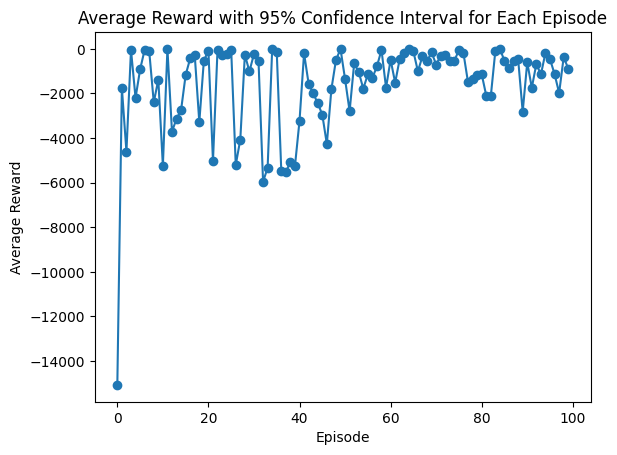

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
from collections import deque, namedtuple
import torch.nn.functional as F


# Defining the DQN Model
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(x.size(0), -1)  # Reshape to ensure 2D output

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

def optimize_model():
    if len(memory) < batch_size:
        return

    # Sample a batch of experiences from the replay memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Separate the batch into states, actions, rewards, and next_states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool, device=device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute Q-values for current states (state_action_values) using the model
    state_action_values = dqn_model(state_batch).gather(1, action_batch.unsqueeze(-1))

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = dqn_model(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q-values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss between current Q values and target Q values
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()




def select_action(state, epsilon):
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    if random.random() > epsilon:
        with torch.no_grad():
            return dqn_model(state_tensor).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.int64)

# Initialize parameters
num_agents = 1
num_episodes = 100
rewards_per_agent = []
batch_size = 32  # Set your batch size
gamma = 0.99  # Discount factor
state_size = 2  # Adjust according to your state representation
num_actions = 9  # Total number of possible actions

max_steps_per_episode = 500

for agent in range(num_agents):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create an instance of the DQN model and move it to the device
    dqn_model = DQN(state_size, 64, num_actions).to(device)
    memory = ReplayMemory(10000)
    optimizer = torch.optim.Adam(dqn_model.parameters())
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        print(state)
        total_reward = 0
        done = False
        steps = 0  # Initialize step counter
        while not done and steps < max_steps_per_episode:
            steps += 1  # Increment step counter
            action = select_action(state, epsilon=0.1)
            next_state, reward, done = env.step(action)
            print(next_state)
            total_reward += reward

            memory.push(torch.tensor([state], dtype=torch.float32),
                        torch.tensor([action.item()], dtype=torch.int64),
                        torch.tensor([next_state], dtype=torch.float32) if next_state is not None else None,
                        torch.tensor([reward], dtype=torch.float32))

            if len(memory) > batch_size:
                optimize_model()

            state = next_state

        rewards.append(total_reward)
    print(f"Agent {agent} completed training with 100 episodes")
    torch.save(dqn_model.state_dict(), f'agent_{agent}_weights.pth')
    rewards_per_agent.append(rewards)

average_rewards = np.mean(rewards_per_agent, axis=0)
std_dev = np.std(rewards_per_agent, axis=0)
confidence_intervals = scipy.stats.norm.interval(0.95, loc=average_rewards, scale=std_dev / np.sqrt(num_agents))

plt.errorbar(range(num_episodes), average_rewards, yerr=[average_rewards - confidence_intervals[0], confidence_intervals[1] - average_rewards], fmt='-o')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward with 95% Confidence Interval for Each Episode')
plt.show()
